In [ ]:
#weights = [1 1 1 1 1]
# gpu 5
# cell of checkpoints not included

In [ ]:
"""
good paper about losses:
https://arxiv.org/pdf/2006.14822.pdf

try freezing the encoder?? what does it mean? --> https://segmentation-models.readthedocs.io/en/latest/tutorial.html
transfer learning in encoder with tumor relared neural network
how to implement dropout
number of parameters in network
resnet34 or densenet121

TODOs:

check the activation of layers --> https://awjuliani.medium.com/visualizing-neural-network-layer-activation-tensorflow-tutorial-d45f8bf7bbc4
implement shuffling in the generator --> https://github.com/qubvel/segmentation_models/blob/master/examples/multiclass%20segmentation%20(camvid).ipynb // https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly 
"""

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import segmentation_models as sm

def get_model_with_dropout(base_model_name='efficientnetb4',activation='sigmoid',dropout = 0.1):
    base_model = sm.Unet(base_model_name, encoder_weights='imagenet')
    base_model_input = base_model.input
    base_model_output = base_model.get_layer('final_conv').output
    #add dropout
    base_model_output = keras.layers.Dropout(dropout)(base_model_output)
    #add activation
    output = keras.layers.Activation(activation, name=activation)(base_model_output)
    model_dp = keras.models.Model(base_model_input, output)

    return model_dp

Segmentation Models: using `tf.keras` framework.


In [2]:
import os
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

#Run from server

gpu4 = "GPU-71b4cdfc-e381-0b98-9b24-4fc06284b496" 
gpu5 = "GPU-99d0769a-9f86-4800-a40e-2320dddcf5d1" 
gpu6 = "GPU-7423cfb5-cff4-ec4d-7e96-ea6e1591d56f"
gpu7 = "GPU-c0a8738f-6dd0-1b78-c38f-4969fd3886a8"

os.environ["CUDA_VISIBLE_DEVICES"]= gpu7
print(get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:GPU:0']


In [65]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import h5py
import cv2
import pickle

In [4]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import History

In [5]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
IMG_DEPTH = 155

IMG_HEIGHT_UNET = 256
IMG_WIDTH_UNET = 256

N_IMG = 369
length_file = IMG_DEPTH * N_IMG
h5py_file_name = 'training.hdf5'
smooth = 1e-4

___

Generating the data and creating data arrays

In [ ]:
ImgDir = os.path.join("..","data","MICCAI_BraTS2020_TrainingData")
features_path = list()
labels_path = list()
count = 0
lim = 10

for folder in os.listdir(ImgDir):
    count +=1
    if 'Training' in folder:
        new_dir = os.path.join(ImgDir,folder)
        data = os.listdir(new_dir)
        for files in data:
            if 'flair' in files:
                features_path.append(os.path.join(new_dir, files))
            if 'seg' in files:
                labels_path.append(os.path.join(new_dir, files))

print(len(features_path))
print(len(labels_path))


In [ ]:
img_conc_features = np.zeros((len(features_path),IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH))
path = features_path

for file, i in zip(path,range(len(path))):
    img = nib.load(file)
    imgarr = img.get_fdata()
    img_conc_features[i,:,:,:] = imgarr
    
img_conc_features = np.concatenate(img_conc_features,axis=2)
print(np.shape(img_conc_features))

In [ ]:
img_conc_labels = np.zeros((len(labels_path),IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH))
path = labels_path

for file, i in zip(path,range(len(path))):
    img = nib.load(file)
    imgarr = img.get_fdata()
    img_conc_labels[i,:,:,:] = imgarr
    
img_conc_labels = np.concatenate(img_conc_labels,axis=2)
print(np.shape(img_conc_labels))

In [ ]:
with h5py.File(os.path.join('..','data',h5py_file_name), 'a') as f:
    f.create_dataset("features", data=img_conc_features, compression="gzip")
    f.create_dataset("labels", data=img_conc_labels, compression="gzip")

In [ ]:
hdf5_store_Brats = h5py.File(os.path.join('..','data',h5py_file_name), "r")
test_img = hdf5_store_Brats["features"][:, :, 100]
plt.imshow(test_img, cmap ='gray')
hdf5_store_Brats.close()

In [ ]:
hdf5_store_Brats = h5py.File(os.path.join('..','data',h5py_file_name), "r")
test_img = hdf5_store_Brats["labels"][:, :, 100]
plt.imshow(test_img, cmap ='gray')
hdf5_store_Brats.close()

___

Load data and model

In [39]:
train_stop = 20001
n_images = 24000

# n_images = 57195
# train_stop = int(np.floor(n_images * 0.9))

# images = X_nib.get_fdata()
# labels = y_nib.get_fdata()

#https://www.pythonforthelab.com/blog/how-to-use-hdf5-files-in-python/

#tf.debugging.set_log_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=["/device:GPU:0", "/device:GPU:1"])
# with strategy.scope():

#with tf.device("/device:GPU:0"):    

with h5py.File(os.path.join('..','data',h5py_file_name), "r") as f:
    #images_train = f["features"][()] #the whole dataset: 57195 images
    #labels_train = f["labels"][()]

    images = f["features"]
    images_train = tf.constant(images[:,:,:train_stop],dtype=tf.float32) #taking a subsample
    images_val = tf.constant(images[:,:,train_stop:n_images+1],dtype=tf.float32)

    labels = f["labels"]
    labels_train = tf.constant(labels[:,:,:train_stop],dtype=tf.float32)
    labels_val = tf.constant(images[:,:,train_stop:n_images+1],dtype=tf.float32)

#batch_size = 30 

print(labels_val[:,:,1])

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(240, 240), dtype=float32)


In [6]:
np.shape(images_train)

TensorShape([240, 240, 20001])

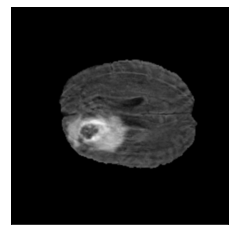

In [7]:
plt.imshow(images_train[:,:,96], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

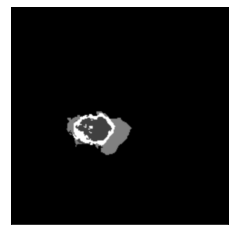

In [8]:
plt.imshow(labels_train[:,:,100], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

____

In [13]:
import segmentation_models as sm

BACKBONE = 'resnet34' #'densenet121' 
CLASSES = ['0','1','2','3','4']
LR = 0.0001
EPOCHS = 40
n_classes = 5
BATCH_SIZE = 30
decoder_filters = (128, 64, 32, 16, 8)   #standard:(256, 128, 64, 32, 16)

In [14]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def visualize_histories(**images):
    """Import as tuples: one = (a,b)"""
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.ylim(0,1)
        plt.xlabel('epoch')
        if i == 0:
            plt.ylabel('dice_score')
        plt.title(' '.join(name.split('_')).title())
        plt.plot(np.asarray(image[0]))
        plt.plot(np.asarray(image[1]))
        plt.legend(['train', 'val'])
    plt.show()

In [15]:
class Dataset:
    
    CLASSES = ['0','1','2','3','4']
    
    def __init__(self, images_train, images_label, classes = None):
        self.images_fps = images_train
        self.masks_fps = images_label
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.ids = len(images_train[1,1,:])
    
    def __getitem__(self, i):

        X_new = np.zeros((IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3), np.float32)

        X_new[:IMG_HEIGHT,:IMG_WIDTH,0] = self.images_fps[:,:,i]
        X_new[:IMG_HEIGHT,:IMG_WIDTH,1] = self.images_fps[:,:,i]
        X_new[:IMG_HEIGHT,:IMG_WIDTH,2] = self.images_fps[:,:,i]
        
        y_new = np.zeros((IMG_HEIGHT_UNET, IMG_WIDTH_UNET), np.float32)

        image = X_new[:,:,:]
        
        y_new[:IMG_HEIGHT,:IMG_WIDTH] = self.masks_fps[:,:,i]
        
        mask = y_new
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
#         if mask.shape[-1] != 1:
#             background = 1 - mask.sum(axis=-1, keepdims=True)
#             mask = np.concatenate((mask, background), axis=-1)
        
        return image, mask
    
    def __len__(self):
        return self.ids

In [16]:
class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=BATCH_SIZE, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
            
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return (batch[0],batch[1])
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)  

In [17]:
dataset = Dataset(images_train, labels_train, classes=['0','1','2','3','4'])
image, mask = dataset[100]
visualize(
    image=image[:,:,0], ### if putting the whole image, black and white, could it be the reason of the problem??
    no_tumor=mask[..., 0].squeeze(),
    one=mask[..., 1].squeeze(),
    two=mask[..., 2].squeeze(),
    three=mask[..., 3].squeeze(),
    four=mask[..., 4].squeeze()
)

NameError: name 'images_train' is not defined

In [18]:
#image = np.expand_dims(image, axis=0)
np.shape(image[np.newaxis, ...])

NameError: name 'image' is not defined

In [19]:
np.shape(mask)

NameError: name 'mask' is not defined

In [20]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES))  # case for binary and multiclass segmentation
# n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, decoder_filters = decoder_filters)
#encoder weights from ImageNet, not pretty realted to tumors, so i delete it, interesting to add other weights

In [21]:
#tf.debugging.set_log_device_placement(False)

In [22]:
def _gather_channels(x, indexes, **kwargs):
    """Slice tensor along channels axis by given indexes"""
    backend = K
    if backend.image_data_format() == 'channels_last':
        x = backend.permute_dimensions(x, (3, 0, 1, 2))
        x = backend.gather(x, indexes)
        x = backend.permute_dimensions(x, (1, 2, 3, 0))
    else:
        x = backend.permute_dimensions(x, (1, 0, 2, 3))
        x = backend.gather(x, indexes)
        x = backend.permute_dimensions(x, (1, 0, 2, 3))
    return x

def get_reduce_axes(per_image, **kwargs):
    backend = K
    axes = [1, 2] if backend.image_data_format() == 'channels_last' else [2, 3]
    if not per_image:
        axes.insert(0, 0)
    return axes

def gather_channels(*xs, indexes=None, **kwargs):
    """Slice tensors along channels axis by given indexes"""
    if indexes is None:
        return xs
    elif isinstance(indexes, (int)):
        indexes = [indexes]
    xs = [_gather_channels(x, indexes=indexes, **kwargs) for x in xs]
    return xs

def average(x, per_image=False, class_weights=None, **kwargs):
    backend = K
    if per_image:
        x = backend.mean(x, axis=0)
    if class_weights is not None:
        x = x * class_weights
    return backend.mean(x)

def round_if_needed(x, threshold, **kwargs):
    backend = K
    if threshold is not None:
        x = backend.greater(x, threshold)
        x = backend.cast(x, backend.floatx())
    return x

def iou_score(gt, pr, class_weights=1., class_indexes=None, smooth=smooth, per_image=False, threshold=None, **kwargs):
    backend = K
    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)
    axes = get_reduce_axes(per_image, **kwargs)

    # score calculation
    intersection = backend.sum(gt * pr, axis=axes)
    union = backend.sum(gt + pr, axis=axes) - intersection

    score = (intersection + smooth) / (union + smooth)
    print(score)
    score = average(score, per_image, class_weights, **kwargs)

    return score

metrics_test = [iou_score]

In [23]:
from sklearn.metrics import make_scorer

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    mask0 = y_pred[...,0]
    mask1 = y_pred[...,1]
    mask2 = y_pred[...,2]
    mask3 = y_pred[...,3]
    mask4 = y_pred[...,4]
    
    print(mask4)
    
    masks = [mask0, mask1, mask2, mask3, mask4]
    
    true0 = y_true[...,0]
    true1 = y_true[...,1]
    true2 = y_true[...,2]
    true3 = y_true[...,3]
    true4 = y_true[...,4]
    
    print(true4)
    
    trues = [true0, true1, true2, true3, true4]
    
    intersection = []
    
    for i in range(5):
        intersection.append(K.sum(trues[i] * masks[i]))
    
    intersection_test = np.asarray(intersection)
    coef_test = (2. * intersection_test + smooth) / (intersection_test + masks + smooth)
    
    intersection = K.sum(y_true_f * y_pred_f)
    coef =  (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
    
    return coef

score = make_scorer(dice_coef, greater_is_better=True)

metrics_test2 = [dice_coef]

In [24]:
def dice_metric(ground_truth, prediction):

    #for metrics, it's good to round predictions:
    prediction = K.round(prediction)

    #intersection and totals per class per batch (considers channels last)
    intersection = ground_truth * prediction
    print(np.shape(intersection))
    intersection = K.sum(intersection, axis=[1,2])
    ground_truth = K.sum(ground_truth, axis=[1,2])
    prediction = K.sum(prediction, axis=[1,2])

    dice = ((2 * intersection) + K.epsilon()) / (ground_truth + prediction + K.epsilon())
    
metrics_test3 = [dice_metric]

In [25]:
#calculates dice considering an input with a single class
def dice_single(true,pred):
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = K.round(pred)

    intersection = K.sum(true * pred, axis=-1)
    true = K.sum(true, axis=-1)
    pred = K.sum(pred, axis=-1)

    return ((2*intersection) + K.epsilon()) / (true + pred + K.epsilon())

def dice_for_class(index):
    def dice_inner(true,pred):

        #get only the desired class
        true = true[:,:,:,index]
        pred = pred[:,:,:,index]

        #return dice per class
        return dice_single(true,pred)
    return dice_inner

metrics_test4 = [dice_for_class(i) for i in range(5)]

In [26]:
#calculates dice considering an input with a single class
def dice_single(true,pred):
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = K.round(pred)

    intersection = K.sum(true * pred, axis=-1)
    true = K.sum(true, axis=-1)
    pred = K.sum(pred, axis=-1)

    return ((2*intersection) + K.epsilon()) / (true + pred + K.epsilon())

def dice_inner_0(true,pred,index=0):

    #get only the desired class
    true = true[:,:,:,index]
    pred = pred[:,:,:,index]

    #return dice per class
    return dice_single(true,pred)

def dice_inner_1(true,pred,index=1):

    #get only the desired class
    true = true[:,:,:,index]
    pred = pred[:,:,:,index]

    #return dice per class
    return dice_single(true,pred)

def dice_inner_2(true,pred,index=2):

    #get only the desired class
    true = true[:,:,:,index]
    pred = pred[:,:,:,index]

    #return dice per class
    return dice_single(true,pred)

def dice_inner_3(true,pred,index=3):

    #get only the desired class
    true = true[:,:,:,index]
    pred = pred[:,:,:,index]

    #return dice per class
    return dice_single(true,pred)

def dice_inner_4(true,pred,index=4):

    #get only the desired class
    true = true[:,:,:,index]
    pred = pred[:,:,:,index]

    #return dice per class
    return dice_single(true,pred)

metrics_test5 = [dice_inner_0, dice_inner_1, dice_inner_2, dice_inner_3, dice_inner_4, sm.metrics.FScore(threshold=0.5)]

In [34]:
def save_obj(directory, obj, name):
    with open(os.path.join(directory, name + '.pkl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(directory, name ):
    with open(directory + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [27]:
# define optomizer

    
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
# dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.1, 5, 3, 1, 1])) 
# focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

total_loss = sm.losses.DiceLoss(class_weights=np.array([1, 1, 1, 1, 1])) 

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [28]:
# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics_test5)

In [44]:
# Dataset for train images


#strategy = tf.distribute.MirroredStrategy(devices=["/device:GPU:0", "/device:GPU:1"])
#with strategy.scope():

        train_dataset = Dataset(
            images_train, 
            labels_train, 
            classes=CLASSES
        )

        # Dataset for validation images
        valid_dataset = Dataset(
            images_val, 
            labels_val, 
            classes=CLASSES
        )

        train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
        valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # check shapes for errors
        assert train_dataloader[0][0].shape == (BATCH_SIZE, IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3)
        assert train_dataloader[0][1].shape == (BATCH_SIZE, IMG_HEIGHT_UNET, IMG_WIDTH_UNET, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
# callbacks = [
#     tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
#     tf.keras.callbacks.ReduceLROnPlateau(),
# ]

# callbacks = [
#     tf.keras.callbacks.ReduceLROnPlateau(),
# ]

In [30]:
train_dataloader[0][1].shape

NameError: name 'train_dataloader' is not defined

In [31]:
class printbatch(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, epoch, logs={}):

        res_dir = os.path.join("..","data","test_images")

        try:
            os.makedirs(res_dir)
        except:
            print(f"{res_dir} directory already exist")

    
    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        
        res_dir = os.path.join("..","data","test_images")
    
        x_img = os.path.join(res_dir,"X_input.jpg")
        y_img = os.path.join(res_dir,"Y_truth.jpg")
        predicted_img = os.path.join(res_dir,f"{epoch}_Y_predicted.jpg")
        
        image, gt_mask = train_dataset[100]
        #image = np.expand_dims(image, axis=0)
        pr_mask = self.model.predict(image[np.newaxis, ...])
    
        gt_mask_vis = gt_mask[...,0:3]
        pr_mask_vis = pr_mask[...,0:3]

#         visualize(
#             image=denormalize(image.squeeze()),
#             gt_mask_vis=gt_mask_vis.squeeze(),
#             pr_mask_vis=pr_mask_vis.squeeze(),
#         )

        cv2.imwrite(x_img, image[:,:,0])
        cv2.imwrite(y_img, gt_mask_vis.squeeze())
        cv2.imwrite(predicted_img, pr_mask_vis.squeeze())
#         cv2.imwrite(predicted_img, prediction[0,:,:,:] * 255.)
        
        
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))
        
        model_history = History()
        save_obj("..","data","checkpoints", model_history.history, 'history')
        

pb = printbatch()        

In [32]:
checkpoint_path =  os.path.join("..","data","checkpoints","training_0205/cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    save_weights_only=True,
    period = 5
    save_freq="epoch"
    )

callbacks = [pb, cp_callback]


In [ ]:
model.save_weights(checkpoint_path.format(epoch=0))

history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS,
    verbose = 0,
    callbacks = callbacks,
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader)
)

Instructions for updating:
Please use Model.fit, which supports generators.
../data/test_images directory already exist
...Training: start of batch 0; got log keys: []
...Training: end of batch 0; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 1; got log keys: []
...Training: end of batch 1; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 2; got log keys: []
...Training: end of batch 2; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 3; got log keys: []
...Training: end of batch 3; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 4; got log keys: []
...Training: end of batch 4; got log keys: ['loss', 'dice_inner_

...Training: end of batch 41; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 42; got log keys: []
...Training: end of batch 42; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 43; got log keys: []
...Training: end of batch 43; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 44; got log keys: []
...Training: end of batch 44; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 45; got log keys: []
...Training: end of batch 45; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 46; got log keys: []
...Training: end of batch 46; 

...Training: end of batch 84; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 85; got log keys: []
...Training: end of batch 85; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 86; got log keys: []
...Training: end of batch 86; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 87; got log keys: []
...Training: end of batch 87; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 88; got log keys: []
...Training: end of batch 88; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 89; got log keys: []
...Training: end of batch 89; 

...Training: end of batch 126; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 127; got log keys: []
...Training: end of batch 127; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 128; got log keys: []
...Training: end of batch 128; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 129; got log keys: []
...Training: end of batch 129; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 130; got log keys: []
...Training: end of batch 130; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 131; got log keys: []
...Training: end of 

...Training: end of batch 168; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 169; got log keys: []
...Training: end of batch 169; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 170; got log keys: []
...Training: end of batch 170; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 171; got log keys: []
...Training: end of batch 171; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 172; got log keys: []
...Training: end of batch 172; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 173; got log keys: []
...Training: end of 

...Training: end of batch 210; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 211; got log keys: []
...Training: end of batch 211; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 212; got log keys: []
...Training: end of batch 212; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 213; got log keys: []
...Training: end of batch 213; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 214; got log keys: []
...Training: end of batch 214; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 215; got log keys: []
...Training: end of 

...Training: end of batch 252; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 253; got log keys: []
...Training: end of batch 253; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 254; got log keys: []
...Training: end of batch 254; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 255; got log keys: []
...Training: end of batch 255; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 256; got log keys: []
...Training: end of batch 256; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 257; got log keys: []
...Training: end of 

...Training: end of batch 294; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 295; got log keys: []
...Training: end of batch 295; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 296; got log keys: []
...Training: end of batch 296; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 297; got log keys: []
...Training: end of batch 297; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 298; got log keys: []
...Training: end of batch 298; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 299; got log keys: []
...Training: end of 

...Training: end of batch 336; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 337; got log keys: []
...Training: end of batch 337; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 338; got log keys: []
...Training: end of batch 338; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 339; got log keys: []
...Training: end of batch 339; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 340; got log keys: []
...Training: end of batch 340; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 341; got log keys: []
...Training: end of 

...Training: end of batch 378; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 379; got log keys: []
...Training: end of batch 379; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 380; got log keys: []
...Training: end of batch 380; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 381; got log keys: []
...Training: end of batch 381; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 382; got log keys: []
...Training: end of batch 382; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 383; got log keys: []
...Training: end of 

...Training: end of batch 420; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 421; got log keys: []
...Training: end of batch 421; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 422; got log keys: []
...Training: end of batch 422; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 423; got log keys: []
...Training: end of batch 423; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 424; got log keys: []
...Training: end of batch 424; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 425; got log keys: []
...Training: end of 

...Training: end of batch 462; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 463; got log keys: []
...Training: end of batch 463; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 464; got log keys: []
...Training: end of batch 464; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 465; got log keys: []
...Training: end of batch 465; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 466; got log keys: []
...Training: end of batch 466; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 467; got log keys: []
...Training: end of 

...Training: end of batch 504; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 505; got log keys: []
...Training: end of batch 505; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 506; got log keys: []
...Training: end of batch 506; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 507; got log keys: []
...Training: end of batch 507; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 508; got log keys: []
...Training: end of batch 508; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 509; got log keys: []
...Training: end of 

...Training: end of batch 546; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 547; got log keys: []
...Training: end of batch 547; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 548; got log keys: []
...Training: end of batch 548; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 549; got log keys: []
...Training: end of batch 549; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 550; got log keys: []
...Training: end of batch 550; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 551; got log keys: []
...Training: end of 

...Training: end of batch 588; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 589; got log keys: []
...Training: end of batch 589; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 590; got log keys: []
...Training: end of batch 590; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 591; got log keys: []
...Training: end of batch 591; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 592; got log keys: []
...Training: end of batch 592; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 593; got log keys: []
...Training: end of 

...Training: end of batch 630; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 631; got log keys: []
...Training: end of batch 631; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 632; got log keys: []
...Training: end of batch 632; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 633; got log keys: []
...Training: end of batch 633; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 634; got log keys: []
...Training: end of batch 634; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 635; got log keys: []
...Training: end of 

...Training: end of batch 5; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 6; got log keys: []
...Training: end of batch 6; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 7; got log keys: []
...Training: end of batch 7; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 8; got log keys: []
...Training: end of batch 8; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 9; got log keys: []
...Training: end of batch 9; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 10; got log keys: []
...Training: end of batch 10; got log k

...Training: end of batch 48; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 49; got log keys: []
...Training: end of batch 49; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 50; got log keys: []
...Training: end of batch 50; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 51; got log keys: []
...Training: end of batch 51; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 52; got log keys: []
...Training: end of batch 52; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 53; got log keys: []
...Training: end of batch 53; 

...Training: end of batch 91; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 92; got log keys: []
...Training: end of batch 92; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 93; got log keys: []
...Training: end of batch 93; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 94; got log keys: []
...Training: end of batch 94; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 95; got log keys: []
...Training: end of batch 95; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 96; got log keys: []
...Training: end of batch 96; 

...Training: end of batch 133; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 134; got log keys: []
...Training: end of batch 134; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 135; got log keys: []
...Training: end of batch 135; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 136; got log keys: []
...Training: end of batch 136; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 137; got log keys: []
...Training: end of batch 137; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 138; got log keys: []
...Training: end of 

...Training: end of batch 175; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 176; got log keys: []
...Training: end of batch 176; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 177; got log keys: []
...Training: end of batch 177; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 178; got log keys: []
...Training: end of batch 178; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 179; got log keys: []
...Training: end of batch 179; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 180; got log keys: []
...Training: end of 

...Training: end of batch 217; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 218; got log keys: []
...Training: end of batch 218; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 219; got log keys: []
...Training: end of batch 219; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 220; got log keys: []
...Training: end of batch 220; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 221; got log keys: []
...Training: end of batch 221; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 222; got log keys: []
...Training: end of 

...Training: end of batch 259; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 260; got log keys: []
...Training: end of batch 260; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 261; got log keys: []
...Training: end of batch 261; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 262; got log keys: []
...Training: end of batch 262; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 263; got log keys: []
...Training: end of batch 263; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 264; got log keys: []
...Training: end of 

...Training: end of batch 301; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 302; got log keys: []
...Training: end of batch 302; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 303; got log keys: []
...Training: end of batch 303; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 304; got log keys: []
...Training: end of batch 304; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 305; got log keys: []
...Training: end of batch 305; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 306; got log keys: []
...Training: end of 

...Training: end of batch 343; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 344; got log keys: []
...Training: end of batch 344; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 345; got log keys: []
...Training: end of batch 345; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 346; got log keys: []
...Training: end of batch 346; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 347; got log keys: []
...Training: end of batch 347; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 348; got log keys: []
...Training: end of 

...Training: end of batch 385; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 386; got log keys: []
...Training: end of batch 386; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 387; got log keys: []
...Training: end of batch 387; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 388; got log keys: []
...Training: end of batch 388; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 389; got log keys: []
...Training: end of batch 389; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 390; got log keys: []
...Training: end of 

...Training: end of batch 427; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 428; got log keys: []
...Training: end of batch 428; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 429; got log keys: []
...Training: end of batch 429; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 430; got log keys: []
...Training: end of batch 430; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 431; got log keys: []
...Training: end of batch 431; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 432; got log keys: []
...Training: end of 

...Training: end of batch 469; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 470; got log keys: []
...Training: end of batch 470; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 471; got log keys: []
...Training: end of batch 471; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 472; got log keys: []
...Training: end of batch 472; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 473; got log keys: []
...Training: end of batch 473; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 474; got log keys: []
...Training: end of 

...Training: end of batch 511; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 512; got log keys: []
...Training: end of batch 512; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 513; got log keys: []
...Training: end of batch 513; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 514; got log keys: []
...Training: end of batch 514; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 515; got log keys: []
...Training: end of batch 515; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 516; got log keys: []
...Training: end of 

...Training: end of batch 553; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 554; got log keys: []
...Training: end of batch 554; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 555; got log keys: []
...Training: end of batch 555; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 556; got log keys: []
...Training: end of batch 556; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 557; got log keys: []
...Training: end of batch 557; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 558; got log keys: []
...Training: end of 

...Training: end of batch 595; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 596; got log keys: []
...Training: end of batch 596; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 597; got log keys: []
...Training: end of batch 597; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 598; got log keys: []
...Training: end of batch 598; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 599; got log keys: []
...Training: end of batch 599; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 600; got log keys: []
...Training: end of 

...Training: end of batch 637; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 638; got log keys: []
...Training: end of batch 638; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 639; got log keys: []
...Training: end of batch 639; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 640; got log keys: []
...Training: end of batch 640; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 641; got log keys: []
...Training: end of batch 641; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 642; got log keys: []
...Training: end of 

...Training: end of batch 12; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 13; got log keys: []
...Training: end of batch 13; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 14; got log keys: []
...Training: end of batch 14; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 15; got log keys: []
...Training: end of batch 15; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 16; got log keys: []
...Training: end of batch 16; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 17; got log keys: []
...Training: end of batch 17; 

...Training: end of batch 55; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 56; got log keys: []
...Training: end of batch 56; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 57; got log keys: []
...Training: end of batch 57; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 58; got log keys: []
...Training: end of batch 58; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 59; got log keys: []
...Training: end of batch 59; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 60; got log keys: []
...Training: end of batch 60; 

...Training: end of batch 98; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 99; got log keys: []
...Training: end of batch 99; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 100; got log keys: []
...Training: end of batch 100; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 101; got log keys: []
...Training: end of batch 101; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 102; got log keys: []
...Training: end of batch 102; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 103; got log keys: []
...Training: end of bat

...Training: end of batch 140; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 141; got log keys: []
...Training: end of batch 141; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 142; got log keys: []
...Training: end of batch 142; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 143; got log keys: []
...Training: end of batch 143; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 144; got log keys: []
...Training: end of batch 144; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 145; got log keys: []
...Training: end of 

...Training: end of batch 182; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 183; got log keys: []
...Training: end of batch 183; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 184; got log keys: []
...Training: end of batch 184; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 185; got log keys: []
...Training: end of batch 185; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 186; got log keys: []
...Training: end of batch 186; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 187; got log keys: []
...Training: end of 

...Training: end of batch 224; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 225; got log keys: []
...Training: end of batch 225; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 226; got log keys: []
...Training: end of batch 226; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 227; got log keys: []
...Training: end of batch 227; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 228; got log keys: []
...Training: end of batch 228; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 229; got log keys: []
...Training: end of 

...Training: end of batch 266; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 267; got log keys: []
...Training: end of batch 267; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 268; got log keys: []
...Training: end of batch 268; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 269; got log keys: []
...Training: end of batch 269; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 270; got log keys: []
...Training: end of batch 270; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 271; got log keys: []
...Training: end of 

...Training: end of batch 308; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 309; got log keys: []
...Training: end of batch 309; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 310; got log keys: []
...Training: end of batch 310; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 311; got log keys: []
...Training: end of batch 311; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 312; got log keys: []
...Training: end of batch 312; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 313; got log keys: []
...Training: end of 

...Training: end of batch 350; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 351; got log keys: []
...Training: end of batch 351; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 352; got log keys: []
...Training: end of batch 352; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 353; got log keys: []
...Training: end of batch 353; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 354; got log keys: []
...Training: end of batch 354; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 355; got log keys: []
...Training: end of 

...Training: end of batch 392; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 393; got log keys: []
...Training: end of batch 393; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 394; got log keys: []
...Training: end of batch 394; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 395; got log keys: []
...Training: end of batch 395; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 396; got log keys: []
...Training: end of batch 396; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 397; got log keys: []
...Training: end of 

...Training: end of batch 434; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 435; got log keys: []
...Training: end of batch 435; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 436; got log keys: []
...Training: end of batch 436; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 437; got log keys: []
...Training: end of batch 437; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 438; got log keys: []
...Training: end of batch 438; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 439; got log keys: []
...Training: end of 

...Training: end of batch 476; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 477; got log keys: []
...Training: end of batch 477; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 478; got log keys: []
...Training: end of batch 478; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 479; got log keys: []
...Training: end of batch 479; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 480; got log keys: []
...Training: end of batch 480; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 481; got log keys: []
...Training: end of 

...Training: end of batch 518; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 519; got log keys: []
...Training: end of batch 519; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 520; got log keys: []
...Training: end of batch 520; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 521; got log keys: []
...Training: end of batch 521; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 522; got log keys: []
...Training: end of batch 522; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 523; got log keys: []
...Training: end of 

...Training: end of batch 560; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 561; got log keys: []
...Training: end of batch 561; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 562; got log keys: []
...Training: end of batch 562; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 563; got log keys: []
...Training: end of batch 563; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 564; got log keys: []
...Training: end of batch 564; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 565; got log keys: []
...Training: end of 

...Training: end of batch 602; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 603; got log keys: []
...Training: end of batch 603; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 604; got log keys: []
...Training: end of batch 604; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 605; got log keys: []
...Training: end of batch 605; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 606; got log keys: []
...Training: end of batch 606; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 607; got log keys: []
...Training: end of 

...Training: end of batch 644; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 645; got log keys: []
...Training: end of batch 645; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 646; got log keys: []
...Training: end of batch 646; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 647; got log keys: []
...Training: end of batch 647; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 648; got log keys: []
...Training: end of batch 648; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 649; got log keys: []
...Training: end of 

...Training: end of batch 19; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 20; got log keys: []
...Training: end of batch 20; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 21; got log keys: []
...Training: end of batch 21; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 22; got log keys: []
...Training: end of batch 22; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 23; got log keys: []
...Training: end of batch 23; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 24; got log keys: []
...Training: end of batch 24; 

...Training: end of batch 62; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 63; got log keys: []
...Training: end of batch 63; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 64; got log keys: []
...Training: end of batch 64; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 65; got log keys: []
...Training: end of batch 65; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 66; got log keys: []
...Training: end of batch 66; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 67; got log keys: []
...Training: end of batch 67; 

...Training: end of batch 105; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 106; got log keys: []
...Training: end of batch 106; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 107; got log keys: []
...Training: end of batch 107; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 108; got log keys: []
...Training: end of batch 108; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 109; got log keys: []
...Training: end of batch 109; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 110; got log keys: []
...Training: end of 

...Training: end of batch 147; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 148; got log keys: []
...Training: end of batch 148; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 149; got log keys: []
...Training: end of batch 149; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 150; got log keys: []
...Training: end of batch 150; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 151; got log keys: []
...Training: end of batch 151; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 152; got log keys: []
...Training: end of 

...Training: end of batch 189; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 190; got log keys: []
...Training: end of batch 190; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 191; got log keys: []
...Training: end of batch 191; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 192; got log keys: []
...Training: end of batch 192; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 193; got log keys: []
...Training: end of batch 193; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 194; got log keys: []
...Training: end of 

...Training: end of batch 231; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 232; got log keys: []
...Training: end of batch 232; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 233; got log keys: []
...Training: end of batch 233; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 234; got log keys: []
...Training: end of batch 234; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 235; got log keys: []
...Training: end of batch 235; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 236; got log keys: []
...Training: end of 

...Training: end of batch 273; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 274; got log keys: []
...Training: end of batch 274; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 275; got log keys: []
...Training: end of batch 275; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 276; got log keys: []
...Training: end of batch 276; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 277; got log keys: []
...Training: end of batch 277; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 278; got log keys: []
...Training: end of 

...Training: end of batch 315; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 316; got log keys: []
...Training: end of batch 316; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 317; got log keys: []
...Training: end of batch 317; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 318; got log keys: []
...Training: end of batch 318; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 319; got log keys: []
...Training: end of batch 319; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 320; got log keys: []
...Training: end of 

...Training: end of batch 357; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 358; got log keys: []
...Training: end of batch 358; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 359; got log keys: []
...Training: end of batch 359; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 360; got log keys: []
...Training: end of batch 360; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 361; got log keys: []
...Training: end of batch 361; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 362; got log keys: []
...Training: end of 

...Training: end of batch 399; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 400; got log keys: []
...Training: end of batch 400; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 401; got log keys: []
...Training: end of batch 401; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 402; got log keys: []
...Training: end of batch 402; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 403; got log keys: []
...Training: end of batch 403; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 404; got log keys: []
...Training: end of 

...Training: end of batch 441; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 442; got log keys: []
...Training: end of batch 442; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 443; got log keys: []
...Training: end of batch 443; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 444; got log keys: []
...Training: end of batch 444; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 445; got log keys: []
...Training: end of batch 445; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 446; got log keys: []
...Training: end of 

...Training: end of batch 483; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 484; got log keys: []
...Training: end of batch 484; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 485; got log keys: []
...Training: end of batch 485; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 486; got log keys: []
...Training: end of batch 486; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 487; got log keys: []
...Training: end of batch 487; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 488; got log keys: []
...Training: end of 

...Training: end of batch 525; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 526; got log keys: []
...Training: end of batch 526; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 527; got log keys: []
...Training: end of batch 527; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 528; got log keys: []
...Training: end of batch 528; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 529; got log keys: []
...Training: end of batch 529; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 530; got log keys: []
...Training: end of 

...Training: end of batch 567; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 568; got log keys: []
...Training: end of batch 568; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 569; got log keys: []
...Training: end of batch 569; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 570; got log keys: []
...Training: end of batch 570; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 571; got log keys: []
...Training: end of batch 571; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 572; got log keys: []
...Training: end of 

...Training: end of batch 609; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 610; got log keys: []
...Training: end of batch 610; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 611; got log keys: []
...Training: end of batch 611; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 612; got log keys: []
...Training: end of batch 612; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 613; got log keys: []
...Training: end of batch 613; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 614; got log keys: []
...Training: end of 

...Training: end of batch 651; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 652; got log keys: []
...Training: end of batch 652; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 653; got log keys: []
...Training: end of batch 653; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 654; got log keys: []
...Training: end of batch 654; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 655; got log keys: []
...Training: end of batch 655; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 656; got log keys: []
...Training: end of 

...Training: end of batch 26; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 27; got log keys: []
...Training: end of batch 27; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 28; got log keys: []
...Training: end of batch 28; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 29; got log keys: []
...Training: end of batch 29; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 30; got log keys: []
...Training: end of batch 30; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 31; got log keys: []
...Training: end of batch 31; 

...Training: end of batch 69; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 70; got log keys: []
...Training: end of batch 70; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 71; got log keys: []
...Training: end of batch 71; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 72; got log keys: []
...Training: end of batch 72; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 73; got log keys: []
...Training: end of batch 73; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 74; got log keys: []
...Training: end of batch 74; 

...Training: end of batch 112; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 113; got log keys: []
...Training: end of batch 113; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 114; got log keys: []
...Training: end of batch 114; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 115; got log keys: []
...Training: end of batch 115; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 116; got log keys: []
...Training: end of batch 116; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 117; got log keys: []
...Training: end of 

...Training: end of batch 154; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 155; got log keys: []
...Training: end of batch 155; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 156; got log keys: []
...Training: end of batch 156; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 157; got log keys: []
...Training: end of batch 157; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 158; got log keys: []
...Training: end of batch 158; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 159; got log keys: []
...Training: end of 

...Training: end of batch 196; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 197; got log keys: []
...Training: end of batch 197; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 198; got log keys: []
...Training: end of batch 198; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 199; got log keys: []
...Training: end of batch 199; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 200; got log keys: []
...Training: end of batch 200; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 201; got log keys: []
...Training: end of 

...Training: end of batch 238; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 239; got log keys: []
...Training: end of batch 239; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 240; got log keys: []
...Training: end of batch 240; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 241; got log keys: []
...Training: end of batch 241; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 242; got log keys: []
...Training: end of batch 242; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 243; got log keys: []
...Training: end of 

...Training: end of batch 280; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 281; got log keys: []
...Training: end of batch 281; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 282; got log keys: []
...Training: end of batch 282; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 283; got log keys: []
...Training: end of batch 283; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 284; got log keys: []
...Training: end of batch 284; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 285; got log keys: []
...Training: end of 

...Training: end of batch 322; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 323; got log keys: []
...Training: end of batch 323; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 324; got log keys: []
...Training: end of batch 324; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 325; got log keys: []
...Training: end of batch 325; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 326; got log keys: []
...Training: end of batch 326; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 327; got log keys: []
...Training: end of 

...Training: end of batch 364; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 365; got log keys: []
...Training: end of batch 365; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 366; got log keys: []
...Training: end of batch 366; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 367; got log keys: []
...Training: end of batch 367; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 368; got log keys: []
...Training: end of batch 368; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 369; got log keys: []
...Training: end of 

...Training: end of batch 406; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 407; got log keys: []
...Training: end of batch 407; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 408; got log keys: []
...Training: end of batch 408; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 409; got log keys: []
...Training: end of batch 409; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 410; got log keys: []
...Training: end of batch 410; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 411; got log keys: []
...Training: end of 

...Training: end of batch 448; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 449; got log keys: []
...Training: end of batch 449; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 450; got log keys: []
...Training: end of batch 450; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 451; got log keys: []
...Training: end of batch 451; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 452; got log keys: []
...Training: end of batch 452; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 453; got log keys: []
...Training: end of 

...Training: end of batch 490; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 491; got log keys: []
...Training: end of batch 491; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 492; got log keys: []
...Training: end of batch 492; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 493; got log keys: []
...Training: end of batch 493; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 494; got log keys: []
...Training: end of batch 494; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 495; got log keys: []
...Training: end of 

...Training: end of batch 532; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 533; got log keys: []
...Training: end of batch 533; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 534; got log keys: []
...Training: end of batch 534; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 535; got log keys: []
...Training: end of batch 535; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 536; got log keys: []
...Training: end of batch 536; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 537; got log keys: []
...Training: end of 

...Training: end of batch 574; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 575; got log keys: []
...Training: end of batch 575; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 576; got log keys: []
...Training: end of batch 576; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 577; got log keys: []
...Training: end of batch 577; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 578; got log keys: []
...Training: end of batch 578; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 579; got log keys: []
...Training: end of 

...Training: end of batch 616; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 617; got log keys: []
...Training: end of batch 617; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 618; got log keys: []
...Training: end of batch 618; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 619; got log keys: []
...Training: end of batch 619; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 620; got log keys: []
...Training: end of batch 620; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 621; got log keys: []
...Training: end of 

...Training: end of batch 658; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 659; got log keys: []
...Training: end of batch 659; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 660; got log keys: []
...Training: end of batch 660; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 661; got log keys: []
...Training: end of batch 661; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 662; got log keys: []
...Training: end of batch 662; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 663; got log keys: []
...Training: end of 

...Training: end of batch 33; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 34; got log keys: []
...Training: end of batch 34; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 35; got log keys: []
...Training: end of batch 35; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 36; got log keys: []
...Training: end of batch 36; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 37; got log keys: []
...Training: end of batch 37; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 38; got log keys: []
...Training: end of batch 38; 

...Training: end of batch 76; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 77; got log keys: []
...Training: end of batch 77; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 78; got log keys: []
...Training: end of batch 78; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 79; got log keys: []
...Training: end of batch 79; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 80; got log keys: []
...Training: end of batch 80; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 81; got log keys: []
...Training: end of batch 81; 

...Training: end of batch 119; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 120; got log keys: []
...Training: end of batch 120; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 121; got log keys: []
...Training: end of batch 121; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 122; got log keys: []
...Training: end of batch 122; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 123; got log keys: []
...Training: end of batch 123; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 124; got log keys: []
...Training: end of 

...Training: end of batch 161; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 162; got log keys: []
...Training: end of batch 162; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 163; got log keys: []
...Training: end of batch 163; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 164; got log keys: []
...Training: end of batch 164; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 165; got log keys: []
...Training: end of batch 165; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 166; got log keys: []
...Training: end of 

...Training: end of batch 203; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 204; got log keys: []
...Training: end of batch 204; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 205; got log keys: []
...Training: end of batch 205; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 206; got log keys: []
...Training: end of batch 206; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 207; got log keys: []
...Training: end of batch 207; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 208; got log keys: []
...Training: end of 

...Training: end of batch 245; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 246; got log keys: []
...Training: end of batch 246; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 247; got log keys: []
...Training: end of batch 247; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 248; got log keys: []
...Training: end of batch 248; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 249; got log keys: []
...Training: end of batch 249; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 250; got log keys: []
...Training: end of 

...Training: end of batch 287; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 288; got log keys: []
...Training: end of batch 288; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 289; got log keys: []
...Training: end of batch 289; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 290; got log keys: []
...Training: end of batch 290; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 291; got log keys: []
...Training: end of batch 291; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 292; got log keys: []
...Training: end of 

...Training: end of batch 329; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 330; got log keys: []
...Training: end of batch 330; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 331; got log keys: []
...Training: end of batch 331; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 332; got log keys: []
...Training: end of batch 332; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 333; got log keys: []
...Training: end of batch 333; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 334; got log keys: []
...Training: end of 

...Training: end of batch 371; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 372; got log keys: []
...Training: end of batch 372; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 373; got log keys: []
...Training: end of batch 373; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 374; got log keys: []
...Training: end of batch 374; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 375; got log keys: []
...Training: end of batch 375; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 376; got log keys: []
...Training: end of 

...Training: end of batch 413; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 414; got log keys: []
...Training: end of batch 414; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 415; got log keys: []
...Training: end of batch 415; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 416; got log keys: []
...Training: end of batch 416; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 417; got log keys: []
...Training: end of batch 417; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 418; got log keys: []
...Training: end of 

...Training: end of batch 455; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 456; got log keys: []
...Training: end of batch 456; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 457; got log keys: []
...Training: end of batch 457; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 458; got log keys: []
...Training: end of batch 458; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 459; got log keys: []
...Training: end of batch 459; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 460; got log keys: []
...Training: end of 

...Training: end of batch 497; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 498; got log keys: []
...Training: end of batch 498; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 499; got log keys: []
...Training: end of batch 499; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 500; got log keys: []
...Training: end of batch 500; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 501; got log keys: []
...Training: end of batch 501; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 502; got log keys: []
...Training: end of 

...Training: end of batch 539; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 540; got log keys: []
...Training: end of batch 540; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 541; got log keys: []
...Training: end of batch 541; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 542; got log keys: []
...Training: end of batch 542; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 543; got log keys: []
...Training: end of batch 543; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 544; got log keys: []
...Training: end of 

...Training: end of batch 581; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 582; got log keys: []
...Training: end of batch 582; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 583; got log keys: []
...Training: end of batch 583; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 584; got log keys: []
...Training: end of batch 584; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 585; got log keys: []
...Training: end of batch 585; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 586; got log keys: []
...Training: end of 

...Training: end of batch 623; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 624; got log keys: []
...Training: end of batch 624; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 625; got log keys: []
...Training: end of batch 625; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 626; got log keys: []
...Training: end of batch 626; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 627; got log keys: []
...Training: end of batch 627; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 628; got log keys: []
...Training: end of 

...Training: end of batch 665; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
End epoch 5 of training; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score', 'val_loss', 'val_dice_inner_0', 'val_dice_inner_1', 'val_dice_inner_2', 'val_dice_inner_3', 'val_dice_inner_4', 'val_f1-score']
...Training: start of batch 0; got log keys: []
...Training: end of batch 0; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 1; got log keys: []
...Training: end of batch 1; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 2; got log keys: []
...Training: end of batch 2; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Trainin

...Training: end of batch 40; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 41; got log keys: []
...Training: end of batch 41; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 42; got log keys: []
...Training: end of batch 42; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 43; got log keys: []
...Training: end of batch 43; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 44; got log keys: []
...Training: end of batch 44; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 45; got log keys: []
...Training: end of batch 45; 

...Training: end of batch 83; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 84; got log keys: []
...Training: end of batch 84; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 85; got log keys: []
...Training: end of batch 85; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 86; got log keys: []
...Training: end of batch 86; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 87; got log keys: []
...Training: end of batch 87; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 88; got log keys: []
...Training: end of batch 88; 

...Training: end of batch 125; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 126; got log keys: []
...Training: end of batch 126; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 127; got log keys: []
...Training: end of batch 127; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 128; got log keys: []
...Training: end of batch 128; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 129; got log keys: []
...Training: end of batch 129; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 130; got log keys: []
...Training: end of 

...Training: end of batch 167; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 168; got log keys: []
...Training: end of batch 168; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 169; got log keys: []
...Training: end of batch 169; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 170; got log keys: []
...Training: end of batch 170; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 171; got log keys: []
...Training: end of batch 171; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 172; got log keys: []
...Training: end of 

...Training: end of batch 209; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 210; got log keys: []
...Training: end of batch 210; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 211; got log keys: []
...Training: end of batch 211; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 212; got log keys: []
...Training: end of batch 212; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 213; got log keys: []
...Training: end of batch 213; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 214; got log keys: []
...Training: end of 

...Training: end of batch 251; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 252; got log keys: []
...Training: end of batch 252; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 253; got log keys: []
...Training: end of batch 253; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 254; got log keys: []
...Training: end of batch 254; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 255; got log keys: []
...Training: end of batch 255; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 256; got log keys: []
...Training: end of 

...Training: end of batch 293; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 294; got log keys: []
...Training: end of batch 294; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 295; got log keys: []
...Training: end of batch 295; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 296; got log keys: []
...Training: end of batch 296; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 297; got log keys: []
...Training: end of batch 297; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 298; got log keys: []
...Training: end of 

...Training: end of batch 335; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 336; got log keys: []
...Training: end of batch 336; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 337; got log keys: []
...Training: end of batch 337; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 338; got log keys: []
...Training: end of batch 338; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 339; got log keys: []
...Training: end of batch 339; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 340; got log keys: []
...Training: end of 

...Training: end of batch 377; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 378; got log keys: []
...Training: end of batch 378; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 379; got log keys: []
...Training: end of batch 379; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 380; got log keys: []
...Training: end of batch 380; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 381; got log keys: []
...Training: end of batch 381; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 382; got log keys: []
...Training: end of 

...Training: end of batch 419; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 420; got log keys: []
...Training: end of batch 420; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 421; got log keys: []
...Training: end of batch 421; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 422; got log keys: []
...Training: end of batch 422; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 423; got log keys: []
...Training: end of batch 423; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 424; got log keys: []
...Training: end of 

...Training: end of batch 461; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 462; got log keys: []
...Training: end of batch 462; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 463; got log keys: []
...Training: end of batch 463; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 464; got log keys: []
...Training: end of batch 464; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 465; got log keys: []
...Training: end of batch 465; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 466; got log keys: []
...Training: end of 

...Training: end of batch 503; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 504; got log keys: []
...Training: end of batch 504; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 505; got log keys: []
...Training: end of batch 505; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 506; got log keys: []
...Training: end of batch 506; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 507; got log keys: []
...Training: end of batch 507; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 508; got log keys: []
...Training: end of 

...Training: end of batch 545; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 546; got log keys: []
...Training: end of batch 546; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 547; got log keys: []
...Training: end of batch 547; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 548; got log keys: []
...Training: end of batch 548; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 549; got log keys: []
...Training: end of batch 549; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 550; got log keys: []
...Training: end of 

...Training: end of batch 587; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 588; got log keys: []
...Training: end of batch 588; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 589; got log keys: []
...Training: end of batch 589; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 590; got log keys: []
...Training: end of batch 590; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 591; got log keys: []
...Training: end of batch 591; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 592; got log keys: []
...Training: end of 

...Training: end of batch 629; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 630; got log keys: []
...Training: end of batch 630; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 631; got log keys: []
...Training: end of batch 631; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 632; got log keys: []
...Training: end of batch 632; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 633; got log keys: []
...Training: end of batch 633; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 634; got log keys: []
...Training: end of 

...Training: end of batch 4; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 5; got log keys: []
...Training: end of batch 5; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 6; got log keys: []
...Training: end of batch 6; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 7; got log keys: []
...Training: end of batch 7; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 8; got log keys: []
...Training: end of batch 8; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 9; got log keys: []
...Training: end of batch 9; got log key

...Training: end of batch 47; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 48; got log keys: []
...Training: end of batch 48; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 49; got log keys: []
...Training: end of batch 49; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 50; got log keys: []
...Training: end of batch 50; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 51; got log keys: []
...Training: end of batch 51; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 52; got log keys: []
...Training: end of batch 52; 

...Training: end of batch 90; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 91; got log keys: []
...Training: end of batch 91; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 92; got log keys: []
...Training: end of batch 92; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 93; got log keys: []
...Training: end of batch 93; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 94; got log keys: []
...Training: end of batch 94; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 95; got log keys: []
...Training: end of batch 95; 

...Training: end of batch 132; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 133; got log keys: []
...Training: end of batch 133; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 134; got log keys: []
...Training: end of batch 134; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 135; got log keys: []
...Training: end of batch 135; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 136; got log keys: []
...Training: end of batch 136; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 137; got log keys: []
...Training: end of 

...Training: end of batch 174; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 175; got log keys: []
...Training: end of batch 175; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 176; got log keys: []
...Training: end of batch 176; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 177; got log keys: []
...Training: end of batch 177; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 178; got log keys: []
...Training: end of batch 178; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 179; got log keys: []
...Training: end of 

...Training: end of batch 216; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 217; got log keys: []
...Training: end of batch 217; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 218; got log keys: []
...Training: end of batch 218; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 219; got log keys: []
...Training: end of batch 219; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 220; got log keys: []
...Training: end of batch 220; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 221; got log keys: []
...Training: end of 

...Training: end of batch 258; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 259; got log keys: []
...Training: end of batch 259; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 260; got log keys: []
...Training: end of batch 260; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 261; got log keys: []
...Training: end of batch 261; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 262; got log keys: []
...Training: end of batch 262; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 263; got log keys: []
...Training: end of 

...Training: end of batch 300; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 301; got log keys: []
...Training: end of batch 301; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 302; got log keys: []
...Training: end of batch 302; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 303; got log keys: []
...Training: end of batch 303; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 304; got log keys: []
...Training: end of batch 304; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 305; got log keys: []
...Training: end of 

...Training: end of batch 342; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 343; got log keys: []
...Training: end of batch 343; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 344; got log keys: []
...Training: end of batch 344; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 345; got log keys: []
...Training: end of batch 345; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 346; got log keys: []
...Training: end of batch 346; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 347; got log keys: []
...Training: end of 

...Training: end of batch 384; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 385; got log keys: []
...Training: end of batch 385; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 386; got log keys: []
...Training: end of batch 386; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 387; got log keys: []
...Training: end of batch 387; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 388; got log keys: []
...Training: end of batch 388; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 389; got log keys: []
...Training: end of 

...Training: end of batch 426; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 427; got log keys: []
...Training: end of batch 427; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 428; got log keys: []
...Training: end of batch 428; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 429; got log keys: []
...Training: end of batch 429; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 430; got log keys: []
...Training: end of batch 430; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 431; got log keys: []
...Training: end of 

...Training: end of batch 468; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 469; got log keys: []
...Training: end of batch 469; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 470; got log keys: []
...Training: end of batch 470; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 471; got log keys: []
...Training: end of batch 471; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 472; got log keys: []
...Training: end of batch 472; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 473; got log keys: []
...Training: end of 

...Training: end of batch 510; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 511; got log keys: []
...Training: end of batch 511; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 512; got log keys: []
...Training: end of batch 512; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 513; got log keys: []
...Training: end of batch 513; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 514; got log keys: []
...Training: end of batch 514; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 515; got log keys: []
...Training: end of 

...Training: end of batch 552; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 553; got log keys: []
...Training: end of batch 553; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 554; got log keys: []
...Training: end of batch 554; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 555; got log keys: []
...Training: end of batch 555; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 556; got log keys: []
...Training: end of batch 556; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 557; got log keys: []
...Training: end of 

...Training: end of batch 594; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 595; got log keys: []
...Training: end of batch 595; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 596; got log keys: []
...Training: end of batch 596; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 597; got log keys: []
...Training: end of batch 597; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 598; got log keys: []
...Training: end of batch 598; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 599; got log keys: []
...Training: end of 

...Training: end of batch 636; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 637; got log keys: []
...Training: end of batch 637; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 638; got log keys: []
...Training: end of batch 638; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 639; got log keys: []
...Training: end of batch 639; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 640; got log keys: []
...Training: end of batch 640; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 641; got log keys: []
...Training: end of 

...Training: end of batch 11; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 12; got log keys: []
...Training: end of batch 12; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 13; got log keys: []
...Training: end of batch 13; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 14; got log keys: []
...Training: end of batch 14; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 15; got log keys: []
...Training: end of batch 15; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 16; got log keys: []
...Training: end of batch 16; 

...Training: end of batch 54; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 55; got log keys: []
...Training: end of batch 55; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 56; got log keys: []
...Training: end of batch 56; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 57; got log keys: []
...Training: end of batch 57; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 58; got log keys: []
...Training: end of batch 58; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 59; got log keys: []
...Training: end of batch 59; 

...Training: end of batch 97; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 98; got log keys: []
...Training: end of batch 98; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 99; got log keys: []
...Training: end of batch 99; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 100; got log keys: []
...Training: end of batch 100; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 101; got log keys: []
...Training: end of batch 101; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 102; got log keys: []
...Training: end of batch

...Training: end of batch 139; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 140; got log keys: []
...Training: end of batch 140; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 141; got log keys: []
...Training: end of batch 141; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 142; got log keys: []
...Training: end of batch 142; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 143; got log keys: []
...Training: end of batch 143; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 144; got log keys: []
...Training: end of 

...Training: end of batch 181; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 182; got log keys: []
...Training: end of batch 182; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 183; got log keys: []
...Training: end of batch 183; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 184; got log keys: []
...Training: end of batch 184; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 185; got log keys: []
...Training: end of batch 185; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 186; got log keys: []
...Training: end of 

...Training: end of batch 223; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 224; got log keys: []
...Training: end of batch 224; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 225; got log keys: []
...Training: end of batch 225; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 226; got log keys: []
...Training: end of batch 226; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 227; got log keys: []
...Training: end of batch 227; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 228; got log keys: []
...Training: end of 

...Training: end of batch 265; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 266; got log keys: []
...Training: end of batch 266; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 267; got log keys: []
...Training: end of batch 267; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 268; got log keys: []
...Training: end of batch 268; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 269; got log keys: []
...Training: end of batch 269; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 270; got log keys: []
...Training: end of 

...Training: end of batch 307; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 308; got log keys: []
...Training: end of batch 308; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 309; got log keys: []
...Training: end of batch 309; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 310; got log keys: []
...Training: end of batch 310; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 311; got log keys: []
...Training: end of batch 311; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 312; got log keys: []
...Training: end of 

...Training: end of batch 349; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 350; got log keys: []
...Training: end of batch 350; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 351; got log keys: []
...Training: end of batch 351; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 352; got log keys: []
...Training: end of batch 352; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 353; got log keys: []
...Training: end of batch 353; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 354; got log keys: []
...Training: end of 

...Training: end of batch 391; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 392; got log keys: []
...Training: end of batch 392; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 393; got log keys: []
...Training: end of batch 393; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 394; got log keys: []
...Training: end of batch 394; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 395; got log keys: []
...Training: end of batch 395; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 396; got log keys: []
...Training: end of 

...Training: end of batch 433; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 434; got log keys: []
...Training: end of batch 434; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 435; got log keys: []
...Training: end of batch 435; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 436; got log keys: []
...Training: end of batch 436; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 437; got log keys: []
...Training: end of batch 437; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 438; got log keys: []
...Training: end of 

...Training: end of batch 475; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 476; got log keys: []
...Training: end of batch 476; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 477; got log keys: []
...Training: end of batch 477; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 478; got log keys: []
...Training: end of batch 478; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 479; got log keys: []
...Training: end of batch 479; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 480; got log keys: []
...Training: end of 

...Training: end of batch 517; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 518; got log keys: []
...Training: end of batch 518; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 519; got log keys: []
...Training: end of batch 519; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 520; got log keys: []
...Training: end of batch 520; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 521; got log keys: []
...Training: end of batch 521; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 522; got log keys: []
...Training: end of 

...Training: end of batch 559; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 560; got log keys: []
...Training: end of batch 560; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 561; got log keys: []
...Training: end of batch 561; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 562; got log keys: []
...Training: end of batch 562; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 563; got log keys: []
...Training: end of batch 563; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 564; got log keys: []
...Training: end of 

...Training: end of batch 601; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 602; got log keys: []
...Training: end of batch 602; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 603; got log keys: []
...Training: end of batch 603; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 604; got log keys: []
...Training: end of batch 604; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 605; got log keys: []
...Training: end of batch 605; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 606; got log keys: []
...Training: end of 

...Training: end of batch 643; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 644; got log keys: []
...Training: end of batch 644; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 645; got log keys: []
...Training: end of batch 645; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 646; got log keys: []
...Training: end of batch 646; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 647; got log keys: []
...Training: end of batch 647; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 648; got log keys: []
...Training: end of 

...Training: end of batch 18; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 19; got log keys: []
...Training: end of batch 19; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 20; got log keys: []
...Training: end of batch 20; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 21; got log keys: []
...Training: end of batch 21; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 22; got log keys: []
...Training: end of batch 22; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 23; got log keys: []
...Training: end of batch 23; 

...Training: end of batch 61; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 62; got log keys: []
...Training: end of batch 62; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 63; got log keys: []
...Training: end of batch 63; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 64; got log keys: []
...Training: end of batch 64; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 65; got log keys: []
...Training: end of batch 65; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 66; got log keys: []
...Training: end of batch 66; 

...Training: end of batch 104; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 105; got log keys: []
...Training: end of batch 105; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 106; got log keys: []
...Training: end of batch 106; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 107; got log keys: []
...Training: end of batch 107; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 108; got log keys: []
...Training: end of batch 108; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 109; got log keys: []
...Training: end of 

...Training: end of batch 146; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 147; got log keys: []
...Training: end of batch 147; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 148; got log keys: []
...Training: end of batch 148; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 149; got log keys: []
...Training: end of batch 149; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 150; got log keys: []
...Training: end of batch 150; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 151; got log keys: []
...Training: end of 

...Training: end of batch 188; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 189; got log keys: []
...Training: end of batch 189; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 190; got log keys: []
...Training: end of batch 190; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 191; got log keys: []
...Training: end of batch 191; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 192; got log keys: []
...Training: end of batch 192; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 193; got log keys: []
...Training: end of 

...Training: end of batch 230; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 231; got log keys: []
...Training: end of batch 231; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 232; got log keys: []
...Training: end of batch 232; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 233; got log keys: []
...Training: end of batch 233; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 234; got log keys: []
...Training: end of batch 234; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 235; got log keys: []
...Training: end of 

...Training: end of batch 272; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 273; got log keys: []
...Training: end of batch 273; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 274; got log keys: []
...Training: end of batch 274; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 275; got log keys: []
...Training: end of batch 275; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 276; got log keys: []
...Training: end of batch 276; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 277; got log keys: []
...Training: end of 

...Training: end of batch 314; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 315; got log keys: []
...Training: end of batch 315; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 316; got log keys: []
...Training: end of batch 316; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 317; got log keys: []
...Training: end of batch 317; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 318; got log keys: []
...Training: end of batch 318; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 319; got log keys: []
...Training: end of 

...Training: end of batch 356; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 357; got log keys: []
...Training: end of batch 357; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 358; got log keys: []
...Training: end of batch 358; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 359; got log keys: []
...Training: end of batch 359; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 360; got log keys: []
...Training: end of batch 360; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 361; got log keys: []
...Training: end of 

...Training: end of batch 398; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 399; got log keys: []
...Training: end of batch 399; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 400; got log keys: []
...Training: end of batch 400; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 401; got log keys: []
...Training: end of batch 401; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 402; got log keys: []
...Training: end of batch 402; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 403; got log keys: []
...Training: end of 

...Training: end of batch 440; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 441; got log keys: []
...Training: end of batch 441; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 442; got log keys: []
...Training: end of batch 442; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 443; got log keys: []
...Training: end of batch 443; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 444; got log keys: []
...Training: end of batch 444; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 445; got log keys: []
...Training: end of 

...Training: end of batch 482; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 483; got log keys: []
...Training: end of batch 483; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 484; got log keys: []
...Training: end of batch 484; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 485; got log keys: []
...Training: end of batch 485; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 486; got log keys: []
...Training: end of batch 486; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 487; got log keys: []
...Training: end of 

...Training: end of batch 524; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 525; got log keys: []
...Training: end of batch 525; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 526; got log keys: []
...Training: end of batch 526; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 527; got log keys: []
...Training: end of batch 527; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 528; got log keys: []
...Training: end of batch 528; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 529; got log keys: []
...Training: end of 

...Training: end of batch 566; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 567; got log keys: []
...Training: end of batch 567; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 568; got log keys: []
...Training: end of batch 568; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 569; got log keys: []
...Training: end of batch 569; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 570; got log keys: []
...Training: end of batch 570; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 571; got log keys: []
...Training: end of 

...Training: end of batch 608; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 609; got log keys: []
...Training: end of batch 609; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 610; got log keys: []
...Training: end of batch 610; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 611; got log keys: []
...Training: end of batch 611; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 612; got log keys: []
...Training: end of batch 612; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 613; got log keys: []
...Training: end of 

...Training: end of batch 650; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 651; got log keys: []
...Training: end of batch 651; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 652; got log keys: []
...Training: end of batch 652; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 653; got log keys: []
...Training: end of batch 653; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 654; got log keys: []
...Training: end of batch 654; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 655; got log keys: []
...Training: end of 

...Training: end of batch 25; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 26; got log keys: []
...Training: end of batch 26; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 27; got log keys: []
...Training: end of batch 27; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 28; got log keys: []
...Training: end of batch 28; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 29; got log keys: []
...Training: end of batch 29; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 30; got log keys: []
...Training: end of batch 30; 

...Training: end of batch 68; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 69; got log keys: []
...Training: end of batch 69; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 70; got log keys: []
...Training: end of batch 70; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 71; got log keys: []
...Training: end of batch 71; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 72; got log keys: []
...Training: end of batch 72; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 73; got log keys: []
...Training: end of batch 73; 

...Training: end of batch 111; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 112; got log keys: []
...Training: end of batch 112; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 113; got log keys: []
...Training: end of batch 113; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 114; got log keys: []
...Training: end of batch 114; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 115; got log keys: []
...Training: end of batch 115; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 116; got log keys: []
...Training: end of 

...Training: end of batch 153; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 154; got log keys: []
...Training: end of batch 154; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 155; got log keys: []
...Training: end of batch 155; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 156; got log keys: []
...Training: end of batch 156; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 157; got log keys: []
...Training: end of batch 157; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 158; got log keys: []
...Training: end of 

...Training: end of batch 195; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 196; got log keys: []
...Training: end of batch 196; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 197; got log keys: []
...Training: end of batch 197; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 198; got log keys: []
...Training: end of batch 198; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 199; got log keys: []
...Training: end of batch 199; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 200; got log keys: []
...Training: end of 

...Training: end of batch 237; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 238; got log keys: []
...Training: end of batch 238; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 239; got log keys: []
...Training: end of batch 239; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 240; got log keys: []
...Training: end of batch 240; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 241; got log keys: []
...Training: end of batch 241; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 242; got log keys: []
...Training: end of 

...Training: end of batch 279; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 280; got log keys: []
...Training: end of batch 280; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 281; got log keys: []
...Training: end of batch 281; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 282; got log keys: []
...Training: end of batch 282; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 283; got log keys: []
...Training: end of batch 283; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 284; got log keys: []
...Training: end of 

...Training: end of batch 321; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 322; got log keys: []
...Training: end of batch 322; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 323; got log keys: []
...Training: end of batch 323; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 324; got log keys: []
...Training: end of batch 324; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 325; got log keys: []
...Training: end of batch 325; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 326; got log keys: []
...Training: end of 

...Training: end of batch 363; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 364; got log keys: []
...Training: end of batch 364; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 365; got log keys: []
...Training: end of batch 365; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 366; got log keys: []
...Training: end of batch 366; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 367; got log keys: []
...Training: end of batch 367; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 368; got log keys: []
...Training: end of 

...Training: end of batch 405; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 406; got log keys: []
...Training: end of batch 406; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 407; got log keys: []
...Training: end of batch 407; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 408; got log keys: []
...Training: end of batch 408; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 409; got log keys: []
...Training: end of batch 409; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 410; got log keys: []
...Training: end of 

...Training: end of batch 447; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 448; got log keys: []
...Training: end of batch 448; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 449; got log keys: []
...Training: end of batch 449; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 450; got log keys: []
...Training: end of batch 450; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 451; got log keys: []
...Training: end of batch 451; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 452; got log keys: []
...Training: end of 

...Training: end of batch 489; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 490; got log keys: []
...Training: end of batch 490; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 491; got log keys: []
...Training: end of batch 491; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 492; got log keys: []
...Training: end of batch 492; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 493; got log keys: []
...Training: end of batch 493; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 494; got log keys: []
...Training: end of 

...Training: end of batch 531; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 532; got log keys: []
...Training: end of batch 532; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 533; got log keys: []
...Training: end of batch 533; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 534; got log keys: []
...Training: end of batch 534; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 535; got log keys: []
...Training: end of batch 535; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 536; got log keys: []
...Training: end of 

...Training: end of batch 573; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 574; got log keys: []
...Training: end of batch 574; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 575; got log keys: []
...Training: end of batch 575; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 576; got log keys: []
...Training: end of batch 576; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 577; got log keys: []
...Training: end of batch 577; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 578; got log keys: []
...Training: end of 

...Training: end of batch 615; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 616; got log keys: []
...Training: end of batch 616; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 617; got log keys: []
...Training: end of batch 617; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 618; got log keys: []
...Training: end of batch 618; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 619; got log keys: []
...Training: end of batch 619; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 620; got log keys: []
...Training: end of 

...Training: end of batch 657; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 658; got log keys: []
...Training: end of batch 658; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 659; got log keys: []
...Training: end of batch 659; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 660; got log keys: []
...Training: end of batch 660; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 661; got log keys: []
...Training: end of batch 661; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 662; got log keys: []
...Training: end of 

...Training: end of batch 32; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 33; got log keys: []
...Training: end of batch 33; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 34; got log keys: []
...Training: end of batch 34; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 35; got log keys: []
...Training: end of batch 35; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 36; got log keys: []
...Training: end of batch 36; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 37; got log keys: []
...Training: end of batch 37; 

...Training: end of batch 75; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 76; got log keys: []
...Training: end of batch 76; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 77; got log keys: []
...Training: end of batch 77; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 78; got log keys: []
...Training: end of batch 78; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 79; got log keys: []
...Training: end of batch 79; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 80; got log keys: []
...Training: end of batch 80; 

...Training: end of batch 118; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 119; got log keys: []
...Training: end of batch 119; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 120; got log keys: []
...Training: end of batch 120; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 121; got log keys: []
...Training: end of batch 121; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 122; got log keys: []
...Training: end of batch 122; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 123; got log keys: []
...Training: end of 

...Training: end of batch 160; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 161; got log keys: []
...Training: end of batch 161; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 162; got log keys: []
...Training: end of batch 162; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 163; got log keys: []
...Training: end of batch 163; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 164; got log keys: []
...Training: end of batch 164; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 165; got log keys: []
...Training: end of 

...Training: end of batch 202; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 203; got log keys: []
...Training: end of batch 203; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 204; got log keys: []
...Training: end of batch 204; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 205; got log keys: []
...Training: end of batch 205; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 206; got log keys: []
...Training: end of batch 206; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 207; got log keys: []
...Training: end of 

...Training: end of batch 244; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 245; got log keys: []
...Training: end of batch 245; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 246; got log keys: []
...Training: end of batch 246; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 247; got log keys: []
...Training: end of batch 247; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 248; got log keys: []
...Training: end of batch 248; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 249; got log keys: []
...Training: end of 

...Training: end of batch 286; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 287; got log keys: []
...Training: end of batch 287; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 288; got log keys: []
...Training: end of batch 288; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 289; got log keys: []
...Training: end of batch 289; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 290; got log keys: []
...Training: end of batch 290; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 291; got log keys: []
...Training: end of 

...Training: end of batch 328; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 329; got log keys: []
...Training: end of batch 329; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 330; got log keys: []
...Training: end of batch 330; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 331; got log keys: []
...Training: end of batch 331; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 332; got log keys: []
...Training: end of batch 332; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 333; got log keys: []
...Training: end of 

...Training: end of batch 370; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 371; got log keys: []
...Training: end of batch 371; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 372; got log keys: []
...Training: end of batch 372; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 373; got log keys: []
...Training: end of batch 373; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 374; got log keys: []
...Training: end of batch 374; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 375; got log keys: []
...Training: end of 

...Training: end of batch 412; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 413; got log keys: []
...Training: end of batch 413; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 414; got log keys: []
...Training: end of batch 414; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 415; got log keys: []
...Training: end of batch 415; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 416; got log keys: []
...Training: end of batch 416; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 417; got log keys: []
...Training: end of 

...Training: end of batch 454; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 455; got log keys: []
...Training: end of batch 455; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 456; got log keys: []
...Training: end of batch 456; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 457; got log keys: []
...Training: end of batch 457; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 458; got log keys: []
...Training: end of batch 458; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 459; got log keys: []
...Training: end of 

...Training: end of batch 496; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 497; got log keys: []
...Training: end of batch 497; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 498; got log keys: []
...Training: end of batch 498; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 499; got log keys: []
...Training: end of batch 499; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 500; got log keys: []
...Training: end of batch 500; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 501; got log keys: []
...Training: end of 

...Training: end of batch 538; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 539; got log keys: []
...Training: end of batch 539; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 540; got log keys: []
...Training: end of batch 540; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 541; got log keys: []
...Training: end of batch 541; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 542; got log keys: []
...Training: end of batch 542; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 543; got log keys: []
...Training: end of 

...Training: end of batch 580; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 581; got log keys: []
...Training: end of batch 581; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 582; got log keys: []
...Training: end of batch 582; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 583; got log keys: []
...Training: end of batch 583; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 584; got log keys: []
...Training: end of batch 584; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 585; got log keys: []
...Training: end of 

...Training: end of batch 622; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 623; got log keys: []
...Training: end of batch 623; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 624; got log keys: []
...Training: end of batch 624; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 625; got log keys: []
...Training: end of batch 625; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 626; got log keys: []
...Training: end of batch 626; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 627; got log keys: []
...Training: end of 

...Training: end of batch 664; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 665; got log keys: []
...Training: end of batch 665; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
End epoch 11 of training; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score', 'val_loss', 'val_dice_inner_0', 'val_dice_inner_1', 'val_dice_inner_2', 'val_dice_inner_3', 'val_dice_inner_4', 'val_f1-score']
...Training: start of batch 0; got log keys: []
...Training: end of batch 0; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 1; got log keys: []
...Training: end of batch 1; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Tr

...Training: end of batch 39; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 40; got log keys: []
...Training: end of batch 40; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 41; got log keys: []
...Training: end of batch 41; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 42; got log keys: []
...Training: end of batch 42; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 43; got log keys: []
...Training: end of batch 43; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 44; got log keys: []
...Training: end of batch 44; 

...Training: end of batch 82; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 83; got log keys: []
...Training: end of batch 83; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 84; got log keys: []
...Training: end of batch 84; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 85; got log keys: []
...Training: end of batch 85; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 86; got log keys: []
...Training: end of batch 86; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 87; got log keys: []
...Training: end of batch 87; 

...Training: end of batch 124; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 125; got log keys: []
...Training: end of batch 125; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 126; got log keys: []
...Training: end of batch 126; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 127; got log keys: []
...Training: end of batch 127; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 128; got log keys: []
...Training: end of batch 128; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 129; got log keys: []
...Training: end of 

...Training: end of batch 166; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 167; got log keys: []
...Training: end of batch 167; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 168; got log keys: []
...Training: end of batch 168; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 169; got log keys: []
...Training: end of batch 169; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 170; got log keys: []
...Training: end of batch 170; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 171; got log keys: []
...Training: end of 

...Training: end of batch 208; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 209; got log keys: []
...Training: end of batch 209; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 210; got log keys: []
...Training: end of batch 210; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 211; got log keys: []
...Training: end of batch 211; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 212; got log keys: []
...Training: end of batch 212; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 213; got log keys: []
...Training: end of 

...Training: end of batch 250; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 251; got log keys: []
...Training: end of batch 251; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 252; got log keys: []
...Training: end of batch 252; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 253; got log keys: []
...Training: end of batch 253; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 254; got log keys: []
...Training: end of batch 254; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 255; got log keys: []
...Training: end of 

...Training: end of batch 292; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 293; got log keys: []
...Training: end of batch 293; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 294; got log keys: []
...Training: end of batch 294; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 295; got log keys: []
...Training: end of batch 295; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 296; got log keys: []
...Training: end of batch 296; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 297; got log keys: []
...Training: end of 

...Training: end of batch 334; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 335; got log keys: []
...Training: end of batch 335; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 336; got log keys: []
...Training: end of batch 336; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 337; got log keys: []
...Training: end of batch 337; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 338; got log keys: []
...Training: end of batch 338; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 339; got log keys: []
...Training: end of 

...Training: end of batch 376; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 377; got log keys: []
...Training: end of batch 377; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 378; got log keys: []
...Training: end of batch 378; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 379; got log keys: []
...Training: end of batch 379; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 380; got log keys: []
...Training: end of batch 380; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 381; got log keys: []
...Training: end of 

...Training: end of batch 418; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 419; got log keys: []
...Training: end of batch 419; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 420; got log keys: []
...Training: end of batch 420; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 421; got log keys: []
...Training: end of batch 421; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 422; got log keys: []
...Training: end of batch 422; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 423; got log keys: []
...Training: end of 

...Training: end of batch 460; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 461; got log keys: []
...Training: end of batch 461; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 462; got log keys: []
...Training: end of batch 462; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 463; got log keys: []
...Training: end of batch 463; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 464; got log keys: []
...Training: end of batch 464; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 465; got log keys: []
...Training: end of 

...Training: end of batch 502; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 503; got log keys: []
...Training: end of batch 503; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 504; got log keys: []
...Training: end of batch 504; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 505; got log keys: []
...Training: end of batch 505; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 506; got log keys: []
...Training: end of batch 506; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 507; got log keys: []
...Training: end of 

...Training: end of batch 544; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 545; got log keys: []
...Training: end of batch 545; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 546; got log keys: []
...Training: end of batch 546; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 547; got log keys: []
...Training: end of batch 547; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 548; got log keys: []
...Training: end of batch 548; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 549; got log keys: []
...Training: end of 

...Training: end of batch 586; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 587; got log keys: []
...Training: end of batch 587; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 588; got log keys: []
...Training: end of batch 588; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 589; got log keys: []
...Training: end of batch 589; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 590; got log keys: []
...Training: end of batch 590; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 591; got log keys: []
...Training: end of 

...Training: end of batch 628; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 629; got log keys: []
...Training: end of batch 629; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 630; got log keys: []
...Training: end of batch 630; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 631; got log keys: []
...Training: end of batch 631; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 632; got log keys: []
...Training: end of batch 632; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 633; got log keys: []
...Training: end of 

...Training: end of batch 3; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 4; got log keys: []
...Training: end of batch 4; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 5; got log keys: []
...Training: end of batch 5; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 6; got log keys: []
...Training: end of batch 6; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 7; got log keys: []
...Training: end of batch 7; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 8; got log keys: []
...Training: end of batch 8; got log key

...Training: end of batch 46; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 47; got log keys: []
...Training: end of batch 47; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 48; got log keys: []
...Training: end of batch 48; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 49; got log keys: []
...Training: end of batch 49; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 50; got log keys: []
...Training: end of batch 50; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 51; got log keys: []
...Training: end of batch 51; 

...Training: end of batch 89; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 90; got log keys: []
...Training: end of batch 90; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 91; got log keys: []
...Training: end of batch 91; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 92; got log keys: []
...Training: end of batch 92; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 93; got log keys: []
...Training: end of batch 93; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 94; got log keys: []
...Training: end of batch 94; 

...Training: end of batch 131; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 132; got log keys: []
...Training: end of batch 132; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 133; got log keys: []
...Training: end of batch 133; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 134; got log keys: []
...Training: end of batch 134; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 135; got log keys: []
...Training: end of batch 135; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 136; got log keys: []
...Training: end of 

...Training: end of batch 173; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 174; got log keys: []
...Training: end of batch 174; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 175; got log keys: []
...Training: end of batch 175; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 176; got log keys: []
...Training: end of batch 176; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 177; got log keys: []
...Training: end of batch 177; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 178; got log keys: []
...Training: end of 

...Training: end of batch 215; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 216; got log keys: []
...Training: end of batch 216; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 217; got log keys: []
...Training: end of batch 217; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 218; got log keys: []
...Training: end of batch 218; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 219; got log keys: []
...Training: end of batch 219; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 220; got log keys: []
...Training: end of 

...Training: end of batch 257; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 258; got log keys: []
...Training: end of batch 258; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 259; got log keys: []
...Training: end of batch 259; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 260; got log keys: []
...Training: end of batch 260; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 261; got log keys: []
...Training: end of batch 261; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 262; got log keys: []
...Training: end of 

...Training: end of batch 299; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 300; got log keys: []
...Training: end of batch 300; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 301; got log keys: []
...Training: end of batch 301; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 302; got log keys: []
...Training: end of batch 302; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 303; got log keys: []
...Training: end of batch 303; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 304; got log keys: []
...Training: end of 

...Training: end of batch 341; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 342; got log keys: []
...Training: end of batch 342; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 343; got log keys: []
...Training: end of batch 343; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 344; got log keys: []
...Training: end of batch 344; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 345; got log keys: []
...Training: end of batch 345; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 346; got log keys: []
...Training: end of 

...Training: end of batch 383; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 384; got log keys: []
...Training: end of batch 384; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 385; got log keys: []
...Training: end of batch 385; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 386; got log keys: []
...Training: end of batch 386; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 387; got log keys: []
...Training: end of batch 387; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 388; got log keys: []
...Training: end of 

...Training: end of batch 425; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 426; got log keys: []
...Training: end of batch 426; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 427; got log keys: []
...Training: end of batch 427; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 428; got log keys: []
...Training: end of batch 428; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 429; got log keys: []
...Training: end of batch 429; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 430; got log keys: []
...Training: end of 

...Training: end of batch 467; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 468; got log keys: []
...Training: end of batch 468; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 469; got log keys: []
...Training: end of batch 469; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 470; got log keys: []
...Training: end of batch 470; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 471; got log keys: []
...Training: end of batch 471; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 472; got log keys: []
...Training: end of 

...Training: end of batch 509; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 510; got log keys: []
...Training: end of batch 510; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 511; got log keys: []
...Training: end of batch 511; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 512; got log keys: []
...Training: end of batch 512; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 513; got log keys: []
...Training: end of batch 513; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 514; got log keys: []
...Training: end of 

...Training: end of batch 551; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 552; got log keys: []
...Training: end of batch 552; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 553; got log keys: []
...Training: end of batch 553; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 554; got log keys: []
...Training: end of batch 554; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 555; got log keys: []
...Training: end of batch 555; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 556; got log keys: []
...Training: end of 

...Training: end of batch 593; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 594; got log keys: []
...Training: end of batch 594; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 595; got log keys: []
...Training: end of batch 595; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 596; got log keys: []
...Training: end of batch 596; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 597; got log keys: []
...Training: end of batch 597; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 598; got log keys: []
...Training: end of 

...Training: end of batch 635; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 636; got log keys: []
...Training: end of batch 636; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 637; got log keys: []
...Training: end of batch 637; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 638; got log keys: []
...Training: end of batch 638; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 639; got log keys: []
...Training: end of batch 639; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 640; got log keys: []
...Training: end of 

...Training: end of batch 10; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 11; got log keys: []
...Training: end of batch 11; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 12; got log keys: []
...Training: end of batch 12; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 13; got log keys: []
...Training: end of batch 13; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 14; got log keys: []
...Training: end of batch 14; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 15; got log keys: []
...Training: end of batch 15; 

...Training: end of batch 53; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 54; got log keys: []
...Training: end of batch 54; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 55; got log keys: []
...Training: end of batch 55; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 56; got log keys: []
...Training: end of batch 56; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 57; got log keys: []
...Training: end of batch 57; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 58; got log keys: []
...Training: end of batch 58; 

...Training: end of batch 96; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 97; got log keys: []
...Training: end of batch 97; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 98; got log keys: []
...Training: end of batch 98; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 99; got log keys: []
...Training: end of batch 99; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 100; got log keys: []
...Training: end of batch 100; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 101; got log keys: []
...Training: end of batch 1

...Training: end of batch 138; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 139; got log keys: []
...Training: end of batch 139; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 140; got log keys: []
...Training: end of batch 140; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 141; got log keys: []
...Training: end of batch 141; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 142; got log keys: []
...Training: end of batch 142; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 143; got log keys: []
...Training: end of 

...Training: end of batch 180; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 181; got log keys: []
...Training: end of batch 181; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 182; got log keys: []
...Training: end of batch 182; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 183; got log keys: []
...Training: end of batch 183; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 184; got log keys: []
...Training: end of batch 184; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 185; got log keys: []
...Training: end of 

...Training: end of batch 222; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 223; got log keys: []
...Training: end of batch 223; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 224; got log keys: []
...Training: end of batch 224; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 225; got log keys: []
...Training: end of batch 225; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 226; got log keys: []
...Training: end of batch 226; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 227; got log keys: []
...Training: end of 

...Training: end of batch 264; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 265; got log keys: []
...Training: end of batch 265; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 266; got log keys: []
...Training: end of batch 266; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 267; got log keys: []
...Training: end of batch 267; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 268; got log keys: []
...Training: end of batch 268; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 269; got log keys: []
...Training: end of 

...Training: end of batch 306; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 307; got log keys: []
...Training: end of batch 307; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 308; got log keys: []
...Training: end of batch 308; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 309; got log keys: []
...Training: end of batch 309; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 310; got log keys: []
...Training: end of batch 310; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 311; got log keys: []
...Training: end of 

...Training: end of batch 348; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 349; got log keys: []
...Training: end of batch 349; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 350; got log keys: []
...Training: end of batch 350; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 351; got log keys: []
...Training: end of batch 351; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 352; got log keys: []
...Training: end of batch 352; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 353; got log keys: []
...Training: end of 

...Training: end of batch 390; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 391; got log keys: []
...Training: end of batch 391; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 392; got log keys: []
...Training: end of batch 392; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 393; got log keys: []
...Training: end of batch 393; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 394; got log keys: []
...Training: end of batch 394; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 395; got log keys: []
...Training: end of 

...Training: end of batch 432; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 433; got log keys: []
...Training: end of batch 433; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 434; got log keys: []
...Training: end of batch 434; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 435; got log keys: []
...Training: end of batch 435; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 436; got log keys: []
...Training: end of batch 436; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 437; got log keys: []
...Training: end of 

...Training: end of batch 474; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 475; got log keys: []
...Training: end of batch 475; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 476; got log keys: []
...Training: end of batch 476; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 477; got log keys: []
...Training: end of batch 477; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 478; got log keys: []
...Training: end of batch 478; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 479; got log keys: []
...Training: end of 

...Training: end of batch 516; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 517; got log keys: []
...Training: end of batch 517; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 518; got log keys: []
...Training: end of batch 518; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 519; got log keys: []
...Training: end of batch 519; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 520; got log keys: []
...Training: end of batch 520; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 521; got log keys: []
...Training: end of 

...Training: end of batch 558; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 559; got log keys: []
...Training: end of batch 559; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 560; got log keys: []
...Training: end of batch 560; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 561; got log keys: []
...Training: end of batch 561; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 562; got log keys: []
...Training: end of batch 562; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 563; got log keys: []
...Training: end of 

...Training: end of batch 600; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 601; got log keys: []
...Training: end of batch 601; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 602; got log keys: []
...Training: end of batch 602; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 603; got log keys: []
...Training: end of batch 603; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 604; got log keys: []
...Training: end of batch 604; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 605; got log keys: []
...Training: end of 

...Training: end of batch 642; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 643; got log keys: []
...Training: end of batch 643; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 644; got log keys: []
...Training: end of batch 644; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 645; got log keys: []
...Training: end of batch 645; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 646; got log keys: []
...Training: end of batch 646; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 647; got log keys: []
...Training: end of 

...Training: end of batch 17; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 18; got log keys: []
...Training: end of batch 18; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 19; got log keys: []
...Training: end of batch 19; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 20; got log keys: []
...Training: end of batch 20; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 21; got log keys: []
...Training: end of batch 21; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 22; got log keys: []
...Training: end of batch 22; 

...Training: start of batch 60; got log keys: []
...Training: end of batch 60; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 61; got log keys: []
...Training: end of batch 61; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 62; got log keys: []
...Training: end of batch 62; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 63; got log keys: []
...Training: end of batch 63; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 64; got log keys: []
...Training: end of batch 64; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 65

...Training: end of batch 102; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 103; got log keys: []
...Training: end of batch 103; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 104; got log keys: []
...Training: end of batch 104; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 105; got log keys: []
...Training: end of batch 105; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 106; got log keys: []
...Training: end of batch 106; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 107; got log keys: []
...Training: end of 

...Training: end of batch 144; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 145; got log keys: []
...Training: end of batch 145; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 146; got log keys: []
...Training: end of batch 146; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 147; got log keys: []
...Training: end of batch 147; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 148; got log keys: []
...Training: end of batch 148; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 149; got log keys: []
...Training: end of 

...Training: end of batch 186; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 187; got log keys: []
...Training: end of batch 187; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 188; got log keys: []
...Training: end of batch 188; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 189; got log keys: []
...Training: end of batch 189; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 190; got log keys: []
...Training: end of batch 190; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 191; got log keys: []
...Training: end of 

...Training: end of batch 228; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 229; got log keys: []
...Training: end of batch 229; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 230; got log keys: []
...Training: end of batch 230; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 231; got log keys: []
...Training: end of batch 231; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 232; got log keys: []
...Training: end of batch 232; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 233; got log keys: []
...Training: end of 

...Training: end of batch 270; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 271; got log keys: []
...Training: end of batch 271; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 272; got log keys: []
...Training: end of batch 272; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 273; got log keys: []
...Training: end of batch 273; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 274; got log keys: []
...Training: end of batch 274; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 275; got log keys: []
...Training: end of 

...Training: end of batch 312; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 313; got log keys: []
...Training: end of batch 313; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 314; got log keys: []
...Training: end of batch 314; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 315; got log keys: []
...Training: end of batch 315; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 316; got log keys: []
...Training: end of batch 316; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 317; got log keys: []
...Training: end of 

...Training: end of batch 354; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 355; got log keys: []
...Training: end of batch 355; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 356; got log keys: []
...Training: end of batch 356; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 357; got log keys: []
...Training: end of batch 357; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 358; got log keys: []
...Training: end of batch 358; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 359; got log keys: []
...Training: end of 

...Training: end of batch 396; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 397; got log keys: []
...Training: end of batch 397; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 398; got log keys: []
...Training: end of batch 398; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 399; got log keys: []
...Training: end of batch 399; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 400; got log keys: []
...Training: end of batch 400; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 401; got log keys: []
...Training: end of 

...Training: end of batch 438; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 439; got log keys: []
...Training: end of batch 439; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 440; got log keys: []
...Training: end of batch 440; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 441; got log keys: []
...Training: end of batch 441; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 442; got log keys: []
...Training: end of batch 442; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 443; got log keys: []
...Training: end of 

...Training: end of batch 480; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 481; got log keys: []
...Training: end of batch 481; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 482; got log keys: []
...Training: end of batch 482; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 483; got log keys: []
...Training: end of batch 483; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 484; got log keys: []
...Training: end of batch 484; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 485; got log keys: []
...Training: end of 

...Training: end of batch 522; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 523; got log keys: []
...Training: end of batch 523; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 524; got log keys: []
...Training: end of batch 524; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 525; got log keys: []
...Training: end of batch 525; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 526; got log keys: []
...Training: end of batch 526; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 527; got log keys: []
...Training: end of 

...Training: end of batch 564; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 565; got log keys: []
...Training: end of batch 565; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 566; got log keys: []
...Training: end of batch 566; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 567; got log keys: []
...Training: end of batch 567; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 568; got log keys: []
...Training: end of batch 568; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 569; got log keys: []
...Training: end of 

...Training: end of batch 606; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 607; got log keys: []
...Training: end of batch 607; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 608; got log keys: []
...Training: end of batch 608; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 609; got log keys: []
...Training: end of batch 609; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 610; got log keys: []
...Training: end of batch 610; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 611; got log keys: []
...Training: end of 

...Training: end of batch 648; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 649; got log keys: []
...Training: end of batch 649; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 650; got log keys: []
...Training: end of batch 650; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 651; got log keys: []
...Training: end of batch 651; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 652; got log keys: []
...Training: end of batch 652; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 653; got log keys: []
...Training: end of 

...Training: end of batch 23; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 24; got log keys: []
...Training: end of batch 24; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 25; got log keys: []
...Training: end of batch 25; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 26; got log keys: []
...Training: end of batch 26; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 27; got log keys: []
...Training: end of batch 27; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 28; got log keys: []
...Training: end of batch 28; 

...Training: end of batch 66; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 67; got log keys: []
...Training: end of batch 67; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 68; got log keys: []
...Training: end of batch 68; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 69; got log keys: []
...Training: end of batch 69; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 70; got log keys: []
...Training: end of batch 70; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 71; got log keys: []
...Training: end of batch 71; 

...Training: end of batch 109; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 110; got log keys: []
...Training: end of batch 110; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 111; got log keys: []
...Training: end of batch 111; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 112; got log keys: []
...Training: end of batch 112; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 113; got log keys: []
...Training: end of batch 113; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 114; got log keys: []
...Training: end of 

...Training: end of batch 151; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 152; got log keys: []
...Training: end of batch 152; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 153; got log keys: []
...Training: end of batch 153; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 154; got log keys: []
...Training: end of batch 154; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 155; got log keys: []
...Training: end of batch 155; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 156; got log keys: []
...Training: end of 

...Training: end of batch 193; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 194; got log keys: []
...Training: end of batch 194; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 195; got log keys: []
...Training: end of batch 195; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 196; got log keys: []
...Training: end of batch 196; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 197; got log keys: []
...Training: end of batch 197; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 198; got log keys: []
...Training: end of 

...Training: end of batch 235; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 236; got log keys: []
...Training: end of batch 236; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 237; got log keys: []
...Training: end of batch 237; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 238; got log keys: []
...Training: end of batch 238; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 239; got log keys: []
...Training: end of batch 239; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 240; got log keys: []
...Training: end of 

...Training: end of batch 277; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 278; got log keys: []
...Training: end of batch 278; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 279; got log keys: []
...Training: end of batch 279; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 280; got log keys: []
...Training: end of batch 280; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 281; got log keys: []
...Training: end of batch 281; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 282; got log keys: []
...Training: end of 

...Training: end of batch 319; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 320; got log keys: []
...Training: end of batch 320; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 321; got log keys: []
...Training: end of batch 321; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 322; got log keys: []
...Training: end of batch 322; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 323; got log keys: []
...Training: end of batch 323; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 324; got log keys: []
...Training: end of 

...Training: end of batch 361; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 362; got log keys: []
...Training: end of batch 362; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 363; got log keys: []
...Training: end of batch 363; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 364; got log keys: []
...Training: end of batch 364; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 365; got log keys: []
...Training: end of batch 365; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 366; got log keys: []
...Training: end of 

...Training: end of batch 403; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 404; got log keys: []
...Training: end of batch 404; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 405; got log keys: []
...Training: end of batch 405; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 406; got log keys: []
...Training: end of batch 406; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 407; got log keys: []
...Training: end of batch 407; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 408; got log keys: []
...Training: end of 

...Training: end of batch 445; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 446; got log keys: []
...Training: end of batch 446; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 447; got log keys: []
...Training: end of batch 447; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 448; got log keys: []
...Training: end of batch 448; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 449; got log keys: []
...Training: end of batch 449; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 450; got log keys: []
...Training: end of 

...Training: end of batch 487; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 488; got log keys: []
...Training: end of batch 488; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 489; got log keys: []
...Training: end of batch 489; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 490; got log keys: []
...Training: end of batch 490; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 491; got log keys: []
...Training: end of batch 491; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 492; got log keys: []
...Training: end of 

...Training: end of batch 529; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 530; got log keys: []
...Training: end of batch 530; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 531; got log keys: []
...Training: end of batch 531; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 532; got log keys: []
...Training: end of batch 532; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 533; got log keys: []
...Training: end of batch 533; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 534; got log keys: []
...Training: end of 

...Training: end of batch 571; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 572; got log keys: []
...Training: end of batch 572; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 573; got log keys: []
...Training: end of batch 573; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 574; got log keys: []
...Training: end of batch 574; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 575; got log keys: []
...Training: end of batch 575; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 576; got log keys: []
...Training: end of 

...Training: end of batch 613; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 614; got log keys: []
...Training: end of batch 614; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 615; got log keys: []
...Training: end of batch 615; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 616; got log keys: []
...Training: end of batch 616; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 617; got log keys: []
...Training: end of batch 617; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 618; got log keys: []
...Training: end of 

...Training: end of batch 655; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 656; got log keys: []
...Training: end of batch 656; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 657; got log keys: []
...Training: end of batch 657; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 658; got log keys: []
...Training: end of batch 658; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 659; got log keys: []
...Training: end of batch 659; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 660; got log keys: []
...Training: end of 

...Training: end of batch 30; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 31; got log keys: []
...Training: end of batch 31; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 32; got log keys: []
...Training: end of batch 32; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 33; got log keys: []
...Training: end of batch 33; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 34; got log keys: []
...Training: end of batch 34; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 35; got log keys: []
...Training: end of batch 35; 

...Training: end of batch 73; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 74; got log keys: []
...Training: end of batch 74; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 75; got log keys: []
...Training: end of batch 75; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 76; got log keys: []
...Training: end of batch 76; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 77; got log keys: []
...Training: end of batch 77; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 78; got log keys: []
...Training: end of batch 78; 

...Training: end of batch 116; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 117; got log keys: []
...Training: end of batch 117; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 118; got log keys: []
...Training: end of batch 118; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 119; got log keys: []
...Training: end of batch 119; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 120; got log keys: []
...Training: end of batch 120; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 121; got log keys: []
...Training: end of 

...Training: end of batch 158; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 159; got log keys: []
...Training: end of batch 159; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 160; got log keys: []
...Training: end of batch 160; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 161; got log keys: []
...Training: end of batch 161; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 162; got log keys: []
...Training: end of batch 162; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 163; got log keys: []
...Training: end of 

...Training: end of batch 200; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 201; got log keys: []
...Training: end of batch 201; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 202; got log keys: []
...Training: end of batch 202; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 203; got log keys: []
...Training: end of batch 203; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 204; got log keys: []
...Training: end of batch 204; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 205; got log keys: []
...Training: end of 

...Training: end of batch 242; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 243; got log keys: []
...Training: end of batch 243; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 244; got log keys: []
...Training: end of batch 244; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 245; got log keys: []
...Training: end of batch 245; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 246; got log keys: []
...Training: end of batch 246; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 247; got log keys: []
...Training: end of 

...Training: end of batch 284; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 285; got log keys: []
...Training: end of batch 285; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 286; got log keys: []
...Training: end of batch 286; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 287; got log keys: []
...Training: end of batch 287; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 288; got log keys: []
...Training: end of batch 288; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 289; got log keys: []
...Training: end of 

...Training: end of batch 326; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 327; got log keys: []
...Training: end of batch 327; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 328; got log keys: []
...Training: end of batch 328; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 329; got log keys: []
...Training: end of batch 329; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 330; got log keys: []
...Training: end of batch 330; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 331; got log keys: []
...Training: end of 

...Training: end of batch 368; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 369; got log keys: []
...Training: end of batch 369; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 370; got log keys: []
...Training: end of batch 370; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 371; got log keys: []
...Training: end of batch 371; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 372; got log keys: []
...Training: end of batch 372; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 373; got log keys: []
...Training: end of 

...Training: end of batch 410; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 411; got log keys: []
...Training: end of batch 411; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 412; got log keys: []
...Training: end of batch 412; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 413; got log keys: []
...Training: end of batch 413; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 414; got log keys: []
...Training: end of batch 414; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 415; got log keys: []
...Training: end of 

...Training: end of batch 452; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 453; got log keys: []
...Training: end of batch 453; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 454; got log keys: []
...Training: end of batch 454; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 455; got log keys: []
...Training: end of batch 455; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 456; got log keys: []
...Training: end of batch 456; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 457; got log keys: []
...Training: end of 

...Training: end of batch 494; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 495; got log keys: []
...Training: end of batch 495; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 496; got log keys: []
...Training: end of batch 496; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 497; got log keys: []
...Training: end of batch 497; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 498; got log keys: []
...Training: end of batch 498; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 499; got log keys: []
...Training: end of 

...Training: end of batch 536; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 537; got log keys: []
...Training: end of batch 537; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 538; got log keys: []
...Training: end of batch 538; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 539; got log keys: []
...Training: end of batch 539; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 540; got log keys: []
...Training: end of batch 540; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 541; got log keys: []
...Training: end of 

...Training: end of batch 578; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 579; got log keys: []
...Training: end of batch 579; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 580; got log keys: []
...Training: end of batch 580; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 581; got log keys: []
...Training: end of batch 581; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 582; got log keys: []
...Training: end of batch 582; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 583; got log keys: []
...Training: end of 

...Training: end of batch 620; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 621; got log keys: []
...Training: end of batch 621; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 622; got log keys: []
...Training: end of batch 622; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 623; got log keys: []
...Training: end of batch 623; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 624; got log keys: []
...Training: end of batch 624; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 625; got log keys: []
...Training: end of 

...Training: end of batch 662; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 663; got log keys: []
...Training: end of batch 663; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 664; got log keys: []
...Training: end of batch 664; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 665; got log keys: []
...Training: end of batch 665; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
End epoch 17 of training; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score', 'val_loss', 'val_dice_inner_0', 'val_dice_inner_1', 'val_dice_inner_2', 'val_dice_inner_3', 'val_dice_inner_4', 'val_f1-score

...Training: end of batch 37; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 38; got log keys: []
...Training: end of batch 38; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 39; got log keys: []
...Training: end of batch 39; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 40; got log keys: []
...Training: end of batch 40; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 41; got log keys: []
...Training: end of batch 41; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 42; got log keys: []
...Training: end of batch 42; 

...Training: end of batch 80; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 81; got log keys: []
...Training: end of batch 81; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 82; got log keys: []
...Training: end of batch 82; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 83; got log keys: []
...Training: end of batch 83; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 84; got log keys: []
...Training: end of batch 84; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 85; got log keys: []
...Training: end of batch 85; 

...Training: end of batch 122; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 123; got log keys: []
...Training: end of batch 123; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 124; got log keys: []
...Training: end of batch 124; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 125; got log keys: []
...Training: end of batch 125; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 126; got log keys: []
...Training: end of batch 126; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 127; got log keys: []
...Training: end of 

...Training: end of batch 164; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 165; got log keys: []
...Training: end of batch 165; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 166; got log keys: []
...Training: end of batch 166; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 167; got log keys: []
...Training: end of batch 167; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 168; got log keys: []
...Training: end of batch 168; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 169; got log keys: []
...Training: end of 

...Training: end of batch 206; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 207; got log keys: []
...Training: end of batch 207; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 208; got log keys: []
...Training: end of batch 208; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 209; got log keys: []
...Training: end of batch 209; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 210; got log keys: []
...Training: end of batch 210; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 211; got log keys: []
...Training: end of 

...Training: end of batch 248; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 249; got log keys: []
...Training: end of batch 249; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 250; got log keys: []
...Training: end of batch 250; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 251; got log keys: []
...Training: end of batch 251; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 252; got log keys: []
...Training: end of batch 252; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 253; got log keys: []
...Training: end of 

...Training: end of batch 290; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 291; got log keys: []
...Training: end of batch 291; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 292; got log keys: []
...Training: end of batch 292; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 293; got log keys: []
...Training: end of batch 293; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 294; got log keys: []
...Training: end of batch 294; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 295; got log keys: []
...Training: end of 

...Training: end of batch 332; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 333; got log keys: []
...Training: end of batch 333; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 334; got log keys: []
...Training: end of batch 334; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 335; got log keys: []
...Training: end of batch 335; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 336; got log keys: []
...Training: end of batch 336; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 337; got log keys: []
...Training: end of 

...Training: end of batch 374; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 375; got log keys: []
...Training: end of batch 375; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 376; got log keys: []
...Training: end of batch 376; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 377; got log keys: []
...Training: end of batch 377; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 378; got log keys: []
...Training: end of batch 378; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 379; got log keys: []
...Training: end of 

...Training: end of batch 416; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 417; got log keys: []
...Training: end of batch 417; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 418; got log keys: []
...Training: end of batch 418; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 419; got log keys: []
...Training: end of batch 419; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 420; got log keys: []
...Training: end of batch 420; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 421; got log keys: []
...Training: end of 

...Training: end of batch 458; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 459; got log keys: []
...Training: end of batch 459; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 460; got log keys: []
...Training: end of batch 460; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 461; got log keys: []
...Training: end of batch 461; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 462; got log keys: []
...Training: end of batch 462; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 463; got log keys: []
...Training: end of 

...Training: end of batch 500; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 501; got log keys: []
...Training: end of batch 501; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 502; got log keys: []
...Training: end of batch 502; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 503; got log keys: []
...Training: end of batch 503; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 504; got log keys: []
...Training: end of batch 504; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 505; got log keys: []
...Training: end of 

...Training: end of batch 542; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 543; got log keys: []
...Training: end of batch 543; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 544; got log keys: []
...Training: end of batch 544; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 545; got log keys: []
...Training: end of batch 545; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 546; got log keys: []
...Training: end of batch 546; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 547; got log keys: []
...Training: end of 

...Training: end of batch 584; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 585; got log keys: []
...Training: end of batch 585; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 586; got log keys: []
...Training: end of batch 586; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 587; got log keys: []
...Training: end of batch 587; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 588; got log keys: []
...Training: end of batch 588; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 589; got log keys: []
...Training: end of 

...Training: end of batch 626; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 627; got log keys: []
...Training: end of batch 627; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 628; got log keys: []
...Training: end of batch 628; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 629; got log keys: []
...Training: end of batch 629; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 630; got log keys: []
...Training: end of batch 630; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 631; got log keys: []
...Training: end of 

...Training: end of batch 1; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 2; got log keys: []
...Training: end of batch 2; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 3; got log keys: []
...Training: end of batch 3; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 4; got log keys: []
...Training: end of batch 4; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 5; got log keys: []
...Training: end of batch 5; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 6; got log keys: []
...Training: end of batch 6; got log key

...Training: end of batch 44; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 45; got log keys: []
...Training: end of batch 45; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 46; got log keys: []
...Training: end of batch 46; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 47; got log keys: []
...Training: end of batch 47; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 48; got log keys: []
...Training: end of batch 48; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 49; got log keys: []
...Training: end of batch 49; 

...Training: end of batch 87; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 88; got log keys: []
...Training: end of batch 88; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 89; got log keys: []
...Training: end of batch 89; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 90; got log keys: []
...Training: end of batch 90; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 91; got log keys: []
...Training: end of batch 91; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 92; got log keys: []
...Training: end of batch 92; 

...Training: end of batch 129; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 130; got log keys: []
...Training: end of batch 130; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 131; got log keys: []
...Training: end of batch 131; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 132; got log keys: []
...Training: end of batch 132; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 133; got log keys: []
...Training: end of batch 133; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 134; got log keys: []
...Training: end of 

...Training: end of batch 171; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 172; got log keys: []
...Training: end of batch 172; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 173; got log keys: []
...Training: end of batch 173; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 174; got log keys: []
...Training: end of batch 174; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 175; got log keys: []
...Training: end of batch 175; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 176; got log keys: []
...Training: end of 

...Training: end of batch 213; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 214; got log keys: []
...Training: end of batch 214; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 215; got log keys: []
...Training: end of batch 215; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 216; got log keys: []
...Training: end of batch 216; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 217; got log keys: []
...Training: end of batch 217; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 218; got log keys: []
...Training: end of 

...Training: end of batch 255; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 256; got log keys: []
...Training: end of batch 256; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 257; got log keys: []
...Training: end of batch 257; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 258; got log keys: []
...Training: end of batch 258; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 259; got log keys: []
...Training: end of batch 259; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 260; got log keys: []
...Training: end of 

...Training: end of batch 297; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 298; got log keys: []
...Training: end of batch 298; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 299; got log keys: []
...Training: end of batch 299; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 300; got log keys: []
...Training: end of batch 300; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 301; got log keys: []
...Training: end of batch 301; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 302; got log keys: []
...Training: end of 

...Training: end of batch 339; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 340; got log keys: []
...Training: end of batch 340; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 341; got log keys: []
...Training: end of batch 341; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 342; got log keys: []
...Training: end of batch 342; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 343; got log keys: []
...Training: end of batch 343; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 344; got log keys: []
...Training: end of 

...Training: end of batch 381; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 382; got log keys: []
...Training: end of batch 382; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 383; got log keys: []
...Training: end of batch 383; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 384; got log keys: []
...Training: end of batch 384; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 385; got log keys: []
...Training: end of batch 385; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 386; got log keys: []
...Training: end of 

...Training: end of batch 423; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 424; got log keys: []
...Training: end of batch 424; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 425; got log keys: []
...Training: end of batch 425; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 426; got log keys: []
...Training: end of batch 426; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 427; got log keys: []
...Training: end of batch 427; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 428; got log keys: []
...Training: end of 

...Training: end of batch 465; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 466; got log keys: []
...Training: end of batch 466; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 467; got log keys: []
...Training: end of batch 467; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 468; got log keys: []
...Training: end of batch 468; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 469; got log keys: []
...Training: end of batch 469; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 470; got log keys: []
...Training: end of 

...Training: end of batch 507; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 508; got log keys: []
...Training: end of batch 508; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 509; got log keys: []
...Training: end of batch 509; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 510; got log keys: []
...Training: end of batch 510; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 511; got log keys: []
...Training: end of batch 511; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 512; got log keys: []
...Training: end of 

...Training: end of batch 549; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 550; got log keys: []
...Training: end of batch 550; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 551; got log keys: []
...Training: end of batch 551; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 552; got log keys: []
...Training: end of batch 552; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 553; got log keys: []
...Training: end of batch 553; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 554; got log keys: []
...Training: end of 

...Training: end of batch 591; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 592; got log keys: []
...Training: end of batch 592; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 593; got log keys: []
...Training: end of batch 593; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 594; got log keys: []
...Training: end of batch 594; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 595; got log keys: []
...Training: end of batch 595; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 596; got log keys: []
...Training: end of 

...Training: end of batch 633; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 634; got log keys: []
...Training: end of batch 634; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 635; got log keys: []
...Training: end of batch 635; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 636; got log keys: []
...Training: end of batch 636; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 637; got log keys: []
...Training: end of batch 637; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 638; got log keys: []
...Training: end of 

...Training: end of batch 8; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 9; got log keys: []
...Training: end of batch 9; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 10; got log keys: []
...Training: end of batch 10; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 11; got log keys: []
...Training: end of batch 11; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 12; got log keys: []
...Training: end of batch 12; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 13; got log keys: []
...Training: end of batch 13; got

...Training: end of batch 51; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 52; got log keys: []
...Training: end of batch 52; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 53; got log keys: []
...Training: end of batch 53; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 54; got log keys: []
...Training: end of batch 54; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 55; got log keys: []
...Training: end of batch 55; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 56; got log keys: []
...Training: end of batch 56; 

...Training: end of batch 94; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 95; got log keys: []
...Training: end of batch 95; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 96; got log keys: []
...Training: end of batch 96; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 97; got log keys: []
...Training: end of batch 97; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 98; got log keys: []
...Training: end of batch 98; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 99; got log keys: []
...Training: end of batch 99; 

...Training: end of batch 136; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 137; got log keys: []
...Training: end of batch 137; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 138; got log keys: []
...Training: end of batch 138; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 139; got log keys: []
...Training: end of batch 139; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 140; got log keys: []
...Training: end of batch 140; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 141; got log keys: []
...Training: end of 

...Training: end of batch 178; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 179; got log keys: []
...Training: end of batch 179; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 180; got log keys: []
...Training: end of batch 180; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 181; got log keys: []
...Training: end of batch 181; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 182; got log keys: []
...Training: end of batch 182; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 183; got log keys: []
...Training: end of 

...Training: end of batch 220; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 221; got log keys: []
...Training: end of batch 221; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 222; got log keys: []
...Training: end of batch 222; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 223; got log keys: []
...Training: end of batch 223; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 224; got log keys: []
...Training: end of batch 224; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 225; got log keys: []
...Training: end of 

...Training: end of batch 262; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 263; got log keys: []
...Training: end of batch 263; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 264; got log keys: []
...Training: end of batch 264; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 265; got log keys: []
...Training: end of batch 265; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 266; got log keys: []
...Training: end of batch 266; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 267; got log keys: []
...Training: end of 

...Training: end of batch 304; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 305; got log keys: []
...Training: end of batch 305; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 306; got log keys: []
...Training: end of batch 306; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 307; got log keys: []
...Training: end of batch 307; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 308; got log keys: []
...Training: end of batch 308; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 309; got log keys: []
...Training: end of 

...Training: end of batch 346; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 347; got log keys: []
...Training: end of batch 347; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 348; got log keys: []
...Training: end of batch 348; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 349; got log keys: []
...Training: end of batch 349; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 350; got log keys: []
...Training: end of batch 350; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 351; got log keys: []
...Training: end of 

...Training: end of batch 388; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 389; got log keys: []
...Training: end of batch 389; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 390; got log keys: []
...Training: end of batch 390; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 391; got log keys: []
...Training: end of batch 391; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 392; got log keys: []
...Training: end of batch 392; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 393; got log keys: []
...Training: end of 

...Training: end of batch 430; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 431; got log keys: []
...Training: end of batch 431; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 432; got log keys: []
...Training: end of batch 432; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 433; got log keys: []
...Training: end of batch 433; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 434; got log keys: []
...Training: end of batch 434; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 435; got log keys: []
...Training: end of 

...Training: end of batch 472; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 473; got log keys: []
...Training: end of batch 473; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 474; got log keys: []
...Training: end of batch 474; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 475; got log keys: []
...Training: end of batch 475; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 476; got log keys: []
...Training: end of batch 476; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 477; got log keys: []
...Training: end of 

...Training: end of batch 514; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 515; got log keys: []
...Training: end of batch 515; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 516; got log keys: []
...Training: end of batch 516; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 517; got log keys: []
...Training: end of batch 517; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 518; got log keys: []
...Training: end of batch 518; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 519; got log keys: []
...Training: end of 

...Training: end of batch 556; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 557; got log keys: []
...Training: end of batch 557; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 558; got log keys: []
...Training: end of batch 558; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 559; got log keys: []
...Training: end of batch 559; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 560; got log keys: []
...Training: end of batch 560; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 561; got log keys: []
...Training: end of 

...Training: end of batch 598; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 599; got log keys: []
...Training: end of batch 599; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 600; got log keys: []
...Training: end of batch 600; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 601; got log keys: []
...Training: end of batch 601; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 602; got log keys: []
...Training: end of batch 602; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 603; got log keys: []
...Training: end of 

...Training: end of batch 640; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 641; got log keys: []
...Training: end of batch 641; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 642; got log keys: []
...Training: end of batch 642; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 643; got log keys: []
...Training: end of batch 643; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 644; got log keys: []
...Training: end of batch 644; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 645; got log keys: []
...Training: end of 

...Training: end of batch 15; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 16; got log keys: []
...Training: end of batch 16; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 17; got log keys: []
...Training: end of batch 17; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 18; got log keys: []
...Training: end of batch 18; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 19; got log keys: []
...Training: end of batch 19; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 20; got log keys: []
...Training: end of batch 20; 

...Training: end of batch 58; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 59; got log keys: []
...Training: end of batch 59; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 60; got log keys: []
...Training: end of batch 60; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 61; got log keys: []
...Training: end of batch 61; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 62; got log keys: []
...Training: end of batch 62; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 63; got log keys: []
...Training: end of batch 63; 

...Training: end of batch 101; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 102; got log keys: []
...Training: end of batch 102; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 103; got log keys: []
...Training: end of batch 103; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 104; got log keys: []
...Training: end of batch 104; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 105; got log keys: []
...Training: end of batch 105; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 106; got log keys: []
...Training: end of 

...Training: end of batch 143; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 144; got log keys: []
...Training: end of batch 144; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 145; got log keys: []
...Training: end of batch 145; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 146; got log keys: []
...Training: end of batch 146; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 147; got log keys: []
...Training: end of batch 147; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 148; got log keys: []
...Training: end of 

...Training: end of batch 185; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 186; got log keys: []
...Training: end of batch 186; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 187; got log keys: []
...Training: end of batch 187; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 188; got log keys: []
...Training: end of batch 188; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 189; got log keys: []
...Training: end of batch 189; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 190; got log keys: []
...Training: end of 

...Training: end of batch 227; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 228; got log keys: []
...Training: end of batch 228; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 229; got log keys: []
...Training: end of batch 229; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 230; got log keys: []
...Training: end of batch 230; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 231; got log keys: []
...Training: end of batch 231; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 232; got log keys: []
...Training: end of 

...Training: end of batch 269; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 270; got log keys: []
...Training: end of batch 270; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 271; got log keys: []
...Training: end of batch 271; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 272; got log keys: []
...Training: end of batch 272; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 273; got log keys: []
...Training: end of batch 273; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 274; got log keys: []
...Training: end of 

...Training: end of batch 311; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 312; got log keys: []
...Training: end of batch 312; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 313; got log keys: []
...Training: end of batch 313; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 314; got log keys: []
...Training: end of batch 314; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 315; got log keys: []
...Training: end of batch 315; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 316; got log keys: []
...Training: end of 

...Training: end of batch 353; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 354; got log keys: []
...Training: end of batch 354; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 355; got log keys: []
...Training: end of batch 355; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 356; got log keys: []
...Training: end of batch 356; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 357; got log keys: []
...Training: end of batch 357; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 358; got log keys: []
...Training: end of 

...Training: end of batch 395; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 396; got log keys: []
...Training: end of batch 396; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 397; got log keys: []
...Training: end of batch 397; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 398; got log keys: []
...Training: end of batch 398; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 399; got log keys: []
...Training: end of batch 399; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 400; got log keys: []
...Training: end of 

...Training: end of batch 437; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 438; got log keys: []
...Training: end of batch 438; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 439; got log keys: []
...Training: end of batch 439; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 440; got log keys: []
...Training: end of batch 440; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 441; got log keys: []
...Training: end of batch 441; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 442; got log keys: []
...Training: end of 

...Training: end of batch 479; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 480; got log keys: []
...Training: end of batch 480; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 481; got log keys: []
...Training: end of batch 481; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 482; got log keys: []
...Training: end of batch 482; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 483; got log keys: []
...Training: end of batch 483; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 484; got log keys: []
...Training: end of 

...Training: end of batch 521; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 522; got log keys: []
...Training: end of batch 522; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 523; got log keys: []
...Training: end of batch 523; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 524; got log keys: []
...Training: end of batch 524; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 525; got log keys: []
...Training: end of batch 525; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 526; got log keys: []
...Training: end of 

...Training: end of batch 563; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 564; got log keys: []
...Training: end of batch 564; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 565; got log keys: []
...Training: end of batch 565; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 566; got log keys: []
...Training: end of batch 566; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 567; got log keys: []
...Training: end of batch 567; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 568; got log keys: []
...Training: end of 

...Training: end of batch 605; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 606; got log keys: []
...Training: end of batch 606; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 607; got log keys: []
...Training: end of batch 607; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 608; got log keys: []
...Training: end of batch 608; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 609; got log keys: []
...Training: end of batch 609; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 610; got log keys: []
...Training: end of 

...Training: end of batch 647; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 648; got log keys: []
...Training: end of batch 648; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 649; got log keys: []
...Training: end of batch 649; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 650; got log keys: []
...Training: end of batch 650; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 651; got log keys: []
...Training: end of batch 651; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 652; got log keys: []
...Training: end of 

...Training: end of batch 22; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 23; got log keys: []
...Training: end of batch 23; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 24; got log keys: []
...Training: end of batch 24; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 25; got log keys: []
...Training: end of batch 25; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 26; got log keys: []
...Training: end of batch 26; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 27; got log keys: []
...Training: end of batch 27; 

...Training: end of batch 65; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 66; got log keys: []
...Training: end of batch 66; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 67; got log keys: []
...Training: end of batch 67; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 68; got log keys: []
...Training: end of batch 68; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 69; got log keys: []
...Training: end of batch 69; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 70; got log keys: []
...Training: end of batch 70; 

...Training: end of batch 108; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 109; got log keys: []
...Training: end of batch 109; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 110; got log keys: []
...Training: end of batch 110; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 111; got log keys: []
...Training: end of batch 111; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 112; got log keys: []
...Training: end of batch 112; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 113; got log keys: []
...Training: end of 

...Training: end of batch 150; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 151; got log keys: []
...Training: end of batch 151; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 152; got log keys: []
...Training: end of batch 152; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 153; got log keys: []
...Training: end of batch 153; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 154; got log keys: []
...Training: end of batch 154; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 155; got log keys: []
...Training: end of 

...Training: end of batch 192; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 193; got log keys: []
...Training: end of batch 193; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 194; got log keys: []
...Training: end of batch 194; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 195; got log keys: []
...Training: end of batch 195; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 196; got log keys: []
...Training: end of batch 196; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 197; got log keys: []
...Training: end of 

...Training: end of batch 234; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 235; got log keys: []
...Training: end of batch 235; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 236; got log keys: []
...Training: end of batch 236; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 237; got log keys: []
...Training: end of batch 237; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 238; got log keys: []
...Training: end of batch 238; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 239; got log keys: []
...Training: end of 

...Training: end of batch 276; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 277; got log keys: []
...Training: end of batch 277; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 278; got log keys: []
...Training: end of batch 278; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 279; got log keys: []
...Training: end of batch 279; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 280; got log keys: []
...Training: end of batch 280; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 281; got log keys: []
...Training: end of 

...Training: end of batch 318; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 319; got log keys: []
...Training: end of batch 319; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 320; got log keys: []
...Training: end of batch 320; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 321; got log keys: []
...Training: end of batch 321; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 322; got log keys: []
...Training: end of batch 322; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 323; got log keys: []
...Training: end of 

...Training: end of batch 360; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 361; got log keys: []
...Training: end of batch 361; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 362; got log keys: []
...Training: end of batch 362; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 363; got log keys: []
...Training: end of batch 363; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 364; got log keys: []
...Training: end of batch 364; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 365; got log keys: []
...Training: end of 

...Training: end of batch 402; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 403; got log keys: []
...Training: end of batch 403; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 404; got log keys: []
...Training: end of batch 404; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 405; got log keys: []
...Training: end of batch 405; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 406; got log keys: []
...Training: end of batch 406; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 407; got log keys: []
...Training: end of 

...Training: end of batch 444; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 445; got log keys: []
...Training: end of batch 445; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 446; got log keys: []
...Training: end of batch 446; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 447; got log keys: []
...Training: end of batch 447; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 448; got log keys: []
...Training: end of batch 448; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 449; got log keys: []
...Training: end of 

...Training: end of batch 486; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 487; got log keys: []
...Training: end of batch 487; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 488; got log keys: []
...Training: end of batch 488; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 489; got log keys: []
...Training: end of batch 489; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 490; got log keys: []
...Training: end of batch 490; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 491; got log keys: []
...Training: end of 

...Training: end of batch 528; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 529; got log keys: []
...Training: end of batch 529; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 530; got log keys: []
...Training: end of batch 530; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 531; got log keys: []
...Training: end of batch 531; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 532; got log keys: []
...Training: end of batch 532; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 533; got log keys: []
...Training: end of 

...Training: end of batch 570; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 571; got log keys: []
...Training: end of batch 571; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 572; got log keys: []
...Training: end of batch 572; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 573; got log keys: []
...Training: end of batch 573; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 574; got log keys: []
...Training: end of batch 574; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 575; got log keys: []
...Training: end of 

...Training: end of batch 612; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 613; got log keys: []
...Training: end of batch 613; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 614; got log keys: []
...Training: end of batch 614; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 615; got log keys: []
...Training: end of batch 615; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 616; got log keys: []
...Training: end of batch 616; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 617; got log keys: []
...Training: end of 

...Training: end of batch 654; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 655; got log keys: []
...Training: end of batch 655; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 656; got log keys: []
...Training: end of batch 656; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 657; got log keys: []
...Training: end of batch 657; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 658; got log keys: []
...Training: end of batch 658; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 659; got log keys: []
...Training: end of 

...Training: end of batch 29; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 30; got log keys: []
...Training: end of batch 30; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 31; got log keys: []
...Training: end of batch 31; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 32; got log keys: []
...Training: end of batch 32; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 33; got log keys: []
...Training: end of batch 33; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 34; got log keys: []
...Training: end of batch 34; 

...Training: end of batch 72; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 73; got log keys: []
...Training: end of batch 73; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 74; got log keys: []
...Training: end of batch 74; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 75; got log keys: []
...Training: end of batch 75; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 76; got log keys: []
...Training: end of batch 76; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 77; got log keys: []
...Training: end of batch 77; 

...Training: end of batch 115; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 116; got log keys: []
...Training: end of batch 116; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 117; got log keys: []
...Training: end of batch 117; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 118; got log keys: []
...Training: end of batch 118; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 119; got log keys: []
...Training: end of batch 119; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 120; got log keys: []
...Training: end of 

...Training: end of batch 157; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 158; got log keys: []
...Training: end of batch 158; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 159; got log keys: []
...Training: end of batch 159; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 160; got log keys: []
...Training: end of batch 160; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 161; got log keys: []
...Training: end of batch 161; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 162; got log keys: []
...Training: end of 

...Training: end of batch 199; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 200; got log keys: []
...Training: end of batch 200; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 201; got log keys: []
...Training: end of batch 201; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 202; got log keys: []
...Training: end of batch 202; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 203; got log keys: []
...Training: end of batch 203; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 204; got log keys: []
...Training: end of 

...Training: end of batch 241; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 242; got log keys: []
...Training: end of batch 242; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 243; got log keys: []
...Training: end of batch 243; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 244; got log keys: []
...Training: end of batch 244; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 245; got log keys: []
...Training: end of batch 245; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 246; got log keys: []
...Training: end of 

...Training: end of batch 283; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 284; got log keys: []
...Training: end of batch 284; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 285; got log keys: []
...Training: end of batch 285; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 286; got log keys: []
...Training: end of batch 286; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 287; got log keys: []
...Training: end of batch 287; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 288; got log keys: []
...Training: end of 

...Training: end of batch 325; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 326; got log keys: []
...Training: end of batch 326; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 327; got log keys: []
...Training: end of batch 327; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 328; got log keys: []
...Training: end of batch 328; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 329; got log keys: []
...Training: end of batch 329; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 330; got log keys: []
...Training: end of 

...Training: end of batch 367; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 368; got log keys: []
...Training: end of batch 368; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 369; got log keys: []
...Training: end of batch 369; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 370; got log keys: []
...Training: end of batch 370; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 371; got log keys: []
...Training: end of batch 371; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 372; got log keys: []
...Training: end of 

...Training: end of batch 409; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 410; got log keys: []
...Training: end of batch 410; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 411; got log keys: []
...Training: end of batch 411; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 412; got log keys: []
...Training: end of batch 412; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 413; got log keys: []
...Training: end of batch 413; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 414; got log keys: []
...Training: end of 

...Training: end of batch 451; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 452; got log keys: []
...Training: end of batch 452; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 453; got log keys: []
...Training: end of batch 453; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 454; got log keys: []
...Training: end of batch 454; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 455; got log keys: []
...Training: end of batch 455; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 456; got log keys: []
...Training: end of 

...Training: end of batch 493; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 494; got log keys: []
...Training: end of batch 494; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 495; got log keys: []
...Training: end of batch 495; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 496; got log keys: []
...Training: end of batch 496; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 497; got log keys: []
...Training: end of batch 497; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 498; got log keys: []
...Training: end of 

...Training: end of batch 535; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 536; got log keys: []
...Training: end of batch 536; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 537; got log keys: []
...Training: end of batch 537; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 538; got log keys: []
...Training: end of batch 538; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 539; got log keys: []
...Training: end of batch 539; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 540; got log keys: []
...Training: end of 

...Training: end of batch 577; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 578; got log keys: []
...Training: end of batch 578; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 579; got log keys: []
...Training: end of batch 579; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 580; got log keys: []
...Training: end of batch 580; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 581; got log keys: []
...Training: end of batch 581; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 582; got log keys: []
...Training: end of 

...Training: end of batch 619; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 620; got log keys: []
...Training: end of batch 620; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 621; got log keys: []
...Training: end of batch 621; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 622; got log keys: []
...Training: end of batch 622; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 623; got log keys: []
...Training: end of batch 623; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 624; got log keys: []
...Training: end of 

...Training: end of batch 661; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 662; got log keys: []
...Training: end of batch 662; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 663; got log keys: []
...Training: end of batch 663; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 664; got log keys: []
...Training: end of batch 664; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 665; got log keys: []
...Training: end of batch 665; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
End epoch 23 of training; got log keys: ['loss', 'dice_inner_0', 'dice

...Training: end of batch 36; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 37; got log keys: []
...Training: end of batch 37; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 38; got log keys: []
...Training: end of batch 38; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 39; got log keys: []
...Training: end of batch 39; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 40; got log keys: []
...Training: end of batch 40; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 41; got log keys: []
...Training: end of batch 41; 

...Training: end of batch 79; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 80; got log keys: []
...Training: end of batch 80; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 81; got log keys: []
...Training: end of batch 81; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 82; got log keys: []
...Training: end of batch 82; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 83; got log keys: []
...Training: end of batch 83; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 84; got log keys: []
...Training: end of batch 84; 

...Training: end of batch 122; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 123; got log keys: []
...Training: end of batch 123; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 124; got log keys: []
...Training: end of batch 124; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 125; got log keys: []
...Training: end of batch 125; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 126; got log keys: []
...Training: end of batch 126; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 127; got log keys: []
...Training: end of 

...Training: end of batch 164; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 165; got log keys: []
...Training: end of batch 165; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 166; got log keys: []
...Training: end of batch 166; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 167; got log keys: []
...Training: end of batch 167; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 168; got log keys: []
...Training: end of batch 168; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 169; got log keys: []
...Training: end of 

...Training: end of batch 206; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 207; got log keys: []
...Training: end of batch 207; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 208; got log keys: []
...Training: end of batch 208; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 209; got log keys: []
...Training: end of batch 209; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 210; got log keys: []
...Training: end of batch 210; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 211; got log keys: []
...Training: end of 

...Training: end of batch 248; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 249; got log keys: []
...Training: end of batch 249; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 250; got log keys: []
...Training: end of batch 250; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 251; got log keys: []
...Training: end of batch 251; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 252; got log keys: []
...Training: end of batch 252; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 253; got log keys: []
...Training: end of 

...Training: end of batch 290; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 291; got log keys: []
...Training: end of batch 291; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 292; got log keys: []
...Training: end of batch 292; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 293; got log keys: []
...Training: end of batch 293; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 294; got log keys: []
...Training: end of batch 294; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 295; got log keys: []
...Training: end of 

...Training: end of batch 332; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 333; got log keys: []
...Training: end of batch 333; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 334; got log keys: []
...Training: end of batch 334; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 335; got log keys: []
...Training: end of batch 335; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 336; got log keys: []
...Training: end of batch 336; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 337; got log keys: []
...Training: end of 

...Training: end of batch 374; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 375; got log keys: []
...Training: end of batch 375; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 376; got log keys: []
...Training: end of batch 376; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 377; got log keys: []
...Training: end of batch 377; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 378; got log keys: []
...Training: end of batch 378; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 379; got log keys: []
...Training: end of 

...Training: end of batch 416; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 417; got log keys: []
...Training: end of batch 417; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 418; got log keys: []
...Training: end of batch 418; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 419; got log keys: []
...Training: end of batch 419; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 420; got log keys: []
...Training: end of batch 420; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 421; got log keys: []
...Training: end of 

...Training: end of batch 458; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 459; got log keys: []
...Training: end of batch 459; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 460; got log keys: []
...Training: end of batch 460; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 461; got log keys: []
...Training: end of batch 461; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 462; got log keys: []
...Training: end of batch 462; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 463; got log keys: []
...Training: end of 

...Training: end of batch 500; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 501; got log keys: []
...Training: end of batch 501; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 502; got log keys: []
...Training: end of batch 502; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 503; got log keys: []
...Training: end of batch 503; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 504; got log keys: []
...Training: end of batch 504; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 505; got log keys: []
...Training: end of 

...Training: end of batch 542; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 543; got log keys: []
...Training: end of batch 543; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 544; got log keys: []
...Training: end of batch 544; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 545; got log keys: []
...Training: end of batch 545; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 546; got log keys: []
...Training: end of batch 546; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 547; got log keys: []
...Training: end of 

...Training: end of batch 584; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 585; got log keys: []
...Training: end of batch 585; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 586; got log keys: []
...Training: end of batch 586; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 587; got log keys: []
...Training: end of batch 587; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 588; got log keys: []
...Training: end of batch 588; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 589; got log keys: []
...Training: end of 

...Training: end of batch 626; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 627; got log keys: []
...Training: end of batch 627; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 628; got log keys: []
...Training: end of batch 628; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 629; got log keys: []
...Training: end of batch 629; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 630; got log keys: []
...Training: end of batch 630; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 631; got log keys: []
...Training: end of 

...Training: end of batch 1; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 2; got log keys: []
...Training: end of batch 2; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 3; got log keys: []
...Training: end of batch 3; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 4; got log keys: []
...Training: end of batch 4; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 5; got log keys: []
...Training: end of batch 5; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 6; got log keys: []
...Training: end of batch 6; got log key

...Training: end of batch 44; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 45; got log keys: []
...Training: end of batch 45; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 46; got log keys: []
...Training: end of batch 46; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 47; got log keys: []
...Training: end of batch 47; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 48; got log keys: []
...Training: end of batch 48; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 49; got log keys: []
...Training: end of batch 49; 

...Training: end of batch 87; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 88; got log keys: []
...Training: end of batch 88; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 89; got log keys: []
...Training: end of batch 89; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 90; got log keys: []
...Training: end of batch 90; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 91; got log keys: []
...Training: end of batch 91; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 92; got log keys: []
...Training: end of batch 92; 

...Training: end of batch 129; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 130; got log keys: []
...Training: end of batch 130; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 131; got log keys: []
...Training: end of batch 131; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 132; got log keys: []
...Training: end of batch 132; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 133; got log keys: []
...Training: end of batch 133; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 134; got log keys: []
...Training: end of 

...Training: end of batch 171; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 172; got log keys: []
...Training: end of batch 172; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 173; got log keys: []
...Training: end of batch 173; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 174; got log keys: []
...Training: end of batch 174; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 175; got log keys: []
...Training: end of batch 175; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 176; got log keys: []
...Training: end of 

...Training: end of batch 213; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 214; got log keys: []
...Training: end of batch 214; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 215; got log keys: []
...Training: end of batch 215; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 216; got log keys: []
...Training: end of batch 216; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 217; got log keys: []
...Training: end of batch 217; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 218; got log keys: []
...Training: end of 

...Training: end of batch 255; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 256; got log keys: []
...Training: end of batch 256; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 257; got log keys: []
...Training: end of batch 257; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 258; got log keys: []
...Training: end of batch 258; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 259; got log keys: []
...Training: end of batch 259; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 260; got log keys: []
...Training: end of 

...Training: end of batch 297; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 298; got log keys: []
...Training: end of batch 298; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 299; got log keys: []
...Training: end of batch 299; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 300; got log keys: []
...Training: end of batch 300; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 301; got log keys: []
...Training: end of batch 301; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 302; got log keys: []
...Training: end of 

...Training: end of batch 339; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 340; got log keys: []
...Training: end of batch 340; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 341; got log keys: []
...Training: end of batch 341; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 342; got log keys: []
...Training: end of batch 342; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 343; got log keys: []
...Training: end of batch 343; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 344; got log keys: []
...Training: end of 

...Training: end of batch 381; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 382; got log keys: []
...Training: end of batch 382; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 383; got log keys: []
...Training: end of batch 383; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 384; got log keys: []
...Training: end of batch 384; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 385; got log keys: []
...Training: end of batch 385; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 386; got log keys: []
...Training: end of 

...Training: end of batch 423; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 424; got log keys: []
...Training: end of batch 424; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 425; got log keys: []
...Training: end of batch 425; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 426; got log keys: []
...Training: end of batch 426; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 427; got log keys: []
...Training: end of batch 427; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 428; got log keys: []
...Training: end of 

...Training: end of batch 465; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 466; got log keys: []
...Training: end of batch 466; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 467; got log keys: []
...Training: end of batch 467; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 468; got log keys: []
...Training: end of batch 468; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 469; got log keys: []
...Training: end of batch 469; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 470; got log keys: []
...Training: end of 

...Training: end of batch 507; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 508; got log keys: []
...Training: end of batch 508; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 509; got log keys: []
...Training: end of batch 509; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 510; got log keys: []
...Training: end of batch 510; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 511; got log keys: []
...Training: end of batch 511; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 512; got log keys: []
...Training: end of 

...Training: end of batch 549; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 550; got log keys: []
...Training: end of batch 550; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 551; got log keys: []
...Training: end of batch 551; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 552; got log keys: []
...Training: end of batch 552; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 553; got log keys: []
...Training: end of batch 553; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 554; got log keys: []
...Training: end of 

...Training: end of batch 591; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 592; got log keys: []
...Training: end of batch 592; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 593; got log keys: []
...Training: end of batch 593; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 594; got log keys: []
...Training: end of batch 594; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 595; got log keys: []
...Training: end of batch 595; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 596; got log keys: []
...Training: end of 

...Training: end of batch 633; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 634; got log keys: []
...Training: end of batch 634; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 635; got log keys: []
...Training: end of batch 635; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 636; got log keys: []
...Training: end of batch 636; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 637; got log keys: []
...Training: end of batch 637; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 638; got log keys: []
...Training: end of 

...Training: end of batch 8; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 9; got log keys: []
...Training: end of batch 9; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 10; got log keys: []
...Training: end of batch 10; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 11; got log keys: []
...Training: end of batch 11; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 12; got log keys: []
...Training: end of batch 12; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 13; got log keys: []
...Training: end of batch 13; got

...Training: end of batch 51; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 52; got log keys: []
...Training: end of batch 52; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 53; got log keys: []
...Training: end of batch 53; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 54; got log keys: []
...Training: end of batch 54; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 55; got log keys: []
...Training: end of batch 55; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 56; got log keys: []
...Training: end of batch 56; 

...Training: end of batch 94; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 95; got log keys: []
...Training: end of batch 95; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 96; got log keys: []
...Training: end of batch 96; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 97; got log keys: []
...Training: end of batch 97; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 98; got log keys: []
...Training: end of batch 98; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 99; got log keys: []
...Training: end of batch 99; 

...Training: end of batch 136; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 137; got log keys: []
...Training: end of batch 137; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 138; got log keys: []
...Training: end of batch 138; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 139; got log keys: []
...Training: end of batch 139; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 140; got log keys: []
...Training: end of batch 140; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 141; got log keys: []
...Training: end of 

...Training: end of batch 178; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 179; got log keys: []
...Training: end of batch 179; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 180; got log keys: []
...Training: end of batch 180; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 181; got log keys: []
...Training: end of batch 181; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 182; got log keys: []
...Training: end of batch 182; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 183; got log keys: []
...Training: end of 

...Training: end of batch 220; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 221; got log keys: []
...Training: end of batch 221; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 222; got log keys: []
...Training: end of batch 222; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 223; got log keys: []
...Training: end of batch 223; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 224; got log keys: []
...Training: end of batch 224; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 225; got log keys: []
...Training: end of 

...Training: end of batch 262; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 263; got log keys: []
...Training: end of batch 263; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 264; got log keys: []
...Training: end of batch 264; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 265; got log keys: []
...Training: end of batch 265; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 266; got log keys: []
...Training: end of batch 266; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 267; got log keys: []
...Training: end of 

...Training: end of batch 304; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 305; got log keys: []
...Training: end of batch 305; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 306; got log keys: []
...Training: end of batch 306; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 307; got log keys: []
...Training: end of batch 307; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 308; got log keys: []
...Training: end of batch 308; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 309; got log keys: []
...Training: end of 

...Training: end of batch 346; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 347; got log keys: []
...Training: end of batch 347; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 348; got log keys: []
...Training: end of batch 348; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 349; got log keys: []
...Training: end of batch 349; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 350; got log keys: []
...Training: end of batch 350; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 351; got log keys: []
...Training: end of 

...Training: end of batch 388; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 389; got log keys: []
...Training: end of batch 389; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 390; got log keys: []
...Training: end of batch 390; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 391; got log keys: []
...Training: end of batch 391; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 392; got log keys: []
...Training: end of batch 392; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 393; got log keys: []
...Training: end of 

...Training: end of batch 430; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 431; got log keys: []
...Training: end of batch 431; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 432; got log keys: []
...Training: end of batch 432; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 433; got log keys: []
...Training: end of batch 433; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 434; got log keys: []
...Training: end of batch 434; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 435; got log keys: []
...Training: end of 

...Training: end of batch 472; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 473; got log keys: []
...Training: end of batch 473; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 474; got log keys: []
...Training: end of batch 474; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 475; got log keys: []
...Training: end of batch 475; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 476; got log keys: []
...Training: end of batch 476; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 477; got log keys: []
...Training: end of 

...Training: end of batch 514; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 515; got log keys: []
...Training: end of batch 515; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 516; got log keys: []
...Training: end of batch 516; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 517; got log keys: []
...Training: end of batch 517; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 518; got log keys: []
...Training: end of batch 518; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 519; got log keys: []
...Training: end of 

...Training: end of batch 556; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 557; got log keys: []
...Training: end of batch 557; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 558; got log keys: []
...Training: end of batch 558; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 559; got log keys: []
...Training: end of batch 559; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 560; got log keys: []
...Training: end of batch 560; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 561; got log keys: []
...Training: end of 

...Training: end of batch 598; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 599; got log keys: []
...Training: end of batch 599; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 600; got log keys: []
...Training: end of batch 600; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 601; got log keys: []
...Training: end of batch 601; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 602; got log keys: []
...Training: end of batch 602; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 603; got log keys: []
...Training: end of 

...Training: end of batch 640; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 641; got log keys: []
...Training: end of batch 641; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 642; got log keys: []
...Training: end of batch 642; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 643; got log keys: []
...Training: end of batch 643; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 644; got log keys: []
...Training: end of batch 644; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 645; got log keys: []
...Training: end of 

...Training: end of batch 15; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 16; got log keys: []
...Training: end of batch 16; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 17; got log keys: []
...Training: end of batch 17; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 18; got log keys: []
...Training: end of batch 18; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 19; got log keys: []
...Training: end of batch 19; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 20; got log keys: []
...Training: end of batch 20; 

...Training: end of batch 58; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 59; got log keys: []
...Training: end of batch 59; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 60; got log keys: []
...Training: end of batch 60; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 61; got log keys: []
...Training: end of batch 61; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 62; got log keys: []
...Training: end of batch 62; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 63; got log keys: []
...Training: end of batch 63; 

...Training: end of batch 101; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 102; got log keys: []
...Training: end of batch 102; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 103; got log keys: []
...Training: end of batch 103; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 104; got log keys: []
...Training: end of batch 104; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 105; got log keys: []
...Training: end of batch 105; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 106; got log keys: []
...Training: end of 

...Training: end of batch 143; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 144; got log keys: []
...Training: end of batch 144; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 145; got log keys: []
...Training: end of batch 145; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 146; got log keys: []
...Training: end of batch 146; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 147; got log keys: []
...Training: end of batch 147; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 148; got log keys: []
...Training: end of 

...Training: end of batch 185; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 186; got log keys: []
...Training: end of batch 186; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 187; got log keys: []
...Training: end of batch 187; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 188; got log keys: []
...Training: end of batch 188; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 189; got log keys: []
...Training: end of batch 189; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 190; got log keys: []
...Training: end of 

...Training: end of batch 227; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 228; got log keys: []
...Training: end of batch 228; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 229; got log keys: []
...Training: end of batch 229; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 230; got log keys: []
...Training: end of batch 230; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 231; got log keys: []
...Training: end of batch 231; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 232; got log keys: []
...Training: end of 

...Training: end of batch 269; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 270; got log keys: []
...Training: end of batch 270; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 271; got log keys: []
...Training: end of batch 271; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 272; got log keys: []
...Training: end of batch 272; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 273; got log keys: []
...Training: end of batch 273; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 274; got log keys: []
...Training: end of 

...Training: end of batch 311; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 312; got log keys: []
...Training: end of batch 312; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 313; got log keys: []
...Training: end of batch 313; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 314; got log keys: []
...Training: end of batch 314; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 315; got log keys: []
...Training: end of batch 315; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 316; got log keys: []
...Training: end of 

...Training: end of batch 353; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 354; got log keys: []
...Training: end of batch 354; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 355; got log keys: []
...Training: end of batch 355; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 356; got log keys: []
...Training: end of batch 356; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 357; got log keys: []
...Training: end of batch 357; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 358; got log keys: []
...Training: end of 

...Training: end of batch 395; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 396; got log keys: []
...Training: end of batch 396; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 397; got log keys: []
...Training: end of batch 397; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 398; got log keys: []
...Training: end of batch 398; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 399; got log keys: []
...Training: end of batch 399; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 400; got log keys: []
...Training: end of 

...Training: end of batch 437; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 438; got log keys: []
...Training: end of batch 438; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 439; got log keys: []
...Training: end of batch 439; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 440; got log keys: []
...Training: end of batch 440; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 441; got log keys: []
...Training: end of batch 441; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 442; got log keys: []
...Training: end of 

...Training: end of batch 479; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 480; got log keys: []
...Training: end of batch 480; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 481; got log keys: []
...Training: end of batch 481; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 482; got log keys: []
...Training: end of batch 482; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 483; got log keys: []
...Training: end of batch 483; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 484; got log keys: []
...Training: end of 

...Training: end of batch 521; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 522; got log keys: []
...Training: end of batch 522; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 523; got log keys: []
...Training: end of batch 523; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 524; got log keys: []
...Training: end of batch 524; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 525; got log keys: []
...Training: end of batch 525; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 526; got log keys: []
...Training: end of 

...Training: end of batch 563; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 564; got log keys: []
...Training: end of batch 564; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 565; got log keys: []
...Training: end of batch 565; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 566; got log keys: []
...Training: end of batch 566; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 567; got log keys: []
...Training: end of batch 567; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 568; got log keys: []
...Training: end of 

...Training: end of batch 605; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 606; got log keys: []
...Training: end of batch 606; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 607; got log keys: []
...Training: end of batch 607; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 608; got log keys: []
...Training: end of batch 608; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 609; got log keys: []
...Training: end of batch 609; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 610; got log keys: []
...Training: end of 

...Training: end of batch 647; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 648; got log keys: []
...Training: end of batch 648; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 649; got log keys: []
...Training: end of batch 649; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 650; got log keys: []
...Training: end of batch 650; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 651; got log keys: []
...Training: end of batch 651; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 652; got log keys: []
...Training: end of 

...Training: end of batch 22; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 23; got log keys: []
...Training: end of batch 23; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 24; got log keys: []
...Training: end of batch 24; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 25; got log keys: []
...Training: end of batch 25; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 26; got log keys: []
...Training: end of batch 26; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 27; got log keys: []
...Training: end of batch 27; 

...Training: end of batch 65; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 66; got log keys: []
...Training: end of batch 66; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 67; got log keys: []
...Training: end of batch 67; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 68; got log keys: []
...Training: end of batch 68; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 69; got log keys: []
...Training: end of batch 69; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 70; got log keys: []
...Training: end of batch 70; 

...Training: end of batch 108; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 109; got log keys: []
...Training: end of batch 109; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 110; got log keys: []
...Training: end of batch 110; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 111; got log keys: []
...Training: end of batch 111; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 112; got log keys: []
...Training: end of batch 112; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 113; got log keys: []
...Training: end of 

...Training: end of batch 150; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 151; got log keys: []
...Training: end of batch 151; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 152; got log keys: []
...Training: end of batch 152; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 153; got log keys: []
...Training: end of batch 153; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 154; got log keys: []
...Training: end of batch 154; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 155; got log keys: []
...Training: end of 

...Training: end of batch 192; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 193; got log keys: []
...Training: end of batch 193; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 194; got log keys: []
...Training: end of batch 194; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 195; got log keys: []
...Training: end of batch 195; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 196; got log keys: []
...Training: end of batch 196; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 197; got log keys: []
...Training: end of 

...Training: end of batch 234; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 235; got log keys: []
...Training: end of batch 235; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 236; got log keys: []
...Training: end of batch 236; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 237; got log keys: []
...Training: end of batch 237; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 238; got log keys: []
...Training: end of batch 238; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 239; got log keys: []
...Training: end of 

...Training: end of batch 276; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 277; got log keys: []
...Training: end of batch 277; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 278; got log keys: []
...Training: end of batch 278; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 279; got log keys: []
...Training: end of batch 279; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 280; got log keys: []
...Training: end of batch 280; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 281; got log keys: []
...Training: end of 

...Training: end of batch 318; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 319; got log keys: []
...Training: end of batch 319; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 320; got log keys: []
...Training: end of batch 320; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 321; got log keys: []
...Training: end of batch 321; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 322; got log keys: []
...Training: end of batch 322; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 323; got log keys: []
...Training: end of 

...Training: end of batch 360; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 361; got log keys: []
...Training: end of batch 361; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 362; got log keys: []
...Training: end of batch 362; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 363; got log keys: []
...Training: end of batch 363; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 364; got log keys: []
...Training: end of batch 364; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 365; got log keys: []
...Training: end of 

...Training: end of batch 402; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 403; got log keys: []
...Training: end of batch 403; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 404; got log keys: []
...Training: end of batch 404; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 405; got log keys: []
...Training: end of batch 405; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 406; got log keys: []
...Training: end of batch 406; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 407; got log keys: []
...Training: end of 

...Training: end of batch 444; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 445; got log keys: []
...Training: end of batch 445; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 446; got log keys: []
...Training: end of batch 446; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 447; got log keys: []
...Training: end of batch 447; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 448; got log keys: []
...Training: end of batch 448; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 449; got log keys: []
...Training: end of 

...Training: end of batch 486; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 487; got log keys: []
...Training: end of batch 487; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 488; got log keys: []
...Training: end of batch 488; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 489; got log keys: []
...Training: end of batch 489; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 490; got log keys: []
...Training: end of batch 490; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 491; got log keys: []
...Training: end of 

...Training: end of batch 528; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 529; got log keys: []
...Training: end of batch 529; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 530; got log keys: []
...Training: end of batch 530; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 531; got log keys: []
...Training: end of batch 531; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 532; got log keys: []
...Training: end of batch 532; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 533; got log keys: []
...Training: end of 

...Training: end of batch 570; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 571; got log keys: []
...Training: end of batch 571; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 572; got log keys: []
...Training: end of batch 572; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 573; got log keys: []
...Training: end of batch 573; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 574; got log keys: []
...Training: end of batch 574; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 575; got log keys: []
...Training: end of 

...Training: end of batch 612; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 613; got log keys: []
...Training: end of batch 613; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 614; got log keys: []
...Training: end of batch 614; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 615; got log keys: []
...Training: end of batch 615; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 616; got log keys: []
...Training: end of batch 616; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 617; got log keys: []
...Training: end of 

...Training: end of batch 654; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 655; got log keys: []
...Training: end of batch 655; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 656; got log keys: []
...Training: end of batch 656; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 657; got log keys: []
...Training: end of batch 657; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 658; got log keys: []
...Training: end of batch 658; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 659; got log keys: []
...Training: end of 

...Training: end of batch 29; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 30; got log keys: []
...Training: end of batch 30; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 31; got log keys: []
...Training: end of batch 31; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 32; got log keys: []
...Training: end of batch 32; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 33; got log keys: []
...Training: end of batch 33; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 34; got log keys: []
...Training: end of batch 34; 

...Training: end of batch 72; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 73; got log keys: []
...Training: end of batch 73; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 74; got log keys: []
...Training: end of batch 74; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 75; got log keys: []
...Training: end of batch 75; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 76; got log keys: []
...Training: end of batch 76; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 77; got log keys: []
...Training: end of batch 77; 

...Training: end of batch 115; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 116; got log keys: []
...Training: end of batch 116; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 117; got log keys: []
...Training: end of batch 117; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 118; got log keys: []
...Training: end of batch 118; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 119; got log keys: []
...Training: end of batch 119; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 120; got log keys: []
...Training: end of 

...Training: end of batch 157; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 158; got log keys: []
...Training: end of batch 158; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 159; got log keys: []
...Training: end of batch 159; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 160; got log keys: []
...Training: end of batch 160; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 161; got log keys: []
...Training: end of batch 161; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 162; got log keys: []
...Training: end of 

...Training: end of batch 199; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 200; got log keys: []
...Training: end of batch 200; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 201; got log keys: []
...Training: end of batch 201; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 202; got log keys: []
...Training: end of batch 202; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 203; got log keys: []
...Training: end of batch 203; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 204; got log keys: []
...Training: end of 

...Training: end of batch 241; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 242; got log keys: []
...Training: end of batch 242; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 243; got log keys: []
...Training: end of batch 243; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 244; got log keys: []
...Training: end of batch 244; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 245; got log keys: []
...Training: end of batch 245; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 246; got log keys: []
...Training: end of 

...Training: end of batch 283; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 284; got log keys: []
...Training: end of batch 284; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 285; got log keys: []
...Training: end of batch 285; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 286; got log keys: []
...Training: end of batch 286; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 287; got log keys: []
...Training: end of batch 287; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 288; got log keys: []
...Training: end of 

...Training: end of batch 325; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 326; got log keys: []
...Training: end of batch 326; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 327; got log keys: []
...Training: end of batch 327; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 328; got log keys: []
...Training: end of batch 328; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 329; got log keys: []
...Training: end of batch 329; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 330; got log keys: []
...Training: end of 

...Training: end of batch 367; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 368; got log keys: []
...Training: end of batch 368; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 369; got log keys: []
...Training: end of batch 369; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 370; got log keys: []
...Training: end of batch 370; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 371; got log keys: []
...Training: end of batch 371; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 372; got log keys: []
...Training: end of 

...Training: end of batch 409; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 410; got log keys: []
...Training: end of batch 410; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 411; got log keys: []
...Training: end of batch 411; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 412; got log keys: []
...Training: end of batch 412; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 413; got log keys: []
...Training: end of batch 413; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 414; got log keys: []
...Training: end of 

...Training: end of batch 451; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 452; got log keys: []
...Training: end of batch 452; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 453; got log keys: []
...Training: end of batch 453; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 454; got log keys: []
...Training: end of batch 454; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 455; got log keys: []
...Training: end of batch 455; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 456; got log keys: []
...Training: end of 

...Training: end of batch 493; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 494; got log keys: []
...Training: end of batch 494; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 495; got log keys: []
...Training: end of batch 495; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 496; got log keys: []
...Training: end of batch 496; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 497; got log keys: []
...Training: end of batch 497; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 498; got log keys: []
...Training: end of 

...Training: end of batch 535; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 536; got log keys: []
...Training: end of batch 536; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 537; got log keys: []
...Training: end of batch 537; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 538; got log keys: []
...Training: end of batch 538; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 539; got log keys: []
...Training: end of batch 539; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 540; got log keys: []
...Training: end of 

...Training: end of batch 577; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 578; got log keys: []
...Training: end of batch 578; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 579; got log keys: []
...Training: end of batch 579; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 580; got log keys: []
...Training: end of batch 580; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 581; got log keys: []
...Training: end of batch 581; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 582; got log keys: []
...Training: end of 

...Training: end of batch 619; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 620; got log keys: []
...Training: end of batch 620; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 621; got log keys: []
...Training: end of batch 621; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 622; got log keys: []
...Training: end of batch 622; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 623; got log keys: []
...Training: end of batch 623; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 624; got log keys: []
...Training: end of 

...Training: end of batch 661; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 662; got log keys: []
...Training: end of batch 662; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 663; got log keys: []
...Training: end of batch 663; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 664; got log keys: []
...Training: end of batch 664; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 665; got log keys: []
...Training: end of batch 665; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
End epoch 29 of training; got log keys: ['loss', 'dice_inner_0', 'dice

...Training: end of batch 36; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 37; got log keys: []
...Training: end of batch 37; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 38; got log keys: []
...Training: end of batch 38; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 39; got log keys: []
...Training: end of batch 39; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 40; got log keys: []
...Training: end of batch 40; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 41; got log keys: []
...Training: end of batch 41; 

...Training: end of batch 79; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 80; got log keys: []
...Training: end of batch 80; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 81; got log keys: []
...Training: end of batch 81; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 82; got log keys: []
...Training: end of batch 82; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 83; got log keys: []
...Training: end of batch 83; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 84; got log keys: []
...Training: end of batch 84; 

...Training: end of batch 122; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 123; got log keys: []
...Training: end of batch 123; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 124; got log keys: []
...Training: end of batch 124; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 125; got log keys: []
...Training: end of batch 125; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 126; got log keys: []
...Training: end of batch 126; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 127; got log keys: []
...Training: end of 

...Training: end of batch 164; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 165; got log keys: []
...Training: end of batch 165; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 166; got log keys: []
...Training: end of batch 166; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 167; got log keys: []
...Training: end of batch 167; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 168; got log keys: []
...Training: end of batch 168; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 169; got log keys: []
...Training: end of 

...Training: end of batch 206; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 207; got log keys: []
...Training: end of batch 207; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 208; got log keys: []
...Training: end of batch 208; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 209; got log keys: []
...Training: end of batch 209; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 210; got log keys: []
...Training: end of batch 210; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 211; got log keys: []
...Training: end of 

...Training: end of batch 248; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 249; got log keys: []
...Training: end of batch 249; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 250; got log keys: []
...Training: end of batch 250; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 251; got log keys: []
...Training: end of batch 251; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 252; got log keys: []
...Training: end of batch 252; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 253; got log keys: []
...Training: end of 

...Training: end of batch 290; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 291; got log keys: []
...Training: end of batch 291; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 292; got log keys: []
...Training: end of batch 292; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 293; got log keys: []
...Training: end of batch 293; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 294; got log keys: []
...Training: end of batch 294; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 295; got log keys: []
...Training: end of 

...Training: end of batch 332; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 333; got log keys: []
...Training: end of batch 333; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 334; got log keys: []
...Training: end of batch 334; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 335; got log keys: []
...Training: end of batch 335; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 336; got log keys: []
...Training: end of batch 336; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 337; got log keys: []
...Training: end of 

...Training: end of batch 374; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 375; got log keys: []
...Training: end of batch 375; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 376; got log keys: []
...Training: end of batch 376; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 377; got log keys: []
...Training: end of batch 377; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 378; got log keys: []
...Training: end of batch 378; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 379; got log keys: []
...Training: end of 

...Training: end of batch 416; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 417; got log keys: []
...Training: end of batch 417; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 418; got log keys: []
...Training: end of batch 418; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 419; got log keys: []
...Training: end of batch 419; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 420; got log keys: []
...Training: end of batch 420; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 421; got log keys: []
...Training: end of 

...Training: end of batch 458; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 459; got log keys: []
...Training: end of batch 459; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 460; got log keys: []
...Training: end of batch 460; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 461; got log keys: []
...Training: end of batch 461; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 462; got log keys: []
...Training: end of batch 462; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 463; got log keys: []
...Training: end of 

...Training: end of batch 500; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 501; got log keys: []
...Training: end of batch 501; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 502; got log keys: []
...Training: end of batch 502; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 503; got log keys: []
...Training: end of batch 503; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 504; got log keys: []
...Training: end of batch 504; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 505; got log keys: []
...Training: end of 

...Training: end of batch 542; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 543; got log keys: []
...Training: end of batch 543; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 544; got log keys: []
...Training: end of batch 544; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 545; got log keys: []
...Training: end of batch 545; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 546; got log keys: []
...Training: end of batch 546; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 547; got log keys: []
...Training: end of 

...Training: end of batch 584; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 585; got log keys: []
...Training: end of batch 585; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 586; got log keys: []
...Training: end of batch 586; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 587; got log keys: []
...Training: end of batch 587; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 588; got log keys: []
...Training: end of batch 588; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 589; got log keys: []
...Training: end of 

...Training: end of batch 626; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 627; got log keys: []
...Training: end of batch 627; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 628; got log keys: []
...Training: end of batch 628; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 629; got log keys: []
...Training: end of batch 629; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 630; got log keys: []
...Training: end of batch 630; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 631; got log keys: []
...Training: end of 

...Training: end of batch 1; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 2; got log keys: []
...Training: end of batch 2; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 3; got log keys: []
...Training: end of batch 3; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 4; got log keys: []
...Training: end of batch 4; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 5; got log keys: []
...Training: end of batch 5; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 6; got log keys: []
...Training: end of batch 6; got log key

...Training: end of batch 44; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 45; got log keys: []
...Training: end of batch 45; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 46; got log keys: []
...Training: end of batch 46; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 47; got log keys: []
...Training: end of batch 47; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 48; got log keys: []
...Training: end of batch 48; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 49; got log keys: []
...Training: end of batch 49; 

...Training: end of batch 87; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 88; got log keys: []
...Training: end of batch 88; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 89; got log keys: []
...Training: end of batch 89; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 90; got log keys: []
...Training: end of batch 90; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 91; got log keys: []
...Training: end of batch 91; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 92; got log keys: []
...Training: end of batch 92; 

...Training: end of batch 129; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 130; got log keys: []
...Training: end of batch 130; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 131; got log keys: []
...Training: end of batch 131; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 132; got log keys: []
...Training: end of batch 132; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 133; got log keys: []
...Training: end of batch 133; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 134; got log keys: []
...Training: end of 

...Training: end of batch 171; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 172; got log keys: []
...Training: end of batch 172; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 173; got log keys: []
...Training: end of batch 173; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 174; got log keys: []
...Training: end of batch 174; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 175; got log keys: []
...Training: end of batch 175; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 176; got log keys: []
...Training: end of 

...Training: end of batch 213; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 214; got log keys: []
...Training: end of batch 214; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 215; got log keys: []
...Training: end of batch 215; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 216; got log keys: []
...Training: end of batch 216; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 217; got log keys: []
...Training: end of batch 217; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 218; got log keys: []
...Training: end of 

...Training: end of batch 255; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 256; got log keys: []
...Training: end of batch 256; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 257; got log keys: []
...Training: end of batch 257; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 258; got log keys: []
...Training: end of batch 258; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 259; got log keys: []
...Training: end of batch 259; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 260; got log keys: []
...Training: end of 

...Training: end of batch 297; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 298; got log keys: []
...Training: end of batch 298; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 299; got log keys: []
...Training: end of batch 299; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 300; got log keys: []
...Training: end of batch 300; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 301; got log keys: []
...Training: end of batch 301; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 302; got log keys: []
...Training: end of 

...Training: end of batch 339; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 340; got log keys: []
...Training: end of batch 340; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 341; got log keys: []
...Training: end of batch 341; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 342; got log keys: []
...Training: end of batch 342; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 343; got log keys: []
...Training: end of batch 343; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 344; got log keys: []
...Training: end of 

...Training: end of batch 381; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 382; got log keys: []
...Training: end of batch 382; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 383; got log keys: []
...Training: end of batch 383; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 384; got log keys: []
...Training: end of batch 384; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 385; got log keys: []
...Training: end of batch 385; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 386; got log keys: []
...Training: end of 

...Training: end of batch 423; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 424; got log keys: []
...Training: end of batch 424; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 425; got log keys: []
...Training: end of batch 425; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 426; got log keys: []
...Training: end of batch 426; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 427; got log keys: []
...Training: end of batch 427; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 428; got log keys: []
...Training: end of 

...Training: end of batch 465; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 466; got log keys: []
...Training: end of batch 466; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 467; got log keys: []
...Training: end of batch 467; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 468; got log keys: []
...Training: end of batch 468; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 469; got log keys: []
...Training: end of batch 469; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 470; got log keys: []
...Training: end of 

...Training: end of batch 507; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 508; got log keys: []
...Training: end of batch 508; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 509; got log keys: []
...Training: end of batch 509; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 510; got log keys: []
...Training: end of batch 510; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 511; got log keys: []
...Training: end of batch 511; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 512; got log keys: []
...Training: end of 

...Training: end of batch 549; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 550; got log keys: []
...Training: end of batch 550; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 551; got log keys: []
...Training: end of batch 551; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 552; got log keys: []
...Training: end of batch 552; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 553; got log keys: []
...Training: end of batch 553; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 554; got log keys: []
...Training: end of 

...Training: end of batch 591; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 592; got log keys: []
...Training: end of batch 592; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 593; got log keys: []
...Training: end of batch 593; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 594; got log keys: []
...Training: end of batch 594; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 595; got log keys: []
...Training: end of batch 595; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 596; got log keys: []
...Training: end of 

...Training: end of batch 633; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 634; got log keys: []
...Training: end of batch 634; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 635; got log keys: []
...Training: end of batch 635; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 636; got log keys: []
...Training: end of batch 636; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 637; got log keys: []
...Training: end of batch 637; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 638; got log keys: []
...Training: end of 

...Training: end of batch 8; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 9; got log keys: []
...Training: end of batch 9; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 10; got log keys: []
...Training: end of batch 10; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 11; got log keys: []
...Training: end of batch 11; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 12; got log keys: []
...Training: end of batch 12; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 13; got log keys: []
...Training: end of batch 13; got

...Training: end of batch 51; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 52; got log keys: []
...Training: end of batch 52; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 53; got log keys: []
...Training: end of batch 53; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 54; got log keys: []
...Training: end of batch 54; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 55; got log keys: []
...Training: end of batch 55; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 56; got log keys: []
...Training: end of batch 56; 

...Training: end of batch 94; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 95; got log keys: []
...Training: end of batch 95; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 96; got log keys: []
...Training: end of batch 96; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 97; got log keys: []
...Training: end of batch 97; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 98; got log keys: []
...Training: end of batch 98; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 99; got log keys: []
...Training: end of batch 99; 

...Training: end of batch 136; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 137; got log keys: []
...Training: end of batch 137; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 138; got log keys: []
...Training: end of batch 138; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 139; got log keys: []
...Training: end of batch 139; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 140; got log keys: []
...Training: end of batch 140; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 141; got log keys: []
...Training: end of 

...Training: end of batch 178; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 179; got log keys: []
...Training: end of batch 179; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 180; got log keys: []
...Training: end of batch 180; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 181; got log keys: []
...Training: end of batch 181; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 182; got log keys: []
...Training: end of batch 182; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 183; got log keys: []
...Training: end of 

...Training: end of batch 220; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 221; got log keys: []
...Training: end of batch 221; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 222; got log keys: []
...Training: end of batch 222; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 223; got log keys: []
...Training: end of batch 223; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 224; got log keys: []
...Training: end of batch 224; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 225; got log keys: []
...Training: end of 

...Training: end of batch 262; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 263; got log keys: []
...Training: end of batch 263; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 264; got log keys: []
...Training: end of batch 264; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 265; got log keys: []
...Training: end of batch 265; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 266; got log keys: []
...Training: end of batch 266; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 267; got log keys: []
...Training: end of 

...Training: end of batch 304; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 305; got log keys: []
...Training: end of batch 305; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 306; got log keys: []
...Training: end of batch 306; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 307; got log keys: []
...Training: end of batch 307; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 308; got log keys: []
...Training: end of batch 308; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 309; got log keys: []
...Training: end of 

...Training: end of batch 346; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 347; got log keys: []
...Training: end of batch 347; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 348; got log keys: []
...Training: end of batch 348; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 349; got log keys: []
...Training: end of batch 349; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 350; got log keys: []
...Training: end of batch 350; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 351; got log keys: []
...Training: end of 

...Training: end of batch 388; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 389; got log keys: []
...Training: end of batch 389; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 390; got log keys: []
...Training: end of batch 390; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 391; got log keys: []
...Training: end of batch 391; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 392; got log keys: []
...Training: end of batch 392; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 393; got log keys: []
...Training: end of 

...Training: end of batch 430; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 431; got log keys: []
...Training: end of batch 431; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 432; got log keys: []
...Training: end of batch 432; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 433; got log keys: []
...Training: end of batch 433; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 434; got log keys: []
...Training: end of batch 434; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 435; got log keys: []
...Training: end of 

...Training: end of batch 472; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 473; got log keys: []
...Training: end of batch 473; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 474; got log keys: []
...Training: end of batch 474; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 475; got log keys: []
...Training: end of batch 475; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 476; got log keys: []
...Training: end of batch 476; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 477; got log keys: []
...Training: end of 

...Training: end of batch 514; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 515; got log keys: []
...Training: end of batch 515; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 516; got log keys: []
...Training: end of batch 516; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 517; got log keys: []
...Training: end of batch 517; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 518; got log keys: []
...Training: end of batch 518; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 519; got log keys: []
...Training: end of 

...Training: end of batch 556; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 557; got log keys: []
...Training: end of batch 557; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 558; got log keys: []
...Training: end of batch 558; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 559; got log keys: []
...Training: end of batch 559; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 560; got log keys: []
...Training: end of batch 560; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 561; got log keys: []
...Training: end of 

...Training: end of batch 598; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 599; got log keys: []
...Training: end of batch 599; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 600; got log keys: []
...Training: end of batch 600; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 601; got log keys: []
...Training: end of batch 601; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 602; got log keys: []
...Training: end of batch 602; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 603; got log keys: []
...Training: end of 

...Training: end of batch 640; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 641; got log keys: []
...Training: end of batch 641; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 642; got log keys: []
...Training: end of batch 642; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 643; got log keys: []
...Training: end of batch 643; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 644; got log keys: []
...Training: end of batch 644; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 645; got log keys: []
...Training: end of 

...Training: end of batch 15; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 16; got log keys: []
...Training: end of batch 16; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 17; got log keys: []
...Training: end of batch 17; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 18; got log keys: []
...Training: end of batch 18; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 19; got log keys: []
...Training: end of batch 19; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 20; got log keys: []
...Training: end of batch 20; 

...Training: end of batch 58; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 59; got log keys: []
...Training: end of batch 59; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 60; got log keys: []
...Training: end of batch 60; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 61; got log keys: []
...Training: end of batch 61; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 62; got log keys: []
...Training: end of batch 62; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 63; got log keys: []
...Training: end of batch 63; 

...Training: end of batch 101; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 102; got log keys: []
...Training: end of batch 102; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 103; got log keys: []
...Training: end of batch 103; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 104; got log keys: []
...Training: end of batch 104; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 105; got log keys: []
...Training: end of batch 105; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 106; got log keys: []
...Training: end of 

...Training: end of batch 143; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 144; got log keys: []
...Training: end of batch 144; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 145; got log keys: []
...Training: end of batch 145; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 146; got log keys: []
...Training: end of batch 146; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 147; got log keys: []
...Training: end of batch 147; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 148; got log keys: []
...Training: end of 

...Training: end of batch 185; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 186; got log keys: []
...Training: end of batch 186; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 187; got log keys: []
...Training: end of batch 187; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 188; got log keys: []
...Training: end of batch 188; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 189; got log keys: []
...Training: end of batch 189; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 190; got log keys: []
...Training: end of 

...Training: end of batch 227; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 228; got log keys: []
...Training: end of batch 228; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 229; got log keys: []
...Training: end of batch 229; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 230; got log keys: []
...Training: end of batch 230; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 231; got log keys: []
...Training: end of batch 231; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 232; got log keys: []
...Training: end of 

...Training: end of batch 269; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 270; got log keys: []
...Training: end of batch 270; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 271; got log keys: []
...Training: end of batch 271; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 272; got log keys: []
...Training: end of batch 272; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 273; got log keys: []
...Training: end of batch 273; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 274; got log keys: []
...Training: end of 

...Training: end of batch 311; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 312; got log keys: []
...Training: end of batch 312; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 313; got log keys: []
...Training: end of batch 313; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 314; got log keys: []
...Training: end of batch 314; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 315; got log keys: []
...Training: end of batch 315; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 316; got log keys: []
...Training: end of 

...Training: end of batch 353; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 354; got log keys: []
...Training: end of batch 354; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 355; got log keys: []
...Training: end of batch 355; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 356; got log keys: []
...Training: end of batch 356; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 357; got log keys: []
...Training: end of batch 357; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 358; got log keys: []
...Training: end of 

...Training: end of batch 395; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 396; got log keys: []
...Training: end of batch 396; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 397; got log keys: []
...Training: end of batch 397; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 398; got log keys: []
...Training: end of batch 398; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 399; got log keys: []
...Training: end of batch 399; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 400; got log keys: []
...Training: end of 

...Training: end of batch 437; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 438; got log keys: []
...Training: end of batch 438; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 439; got log keys: []
...Training: end of batch 439; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 440; got log keys: []
...Training: end of batch 440; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 441; got log keys: []
...Training: end of batch 441; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 442; got log keys: []
...Training: end of 

...Training: end of batch 479; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 480; got log keys: []
...Training: end of batch 480; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 481; got log keys: []
...Training: end of batch 481; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 482; got log keys: []
...Training: end of batch 482; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 483; got log keys: []
...Training: end of batch 483; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 484; got log keys: []
...Training: end of 

...Training: end of batch 521; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 522; got log keys: []
...Training: end of batch 522; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 523; got log keys: []
...Training: end of batch 523; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 524; got log keys: []
...Training: end of batch 524; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 525; got log keys: []
...Training: end of batch 525; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 526; got log keys: []
...Training: end of 

...Training: end of batch 563; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 564; got log keys: []
...Training: end of batch 564; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 565; got log keys: []
...Training: end of batch 565; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 566; got log keys: []
...Training: end of batch 566; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 567; got log keys: []
...Training: end of batch 567; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 568; got log keys: []
...Training: end of 

...Training: end of batch 605; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 606; got log keys: []
...Training: end of batch 606; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 607; got log keys: []
...Training: end of batch 607; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 608; got log keys: []
...Training: end of batch 608; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 609; got log keys: []
...Training: end of batch 609; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 610; got log keys: []
...Training: end of 

...Training: end of batch 647; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 648; got log keys: []
...Training: end of batch 648; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 649; got log keys: []
...Training: end of batch 649; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 650; got log keys: []
...Training: end of batch 650; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 651; got log keys: []
...Training: end of batch 651; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 652; got log keys: []
...Training: end of 

...Training: end of batch 22; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 23; got log keys: []
...Training: end of batch 23; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 24; got log keys: []
...Training: end of batch 24; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 25; got log keys: []
...Training: end of batch 25; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 26; got log keys: []
...Training: end of batch 26; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 27; got log keys: []
...Training: end of batch 27; 

...Training: end of batch 65; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 66; got log keys: []
...Training: end of batch 66; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 67; got log keys: []
...Training: end of batch 67; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 68; got log keys: []
...Training: end of batch 68; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 69; got log keys: []
...Training: end of batch 69; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 70; got log keys: []
...Training: end of batch 70; 

...Training: end of batch 108; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 109; got log keys: []
...Training: end of batch 109; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 110; got log keys: []
...Training: end of batch 110; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 111; got log keys: []
...Training: end of batch 111; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 112; got log keys: []
...Training: end of batch 112; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 113; got log keys: []
...Training: end of 

...Training: end of batch 150; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 151; got log keys: []
...Training: end of batch 151; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 152; got log keys: []
...Training: end of batch 152; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 153; got log keys: []
...Training: end of batch 153; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 154; got log keys: []
...Training: end of batch 154; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 155; got log keys: []
...Training: end of 

...Training: end of batch 192; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 193; got log keys: []
...Training: end of batch 193; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 194; got log keys: []
...Training: end of batch 194; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 195; got log keys: []
...Training: end of batch 195; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 196; got log keys: []
...Training: end of batch 196; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 197; got log keys: []
...Training: end of 

...Training: end of batch 234; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 235; got log keys: []
...Training: end of batch 235; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 236; got log keys: []
...Training: end of batch 236; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 237; got log keys: []
...Training: end of batch 237; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 238; got log keys: []
...Training: end of batch 238; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 239; got log keys: []
...Training: end of 

...Training: end of batch 276; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 277; got log keys: []
...Training: end of batch 277; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 278; got log keys: []
...Training: end of batch 278; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 279; got log keys: []
...Training: end of batch 279; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 280; got log keys: []
...Training: end of batch 280; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 281; got log keys: []
...Training: end of 

...Training: end of batch 318; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 319; got log keys: []
...Training: end of batch 319; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 320; got log keys: []
...Training: end of batch 320; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 321; got log keys: []
...Training: end of batch 321; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 322; got log keys: []
...Training: end of batch 322; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 323; got log keys: []
...Training: end of 

...Training: end of batch 360; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 361; got log keys: []
...Training: end of batch 361; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 362; got log keys: []
...Training: end of batch 362; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 363; got log keys: []
...Training: end of batch 363; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 364; got log keys: []
...Training: end of batch 364; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 365; got log keys: []
...Training: end of 

...Training: end of batch 402; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 403; got log keys: []
...Training: end of batch 403; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 404; got log keys: []
...Training: end of batch 404; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 405; got log keys: []
...Training: end of batch 405; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 406; got log keys: []
...Training: end of batch 406; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 407; got log keys: []
...Training: end of 

...Training: end of batch 444; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 445; got log keys: []
...Training: end of batch 445; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 446; got log keys: []
...Training: end of batch 446; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 447; got log keys: []
...Training: end of batch 447; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 448; got log keys: []
...Training: end of batch 448; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 449; got log keys: []
...Training: end of 

...Training: end of batch 486; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 487; got log keys: []
...Training: end of batch 487; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 488; got log keys: []
...Training: end of batch 488; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 489; got log keys: []
...Training: end of batch 489; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 490; got log keys: []
...Training: end of batch 490; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 491; got log keys: []
...Training: end of 

...Training: end of batch 528; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 529; got log keys: []
...Training: end of batch 529; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 530; got log keys: []
...Training: end of batch 530; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 531; got log keys: []
...Training: end of batch 531; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 532; got log keys: []
...Training: end of batch 532; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 533; got log keys: []
...Training: end of 

...Training: end of batch 570; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 571; got log keys: []
...Training: end of batch 571; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 572; got log keys: []
...Training: end of batch 572; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 573; got log keys: []
...Training: end of batch 573; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 574; got log keys: []
...Training: end of batch 574; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 575; got log keys: []
...Training: end of 

...Training: end of batch 612; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 613; got log keys: []
...Training: end of batch 613; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 614; got log keys: []
...Training: end of batch 614; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 615; got log keys: []
...Training: end of batch 615; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 616; got log keys: []
...Training: end of batch 616; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 617; got log keys: []
...Training: end of 

...Training: end of batch 654; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 655; got log keys: []
...Training: end of batch 655; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 656; got log keys: []
...Training: end of batch 656; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 657; got log keys: []
...Training: end of batch 657; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 658; got log keys: []
...Training: end of batch 658; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 659; got log keys: []
...Training: end of 

...Training: end of batch 29; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 30; got log keys: []
...Training: end of batch 30; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 31; got log keys: []
...Training: end of batch 31; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 32; got log keys: []
...Training: end of batch 32; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 33; got log keys: []
...Training: end of batch 33; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 34; got log keys: []
...Training: end of batch 34; 

...Training: end of batch 72; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 73; got log keys: []
...Training: end of batch 73; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 74; got log keys: []
...Training: end of batch 74; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 75; got log keys: []
...Training: end of batch 75; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 76; got log keys: []
...Training: end of batch 76; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 77; got log keys: []
...Training: end of batch 77; 

...Training: end of batch 115; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 116; got log keys: []
...Training: end of batch 116; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 117; got log keys: []
...Training: end of batch 117; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 118; got log keys: []
...Training: end of batch 118; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 119; got log keys: []
...Training: end of batch 119; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 120; got log keys: []
...Training: end of 

...Training: end of batch 157; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 158; got log keys: []
...Training: end of batch 158; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 159; got log keys: []
...Training: end of batch 159; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 160; got log keys: []
...Training: end of batch 160; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 161; got log keys: []
...Training: end of batch 161; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 162; got log keys: []
...Training: end of 

...Training: end of batch 199; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 200; got log keys: []
...Training: end of batch 200; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 201; got log keys: []
...Training: end of batch 201; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 202; got log keys: []
...Training: end of batch 202; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 203; got log keys: []
...Training: end of batch 203; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 204; got log keys: []
...Training: end of 

...Training: end of batch 241; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 242; got log keys: []
...Training: end of batch 242; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 243; got log keys: []
...Training: end of batch 243; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 244; got log keys: []
...Training: end of batch 244; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 245; got log keys: []
...Training: end of batch 245; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 246; got log keys: []
...Training: end of 

...Training: end of batch 283; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 284; got log keys: []
...Training: end of batch 284; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 285; got log keys: []
...Training: end of batch 285; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 286; got log keys: []
...Training: end of batch 286; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 287; got log keys: []
...Training: end of batch 287; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 288; got log keys: []
...Training: end of 

...Training: end of batch 325; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 326; got log keys: []
...Training: end of batch 326; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 327; got log keys: []
...Training: end of batch 327; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 328; got log keys: []
...Training: end of batch 328; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 329; got log keys: []
...Training: end of batch 329; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 330; got log keys: []
...Training: end of 

...Training: end of batch 367; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 368; got log keys: []
...Training: end of batch 368; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 369; got log keys: []
...Training: end of batch 369; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 370; got log keys: []
...Training: end of batch 370; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 371; got log keys: []
...Training: end of batch 371; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 372; got log keys: []
...Training: end of 

...Training: end of batch 409; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 410; got log keys: []
...Training: end of batch 410; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 411; got log keys: []
...Training: end of batch 411; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 412; got log keys: []
...Training: end of batch 412; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 413; got log keys: []
...Training: end of batch 413; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 414; got log keys: []
...Training: end of 

...Training: end of batch 451; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 452; got log keys: []
...Training: end of batch 452; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 453; got log keys: []
...Training: end of batch 453; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 454; got log keys: []
...Training: end of batch 454; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 455; got log keys: []
...Training: end of batch 455; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 456; got log keys: []
...Training: end of 

...Training: end of batch 493; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 494; got log keys: []
...Training: end of batch 494; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 495; got log keys: []
...Training: end of batch 495; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 496; got log keys: []
...Training: end of batch 496; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 497; got log keys: []
...Training: end of batch 497; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 498; got log keys: []
...Training: end of 

...Training: end of batch 535; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 536; got log keys: []
...Training: end of batch 536; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 537; got log keys: []
...Training: end of batch 537; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 538; got log keys: []
...Training: end of batch 538; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 539; got log keys: []
...Training: end of batch 539; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 540; got log keys: []
...Training: end of 

...Training: end of batch 577; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 578; got log keys: []
...Training: end of batch 578; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 579; got log keys: []
...Training: end of batch 579; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 580; got log keys: []
...Training: end of batch 580; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 581; got log keys: []
...Training: end of batch 581; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 582; got log keys: []
...Training: end of 

...Training: end of batch 619; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 620; got log keys: []
...Training: end of batch 620; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 621; got log keys: []
...Training: end of batch 621; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 622; got log keys: []
...Training: end of batch 622; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 623; got log keys: []
...Training: end of batch 623; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 624; got log keys: []
...Training: end of 

...Training: end of batch 661; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 662; got log keys: []
...Training: end of batch 662; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 663; got log keys: []
...Training: end of batch 663; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 664; got log keys: []
...Training: end of batch 664; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 665; got log keys: []
...Training: end of batch 665; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
End epoch 35 of training; got log keys: ['loss', 'dice_inner_0', 'dice

...Training: end of batch 36; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 37; got log keys: []
...Training: end of batch 37; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 38; got log keys: []
...Training: end of batch 38; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 39; got log keys: []
...Training: end of batch 39; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 40; got log keys: []
...Training: end of batch 40; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 41; got log keys: []
...Training: end of batch 41; 

...Training: end of batch 79; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 80; got log keys: []
...Training: end of batch 80; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 81; got log keys: []
...Training: end of batch 81; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 82; got log keys: []
...Training: end of batch 82; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 83; got log keys: []
...Training: end of batch 83; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 84; got log keys: []
...Training: end of batch 84; 

...Training: end of batch 122; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 123; got log keys: []
...Training: end of batch 123; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 124; got log keys: []
...Training: end of batch 124; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 125; got log keys: []
...Training: end of batch 125; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 126; got log keys: []
...Training: end of batch 126; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 127; got log keys: []
...Training: end of 

...Training: end of batch 164; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 165; got log keys: []
...Training: end of batch 165; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 166; got log keys: []
...Training: end of batch 166; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 167; got log keys: []
...Training: end of batch 167; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 168; got log keys: []
...Training: end of batch 168; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 169; got log keys: []
...Training: end of 

...Training: end of batch 206; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 207; got log keys: []
...Training: end of batch 207; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 208; got log keys: []
...Training: end of batch 208; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 209; got log keys: []
...Training: end of batch 209; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 210; got log keys: []
...Training: end of batch 210; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 211; got log keys: []
...Training: end of 

...Training: end of batch 248; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 249; got log keys: []
...Training: end of batch 249; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 250; got log keys: []
...Training: end of batch 250; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 251; got log keys: []
...Training: end of batch 251; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 252; got log keys: []
...Training: end of batch 252; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 253; got log keys: []
...Training: end of 

...Training: end of batch 290; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 291; got log keys: []
...Training: end of batch 291; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 292; got log keys: []
...Training: end of batch 292; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 293; got log keys: []
...Training: end of batch 293; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 294; got log keys: []
...Training: end of batch 294; got log keys: ['loss', 'dice_inner_0', 'dice_inner_1', 'dice_inner_2', 'dice_inner_3', 'dice_inner_4', 'f1-score']
...Training: start of batch 295; got log keys: []
...Training: end of 

___

In [ ]:
visualize_histories(
    class_zero = (history.history['dice_inner_0'], history.history['val_dice_inner_0']), ### if putting the whole image, black and white, could it be the reason of the problem??
    class_one = (history.history['dice_inner_1'], history.history['val_dice_inner_1']),
    class_two = (history.history['dice_inner_2'], history.history['val_dice_inner_2']),
    class_three = (history.history['dice_inner_3'], history.history['val_dice_inner_3']),
    class_four = (history.history['dice_inner_4'], history.history['val_dice_inner_4'])
)

In [ ]:
checkpoint_path= os.path.join("..","data","checkpoints","unet_brats.ckpt")

In [33]:
# model.save_weights(checkpoint_path)
# Restore the weights
checkpoint_path = os.path.join('..', 'data', 'checkpoints', 'training_0205')
checkpoint_number = 'cp-0036.ckpt'
checkpoint_path = os.path.join(checkpoint_path, checkpoint_number)
model.load_weights(checkpoint_path)

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


AssertionError: Some objects had attributes which were not restored:
    <tf.Variable 'bn_data/beta:0' shape=(3,) dtype=float32, numpy=array([0.5008478 , 0.41277203, 0.13584425], dtype=float32)>: ['bn_data/beta']
    <tf.Variable 'bn_data/moving_mean:0' shape=(3,) dtype=float32, numpy=array([123.21232, 115.5243 , 102.25485], dtype=float32)>: ['bn_data/moving_mean']
    <tf.Variable 'bn_data/moving_variance:0' shape=(3,) dtype=float32, numpy=array([4927.8013, 4648.8267, 5035.9272], dtype=float32)>: ['bn_data/moving_variance']
    <tf.Variable 'conv0/kernel:0' shape=(7, 7, 3, 64) dtype=float32, numpy=
array([[[[-3.49830091e-03,  4.59669387e-08,  1.10671774e-03, ...,
           1.17881198e-08,  1.92440383e-03,  3.61822210e-02],
         [-2.06475239e-02,  3.45154816e-09,  1.11160809e-02, ...,
           2.49119108e-08,  1.82900054e-03, -1.04152657e-01],
         [ 3.20942998e-02,  2.10670823e-08, -6.81463182e-02, ...,
          -2.81661574e-08, -5.26814954e-03,  6.89821020e-02]],

        [[ 1.00662299e-02,  2.22089724e-08, -1.55643160e-02, ...,
           2.74024732e-08,  8.69065430e-03,  2.26201992e-02],
         [-1.92654654e-02, -8.91837881e-10,  1.70740334e-03, ...,
           1.22648425e-08,  2.03989130e-02, -9.71994922e-02],
         [ 7.59478612e-03,  1.47347015e-08, -4.21161689e-02, ...,
          -3.69319402e-08, -8.87319352e-03,  8.49637613e-02]],

        [[-1.77159961e-02,  2.47259191e-08, -2.38620979e-03, ...,
           3.65028702e-10,  3.05669848e-02,  6.45395508e-03],
         [-1.39800189e-02,  1.84058493e-08, -5.25663840e-03, ...,
           9.33945543e-09,  9.55510046e-03, -1.68587137e-02],
         [ 3.08519024e-02, -4.36426291e-08, -5.94085781e-03, ...,
          -5.44054153e-08, -4.07689484e-03,  5.53843705e-03]],

        ...,

        [[ 3.35820504e-02,  5.93304996e-08,  3.59765776e-02, ...,
          -2.29468053e-08,  4.53332392e-03, -3.92418243e-02],
         [-8.68197437e-03,  3.08769010e-08,  5.01271226e-02, ...,
           9.66779812e-09, -1.41922263e-02,  7.60360956e-02],
         [-2.20490042e-02, -3.71577045e-08,  2.21132319e-02, ...,
          -5.06244682e-08, -2.12499425e-02, -4.38409783e-02]],

        [[-1.86618511e-02,  3.16049942e-08,  3.14044096e-02, ...,
           8.64891891e-09, -4.46421048e-03,  2.29526442e-02],
         [-5.55483364e-02,  5.19589838e-09,  2.14106757e-02, ...,
          -8.21981683e-09, -1.97941493e-02, -4.98591783e-03],
         [ 6.97319880e-02, -3.73922866e-08, -1.95278402e-03, ...,
          -1.64678635e-08, -3.03120036e-02, -2.80665960e-02]],

        [[ 1.37520945e-02,  1.76209625e-08,  2.18793540e-03, ...,
           1.96146530e-08,  2.49568839e-02,  7.89920017e-02],
         [-5.07791974e-02,  2.29437287e-08,  1.20975384e-02, ...,
           3.12204342e-08, -5.66939684e-03, -1.27067700e-01],
         [ 3.76270078e-02, -3.24065597e-09, -2.75939424e-02, ...,
          -9.57630153e-09, -8.42580979e-04,  4.94079590e-02]]],


       [[[-3.83220725e-02, -6.96480251e-09, -8.28947593e-03, ...,
          -1.00545847e-08, -5.41727291e-03,  5.96807264e-02],
         [-5.60916550e-02,  2.93125169e-08,  2.71335407e-03, ...,
           7.49189777e-09, -5.21537242e-03, -8.22702125e-02],
         [ 8.83731246e-02,  2.80589330e-08, -8.98527261e-03, ...,
          -3.04811287e-08,  2.82691214e-02,  2.41873637e-02]],

        [[-8.50358885e-03,  5.41241683e-08,  1.18878679e-02, ...,
          -3.06741299e-09, -6.90722838e-02,  4.09477614e-02],
         [-3.73657309e-02, -1.04072762e-09,  3.16303633e-02, ...,
           2.70247713e-09, -3.03856898e-02, -6.60440698e-02],
         [ 4.56446856e-02,  8.11874745e-09,  4.51795496e-02, ...,
          -2.51356429e-08, -2.42477190e-02,  4.01423238e-02]],

        [[-4.80532385e-02,  6.56622179e-09,  7.98003748e-02, ...,
           2.89553004e-08,  4.16474305e-02,  1.07566873e-02],
         [-1.87986586e-02,  3.34187824e-08,  6.85683265e-02, ...,
          -8.88195462e-10,  3.89418937e-02,  7.59707168e-02],
         [ 6.56022951e-02, -4.08886969e-08,  1.22627951e-01, ...,
           1.58481033e-08,  3.15934978e-02, -8.45749900e-02]],

        ...,

        [[ 5.22530498e-03,  3.41746564e-09,  2.23318916e-02, ...,
          -4.95556627e-08,  7.90909603e-02, -1.23554207e-01],
         [-5.05840452e-03, -2.31552004e-08,  8.65679141e-03, ...,
          -5.03440276e-08,  4.82889377e-02,  3.97296578e-01],
         [-1.90457969e-03, -4.10885690e-08,  1.76789444e-02, ...,
          -3.94571167e-08,  5.82542680e-02, -2.86204576e-01]],

        [[-6.92514703e-02,  2.13376001e-08, -6.59983158e-02, ...,
          -1.86926759e-08, -5.15877865e-02, -7.68631399e-02],
         [-4.88935746e-02,  3.03366221e-08, -6.82853982e-02, ...,
          -4.12140082e-08, -3.96047048e-02,  3.05278063e-01],
         [ 1.17003165e-01,  2.35403874e-08, -6.21185638e-02, ...,
          -2.59146393e-08, -4.33536209e-02, -2.42287949e-01]],

        [[-2.41573583e-02,  4.50518591e-08, -6.70006350e-02, ...,
          -1.66851901e-08, -7.96154737e-02,  1.43481037e-02],
         [-5.81421517e-02,  1.04583249e-08, -6.03917725e-02, ...,
          -2.11526139e-08, -8.40795040e-02,  8.03132951e-02],
         [ 8.31386149e-02, -5.29463300e-08, -5.95798157e-02, ...,
          -4.74515645e-08, -2.95790564e-02, -9.82141122e-02]]],


       [[[-9.03906599e-02,  1.75472381e-09, -1.84970070e-02, ...,
           4.87464433e-08, -5.36190458e-02,  5.00793159e-02],
         [-4.78279628e-02,  2.66983253e-08,  3.51313204e-02, ...,
           1.20445973e-08, -2.44410653e-02, -9.20052454e-02],
         [ 1.38714448e-01, -3.72807705e-08,  3.24648172e-02, ...,
          -1.66060641e-08,  1.33082839e-02,  4.15829569e-02]],

        [[-3.46024930e-02,  2.50954599e-08,  6.61876798e-02, ...,
           1.61009464e-08, -2.23483667e-01,  5.86574115e-02],
         [-1.61877442e-02,  1.03806066e-08,  7.31125996e-02, ...,
          -6.27916563e-09, -1.28154948e-01, -1.10469364e-01],
         [ 4.38190661e-02, -2.47543652e-09,  1.14543758e-01, ...,
          -4.11296632e-08, -1.31497338e-01,  4.29807715e-02]],

        [[-9.58796497e-03, -1.22471482e-08,  2.12599874e-01, ...,
           1.06894662e-08, -1.86647996e-02,  4.88252081e-02],
         [ 4.57688905e-02, -2.04881374e-08,  1.73725322e-01, ...,
           3.83188912e-08, -2.08466593e-02,  2.88446154e-02],
         [-2.89269481e-02,  4.28434994e-08,  2.10146651e-01, ...,
          -4.94641661e-08, -1.24922032e-02, -8.04481208e-02]],

        ...,

        [[ 5.23160994e-02,  3.51871989e-08, -2.70601988e-01, ...,
           1.35455869e-08,  2.41353050e-01, -1.69537231e-01],
         [ 7.28628114e-02,  1.86637710e-08, -2.31866732e-01, ...,
          -5.01123019e-08,  1.82452381e-01,  5.60610235e-01],
         [-1.17314883e-01,  2.59904933e-08, -3.14971238e-01, ...,
          -5.59476410e-10,  1.86673149e-01, -4.04740065e-01]],

        [[-9.85874012e-02,  5.83852966e-08, -2.08475351e-01, ...,
          -8.67621353e-09, -1.10758074e-01, -1.43554047e-01],
         [-1.06955124e-02,  3.28213652e-08, -2.03136250e-01, ...,
           1.01205231e-08, -8.27144608e-02,  4.88925010e-01],
         [ 1.01472504e-01, -1.73669559e-08, -2.31335685e-01, ...,
          -3.24553078e-08, -9.01408195e-02, -3.67126435e-01]],

        [[-7.32509419e-02,  1.98020249e-08, -3.28704007e-02, ...,
           2.66444005e-08, -2.46970758e-01, -4.60782610e-02],
         [-2.82725077e-02,  1.28118609e-08, -1.09330183e-02, ...,
           1.48247059e-08, -1.74520865e-01,  2.26647809e-01],
         [ 1.00885577e-01, -5.28785442e-08, -2.63071824e-02, ...,
           2.40331435e-08, -1.52754888e-01, -1.97210774e-01]]],


       ...,


       [[[-5.36166430e-02,  2.43546339e-08,  2.14360412e-02, ...,
          -1.60845293e-08, -3.62635143e-02,  1.30351344e-02],
         [ 1.34892380e-02, -2.92055677e-08,  6.74400991e-03, ...,
           9.38353750e-09, -1.91293675e-02, -1.12954907e-01],
         [ 4.06559855e-02, -3.03484491e-08, -6.62752287e-03, ...,
          -1.76884196e-08, -3.63259832e-03,  9.56433490e-02]],

        [[ 1.51671335e-01,  1.00670503e-08, -8.50623474e-02, ...,
           2.94270368e-08, -3.60299617e-01,  6.88059032e-02],
         [ 9.85252038e-02,  3.86721020e-08, -8.10235068e-02, ...,
           9.77793935e-09, -2.21427187e-01, -3.29487801e-01],
         [-2.53826737e-01,  1.32088090e-07, -1.29800186e-01, ...,
          -2.76583876e-08, -2.31143847e-01,  2.65450686e-01]],

        [[ 3.81541699e-01,  1.35597489e-07, -3.78216863e-01, ...,
           2.32524702e-08, -1.83658242e-01,  1.35862812e-01],
         [ 2.25228667e-01,  1.97541809e-07, -3.48086596e-01, ...,
           2.90689517e-09, -1.26462817e-01, -4.64403003e-01],
         [-6.11428499e-01,  3.30308467e-07, -4.39474016e-01, ...,
          -1.65651370e-09, -1.34353623e-01,  3.17379355e-01]],

        ...,

        [[ 4.28677946e-01,  2.48267593e-08,  1.62221685e-01, ...,
           3.65302988e-09,  4.98232603e-01, -1.62859689e-02],
         [ 2.56536275e-01,  9.13422671e-09,  1.07883222e-01, ...,
          -2.19550622e-09,  3.38659406e-01, -2.06192788e-02],
         [-6.89350128e-01,  2.46851410e-08,  1.83951497e-01, ...,
          -3.84161361e-08,  3.22503358e-01,  3.16468365e-02]],

        [[ 5.74266054e-02, -6.98724589e-09,  3.54996711e-01, ...,
          -7.18270670e-08, -9.66687575e-02, -7.06565455e-02],
         [ 8.97561386e-02,  5.69784220e-09,  2.62846619e-01, ...,
           1.97413303e-08, -6.91331103e-02,  1.38489857e-01],
         [-1.53261170e-01, -8.24595414e-09,  3.84764463e-01, ...,
          -2.42495144e-08, -7.99147561e-02, -9.31475982e-02]],

        [[-1.64881926e-02,  5.86513806e-08,  1.33734226e-01, ...,
          -3.13050386e-08, -2.79288620e-01, -6.67970851e-02],
         [ 2.06329231e-03,  4.08488487e-09,  1.19592093e-01, ...,
          -2.12940900e-08, -1.99257985e-01,  1.10270642e-01],
         [ 1.20595386e-02, -1.39994940e-08,  1.90364555e-01, ...,
          -2.20901217e-08, -1.92447662e-01, -5.79039268e-02]]],


       [[[-7.47679248e-02, -8.29643998e-09, -6.21338449e-02, ...,
           2.47383181e-08,  4.36542975e-03, -1.72118321e-02],
         [-1.02081830e-02, -1.20451746e-08, -8.68773982e-02, ...,
          -7.02859593e-09,  1.77974645e-02,  5.99902757e-02],
         [ 8.11344385e-02, -4.73129411e-08, -1.15013696e-01, ...,
          -2.65850755e-08,  3.69430743e-02, -2.30193753e-02]],

        [[ 7.63997659e-02,  3.67776956e-08, -1.41814351e-01, ...,
          -5.81108850e-09, -2.23639682e-01,  4.90423180e-02],
         [ 6.54568747e-02,  1.02864819e-08, -1.38875589e-01, ...,
          -3.57702312e-08, -1.40033677e-01, -1.73757672e-01],
         [-1.45365596e-01,  2.37714488e-08, -1.76365018e-01, ...,
           1.93372856e-08, -1.28040656e-01,  1.42580882e-01]],

        [[ 2.26250067e-01,  5.62675488e-08, -1.34790286e-01, ...,
          -2.72042673e-08, -1.65483370e-01,  1.38610289e-01],
         [ 1.70401081e-01,  9.89109594e-08, -1.17569618e-01, ...,
          -1.26294877e-08, -1.02913357e-01, -3.80739897e-01],
         [-4.05121595e-01,  2.49054210e-07, -1.20414428e-01, ...,
          -4.37440484e-08, -1.04660101e-01,  2.56794661e-01]],

        ...,

        [[ 2.41486594e-01, -1.90757206e-08,  3.90642166e-01, ...,
          -3.49143221e-08,  3.18860263e-01,  6.62316158e-02],
         [ 1.60411894e-01, -1.47783714e-08,  3.30121517e-01, ...,
           7.13926751e-10,  2.11200520e-01, -2.01297522e-01],
         [-4.13102180e-01, -1.60236784e-08,  4.18569297e-01, ...,
          -1.87435649e-08,  2.03050330e-01,  1.39834926e-01]],

        [[-4.69402634e-02,  1.86808879e-08,  1.54280782e-01, ...,
          -4.29649738e-08, -5.34250624e-02,  2.32449491e-02],
         [ 3.09973340e-02,  4.55239935e-08,  1.50466189e-01, ...,
          -2.60008393e-09, -2.37349421e-02, -3.87443751e-02],
         [ 7.48277316e-03, -5.39843050e-08,  2.18527600e-01, ...,
          -3.12406563e-08, -2.29631905e-02,  1.64149348e-02]],

        [[-8.83171931e-02,  6.82925645e-08, -4.14707698e-02, ...,
          -1.48851571e-08, -1.38725147e-01, -2.72859982e-03],
         [-1.93519909e-02, -2.30399326e-08, -7.90221151e-03, ...,
           6.78895917e-09, -8.52258876e-02,  4.65619890e-03],
         [ 9.76013020e-02, -8.52863309e-08,  2.52221879e-02, ...,
          -3.27352119e-08, -6.86370805e-02,  1.26039155e-03]]],


       [[[-5.95019571e-02,  1.02522622e-08, -8.64788238e-03, ...,
          -1.38011567e-08,  3.67246009e-02, -7.17105642e-02],
         [ 1.56543811e-03, -9.88667370e-09, -2.76405606e-02, ...,
          -5.19158549e-10,  2.33745426e-02,  1.51030421e-01],
         [ 5.65179475e-02, -1.00586249e-07, -2.53801029e-02, ...,
          -1.84483415e-08,  7.01236203e-02, -6.84828237e-02]],

        [[ 3.77106182e-02,  1.37910208e-08,  3.56605612e-02, ...,
          -2.00914254e-08, -9.55389142e-02, -3.93783450e-02],
         [ 2.38324311e-02, -1.54913433e-08,  2.74228584e-02, ...,
          -3.36164625e-08, -5.43432049e-02,  8.66503362e-03],
         [-6.98962882e-02, -6.51810339e-08,  5.38982041e-02, ...,
          -3.42316109e-09, -3.31941582e-02,  3.89934033e-02]],

        [[ 5.55959381e-02, -1.53677231e-08,  1.23535097e-01, ...,
           2.27652546e-08, -7.84832761e-02,  3.77126485e-02],
         [ 7.49656036e-02,  1.54130984e-08,  1.11144550e-01, ...,
           2.89972064e-08, -5.78759946e-02, -1.45400152e-01],
         [-1.38113633e-01, -8.86822633e-08,  1.47768319e-01, ...,
           2.82160162e-09, -6.48695752e-02,  1.26203761e-01]],

        ...,

        [[ 5.61758019e-02,  1.32587745e-08,  9.25659016e-03, ...,
           1.24132731e-08,  1.65698275e-01,  1.71793234e-02],
         [ 5.64352609e-02,  2.94154900e-09,  2.26526577e-02, ...,
          -3.65659254e-08,  1.15684293e-01, -1.64750114e-01],
         [-1.25907615e-01, -4.26583426e-08,  3.19147967e-02, ...,
          -4.06181000e-09,  9.15588066e-02,  1.60215423e-01]],

        [[-1.12669580e-01,  5.03153501e-08, -1.27574220e-01, ...,
           7.81945975e-09,  2.97115147e-02,  1.26068993e-02],
         [-3.36786844e-02,  4.38834427e-08, -6.61161765e-02, ...,
           1.83702031e-08,  8.61166883e-03, -8.58804360e-02],
         [ 1.26972958e-01, -5.89242823e-08, -6.49330616e-02, ...,
           5.61596236e-09,  9.26409289e-03,  7.16809034e-02]],

        [[-1.15118437e-01,  2.12697255e-08, -1.60183474e-01, ...,
          -7.36565253e-09, -2.73228157e-04,  5.17784944e-03],
         [-4.82455082e-02,  4.93464078e-08, -1.19680531e-01, ...,
          -1.54877071e-08, -1.45357000e-02, -6.74137101e-02],
         [ 1.55591145e-01, -7.59536576e-08, -1.03568710e-01, ...,
          -3.87324697e-08, -1.42472228e-02,  6.40555844e-02]]]],
      dtype=float32)>: ['conv0/kernel']
    <tf.Variable 'bn0/gamma:0' shape=(64,) dtype=float32, numpy=
array([ 2.9213965e-01,  2.4518840e-08,  3.3928569e-02,  4.6485607e-02,
        4.0894333e-02,  3.7859064e-02,  2.8285433e-07,  6.2130248e-08,
        4.7648210e-02,  2.6383256e-08,  4.5984908e-07,  3.4920350e-01,
        3.7755314e-01,  3.9978508e-02, -8.5549452e-08,  4.1359916e-02,
        7.3542658e-08,  3.6457773e-02,  4.1631300e-02,  3.9226457e-02,
        4.6045993e-02,  5.0781820e-02,  5.6229825e-09,  3.8938593e-02,
        3.6412004e-02,  2.3749642e-01,  3.5576526e-02,  9.9514999e-08,
        3.9427299e-02,  3.4016386e-02,  3.8933542e-02,  4.1881949e-02,
        4.3765698e-02, -1.0038559e-08,  2.6287123e-07,  4.0905807e-02,
        3.6533017e-02,  1.0502119e-07,  4.4265155e-02,  3.6522228e-02,
        4.2321082e-02,  3.4925174e-02,  5.9129840e-01,  2.7683393e-08,
        4.9361896e-02,  4.9843069e-02,  3.7303966e-02,  4.0581364e-02,
        5.7087352e-08,  3.9580051e-02,  2.2246731e-08,  2.7295256e-02,
        3.8674708e-02,  4.1566197e-02,  3.8033787e-02,  3.9124560e-02,
       -1.0354048e-06,  4.8683461e-02,  1.7333065e-08,  5.2414153e-02,
        4.1405480e-02,  5.4065563e-08,  4.0811468e-02,  3.4555435e-02],
      dtype=float32)>: ['bn0/gamma']
    <tf.Variable 'bn0/beta:0' shape=(64,) dtype=float32, numpy=
array([ 0.21630926, -0.6079719 ,  0.4133184 ,  0.2820669 ,  0.449075  ,
        0.4643632 , -1.5303884 , -0.70522094,  0.56476325, -0.4694375 ,
       -1.2030158 , -0.09640566, -0.09862954,  0.2706916 , -0.44947132,
        0.24865128, -0.5604939 ,  0.35217217,  0.3990614 ,  0.4553999 ,
        0.31965062,  0.3396909 , -0.5473445 ,  0.35649845,  0.29689705,
        0.04970436,  0.37417957, -0.9809721 ,  0.21973948,  0.415354  ,
        0.53593445,  0.41763565,  0.5839243 , -0.7573659 , -0.9807499 ,
        0.37917736,  0.38099596, -0.7398005 ,  0.37794945,  0.4819003 ,
        0.27325967,  0.2867452 , -0.59209013, -0.5556707 ,  0.27975038,
        0.49337533,  0.3937247 ,  0.3734523 , -0.49507833,  0.3806412 ,
       -0.63593525,  0.27211705,  0.45170334,  0.28188133,  0.44292775,
        0.34567764, -1.1532917 ,  0.29476497, -0.3673863 ,  0.3416306 ,
        0.24103136, -0.76606613,  0.36628044,  0.2159874 ], dtype=float32)>: ['bn0/beta']
    <tf.Variable 'bn0/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([ 1.7488681e+00,  1.1239350e-06, -1.4925528e-01,  8.0520558e-01,
        3.3706218e-02,  2.1244636e-02, -2.4506255e-06,  7.1343248e-07,
       -4.3121049e-01,  1.5854999e-06, -3.0710669e-06,  1.4647694e+00,
       -2.2817280e+00, -1.8677187e-01,  1.0826893e-06, -3.5311915e-02,
       -5.6965717e-07, -1.1073366e-01, -2.0636346e-02, -8.8662496e-03,
       -8.5122180e-01, -1.8905078e-01, -3.4194692e-08, -3.8447544e-02,
       -1.5055080e-01, -1.0950981e+00,  1.0841177e-01, -6.9879889e-07,
       -3.6165014e-02,  2.9450366e-01, -1.8940521e-02, -2.0090751e-02,
       -1.2355551e+00, -7.4447416e-07,  6.6882149e-07, -3.9479140e-02,
       -1.2774547e-02,  2.4486997e-06, -1.2304917e-01,  1.6641999e-02,
        5.1226658e-01,  1.6507065e-01, -7.1948242e-01,  1.8250330e-06,
       -3.1001726e-01,  3.8724908e-01, -7.5966656e-02,  6.2732965e-02,
       -2.4605697e-07, -3.5934547e-01, -3.8023600e-07, -2.0013092e-01,
       -3.1894460e-02, -1.0721012e-01, -5.1981002e-05, -5.0716048e-01,
       -2.7192633e-05,  6.9053537e-01,  1.7851202e-06, -5.2959609e-01,
       -4.4076290e-02, -3.4357143e-07,  2.5488594e-01,  1.6879424e-02],
      dtype=float32)>: ['bn0/moving_mean']
    <tf.Variable 'bn0/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([9.3758593e+00, 5.9859370e-12, 1.8675836e+00, 1.1154336e+01,
       2.0537894e+00, 7.6078445e-01, 1.1127705e-10, 2.0660333e-12,
       5.4389548e+00, 9.4975399e-12, 3.8221534e-11, 8.8183079e+00,
       1.8606684e+01, 2.3533752e+00, 4.6959411e-12, 1.1712728e+00,
       3.6136595e-12, 1.4651766e+00, 7.6481748e-01, 1.8824306e+00,
       1.1513692e+01, 1.8657396e+01, 9.5684424e-12, 2.0172236e+00,
       1.5760527e+00, 3.2875035e+00, 8.8627625e-01, 2.6717994e-12,
       3.3887634e-01, 3.3340874e+00, 1.2509333e+00, 9.3365890e-01,
       4.6206851e+00, 1.8736464e-12, 9.3091611e-12, 6.9599348e-01,
       1.1931926e+00, 2.3998211e-11, 1.0167681e+00, 1.2550551e+00,
       6.0731354e+00, 3.1881180e+00, 2.1291071e+01, 1.7637695e-11,
       1.9144800e+01, 4.3915181e+00, 9.0041780e-01, 1.6587957e+00,
       2.2420249e-12, 4.0856118e+00, 2.8567489e-12, 2.5296530e-01,
       6.0830396e-01, 5.9187990e-01, 8.4256917e-01, 4.5968447e+00,
       2.8024776e-09, 2.2991590e+01, 1.1968697e-11, 2.6208460e+01,
       5.9906173e-01, 1.8041740e-12, 3.4241126e+00, 1.6711527e-01],
      dtype=float32)>: ['bn0/moving_variance']
    <tf.Variable 'stage1_unit1_bn1/gamma:0' shape=(64,) dtype=float32, numpy=
array([5.2715808e-01, 2.2673366e-07, 4.3015769e-01, 4.7949991e-01,
       4.4963905e-01, 4.0357950e-01, 7.8176203e-07, 1.9919337e-07,
       6.7290932e-01, 2.6309564e-07, 5.1857995e-07, 3.6855635e-01,
       4.2922983e-01, 4.4819775e-01, 3.5985047e-07, 4.2349005e-01,
       2.1919688e-07, 4.2759207e-01, 4.3058848e-01, 4.2856023e-01,
       4.8022154e-01, 4.8434591e-01, 3.9910401e-07, 4.2500904e-01,
       4.1817042e-01, 2.9223469e-01, 4.0211844e-01, 1.9859083e-07,
       3.3944049e-01, 4.4875041e-01, 4.2536315e-01, 4.3288329e-01,
       6.0676187e-01, 1.9137589e-07, 3.5035154e-07, 3.8831794e-01,
       4.1639975e-01, 4.2914044e-07, 4.2116952e-01, 4.0087453e-01,
       4.2321301e-01, 4.4069794e-01, 3.1825581e-01, 3.5244716e-07,
       4.9554136e-01, 5.1770020e-01, 4.0042639e-01, 4.3560246e-01,
       2.4014469e-07, 4.6999207e-01, 1.8662331e-07, 3.3414868e-01,
       3.9191434e-01, 3.6165848e-01, 4.0590933e-01, 4.6353719e-01,
       5.4674470e-06, 5.1148361e-01, 2.9262085e-07, 5.2747339e-01,
       3.7028369e-01, 1.4590030e-07, 4.9512652e-01, 3.3487031e-01],
      dtype=float32)>: ['stage1_unit1_bn1/gamma']
    <tf.Variable 'stage1_unit1_bn1/beta:0' shape=(64,) dtype=float32, numpy=
array([ 0.5113016 , -0.44312313,  0.99392015,  1.2291878 ,  0.7368715 ,
        0.7782924 , -0.85445446, -0.6629824 ,  0.06182451, -0.41415167,
       -1.0326439 ,  0.11343149,  0.15466844,  0.84817594, -0.43490672,
        0.6903178 , -0.60171527,  0.8451509 ,  0.7430709 ,  0.72553736,
        1.5626994 ,  0.5132279 , -0.29174316,  0.7638171 ,  0.86622816,
        0.2403115 ,  0.78344387, -0.76823956,  0.49902442,  0.9460264 ,
        0.7399836 ,  0.68112415, -0.11528697, -0.66766137, -0.7997127 ,
        0.68299633,  0.73783296, -0.3838549 ,  0.5211248 ,  0.7205286 ,
        0.9442312 ,  0.97331256, -0.27935937, -0.52498144,  0.6660004 ,
        0.29414716,  0.7871035 ,  0.74589056, -0.3806968 ,  0.9616491 ,
       -0.65147567,  0.4466984 ,  0.76743054,  0.49979737,  0.7709035 ,
        1.1897317 , -0.44383025,  0.6848981 , -0.28349492,  0.7295111 ,
        0.49359605, -0.7554832 ,  0.7337365 ,  0.5336373 ], dtype=float32)>: ['stage1_unit1_bn1/beta']
    <tf.Variable 'stage1_unit1_bn1/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([2.8929499e-01, 5.6051939e-45, 4.4501474e-01, 3.0706516e-01,
       4.8479927e-01, 5.0244129e-01, 5.6051939e-45, 5.6051939e-45,
       5.7194984e-01, 5.6051939e-45, 5.6051939e-45, 1.4552093e-01,
       1.0265083e-01, 3.0369696e-01, 5.6051939e-45, 2.8586102e-01,
       5.6051939e-45, 3.8766503e-01, 4.3795907e-01, 4.8913285e-01,
       3.4419629e-01, 3.7172446e-01, 5.6051939e-45, 3.9110592e-01,
       3.3190000e-01, 1.5883620e-01, 4.0911981e-01, 5.6051939e-45,
       2.4053150e-01, 4.4459239e-01, 5.7236648e-01, 4.5336673e-01,
       5.9057271e-01, 5.6051939e-45, 5.6051939e-45, 4.1583809e-01,
       4.1741577e-01, 5.6051939e-45, 4.1535375e-01, 5.1667583e-01,
       3.0211508e-01, 3.1624991e-01, 4.5700427e-02, 5.6051939e-45,
       3.1067657e-01, 5.0127214e-01, 4.3092763e-01, 4.0834388e-01,
       5.6051939e-45, 4.0979803e-01, 5.6051939e-45, 2.8724223e-01,
       4.9034664e-01, 3.0292216e-01, 4.8082533e-01, 3.7139878e-01,
       5.6051939e-45, 3.2336044e-01, 5.6051939e-45, 3.7295270e-01,
       2.6291791e-01, 5.6051939e-45, 3.9936844e-01, 2.3791039e-01],
      dtype=float32)>: ['stage1_unit1_bn1/moving_mean']
    <tf.Variable 'stage1_unit1_bn1/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([7.3348783e-02, 5.6051939e-45, 1.7099563e-03, 2.2623281e-03,
       2.4517563e-03, 2.5300563e-03, 5.6051939e-45, 5.6051939e-45,
       2.0717988e-03, 5.6051939e-45, 5.6051939e-45, 3.7544146e-02,
       3.9658751e-02, 2.0010462e-03, 5.6051939e-45, 2.4575568e-03,
       5.6051939e-45, 2.0597482e-03, 2.6422993e-03, 2.3062187e-03,
       2.1483842e-03, 2.7417869e-03, 5.6051939e-45, 2.2460006e-03,
       1.9817092e-03, 2.3758629e-02, 2.1629536e-03, 5.6051939e-45,
       1.7039579e-03, 1.5427928e-03, 2.5080289e-03, 2.7148910e-03,
       1.6987018e-03, 5.6051939e-45, 5.6051939e-45, 1.9865942e-03,
       2.2369523e-03, 5.6051939e-45, 2.3042078e-03, 2.1999548e-03,
       1.9954948e-03, 1.5549188e-03, 8.3286082e-03, 5.6051939e-45,
       2.6178926e-03, 2.7357771e-03, 2.4241370e-03, 2.4410526e-03,
       5.6051939e-45, 1.6746159e-03, 5.6051939e-45, 6.3843263e-04,
       2.6722427e-03, 1.7493962e-03, 2.5195112e-03, 1.7033176e-03,
       5.6051939e-45, 2.5820597e-03, 5.6051939e-45, 2.7395431e-03,
       1.8411271e-03, 5.6051939e-45, 2.1853547e-03, 1.4957519e-03],
      dtype=float32)>: ['stage1_unit1_bn1/moving_variance']
    <tf.Variable 'stage1_unit1_conv1/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[-5.95233329e-02,  5.03038801e-02, -5.30937351e-02, ...,
           3.17184790e-03,  2.65422370e-02, -8.99497345e-02],
         [ 2.58224038e-08, -1.66180296e-08,  3.72425895e-08, ...,
          -1.69815113e-08, -2.37085795e-09, -1.37098322e-09],
         [ 6.61952095e-03,  1.78783294e-02,  3.59047204e-02, ...,
          -3.41322981e-02,  1.27186971e-02,  2.03649234e-02],
         ...,
         [ 2.17885869e-08,  2.07743209e-08, -9.52025303e-09, ...,
           9.10728559e-09, -9.15500564e-09,  1.10196856e-08],
         [-8.65749363e-03, -2.86975075e-02, -3.86680551e-02, ...,
           2.81284451e-02,  6.67545199e-03, -5.92931127e-03],
         [-7.52079412e-02,  1.84649916e-03,  4.32832120e-03, ...,
          -6.76595652e-03,  1.87066365e-02,  3.84518988e-02]],

        [[-1.64283197e-02,  1.53348716e-02, -4.94198166e-02, ...,
           4.23272960e-02,  1.70591250e-02, -1.72075912e-01],
         [-3.92039539e-08, -1.87667339e-08,  5.37259091e-08, ...,
           2.84693460e-08, -1.67330203e-08,  4.31925468e-10],
         [ 1.72853153e-02, -2.13065799e-02,  2.92478818e-02, ...,
           2.14062277e-02, -2.95878779e-02, -8.58253520e-03],
         ...,
         [ 1.76854495e-08, -3.35290662e-09,  1.63506559e-08, ...,
          -1.55123114e-08, -1.32668410e-08, -8.48995985e-09],
         [-3.39040197e-02, -7.04049841e-02, -4.25637029e-02, ...,
           1.62629504e-02,  2.05401871e-02, -3.68286646e-03],
         [-1.01656221e-01, -8.18356220e-03, -2.13309433e-02, ...,
           8.72450043e-03, -2.30544824e-02,  1.04091585e-01]],

        [[-4.03142907e-02, -3.06575466e-03, -6.15896769e-02, ...,
           6.86113909e-02,  1.92479771e-02,  1.17827795e-01],
         [-1.59139812e-08, -6.43497122e-09,  2.30987904e-08, ...,
           1.17348469e-08, -1.94847942e-08,  1.76720694e-09],
         [ 1.10373169e-03, -2.14309599e-02,  2.07110588e-02, ...,
           3.61149274e-02, -1.51466681e-02,  7.25694292e-04],
         ...,
         [ 5.56460655e-10,  9.02214214e-09, -4.33174874e-09, ...,
           2.66695088e-09, -1.18240990e-08, -3.18259574e-09],
         [-1.43859731e-02,  8.81126449e-02,  4.88998555e-03, ...,
          -6.03551976e-02,  1.55278957e-02,  3.70979719e-02],
         [ 9.28862765e-03,  1.74299756e-03, -2.32132804e-02, ...,
           1.77352887e-03,  1.22803329e-02,  1.37405336e-01]]],


       [[[-4.44992958e-03,  2.87853535e-02,  7.57153407e-02, ...,
          -7.04188040e-03,  1.73095707e-02, -1.75117791e-01],
         [ 2.15325766e-08, -2.15224745e-08,  1.57118958e-08, ...,
          -2.82316979e-08, -1.36246028e-08,  2.01847055e-08],
         [-8.63767415e-03, -4.94091830e-04,  1.56675149e-02, ...,
           5.25766313e-02,  1.48229003e-01,  2.73686405e-02],
         ...,
         [ 1.96203533e-08,  1.58603495e-08, -1.90006322e-08, ...,
          -1.66173511e-08, -9.38257205e-09,  3.30502670e-09],
         [-7.68432813e-03, -3.15324054e-03, -5.51670827e-02, ...,
          -5.95203973e-02,  6.68775961e-02, -1.71513911e-02],
         [ 1.86335683e-01,  9.20404738e-04,  1.20852317e-03, ...,
          -7.27598695e-03,  3.71997021e-02, -3.23447675e-01]],

        [[-3.25952210e-02, -2.94208471e-02,  5.43892197e-02, ...,
           1.15631605e-02, -1.44998645e-02, -2.35934868e-01],
         [-2.00152983e-09, -2.43821194e-08,  1.49341002e-08, ...,
           8.52122639e-09, -2.78610504e-08,  8.03788769e-09],
         [ 2.88922545e-02, -3.38870585e-02,  4.62269820e-02, ...,
           1.48443222e-01, -7.59789124e-02, -9.95771494e-03],
         ...,
         [ 8.95446473e-09, -7.34703010e-09, -9.07013575e-09, ...,
           1.44214249e-08, -1.03601634e-08, -2.03383639e-08],
         [-3.15683186e-02, -1.20132692e-01, -4.05513756e-02, ...,
           9.91434455e-02, -9.30530727e-02,  1.56855416e-02],
         [ 2.46422276e-01, -3.49035971e-02, -2.88131963e-02, ...,
          -1.49608823e-02, -3.89275216e-02, -1.03632338e-01]],

        [[ 1.07169347e-02, -2.70262826e-02, -6.56215474e-02, ...,
           6.16755383e-03,  1.33371279e-02,  5.96487112e-02],
         [ 2.06223358e-08,  2.33079600e-08, -3.36632588e-08, ...,
           6.30527142e-09, -1.35466938e-09,  3.44837616e-08],
         [ 2.76926882e-03,  6.57730876e-03,  1.85516328e-02, ...,
          -1.62316665e-01, -6.87964857e-02, -7.08413543e-03],
         ...,
         [-9.00581565e-09, -8.14465917e-09, -8.56120064e-09, ...,
           9.30018640e-09,  1.00423394e-08, -1.66582748e-08],
         [ 3.46270204e-02,  1.25081107e-01,  1.34819271e-02, ...,
          -2.02808097e-01, -9.01700277e-03, -3.09459884e-02],
         [-1.80925429e-01, -3.18591855e-02, -1.37009239e-02, ...,
          -1.92656070e-02, -5.08540310e-02,  1.06810160e-01]]],


       [[[-1.17819430e-03,  2.83883195e-02,  1.20368637e-01, ...,
          -2.05333959e-02, -4.01118547e-02,  4.21973132e-02],
         [ 5.04468858e-08, -5.64124436e-09, -1.87313010e-08, ...,
          -5.23074162e-09, -2.20896990e-08,  3.18670494e-08],
         [ 2.64887791e-02,  2.28775758e-02,  3.22909504e-02, ...,
          -2.71629710e-02,  5.26831485e-02, -2.35762466e-02],
         ...,
         [ 1.69713150e-08, -1.08079057e-08, -6.42159259e-09, ...,
          -1.82335569e-08,  1.21050023e-08,  2.00909422e-08],
         [ 5.77081041e-03, -2.71729883e-02, -6.21882491e-02, ...,
          -4.37949449e-02,  2.52485629e-02, -2.03921515e-02],
         [ 7.62825012e-02,  1.84307620e-02,  5.76070845e-02, ...,
           1.60810277e-02,  2.28784848e-02, -3.88930351e-01]],

        [[-4.10059243e-02, -2.52055470e-03,  7.95384571e-02, ...,
          -5.11096977e-02, -2.23991591e-02,  5.21530844e-02],
         [ 5.71044403e-08,  2.21603784e-08, -4.98432762e-08, ...,
           6.37516429e-10, -2.00468211e-08,  3.75731908e-08],
         [ 3.30336429e-02, -3.83312441e-02,  4.92954217e-02, ...,
          -1.22126468e-01, -1.28725022e-02, -2.17290670e-02],
         ...,
         [ 4.23773949e-09, -1.90773108e-09,  3.26378591e-09, ...,
          -2.50785543e-08, -2.69320677e-09,  2.52631072e-08],
         [-5.89340972e-03, -1.68370023e-01, -2.96206456e-02, ...,
           2.16497644e-03, -2.70101037e-02,  2.29264032e-02],
         [ 3.06155592e-01, -2.95743849e-02,  1.55459559e-02, ...,
          -4.48107161e-02,  4.23836382e-03, -2.02412471e-01]],

        [[-3.10280193e-02, -1.54285142e-02, -8.96611735e-02, ...,
          -2.87936758e-02,  2.56958436e-02,  1.80526435e-01],
         [ 3.97410496e-08,  4.16196002e-08, -3.72819819e-08, ...,
          -3.02166714e-09, -6.07083406e-09,  4.12925232e-08],
         [ 1.32937012e-02, -3.07671148e-02,  2.02896520e-02, ...,
           1.07804827e-01,  4.32335623e-02,  5.93273668e-03],
         ...,
         [-8.91443719e-09, -1.58507996e-09, -1.32447733e-08, ...,
           6.17036422e-10,  4.67355754e-09,  2.38542128e-08],
         [ 5.49186079e-04,  2.53301244e-02,  1.43825533e-02, ...,
          -1.55992985e-01,  1.50838271e-02,  1.08797057e-02],
         [-1.51381373e-01, -2.63104979e-02,  1.96078662e-02, ...,
           5.18248649e-03,  2.97296513e-03,  4.57373671e-02]]]],
      dtype=float32)>: ['stage1_unit1_conv1/kernel']
    <tf.Variable 'stage1_unit1_bn2/gamma:0' shape=(64,) dtype=float32, numpy=
array([0.6062841 , 0.24165182, 0.34380105, 0.55096585, 0.38946953,
       0.4202558 , 0.17708533, 0.505807  , 0.37720075, 0.35575065,
       0.4025168 , 0.2204728 , 0.25790825, 0.268779  , 0.2812431 ,
       0.2135253 , 0.22681855, 0.28202903, 0.23281007, 0.2201849 ,
       0.2669662 , 0.33621904, 0.3275808 , 0.45193842, 0.22831143,
       0.29883793, 0.33927476, 0.28282472, 0.51034147, 0.17839374,
       0.26729262, 0.3659083 , 0.34387875, 0.36401793, 0.31663015,
       0.35084912, 0.38348913, 0.22368169, 0.55692536, 0.6100054 ,
       0.2687964 , 0.45486736, 0.24607228, 0.3364928 , 0.67868686,
       0.19527633, 0.7228331 , 0.51582664, 0.2251309 , 0.27195033,
       0.55971175, 0.35634115, 0.7308071 , 0.44370937, 0.40353766,
       0.2729641 , 0.24223568, 0.40496573, 0.20979045, 0.3468189 ,
       0.21516679, 0.26763543, 0.22827975, 0.41508126], dtype=float32)>: ['stage1_unit1_bn2/gamma']
    <tf.Variable 'stage1_unit1_bn2/beta:0' shape=(64,) dtype=float32, numpy=
array([-0.33947787,  0.0708945 , -0.28087154, -0.09994311, -0.1099442 ,
       -0.22950833,  0.53808206, -0.6049616 , -0.29700682, -0.19693506,
       -0.4242508 ,  0.18239306,  0.08141641, -0.18311177, -0.07648934,
        0.16640945,  0.04735285, -0.18177031,  0.1237962 ,  0.08104856,
        0.08851137, -0.08114547, -0.09111586, -0.24313803,  0.14780907,
       -0.218884  , -0.0831885 ,  0.00761292, -0.14752899,  0.23031448,
        0.01677284, -0.05907404, -0.11888421, -0.5596176 , -0.28009823,
       -0.13047339, -0.22012888,  0.14612113, -1.0119535 , -0.4549375 ,
       -0.01165707, -0.14553589, -0.22191192, -0.01847801, -1.2290792 ,
        0.07157291, -0.9266247 , -0.3360727 ,  0.18103355,  0.0212838 ,
       -1.1244717 , -0.16355856, -1.4892575 , -0.92181206, -0.07580739,
       -0.2158945 ,  0.06318828, -0.32914016,  0.03848903, -0.09513711,
        0.07279558,  0.01106241,  0.12850736, -0.10413068], dtype=float32)>: ['stage1_unit1_bn2/beta']
    <tf.Variable 'stage1_unit1_bn2/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([-0.6625258 , -0.1978435 , -1.050735  , -0.16466631, -0.9086275 ,
       -2.2357125 , -0.43988422, -1.9211346 , -0.68123347, -0.91232586,
       -1.2213326 ,  0.07034028, -1.0577327 , -0.7532949 , -1.0560483 ,
       -0.38654336, -0.8890465 ,  0.9724436 , -0.7133928 , -0.63666016,
       -0.90962625, -3.0009243 , -2.182045  , -1.9431783 ,  0.26999578,
        0.8342242 , -2.10907   , -0.12511587, -0.81058365,  0.1745271 ,
       -2.2517502 , -2.547726  , -1.7371382 , -0.01640149, -0.4010327 ,
       -1.8010811 , -2.3975065 , -0.17832094, -1.2504051 , -0.6834972 ,
       -0.8820506 , -0.8372093 ,  0.07657068, -0.3589449 , -1.7989796 ,
       -0.42067122, -3.013326  , -2.8567717 , -0.43524802, -0.4131337 ,
       -1.2551297 ,  1.3100319 ,  0.72258073, -0.7647633 , -1.8597378 ,
        0.26522195, -0.31979337, -1.238591  , -1.4417006 , -2.047787  ,
       -0.5863821 , -0.15898268, -0.43147525, -1.0364091 ], dtype=float32)>: ['stage1_unit1_bn2/moving_mean']
    <tf.Variable 'stage1_unit1_bn2/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([1.6163853 , 1.2238222 , 0.5110403 , 2.6776066 , 0.9158337 ,
       1.0729176 , 0.15682088, 1.4883806 , 0.5534446 , 0.41128477,
       0.8549059 , 0.3240237 , 1.4323654 , 0.32344538, 0.70771265,
       0.29316404, 1.0691067 , 0.7057138 , 1.0201708 , 0.26989025,
       1.5546728 , 1.9264811 , 1.3740544 , 1.481916  , 0.3577709 ,
       0.5412447 , 0.62085897, 0.54767585, 1.5574445 , 0.17585653,
       0.5982848 , 0.97161597, 0.89824516, 0.3503449 , 0.1831383 ,
       1.0808486 , 0.7065342 , 0.34497675, 0.29772136, 1.4357052 ,
       0.42605904, 1.4227018 , 0.5593018 , 0.7452375 , 0.93480366,
       0.64873856, 1.6549654 , 2.6021802 , 0.23601745, 0.78694206,
       0.3035369 , 1.8348626 , 1.0195605 , 0.2884374 , 1.1149383 ,
       0.4126896 , 1.9571928 , 0.96614766, 1.4238847 , 1.4981203 ,
       1.2812158 , 0.34013584, 1.1795408 , 1.0663157 ], dtype=float32)>: ['stage1_unit1_bn2/moving_variance']
    <tf.Variable 'stage1_unit1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[ 8.02330021e-03, -1.29006030e-02,  2.15973426e-02, ...,
          -5.56075247e-03,  4.65567829e-03, -1.62905585e-02],
         [-2.72196382e-02,  1.64756197e-02, -6.97128698e-02, ...,
          -1.97529048e-02,  1.96269611e-04,  2.51007807e-02],
         [-4.35108729e-02, -1.03684040e-02, -5.34786517e-03, ...,
          -5.56225283e-03,  1.12104404e-03, -3.95184122e-02],
         ...,
         [-2.59705465e-02, -2.89446651e-03,  2.86127646e-02, ...,
           3.93126532e-03,  4.84420452e-04,  9.91377886e-03],
         [ 9.79496166e-03, -5.11337109e-02,  2.47948915e-02, ...,
           1.26068471e-02, -2.24226564e-02,  1.27582317e-02],
         [-1.92500483e-02, -2.32427269e-02,  2.47685555e-02, ...,
          -1.27859684e-02,  1.34279104e-02,  2.20691469e-02]],

        [[ 6.33519962e-02,  1.70769002e-02,  1.15169287e-02, ...,
          -3.95321995e-02,  3.65705676e-02, -4.24460433e-02],
         [ 4.20179702e-02,  4.58372831e-02,  6.83359010e-03, ...,
          -5.00554265e-03,  1.62627492e-02, -2.33176425e-02],
         [-2.61625391e-04, -4.30635624e-02,  9.63199545e-06, ...,
           1.46445539e-03,  2.10818145e-02, -1.07694268e-02],
         ...,
         [ 6.10728376e-02,  4.71240245e-02, -3.12667363e-03, ...,
          -2.98250467e-02,  9.09410641e-02, -5.03602577e-03],
         [-1.03913777e-01, -6.84451172e-03,  1.61036383e-02, ...,
          -1.26450425e-02,  4.48698997e-02,  5.58670936e-03],
         [-2.27443296e-02, -4.87505132e-03,  2.49422342e-02, ...,
          -8.86627939e-04,  5.69904409e-02, -5.63454740e-02]],

        [[ 5.32561429e-02,  2.21831515e-03,  1.62724759e-02, ...,
          -3.06282286e-02,  2.10828278e-02, -2.56164577e-02],
         [ 2.16037203e-02,  2.79445890e-02,  9.02583171e-03, ...,
           1.90804910e-03,  1.34900836e-02,  1.21466136e-02],
         [-1.41409403e-02, -1.18922368e-02, -1.23928487e-02, ...,
           1.06336167e-02,  1.94749217e-02,  1.13087557e-02],
         ...,
         [-3.15933651e-03,  4.00589220e-02,  2.53459830e-02, ...,
           2.32752878e-02, -1.26926294e-02, -5.62000228e-03],
         [ 3.21342684e-02, -4.61285672e-04, -3.87789943e-04, ...,
           3.77649777e-02, -2.66447980e-02,  1.74070597e-02],
         [-1.32204359e-02, -1.35141134e-03,  1.12755550e-02, ...,
          -1.34288454e-02,  2.76428629e-02, -5.55978380e-02]]],


       [[[ 5.94901619e-03, -2.02625375e-02, -1.34112313e-02, ...,
           2.96840537e-02, -1.28927892e-02, -3.69342081e-02],
         [-9.54508185e-02,  1.34559227e-02, -3.82032655e-02, ...,
          -2.38697622e-02, -7.07906857e-02,  2.24095061e-02],
         [-1.49876177e-02,  1.42539600e-02, -1.72627643e-02, ...,
          -5.55971125e-03,  9.08684824e-03, -5.42401560e-02],
         ...,
         [-1.03522325e-02, -1.27631305e-02,  7.67353922e-03, ...,
           5.79761714e-03, -6.36910275e-02,  5.77341877e-02],
         [ 7.00806975e-02, -2.73842714e-03,  1.26060424e-02, ...,
          -3.36848944e-02, -1.03157451e-02, -1.30592687e-02],
         [ 6.61609275e-03, -1.12751909e-02,  1.63877234e-02, ...,
          -7.61137949e-03,  8.60210415e-03, -6.53154263e-03]],

        [[-2.40757510e-01,  1.13892956e-02, -3.57834958e-02, ...,
          -1.62825212e-02, -5.77226765e-02, -8.53540599e-02],
         [ 1.23021854e-02, -3.84576768e-02, -2.89019407e-03, ...,
           1.92906056e-02, -3.76142003e-03, -4.41975445e-02],
         [ 1.47901690e-02,  2.17780769e-02, -3.14607844e-03, ...,
          -2.20384020e-02, -1.16124554e-02, -6.45174310e-02],
         ...,
         [-6.29072413e-02,  1.91422421e-02, -1.19481748e-02, ...,
          -4.38333414e-02, -1.62924528e-01,  2.99585704e-02],
         [-9.34174731e-02,  1.35710714e-02,  3.50175495e-03, ...,
          -1.33696841e-02,  5.80340214e-02, -5.32895746e-03],
         [-4.06176038e-02,  1.01351077e-02,  4.31027152e-02, ...,
          -8.73302668e-03, -2.52516698e-02, -1.02471612e-01]],

        [[ 2.13539433e-02, -1.41580338e-02,  1.10424692e-02, ...,
          -1.78312790e-02,  1.03234118e-02, -6.39766157e-02],
         [ 1.77017972e-03, -3.06407944e-03,  4.13879640e-02, ...,
          -2.82311533e-03,  1.25398403e-02,  2.27834973e-02],
         [ 7.11076893e-04,  2.95443702e-02, -5.26628038e-03, ...,
           1.77108136e-03,  5.97449718e-03, -4.28780355e-02],
         ...,
         [ 3.15350927e-02,  1.19975721e-02, -7.36066094e-03, ...,
           1.71599817e-02, -5.06693125e-02,  2.31731846e-03],
         [ 4.56994213e-02,  1.36359753e-02, -1.52269909e-02, ...,
           3.09095383e-02, -1.32045373e-01,  8.39249566e-02],
         [ 5.73796360e-03, -5.54620987e-03,  2.64485944e-02, ...,
          -1.29366247e-02,  9.31378361e-03, -9.42761824e-02]]],


       [[[ 2.00608093e-02, -1.11165075e-02,  1.84865426e-02, ...,
           1.10773275e-04,  1.79219861e-02, -6.23455830e-03],
         [-4.68975641e-02,  1.49602322e-02, -1.16159872e-03, ...,
          -1.73080098e-02,  6.74093366e-02,  4.03047763e-02],
         [ 6.46778801e-03, -1.73403565e-02, -5.03084101e-02, ...,
           3.00290092e-04, -1.39060512e-03, -2.71293204e-02],
         ...,
         [ 2.28758585e-02, -2.19466258e-02, -5.57700777e-03, ...,
           1.28877563e-02,  6.43874109e-02, -5.29661356e-03],
         [-3.32063437e-02, -3.44398059e-02,  7.95313681e-04, ...,
           7.96142220e-03, -9.93253384e-03,  4.01441613e-03],
         [ 2.92090718e-02, -1.53943626e-02, -7.93718453e-03, ...,
           2.09411681e-02, -2.98362914e-02,  5.91994636e-02]],

        [[ 6.14889758e-03,  1.98753327e-02,  2.20638905e-02, ...,
          -4.99062287e-03,  2.44357735e-02, -2.72611622e-02],
         [-1.09740710e-02,  1.97922196e-02,  7.58920982e-03, ...,
          -6.34817360e-03,  2.35233027e-02, -2.92619853e-03],
         [-3.38341780e-02,  8.13191384e-03, -3.47441770e-02, ...,
          -1.50499297e-02,  1.09633850e-02, -5.50286360e-02],
         ...,
         [ 9.25351679e-02, -2.14137007e-02,  2.17519253e-02, ...,
          -6.28065245e-05,  1.00576751e-01,  3.78777273e-02],
         [-2.59973109e-02, -2.63151824e-02,  2.38558725e-02, ...,
           7.09265890e-03, -3.19087952e-02,  2.63334531e-03],
         [ 8.03605095e-02, -1.85643155e-02,  2.00878363e-02, ...,
           1.85831133e-02, -7.88951013e-03,  6.88689435e-03]],

        [[ 1.65108603e-03, -2.44440488e-03,  4.32890914e-02, ...,
          -1.81224421e-02,  4.57337834e-02, -3.12376078e-02],
         [ 1.69002041e-02,  1.20053263e-02,  6.05259137e-03, ...,
          -7.71461194e-03, -1.17695173e-02,  2.63881776e-02],
         [-5.38860895e-02,  8.25105608e-03, -1.06597990e-02, ...,
           5.09121828e-03,  7.11221946e-03, -2.67193932e-02],
         ...,
         [-5.63642047e-02,  3.70067805e-02,  5.25402315e-02, ...,
           3.18631320e-03,  4.97105680e-02, -1.76336784e-02],
         [-4.40118052e-02,  4.11107391e-02, -5.32923220e-03, ...,
           2.72697676e-02, -3.91467996e-02,  6.97348714e-02],
         [ 3.01230904e-02, -2.60621891e-03,  2.39696223e-02, ...,
          -5.57133369e-03, -2.17554942e-02, -3.21583892e-03]]]],
      dtype=float32)>: ['stage1_unit1_conv2/kernel']
    <tf.Variable 'stage1_unit1_sc/kernel:0' shape=(1, 1, 64, 64) dtype=float32, numpy=
array([[[[-1.77430194e-02, -2.07263995e-02,  1.91107113e-02, ...,
           1.58511028e-02,  1.26397042e-02,  5.37809692e-02],
         [-2.98722931e-08,  1.23456090e-08,  7.32505612e-08, ...,
           8.05438631e-08,  1.84481976e-08,  3.54011185e-08],
         [ 4.99145640e-03, -1.15774445e-01, -2.99445003e-01, ...,
          -2.01605305e-01,  7.88253620e-02, -5.11014201e-02],
         ...,
         [-3.31528338e-09, -3.26001590e-08,  1.45217092e-08, ...,
          -3.94813071e-08,  1.73104571e-08, -2.89809652e-08],
         [-7.80524239e-02, -1.08877860e-01,  5.67407645e-02, ...,
           2.32258067e-01, -9.11953393e-03, -3.15059811e-01],
         [ 1.28610209e-02,  1.46037778e-02,  2.59493082e-03, ...,
           4.67902869e-02, -2.63187122e-02,  6.08682372e-02]]]],
      dtype=float32)>: ['stage1_unit1_sc/kernel']
    <tf.Variable 'stage1_unit2_bn1/gamma:0' shape=(64,) dtype=float32, numpy=
array([0.16646774, 0.26281777, 0.19488661, 0.25871345, 0.25704038,
       0.35953072, 0.51130635, 0.45293453, 0.27301267, 0.20540898,
       0.26902416, 0.21231587, 0.37610766, 0.49282578, 0.23802201,
       0.3443873 , 0.45612183, 0.18873324, 0.90423614, 0.37692392,
       0.948257  , 0.37249944, 0.5630984 , 0.46036044, 0.16671176,
       0.19816639, 0.8502496 , 0.82359356, 0.20579563, 0.20680197,
       0.21354939, 0.29243433, 0.3925791 , 0.3249528 , 0.30073908,
       0.26279804, 0.5770611 , 0.5136457 , 0.46013448, 0.1704335 ,
       0.33902726, 0.24817325, 0.34096518, 0.30060494, 0.18272494,
       0.2601203 , 0.24760842, 0.8812724 , 0.29114392, 0.8319659 ,
       0.31442165, 0.35334113, 0.28897122, 0.27317655, 0.8786289 ,
       0.40577316, 0.66622883, 0.76578563, 0.507405  , 0.4140115 ,
       0.17604017, 0.23215218, 0.40216282, 0.5164904 ], dtype=float32)>: ['stage1_unit2_bn1/gamma']
    <tf.Variable 'stage1_unit2_bn1/beta:0' shape=(64,) dtype=float32, numpy=
array([ 0.599925  ,  0.16635634,  0.16755658,  0.03631068, -0.06035237,
       -0.05494741, -0.4048533 , -0.1850373 , -0.02517595,  0.14622779,
        0.1584341 ,  0.04505501, -0.04757267, -0.17067195,  0.14805926,
        0.07862189, -0.12569357,  0.5289634 , -0.5402313 , -0.04107932,
       -0.57151073,  0.13056235, -0.14311434,  0.01583196,  0.14367317,
        0.23217122, -0.44455138, -0.4894593 ,  0.44393477,  0.14432465,
        0.10997324, -0.07738721,  0.0499883 , -0.01666319,  0.3082825 ,
        0.00666026, -1.3106018 ,  0.01189002, -0.49899492, -0.0974251 ,
       -0.03338522,  0.04825876, -0.0606707 , -0.02735986,  0.13031493,
       -0.07669819,  0.34969845, -0.40172514,  0.15368877, -0.33229592,
        0.04083918, -0.3326141 ,  0.04963131,  0.0664087 , -0.5584951 ,
       -0.47234842, -0.22415686, -0.4693782 , -0.5880558 , -0.01558865,
        0.1519738 ,  0.13773663,  0.03195495, -0.3090234 ], dtype=float32)>: ['stage1_unit2_bn1/beta']
    <tf.Variable 'stage1_unit2_bn1/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([ 0.36473176, -0.32949182, -0.60034734, -0.23021539, -0.03909179,
       -0.9378884 , -0.62352127, -0.18210988, -0.00783444, -0.8208575 ,
       -0.65545183, -0.24334435, -0.8235416 , -1.5642933 , -0.9421777 ,
       -0.16134103, -1.1285092 ,  0.4901575 , -2.1027844 , -0.78299737,
       -0.69551927, -1.5547746 , -2.3110616 , -1.5175897 ,  1.3468992 ,
        0.5830311 , -2.978737  , -2.4418643 ,  0.2671955 , -0.29595307,
       -0.21692322, -0.25788894, -1.1127651 , -1.1082263 , -0.43904376,
       -0.36782765,  0.40473902, -0.313758  , -0.15925048, -0.74815804,
       -0.38811073,  0.0341812 , -1.3363203 , -0.37847623, -0.39882898,
       -0.5628375 , -0.69393283, -3.2033405 , -0.28457332, -2.6829798 ,
       -0.7398364 ,  0.25352097, -0.1419528 , -0.41848126, -2.3006613 ,
        0.47260293, -1.8992814 , -1.7947639 , -0.6323516 , -1.0709764 ,
       -0.22850262, -0.23242009, -1.0089535 , -1.3018287 ], dtype=float32)>: ['stage1_unit2_bn1/moving_mean']
    <tf.Variable 'stage1_unit2_bn1/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([0.05759511, 0.34401932, 0.14791386, 0.25336656, 0.03618353,
       1.1252328 , 0.23687464, 0.4854424 , 0.28620386, 0.08252329,
       0.14284487, 0.10401202, 1.1234444 , 0.41473162, 0.17742316,
       0.240049  , 1.1072826 , 0.0546749 , 1.5641313 , 0.22227836,
       0.679113  , 0.44734833, 1.0259563 , 0.6046326 , 0.5552882 ,
       0.23414473, 1.7607087 , 1.2609338 , 0.07595018, 0.11003482,
       0.3157552 , 0.15006392, 0.5935028 , 0.27997038, 0.25707522,
       0.31266   , 0.12963767, 0.8833285 , 0.23318885, 0.48563465,
       0.74236965, 0.07021739, 0.14774823, 0.0618413 , 0.07223407,
       0.19635864, 0.23218994, 2.2523758 , 0.08754606, 1.6088881 ,
       0.5297231 , 0.14267628, 0.07197445, 0.07297379, 1.5899353 ,
       0.09448951, 0.8088465 , 0.82217884, 0.48249733, 0.29115036,
       0.13373958, 0.2554325 , 0.3204356 , 0.22071795], dtype=float32)>: ['stage1_unit2_bn1/moving_variance']
    <tf.Variable 'stage1_unit2_conv1/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[ 1.41414227e-02,  2.83069741e-02,  8.54077097e-03, ...,
           2.04095375e-02,  5.43650985e-03,  7.92631041e-03],
         [-2.34686639e-02,  2.90711373e-02,  3.04331053e-02, ...,
           2.03827638e-02,  4.38497588e-03, -4.09878045e-02],
         [ 2.50598695e-02, -3.64010339e-04,  1.88330114e-02, ...,
          -2.62046140e-02,  3.70505862e-02, -2.52859574e-02],
         ...,
         [ 1.14111900e-02,  2.04719584e-02, -2.24834308e-02, ...,
           3.94355990e-02, -2.37737447e-02,  8.26625433e-03],
         [-7.24034896e-03,  1.09035596e-02,  3.49711664e-02, ...,
          -3.25576379e-03, -5.45686185e-02,  2.07625609e-02],
         [-1.45051805e-02,  2.18290538e-02,  3.95531394e-02, ...,
           3.41297425e-02,  1.98562816e-02,  1.16517330e-02]],

        [[-5.54131307e-02, -7.46827051e-02, -2.18171272e-02, ...,
          -6.03465922e-03,  4.54845726e-02,  2.16571074e-02],
         [-2.66697835e-02, -1.13088153e-01,  2.61911359e-02, ...,
           1.64323207e-03, -3.65251821e-04, -3.38915735e-02],
         [-1.20450119e-02, -1.26519904e-01, -1.04255565e-02, ...,
          -3.17360461e-02,  6.24520481e-02, -2.91892309e-02],
         ...,
         [-6.71665147e-02,  1.28764316e-01, -1.06007762e-01, ...,
          -2.04849374e-02, -1.42149767e-02,  1.89579707e-02],
         [ 2.75840778e-02,  1.42473117e-01, -4.11282480e-02, ...,
           2.06122398e-02, -3.82108875e-02,  6.91864779e-03],
         [-1.82713438e-02,  4.17026244e-02, -8.27813242e-03, ...,
          -1.93484947e-02,  1.04275877e-02, -3.10628512e-03]],

        [[ 7.23746493e-02, -3.46602239e-02,  3.63899022e-02, ...,
          -1.05622262e-02, -2.05941815e-02,  7.33669708e-03],
         [-6.43008351e-02,  2.07342193e-04,  6.78105354e-02, ...,
          -2.02097949e-02, -3.64527218e-02, -3.67992721e-03],
         [ 4.49275337e-02, -1.03898145e-01,  1.57934111e-02, ...,
           1.62849110e-02,  3.36344838e-02, -1.43485293e-02],
         ...,
         [-2.49599088e-02,  2.83305291e-02, -3.39441039e-02, ...,
          -4.37205322e-02, -4.07851674e-02,  1.69771910e-02],
         [ 4.76417728e-02,  1.33752882e-01, -2.35613454e-02, ...,
          -7.00517222e-02, -8.33285376e-02,  2.29249126e-03],
         [-1.36524916e-03, -1.45837432e-03, -3.00343633e-02, ...,
           1.67754646e-02,  1.29424548e-02, -5.62361069e-03]]],


       [[[ 5.30796386e-02, -3.18722539e-02,  3.43879163e-02, ...,
           4.55185212e-02,  3.95502485e-02, -3.62377055e-03],
         [-2.50201318e-02, -1.17300801e-01,  1.54823333e-03, ...,
          -8.09560064e-03, -7.04067526e-03, -3.94557975e-02],
         [-2.99106608e-03,  9.21548977e-02,  4.47170101e-02, ...,
          -1.48860281e-02,  3.92869264e-02, -1.82612259e-02],
         ...,
         [ 3.93145978e-02,  8.22147075e-03,  2.27132421e-02, ...,
           6.29693791e-02, -7.22153997e-03, -1.73961390e-02],
         [-8.02748557e-03, -3.19592208e-02,  2.95130964e-02, ...,
           1.09874466e-02, -2.91783828e-02, -2.28486001e-03],
         [-4.16252203e-03,  3.82873998e-03,  1.03756525e-02, ...,
          -4.92875539e-02,  1.38571681e-02, -3.76273907e-04]],

        [[ 4.83334772e-02, -3.18074785e-02,  2.11036857e-02, ...,
          -5.65127982e-03,  8.00695121e-02, -4.36276896e-03],
         [ 1.55874968e-01, -6.84503242e-02, -1.15782700e-01, ...,
           1.44072631e-02, -6.94387453e-03, -4.20123488e-02],
         [-8.04546401e-02, -4.83707227e-02, -1.11303404e-02, ...,
          -2.14521331e-03,  2.61951238e-02, -1.79356243e-02],
         ...,
         [ 2.50741541e-02, -1.89261883e-02,  2.37078615e-03, ...,
           6.41964972e-02, -3.55955330e-03, -1.79148857e-02],
         [-5.49351014e-02,  8.15658793e-02,  7.66453194e-03, ...,
           4.51017767e-02,  1.49313186e-03, -1.17253894e-02],
         [-5.33743994e-03,  7.10163787e-02, -4.71631298e-03, ...,
          -4.23066467e-02, -4.57425462e-03, -7.45354732e-03]],

        [[-5.67091955e-03,  5.43878861e-02, -4.04186212e-02, ...,
          -4.44686450e-02,  3.10539175e-02, -2.78286659e-03],
         [ 3.46025248e-04,  5.40976562e-02,  2.38239113e-02, ...,
           6.22121356e-02, -1.40153468e-02, -2.01789271e-02],
         [-1.28567526e-02, -1.29007399e-01,  1.66394580e-02, ...,
          -4.96495143e-03, -1.73413362e-02, -1.07366098e-02],
         ...,
         [-2.26106681e-03, -5.14278449e-02,  4.71268557e-02, ...,
           5.55161433e-03, -3.32460143e-02, -9.28559899e-03],
         [-2.46252436e-02, -2.13553291e-02,  1.46951750e-02, ...,
          -3.17308982e-03, -1.40058799e-02, -7.07174605e-03],
         [-3.85959004e-03, -6.27079532e-02, -9.75246367e-04, ...,
           9.93058830e-03,  3.38334095e-04, -6.13270886e-03]]],


       [[[-4.41987911e-04, -8.23155940e-02,  7.69053446e-03, ...,
          -1.83582213e-02, -1.67924371e-02, -1.79398451e-02],
         [-3.18307839e-02,  8.10085889e-03,  4.69621085e-02, ...,
          -2.63121841e-03, -6.91033946e-03, -2.06233393e-02],
         [ 3.43816690e-02,  1.09227277e-01,  3.03962803e-03, ...,
          -1.61514301e-02,  2.46175285e-02, -4.13117377e-04],
         ...,
         [-1.02568306e-02,  2.37067435e-02, -8.71967804e-03, ...,
           6.13313653e-02, -4.54406030e-02, -6.45957363e-04],
         [ 6.29186556e-02, -1.04688369e-01,  4.51665521e-02, ...,
          -2.42336895e-02, -6.82599545e-02, -8.09104647e-03],
         [-3.46511859e-03, -3.70704420e-02,  7.87725765e-03, ...,
          -7.50419721e-02,  2.67343428e-02, -1.04851136e-02]],

        [[ 5.11674248e-02,  2.86817010e-02, -6.43234178e-02, ...,
           1.03011345e-02, -1.17439022e-02, -1.85359959e-02],
         [ 4.09545703e-03,  1.29734337e-01,  3.35604437e-02, ...,
           4.66577373e-02, -3.66128911e-03, -2.89532691e-02],
         [ 3.20341475e-02,  1.81808129e-01, -3.60520631e-02, ...,
          -3.12283505e-02,  2.58712959e-03, -5.40313544e-03],
         ...,
         [-3.09796762e-02, -1.55673385e-01, -6.06225394e-02, ...,
           4.80209328e-02, -2.84946170e-02, -2.38488917e-03],
         [-1.86470319e-02, -1.63406074e-01,  1.08206952e-02, ...,
           8.16384777e-02, -3.25924754e-02, -2.00181082e-03],
         [-6.64703129e-03, -3.89701538e-02, -2.95634214e-02, ...,
           3.36622982e-03,  1.10319918e-02, -1.84009541e-02]],

        [[ 1.11081591e-02, -7.94459507e-02,  3.30400728e-02, ...,
          -1.67203497e-03, -3.68192308e-02, -3.33871581e-02],
         [-4.96674515e-02, -4.89823520e-02,  9.05258730e-02, ...,
           2.19413210e-02, -1.61039811e-02, -2.77877096e-02],
         [-3.97347845e-03,  4.34486084e-02,  2.22962927e-02, ...,
          -6.47969590e-03, -1.83273274e-02, -1.75362956e-02],
         ...,
         [ 2.65850276e-02,  3.56353335e-02, -3.14800628e-02, ...,
           2.99185514e-02, -3.25928591e-02, -2.07805466e-02],
         [ 7.40190549e-03, -6.51455224e-02,  2.50728894e-02, ...,
           1.25757171e-04, -8.67434219e-03, -1.34801986e-02],
         [-2.10327357e-02, -7.26403072e-02, -4.23025526e-02, ...,
           1.89222861e-02,  1.07635399e-02, -1.69780850e-02]]]],
      dtype=float32)>: ['stage1_unit2_conv1/kernel']
    <tf.Variable 'stage1_unit2_bn2/gamma:0' shape=(64,) dtype=float32, numpy=
array([0.5920344 , 0.30718943, 0.43773583, 0.48722592, 0.29754874,
       0.39221528, 0.5749158 , 0.4632111 , 0.2977169 , 0.31426644,
       0.52980465, 0.38751844, 0.44338045, 0.34877443, 0.3938348 ,
       0.40151003, 0.47739467, 0.43574515, 0.4786282 , 0.6179529 ,
       0.41696927, 0.51593333, 1.075984  , 0.34756562, 0.61499494,
       0.52760315, 0.29502448, 0.47607756, 0.5962053 , 0.53397566,
       0.30073646, 0.50070786, 0.31896922, 0.3630514 , 0.31475624,
       0.34826466, 0.39077   , 0.32840386, 0.54472965, 0.43467614,
       0.4429066 , 0.3860745 , 0.30067226, 0.3647418 , 0.256294  ,
       0.55369383, 0.296402  , 0.37101093, 0.41212156, 0.57462496,
       0.29666412, 0.44936514, 0.50066906, 0.4326661 , 0.59052354,
       0.31435326, 0.41661778, 0.88845426, 0.60423774, 0.3371158 ,
       0.30437747, 0.44029662, 0.4245787 , 0.26249933], dtype=float32)>: ['stage1_unit2_bn2/gamma']
    <tf.Variable 'stage1_unit2_bn2/beta:0' shape=(64,) dtype=float32, numpy=
array([-8.52480948e-01,  9.38026607e-01,  1.28510132e-01, -4.49249655e-01,
        5.09174347e-01,  1.09260969e-01, -5.23491919e-01, -3.15972537e-01,
        4.96998817e-01,  2.96791106e-01, -1.51136711e-01,  1.16730385e-01,
       -3.81076217e-01,  4.05762941e-01, -2.37869218e-01,  1.58611998e-01,
       -6.06001401e-03,  1.93508773e-03, -1.06318869e-01, -5.50570428e-01,
       -1.72174200e-01, -1.23793669e-01, -2.72543788e+00,  1.15258574e-01,
       -5.84069967e-01, -6.81123793e-01,  2.26748958e-01,  2.90288478e-02,
       -4.76015359e-01, -5.41985691e-01,  6.29746437e-01, -3.06843609e-01,
        5.09316921e-01,  1.68858305e-01,  4.34179693e-01,  1.36244282e-01,
       -2.16999631e-02, -1.76071882e-01, -3.03783566e-01, -4.92725102e-03,
        1.71853021e-01, -2.59506255e-01,  2.09545091e-01,  1.07789822e-01,
       -2.22087950e-02, -4.40462798e-01,  2.09649801e-01,  1.42282784e-01,
        1.01348519e-01, -3.49923849e-01,  7.53923178e-01, -2.26629987e-01,
       -5.06501257e-01,  2.34663740e-01, -4.88359958e-01,  4.01278734e-01,
        4.89368401e-02, -1.93252075e+00, -5.91044486e-01,  8.66662025e-01,
        3.83917540e-01, -1.26098379e-01, -1.50160983e-01, -3.87807190e-02],
      dtype=float32)>: ['stage1_unit2_bn2/beta']
    <tf.Variable 'stage1_unit2_bn2/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([ 0.31188297, -0.17067945, -0.12493493, -0.22514139, -0.377175  ,
        0.20678978, -0.42274654, -0.3414954 , -0.5633112 , -0.24738263,
        0.12081852, -0.322746  , -0.16018961, -0.06636823, -0.36795458,
       -0.2897716 , -0.0482765 , -0.24512105,  0.08665687, -0.49326622,
       -0.2405542 ,  0.1068252 ,  0.29511395,  0.019858  , -0.45781997,
       -0.02593902, -0.18580408, -0.28806368,  0.07428149, -0.5438491 ,
       -0.24419837, -0.5928467 ,  0.2317766 , -0.1677028 , -0.57254004,
       -0.1308999 , -0.17624481, -0.34516594,  0.09487937, -0.16476972,
       -0.07515641, -0.28319463,  0.12260497, -0.26657403, -0.00871003,
       -0.00996305, -0.21672344, -0.25507545, -0.2576314 ,  0.2171979 ,
       -0.35493863, -0.250449  , -0.22745429,  0.05235535, -0.18393189,
       -0.5606564 , -0.10069408, -0.5985637 ,  0.24151959, -0.12510766,
       -0.34121978,  0.09178225, -0.5398709 , -0.28021052], dtype=float32)>: ['stage1_unit2_bn2/moving_mean']
    <tf.Variable 'stage1_unit2_bn2/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([0.04108671, 0.05049782, 0.10228625, 0.03995137, 0.04553852,
       0.0835282 , 0.05764638, 0.04017571, 0.04385348, 0.05894033,
       0.09795725, 0.08936395, 0.05487433, 0.07197463, 0.04750764,
       0.06300647, 0.09301045, 0.07914364, 0.07407173, 0.07432577,
       0.07909904, 0.08679421, 0.02902464, 0.1110102 , 0.05671398,
       0.05288284, 0.06851876, 0.11703196, 0.08696368, 0.04527802,
       0.04109801, 0.03727238, 0.07863989, 0.09472308, 0.05786736,
       0.12709458, 0.10852434, 0.07859272, 0.05187118, 0.08686421,
       0.10716453, 0.04370956, 0.07154346, 0.07580585, 0.05795654,
       0.06729063, 0.07504077, 0.05758309, 0.09707186, 0.05021702,
       0.05759268, 0.03627679, 0.05956365, 0.10739958, 0.03977663,
       0.05060941, 0.07969629, 0.02186535, 0.04686781, 0.06735174,
       0.04385376, 0.0693692 , 0.13834278, 0.04046835], dtype=float32)>: ['stage1_unit2_bn2/moving_variance']
    <tf.Variable 'stage1_unit2_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[-4.07927297e-02, -2.72055226e-03, -3.65074561e-03, ...,
           7.73487762e-02, -2.42461339e-02,  1.63546074e-02],
         [-3.98485325e-02, -1.54135441e-02,  1.45628182e-02, ...,
           1.78053807e-02, -1.08774006e-02, -4.03298028e-02],
         [ 4.23435867e-02, -5.07738255e-03, -2.23842803e-02, ...,
          -7.45997205e-03,  2.94410586e-02,  8.41014925e-03],
         ...,
         [-1.39929922e-02, -5.45944786e-03,  5.49932942e-03, ...,
          -3.41515690e-02,  6.83332160e-02,  1.55071514e-02],
         [-1.21895010e-02,  2.79777199e-02, -1.15695372e-02, ...,
           1.65101010e-02,  6.16973303e-02,  3.79836373e-02],
         [-6.57617999e-03,  9.65694804e-03, -1.85357779e-02, ...,
          -1.44068254e-02,  3.28833796e-02,  5.60695352e-03]],

        [[-8.41354951e-02,  4.16606525e-03, -1.15078306e-02, ...,
           9.13477242e-02, -4.60717194e-02,  1.73029222e-03],
         [ 1.07803024e-01,  7.32607320e-02,  1.22269846e-01, ...,
          -3.01073398e-02,  5.96941151e-02,  1.41876698e-01],
         [ 2.48686820e-02,  3.60341407e-02, -6.24627573e-03, ...,
           1.92535091e-02,  4.09011282e-02, -1.15179932e-02],
         ...,
         [-3.90266590e-02, -1.83275100e-02, -7.60719238e-04, ...,
          -3.63861173e-02, -1.18411407e-02, -2.05008853e-02],
         [-2.01839153e-02,  4.13693674e-02, -3.29496227e-02, ...,
           1.26968126e-03,  8.80975723e-02,  2.02208851e-03],
         [-1.56121990e-02,  2.03722846e-02, -3.38918455e-02, ...,
          -4.02456857e-02,  2.37916242e-02, -6.70760870e-03]],

        [[ 3.24440785e-02, -7.42774038e-03, -1.00398920e-02, ...,
           2.91947667e-02,  2.37191245e-02,  7.62446001e-02],
         [ 1.59265529e-02,  9.29978564e-02,  4.63659130e-02, ...,
           2.59532202e-02,  3.42882760e-02, -4.40764464e-02],
         [-2.64516193e-02,  1.09550348e-02,  4.45334939e-03, ...,
           7.66205741e-03,  2.11431663e-02,  2.83756549e-03],
         ...,
         [ 7.82741830e-02, -7.50920251e-02,  4.89882268e-02, ...,
           6.88427361e-03, -6.63469434e-02,  6.38352856e-02],
         [-5.51035404e-02, -5.25419647e-03, -6.17286228e-02, ...,
          -3.14576887e-02,  4.50216793e-02, -1.51221147e-02],
         [-4.47300486e-02,  1.88955721e-02, -1.48289716e-02, ...,
          -3.22049372e-02, -3.70885129e-03,  4.25260002e-03]]],


       [[[-2.94670612e-02,  9.61904321e-03, -2.95710694e-02, ...,
           2.09458936e-02,  2.89909970e-02,  5.64397825e-03],
         [ 4.37287129e-02, -2.64657903e-02, -2.27990430e-02, ...,
          -3.32627036e-02, -5.14018200e-02, -4.58487310e-02],
         [-6.37840852e-02, -3.22638191e-02, -1.36774229e-02, ...,
           1.24734489e-03, -1.02910260e-02,  6.25012815e-03],
         ...,
         [-1.73710901e-02, -9.67974309e-03, -1.17764799e-02, ...,
          -1.80522520e-02,  3.16674844e-03,  5.20943962e-02],
         [-3.35147791e-02,  7.52205541e-03,  9.91881359e-03, ...,
           2.24827509e-02,  9.82591882e-02,  4.26245071e-02],
         [-1.41853774e-02, -2.17529070e-02, -2.00015549e-02, ...,
          -1.75087918e-02, -8.87482986e-03,  6.31458079e-03]],

        [[-5.18265588e-04, -5.09739621e-03,  2.34635025e-02, ...,
           4.50382084e-02, -8.34572539e-02, -3.49916629e-02],
         [-1.84419435e-02,  3.10006570e-02, -6.74472377e-03, ...,
          -8.01311657e-02,  5.74403591e-02, -2.60093752e-02],
         [-3.45124118e-02, -3.67515348e-02,  5.75013878e-03, ...,
           4.72113937e-02, -8.34093895e-03,  5.49292825e-02],
         ...,
         [-1.56409312e-02,  8.11229050e-02, -1.82202961e-02, ...,
           4.98870648e-02, -3.94129604e-02,  2.49351817e-03],
         [-7.72893950e-02,  2.78803427e-02, -2.64829653e-03, ...,
           5.87827573e-03,  1.13623403e-01,  7.55666196e-03],
         [-7.40818307e-03, -1.20685725e-02, -4.41388972e-02, ...,
          -4.41990755e-02, -1.54003939e-02,  6.12020353e-03]],

        [[-1.19719571e-02, -6.15238503e-04, -1.06790736e-02, ...,
          -8.69111996e-03, -4.73386832e-02,  2.25416571e-03],
         [-9.10504814e-03,  5.24319597e-02,  8.64456221e-02, ...,
           1.40181020e-01, -1.13634719e-02,  1.66186050e-01],
         [-3.35456096e-02, -6.31644055e-02,  8.68228171e-03, ...,
           3.33717167e-02, -5.30933477e-02,  1.00179082e-02],
         ...,
         [ 8.00274219e-03, -5.67974150e-02,  5.63049950e-02, ...,
           8.30305368e-03, -6.18654154e-02,  6.03312217e-02],
         [-7.96982870e-02, -8.59653298e-03, -2.33918559e-02, ...,
           3.70106869e-03,  6.57076910e-02, -1.31226750e-02],
         [-1.43340600e-04, -2.05351841e-02, -3.46854888e-02, ...,
          -4.11832221e-02, -1.67799592e-02,  5.93657605e-03]]],


       [[[ 6.46848753e-02, -1.40312139e-03, -1.38258247e-03, ...,
          -5.17201470e-03, -4.41138633e-02,  1.00325651e-01],
         [-1.79633442e-02, -9.97705758e-02, -5.28829508e-02, ...,
          -1.11058122e-03, -4.78561632e-02, -1.63779240e-02],
         [-3.09553114e-03,  1.62471831e-02, -1.52282575e-02, ...,
          -9.75099578e-03,  1.85115915e-02, -1.09138442e-02],
         ...,
         [ 3.09027266e-02, -1.83233041e-02,  1.95476133e-02, ...,
          -6.38942420e-02,  2.28022356e-02,  6.23469539e-02],
         [ 1.35655049e-03, -5.13883568e-02, -5.29395603e-02, ...,
          -3.30817401e-02,  3.44807953e-02,  2.05954555e-02],
         [-1.97481308e-02, -1.12122400e-02, -6.72569126e-03, ...,
          -8.01954046e-03, -1.71656907e-02,  1.69285554e-02]],

        [[ 3.34336865e-03, -3.94626660e-03,  1.72540620e-02, ...,
           7.10157529e-02, -2.32755151e-02, -1.22803915e-03],
         [-9.59644914e-02, -1.35270998e-01, -1.31185129e-01, ...,
          -2.60650218e-02,  1.15327975e-02, -1.64634004e-01],
         [ 5.43849431e-02,  2.94749532e-02, -4.89409873e-03, ...,
          -1.63706858e-02,  7.07147690e-03, -4.73137945e-02],
         ...,
         [ 3.34091038e-02,  7.45664164e-02, -4.33850251e-02, ...,
           1.29827661e-02,  2.17501018e-02,  2.05976292e-02],
         [-3.91917489e-02, -4.72087562e-02, -4.34293114e-02, ...,
          -4.83980626e-02,  3.78444344e-02,  4.14599627e-02],
         [-8.91546253e-03,  8.90276220e-04, -3.26795913e-02, ...,
          -3.58628184e-02, -1.28337955e-02,  1.59782711e-02]],

        [[-7.93834776e-03,  1.49248680e-02,  1.54519603e-02, ...,
           1.21290898e-02, -3.22043872e-03, -6.02501743e-02],
         [ 5.91941737e-02, -8.71762410e-02,  1.95511878e-02, ...,
           6.55736849e-02, -9.59791336e-03,  2.08302867e-02],
         [-2.92982589e-02, -2.46407520e-02,  3.69128981e-03, ...,
          -2.29164958e-02, -3.07606291e-02, -3.10798138e-02],
         ...,
         [-7.08239079e-02,  3.38147543e-02, -1.51553899e-02, ...,
          -2.26835702e-02,  1.13695965e-03, -1.92488004e-02],
         [-3.59121673e-02, -5.65305762e-02, -5.02784140e-02, ...,
          -3.59994806e-02,  1.83237027e-02, -6.99546188e-04],
         [ 1.15729943e-02, -1.21515021e-02, -3.46544869e-02, ...,
          -3.30933593e-02, -6.76892558e-03,  1.22108469e-02]]]],
      dtype=float32)>: ['stage1_unit2_conv2/kernel']
    <tf.Variable 'stage1_unit3_bn1/gamma:0' shape=(64,) dtype=float32, numpy=
array([0.33808696, 0.39519784, 0.35229328, 0.36074492, 0.36412457,
       0.39934465, 0.35230398, 0.30042782, 0.33839583, 0.09824156,
       0.3119298 , 0.52944463, 0.4046305 , 0.3094218 , 0.37198746,
       0.3717818 , 0.46264943, 0.3163691 , 0.34676716, 0.41255006,
       0.35582158, 0.23177858, 0.34229824, 0.3329619 , 0.13872729,
       0.2770442 , 0.37282646, 0.5397602 , 0.34032798, 0.45043227,
       0.3487589 , 0.47369528, 0.29720894, 0.28977987, 0.34143007,
       0.27387977, 0.42128983, 0.19622636, 0.5541726 , 0.3925896 ,
       0.4321952 , 0.30297315, 0.30383477, 0.39194202, 0.28260782,
       0.27809766, 0.34776863, 0.44463328, 0.44132385, 0.61582106,
       0.25230587, 0.22633542, 0.4090058 , 0.40606618, 0.45734516,
       0.3892422 , 0.3740106 , 0.38597503, 0.370731  , 0.35425904,
       0.15128203, 0.44153956, 0.354826  , 0.4726824 ], dtype=float32)>: ['stage1_unit3_bn1/gamma']
    <tf.Variable 'stage1_unit3_bn1/beta:0' shape=(64,) dtype=float32, numpy=
array([ 0.7055096 , -0.07367747, -0.27801153, -0.01986249, -0.24733663,
       -0.13332058, -0.36397114, -0.3168949 ,  0.27826235,  0.1827177 ,
        0.5713977 , -0.3552718 , -0.11975557,  0.00385745, -0.06531169,
       -0.40818074, -0.13834834,  0.8435753 ,  0.03616643, -0.3432143 ,
       -0.24488239,  0.63733315,  0.16791429, -0.11112512,  0.11044645,
       -0.26337007,  0.08319844, -0.09314991,  0.8506487 , -0.20850511,
       -0.3053718 , -0.82938343,  0.3876948 ,  0.22789276,  0.98622197,
        0.08363248, -0.2889516 , -0.10567529, -0.4520569 , -0.77592653,
       -0.1062265 , -0.17244928, -0.04860127,  0.21400656,  0.39544508,
        0.01775698, -0.31677493, -0.04236883,  0.10888284, -0.38157246,
       -0.01339598,  0.1487499 ,  0.18859042,  0.00197962, -0.03879617,
       -0.59960836,  0.1759115 ,  0.07692686, -0.5104609 ,  0.07907426,
        0.2867316 , -0.17590529,  0.14152445, -0.28010044], dtype=float32)>: ['stage1_unit3_bn1/beta']
    <tf.Variable 'stage1_unit3_bn1/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([ 7.1699172e-02, -3.8118243e-01, -6.5927863e-01, -6.4971679e-01,
        3.7786530e-03, -8.7660074e-01, -1.3925457e+00, -1.0552647e+00,
       -5.5181164e-01, -1.0688475e+00, -7.8653067e-01, -4.5421872e-01,
       -8.3114201e-01, -2.2507169e+00, -9.2862648e-01, -2.6231256e-01,
       -9.6147084e-01,  7.1783257e-01, -1.9940542e+00, -1.0479399e+00,
       -1.3561511e+00, -2.1395051e+00, -3.5933335e+00, -1.5024314e+00,
        5.3950858e-01,  6.5202433e-01, -3.7865527e+00, -3.4250939e+00,
        2.1075521e-01, -1.0812169e-01, -7.7062279e-01, -2.9648602e-01,
       -1.6547894e+00, -1.5178475e+00, -5.2042770e-01, -1.0227942e+00,
        2.0171700e-01, -4.9498698e-01,  1.2425962e-01, -1.1998951e+00,
       -3.0647013e-01, -1.1689183e-01, -1.4701790e+00, -9.4959050e-01,
       -9.0159339e-01, -1.1424744e+00, -1.3173950e-01, -3.5586843e+00,
       -5.3785914e-01, -2.7528298e+00, -7.4658084e-01,  2.3468660e-02,
       -5.8412266e-01, -1.0435807e+00, -3.2235510e+00,  8.4049392e-01,
       -2.8608398e+00, -2.6221621e+00, -6.2305307e-01, -1.6637048e+00,
       -7.8178328e-01, -3.7671428e-02, -1.2006958e+00, -1.5389265e+00],
      dtype=float32)>: ['stage1_unit3_bn1/moving_mean']
    <tf.Variable 'stage1_unit3_bn1/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([0.22731544, 0.88783115, 0.31189862, 0.6231913 , 0.47425103,
       1.7868752 , 0.35522008, 0.6931905 , 0.42004204, 0.41690174,
       0.2306899 , 0.23757575, 1.8810815 , 0.7804821 , 0.32674834,
       0.6484359 , 1.7890278 , 0.19455822, 2.0041964 , 0.6437847 ,
       1.2120053 , 0.5292887 , 1.3783197 , 0.93623686, 0.90050524,
       0.9507037 , 1.9061626 , 1.5179507 , 0.21037884, 0.27260032,
       0.95063287, 0.3633659 , 0.94199437, 0.41582656, 0.33716568,
       0.7003761 , 0.40013242, 0.9879883 , 0.49949074, 0.7515793 ,
       1.1851946 , 0.8476338 , 0.27974415, 0.2483626 , 0.20032553,
       0.51751524, 0.31096044, 2.6060846 , 0.3846918 , 2.2582533 ,
       0.9127057 , 0.34285298, 0.29165295, 0.29226115, 1.7752854 ,
       0.2542052 , 1.0723735 , 0.9308515 , 0.8090911 , 0.5005309 ,
       0.35597774, 0.5647027 , 0.5917581 , 0.25889227], dtype=float32)>: ['stage1_unit3_bn1/moving_variance']
    <tf.Variable 'stage1_unit3_conv1/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[ 4.09549214e-02, -3.54738384e-02, -1.36568313e-02, ...,
          -3.93228792e-02, -2.54841172e-04, -4.18541767e-02],
         [ 3.42442580e-02,  9.09961537e-02,  4.27551083e-02, ...,
          -1.28465638e-01,  3.34830843e-02, -2.05099187e-03],
         [-3.53222676e-02, -3.89874019e-02, -1.03980554e-02, ...,
          -3.18425447e-02, -2.32957280e-03, -2.15711277e-02],
         ...,
         [ 2.69779768e-02,  2.76176166e-02, -9.34372842e-02, ...,
           8.68017673e-02, -4.67936657e-02,  4.68834676e-02],
         [ 9.74099245e-03,  3.04339062e-02,  3.51969637e-02, ...,
          -2.70106625e-02,  2.75148097e-02, -7.37123983e-03],
         [-1.50450906e-02, -2.96246093e-02, -5.55170961e-02, ...,
          -8.94908700e-03, -1.48661500e-02, -3.06815817e-03]],

        [[-1.05781788e-02, -9.27687579e-05, -6.17551804e-02, ...,
          -2.18668267e-01, -1.47982001e-01, -1.09909975e-03],
         [ 2.94171553e-02,  7.62004778e-02,  1.05385473e-02, ...,
          -8.72415304e-02,  5.48180053e-03,  1.29148932e-02],
         [ 2.11262945e-02, -2.98642963e-02, -2.23758351e-02, ...,
          -3.98734845e-02, -2.78576706e-02, -1.41285444e-02],
         ...,
         [ 5.48958443e-02, -1.98499545e-01, -5.62165193e-02, ...,
           5.17069362e-02, -6.98513091e-02, -2.07857471e-02],
         [-8.33189953e-03,  2.43839771e-02, -7.72879692e-03, ...,
           2.41711712e-03, -2.80099157e-02,  3.07304244e-02],
         [ 9.84405577e-02, -5.14927991e-02, -2.79716495e-02, ...,
          -1.45470798e-02, -1.13026574e-02, -4.58438955e-02]],

        [[-3.24834399e-02, -5.02497219e-02,  4.18202579e-02, ...,
          -2.71024350e-02,  1.44392252e-02, -1.77502260e-02],
         [-4.63275947e-02,  4.15281095e-02, -1.85399503e-02, ...,
          -3.65547501e-02, -3.09661385e-02, -3.39386165e-02],
         [-1.79674830e-02, -4.27354546e-03, -2.26908177e-02, ...,
          -2.21050624e-02, -2.63159890e-02, -7.10369227e-03],
         ...,
         [ 3.88085581e-02,  3.10734753e-02, -1.88250262e-02, ...,
           9.89375040e-02, -1.72441378e-02,  3.89168784e-03],
         [-2.97315698e-02,  3.82272638e-02, -3.06901988e-02, ...,
           6.51635453e-02, -2.57312860e-02, -1.00233695e-02],
         [ 3.92412581e-02, -7.38123134e-02, -1.32313902e-02, ...,
          -2.43384298e-02,  1.65763870e-02,  4.44431454e-02]]],


       [[[-2.30409354e-02, -1.23579361e-01,  1.22633681e-03, ...,
          -4.40956019e-02,  1.96611113e-03, -2.87512075e-02],
         [ 5.85193792e-03, -1.08400710e-01,  1.18631542e-01, ...,
          -1.13820313e-02, -3.11024231e-03, -1.26360608e-02],
         [-5.20564849e-03,  8.17941595e-03, -1.82508286e-02, ...,
          -2.78583337e-02,  4.27285256e-03, -1.77690492e-03],
         ...,
         [ 1.06084906e-02,  7.64970407e-02, -4.26809229e-02, ...,
          -9.40602552e-03,  3.24086845e-02, -1.38513080e-03],
         [-2.88683325e-02,  4.43724692e-02, -1.17000500e-02, ...,
           4.71530706e-02,  9.37510107e-04, -5.01325093e-02],
         [ 5.41832186e-02, -6.55844668e-03, -3.29142362e-02, ...,
          -1.28149148e-03,  4.97029014e-02,  5.09751178e-02]],

        [[ 1.73828844e-02,  2.08450004e-01, -3.88346054e-02, ...,
           2.88990408e-01,  2.60061979e-01,  8.73014927e-02],
         [ 8.18843910e-06, -2.10714713e-01,  1.30925283e-01, ...,
           1.10992968e-01,  1.59581210e-02, -2.07030308e-02],
         [ 4.11149450e-02,  8.45155045e-02,  4.53765355e-02, ...,
           3.10136727e-03, -2.78951991e-02, -5.31265736e-02],
         ...,
         [ 3.09650898e-02, -2.44722500e-01,  1.07059896e-01, ...,
          -8.82527903e-02, -1.77985374e-02, -3.26031260e-02],
         [-1.24704745e-03, -1.22092165e-01, -1.20039307e-01, ...,
           6.16181195e-02,  1.37720287e-01,  1.14610970e-01],
         [ 1.66450441e-01,  1.59125313e-01,  1.03487253e-01, ...,
           1.22027274e-03,  1.36502003e-02,  2.26027891e-02]],

        [[-2.52069999e-02, -7.34841004e-02, -7.15972260e-02, ...,
           1.33644998e-01, -4.75989617e-02, -7.15559348e-02],
         [-6.30578399e-02, -1.24738045e-01, -1.39352143e-01, ...,
           2.53513772e-02,  5.95843308e-02,  7.56790712e-02],
         [-3.75598483e-02,  1.62821691e-02,  7.95935187e-03, ...,
           2.87646335e-02, -3.21484022e-02, -3.80829275e-02],
         ...,
         [ 8.19619596e-02,  1.05503313e-01,  1.84197053e-02, ...,
          -8.43801424e-02, -1.58270448e-02, -2.70859879e-02],
         [ 1.83015689e-02,  4.95373607e-02,  3.53294946e-02, ...,
          -6.58134520e-02, -3.02376766e-02, -4.22907732e-02],
         [-3.51673514e-02, -7.25306198e-02, -2.65166890e-02, ...,
           2.49292720e-02, -4.08126153e-02, -5.64497076e-02]]],


       [[[-3.18864174e-02, -5.40443771e-02,  2.79693455e-02, ...,
           3.86172682e-02, -3.69421281e-02, -5.54787787e-03],
         [-1.36430108e-03,  3.06652989e-02,  2.94667631e-02, ...,
          -3.30877751e-02, -1.84873175e-02, -3.91741991e-02],
         [ 3.56839015e-03, -1.74812283e-02, -3.73656373e-03, ...,
          -1.99620258e-02,  7.67459581e-03, -1.18022757e-02],
         ...,
         [-2.76641250e-02,  3.82356755e-02, -1.19714119e-01, ...,
           2.07776353e-02, -3.86408181e-03, -2.47040074e-02],
         [-5.76767214e-02,  2.57858541e-02, -5.86309098e-02, ...,
           6.38344092e-03, -4.25768159e-02, -1.77350212e-02],
         [ 5.00962185e-03, -5.76948263e-02,  2.02327245e-03, ...,
           6.03752397e-03,  1.17151067e-03, -3.35171856e-02]],

        [[ 4.23620827e-02,  7.67563879e-02,  2.10785698e-02, ...,
          -6.13715984e-02, -5.89819737e-02,  3.43296342e-02],
         [ 2.38548126e-02,  9.57841203e-02,  1.42313959e-02, ...,
          -2.88979691e-02, -9.34856292e-03, -3.56613435e-02],
         [-7.05192564e-03, -2.14268398e-02, -8.44372530e-03, ...,
          -2.12939084e-02, -1.06405457e-02, -2.52067987e-02],
         ...,
         [-1.11062698e-01, -1.58163920e-01, -2.02680454e-02, ...,
           3.06490529e-02,  6.98469356e-02,  8.23675469e-02],
         [-1.40630072e-02, -5.37263863e-02, -6.18979037e-02, ...,
          -6.90671727e-02, -1.87842716e-02,  8.36897790e-02],
         [-6.68881610e-02, -8.11351016e-02, -5.44693172e-02, ...,
           2.32692193e-02, -1.90423001e-02,  7.34491423e-02]],

        [[ 2.83370558e-02, -3.49601917e-02, -2.23940779e-02, ...,
          -1.10702686e-01, -4.03088517e-03, -1.06355622e-02],
         [-2.67945211e-02,  5.51819690e-02, -4.29012328e-02, ...,
          -1.05339460e-01, -6.38598874e-02,  8.08763802e-02],
         [-1.29977157e-02, -1.10861817e-02,  1.78052206e-02, ...,
          -3.29239406e-02, -2.14995723e-02, -4.14622314e-02],
         ...,
         [-7.00368686e-03,  2.12682262e-02, -2.58631688e-02, ...,
           1.76494997e-02,  9.19963717e-02, -5.50288819e-02],
         [ 4.40914296e-02,  3.98407280e-02,  7.85876736e-02, ...,
          -3.84347476e-02,  9.58521590e-02, -2.99936477e-02],
         [-1.09992616e-01, -1.01959206e-01,  2.01783702e-03, ...,
           3.34909223e-02, -5.93667291e-03, -1.46184703e-02]]]],
      dtype=float32)>: ['stage1_unit3_conv1/kernel']
    <tf.Variable 'stage1_unit3_bn2/gamma:0' shape=(64,) dtype=float32, numpy=
array([0.6022231 , 0.99613434, 0.7221263 , 0.50790995, 0.5116411 ,
       0.49156687, 0.6004763 , 0.7228055 , 0.5593342 , 0.5721368 ,
       0.63184077, 0.66581655, 0.5536136 , 0.61336774, 0.49674916,
       0.50963545, 0.5326474 , 0.46199295, 0.5938485 , 0.6255217 ,
       0.62651104, 0.5759484 , 0.5970134 , 0.65616804, 0.65530974,
       0.6360068 , 0.5488849 , 0.8155101 , 0.50242144, 0.59110403,
       0.59049344, 0.6852049 , 0.53021365, 0.5418508 , 0.6018024 ,
       0.50628334, 0.6392889 , 0.6980036 , 0.6091924 , 0.66591185,
       0.5387595 , 0.657155  , 0.532394  , 0.6072846 , 0.58060294,
       0.48789647, 0.6757894 , 0.48770687, 0.71292156, 0.6681108 ,
       0.6623269 , 0.58856386, 0.5932179 , 0.4257944 , 0.506584  ,
       0.6674623 , 0.6477291 , 0.53857684, 0.59427947, 0.499548  ,
       0.5879399 , 0.5985718 , 0.6783708 , 0.65845984], dtype=float32)>: ['stage1_unit3_bn2/gamma']
    <tf.Variable 'stage1_unit3_bn2/beta:0' shape=(64,) dtype=float32, numpy=
array([-0.16259599, -0.75881475, -0.46202466, -0.21533142, -0.02363946,
       -0.1690029 , -0.24529837, -0.5556648 , -0.12709361, -0.22382034,
       -0.25541762, -0.3762181 , -0.4069046 , -0.27388212,  0.02685976,
       -0.47938576, -0.21784423,  0.11725856, -0.2765129 , -0.28960726,
       -0.29887068, -0.35253453, -0.32659575, -1.7439257 , -0.27084294,
       -0.605684  , -0.10364892, -0.8286328 , -0.05071228, -0.32902864,
       -0.2997817 , -0.41013923, -0.11178402, -0.07722893, -0.504287  ,
       -0.2285709 , -0.28655478, -0.4154465 , -0.22886087, -0.41184172,
        0.03328067, -0.4603388 , -0.44622025, -0.30485034, -0.18619806,
        0.12826823, -0.3608869 ,  0.17785907, -0.71563506, -0.25485972,
       -0.315681  , -0.24248405, -0.22155724,  0.14534403, -0.19142216,
       -0.4013264 , -0.490164  , -0.2546542 , -0.17921937, -0.04594286,
       -0.2688738 , -0.2866243 , -0.38651368, -0.35800788], dtype=float32)>: ['stage1_unit3_bn2/beta']
    <tf.Variable 'stage1_unit3_bn2/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([-3.23983818e-01, -2.11305812e-01, -2.45208994e-01,  8.81093787e-04,
       -5.62071390e-02, -4.80573159e-03, -3.96777719e-01, -2.14472845e-01,
       -3.97854686e-01, -3.27265769e-01, -5.94969094e-01, -4.86133963e-01,
        4.73112136e-01, -2.05901973e-02,  4.46787067e-02,  4.73484606e-01,
       -3.45854849e-01,  7.28715241e-01, -4.14044410e-01, -7.50676870e-01,
       -9.71538480e-03,  2.19960455e-02,  6.77827075e-02,  5.51094711e-02,
       -4.01088715e-01, -1.61766797e-01, -1.78295299e-01,  1.00879467e+00,
       -7.44177401e-02,  1.39341116e-01, -2.55143017e-01, -3.28063577e-01,
       -8.24044287e-01, -5.15589774e-01,  1.85472146e-01,  5.90639599e-02,
       -3.73018175e-01, -3.05824935e-01, -2.04815671e-01, -1.89318880e-01,
        7.25136772e-02, -1.45591033e+00, -2.94431914e-02, -1.36266336e-01,
       -1.30902855e-02, -3.22667122e-01, -3.25936601e-02,  4.43580747e-02,
       -3.07093054e-01, -6.65559828e-01,  2.20092237e-02, -5.17422974e-01,
       -1.67308390e-01,  8.58751535e-02,  2.09948853e-01, -2.79566646e-01,
       -3.16926502e-02, -8.43564644e-02,  1.29716441e-01,  4.18379419e-02,
       -2.80446094e-02,  3.08608357e-02, -9.01759882e-03, -3.35402638e-01],
      dtype=float32)>: ['stage1_unit3_bn2/moving_mean']
    <tf.Variable 'stage1_unit3_bn2/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([0.1392172 , 0.20467353, 0.12984206, 0.23422313, 0.15466626,
       0.08640043, 0.16043241, 0.10525215, 0.15287285, 0.13088997,
       0.16466819, 0.12358619, 0.04393883, 0.1349809 , 0.13702731,
       0.06947549, 0.11586022, 0.141103  , 0.15341657, 0.14661558,
       0.16608267, 0.10427725, 0.09856417, 0.00796738, 0.14496322,
       0.11157695, 0.1860105 , 0.0880909 , 0.17183127, 0.19507575,
       0.14841539, 0.16984548, 0.09563524, 0.1482742 , 0.17044397,
       0.15939024, 0.19959581, 0.19725616, 0.13965835, 0.14870016,
       0.17503041, 0.09212846, 0.04564077, 0.15257443, 0.18138623,
       0.13965142, 0.16137144, 0.15648414, 0.0812364 , 0.15755063,
       0.1310653 , 0.19838019, 0.21162951, 0.06812266, 0.10222674,
       0.11970694, 0.18983416, 0.16580082, 0.19497217, 0.17040038,
       0.11201555, 0.16776653, 0.21648502, 0.19072957], dtype=float32)>: ['stage1_unit3_bn2/moving_variance']
    <tf.Variable 'stage1_unit3_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[ 0.01707246, -0.04054896,  0.00703632, ..., -0.0412811 ,
          -0.00462756,  0.00775018],
         [-0.00593185, -0.02634324,  0.01163916, ...,  0.03987908,
          -0.02388368,  0.01295567],
         [ 0.01837284,  0.09145828,  0.01527683, ..., -0.08131466,
           0.03934377, -0.00537682],
         ...,
         [ 0.02872919,  0.0065813 , -0.03989074, ...,  0.03278353,
          -0.03339661, -0.01655367],
         [ 0.00824248, -0.03984033, -0.02756865, ...,  0.03114611,
          -0.03476066,  0.00092511],
         [ 0.03879823,  0.0257092 ,  0.01730235, ..., -0.00448759,
          -0.03792062, -0.01278099]],

        [[ 0.07812601,  0.03395694,  0.02968632, ...,  0.06422063,
           0.00321364, -0.03562837],
         [ 0.01214945,  0.04756741,  0.01242427, ..., -0.03616616,
          -0.03257611, -0.04151607],
         [-0.02206334,  0.03457814,  0.02448325, ...,  0.05127054,
           0.04520151, -0.00243553],
         ...,
         [ 0.0475684 , -0.01279162, -0.02032058, ...,  0.03920322,
          -0.026901  , -0.02082064],
         [ 0.0393297 , -0.03617525, -0.00908418, ...,  0.06292436,
          -0.0122702 ,  0.01975095],
         [ 0.06517378,  0.01805087, -0.00235343, ..., -0.02248444,
          -0.0383877 ,  0.02963689]],

        [[-0.03451942,  0.03013242, -0.00930899, ..., -0.05132153,
           0.01158313, -0.01439186],
         [ 0.00704229, -0.00944609, -0.02875245, ..., -0.02164187,
          -0.05977133, -0.0041144 ],
         [ 0.00074172,  0.06373019, -0.02107775, ..., -0.0214424 ,
           0.01382555,  0.0184709 ],
         ...,
         [ 0.00883193, -0.01745401,  0.00354915, ...,  0.06812298,
          -0.00716747, -0.02637879],
         [ 0.03926357, -0.04144278,  0.04534711, ...,  0.05250562,
          -0.07283553, -0.0154189 ],
         [ 0.01445107, -0.00972513,  0.01425061, ..., -0.0314021 ,
          -0.01612652, -0.07301814]]],


       [[[ 0.01920578,  0.0613482 ,  0.00183659, ..., -0.00304433,
           0.02211538, -0.1156416 ],
         [-0.02120286, -0.03252625, -0.05255226, ...,  0.0572003 ,
          -0.03062334, -0.04552284],
         [ 0.04435287, -0.00164006,  0.05356845, ...,  0.00263189,
           0.03560172, -0.00667966],
         ...,
         [-0.01674973,  0.0046076 ,  0.02447021, ...,  0.00827587,
          -0.02898362,  0.02177911],
         [ 0.15501006, -0.00311184,  0.02575648, ...,  0.03136021,
          -0.03329015, -0.00507764],
         [ 0.09366219,  0.01765354,  0.01860057, ...,  0.03409661,
           0.00037393, -0.07497262]],

        [[ 0.05671303,  0.07113237,  0.01769475, ..., -0.00100498,
           0.0311915 ,  0.07479287],
         [-0.08605791,  0.01316823, -0.02332741, ..., -0.02340952,
          -0.04791515,  0.21966906],
         [-0.0302063 , -0.048133  ,  0.05673157, ...,  0.16296846,
          -0.03239509, -0.00294003],
         ...,
         [ 0.05975881,  0.03471323,  0.03004003, ..., -0.00028904,
           0.04428582,  0.02590294],
         [ 0.04633263,  0.01437997, -0.0087387 , ...,  0.02428326,
          -0.00060937,  0.1191796 ],
         [ 0.08695786,  0.02283467,  0.02122348, ..., -0.06657141,
           0.0158833 ,  0.06916771]],

        [[ 0.01004363,  0.03452772,  0.01056239, ..., -0.09700734,
           0.00207045, -0.10200731],
         [-0.05356354, -0.03788613, -0.05800894, ...,  0.02082138,
          -0.04166521, -0.05708345],
         [-0.0035061 , -0.00404181, -0.00965058, ..., -0.01091965,
          -0.02389605, -0.02086575],
         ...,
         [ 0.08930809,  0.04678404, -0.00028433, ...,  0.06698778,
           0.00549748, -0.04047691],
         [ 0.06761574, -0.00642193, -0.03127362, ...,  0.01810541,
          -0.04466422, -0.01844461],
         [ 0.06337722, -0.00421201,  0.02375282, ..., -0.01174578,
          -0.03050966, -0.01641071]]],


       [[[-0.07236645, -0.00474504, -0.00384949, ...,  0.07448662,
           0.00788866, -0.04093139],
         [-0.00448037, -0.04922938, -0.05702996, ...,  0.01316375,
          -0.02846284, -0.00173117],
         [ 0.00876435,  0.0585537 ,  0.02613112, ..., -0.02792079,
          -0.01984152, -0.01051023],
         ...,
         [ 0.03728857,  0.05375335,  0.00614071, ...,  0.04453769,
           0.03738992, -0.00366206],
         [-0.09566455, -0.0325997 , -0.01079001, ...,  0.04539608,
          -0.03431313, -0.01559635],
         [ 0.00783098,  0.0395521 ,  0.01261006, ...,  0.02171843,
           0.01677617,  0.01468794]],

        [[-0.06816301, -0.09285476,  0.01636574, ..., -0.03813979,
          -0.02039258,  0.0238187 ],
         [-0.04618201, -0.01645253, -0.03377055, ..., -0.04092908,
          -0.03709282,  0.01303817],
         [ 0.00288254,  0.03615912,  0.02543589, ...,  0.06747171,
          -0.05130376, -0.03899476],
         ...,
         [ 0.0730198 ,  0.05172577, -0.01340392, ..., -0.01335829,
           0.0564983 , -0.03447105],
         [-0.02161952,  0.00054738, -0.02811093, ..., -0.01542907,
          -0.00126636,  0.04046006],
         [-0.00064894,  0.05587762,  0.0142173 , ..., -0.03629962,
           0.01073929, -0.09246987]],

        [[ 0.00287166, -0.0361873 ,  0.01635519, ..., -0.02012346,
          -0.0043492 , -0.0561795 ],
         [ 0.01162825, -0.05799086, -0.03668341, ..., -0.02424844,
          -0.04468289, -0.01066801],
         [-0.00153163,  0.04974855, -0.00697489, ..., -0.01730712,
           0.01946872,  0.02230296],
         ...,
         [ 0.07001507,  0.00482665, -0.01434365, ...,  0.04900498,
          -0.01261279,  0.00394902],
         [-0.03825368,  0.00042711, -0.01799029, ...,  0.04482855,
          -0.02562886, -0.00411809],
         [ 0.06235176,  0.03509566,  0.00213199, ..., -0.00745705,
           0.01624144, -0.01215048]]]], dtype=float32)>: ['stage1_unit3_conv2/kernel']
    <tf.Variable 'stage2_unit1_bn1/gamma:0' shape=(64,) dtype=float32, numpy=
array([0.4546747 , 0.47388816, 0.45746043, 0.38786435, 0.54797226,
       0.5174663 , 0.6003112 , 0.70488554, 0.5071601 , 0.30189577,
       0.46706435, 0.44572303, 0.5091028 , 0.33429286, 0.41726843,
       0.57039857, 0.56197983, 0.5078992 , 0.49985453, 0.28856274,
       0.5382996 , 0.3926364 , 0.51963806, 0.3890684 , 0.3619771 ,
       0.44515142, 0.6448948 , 0.5858993 , 0.68420845, 0.5937171 ,
       0.42638257, 0.60301065, 0.49721834, 0.4576517 , 0.6121213 ,
       0.46274737, 0.46437693, 0.3374897 , 0.39459255, 0.27921999,
       0.4656441 , 0.36242673, 0.4977939 , 0.37772176, 0.3031083 ,
       0.3608074 , 0.52319247, 0.6628754 , 0.540049  , 0.54231644,
       0.34063318, 0.3348211 , 0.56131274, 0.46826306, 0.6941628 ,
       0.2584548 , 0.47361097, 0.44182882, 0.2808648 , 0.49004748,
       0.40623975, 0.5326674 , 0.5595016 , 0.70259976], dtype=float32)>: ['stage2_unit1_bn1/gamma']
    <tf.Variable 'stage2_unit1_bn1/beta:0' shape=(64,) dtype=float32, numpy=
array([-0.06668267,  0.07088283,  0.04159078,  0.3504391 , -0.15625507,
        0.19455458, -0.43219748, -0.5089093 ,  0.13834216,  0.5801762 ,
        0.04484685, -0.01120797,  0.21721847,  0.6127014 ,  0.10905708,
       -0.14487542,  0.22125293, -0.13151063,  0.15682878,  0.39439854,
       -0.12278353,  0.8110227 ,  0.14663392,  0.91436034,  0.28140905,
        0.04408288, -0.07092647,  0.05759507, -0.49309954, -0.18830132,
        0.09376437, -0.32779118,  0.18711056, -0.00725006, -0.09380928,
        0.07845807, -0.05415038,  0.15351821,  0.23599796,  0.51455265,
        0.25507274,  0.35280636,  0.02904465,  0.04049203,  0.68259805,
        0.29227945, -0.2716708 , -0.02667542, -0.13433303,  0.15643461,
        0.57827944,  0.32780874, -0.18489595,  0.09301159, -0.20207323,
        0.5614905 ,  0.46628305,  0.13618673,  0.5484384 ,  0.10766087,
        0.10684925, -0.11291439, -0.15075682, -0.46806946], dtype=float32)>: ['stage2_unit1_bn1/beta']
    <tf.Variable 'stage2_unit1_bn1/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([ 0.10490341,  0.11201657, -0.6440659 , -0.62869567,  0.05390585,
       -0.95526916, -1.6148905 , -1.3059382 , -1.1885734 , -0.7187927 ,
       -0.6853847 , -0.12346277, -0.64772636, -2.2833068 , -1.0268406 ,
       -0.19686155, -1.173817  ,  0.47360137, -2.220001  , -0.73823434,
       -1.1826302 , -1.9622442 , -3.4007912 , -1.2300087 ,  0.10378063,
        0.581285  , -4.148208  , -3.3927858 , -0.23773581, -0.21080159,
       -0.5303416 , -0.3486627 , -1.4798473 , -1.154863  , -0.87739295,
       -0.9282858 , -0.31548795, -0.5132676 , -0.01948887, -1.0479482 ,
       -0.45647952,  0.34533882, -1.3009385 , -0.9324359 , -1.0819274 ,
       -0.59548336, -0.33434758, -3.7176826 , -0.8126886 , -2.484726  ,
       -0.46926364,  0.21800297, -0.8648432 , -1.0895796 , -3.4136572 ,
        1.4685792 , -2.8609955 , -3.4608319 , -0.32925877, -1.2762066 ,
       -0.9796684 ,  0.16613497, -1.2470323 , -1.479569  ], dtype=float32)>: ['stage2_unit1_bn1/moving_mean']
    <tf.Variable 'stage2_unit1_bn1/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([0.53414863, 1.2003864 , 0.42880633, 0.80718595, 0.46858528,
       1.8201519 , 0.48545328, 0.87034315, 0.74099237, 0.43545565,
       0.47812095, 0.61309403, 1.8706421 , 0.8263834 , 0.60214174,
       0.70684415, 1.9719695 , 0.52212924, 2.1107302 , 0.7338354 ,
       1.174861  , 0.70548534, 1.9342107 , 0.92986935, 1.0682474 ,
       0.93339896, 2.5205727 , 1.6914372 , 0.5721124 , 0.6999142 ,
       1.032766  , 0.38872147, 1.4387459 , 0.58776087, 1.0373584 ,
       1.0334173 , 0.8236196 , 1.0138457 , 0.58344334, 0.6610367 ,
       1.1637892 , 0.88579446, 0.605909  , 0.42161658, 0.36814305,
       0.7245371 , 0.58846253, 3.409612  , 0.8160878 , 2.4641485 ,
       1.0235101 , 0.62245053, 0.5571428 , 0.6123    , 2.1671822 ,
       0.48860332, 1.3564711 , 1.190703  , 0.72432417, 0.8063529 ,
       0.46660945, 0.80599505, 0.90393686, 0.7026408 ], dtype=float32)>: ['stage2_unit1_bn1/moving_variance']
    <tf.Variable 'stage2_unit1_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32, numpy=
array([[[[-2.80744564e-02, -2.67241354e-04,  4.43480648e-02, ...,
          -9.37633589e-03, -2.14608014e-02,  3.15147899e-02],
         [ 6.16744580e-03,  2.11778632e-03,  1.14822246e-01, ...,
          -5.24586327e-02, -9.26425159e-02,  3.56046222e-02],
         [ 7.66011402e-02,  4.12253700e-02,  1.34534845e-02, ...,
          -1.06579170e-03, -5.28103672e-02,  5.86114498e-03],
         ...,
         [-1.49517937e-03, -7.10304687e-03,  1.11368215e-02, ...,
           3.46941338e-03, -2.11401954e-02, -5.07758521e-02],
         [-4.17745300e-02,  1.88347101e-02,  1.17588369e-02, ...,
          -2.62234304e-02,  4.31407392e-02, -8.99742078e-03],
         [-6.77007139e-02,  9.13285243e-04, -1.38539886e-02, ...,
          -1.87494848e-02,  7.35877035e-03, -2.33030897e-02]],

        [[-5.46255819e-02,  3.06417774e-02, -1.01938397e-02, ...,
          -5.44233061e-03, -4.30175550e-02, -3.66315991e-03],
         [ 6.30634427e-02, -3.44669609e-03,  3.18933837e-02, ...,
           1.53726825e-04,  6.69758841e-02, -9.68508516e-03],
         [ 8.09498951e-02,  2.58258078e-02,  6.61810627e-03, ...,
           1.72839612e-02, -2.17109025e-02,  1.20752985e-02],
         ...,
         [-5.42635061e-02,  1.41119212e-02,  3.51496972e-02, ...,
           2.02476233e-02,  8.40192195e-03, -5.08239456e-02],
         [-2.52618622e-02, -3.08547891e-03, -2.35964675e-02, ...,
           3.53589542e-02,  2.79952381e-02, -7.32887164e-02],
         [-4.23391499e-02, -1.02649629e-02, -3.63420160e-03, ...,
          -1.73730112e-03, -5.21247722e-02,  3.70092341e-03]],

        [[-4.59970348e-02,  2.49267071e-02, -2.96311919e-02, ...,
           1.24696968e-02, -7.58175319e-03,  1.72616374e-02],
         [ 2.93327551e-02, -1.91954393e-02, -3.31007242e-02, ...,
           2.86748558e-02,  9.71768498e-02,  7.90547058e-02],
         [ 6.72409460e-02,  6.00805564e-04,  4.08516295e-04, ...,
           2.67754793e-02, -4.63888496e-02,  4.97723259e-02],
         ...,
         [-1.37989642e-02, -1.42729813e-02,  2.19525918e-02, ...,
          -2.74379342e-03, -3.80873345e-02, -3.11972704e-02],
         [-3.78928147e-02,  1.36933168e-02, -2.16979813e-02, ...,
           3.09350770e-02, -1.22125857e-02, -5.31974547e-02],
         [-3.35133113e-02,  5.95284672e-03, -3.41925235e-03, ...,
          -2.04769112e-05, -3.19821872e-02, -2.24415381e-02]]],


       [[[-4.33150791e-02,  9.66294017e-03,  3.31966043e-03, ...,
          -1.03480956e-02, -3.74890827e-02,  1.36769852e-02],
         [ 4.20624344e-03,  9.73681640e-03, -2.47048866e-02, ...,
          -5.42850979e-02, -1.60476938e-01,  2.84642037e-02],
         [ 6.46771863e-02,  3.55003476e-02, -6.55084988e-03, ...,
           4.51761717e-03, -4.55065630e-02,  9.26982518e-03],
         ...,
         [-4.28657942e-02, -2.17733104e-02,  1.07407272e-01, ...,
          -2.93643493e-03,  3.63017060e-02,  5.12953140e-02],
         [-2.70535350e-02, -1.10289054e-02,  9.97435022e-03, ...,
           1.62127782e-02,  4.22466360e-02,  4.71207732e-03],
         [-7.45606795e-02, -1.09005617e-02, -8.58198400e-05, ...,
           2.27867663e-02, -3.34834121e-02, -2.18579341e-02]],

        [[-3.05881519e-02,  3.41161527e-02, -1.13624193e-01, ...,
          -1.42336870e-03, -9.29361489e-03,  2.23213956e-02],
         [ 3.90604772e-02,  4.46982821e-03, -1.35684863e-01, ...,
          -1.10135311e-02,  6.36466965e-03,  4.46181791e-03],
         [ 1.05896950e-01, -1.58389378e-02, -8.20221379e-02, ...,
           3.45786475e-03, -1.52202556e-02, -1.48006557e-02],
         ...,
         [-6.84837103e-02,  9.06604994e-03,  1.65842045e-02, ...,
           8.71960074e-03, -1.04821259e-02,  2.65623275e-02],
         [-2.23506670e-02, -8.02634563e-03, -3.13535635e-03, ...,
           5.14423959e-02,  1.59370359e-02, -2.91758087e-02],
         [-7.46004507e-02, -2.96887923e-02,  1.93444472e-02, ...,
          -1.11321919e-02, -4.74087633e-02, -2.47972831e-02]],

        [[-2.54556891e-02,  3.45493131e-03, -4.36076038e-02, ...,
          -6.94664521e-03, -1.92326587e-02,  4.05788682e-02],
         [ 6.94898739e-02, -2.80944239e-02, -5.68262376e-02, ...,
           3.26189660e-02,  1.79907322e-01,  4.51659001e-02],
         [ 1.14283599e-01,  1.95194688e-02, -3.23356129e-02, ...,
           2.32003164e-02,  2.39898544e-03,  4.40261094e-03],
         ...,
         [-3.32123190e-02,  4.48822342e-02, -4.81741913e-02, ...,
           1.79543032e-03, -4.25257869e-02,  6.09981306e-02],
         [-1.70857329e-02,  5.66278538e-03,  1.59674417e-02, ...,
           7.41282627e-02, -4.40453887e-02, -2.43585836e-02],
         [-6.42322227e-02, -2.57862639e-02,  1.51924614e-03, ...,
           1.21696247e-02, -8.26011822e-02, -2.34034192e-02]]],


       [[[-3.16030681e-02,  1.72094684e-02, -1.59847047e-02, ...,
           2.65068258e-04, -1.54233270e-03,  1.33883348e-02],
         [ 6.39731856e-03, -6.68554334e-03, -5.57901002e-02, ...,
          -3.76108103e-02, -7.46674761e-02,  4.12955433e-02],
         [ 6.87099695e-02, -1.34537546e-02, -1.00977561e-02, ...,
          -1.25985378e-02, -3.15662287e-02, -1.78164076e-02],
         ...,
         [-3.02762520e-02, -2.19830591e-02, -5.73188327e-02, ...,
           1.39898052e-02,  8.55188444e-02,  1.28020719e-01],
         [-3.86305116e-02, -1.97963137e-02,  6.54004188e-03, ...,
          -6.16670446e-03,  2.71059782e-03,  3.70442984e-03],
         [-4.72986512e-02, -1.31365145e-02, -4.51578535e-02, ...,
           9.11325123e-03, -6.33802731e-04,  1.77390280e-03]],

        [[-2.84168962e-02,  3.23344767e-02, -1.68603659e-02, ...,
           2.76496564e-03, -2.69387085e-02, -2.97783855e-02],
         [ 8.98630079e-03, -3.85069684e-03, -3.03055029e-02, ...,
          -1.41755035e-02,  2.13030037e-02, -1.59902554e-02],
         [ 9.16872099e-02, -1.46332318e-02, -3.89166027e-02, ...,
          -1.98356565e-02, -1.43172378e-02, -6.34805188e-02],
         ...,
         [-6.26497939e-02,  2.17196494e-02, -1.19485356e-01, ...,
           7.32593844e-03,  1.03403321e-02,  2.34051779e-01],
         [ 7.86660332e-03,  6.71973964e-03,  2.90555530e-03, ...,
           5.20039089e-02,  1.66163724e-02, -1.41641935e-02],
         [-6.52702376e-02, -2.65976172e-02, -1.65968854e-02, ...,
           5.68245712e-04, -2.91772503e-02, -4.22865562e-02]],

        [[-2.97558140e-02,  5.10467254e-02,  6.37947321e-02, ...,
           1.04845697e-02, -1.97531786e-02, -3.18778791e-02],
         [ 2.96762306e-02,  2.17878651e-02,  9.70896557e-02, ...,
          -2.63681798e-03,  1.06073074e-01,  9.36603826e-03],
         [ 1.11314110e-01, -6.45760680e-03,  1.52565269e-02, ...,
           1.87549442e-02,  8.71433225e-03, -2.30439138e-02],
         ...,
         [-1.99691672e-02,  4.72591370e-02, -1.43434867e-01, ...,
          -9.38934681e-04, -5.59182651e-02,  1.08399443e-01],
         [-9.04731511e-04,  9.63224936e-03, -2.33147037e-03, ...,
           2.79741865e-02, -5.86072095e-02, -4.02037539e-02],
         [-4.72746156e-02, -1.04497829e-02, -1.56119015e-04, ...,
           2.27552131e-02, -4.42978181e-02, -2.80926768e-02]]]],
      dtype=float32)>: ['stage2_unit1_conv1/kernel']
    <tf.Variable 'stage2_unit1_bn2/gamma:0' shape=(128,) dtype=float32, numpy=
array([0.2610204 , 0.2619588 , 0.412329  , 0.33029953, 0.25066432,
       0.18905747, 0.32383224, 0.31625083, 0.34439448, 0.34737647,
       0.26995346, 0.2883282 , 0.31098434, 0.29783925, 0.3422583 ,
       0.35773113, 0.29491803, 0.3325589 , 0.2740116 , 0.31891063,
       0.27341628, 0.33948216, 0.2934072 , 0.32083806, 0.2780979 ,
       0.3140178 , 0.23429827, 0.42872724, 0.41449246, 0.30714902,
       0.33123684, 0.44464728, 0.43353346, 0.2833164 , 0.32247832,
       0.35157728, 0.44794312, 0.3021843 , 0.26243713, 0.3337777 ,
       0.35788253, 0.4877346 , 0.30767372, 0.43795428, 0.32499525,
       0.32208765, 0.31340644, 0.28465268, 0.2636449 , 0.2429239 ,
       0.31397805, 0.33002308, 0.29143858, 0.445317  , 0.25958192,
       0.23208483, 0.27883872, 0.31236267, 0.34398577, 0.1962138 ,
       0.37368348, 0.3550235 , 0.33798873, 0.30859283, 0.3213267 ,
       0.2637943 , 0.33009884, 0.19238578, 0.3548535 , 0.32081893,
       0.31150198, 0.28457507, 0.23370282, 0.2925361 , 0.3292252 ,
       0.43585277, 0.31379172, 0.3273362 , 0.5119547 , 0.3111106 ,
       0.24696897, 0.3008562 , 0.24060301, 0.29506633, 0.27776745,
       0.2817483 , 0.31637144, 0.34486115, 0.35224196, 0.21735595,
       0.24040353, 0.34629014, 0.37262532, 0.25223973, 0.3009434 ,
       0.37533128, 0.3021913 , 0.34782156, 0.33210865, 0.298154  ,
       0.27542493, 0.33824968, 0.27974117, 0.306615  , 0.28436163,
       0.31917965, 0.25865233, 0.21336718, 0.30048618, 0.25817585,
       0.32573882, 0.21021295, 0.35043445, 0.2899302 , 0.3426318 ,
       0.3281006 , 0.30281976, 0.300403  , 0.271261  , 0.46919724,
       0.33925042, 0.28481007, 0.28949407, 0.29768324, 0.24468623,
       0.2943869 , 0.25264576, 0.29450104], dtype=float32)>: ['stage2_unit1_bn2/gamma']
    <tf.Variable 'stage2_unit1_bn2/beta:0' shape=(128,) dtype=float32, numpy=
array([ 6.15675487e-02, -1.19234286e-02, -2.88916796e-01, -1.32681683e-01,
        2.92471629e-02,  2.17572048e-01, -1.47922412e-01, -1.07514165e-01,
       -1.41768321e-01, -1.77968457e-01, -9.53297690e-02,  2.15176344e-02,
       -8.24930891e-02, -6.29783869e-02, -2.03280017e-01, -9.21226963e-02,
       -8.40062574e-02, -1.07857816e-01,  4.72685657e-02, -8.38504434e-02,
       -4.11116667e-02, -2.19694391e-01,  3.31674665e-02, -1.21877067e-01,
       -8.57746527e-02, -8.09178650e-02,  2.46729869e-02, -2.64356405e-01,
       -2.60959655e-01, -1.37406901e-01, -1.41439930e-01, -3.33433867e-01,
       -3.03478628e-01, -1.13509350e-01, -1.49436459e-01, -1.86610475e-01,
       -3.71878415e-01, -4.96642254e-02, -3.72756384e-02, -1.04604065e-01,
       -1.23846509e-01, -4.76229668e-01, -1.37803674e-01, -3.21809560e-01,
       -6.91184476e-02, -1.16650291e-01, -1.14736669e-01,  2.11222246e-02,
        3.60361487e-02,  1.43129202e-02, -1.44261837e-01, -1.15364410e-01,
        4.90267016e-03, -3.74638677e-01, -6.41372204e-02,  5.69637455e-02,
       -1.39136640e-02, -1.36616588e-01, -1.56100586e-01,  2.05292583e-01,
       -2.13479266e-01, -1.60976961e-01, -1.03335612e-01, -1.60790101e-01,
       -7.81317428e-02,  2.47106835e-01, -1.17723413e-01,  2.55746722e-01,
       -9.51907337e-02, -6.59952164e-02, -6.64919838e-02, -1.02290213e-01,
        1.11712158e-01, -7.73349777e-02, -1.25189528e-01, -3.50111812e-01,
       -4.23178412e-02, -1.82758555e-01, -5.84467173e-01, -1.58508465e-01,
       -1.45307062e-02, -1.12567088e-02,  1.70389041e-01, -1.18867926e-01,
       -5.81780933e-02,  6.68607047e-03, -9.68462229e-02, -2.32120082e-01,
       -1.29278615e-01,  1.45985588e-01,  5.50969911e-04, -1.24797814e-01,
       -1.67614713e-01,  4.09080274e-03, -3.75761352e-02, -2.03866124e-01,
       -7.18071759e-02, -2.77266473e-01, -1.91982567e-01, -7.34399185e-02,
       -8.47703591e-02, -2.03408048e-01, -4.66471650e-02, -8.98383036e-02,
       -5.09142242e-02, -1.49221003e-01,  6.29156753e-02,  1.22197151e-01,
       -1.04196645e-01, -2.48411987e-02, -1.04981072e-01,  8.68448019e-02,
       -1.54242888e-01,  4.64904308e-02, -1.87545046e-01, -2.33865812e-01,
       -9.42083523e-02, -1.68349817e-01,  1.99118599e-01, -3.50167304e-01,
       -1.57663688e-01, -9.43754315e-02,  8.33589509e-02, -8.97816345e-02,
        2.09788814e-01, -4.11106385e-02, -9.94249596e-04, -6.57625273e-02],
      dtype=float32)>: ['stage2_unit1_bn2/beta']
    <tf.Variable 'stage2_unit1_bn2/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([ 0.29031157, -0.02768573,  0.00192309,  0.16984987, -0.40247545,
       -1.0652124 , -0.40082923, -0.1262825 , -0.12769961,  0.04267361,
       -0.4193542 ,  0.23787199,  0.26230764,  0.00364004, -0.35938263,
       -0.16014306,  0.58518714,  0.34184465, -0.13488983,  0.06469955,
       -0.11564822,  0.201394  ,  0.19760835,  0.1019538 , -0.3993359 ,
        0.05868623,  0.1144551 ,  0.04141607, -0.6567385 ,  0.15935214,
       -0.09750468,  0.10236248, -0.2191403 , -0.09349748,  0.01803761,
       -0.00365597, -0.17752089, -0.19511579, -0.2105884 , -0.43020502,
       -0.32389867, -0.07683218, -0.2476037 ,  0.04180761,  0.04450324,
        0.11134911, -0.19312091, -0.33249435,  0.4616648 , -0.07339732,
       -0.21654584,  0.35084644,  0.06066689, -0.22692996, -0.25792375,
        0.26871803, -0.2665297 ,  0.0034829 , -0.10850328, -1.1432844 ,
       -0.03855469, -0.5615869 , -0.12587804, -0.17146713, -0.3512489 ,
        0.11481541,  0.01945306,  0.58236486, -0.3261915 , -0.6163753 ,
       -0.01270098, -0.3733573 ,  0.17064066, -0.1980894 , -0.01803105,
       -0.41065392, -0.03236936, -0.01413118, -0.40115115, -0.22196943,
       -0.2488722 ,  0.26793605,  0.34223977, -0.2832961 , -0.25258896,
        0.18838961, -0.41304716, -0.23977913, -0.35220468, -1.5460922 ,
       -0.5618377 , -0.5758589 , -0.07323653, -0.44644448, -0.6334482 ,
       -0.13780926,  0.02601171,  0.06648672, -0.59614486,  0.32043508,
        0.17197394,  0.3163244 ,  0.2374313 , -0.09055674,  0.06787104,
       -0.10283365,  0.46662343, -0.02388458, -0.8169553 , -0.27022195,
        0.2753463 , -0.3952893 , -0.20319463,  0.04758666,  0.5549213 ,
       -0.4990107 ,  0.24243486, -0.65241474,  0.2515584 , -0.07741421,
       -0.5998395 , -0.07613144, -0.2639978 ,  0.13197844,  0.08218892,
       -0.25851807,  0.8631034 ,  0.13495344], dtype=float32)>: ['stage2_unit1_bn2/moving_mean']
    <tf.Variable 'stage2_unit1_bn2/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([0.65116256, 0.39447847, 0.22910686, 0.17376387, 0.45314357,
       0.4784089 , 0.20906752, 0.23156284, 0.21226244, 0.2607229 ,
       0.19327855, 0.55651015, 0.29867926, 0.3033345 , 0.17709114,
       0.4370141 , 0.26015303, 0.18128626, 0.6414576 , 0.29657903,
       0.2609323 , 0.19471191, 0.45034587, 0.18449552, 0.13961826,
       0.3217102 , 0.23060876, 0.3018634 , 0.16156507, 0.21199793,
       0.1926586 , 0.22196077, 0.2695965 , 0.28009292, 0.22372024,
       0.4043859 , 0.24591605, 0.3885404 , 0.29570952, 0.26077807,
       0.34090874, 0.23431821, 0.1904286 , 0.27420005, 0.23323305,
       0.23149191, 0.21423745, 0.55868423, 0.51469064, 0.2901648 ,
       0.16272025, 0.2544921 , 0.5047418 , 0.23106511, 0.2314864 ,
       0.56457347, 0.27544692, 0.2508146 , 0.23733383, 0.42606035,
       0.23336601, 0.35026598, 0.34206924, 0.17831634, 0.2030013 ,
       0.7026017 , 0.23210199, 0.29071   , 0.4131277 , 0.29190856,
       0.30442587, 0.20981026, 0.54977745, 0.22624569, 0.6883442 ,
       0.22785856, 0.40516284, 0.1341864 , 0.16550218, 0.2864794 ,
       0.24651597, 0.48608604, 0.68713766, 0.16859955, 0.23978114,
       0.23773377, 0.35985434, 0.19579281, 0.26611823, 0.496603  ,
       0.1753814 , 0.28493962, 0.2715973 , 0.32120195, 0.36020622,
       0.223962  , 0.29409015, 0.18752138, 0.24269038, 0.23868008,
       0.12021824, 0.15225817, 0.29748777, 0.32549348, 0.25467503,
       0.24354945, 0.27561024, 0.16236608, 0.2699307 , 0.2543169 ,
       0.32407013, 0.226901  , 0.27514353, 0.7644765 , 0.16731118,
       0.36348152, 0.36789072, 0.13523097, 0.93322945, 0.29501063,
       0.43575823, 0.21256582, 0.6271436 , 0.39029184, 0.76006895,
       0.46932006, 0.24386275, 0.37686646], dtype=float32)>: ['stage2_unit1_bn2/moving_variance']
    <tf.Variable 'stage2_unit1_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[-0.00569724, -0.01090402, -0.02013606, ..., -0.0429136 ,
           0.00283795,  0.00166574],
         [-0.02965092, -0.00123357, -0.00070559, ..., -0.05047457,
          -0.01496412, -0.04418632],
         [-0.01265081, -0.01356417, -0.0056468 , ..., -0.01347741,
           0.01217122, -0.03154778],
         ...,
         [ 0.01678386,  0.01005406,  0.00866314, ..., -0.02398878,
           0.01434174,  0.00485963],
         [-0.01547078,  0.02094988, -0.01085362, ...,  0.00293584,
          -0.02367962,  0.00849158],
         [-0.01666321, -0.04865044, -0.06012258, ..., -0.01515791,
           0.003434  ,  0.04981479]],

        [[ 0.01721133,  0.02066861, -0.00655226, ..., -0.03525526,
           0.00953631, -0.01574428],
         [-0.03362477, -0.05208522, -0.00021276, ..., -0.03028321,
          -0.02819488, -0.02405093],
         [ 0.01514149,  0.00353194, -0.01769964, ..., -0.015131  ,
           0.0144698 , -0.02170152],
         ...,
         [ 0.00361774,  0.01587506, -0.02566954, ..., -0.08541585,
          -0.00667797,  0.009481  ],
         [ 0.00270469,  0.01115764, -0.01999123, ...,  0.00457378,
           0.0162276 ,  0.03630648],
         [ 0.0073816 , -0.05495358, -0.07684182, ..., -0.00305398,
          -0.02460185,  0.04002354]],

        [[-0.02498433,  0.00438068, -0.00603484, ..., -0.03444212,
           0.01648013, -0.013197  ],
         [-0.02625174, -0.00806761,  0.00495475, ..., -0.03684491,
           0.01038673,  0.01121826],
         [-0.01377424,  0.01902167, -0.02669827, ...,  0.00853474,
           0.0075705 ,  0.004006  ],
         ...,
         [ 0.03016992,  0.0404048 , -0.01463361, ..., -0.08403824,
          -0.0117255 , -0.0326781 ],
         [ 0.01699675,  0.01198359, -0.02515641, ..., -0.00293184,
          -0.02575768,  0.00159341],
         [-0.00934904, -0.01345428, -0.07144553, ..., -0.00254917,
          -0.038199  ,  0.03676224]]],


       [[[ 0.00565119, -0.00744679,  0.00321537, ..., -0.00050362,
           0.01703445,  0.02014801],
         [-0.06068364,  0.01377158, -0.01282701, ..., -0.03153407,
          -0.014246  , -0.04504935],
         [-0.00340664,  0.00050375, -0.04609073, ...,  0.0206437 ,
           0.01434173,  0.01155662],
         ...,
         [ 0.0040215 ,  0.01253243, -0.02225884, ..., -0.0520258 ,
           0.02563903,  0.00046656],
         [ 0.01788741,  0.03712254, -0.01725238, ..., -0.00261632,
          -0.00925264, -0.02722252],
         [-0.03356806,  0.00645896, -0.12340531, ...,  0.00844202,
          -0.01070736,  0.01155399]],

        [[ 0.0098665 , -0.01176189, -0.00212353, ...,  0.00969418,
           0.01859931, -0.00020142],
         [ 0.00805958, -0.05018175, -0.00466003, ..., -0.0513542 ,
           0.02364851, -0.03454934],
         [ 0.01889611,  0.02243624, -0.04223432, ..., -0.00037648,
           0.03657621, -0.03934224],
         ...,
         [ 0.00680066, -0.02034895, -0.02842185, ..., -0.04770295,
           0.04650649, -0.01026619],
         [ 0.04218996, -0.0110572 , -0.06518763, ..., -0.01911319,
           0.03915795, -0.02550911],
         [-0.01656228,  0.01605682, -0.12328019, ...,  0.03381637,
          -0.02585976,  0.00235698]],

        [[-0.01114927,  0.00855687,  0.01167532, ...,  0.00982909,
           0.03159755, -0.04976709],
         [ 0.01937591, -0.01664512, -0.01430042, ..., -0.01543298,
           0.0148191 ,  0.0059048 ],
         [ 0.00941353, -0.00465759, -0.04201883, ..., -0.02176233,
           0.03416555, -0.01892848],
         ...,
         [-0.02316413, -0.01319597, -0.01716348, ..., -0.06296401,
          -0.02214788,  0.00095096],
         [ 0.02999784, -0.00574746, -0.02844328, ..., -0.01142669,
          -0.0210714 ,  0.05835876],
         [-0.0111753 ,  0.00087812, -0.14956088, ...,  0.01359135,
          -0.06271186, -0.02428883]]],


       [[[-0.01899646,  0.00928341, -0.00259157, ...,  0.03955881,
          -0.00444904,  0.00802581],
         [-0.00790536,  0.02941744,  0.00621167, ..., -0.03606972,
          -0.00405098, -0.00615007],
         [ 0.00343306,  0.00848622, -0.05520368, ...,  0.00661398,
          -0.00036564, -0.04371102],
         ...,
         [ 0.02203474, -0.00466901, -0.01752807, ..., -0.01676418,
           0.01602298,  0.01203575],
         [ 0.00193326,  0.02241745,  0.00111188, ...,  0.01123896,
          -0.00093763,  0.0132698 ],
         [-0.00179151,  0.00230261, -0.0524241 , ...,  0.00688532,
           0.00408892, -0.00071183]],

        [[ 0.01332803,  0.01695001,  0.03785695, ...,  0.06182779,
           0.03728115,  0.04524218],
         [ 0.01533797,  0.01307308, -0.02954398, ..., -0.04891096,
           0.0277052 , -0.03338315],
         [ 0.01907487,  0.0370825 , -0.05599257, ...,  0.00190059,
           0.018968  ,  0.00379728],
         ...,
         [ 0.06037332, -0.00799262, -0.00859564, ..., -0.05721762,
           0.01065006,  0.03633391],
         [ 0.00217159,  0.00843872, -0.02568991, ..., -0.02287131,
           0.03441352, -0.00537034],
         [ 0.01966968,  0.04432273, -0.1304508 , ...,  0.02716382,
          -0.02804387,  0.00359444]],

        [[-0.04299165,  0.02644518, -0.01476243, ...,  0.03488114,
           0.01787819, -0.02111991],
         [ 0.0186092 ,  0.00481562, -0.01459497, ..., -0.03285182,
           0.00429108, -0.05263137],
         [ 0.01411189,  0.01515373, -0.02778037, ..., -0.03205964,
           0.0592041 ,  0.02404274],
         ...,
         [ 0.02298584, -0.02046879,  0.01738326, ..., -0.02728284,
           0.03217923, -0.00380085],
         [-0.0052445 ,  0.01122973, -0.02878157, ...,  0.00184133,
          -0.01711424,  0.05077833],
         [ 0.02019229,  0.00647427, -0.12579377, ...,  0.01621115,
          -0.04590118, -0.02717791]]]], dtype=float32)>: ['stage2_unit1_conv2/kernel']
    <tf.Variable 'stage2_unit1_sc/kernel:0' shape=(1, 1, 64, 128) dtype=float32, numpy=
array([[[[ 0.01739955,  0.01303218,  0.00967959, ..., -0.01466852,
           0.02720915, -0.01914687],
         [ 0.03743244, -0.00224312,  0.09259444, ...,  0.01480361,
          -0.02380821,  0.03207753],
         [-0.31377015, -0.00689335, -0.00067843, ...,  0.01371893,
          -0.03141552,  0.02604755],
         ...,
         [ 0.03828084, -0.03958626, -0.14059061, ..., -0.00811147,
           0.04063924,  0.01081207],
         [ 0.03474857,  0.0095418 , -0.01035389, ...,  0.02409813,
          -0.0569663 , -0.04252662],
         [-0.13104345,  0.0384763 ,  0.08783152, ..., -0.00227695,
          -0.01189795, -0.03033685]]]], dtype=float32)>: ['stage2_unit1_sc/kernel']
    <tf.Variable 'stage2_unit2_bn1/gamma:0' shape=(128,) dtype=float32, numpy=
array([0.21711381, 0.3163652 , 0.23144646, 0.22229896, 0.41993853,
       0.15505777, 0.15423597, 0.3245443 , 0.1828954 , 0.20016484,
       0.25183818, 0.25225356, 0.21166505, 0.20123075, 0.1581284 ,
       0.2152858 , 0.3617761 , 0.24170934, 0.31719485, 0.13435669,
       0.32057598, 0.30533373, 0.40398502, 0.32710385, 0.14273   ,
       0.20755374, 0.34039828, 0.20140643, 0.2570262 , 0.2470441 ,
       0.20714915, 0.36612698, 0.3146509 , 0.25414088, 0.18276076,
       0.17896098, 0.14471175, 0.15362479, 0.29582134, 0.22692905,
       0.22085916, 0.29155633, 0.21507896, 0.21715687, 0.15609358,
       0.25184503, 0.2780955 , 0.33556578, 0.1702676 , 0.17936139,
       0.2569283 , 0.17131974, 0.20460577, 0.2382536 , 0.19616263,
       0.2823482 , 0.20705979, 0.15379585, 0.20753598, 0.2134925 ,
       0.30270493, 0.320985  , 0.42694077, 0.17562722, 0.28948036,
       0.27355132, 0.22801806, 0.2631638 , 0.18716085, 0.23026438,
       0.3717623 , 0.31588855, 0.19335757, 0.21991874, 0.17378825,
       0.21184538, 0.3734719 , 0.3090382 , 0.15674718, 0.37698022,
       0.2997789 , 0.18630075, 0.23828472, 0.34836653, 0.26282874,
       0.21415763, 0.37520623, 0.25274074, 0.3695589 , 0.21887994,
       0.26389432, 0.31095985, 0.20149283, 0.36616537, 0.20275758,
       0.22015212, 0.21934386, 0.24752377, 0.27482453, 0.21154225,
       0.185326  , 0.09397552, 0.22814842, 0.20914261, 0.13509004,
       0.18383063, 0.3298298 , 0.33126602, 0.14378512, 0.29656956,
       0.25839028, 0.2309836 , 0.24905454, 0.38803712, 0.20915508,
       0.20585907, 0.3221934 , 0.17003287, 0.1409135 , 0.16253097,
       0.1764519 , 0.25254825, 0.19353735, 0.33024654, 0.26328433,
       0.24634509, 0.25432172, 0.30230165], dtype=float32)>: ['stage2_unit2_bn1/gamma']
    <tf.Variable 'stage2_unit2_bn1/beta:0' shape=(128,) dtype=float32, numpy=
array([ 0.05458356, -0.04861045,  0.01890006,  0.2110826 , -0.6237142 ,
        0.11087734,  0.25657365, -0.15209752,  0.20376627,  0.06659675,
       -0.04191116,  0.06916795,  0.0107838 ,  0.17547965,  0.2309186 ,
        0.12343814, -0.168938  , -0.01619609, -0.05954343,  0.15891838,
       -0.24350846, -0.2996293 , -0.2833713 , -0.26525578,  0.21763684,
        0.15389524, -0.06106594, -0.11782772,  0.01115514, -0.03426505,
        0.07212653, -0.36866823, -0.13148391, -0.07050877,  0.35572305,
        0.08204634,  0.19135912,  0.12786151,  0.112184  ,  0.06360394,
       -0.01346854, -0.05199704,  0.13568455, -0.05754307,  0.33637783,
        0.15292369, -0.03052378, -0.05090007,  0.15143265,  0.05277185,
        0.03985   ,  0.23176436,  0.16464204,  0.08351252,  0.11844892,
       -0.19994204, -0.00697846,  0.32355633,  0.13071221,  0.2956458 ,
       -0.09223763, -0.20391966, -0.51314926,  0.24891375,  0.12517767,
       -0.13467623, -0.02658447, -0.07781161,  0.30665693,  0.10441542,
       -0.3420525 , -0.0528203 ,  0.25855348,  0.15722407,  0.33647382,
        0.08963013, -0.27359608,  0.05033981,  0.251384  , -0.24345775,
       -0.09863403,  0.078148  ,  0.02407692, -0.04343413, -0.11200553,
        0.04743955, -0.33617365,  0.13133477, -0.3696272 ,  0.22694664,
       -0.08613772,  0.12930536,  0.3199918 , -0.3712037 ,  0.30665568,
       -0.17789829,  0.05013547, -0.05296825, -0.11852718, -0.00412536,
        0.07542899,  0.21746601, -0.09683795,  0.11033697,  0.11757552,
        0.34328806, -0.10817293, -0.15150832,  0.23039709, -0.3327682 ,
        0.016894  , -0.1363452 , -0.08575994, -0.1028408 , -0.02353179,
        0.26374796, -0.19083196,  0.40292123,  0.1805266 , -0.03778559,
        0.36355722, -0.06320688,  0.14730716, -0.16779184,  0.05736762,
       -0.08638739, -0.12714733, -0.23216389], dtype=float32)>: ['stage2_unit2_bn1/beta']
    <tf.Variable 'stage2_unit2_bn1/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([-0.38174617, -0.13807733, -0.59274125, -0.22049433,  0.23333316,
       -0.38657776,  0.04114098, -0.05165206, -0.10424972, -0.2751807 ,
       -0.43106452, -0.30116537, -0.6443862 ,  0.2392142 ,  0.5707043 ,
       -0.6252994 , -0.29107872, -0.42951164, -0.41771984, -0.21907453,
       -0.96076626, -0.278747  , -0.50904185, -0.48556736, -0.40426862,
       -0.25433007, -0.25178677,  0.36553124, -0.25948524, -0.73202604,
       -0.3159318 , -0.41112354, -0.13707078, -0.5335563 , -0.03680398,
        0.05866037, -0.7803216 , -0.29603726, -0.42313543, -0.22219108,
       -0.58979195, -0.26632988, -0.33059412, -0.11246627,  0.13998751,
       -0.41956535, -0.16384183, -0.09635039, -0.08764637,  0.17789166,
       -0.39128828, -0.03690836, -0.07294217, -0.5075759 , -0.29955673,
        0.9056966 ,  0.07003883,  0.00484513,  0.1476776 , -0.6187977 ,
       -0.00792826, -0.1803027 , -0.20938338,  0.00363512, -0.48015395,
       -0.16674869, -0.5481686 , -0.08494619, -0.02557793,  0.12701252,
        0.30947304, -0.21194227, -0.24974602, -0.22490625, -0.22292544,
       -0.31191903, -0.14025344, -0.07533574, -0.05301191, -0.5503776 ,
       -0.11656632,  0.17238002, -0.6514581 , -0.74213743,  0.09747259,
       -0.05683503, -0.39965367, -0.20944238, -0.11163604, -0.30254802,
       -0.15669537, -0.12221396,  0.08165634, -0.14463906,  0.21782367,
        0.07763551,  0.04036624, -0.51514477,  0.0201892 ,  0.12354962,
       -0.945257  ,  0.00329217,  0.08168464,  0.03054482, -0.03550987,
        0.23827381, -0.1346576 , -0.04318481, -0.27129266,  0.5078568 ,
       -0.05311407, -0.322356  , -0.07773059, -0.45107427, -0.19356419,
       -0.06854023, -0.17819752, -0.067768  , -0.76248837, -0.5077991 ,
       -0.09392606,  0.01770136,  0.31523877, -0.11109667, -0.06543307,
       -0.07759825,  0.03105312, -0.14175646], dtype=float32)>: ['stage2_unit2_bn1/moving_mean']
    <tf.Variable 'stage2_unit2_bn1/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([0.30578336, 0.17587554, 0.24671648, 0.21267395, 0.15177058,
       0.27718884, 0.07871774, 0.16548038, 0.17416346, 0.13121481,
       0.20505573, 0.5560231 , 0.15990703, 0.16994572, 0.11207651,
       0.16396548, 0.23781921, 0.432523  , 0.2059656 , 0.03802856,
       0.20360537, 0.14572541, 0.15651523, 0.14260375, 0.04918073,
       0.2240885 , 0.15600596, 0.23960207, 0.22327323, 0.13714729,
       0.1833743 , 0.21452369, 0.09835721, 0.20085917, 0.18669158,
       0.24857986, 0.08077557, 0.10970956, 0.25443807, 0.24778211,
       0.19497971, 0.3330198 , 0.56766075, 0.12477425, 0.11583801,
       0.41141608, 0.4282725 , 0.15945761, 0.19300206, 0.09698982,
       0.5733653 , 0.1688075 , 0.18519054, 0.18971469, 0.421607  ,
       0.6889656 , 0.15607867, 0.05534608, 0.09276731, 0.10016619,
       0.19353218, 0.42269325, 0.15795405, 0.09347852, 0.28895348,
       0.29609874, 0.13747601, 0.1967458 , 0.07194853, 0.12779216,
       0.46002325, 0.1739393 , 0.18906035, 0.25991708, 0.13289872,
       0.20304   , 0.18768685, 0.33453003, 0.06190826, 0.21231262,
       0.26107624, 0.06877841, 0.17368071, 0.24002416, 0.23467414,
       0.1590337 , 0.1854707 , 0.27511725, 0.15717916, 0.14711978,
       0.12609515, 0.33135343, 0.10573224, 0.16130356, 0.06928848,
       0.21867292, 0.10355448, 0.27277568, 0.09164963, 0.12581989,
       0.23408385, 0.13340254, 0.1629293 , 0.1692528 , 0.11331556,
       0.13375525, 0.12102792, 0.18654162, 0.10279078, 0.12309618,
       0.09528869, 0.12398166, 0.20042972, 0.38545647, 0.20041229,
       0.27956694, 0.21481013, 0.08585019, 0.14097455, 0.11537964,
       0.07552192, 0.51772285, 0.16778676, 0.22286217, 0.1785885 ,
       0.08808903, 0.09391319, 0.10766196], dtype=float32)>: ['stage2_unit2_bn1/moving_variance']
    <tf.Variable 'stage2_unit2_conv1/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[ 5.51961036e-03, -1.45039439e-01, -5.21952808e-02, ...,
          -5.91290332e-02,  3.47782560e-02,  2.36380249e-02],
         [ 5.06002009e-02, -3.68527286e-02, -2.75312308e-02, ...,
          -3.21017019e-02,  3.28560174e-02, -5.53972973e-03],
         [ 1.74641106e-02, -2.82401163e-02, -1.01850247e-02, ...,
           2.11173575e-02,  2.28631366e-02,  1.41327763e-02],
         ...,
         [-2.28273845e-03, -3.46324258e-02,  2.38996316e-02, ...,
           9.02380701e-03, -1.80822760e-02, -1.12613568e-04],
         [-2.43374836e-02,  1.27781751e-02,  3.42479795e-02, ...,
          -9.77775897e-04,  4.44669984e-02,  6.29123999e-03],
         [ 1.18675018e-02,  1.99935418e-02,  1.56081589e-02, ...,
          -1.75784121e-03,  2.90857237e-02, -2.94750300e-03]],

        [[-2.45025959e-02, -1.54615939e-01, -7.39239082e-02, ...,
          -7.29967048e-03,  3.35496763e-04,  1.33444155e-02],
         [-3.16104037e-03, -3.28665040e-02, -7.62825320e-03, ...,
          -4.04512929e-03, -1.16698099e-02, -9.41856357e-04],
         [ 1.35555854e-02, -3.23405117e-02, -1.07342647e-02, ...,
           3.32128406e-02,  4.85426933e-03,  2.48318561e-03],
         ...,
         [-2.08658632e-02, -1.64767820e-02,  1.96494460e-02, ...,
          -1.14877792e-02,  4.67563001e-03, -1.82675442e-03],
         [-1.50824552e-02,  7.20212841e-03,  7.19380602e-02, ...,
          -9.20065586e-03, -2.77873930e-02,  1.91637594e-02],
         [-2.17355508e-02,  1.80963695e-03, -6.68157684e-03, ...,
          -1.94871426e-02,  1.57899186e-02,  5.46389213e-03]],

        [[ 6.95630768e-03, -1.30347893e-01, -5.98271526e-02, ...,
          -1.90541018e-02, -2.90742572e-02,  1.47111053e-02],
         [ 2.03287997e-03,  4.04589949e-03, -1.13473376e-02, ...,
           3.14252377e-02, -2.25565862e-02,  8.49679764e-03],
         [ 3.21253501e-02, -2.37583537e-02,  8.27458035e-03, ...,
           1.40640205e-02, -7.67065352e-03, -1.54965455e-02],
         ...,
         [-9.47578996e-03, -9.17705055e-03,  6.92818023e-04, ...,
           9.41593666e-03,  2.97326148e-02, -4.17027368e-05],
         [-5.51320799e-03, -2.42471471e-02,  3.84145975e-02, ...,
           5.77070564e-03, -3.97578441e-02,  1.27536422e-02],
         [-2.01920662e-02,  5.59295015e-03,  3.50813828e-02, ...,
          -7.88565353e-03,  2.29420955e-03,  1.33594396e-02]]],


       [[[ 5.05785225e-03, -1.30034223e-01, -2.30548531e-02, ...,
          -1.43713197e-02,  6.25751615e-02, -1.09983450e-02],
         [-2.17749528e-03, -3.60176549e-03, -3.39021049e-02, ...,
           8.46587494e-03,  5.98920397e-02,  2.02831347e-04],
         [ 1.99994985e-02, -4.68881279e-02, -9.20640212e-03, ...,
           3.09308749e-02,  3.58939730e-02, -1.52768875e-02],
         ...,
         [ 1.41200116e-02, -2.53894337e-04,  3.81454565e-02, ...,
           5.93800517e-03, -2.90966202e-02, -9.30126663e-03],
         [-9.68361201e-05,  7.97497574e-03, -2.98966784e-02, ...,
          -2.26627495e-02,  9.23952386e-02,  6.08227821e-03],
         [ 1.50571009e-02,  8.98799393e-03,  2.81035271e-03, ...,
          -1.45748565e-02,  6.48977086e-02,  1.39687210e-02]],

        [[-2.19821651e-02, -8.49890709e-02, -6.11446500e-02, ...,
           3.18322825e-04,  1.50719257e-02, -3.44575532e-02],
         [-3.08121685e-02, -1.80152673e-02, -8.80757067e-03, ...,
          -3.87921557e-03,  7.16142531e-04, -9.16095916e-03],
         [ 3.53351571e-02, -2.30301078e-02, -1.96163487e-02, ...,
           5.58100455e-02, -8.68472457e-03, -3.40126152e-03],
         ...,
         [-1.48790507e-02,  4.72729914e-02,  1.01224072e-01, ...,
           2.61995178e-02, -2.47740131e-02,  2.95020663e-03],
         [ 1.85181182e-02, -9.59845725e-03, -2.11312305e-02, ...,
          -1.90280844e-02, -5.42239547e-02, -5.32471994e-03],
         [-8.78430251e-03,  1.36342943e-02, -1.93039551e-02, ...,
          -3.45970951e-02,  4.40570526e-03,  7.65164988e-03]],

        [[-4.96709673e-03, -5.97485295e-03, -8.18455815e-02, ...,
          -2.16240231e-02, -3.42418887e-02, -3.15510221e-02],
         [-2.09175050e-02,  1.28217721e-02, -1.73077211e-02, ...,
          -2.42433921e-02, -3.36273722e-02,  7.31135893e-04],
         [ 4.19095457e-02, -7.88080972e-03, -1.21140694e-02, ...,
           2.41051707e-02, -5.13312547e-03,  1.19470349e-02],
         ...,
         [ 3.18994024e-03,  1.90231130e-02,  4.27177064e-02, ...,
           1.43047264e-02, -6.69540139e-03,  1.05085531e-02],
         [ 2.65423823e-02, -3.16067715e-03,  5.13191707e-02, ...,
          -8.90626665e-03, -9.35137346e-02, -3.26973945e-02],
         [-4.56742803e-03,  2.95577738e-02, -2.14861855e-02, ...,
          -1.13585526e-02, -1.68366730e-02, -1.35489255e-02]]],


       [[[-2.02250015e-02, -1.71102956e-02,  5.72185405e-02, ...,
          -1.86102074e-02,  2.47712582e-02, -1.83198005e-02],
         [-2.74341423e-02, -2.55305525e-02, -2.54151993e-03, ...,
          -1.99711453e-02, -4.60498454e-03,  1.43774590e-02],
         [ 1.71943549e-02,  7.40461657e-03,  1.24496371e-02, ...,
           2.73628533e-02,  3.15515362e-02,  1.80735288e-03],
         ...,
         [ 4.55740847e-05,  1.54764121e-02, -1.25293611e-02, ...,
           7.27122277e-03,  6.07061386e-03, -9.88631696e-03],
         [-4.96703014e-03, -7.56668160e-03, -6.11917265e-02, ...,
          -9.28682834e-03,  3.52876298e-02,  1.06709488e-02],
         [ 1.04401214e-02,  8.38564651e-04,  5.13591431e-03, ...,
           1.18062804e-02,  4.19006459e-02,  1.53130805e-02]],

        [[-2.22376268e-02,  1.29587889e-01,  4.72760461e-02, ...,
           1.93026208e-04,  1.64165292e-02, -1.68107208e-02],
         [-5.07342331e-02, -2.07933262e-02,  3.84715796e-02, ...,
          -2.32039094e-02,  1.81090403e-02, -8.38348363e-03],
         [ 3.35516185e-02,  1.17237447e-02, -2.37223562e-02, ...,
           1.14822490e-02, -1.09319538e-02,  1.27176577e-02],
         ...,
         [-1.85139012e-02,  2.21432131e-02, -1.26466632e-03, ...,
           1.42266760e-02, -2.58014668e-02,  2.59229285e-03],
         [-2.42267051e-04, -1.24345822e-02, -8.60318616e-02, ...,
          -1.19095221e-02, -2.31725145e-02,  8.93853512e-03],
         [-9.75701120e-03, -4.32763947e-03,  3.98051180e-02, ...,
          -1.16862345e-03, -9.94030506e-06,  7.00662611e-03]],

        [[-1.70502383e-02,  1.92637920e-01, -1.80324484e-02, ...,
          -3.72744985e-02, -3.37651484e-02,  9.48858541e-03],
         [-3.74229439e-02, -8.73663649e-03, -1.89240242e-03, ...,
           1.36819119e-02,  3.30550806e-03, -4.70467983e-03],
         [ 4.94082309e-02,  2.47038323e-02, -1.49184326e-02, ...,
          -2.72863805e-02, -1.13845393e-02,  2.97258073e-03],
         ...,
         [-2.22734292e-03,  3.96085717e-03,  1.66354794e-02, ...,
           9.51999973e-04, -4.11432534e-02, -1.59410685e-02],
         [ 1.33394813e-02, -2.66252249e-03,  1.11243287e-02, ...,
          -6.91276835e-03, -3.32457833e-02, -6.56976039e-03],
         [-1.26549965e-02,  1.31543013e-04,  7.81285856e-03, ...,
          -1.74949772e-03,  7.71331368e-03,  3.45938168e-02]]]],
      dtype=float32)>: ['stage2_unit2_conv1/kernel']
    <tf.Variable 'stage2_unit2_bn2/gamma:0' shape=(128,) dtype=float32, numpy=
array([0.32398602, 0.33494034, 0.31844103, 0.46914056, 0.3970801 ,
       0.42419267, 0.51935714, 0.40736642, 0.37230256, 0.38328493,
       0.4860325 , 0.3872747 , 0.36692593, 0.35701057, 0.47155738,
       0.4683886 , 0.30960897, 0.47821984, 0.35257867, 0.5257683 ,
       0.36783525, 0.4290494 , 0.27868733, 0.4825022 , 0.3751788 ,
       0.47248295, 0.37088478, 0.36677107, 0.35259274, 0.38211167,
       0.32256177, 0.43737254, 0.29742324, 0.39753866, 0.40797743,
       0.46875742, 0.4080154 , 0.29360983, 0.36310112, 0.48190233,
       0.44552168, 0.31108794, 0.35450268, 0.3924769 , 0.32803702,
       0.3939819 , 0.32427707, 0.3484783 , 0.42568037, 0.48496827,
       0.38398078, 0.4217448 , 0.4902046 , 0.39591834, 0.26946068,
       0.42518666, 0.38614252, 0.514327  , 0.3725988 , 0.40558395,
       0.46784982, 0.4197822 , 0.4029716 , 0.33579078, 0.47755525,
       0.27993104, 0.19711782, 0.45041928, 0.48374417, 0.4251211 ,
       0.41514108, 0.3719363 , 0.3518493 , 0.36559585, 0.3964747 ,
       0.49549147, 0.49929222, 0.34195682, 0.42051402, 0.40419626,
       0.39065245, 0.37575975, 0.39051583, 0.4852738 , 0.4268395 ,
       0.38995722, 0.4367636 , 0.34938958, 0.45601043, 0.46573123,
       0.33692178, 0.3227193 , 0.39961287, 0.41322634, 0.3888562 ,
       0.32451752, 0.31423047, 0.33594075, 0.48420182, 0.3022537 ,
       0.4488165 , 0.34585786, 0.5356962 , 0.34949934, 0.35919657,
       0.40169287, 0.30779698, 0.33288452, 0.40095353, 0.4186633 ,
       0.42033586, 0.39410946, 0.37400034, 0.3190327 , 0.2750691 ,
       0.47024032, 0.40885088, 0.50521046, 0.41105697, 0.4035323 ,
       0.3188121 , 0.34197712, 0.38417724, 0.31842172, 0.39732468,
       0.40981624, 0.32378337, 0.4267349 ], dtype=float32)>: ['stage2_unit2_bn2/gamma']
    <tf.Variable 'stage2_unit2_bn2/beta:0' shape=(128,) dtype=float32, numpy=
array([-0.2961872 , -0.2399924 , -0.25576892, -0.58559436, -0.40028933,
       -0.42188713, -0.9344711 , -0.3012283 , -0.32570693, -0.30234638,
       -0.67875165, -0.29873478, -0.29831088, -0.2323364 , -0.41058543,
       -0.5023064 , -0.21816723, -0.6244728 , -0.23436104, -0.8227424 ,
       -0.34635785, -0.42108795, -0.12714349, -0.690474  , -0.2264779 ,
       -0.66757053, -0.24973713, -0.20187056, -0.3201953 , -0.31578314,
       -0.2114564 , -0.39825168, -0.13287742, -0.3777654 , -0.49615535,
       -0.7849178 , -0.365792  , -0.20303102, -0.39103833, -0.7153414 ,
       -0.34796354, -0.17429723, -0.26358125, -0.37994608, -0.21608101,
       -0.3538783 , -0.21035564, -0.22797646, -0.35656354, -0.78321797,
       -0.33969617, -0.39671814, -0.61364406, -0.3156351 , -0.03544954,
       -0.21339582, -0.4268866 , -0.66809344, -0.2723967 , -0.36721924,
       -0.39286342, -0.438827  , -0.26993823, -0.16988583, -0.7145886 ,
       -0.1660315 ,  0.08062177, -0.40470788, -0.70287246, -0.37622574,
       -0.3798981 , -0.30596092, -0.35091546, -0.26949203, -0.42134294,
       -0.6409006 , -0.5990999 , -0.25272265, -0.5405306 , -0.36653188,
       -0.31552756, -0.25743756, -0.50004536, -0.4681348 , -0.6014826 ,
       -0.32287517, -0.44464102, -0.21955311, -0.74766546, -0.5683827 ,
       -0.22394444, -0.18035506, -0.2845302 , -0.73327774, -0.30239618,
       -0.17979312, -0.17890595, -0.18361609, -0.6480704 , -0.19251738,
       -0.52789885, -0.21399213, -0.97306436, -0.20104766, -0.35738692,
       -0.42547932, -0.211365  , -0.2175969 , -0.3464251 , -0.3364377 ,
       -0.31128526, -0.29712263, -0.33456624, -0.31500104, -0.11222177,
       -0.62559086, -0.40933564, -0.59704965, -0.2630423 , -0.45356748,
       -0.19357254, -0.20826553, -0.28066555, -0.179361  , -0.31326175,
       -0.38816056, -0.11811795, -0.36513266], dtype=float32)>: ['stage2_unit2_bn2/beta']
    <tf.Variable 'stage2_unit2_bn2/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([ 0.155921  , -0.41197857, -0.2937816 , -0.11386461, -0.1478609 ,
        0.8735402 , -0.0497263 , -0.24936129, -0.06150277,  0.14895467,
       -0.19617718, -0.03623984, -0.2287073 , -0.15083104, -0.27806765,
       -0.17229396, -0.05225106, -0.28204453,  0.44816282,  0.3467666 ,
       -0.1016109 ,  0.06047946,  0.28471175,  0.25642455, -0.24114859,
        0.00323127, -0.31683588,  0.1387166 , -0.37029803,  0.01612695,
       -0.4201623 ,  0.04299824,  0.01118376, -0.13355424, -0.42115092,
       -0.00962942,  0.17455707, -0.48306754, -0.22255023,  0.04274927,
       -0.24339467, -0.24786098,  0.02570708, -0.45182157,  0.14888282,
       -0.24809937, -0.07378154, -0.32341823, -0.3832319 , -0.28423902,
        0.34180132, -0.09597228,  0.1094979 , -0.9720436 ,  0.14683627,
       -0.24709545, -0.40768647, -0.03403471, -0.01503199, -0.11375783,
       -0.2365017 , -0.13509509,  0.16888641, -0.07785506,  0.52763253,
       -0.42755786, -1.0633234 , -0.21424516,  0.16884565, -0.20436908,
        0.08669592, -0.04420802, -0.22512417, -0.08386764,  0.07158216,
        0.3120501 ,  0.02460828, -0.63790244, -0.06176779, -0.4719498 ,
       -0.22559561, -0.59998894,  0.88428265,  0.01897001,  0.25775635,
       -0.51417   , -0.3764869 ,  0.03933381, -0.091315  ,  0.20117873,
        0.3095918 , -0.47273573, -0.13924384, -0.21920799,  0.19232714,
       -0.21787809,  0.09034406, -0.13739927,  0.1439503 ,  0.18318827,
        0.18823045, -0.32052043,  0.10586069, -0.0537076 ,  0.01513782,
       -0.22924535, -0.40053752, -0.12687944, -0.08211415,  0.08590281,
        0.03374197, -0.41500202, -0.08647182, -0.40963796, -0.32221335,
       -0.09711555, -0.2317462 ,  0.04874091, -0.10048336, -0.18525748,
       -0.09375289, -0.05006368, -0.02037647, -0.30483052, -0.4029065 ,
        0.17295969, -0.08015924, -0.02191805], dtype=float32)>: ['stage2_unit2_bn2/moving_mean']
    <tf.Variable 'stage2_unit2_bn2/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([0.04561043, 0.05143451, 0.04563765, 0.05442558, 0.05268766,
       0.09965991, 0.03973872, 0.11724377, 0.05762203, 0.07892672,
       0.06990126, 0.07016941, 0.08784512, 0.05903424, 0.09616473,
       0.0777408 , 0.05725781, 0.05575601, 0.05933022, 0.06489346,
       0.0643604 , 0.07802822, 0.06198368, 0.03258896, 0.07832822,
       0.07404159, 0.05652469, 0.08272208, 0.0596615 , 0.0661963 ,
       0.06301084, 0.06802019, 0.06511366, 0.04071015, 0.03351511,
       0.02658431, 0.07157018, 0.06080825, 0.0570774 , 0.07018703,
       0.09207163, 0.06546723, 0.06160433, 0.1091425 , 0.05935191,
       0.08069094, 0.0634863 , 0.06231399, 0.06483217, 0.05073476,
       0.11059785, 0.07475365, 0.11421177, 0.07668336, 0.08883341,
       0.12818624, 0.06564725, 0.09478813, 0.072898  , 0.0712477 ,
       0.11075155, 0.06673875, 0.11244845, 0.09592175, 0.04348543,
       0.04747444, 0.03657813, 0.08494228, 0.06745058, 0.08179281,
       0.06108434, 0.05356182, 0.05832011, 0.07211492, 0.04063386,
       0.07452936, 0.0778045 , 0.05295461, 0.05253537, 0.06095069,
       0.04499069, 0.08311421, 0.05633098, 0.07637683, 0.09147125,
       0.06829817, 0.04550948, 0.0576889 , 0.06376618, 0.07235249,
       0.06501471, 0.09078648, 0.09569772, 0.03927294, 0.09301651,
       0.0721634 , 0.05986265, 0.09474396, 0.08269748, 0.08497281,
       0.09569341, 0.08017679, 0.03585261, 0.06112485, 0.05424644,
       0.0558688 , 0.08381625, 0.0746908 , 0.08264571, 0.0773972 ,
       0.11657038, 0.08404734, 0.0358078 , 0.09107406, 0.07289071,
       0.05380851, 0.04285103, 0.06774045, 0.17463727, 0.0739975 ,
       0.05402619, 0.0704808 , 0.13486642, 0.06853537, 0.04255283,
       0.10681219, 0.07592863, 0.08650012], dtype=float32)>: ['stage2_unit2_bn2/moving_variance']
    <tf.Variable 'stage2_unit2_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[ 4.23159590e-03, -2.11905483e-02, -1.61449816e-02, ...,
          -7.82618951e-03, -1.66563075e-02,  3.28461863e-02],
         [ 3.57901193e-02,  4.78122430e-03,  4.02023457e-02, ...,
          -8.61966703e-03, -1.18403817e-02,  1.44281117e-02],
         [ 9.47302859e-03,  1.05034709e-02,  1.96391419e-02, ...,
          -1.98540166e-02, -5.24352258e-03, -2.27919198e-03],
         ...,
         [ 1.56681295e-02, -8.94740876e-03,  1.80420000e-02, ...,
          -3.00680976e-02, -1.13614658e-02,  9.55078809e-04],
         [ 2.31488291e-02, -1.62968703e-03, -4.04797979e-02, ...,
           2.20410749e-02, -2.55027656e-02, -9.15374979e-03],
         [ 8.82470235e-03, -2.80257631e-02, -7.86395464e-03, ...,
           1.88046824e-02, -2.83063743e-02,  1.15443915e-02]],

        [[ 3.18849954e-04, -3.12442724e-02, -2.31159162e-02, ...,
          -1.63931400e-02,  1.44580379e-02,  3.69521766e-03],
         [ 5.31074293e-02,  1.65854674e-02,  3.15788127e-02, ...,
          -1.27958758e-02, -1.25936931e-02, -8.96633882e-03],
         [-2.46220920e-02,  2.90794726e-02,  2.88439565e-03, ...,
          -2.43263375e-02, -6.59115566e-03, -1.96563546e-03],
         ...,
         [ 2.21790350e-03, -1.81898307e-02,  2.06698310e-02, ...,
          -3.91961075e-02,  5.55040361e-03, -9.51467827e-03],
         [ 2.02574506e-02, -1.74518600e-02, -1.05964802e-02, ...,
          -1.72891468e-03,  5.11220610e-03, -7.30895856e-03],
         [-3.76396324e-03, -8.16559270e-02,  4.23202151e-03, ...,
           2.73909103e-02, -2.06966344e-02,  5.87557303e-03]],

        [[ 1.12063503e-02,  2.48075998e-03, -1.35277808e-02, ...,
           4.40290524e-03,  1.42763322e-02, -1.49504440e-02],
         [ 3.92033421e-02, -3.58068235e-02,  3.06603629e-02, ...,
          -3.46891843e-02,  1.71028376e-02, -1.87298637e-02],
         [ 7.31044263e-03, -7.84028415e-03,  1.41658087e-03, ...,
          -2.25927364e-02, -3.64187025e-02, -4.57473733e-02],
         ...,
         [-5.86534711e-03, -4.37940918e-02,  2.86164749e-02, ...,
           1.10323792e-02, -4.59971232e-03, -1.13663683e-02],
         [-1.23989966e-03,  9.41765029e-03,  1.78991333e-02, ...,
           2.47245301e-02, -1.17452182e-02, -1.19964955e-02],
         [-1.17282653e-02, -4.14468534e-02,  1.85640771e-02, ...,
          -1.43466825e-02,  8.86869524e-03,  4.98428963e-05]]],


       [[[-7.62293907e-03, -1.44289630e-02, -2.49972772e-02, ...,
          -8.14734306e-03, -1.04034282e-02,  2.39563007e-02],
         [ 5.47928698e-02,  6.33762078e-03,  2.38487888e-02, ...,
           1.09209893e-02,  3.13254748e-03,  3.62714450e-03],
         [ 3.37687172e-02, -1.67274021e-03,  1.02567039e-02, ...,
          -2.04517171e-02, -1.11181820e-02, -3.34011391e-03],
         ...,
         [-4.02078358e-03,  9.87714529e-03,  3.89159471e-03, ...,
          -1.04458807e-02,  8.06268957e-03, -6.85995305e-03],
         [ 1.20941401e-02,  2.23331689e-03, -3.32745314e-02, ...,
           2.01631710e-02, -6.15465781e-03, -1.47549035e-02],
         [-1.90437830e-03, -2.19033118e-02, -9.64656193e-03, ...,
           1.48730660e-02, -2.22491496e-03, -1.32780904e-02]],

        [[-1.51664922e-02, -2.47753859e-02, -2.90270504e-02, ...,
          -9.81013943e-03,  2.60646846e-02,  1.06691578e-02],
         [ 7.81879723e-02,  1.24246059e-02, -1.09185847e-02, ...,
           7.08503695e-03,  3.44752036e-02, -1.73782501e-02],
         [ 2.38532629e-02,  8.31853074e-04,  6.34203898e-03, ...,
          -1.49403187e-02,  2.07176208e-02,  1.43166287e-02],
         ...,
         [-2.08368618e-02,  7.82405678e-03,  1.06941490e-02, ...,
           9.56929009e-03,  2.11359020e-02, -6.16182573e-03],
         [ 1.21142492e-02, -1.39578069e-02, -1.09266443e-03, ...,
          -2.58468632e-02,  1.50738582e-02, -2.98034418e-02],
         [-3.61506306e-02,  6.15670420e-02, -4.04625200e-02, ...,
          -1.30468635e-02,  4.84584103e-04, -1.14484541e-02]],

        [[-1.34167066e-02,  1.22376932e-02, -2.23448519e-02, ...,
           1.10695474e-02,  2.66233850e-02, -3.35168801e-02],
         [ 3.81526798e-02, -2.94767190e-02, -1.06469346e-02, ...,
          -1.71690136e-02,  4.56272662e-02, -2.49977987e-02],
         [ 4.97610867e-02, -5.88041218e-03, -5.50061418e-03, ...,
          -1.89513117e-02, -1.89233329e-02,  1.03176562e-02],
         ...,
         [-1.61658078e-02, -2.27373820e-02,  3.86609398e-02, ...,
           1.16858194e-02, -1.37524670e-02,  7.90338311e-03],
         [ 1.32718263e-02, -1.36033818e-02,  3.49056274e-02, ...,
           1.05436135e-03,  4.74397801e-02,  3.89869176e-02],
         [-3.03250607e-02,  2.30684560e-02, -1.48272021e-02, ...,
          -1.51471822e-02,  6.56287884e-03,  1.61070433e-02]]],


       [[[ 2.95159090e-02,  3.62228714e-02, -2.47891713e-02, ...,
           1.17815165e-02, -1.39344542e-03,  8.61664210e-03],
         [ 2.95518734e-03, -7.96755683e-03, -1.30741177e-02, ...,
           1.49420770e-02, -6.25404390e-03,  8.76286719e-03],
         [ 7.78660551e-03, -3.49001028e-02,  1.16668167e-02, ...,
           4.10691760e-02,  1.38570284e-02,  1.59361456e-02],
         ...,
         [-2.05238699e-03,  2.01957673e-02,  1.19181946e-02, ...,
           4.57654474e-03, -3.58682388e-04, -9.18019656e-03],
         [ 1.25468010e-02,  1.31722027e-02, -4.90566306e-02, ...,
          -7.56453304e-03, -3.35608386e-02, -5.67107601e-03],
         [-3.15483771e-02, -3.03580165e-02,  1.47479391e-02, ...,
          -4.38059308e-03, -9.02708992e-03,  7.71989301e-03]],

        [[ 2.92684864e-02,  5.70729710e-02, -2.79361289e-02, ...,
           2.87864376e-02,  1.87146589e-02,  1.40216323e-02],
         [ 1.17744319e-02, -3.19571147e-04, -2.87793893e-02, ...,
           3.08957230e-03,  1.23261772e-02, -7.78423576e-03],
         [-5.14089456e-03, -4.72909324e-02,  7.93118437e-04, ...,
           5.37236519e-02,  2.97114681e-02,  1.55988242e-03],
         ...,
         [-5.56832599e-03,  3.19108963e-02,  2.94013564e-02, ...,
           8.15487560e-03, -2.23538745e-02, -2.09737066e-02],
         [-7.39364279e-03,  4.87649551e-04, -1.01446947e-02, ...,
          -1.37145249e-02,  2.48949067e-03, -7.63294892e-03],
         [-2.10631881e-02, -1.39044141e-02, -1.62292719e-02, ...,
          -2.01393533e-02,  9.77258547e-04,  1.58932444e-03]],

        [[ 2.63121575e-02,  5.72291352e-02, -2.33405381e-02, ...,
           1.54137714e-02,  1.93227697e-02, -1.59649346e-02],
         [-1.19190477e-02,  3.42842774e-03, -5.74139692e-02, ...,
           2.46599596e-03,  1.77235138e-02, -4.88417270e-03],
         [ 3.37862037e-02, -2.59521250e-02,  1.78961956e-03, ...,
           1.61424559e-02,  2.40319353e-02,  4.69185272e-03],
         ...,
         [-5.37509099e-04,  2.66615730e-02,  4.71838564e-02, ...,
          -1.21689320e-03, -4.56485748e-02, -1.31503185e-02],
         [ 1.32493703e-02,  2.74490681e-03,  5.27875386e-02, ...,
          -1.50172198e-02,  2.83632278e-02,  2.42861789e-02],
         [-1.10066915e-02, -2.81730834e-02, -3.66172777e-03, ...,
          -9.31115763e-04, -1.35883025e-03,  2.05325484e-02]]]],
      dtype=float32)>: ['stage2_unit2_conv2/kernel']
    <tf.Variable 'stage2_unit3_bn1/gamma:0' shape=(128,) dtype=float32, numpy=
array([0.4118049 , 0.25464204, 0.21578963, 0.2943299 , 0.23302363,
       0.34133026, 0.19255571, 0.13084461, 0.22842889, 0.22154795,
       0.1955014 , 0.32066777, 0.14618276, 0.22599901, 0.13088433,
       0.18780155, 0.21520732, 0.30019262, 0.26796702, 0.23445864,
       0.37931415, 0.27456918, 0.39679205, 0.2264138 , 0.21638595,
       0.22189932, 0.3099294 , 0.3394635 , 0.25725365, 0.24130134,
       0.2395329 , 0.20763902, 0.28288805, 0.18422697, 0.23287933,
       0.1709014 , 0.20758235, 0.2722766 , 0.18205564, 0.21775413,
       0.1505277 , 0.3634623 , 0.35572276, 0.18816505, 0.15257297,
       0.2930436 , 0.27844313, 0.31982443, 0.2395242 , 0.24986644,
       0.3561168 , 0.21082447, 0.22039439, 0.25394323, 0.27870944,
       0.22504796, 0.21366124, 0.18493187, 0.29184422, 0.21646152,
       0.22856249, 0.29287413, 0.22642376, 0.20414929, 0.29299283,
       0.17816414, 0.17726804, 0.20194845, 0.20115565, 0.33135772,
       0.32954994, 0.31191203, 0.27865508, 0.3948507 , 0.21022727,
       0.27165267, 0.23449858, 0.24416132, 0.2816637 , 0.4331319 ,
       0.27832833, 0.19801055, 0.23773532, 0.3584571 , 0.25792703,
       0.1656522 , 0.38198248, 0.2250476 , 0.3027651 , 0.20059277,
       0.30142796, 0.27295628, 0.18082403, 0.31699303, 0.20875601,
       0.19077505, 0.2633719 , 0.24179654, 0.13863586, 0.25836703,
       0.18367566, 0.28962138, 0.25551513, 0.23411919, 0.26005605,
       0.2964346 , 0.21431743, 0.2350414 , 0.16199774, 0.16789705,
       0.35871887, 0.14575411, 0.30301467, 0.36141577, 0.22869454,
       0.2718525 , 0.1930873 , 0.17269748, 0.17757557, 0.10986626,
       0.20302211, 0.5801491 , 0.18516491, 0.2795548 , 0.23856233,
       0.300863  , 0.29103854, 0.18243466], dtype=float32)>: ['stage2_unit3_bn1/gamma']
    <tf.Variable 'stage2_unit3_bn1/beta:0' shape=(128,) dtype=float32, numpy=
array([-0.45290717,  0.0957038 , -0.05465018, -0.02133541,  0.0717511 ,
       -0.18497019,  0.28767857,  0.15722992, -0.07175075,  0.01761479,
        0.2536695 , -0.0310838 ,  0.08160359,  0.11513554,  0.10342882,
        0.38654533,  0.02077984, -0.18843095,  0.04004648,  0.00419703,
       -0.30117622, -0.09511622, -0.1839651 , -0.04416908,  0.1396957 ,
        0.09539535, -0.03896515, -0.37919164, -0.0973511 ,  0.07457528,
        0.00556369,  0.2772431 , -0.01994781, -0.01455747,  0.0311652 ,
        0.06154879,  0.06332647, -0.15921511, -0.1341548 ,  0.11828337,
        0.11624601, -0.23583959, -0.06962291,  0.11847378,  0.18546526,
        0.00766082, -0.07829795, -0.02431796,  0.01986056, -0.04335089,
       -0.1796266 ,  0.0443451 ,  0.03423655, -0.02932556, -0.3861873 ,
       -0.12152601,  0.10349608,  0.17536147, -0.02188704,  0.20678832,
        0.07257989, -0.12118132,  0.08773404, -0.01754552,  0.01086168,
       -0.09639389,  0.04960763, -0.01964045,  0.26281253, -0.08571368,
       -0.33212468, -0.01850562, -0.12321144, -0.16366102,  0.34683254,
       -0.06256472,  0.16849671,  0.23991211,  0.0070604 , -0.23043479,
        0.02028175,  0.132053  , -0.00657804, -0.09963544,  0.02532599,
        0.22105666, -0.13560545, -0.07459539, -0.08705937,  0.2739577 ,
       -0.192542  ,  0.00528777,  0.19535042, -0.04917394,  0.4255478 ,
       -0.10715888, -0.00698242, -0.11806763,  0.20420744, -0.19984603,
       -0.01691783, -0.1915103 , -0.1979021 ,  0.06251406, -0.18104817,
       -0.13392483,  0.23031712, -0.04420105,  0.15167624,  0.08843524,
       -0.22134851,  0.02197793, -0.274734  , -0.06417946, -0.16526894,
       -0.00169888, -0.00726838,  0.38328645,  0.05666769,  0.0553458 ,
        0.26797578, -0.762404  ,  0.1189794 ,  0.05646585,  0.20795186,
       -0.17038395, -0.17228167,  0.05373239], dtype=float32)>: ['stage2_unit3_bn1/beta']
    <tf.Variable 'stage2_unit3_bn1/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([-0.27051762, -0.2946497 , -0.5713134 , -0.24660869,  0.21855132,
       -0.42759466, -0.10666326, -0.19164042, -0.05162881, -0.28437507,
       -0.4770479 , -0.25004077, -0.9059344 , -0.01536264,  0.46266162,
       -0.6152136 , -0.25855875, -0.37321246, -0.48347917, -0.5172209 ,
       -0.9401119 , -0.29264656, -0.5925128 , -0.5279291 , -0.4982089 ,
       -0.3258939 , -0.29076436,  0.56725365, -0.24127986, -0.9676464 ,
       -0.42869607, -0.44844106, -0.23338105, -0.5882469 , -0.01710903,
       -0.06593207, -0.9243362 , -0.21981464, -0.41821313, -0.23128091,
       -0.4252379 , -0.28975788, -0.34277144, -0.27298993, -0.09735874,
       -0.43699983, -0.25040504, -0.1128932 , -0.12220872,  0.01039371,
       -0.35199356, -0.00885073, -0.23346625, -0.5637659 , -0.3338472 ,
        0.8649602 , -0.02445614, -0.56948817,  0.1328073 , -0.63075244,
       -0.07848204, -0.28970492, -0.20331764, -0.04170364, -0.5581592 ,
       -0.15250327, -0.65239125,  0.05901493, -0.16587155,  0.12097173,
        0.2790918 , -0.4850712 , -0.28099284, -0.20515855, -0.25962225,
       -0.2366008 , -0.21901107, -0.15247355, -0.6226132 , -0.69113797,
       -0.08557048,  0.11890516, -0.6380252 , -0.79563993,  0.07348388,
       -0.11839967, -0.5768117 , -0.36019716, -0.21428187, -0.33682218,
       -0.21505052, -0.15363573, -0.08749169, -0.16858894,  0.05705205,
        0.04760901, -0.43378043, -0.3519454 ,  0.03941038,  0.19004484,
       -0.94391966, -0.02639977,  0.0336982 , -0.12012979, -0.07194429,
        0.29776594, -0.2055089 , -0.20213799, -0.3115975 ,  0.44232693,
       -0.13711524, -0.31378147, -0.08762118, -0.6075402 , -0.25497183,
       -0.2485519 , -0.24279477, -0.10607173, -0.9118216 , -0.6256365 ,
       -0.09205711,  0.09227822,  0.22060806, -0.16828187, -0.13812193,
       -0.11398897,  0.24308701, -0.28798017], dtype=float32)>: ['stage2_unit3_bn1/moving_mean']
    <tf.Variable 'stage2_unit3_bn1/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([0.34401754, 0.2077351 , 0.28001425, 0.20233786, 0.15288918,
       0.28048953, 0.0920198 , 0.18552895, 0.1987767 , 0.17024918,
       0.2034232 , 0.584408  , 0.18160595, 0.19811903, 0.1388076 ,
       0.18459904, 0.26711962, 0.50739485, 0.23618676, 0.09254217,
       0.21172935, 0.15867367, 0.20850526, 0.1768895 , 0.07911036,
       0.27777368, 0.14338483, 0.27847978, 0.20788689, 0.16288888,
       0.24299867, 0.22799663, 0.14151989, 0.24654984, 0.21596612,
       0.27876708, 0.12712023, 0.14248191, 0.38284862, 0.27601552,
       0.2297374 , 0.37650934, 0.5904889 , 0.16252086, 0.13355628,
       0.41562438, 0.4834535 , 0.15202977, 0.226095  , 0.13399275,
       0.6057064 , 0.16729127, 0.20548622, 0.22079073, 0.45120868,
       0.8229444 , 0.21482104, 0.15096574, 0.11938661, 0.10688927,
       0.22354247, 0.5092032 , 0.18296586, 0.13750957, 0.32354715,
       0.32181868, 0.1460024 , 0.19115357, 0.08579898, 0.11668209,
       0.49656376, 0.28691086, 0.24215066, 0.23476934, 0.13340639,
       0.29422247, 0.19565041, 0.32799634, 0.1577806 , 0.2192313 ,
       0.25597784, 0.10585189, 0.18259424, 0.30377463, 0.21052192,
       0.20963578, 0.19319554, 0.30432788, 0.17030619, 0.18052544,
       0.13309513, 0.36732447, 0.12717271, 0.18311079, 0.09809502,
       0.23224957, 0.19103263, 0.3272024 , 0.11711962, 0.1565104 ,
       0.2622102 , 0.14737655, 0.19049247, 0.23649241, 0.12766312,
       0.14655058, 0.12790658, 0.20471294, 0.12604745, 0.1366815 ,
       0.12529905, 0.1399294 , 0.19623005, 0.485993  , 0.23544334,
       0.2961529 , 0.24675976, 0.10739721, 0.19722907, 0.14059259,
       0.07511716, 0.6022741 , 0.17152648, 0.2747585 , 0.20423412,
       0.09057001, 0.13950333, 0.12049759], dtype=float32)>: ['stage2_unit3_bn1/moving_variance']
    <tf.Variable 'stage2_unit3_conv1/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[-1.36293685e-02, -5.31589566e-03,  1.28983483e-02, ...,
           3.75360926e-03, -3.68948467e-02, -1.17910132e-02],
         [-8.90328456e-03,  2.66390685e-02, -1.84255075e-02, ...,
          -1.45339845e-02,  5.21047448e-04,  2.73475628e-02],
         [ 1.64795350e-02,  3.54314060e-03, -1.50771094e-02, ...,
           1.16897663e-02,  1.84796657e-02,  4.01188480e-03],
         ...,
         [ 1.86450407e-02, -1.14696035e-02,  2.13389341e-02, ...,
           5.23754628e-03,  2.93872412e-03, -1.67633612e-02],
         [-5.26871765e-03,  3.22381617e-03,  1.31028639e-02, ...,
          -1.90962534e-02,  7.25086546e-04, -1.30289616e-02],
         [-1.05941258e-02, -5.42533258e-03, -2.50625592e-02, ...,
          -1.97227243e-02,  2.60936320e-02,  6.00909768e-03]],

        [[-3.98448966e-02, -1.60154458e-02, -2.96730381e-02, ...,
          -1.64480750e-02,  1.28873587e-02, -1.64069626e-02],
         [-8.24773386e-02, -4.79761548e-02,  2.87316982e-02, ...,
           2.16289777e-02,  4.94786501e-02,  2.04194579e-02],
         [ 7.23283505e-03,  1.10093812e-02,  6.91304775e-03, ...,
           1.36718238e-02,  1.82913411e-02, -7.89631065e-03],
         ...,
         [ 4.34143879e-02, -1.53272515e-02, -1.22265583e-02, ...,
          -1.28691888e-03,  2.89446469e-02, -3.50483321e-02],
         [ 2.79592746e-03,  7.52837071e-03,  6.62272843e-03, ...,
          -2.06818059e-02,  2.05547120e-02, -8.50835443e-03],
         [-6.51254645e-03, -6.56830473e-03, -7.95397256e-03, ...,
          -1.03153577e-02,  1.49799818e-02, -2.61741341e-03]],

        [[-6.60150126e-02,  8.92373826e-03, -1.86169874e-02, ...,
           1.79552604e-02, -1.12231076e-02,  2.07372848e-02],
         [-6.62975311e-02,  2.20835377e-02, -3.18988714e-05, ...,
           2.72416081e-02,  3.70640717e-02, -2.51332391e-02],
         [ 2.62250542e-03, -9.71903000e-03,  1.37646785e-02, ...,
           6.94496883e-03,  1.30240945e-02, -1.64696400e-03],
         ...,
         [-4.28001955e-03, -2.45284811e-02, -8.98253173e-03, ...,
          -1.01986453e-02,  2.53027361e-02, -9.21722874e-03],
         [-3.25359963e-02, -1.09342253e-02,  3.75794829e-03, ...,
          -1.95584521e-02,  1.21796073e-03,  5.35926782e-03],
         [ 4.41369042e-03,  2.35696603e-02, -2.69038994e-02, ...,
          -2.26184037e-02,  3.07356031e-03, -1.97260510e-02]]],


       [[[-2.19628233e-02,  4.76482371e-03,  4.54916386e-03, ...,
          -3.16660455e-03, -3.78011563e-03,  9.94785968e-03],
         [ 3.60302739e-02, -3.25137074e-03, -3.86608322e-03, ...,
           3.80433053e-02,  1.80775169e-02, -2.60906722e-02],
         [ 1.38264121e-02,  3.47438292e-03, -2.50299554e-02, ...,
           9.53174289e-03, -1.27405545e-03, -1.99979381e-03],
         ...,
         [ 6.55988557e-03, -3.82699561e-03,  9.18993447e-03, ...,
           9.04381555e-03,  4.01612818e-02, -4.57702950e-03],
         [-1.14086375e-03,  2.23159953e-03, -2.21290886e-02, ...,
          -3.26224603e-02, -2.45394707e-02, -4.72248159e-02],
         [ 1.15486225e-02, -7.06269545e-03,  2.48846840e-02, ...,
           3.40648898e-04,  2.56409887e-02, -8.31582863e-03]],

        [[-5.12084849e-02,  1.54649997e-02, -4.23796708e-03, ...,
          -1.25916386e-02,  2.82626157e-03,  3.32683064e-02],
         [ 2.56744158e-02, -1.64999664e-02,  1.86525192e-02, ...,
           4.73814867e-02,  5.40939532e-02, -2.94970851e-02],
         [-5.28286444e-03,  1.25370370e-02, -1.29316689e-03, ...,
           1.65920909e-02, -1.94753874e-02,  1.25927357e-02],
         ...,
         [ 3.06134950e-02,  3.08047552e-02, -7.22376583e-03, ...,
          -1.01523362e-02,  1.16754748e-01,  2.38666888e-02],
         [-1.38764158e-02, -5.17255021e-03, -3.25806183e-03, ...,
          -3.79108451e-02, -4.00540270e-02, -3.24273817e-02],
         [ 5.68827428e-02, -2.53819823e-02,  2.34406907e-02, ...,
           2.57043145e-03, -4.14659409e-03, -3.37109566e-02]],

        [[-2.34760512e-02, -2.28332225e-02, -1.02051506e-02, ...,
           1.02409311e-02,  6.59059128e-03,  6.03037216e-02],
         [-4.19693552e-02,  2.74528582e-02, -1.71220128e-03, ...,
           3.05066165e-02, -5.81606710e-03, -2.59632599e-02],
         [-1.41268959e-02,  2.61013187e-03,  3.42803006e-03, ...,
           8.65823496e-03, -1.23291081e-02,  7.47918757e-03],
         ...,
         [ 3.18792276e-02, -1.55481556e-03, -2.65054274e-02, ...,
           3.37942247e-03,  4.14152443e-02,  3.79254706e-02],
         [-1.48167312e-02,  1.41369179e-02,  8.76171980e-03, ...,
          -2.17538308e-02, -3.57905589e-02,  1.10327676e-02],
         [-2.51637455e-02,  9.41528659e-03,  9.81783029e-03, ...,
          -3.33352829e-03, -2.42352989e-02,  2.01340821e-02]]],


       [[[ 4.12171781e-02,  1.40172616e-02, -2.02099066e-02, ...,
          -7.97564257e-03, -3.82271558e-02,  4.97954451e-02],
         [ 1.39275091e-02,  8.51017889e-03,  5.45928441e-02, ...,
           1.80806350e-02,  1.84160646e-03,  1.42048122e-02],
         [ 1.62115563e-02,  2.77293026e-02, -2.63597649e-02, ...,
          -1.15711428e-02, -5.10365190e-03, -1.58366635e-02],
         ...,
         [ 4.06930310e-04, -4.55744565e-03, -2.25584212e-04, ...,
           9.36210994e-03,  1.98622197e-02,  1.74745824e-02],
         [-1.59547757e-02,  1.51507463e-03, -1.45950681e-02, ...,
          -3.87890302e-02, -1.59633234e-02, -2.08534300e-02],
         [ 1.22160539e-02, -1.07802553e-02, -2.71898415e-03, ...,
          -1.54972160e-02,  1.80820804e-02,  5.59263714e-02]],

        [[-1.54354041e-02,  3.90864210e-03, -7.26326602e-03, ...,
          -1.33177573e-02, -3.05672046e-02, -9.53347981e-03],
         [ 2.06583533e-02, -7.32159242e-03, -9.20876861e-03, ...,
           2.12893412e-02,  2.66024899e-02,  5.14963381e-02],
         [ 3.33992095e-04,  3.21218222e-02, -2.95618433e-03, ...,
          -1.24551868e-02, -1.76514443e-02, -1.38037587e-02],
         ...,
         [-1.76144596e-02,  3.58240493e-02,  2.72142678e-03, ...,
           2.63437163e-02,  3.48435976e-02, -1.49498542e-03],
         [-1.80736985e-02,  2.74007823e-02,  4.93021542e-03, ...,
          -3.44251581e-02, -2.85335723e-02, -5.52039919e-03],
         [ 3.83991860e-02, -3.55331250e-03, -1.67973656e-02, ...,
          -8.92485213e-03,  1.12251909e-02,  5.61137982e-02]],

        [[-1.08915083e-02, -1.79818850e-02, -1.71091836e-02, ...,
          -1.37104664e-03, -2.36545596e-02, -1.67066697e-03],
         [-3.56015116e-02,  2.43375581e-02,  6.50996761e-03, ...,
          -4.79951547e-03,  1.86119527e-02, -1.41598666e-02],
         [ 1.22002338e-03,  2.71161762e-03,  4.30827524e-04, ...,
          -1.57003719e-02, -2.23289002e-02, -1.37819024e-02],
         ...,
         [ 1.70054361e-02, -1.97970252e-02,  5.62780118e-03, ...,
           1.89466160e-02,  1.17529118e-02, -1.31109944e-02],
         [-2.01999564e-02,  2.40956377e-02,  1.71244722e-02, ...,
          -2.99762320e-02, -1.71807464e-02,  9.81267821e-03],
         [-4.03215206e-04, -3.21707018e-02,  2.33725440e-02, ...,
          -2.26317216e-02, -2.29556710e-02,  2.83254366e-02]]]],
      dtype=float32)>: ['stage2_unit3_conv1/kernel']
    <tf.Variable 'stage2_unit3_bn2/gamma:0' shape=(128,) dtype=float32, numpy=
array([0.58217746, 0.5187265 , 0.54797846, 0.4428549 , 0.5755616 ,
       0.4167471 , 0.42321157, 0.43720075, 0.5433972 , 0.5536533 ,
       0.43166456, 0.3967315 , 0.445621  , 0.45172903, 0.51356024,
       0.43748614, 0.4747186 , 0.40944147, 0.5032112 , 0.4061509 ,
       0.5044883 , 0.3881767 , 0.40070668, 0.35256755, 0.51573056,
       0.4834559 , 0.4512372 , 0.49197438, 0.59361345, 0.3799856 ,
       0.3790531 , 0.4943259 , 0.57509726, 0.4963367 , 0.60845596,
       0.5355347 , 0.61344355, 0.49356535, 0.43699482, 0.52552706,
       0.4038725 , 0.3855722 , 0.75800925, 0.34709045, 0.4249215 ,
       0.39053914, 0.4656891 , 0.6009845 , 0.5773654 , 0.5351949 ,
       0.42058745, 0.44095325, 0.5254907 , 0.46709058, 0.38271496,
       0.5272989 , 0.5309624 , 0.41831842, 0.52921575, 0.44507933,
       0.5464638 , 0.48875406, 0.50478953, 0.59005576, 0.45651126,
       0.43800774, 0.4547318 , 0.42721263, 0.43211183, 0.52609605,
       0.46114048, 0.34340885, 0.53820705, 0.47119936, 0.39542523,
       0.38182667, 0.44685528, 0.3516794 , 0.42456082, 0.3108753 ,
       0.5580189 , 0.47056195, 0.3656142 , 0.37679434, 0.55132586,
       0.4403676 , 0.4148861 , 0.3849553 , 0.359261  , 0.41648272,
       0.49891123, 0.5775028 , 0.5749919 , 0.4260967 , 0.5037346 ,
       0.39694473, 0.4156928 , 0.56080914, 0.45226762, 0.47001275,
       0.4358184 , 0.6666834 , 0.45111498, 0.42633292, 0.5191298 ,
       0.3722795 , 0.34255746, 0.49246046, 0.35540083, 0.39596227,
       0.49003598, 0.36804318, 0.5630241 , 0.46598342, 0.4940555 ,
       0.48315892, 0.40971228, 0.37300304, 0.47921625, 0.5910639 ,
       0.5643149 , 0.53219265, 0.50166154, 0.523699  , 0.3723687 ,
       0.5117821 , 0.4499338 , 0.55057645], dtype=float32)>: ['stage2_unit3_bn2/gamma']
    <tf.Variable 'stage2_unit3_bn2/beta:0' shape=(128,) dtype=float32, numpy=
array([-0.74575955, -0.614268  , -0.5450218 , -0.3864436 , -0.8843313 ,
       -0.28779557, -0.51050717, -0.50734705, -0.84137267, -0.858946  ,
       -0.4048809 , -0.3032836 , -0.35604683, -0.4048536 , -0.5375866 ,
       -0.27226087, -0.4341259 , -0.33726346, -0.48559704, -0.35790232,
       -0.72084385, -0.6365581 , -0.3358517 , -0.27070713, -0.57702726,
       -0.40462628, -0.49179244, -0.47332835, -0.63437915, -0.30238494,
       -0.37959376, -0.4792612 , -0.63788533, -0.5819414 , -0.9827567 ,
       -0.7822997 , -1.1105975 , -0.4310749 , -0.3897101 , -0.60362035,
       -0.2683222 , -0.31044963, -1.4502945 , -0.41211107, -0.26905027,
       -0.31142154, -0.6397465 , -0.7839976 , -0.7231812 , -0.62414074,
       -0.2980299 , -0.37437108, -0.692934  , -0.4021431 , -0.30048022,
       -0.60320896, -0.7630977 , -0.22981493, -0.51674944, -0.5165606 ,
       -0.59694046, -0.55908185, -0.61110044, -0.9154642 , -0.5091515 ,
       -0.36977375, -0.43796828, -0.37985623, -0.40369913, -0.52669996,
       -0.5844693 , -0.31813803, -0.73048395, -0.5922959 , -0.4197196 ,
       -0.29767826, -0.5049577 , -0.2410359 , -0.33282617, -0.1525626 ,
       -0.73364943, -0.39827684, -0.21036758, -0.2635684 , -0.7482583 ,
       -0.39016902, -0.22511603, -0.23258306, -0.31309637, -0.24686582,
       -0.54351276, -0.68994385, -0.7198836 , -0.32726106, -0.6340359 ,
       -0.36045074, -0.32614946, -0.58002764, -0.50242233, -0.4407083 ,
       -0.22365157, -0.91439706, -0.6333863 , -0.26653183, -0.73600847,
       -0.24134247, -0.1136103 , -0.46700886, -0.25008047, -0.3169848 ,
       -0.43467912, -0.2223344 , -0.64266056, -0.61830425, -0.4328793 ,
       -0.6554871 , -0.45295718, -0.32960507, -0.46271303, -0.8270493 ,
       -0.7916381 , -0.6087323 , -0.5518331 , -0.62951   , -0.241735  ,
       -0.7925229 , -0.4017308 , -0.7558635 ], dtype=float32)>: ['stage2_unit3_bn2/beta']
    <tf.Variable 'stage2_unit3_bn2/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([-0.00385448,  0.11335135,  0.00642437, -0.18038481, -0.06867506,
       -0.23995954, -0.07123799,  0.20747487, -0.0196747 , -0.42265978,
       -0.12121889,  0.00207997, -0.38385478,  0.07981346,  0.16208206,
       -0.1846518 , -0.10144777, -0.0424538 ,  0.00624725,  0.09133895,
       -0.21420868,  0.2714704 ,  0.1686212 , -0.14962615, -0.71244246,
       -0.15816025, -0.2406928 ,  0.03909855, -0.13307996, -0.194449  ,
        0.3081155 , -0.22435336, -0.24222827, -0.03260693, -0.29769292,
        0.0496323 , -0.5005526 , -0.35808155, -0.5402797 ,  0.06714032,
       -0.16227339, -0.12395874, -0.14569496,  0.01674058,  0.10532659,
       -0.07496066,  0.00249159, -1.0161998 , -0.02700838,  0.08933865,
        0.23222356, -0.3951993 , -0.13204744,  0.16876476, -0.04699622,
       -0.22750205,  0.26086625, -0.16200194, -0.26449287, -0.18739907,
       -0.14080459, -0.12874715,  0.38691807, -0.3853564 , -0.00935484,
       -0.09997484, -0.2648323 ,  0.02871555,  0.15245001, -0.07562067,
       -0.15279752, -0.2063223 ,  0.24334325, -0.21429713,  0.00569101,
       -0.04193836,  0.15549701, -0.13741636,  0.09993156,  0.51155305,
       -0.09368841, -0.3333405 ,  0.25646964, -0.33802012,  0.22364207,
       -0.23090494,  0.03757906, -0.11241698, -0.19896202, -0.32002476,
       -0.16291766, -0.4384531 , -0.12473761, -0.3461989 , -0.2510167 ,
       -0.18401842, -0.1558328 ,  0.00546973, -0.21464081, -0.08695283,
        0.0443655 , -0.20123227, -0.16038159, -0.20681709,  0.5916623 ,
        0.42271236, -0.6041498 ,  0.03863148, -0.20063078, -0.12675981,
        0.02516003, -0.10321053, -0.52813166, -0.12488712, -0.08288114,
        0.08473161, -0.28215107, -0.28410596, -0.16609563, -0.01303307,
        0.07303194,  0.00943932, -0.11244447, -0.08521562,  0.32588658,
        0.23311667, -0.04271103, -0.20428789], dtype=float32)>: ['stage2_unit3_bn2/moving_mean']
    <tf.Variable 'stage2_unit3_bn2/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([0.04742201, 0.07472415, 0.1023396 , 0.05571129, 0.04218801,
       0.0507686 , 0.04764614, 0.03886559, 0.05660192, 0.04764202,
       0.05977086, 0.06178786, 0.06942   , 0.0688727 , 0.10214373,
       0.1163182 , 0.09399146, 0.05728573, 0.06434526, 0.05418361,
       0.04756713, 0.02657358, 0.06291839, 0.05928497, 0.04349792,
       0.07001121, 0.03705446, 0.05974124, 0.08900392, 0.05359216,
       0.04421157, 0.05802964, 0.1023384 , 0.0818079 , 0.04651293,
       0.08023521, 0.04345471, 0.07945213, 0.06326187, 0.08473659,
       0.05824667, 0.03912828, 0.03640058, 0.03852635, 0.09331701,
       0.0600749 , 0.03775828, 0.07249417, 0.0424868 , 0.06968609,
       0.07391359, 0.05545102, 0.05405955, 0.08621657, 0.06284652,
       0.05108622, 0.03498629, 0.12982912, 0.14363211, 0.04437787,
       0.07568955, 0.08616621, 0.08867533, 0.04601032, 0.04162867,
       0.07432726, 0.06893522, 0.05145349, 0.05410686, 0.11349121,
       0.08475333, 0.05549461, 0.07090658, 0.05282883, 0.04358019,
       0.05668504, 0.06619669, 0.0786942 , 0.08131038, 0.03989382,
       0.07198184, 0.06164519, 0.08791666, 0.06012283, 0.03890512,
       0.06634734, 0.08084424, 0.08077684, 0.06720203, 0.08492679,
       0.05084202, 0.0681116 , 0.04864822, 0.07169461, 0.03485506,
       0.0601051 , 0.06275003, 0.1398254 , 0.05091817, 0.09188494,
       0.08797354, 0.05429791, 0.03634414, 0.0867238 , 0.0610561 ,
       0.06389006, 0.05179284, 0.05471434, 0.04145953, 0.06416452,
       0.07876237, 0.09366319, 0.04962169, 0.04592492, 0.1048618 ,
       0.036836  , 0.04463282, 0.05294107, 0.08306278, 0.06491497,
       0.05445581, 0.08305464, 0.10001255, 0.05434649, 0.05758234,
       0.03767669, 0.07015903, 0.04520143], dtype=float32)>: ['stage2_unit3_bn2/moving_variance']
    <tf.Variable 'stage2_unit3_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[-2.22820621e-02, -4.45388956e-03,  1.14673376e-02, ...,
          -1.04124518e-03,  7.99433794e-03,  1.16744721e-02],
         [ 1.37903364e-02, -6.58147619e-05, -6.48278883e-03, ...,
          -3.02332523e-03,  2.97793448e-02,  4.04940313e-03],
         [-2.83105224e-02,  5.93321770e-03, -3.08339298e-02, ...,
          -4.85958159e-03, -1.88312102e-02,  9.97668598e-03],
         ...,
         [-2.77094333e-03, -9.53698065e-03, -3.04420828e-03, ...,
           9.08557698e-03,  5.34292834e-04, -5.58949588e-03],
         [ 2.49008071e-02,  1.27066551e-02, -2.21306812e-02, ...,
          -1.63677763e-02,  3.38843069e-03, -2.23992933e-02],
         [-1.39169553e-02,  2.90857200e-02, -1.69909664e-03, ...,
           5.77747310e-03,  1.17209656e-02,  2.53126770e-02]],

        [[ 9.54522227e-04, -4.98466706e-03,  4.92235587e-04, ...,
           9.35653597e-03, -4.80380841e-03,  1.75416488e-02],
         [ 8.32229760e-03, -1.26359044e-02, -1.79615524e-02, ...,
           1.63586233e-02, -4.40744171e-03,  6.68192701e-03],
         [ 1.09203914e-02,  5.04640117e-03, -1.22922799e-03, ...,
           2.78522726e-02,  4.77425195e-02,  2.09350046e-02],
         ...,
         [-1.15906792e-02, -7.12467311e-03, -1.30956981e-03, ...,
           1.84294712e-02,  1.62323471e-02,  2.84722471e-03],
         [ 2.57182848e-02,  1.86871905e-02, -1.09261042e-02, ...,
           2.81560030e-02,  3.31161427e-03,  1.19694052e-02],
         [ 3.45945801e-03,  3.36579829e-02,  1.22523867e-02, ...,
           3.71869169e-02, -1.81541014e-02,  4.97571044e-02]],

        [[ 3.56399268e-02, -1.32443169e-02,  2.47935522e-02, ...,
           2.01226305e-02, -2.85844635e-02,  3.46172713e-02],
         [ 2.26338264e-02, -2.83781160e-03, -1.40827298e-02, ...,
          -1.63991302e-02,  4.46441816e-03, -3.46155022e-03],
         [ 2.11795289e-02, -2.48828959e-02, -2.08810251e-02, ...,
           7.57931918e-03,  1.75113585e-02,  1.19892908e-02],
         ...,
         [-1.33453766e-02, -1.00915448e-03, -9.11840796e-03, ...,
           1.57042351e-02,  4.15627239e-03,  1.23664476e-02],
         [ 4.34721150e-02, -3.12705641e-03, -2.19345279e-03, ...,
           2.12282944e-03, -8.90542346e-04,  1.07938601e-02],
         [-1.37281546e-03, -3.32428725e-03, -1.34428283e-02, ...,
           1.00545669e-02,  9.86811426e-03,  6.74139187e-02]]],


       [[[-3.32513265e-02, -2.48937700e-02, -9.53248050e-03, ...,
          -1.06842304e-02,  5.54175265e-02, -8.50389060e-03],
         [-2.02398677e-03,  3.67705687e-03, -2.22090930e-02, ...,
           3.55003891e-03, -7.04596564e-03,  1.86707582e-02],
         [-3.64375077e-02, -1.46846091e-02, -3.49047850e-03, ...,
           7.35686408e-05, -7.66389119e-03, -6.10335870e-03],
         ...,
         [-6.73138769e-04, -1.03209158e-02,  7.16016022e-03, ...,
           1.95805058e-02,  3.12607475e-02,  3.92664932e-02],
         [ 3.83964814e-02, -1.66330636e-02, -2.23489758e-02, ...,
          -3.58568691e-02, -2.55160569e-03, -1.12780544e-03],
         [ 6.03799475e-03, -2.84092333e-02, -1.52079044e-02, ...,
           1.50060924e-02, -2.52415519e-02,  4.09586020e-02]],

        [[-3.62813622e-02, -3.24290879e-02, -1.99495051e-02, ...,
           2.43571983e-03,  5.95431440e-02, -1.16700968e-02],
         [ 5.27935708e-03,  2.87694763e-02, -1.20976390e-02, ...,
          -2.10067239e-02,  5.66364126e-03, -7.19534466e-03],
         [-1.77637637e-02,  4.87360317e-04, -4.52701794e-03, ...,
           4.65869950e-03,  1.01636089e-02, -8.78382381e-03],
         ...,
         [-2.14456185e-03, -1.01981731e-03,  7.48174777e-03, ...,
           1.66554879e-02,  3.78368609e-02,  2.88838316e-02],
         [ 4.68487330e-02, -2.02959608e-02, -1.69843726e-03, ...,
          -4.84898798e-02,  1.85411870e-02,  2.53270064e-02],
         [-5.36473608e-03, -3.16159129e-02, -1.07489787e-02, ...,
          -2.03412343e-02,  4.87527400e-02,  9.38005466e-03]],

        [[-6.89441571e-03, -1.60940515e-03,  4.89677349e-03, ...,
           2.47923899e-02,  2.02972498e-02,  2.86203008e-02],
         [ 4.05214680e-03, -3.11870817e-02, -2.46437099e-02, ...,
           1.54461889e-02,  1.95684587e-03,  4.16557351e-03],
         [ 4.90885181e-03, -1.44558391e-02, -2.81870198e-02, ...,
          -3.61860991e-02,  3.70645174e-03, -1.05342949e-02],
         ...,
         [-1.54121676e-02, -1.63673554e-02, -1.53904194e-02, ...,
           2.55365949e-02,  3.33749093e-02,  1.99581068e-02],
         [ 5.82358837e-02, -3.40474881e-02,  5.27954986e-03, ...,
          -5.61136045e-02,  3.28850411e-02,  2.12557111e-02],
         [ 2.76224711e-03,  2.54213568e-02, -1.11574009e-02, ...,
           1.54527917e-03,  6.30522966e-02, -1.81691181e-02]]],


       [[[-2.53381897e-02, -3.29158939e-02,  1.33887036e-02, ...,
           1.35886101e-02, -2.37197895e-02,  5.43974973e-02],
         [ 8.85271188e-03,  3.98844741e-02, -3.21544744e-02, ...,
          -8.26992851e-04,  1.15512602e-03, -3.12751532e-02],
         [-3.07544321e-02, -3.54189868e-03, -1.41489739e-02, ...,
           2.37134323e-02, -1.72927685e-03,  1.43433129e-02],
         ...,
         [-5.10797417e-03, -2.70126909e-02, -8.11272580e-03, ...,
          -9.34179872e-03,  2.96959728e-02,  2.60989238e-02],
         [ 1.55873895e-02, -3.76111716e-02, -1.64450761e-02, ...,
          -2.50048432e-02, -1.00777186e-02, -1.76222306e-02],
         [-4.39239247e-03,  2.11584438e-02, -1.97074693e-02, ...,
          -6.76582148e-03,  3.45356725e-02, -3.99110653e-03]],

        [[-5.02742417e-02, -9.70902201e-03, -2.33397651e-02, ...,
          -1.92253757e-02,  6.80695772e-02, -2.65042242e-02],
         [ 1.46407960e-02, -1.33846775e-02,  3.58918007e-03, ...,
           1.29712233e-02,  8.35807703e-04,  9.34790354e-03],
         [-9.69169196e-03,  2.12988034e-02,  2.79238564e-03, ...,
          -1.98284853e-02,  1.48696331e-02, -2.48537511e-02],
         ...,
         [-7.52064539e-03, -1.57011580e-02, -2.66206148e-03, ...,
          -7.69812847e-03,  3.06595713e-02,  1.55340331e-02],
         [ 1.69584956e-02, -8.48047342e-03,  5.59668289e-04, ...,
          -5.40352724e-02,  6.81011379e-03, -1.66564155e-02],
         [ 1.27913607e-02,  4.28063758e-02, -7.72739528e-03, ...,
           6.18223986e-03,  1.67203974e-02,  1.69186462e-02]],

        [[-2.74140481e-02, -2.50999797e-02, -5.55895595e-03, ...,
          -1.90880690e-02,  6.55136779e-02, -8.40609521e-03],
         [ 5.02787763e-04, -3.03470790e-02,  4.49612411e-03, ...,
           1.94828045e-02, -1.47734405e-02,  3.17665352e-03],
         [-9.39088408e-03,  3.19653489e-02, -4.70774993e-03, ...,
          -9.22577176e-03, -6.05139649e-03, -1.25932852e-02],
         ...,
         [-2.29242048e-03, -2.84207594e-02, -1.70402359e-02, ...,
           1.85996741e-02,  2.10919846e-02,  6.23823889e-03],
         [ 3.12199984e-02, -5.69615327e-03,  9.50972736e-03, ...,
          -4.12378870e-02,  4.04525399e-02,  1.08904010e-02],
         [ 8.70099012e-03,  2.84444746e-02, -1.33388257e-02, ...,
           1.70936603e-02,  4.10625758e-03,  5.01897931e-02]]]],
      dtype=float32)>: ['stage2_unit3_conv2/kernel']
    <tf.Variable 'stage2_unit4_bn1/gamma:0' shape=(128,) dtype=float32, numpy=
array([0.34221146, 0.30651382, 0.28927758, 0.3350294 , 0.18616407,
       0.34271404, 0.192865  , 0.2613102 , 0.34728298, 0.27252686,
       0.37095916, 0.3225601 , 0.21124162, 0.20870996, 0.17629975,
       0.2384064 , 0.33947897, 0.4050587 , 0.3255966 , 0.261541  ,
       0.3795333 , 0.39248493, 0.41668984, 0.4220145 , 0.48526478,
       0.27472076, 0.29178986, 0.47583577, 0.4367992 , 0.16534649,
       0.18787755, 0.32840112, 0.24620198, 0.23479842, 0.35877493,
       0.2703898 , 0.16782023, 0.13977046, 0.21056394, 0.35202348,
       0.19305475, 0.26917836, 0.38734293, 0.2944272 , 0.2163923 ,
       0.44247606, 0.31678212, 0.22689699, 0.35125756, 0.5003945 ,
       0.3520067 , 0.27408335, 0.19334531, 0.25952378, 0.2514632 ,
       0.34872758, 0.22391824, 0.3177733 , 0.18564774, 0.34844926,
       0.20086034, 0.38337824, 0.3783532 , 0.24987446, 0.37573028,
       0.2697623 , 0.15702705, 0.15497722, 0.214347  , 0.17821084,
       0.40096712, 0.34787473, 0.34884492, 0.39857838, 0.43949762,
       0.26033685, 0.35412145, 0.4274954 , 0.31546268, 0.439486  ,
       0.35497537, 0.2371353 , 0.3437144 , 0.28228855, 0.23825131,
       0.290365  , 0.3580772 , 0.25879028, 0.33086422, 0.3887961 ,
       0.18929297, 0.42757115, 0.21121584, 0.40667185, 0.22815907,
       0.38200352, 0.26621124, 0.2775149 , 0.29096326, 0.19468755,
       0.24013758, 0.52528673, 0.2664697 , 0.20969252, 0.28160706,
       0.15423225, 0.42214993, 0.265335  , 0.18327998, 0.57912725,
       0.38553128, 0.35025772, 0.3934175 , 0.2552073 , 0.14548405,
       0.2055706 , 0.2688571 , 0.24809468, 0.4282402 , 0.20058571,
       0.18168359, 0.2526534 , 0.21860771, 0.4140127 , 0.32931328,
       0.20208466, 0.31896874, 0.16933168], dtype=float32)>: ['stage2_unit4_bn1/gamma']
    <tf.Variable 'stage2_unit4_bn1/beta:0' shape=(128,) dtype=float32, numpy=
array([-4.11105901e-01, -8.49965587e-02, -1.58267483e-01, -2.13704631e-01,
        4.72390324e-01, -3.36220384e-01,  3.65254313e-01, -1.10951126e-01,
       -3.56662184e-01, -1.29797235e-01, -3.73923689e-01, -7.53255114e-02,
       -4.31676023e-02,  1.05509162e-01, -1.09200610e-03,  9.27788615e-02,
       -2.50090092e-01, -3.38398218e-01, -1.70273498e-01, -6.51938245e-02,
       -4.18370038e-01, -3.42891455e-01, -2.71570712e-01, -4.23838139e-01,
       -4.34685022e-01, -7.02532232e-02,  5.19605018e-02, -7.64494359e-01,
       -4.71408874e-01,  2.23842725e-01,  9.06434283e-02, -1.59874320e-01,
       -1.16449678e-02,  1.38767781e-02, -3.31466943e-01, -1.80427149e-01,
        1.94940031e-01,  7.25850984e-02, -4.16962244e-02, -2.59320974e-01,
        1.31994009e-01, -3.33010554e-02, -2.59317607e-01, -1.00216620e-01,
        1.42687038e-02, -2.20758006e-01, -1.90778509e-01,  3.00883174e-01,
       -2.80822724e-01, -5.10965288e-01, -2.68073648e-01, -2.22393885e-01,
        4.81677763e-02,  5.75760379e-03,  4.00785618e-02, -4.79102165e-01,
        1.22437485e-01, -1.81964727e-03,  8.63529146e-02, -1.13238044e-01,
        2.50434160e-01, -2.49200359e-01, -2.81285673e-01, -6.19684495e-02,
       -2.85813361e-01, -1.41070485e-01,  1.16237380e-01,  7.20490590e-02,
        1.82405397e-01,  2.23813280e-01, -4.38824922e-01, -9.43616554e-02,
       -3.22914690e-01, -3.63907307e-01, -4.36137587e-01, -5.15808165e-02,
       -1.87078521e-01, -3.53318542e-01, -3.58278491e-02, -3.06400090e-01,
       -3.37197334e-01,  8.43006745e-02, -3.00503463e-01, -1.45117089e-03,
       -7.74674937e-02, -1.67108372e-01, -1.40488788e-01, -1.44729838e-01,
       -3.01130861e-01, -2.96009898e-01,  1.28911436e-01, -4.03456658e-01,
        6.44295812e-02, -4.03883845e-01,  4.76361841e-01, -3.73912066e-01,
       -7.38515938e-03, -1.28162995e-01, -1.57084882e-01, -1.47147616e-02,
       -5.68236113e-02, -7.54745185e-01, -6.44659325e-02,  1.31760120e-01,
       -1.91770181e-01,  2.49817207e-01, -4.47503120e-01,  2.13547926e-02,
        2.17785612e-01, -1.23720253e+00, -3.86525750e-01, -4.41004843e-01,
       -3.34408075e-01, -6.11795746e-02,  1.01376839e-01,  1.14476740e-01,
       -6.92328736e-02,  9.01671350e-02, -3.88593078e-01,  4.36815582e-02,
        2.22960338e-01, -7.24192038e-02,  8.57810006e-02, -3.31815511e-01,
       -5.44181652e-02,  1.03157274e-01, -2.07317546e-01,  1.15952142e-01],
      dtype=float32)>: ['stage2_unit4_bn1/beta']
    <tf.Variable 'stage2_unit4_bn1/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([-2.41626024e-01, -3.38150650e-01, -7.74851143e-01, -3.23456675e-01,
        1.16280444e-01, -4.72954601e-01, -1.99999928e-01, -1.76789716e-01,
       -1.23506807e-01, -3.01628232e-01, -5.70625067e-01, -2.75126517e-01,
       -1.02117169e+00, -1.62647977e-01,  3.19358200e-01, -7.55159199e-01,
       -3.71930510e-01, -2.86838502e-01, -5.44830263e-01, -6.88878000e-01,
       -9.78227198e-01, -2.66460091e-01, -6.89557731e-01, -7.03018367e-01,
       -4.35585499e-01, -2.46411785e-01, -3.54199767e-01,  6.54805601e-01,
       -2.55515307e-01, -1.11276400e+00, -4.86037165e-01, -4.96425539e-01,
       -3.90337825e-01, -8.90818834e-01, -9.27732512e-02, -1.02375589e-01,
       -1.00009823e+00, -3.00527483e-01, -5.06577551e-01, -2.42687181e-01,
       -3.78237039e-01, -2.68814653e-01, -3.61752421e-01, -3.29039246e-01,
       -1.24327697e-01, -6.21927202e-01, -3.37932497e-01, -3.02566290e-01,
       -1.07223809e-01, -4.29902459e-03, -3.88307065e-01,  2.25699563e-02,
       -2.13999271e-01, -6.09824598e-01, -4.23383683e-01,  7.29053736e-01,
       -2.00492188e-01, -9.33191717e-01,  1.03883229e-01, -7.41653740e-01,
       -5.31984307e-03, -4.19969320e-01, -2.42920160e-01, -1.34060577e-01,
       -5.45706153e-01, -2.64964789e-01, -8.28575313e-01,  7.53961504e-02,
       -1.60406694e-01,  3.24936099e-02,  2.69820601e-01, -8.09870005e-01,
       -2.91637450e-01, -2.80211747e-01, -3.57928425e-01, -3.28489155e-01,
       -3.13457489e-01, -1.75426543e-01, -1.00436306e+00, -8.41419637e-01,
       -1.57578234e-02, -3.85570861e-02, -7.01295078e-01, -8.67199123e-01,
        8.92028734e-02, -5.02390526e-02, -7.43767560e-01, -4.07716602e-01,
       -2.31213272e-01, -2.74517924e-01, -2.37900987e-01, -1.26217261e-01,
       -2.11656198e-01, -2.80827194e-01, -6.92566100e-04, -5.02257003e-03,
       -7.54000604e-01, -3.34389299e-01, -8.74923393e-02,  1.93015218e-01,
       -8.67280304e-01, -8.50552917e-02,  1.02265766e-02, -2.33190492e-01,
       -1.03876114e-01,  2.38052741e-01, -2.52086252e-01, -2.48304084e-01,
       -2.97883004e-01,  2.81080097e-01, -1.43715471e-01, -3.87379408e-01,
       -1.72312990e-01, -7.05897808e-01, -3.02754015e-01, -2.77740479e-01,
       -2.61541069e-01, -2.21275166e-01, -9.42165375e-01, -8.23325157e-01,
       -1.69519708e-01,  1.67557180e-01,  1.25582948e-01, -2.91641563e-01,
       -1.25895604e-01, -4.68638092e-02,  4.23005670e-01, -3.67783755e-01],
      dtype=float32)>: ['stage2_unit4_bn1/moving_mean']
    <tf.Variable 'stage2_unit4_bn1/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([0.3543962 , 0.23669316, 0.32508   , 0.25553712, 0.17354524,
       0.40039834, 0.1408552 , 0.20648368, 0.23956603, 0.18611468,
       0.22327141, 0.62768483, 0.19564718, 0.21716487, 0.16633837,
       0.22599094, 0.28839424, 0.56077635, 0.29021314, 0.16748913,
       0.242797  , 0.23407127, 0.2873566 , 0.20993774, 0.15774454,
       0.31321284, 0.17016263, 0.28871393, 0.22551079, 0.18922873,
       0.28683603, 0.30635655, 0.23782086, 0.35201773, 0.2537563 ,
       0.30188897, 0.15754482, 0.1549551 , 0.3890768 , 0.31807196,
       0.25948644, 0.4008715 , 0.68173355, 0.18822193, 0.1578638 ,
       0.5436298 , 0.54721266, 0.1512373 , 0.25302938, 0.17255968,
       0.6095166 , 0.18768565, 0.24429178, 0.3426346 , 0.48335448,
       0.78034836, 0.29839203, 0.20500906, 0.17021291, 0.14480783,
       0.2609005 , 0.5649838 , 0.24830471, 0.19462602, 0.34505463,
       0.37363997, 0.16497262, 0.19485663, 0.11710075, 0.126601  ,
       0.5491877 , 0.41215137, 0.27289864, 0.28474948, 0.16445772,
       0.37234625, 0.26978573, 0.4112605 , 0.26021007, 0.24948852,
       0.28981248, 0.20219934, 0.23086166, 0.4290494 , 0.25814265,
       0.2434027 , 0.24184005, 0.32666358, 0.2080636 , 0.22293563,
       0.16274329, 0.39166567, 0.18216908, 0.25047106, 0.16199039,
       0.26164934, 0.26221824, 0.3185593 , 0.15460847, 0.19569258,
       0.29010794, 0.18290667, 0.22127885, 0.2740909 , 0.16140895,
       0.18888028, 0.1565549 , 0.24799113, 0.16238554, 0.16693367,
       0.15254262, 0.16824313, 0.22141801, 0.55061406, 0.2520325 ,
       0.3479844 , 0.28622898, 0.15542932, 0.23979785, 0.1626622 ,
       0.10102905, 0.5983229 , 0.2173636 , 0.29354012, 0.24673426,
       0.11206097, 0.23798789, 0.1548794 ], dtype=float32)>: ['stage2_unit4_bn1/moving_variance']
    <tf.Variable 'stage2_unit4_conv1/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[-1.58164129e-02, -1.24044186e-02, -1.52245155e-02, ...,
          -3.52792703e-02, -4.33204276e-03, -1.43399984e-02],
         [ 4.48263017e-03, -7.29465531e-03,  1.61013845e-02, ...,
          -1.24683557e-02,  2.56996155e-02,  1.48817124e-02],
         [-2.20406987e-03, -1.16306981e-02, -5.45822084e-03, ...,
          -1.65035743e-02,  7.66468281e-03,  3.66970710e-02],
         ...,
         [-5.50110824e-03, -3.42852436e-02,  3.11740302e-03, ...,
          -8.60197749e-03,  3.62669565e-02,  2.68062553e-03],
         [-4.44460697e-02, -1.48090394e-02, -2.17159037e-02, ...,
           1.38797192e-02,  8.87597259e-03, -1.13195973e-02],
         [ 2.29440704e-02,  1.23341158e-02,  6.62741298e-03, ...,
          -3.41864373e-03,  7.09022908e-03, -6.59876456e-03]],

        [[-1.15824677e-02,  2.35051033e-03,  1.73083246e-02, ...,
          -1.38165494e-02,  4.19208733e-03,  1.49401417e-02],
         [-5.00373589e-03, -1.08925318e-02, -2.10744683e-02, ...,
          -2.29808372e-02,  3.19901221e-02, -2.69999746e-02],
         [-1.24669902e-03, -5.15220745e-04,  2.31608120e-03, ...,
           4.66563134e-03, -7.22670881e-03,  2.85261516e-02],
         ...,
         [ 4.49352385e-03, -1.00536933e-02, -4.50066477e-02, ...,
          -1.70550477e-02,  4.93549071e-02,  4.60650725e-03],
         [-2.43531186e-02,  4.65839682e-03, -6.72027767e-02, ...,
           3.07187601e-03, -2.44026259e-02, -1.00454735e-02],
         [-4.47002752e-03,  2.97788214e-02,  3.36882956e-02, ...,
          -4.72359471e-02,  3.09097790e-03, -5.23542240e-03]],

        [[-4.07468440e-04,  4.38718162e-05, -7.74433045e-03, ...,
           6.66419743e-03, -2.85236444e-03, -1.26402462e-02],
         [ 8.19329266e-03,  6.36604382e-03, -7.24051474e-03, ...,
          -2.47816015e-02,  6.90799253e-03, -1.85438420e-03],
         [-7.77584920e-03,  5.61235892e-03,  1.49629964e-02, ...,
           3.01580671e-02,  1.86819080e-02,  3.56426276e-02],
         ...,
         [ 7.45763769e-03, -2.00157743e-02, -9.91208479e-03, ...,
           1.39609643e-03,  2.64826212e-02, -1.01471692e-02],
         [-1.68922246e-02, -2.63986196e-02, -2.70825569e-02, ...,
           1.57649796e-02, -2.84323692e-02,  1.20816035e-02],
         [-2.07273588e-02, -1.47423530e-02,  2.16008779e-02, ...,
           1.23304138e-02,  1.92957316e-02, -1.44622391e-02]]],


       [[[ 5.04830061e-03, -1.52588228e-03, -2.39483942e-03, ...,
          -1.44779207e-02, -4.90064500e-03,  1.49667123e-02],
         [ 8.47967807e-03, -3.88073619e-03,  1.07803978e-02, ...,
          -8.03583022e-03,  2.30498556e-02,  3.52951288e-02],
         [-1.31938448e-02, -4.19633376e-04,  2.78076362e-02, ...,
          -1.61577091e-02, -5.15300361e-03,  2.46633068e-02],
         ...,
         [-1.42365554e-02, -1.81973632e-02,  1.73892360e-02, ...,
          -1.53501173e-02, -2.31922287e-02,  1.95258930e-02],
         [-5.90816848e-02, -1.09799008e-03, -3.71929444e-02, ...,
          -2.51416508e-02, -3.58654768e-03, -8.03873036e-03],
         [ 8.62949993e-03, -6.65217591e-03, -2.19521169e-02, ...,
          -1.10075139e-02, -9.71388351e-03,  6.60833856e-03]],

        [[ 2.14774627e-02,  3.92444106e-03,  2.27790568e-02, ...,
          -1.01797516e-02,  1.55550474e-02,  5.91596328e-02],
         [ 1.56570543e-02, -2.88875494e-02, -3.42080556e-02, ...,
           2.35929098e-02, -1.66038107e-02,  2.16765124e-02],
         [-1.35205807e-02,  6.13418175e-03,  3.01078688e-02, ...,
           2.38089245e-02, -1.48794809e-02,  2.38613635e-02],
         ...,
         [ 5.25751291e-03, -7.08899694e-03,  1.06161386e-02, ...,
           3.20047401e-02, -2.12518573e-02,  1.44260877e-04],
         [ 4.43524271e-02,  1.71356145e-02, -3.32734250e-02, ...,
           1.05988579e-02, -2.87896097e-02, -1.60010103e-02],
         [-1.26453703e-02,  1.68996397e-02, -1.91667827e-03, ...,
           5.54441474e-03, -2.72826087e-02,  6.35210378e-03]],

        [[ 2.96529960e-02,  2.55624182e-03, -9.69025493e-03, ...,
           7.27107050e-03, -8.82763823e-04, -3.22976126e-03],
         [ 2.27965731e-02, -8.00597016e-03, -4.12445934e-03, ...,
           5.16767474e-03, -2.07410883e-02,  1.56081235e-02],
         [-8.99685919e-03,  7.92633649e-03,  1.32985087e-02, ...,
           4.87953722e-02, -1.19021060e-02,  2.50077788e-02],
         ...,
         [ 6.97855314e-04, -1.98477600e-02, -2.15641800e-02, ...,
          -7.61073502e-03, -1.29219266e-02, -1.34721100e-02],
         [-4.87432443e-03, -8.30990449e-03,  5.08481637e-03, ...,
           2.24624146e-02, -6.52683666e-03, -6.72751991e-03],
         [-7.99763203e-03,  8.05579778e-03, -3.32927518e-02, ...,
           1.99243054e-02,  2.76972782e-02, -2.00858694e-02]]],


       [[[ 1.50186894e-02,  5.35455765e-03,  1.36144236e-02, ...,
          -2.13281829e-02,  6.24328293e-03, -1.28362039e-02],
         [ 4.84118052e-03, -1.82654057e-03,  6.31624414e-03, ...,
           1.67217273e-02, -8.94505996e-03,  2.38938979e-03],
         [-1.68175772e-02, -7.05131004e-03, -1.67108141e-03, ...,
           3.50489677e-03, -1.67717021e-02,  1.41397556e-02],
         ...,
         [ 1.10789724e-02, -2.97359074e-03, -4.94843163e-03, ...,
           1.43896407e-02, -7.19233276e-03,  7.28673942e-04],
         [-4.01139893e-02,  9.59250424e-03,  1.24682346e-02, ...,
          -5.35491155e-03,  5.61196171e-03,  1.16565628e-02],
         [ 2.91457940e-02,  9.76806227e-03,  2.56182849e-02, ...,
           6.41210983e-03,  1.03371507e-02,  1.34571204e-02]],

        [[ 3.13994251e-02,  3.00292391e-03,  9.19491425e-03, ...,
          -1.47990277e-03,  1.31795043e-02,  9.25224647e-03],
         [-1.38839260e-02, -1.07710138e-02, -8.82739574e-03, ...,
           2.64302772e-02, -5.45119680e-02,  5.12376847e-03],
         [-4.24336689e-03,  1.87846471e-03, -2.04380252e-03, ...,
           1.90547761e-02, -5.49408086e-02,  2.30955449e-03],
         ...,
         [ 4.64627035e-02, -8.12468771e-03, -2.59887744e-02, ...,
           1.80996675e-02,  8.08670092e-03, -8.83207470e-03],
         [-1.77182425e-02,  1.01879919e-02,  8.26477725e-03, ...,
           1.25752715e-02, -6.32692361e-03, -6.18480844e-03],
         [ 2.92065423e-02, -2.13097837e-02,  2.68175770e-02, ...,
           3.12310215e-02,  1.61536764e-02, -2.04409678e-02]],

        [[ 2.18799952e-02, -1.29849752e-02,  7.03131780e-03, ...,
           1.70090925e-02,  3.15814023e-03, -2.14975476e-02],
         [-8.37429706e-03,  1.82436183e-02,  1.45973274e-02, ...,
           3.36714685e-02, -1.30846826e-02, -1.66499745e-02],
         [-1.57603305e-02, -3.31161148e-03,  4.28823335e-03, ...,
           4.36750203e-02, -3.47019993e-02,  1.86508428e-02],
         ...,
         [ 2.85742935e-02, -1.36964850e-03, -6.61871256e-03, ...,
          -1.66667420e-02,  2.82402355e-02, -3.67606431e-03],
         [-1.29666338e-02,  5.87367686e-03, -3.91820120e-03, ...,
           4.84903855e-03,  1.49067761e-02, -4.25729482e-03],
         [ 2.46618483e-02, -8.02916475e-04,  4.09105122e-02, ...,
           4.87200879e-02,  2.42099836e-02, -1.28984181e-02]]]],
      dtype=float32)>: ['stage2_unit4_conv1/kernel']
    <tf.Variable 'stage2_unit4_bn2/gamma:0' shape=(128,) dtype=float32, numpy=
array([0.54367965, 0.48615423, 0.5854787 , 0.47458264, 0.60290146,
       0.5148398 , 0.49187303, 0.50459915, 0.44794855, 0.7120244 ,
       0.45960712, 0.69955534, 0.4212463 , 0.5624456 , 0.47083625,
       0.6546476 , 0.5424618 , 0.5385287 , 0.513557  , 0.65114313,
       0.40225247, 0.51620954, 0.43396473, 0.39361945, 0.580519  ,
       0.62012887, 0.47675142, 0.41299292, 0.4530693 , 0.45440796,
       0.57301396, 0.6359897 , 0.6036965 , 0.5136958 , 0.47295764,
       0.46021804, 0.4967129 , 0.35660627, 0.46551803, 0.7329352 ,
       0.45752838, 0.5024796 , 0.6199723 , 0.46306083, 0.4906447 ,
       0.51419085, 0.51594025, 0.3739827 , 0.5530336 , 0.7057123 ,
       0.55366987, 0.5109663 , 0.32643977, 0.3424482 , 0.48678657,
       0.5521731 , 0.533     , 0.5087399 , 0.541984  , 0.48326966,
       0.52707   , 0.47531566, 0.4894214 , 0.5977965 , 0.4360353 ,
       0.49418855, 0.49709186, 0.481384  , 0.6398291 , 0.4365386 ,
       0.5109244 , 0.52716637, 0.45294854, 0.44452593, 0.55122286,
       0.42016318, 0.38840902, 0.5795389 , 0.49636745, 0.34549284,
       0.48705915, 0.46550587, 0.23589434, 0.59483236, 0.88360876,
       0.72829336, 0.36080554, 0.57461756, 0.51127   , 0.5451123 ,
       0.56217366, 0.6057425 , 0.32883593, 0.618094  , 0.6787925 ,
       0.4205778 , 0.45655116, 0.35237315, 0.41133848, 0.4544103 ,
       0.45703462, 0.40526983, 0.4189231 , 0.49764657, 0.46991685,
       0.51797146, 0.52172524, 0.3914386 , 0.41266605, 0.6655373 ,
       0.40856895, 0.48387608, 0.5513777 , 0.5021517 , 0.45898032,
       0.3200924 , 0.5386258 , 0.60540396, 0.4173322 , 0.43468747,
       0.4295015 , 0.4047388 , 0.43512663, 0.56385416, 0.38032117,
       0.6000801 , 0.6100128 , 0.4979591 ], dtype=float32)>: ['stage2_unit4_bn2/gamma']
    <tf.Variable 'stage2_unit4_bn2/beta:0' shape=(128,) dtype=float32, numpy=
array([-0.7145315 , -0.85398245, -0.69495434, -0.35247383, -0.69264644,
       -0.64205533, -0.522477  , -0.5574407 , -0.53620917, -1.1620129 ,
       -0.5092338 , -1.3455969 , -0.41314676, -0.74289984, -0.45434228,
       -0.9476853 , -0.7458276 , -0.724031  , -0.3902916 , -0.8900005 ,
       -0.18068613, -0.34855768, -0.35550165, -0.41158912, -0.616069  ,
       -0.6354783 , -0.6022107 , -0.35239568, -0.39428604, -0.42759892,
       -0.82535416, -0.81376976, -0.879374  , -0.55641866, -0.4194921 ,
       -0.31054685, -0.5354829 , -0.18781014, -0.62340635, -1.2044897 ,
       -0.4833913 , -0.73610026, -1.0424719 , -0.38145742, -0.48025915,
       -0.6616106 , -0.5738399 , -0.31316057, -0.7102125 , -1.0341893 ,
       -0.67720133, -0.63640493, -0.1823495 , -0.22668548, -0.6864428 ,
       -0.711392  , -0.5767464 , -0.5115257 , -0.7982951 , -0.5250357 ,
       -0.4537944 , -0.59787726, -0.3681213 , -1.1884469 , -0.47898337,
       -0.5022301 , -0.40287587, -0.44466826, -1.0156986 , -0.38195863,
       -0.42603162, -0.58589166, -0.39877763, -0.5518966 , -0.6820318 ,
       -0.19346762, -0.5003397 , -0.8062294 , -1.0073566 , -0.15378712,
       -0.53168637, -1.0450159 , -0.10912134, -0.71047544, -1.7540992 ,
       -1.0643972 ,  0.00966211, -0.57280475, -0.41533723, -0.7335258 ,
       -0.63504577, -0.9051003 , -0.1913877 , -1.0380193 , -0.9836445 ,
       -0.27097914, -0.4839208 , -0.17900348, -0.4458401 , -0.41258046,
       -0.29566315, -0.36110285, -0.63175446, -0.5319266 , -0.35480806,
       -1.169815  , -0.56776524, -0.21754088, -0.20441686, -0.90236825,
       -0.3084624 , -0.59950066, -0.5964832 , -0.48344663, -0.65516305,
       -0.10405982, -0.5969538 , -0.86516243, -0.3276699 , -0.19688524,
       -0.61038345, -0.37891248, -0.2966566 , -0.7302556 , -0.5179607 ,
       -0.68130326, -0.9289789 , -0.69834715], dtype=float32)>: ['stage2_unit4_bn2/beta']
    <tf.Variable 'stage2_unit4_bn2/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([ 0.22587581,  0.10690575, -0.17182614, -0.35611543, -0.08213449,
        0.2860359 ,  0.02816415, -0.1663683 ,  0.02889394, -0.0969099 ,
       -0.380906  , -0.02551313,  0.38736698, -0.19255775, -0.05112679,
       -0.20509517, -0.25297332, -0.10646717, -0.14205192, -0.31206152,
       -0.08947802, -0.41525126, -0.34068155, -0.07897871, -0.4229398 ,
       -0.14724506,  0.04304695, -0.07697867, -0.06906674, -0.33181038,
       -0.17804225, -0.32776928,  0.03240777, -0.07729851,  0.06146167,
       -0.3882906 , -0.14438023,  0.19575173, -0.04322404, -0.9262969 ,
       -0.13155237,  0.19896196, -0.02643982, -0.12553541, -0.10534947,
        0.1401269 , -0.01006456, -0.15308078,  0.04025838, -0.02537104,
        0.01019006, -0.0762533 ,  0.26267132,  0.2758907 ,  0.08755933,
       -0.12249506, -0.20668964, -0.1232053 , -0.44700584,  0.01960116,
       -0.15848601,  0.01497444, -0.5704846 , -0.16642545, -0.2938059 ,
        0.27969387, -0.27419212, -0.48331833, -0.02176306, -0.13005437,
       -0.15628205,  0.02959037, -0.02758417,  0.46981502, -0.19831674,
       -0.07430447,  0.37725583, -0.3300967 ,  0.41518164, -0.27516174,
        0.06661689,  0.23810917,  0.29267284, -0.0409585 , -1.0358969 ,
       -0.22481014,  0.23517458, -0.36406708,  0.28916976, -0.37229776,
       -0.18136875, -0.06526946, -0.06291234,  0.02821352,  0.01672076,
       -0.28342554,  0.04736164, -0.01794422,  0.03738897, -0.13735586,
        0.28943482,  0.682417  ,  0.06031218, -0.23060115, -0.1507184 ,
        0.21477608, -0.19544448, -0.18921919,  0.09952334, -0.3072004 ,
       -0.29297534, -0.09976118, -0.12043583, -0.01989793,  0.22346817,
       -0.15760072, -0.15626244, -0.30783653, -0.22217052, -0.90137607,
        0.27441362,  0.46167114, -0.41991207,  0.15207861,  0.10659286,
        0.02920575,  0.17518921,  0.23698933], dtype=float32)>: ['stage2_unit4_bn2/moving_mean']
    <tf.Variable 'stage2_unit4_bn2/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([0.05437863, 0.02372885, 0.03676433, 0.05048993, 0.0479868 ,
       0.06201592, 0.03833415, 0.04247547, 0.03362561, 0.05665455,
       0.0687432 , 0.03062491, 0.04384509, 0.03866103, 0.0519229 ,
       0.05368965, 0.04420686, 0.04233928, 0.05454779, 0.057449  ,
       0.06055523, 0.06557763, 0.04394658, 0.03295565, 0.04860273,
       0.04937243, 0.03924063, 0.05116491, 0.05197619, 0.046676  ,
       0.04173495, 0.0436093 , 0.03932143, 0.04157249, 0.03614737,
       0.06116091, 0.03751797, 0.0642746 , 0.02453216, 0.08597913,
       0.04381232, 0.03305693, 0.03922412, 0.06178004, 0.04197027,
       0.0434493 , 0.04485257, 0.05041391, 0.03804924, 0.06146638,
       0.03170018, 0.04784578, 0.0579816 , 0.04290496, 0.03232485,
       0.03538943, 0.04463914, 0.04351474, 0.03277571, 0.04557226,
       0.05243328, 0.02889589, 0.06596226, 0.02861172, 0.03099445,
       0.04952903, 0.06645894, 0.04374649, 0.03570625, 0.04012783,
       0.05201418, 0.03878414, 0.04891266, 0.05522285, 0.04251134,
       0.05643068, 0.03590592, 0.03837769, 0.03120862, 0.05857013,
       0.03277931, 0.02914542, 0.03429509, 0.03326524, 0.08053721,
       0.06792748, 0.07919723, 0.04778469, 0.05390964, 0.04312651,
       0.04352565, 0.03524048, 0.06191239, 0.03427834, 0.06151706,
       0.06699157, 0.05709931, 0.05670513, 0.02903443, 0.03646628,
       0.05945143, 0.05524876, 0.02820161, 0.04197012, 0.05474019,
       0.03750235, 0.05124466, 0.04195918, 0.05180259, 0.04821898,
       0.03769371, 0.03187891, 0.04264032, 0.04979917, 0.03199816,
       0.06027347, 0.04786196, 0.05148267, 0.04379705, 0.07382768,
       0.04504542, 0.03836057, 0.04597234, 0.03168804, 0.04167788,
       0.04579465, 0.03349093, 0.03024486], dtype=float32)>: ['stage2_unit4_bn2/moving_variance']
    <tf.Variable 'stage2_unit4_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[-1.28368253e-03,  1.33063113e-02,  3.74252945e-02, ...,
          -2.49093454e-02, -2.24629510e-02, -5.43932915e-02],
         [ 1.26098925e-02, -8.16235039e-03,  4.16381657e-03, ...,
           9.36342869e-03,  9.69488826e-03,  2.44672354e-02],
         [ 2.46556420e-02, -2.33432036e-02, -3.12510808e-03, ...,
           2.74183843e-02, -1.53496687e-03, -1.99082736e-02],
         ...,
         [ 1.40947243e-02,  1.68874245e-02,  2.60362457e-02, ...,
          -3.87657085e-03, -3.95068862e-02,  1.80574134e-02],
         [ 1.74442667e-03,  2.49461830e-02, -1.76262448e-03, ...,
          -2.62981001e-02, -3.81249748e-02,  8.58216826e-03],
         [ 2.43246928e-02,  1.67510042e-03,  1.53388111e-02, ...,
          -4.22925549e-03, -7.81893265e-03,  2.09998731e-02]],

        [[-3.92271997e-03,  1.66163128e-02,  2.81418469e-02, ...,
          -3.19284536e-02, -3.81028242e-02, -6.39262274e-02],
         [ 2.29298472e-02,  1.23424567e-02,  1.73164334e-03, ...,
          -9.18281171e-03,  2.16115508e-02, -5.97662060e-03],
         [ 1.57482252e-02, -1.19924089e-02,  2.92759892e-02, ...,
           8.43891036e-03,  1.53100984e-02, -1.94798242e-02],
         ...,
         [-3.89783418e-05,  7.65028596e-03, -1.49982749e-02, ...,
          -2.73591169e-04, -7.48055754e-03,  9.25924722e-03],
         [ 1.43669909e-02,  1.51855769e-02, -2.06395146e-02, ...,
          -3.80567648e-02, -2.77013052e-02, -3.48959118e-02],
         [ 2.31480096e-02,  2.55038845e-03,  8.68721399e-03, ...,
          -5.64266415e-03,  1.16898119e-02,  1.59133691e-02]],

        [[-1.30060734e-02,  2.24731546e-02,  3.82754505e-02, ...,
          -1.64767762e-03, -1.15184188e-02, -4.85897474e-02],
         [ 2.77775507e-02,  1.17920227e-02, -8.80690943e-03, ...,
           4.97193681e-03,  1.80313382e-02,  1.64313242e-02],
         [ 2.40892228e-02, -2.33155466e-03,  2.96653416e-02, ...,
          -2.90093888e-02,  3.01189423e-02, -1.16312727e-02],
         ...,
         [-4.74796556e-02, -1.55510297e-02, -3.17395590e-02, ...,
          -1.85501147e-02,  5.58925830e-02,  9.26953647e-03],
         [ 1.67202931e-02,  1.18457554e-02,  4.95855464e-03, ...,
          -2.78319959e-02, -6.98725460e-03, -2.28468198e-02],
         [ 1.03547340e-02,  9.09291301e-03,  2.21586246e-02, ...,
          -1.07506523e-02,  1.40512483e-02,  2.74011139e-02]]],


       [[[ 1.35315089e-02, -3.50345708e-02,  2.37107109e-02, ...,
          -2.95210276e-02,  2.52410900e-02, -1.52363488e-02],
         [-8.72462770e-05,  1.10118119e-02,  3.09339296e-02, ...,
           7.52584217e-03,  1.74637195e-02,  1.26880044e-02],
         [ 1.63102770e-04, -2.43443623e-02,  6.37953402e-03, ...,
           1.03544509e-02,  1.24300430e-02, -2.58508977e-03],
         ...,
         [ 3.26317884e-02,  1.37551492e-02,  2.64441613e-02, ...,
           5.50053874e-03, -2.26895791e-02, -8.63088761e-03],
         [ 9.18470975e-03, -1.43509433e-02,  1.47870928e-02, ...,
          -7.68507877e-03, -1.34400353e-02,  2.98494790e-02],
         [ 1.86201278e-02, -1.56900119e-02,  2.76541268e-03, ...,
          -7.91659858e-03,  2.71391291e-02, -1.02160918e-02]],

        [[ 5.23046264e-03, -2.70141643e-02,  2.15731394e-02, ...,
          -3.21574397e-02,  1.14441952e-02, -1.42434044e-02],
         [ 3.43829393e-03,  2.10948009e-02,  7.70236133e-03, ...,
           1.78652648e-02,  1.87675599e-02,  7.77547201e-03],
         [ 2.68460661e-02,  2.14387681e-02,  1.29243759e-02, ...,
          -2.24805474e-02,  5.14687710e-02, -3.95946242e-02],
         ...,
         [-1.85015742e-02, -1.44297928e-02, -2.63196137e-02, ...,
          -9.76172800e-04,  1.32364640e-03, -4.23477357e-03],
         [ 2.06940938e-02,  1.19802356e-03, -1.20014930e-03, ...,
           1.64756607e-02, -3.24697862e-03,  3.13510257e-03],
         [ 2.60045771e-02, -2.12143119e-02, -1.25736566e-02, ...,
          -4.48702229e-03,  2.65974533e-02, -2.28229091e-02]],

        [[ 1.21071106e-02, -1.27528301e-02,  2.04802882e-02, ...,
          -2.16553677e-02,  2.90845837e-02, -1.86991002e-02],
         [ 6.74149906e-03,  3.42876650e-02,  1.14894984e-02, ...,
          -3.49193104e-02,  1.01580704e-02, -3.71302478e-02],
         [ 4.67732698e-02,  2.19111443e-02,  2.80101169e-02, ...,
           1.52489701e-02,  7.42370784e-02, -5.18306531e-02],
         ...,
         [-5.82764186e-02, -2.46240664e-02, -2.83663180e-02, ...,
          -2.28129867e-02,  1.29728317e-01,  1.51540907e-02],
         [ 3.01558506e-02,  1.22181633e-02, -8.14991072e-03, ...,
          -8.13807826e-03, -1.04267644e-02, -1.97192710e-02],
         [ 1.16665056e-02, -4.25270526e-03,  5.62525121e-03, ...,
          -9.51537117e-03,  3.04326322e-02,  3.77528602e-04]]],


       [[[-3.30492132e-03, -5.25825145e-03,  2.36515678e-03, ...,
           2.36598938e-03,  1.63872857e-02, -1.58624575e-02],
         [ 2.08227038e-02, -6.57922402e-03,  1.87717769e-02, ...,
           6.54920982e-03,  2.83818394e-02, -8.14589113e-03],
         [ 8.00981279e-03,  4.65634502e-02,  9.80310235e-03, ...,
          -4.67540473e-02,  3.13607999e-03, -2.53527015e-02],
         ...,
         [-1.92381523e-03, -3.35096545e-03,  6.30554883e-03, ...,
           1.38808163e-02,  6.69446820e-03, -6.79169549e-03],
         [ 1.99406426e-02,  1.52917327e-02,  2.98327003e-02, ...,
          -1.34856971e-02,  1.05255553e-02, -3.51768434e-02],
         [ 1.65866762e-02, -1.25204278e-02,  1.68592483e-02, ...,
          -1.02606704e-02,  3.36446911e-02,  5.90205891e-03]],

        [[-3.68938618e-03, -2.02210303e-02, -2.94329575e-03, ...,
           1.15136744e-03,  4.43274714e-02,  3.77944787e-03],
         [ 7.75976339e-03, -1.54696172e-02,  5.88179938e-03, ...,
           1.89378131e-02,  1.79697443e-02,  3.46276886e-03],
         [ 3.66126560e-02, -6.46186853e-03,  4.27532978e-02, ...,
           5.83409406e-02,  4.44767512e-02,  5.75531647e-03],
         ...,
         [-3.35108899e-02, -1.06471898e-02, -4.64825071e-02, ...,
          -1.71785634e-02,  8.49244520e-02, -2.64944900e-02],
         [ 1.17430659e-02,  1.85091943e-02,  1.15582319e-02, ...,
           1.18360342e-02,  1.19597232e-02, -3.28348726e-02],
         [ 2.43403334e-02, -3.86991794e-03,  4.66228044e-03, ...,
          -8.97450466e-03,  3.84233855e-02, -5.72073599e-03]],

        [[-1.28962426e-02, -5.20016113e-03,  2.19791359e-03, ...,
          -1.32352998e-02,  1.25325704e-02,  1.78529900e-02],
         [ 2.86494922e-02,  2.80368626e-02, -7.25507038e-03, ...,
          -2.69919876e-02, -2.09657499e-03, -4.23231684e-02],
         [ 3.30774188e-02,  4.43676440e-03,  1.51901385e-02, ...,
           8.78620520e-02,  6.07994460e-02,  2.88040470e-02],
         ...,
         [-4.86237071e-02, -4.02232520e-02,  1.34679268e-03, ...,
          -7.88422208e-03,  1.16582625e-01,  4.03038599e-02],
         [ 1.82065982e-02,  2.77755782e-03,  2.69762930e-02, ...,
           3.80346365e-02,  1.47790639e-02, -1.65782403e-02],
         [ 1.18694911e-02, -1.86229143e-02,  1.15678608e-02, ...,
          -1.58826839e-02,  3.07272281e-02,  1.65372472e-02]]]],
      dtype=float32)>: ['stage2_unit4_conv2/kernel']
    <tf.Variable 'stage3_unit1_bn1/gamma:0' shape=(128,) dtype=float32, numpy=
array([0.24970217, 0.44967273, 0.2618622 , 0.3840679 , 0.7351098 ,
       0.49602315, 0.48059008, 0.23487778, 0.35958406, 0.3788892 ,
       0.41764215, 0.337096  , 0.23330252, 0.2634982 , 0.24336807,
       0.45892653, 0.29533514, 0.37410212, 0.39105126, 0.59560734,
       0.33494142, 0.47465706, 0.45719168, 0.40062705, 0.3526415 ,
       0.2583764 , 0.48794153, 0.3871218 , 0.31793764, 0.41991547,
       0.2552366 , 0.40116498, 0.37454632, 0.31743893, 0.3919251 ,
       0.33416125, 0.2810438 , 0.34052852, 0.3260746 , 0.47111186,
       0.49642396, 0.3896121 , 0.305766  , 0.48434493, 0.22009923,
       0.31725928, 0.30339524, 0.40910634, 0.41242173, 0.26900208,
       0.2904131 , 0.40837106, 0.2602947 , 0.4419181 , 0.36124936,
       0.2767775 , 0.444108  , 0.34902787, 0.28442416, 0.42364457,
       0.4680728 , 0.35242853, 0.39893797, 0.35699973, 0.54090065,
       0.31124875, 0.2233258 , 0.23183136, 0.26579228, 0.27196667,
       0.27544525, 0.34858716, 0.40561965, 0.41709307, 0.47170904,
       0.27124742, 0.39848158, 0.30030522, 0.360724  , 0.41471472,
       0.32001546, 0.32169697, 0.4048104 , 0.35236326, 0.41258982,
       0.24389513, 0.34595   , 0.38206497, 0.34332561, 0.3037264 ,
       0.20035936, 0.5562198 , 0.3896496 , 0.44695392, 0.48027268,
       0.43797252, 0.31659982, 0.2799039 , 0.30262968, 0.31421292,
       0.23226337, 0.44360426, 0.41138276, 0.26635897, 0.45553437,
       0.3812077 , 0.37321675, 0.2417187 , 0.33315802, 0.55472   ,
       0.4101881 , 0.3838689 , 0.3080965 , 0.28493878, 0.32718232,
       0.27768692, 0.4674141 , 0.28711298, 0.34754136, 0.2403587 ,
       0.28323463, 0.27830884, 0.3533671 , 0.37907472, 0.37645504,
       0.35791048, 0.29577768, 0.41500804], dtype=float32)>: ['stage3_unit1_bn1/gamma']
    <tf.Variable 'stage3_unit1_bn1/beta:0' shape=(128,) dtype=float32, numpy=
array([ 0.0728746 , -0.20616233,  0.24247696, -0.0868765 , -0.8208794 ,
       -0.25365946, -0.23133497,  0.32860872, -0.03156989, -0.06361586,
       -0.15061784,  0.15855037,  0.34863135,  0.31486794,  0.14854924,
       -0.18430816,  0.1129247 ,  0.02379333,  0.01043762, -0.43472996,
        0.07714809, -0.3370582 , -0.18882369, -0.13291691,  0.01141216,
        0.3985404 , -0.4427121 , -0.03920427,  0.03347445, -0.1984006 ,
        0.32021356, -0.1097305 , -0.03074634,  0.17595102, -0.10760655,
        0.02437462,  0.20024319, -0.00096216,  0.03328094, -0.13099031,
       -0.32663587, -0.1049502 ,  0.16674608, -0.28394815,  0.3607385 ,
        0.20113657,  0.26760706, -0.2826009 , -0.18427129,  0.12560572,
        0.24516253, -0.15137742,  0.28224698, -0.0639791 ,  0.00429582,
        0.2999895 , -0.02348889,  0.04033133,  0.13334908, -0.2827101 ,
       -0.21614848,  0.00806144, -0.13354404, -0.00225086, -0.32407072,
        0.03414368,  0.36617145,  0.23951463,  0.11110816,  0.03978027,
        0.23118739,  0.11363988, -0.08501863, -0.1466965 , -0.37790254,
        0.14995128, -0.12080596,  0.15408064,  0.07887975, -0.15207607,
        0.05333566,  0.22302425, -0.10480703,  0.16019143, -0.07476013,
        0.32452044, -0.02254531, -0.03686668, -0.019101  ,  0.10078508,
        0.37036702, -0.334003  , -0.07910701, -0.2402363 , -0.24961127,
       -0.0839643 ,  0.08481141,  0.200318  ,  0.01249687,  0.06322042,
        0.35081747, -0.18745798, -0.08514968,  0.3230537 , -0.2850671 ,
       -0.11084243, -0.14176847,  0.21709372, -0.00764656, -0.53467053,
       -0.2220573 , -0.10041869,  0.06455601,  0.23824425, -0.00588969,
        0.26715752, -0.25690103,  0.08317601,  0.03374035,  0.16959535,
        0.04370324,  0.1855254 ,  0.01623633, -0.0671602 , -0.05719228,
       -0.10107065,  0.11459272, -0.20096815], dtype=float32)>: ['stage3_unit1_bn1/beta']
    <tf.Variable 'stage3_unit1_bn1/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([-0.04319205, -0.44882837, -0.70960546, -0.3752487 ,  0.03154263,
       -0.6529582 , -0.40810192, -0.09132703, -0.3240726 , -0.37497225,
       -0.65045476, -0.29551128, -1.1217589 , -0.10282315,  0.25707915,
       -0.94594526, -0.40371814, -0.19717216, -0.53684866, -0.85699296,
       -1.0131646 , -0.33909222, -0.88982147, -0.8323631 , -0.43035176,
       -0.20714235, -0.47743663,  0.6356707 , -0.22702534, -1.2898805 ,
       -0.45245215, -0.6461269 , -0.534671  , -0.9894586 , -0.10405341,
       -0.2349329 , -1.0085607 , -0.31420383, -0.4753467 , -0.20082986,
       -0.46390566, -0.25781694, -0.25430027, -0.5223864 , -0.16725148,
       -0.5312497 , -0.29765552, -0.39607033, -0.10202769, -0.10882929,
       -0.3594748 , -0.00817807, -0.36017165, -0.5088176 , -0.4171324 ,
        0.62642187, -0.57067955, -1.0584708 , -0.00679894, -0.89653355,
       -0.06075681, -0.51999557, -0.30455223, -0.16734748, -0.59518576,
       -0.24445133, -0.93571144,  0.09605777, -0.2156543 , -0.01189816,
        0.18496521, -1.0527793 , -0.3789016 , -0.5032003 , -0.5644105 ,
       -0.44493178, -0.36038914, -0.14197098, -1.2291464 , -0.9781401 ,
        0.01939678, -0.13860707, -0.8042417 , -1.1324177 , -0.13067834,
       -0.04132177, -0.82572126, -0.44920668, -0.37596932, -0.2588719 ,
       -0.3053603 , -0.1260678 , -0.23854275, -0.43585944, -0.2698278 ,
       -0.04844736, -0.91644955, -0.360638  , -0.18153453,  0.0317747 ,
       -0.7546015 , -0.22758608, -0.12821609, -0.16606398, -0.21797283,
        0.11594184, -0.4188087 , -0.27064136, -0.44234347,  0.12597097,
       -0.33939973, -0.5428054 , -0.18181996, -0.50327194, -0.28402215,
       -0.4350692 , -0.26832995, -0.22799395, -0.83162147, -1.0562874 ,
       -0.41206053,  0.1846695 ,  0.15940838, -0.42971203, -0.2388221 ,
       -0.09353572,  0.77014107, -0.43946588], dtype=float32)>: ['stage3_unit1_bn1/moving_mean']
    <tf.Variable 'stage3_unit1_bn1/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([0.3955767 , 0.28246847, 0.35169604, 0.28405708, 0.20108683,
       0.45322192, 0.22078677, 0.24330865, 0.30852354, 0.25890532,
       0.26954693, 0.6252964 , 0.24950625, 0.27399826, 0.23328443,
       0.30432594, 0.33011094, 0.64540595, 0.37552723, 0.27404106,
       0.2823862 , 0.32399067, 0.3681519 , 0.25649393, 0.29428592,
       0.34124067, 0.23665196, 0.28944144, 0.243245  , 0.2426067 ,
       0.33578587, 0.3729595 , 0.3070356 , 0.4309896 , 0.30426636,
       0.34259847, 0.3001847 , 0.18735309, 0.37746492, 0.38533437,
       0.36599255, 0.4360172 , 0.68254644, 0.26048315, 0.18420394,
       0.57861483, 0.58680505, 0.21001495, 0.27992943, 0.2054792 ,
       0.57218945, 0.23289056, 0.2576146 , 0.48745188, 0.5858782 ,
       0.724742  , 0.45671514, 0.31823072, 0.24139236, 0.22798508,
       0.31612122, 0.58885115, 0.3137167 , 0.26966116, 0.37202325,
       0.5024738 , 0.23067646, 0.22356434, 0.17381091, 0.18461792,
       0.57908136, 0.54766077, 0.3369646 , 0.3536226 , 0.23825948,
       0.48366165, 0.32999012, 0.48096225, 0.40893364, 0.34144935,
       0.3394704 , 0.39752162, 0.28178063, 0.54923564, 0.29389516,
       0.26583168, 0.31222662, 0.36988643, 0.2526834 , 0.31197563,
       0.2119878 , 0.4136548 , 0.26345325, 0.32647082, 0.2671115 ,
       0.29365465, 0.37827286, 0.3561194 , 0.18966334, 0.26001745,
       0.2928678 , 0.22255337, 0.3076806 , 0.3432707 , 0.20953743,
       0.2651843 , 0.20712642, 0.29794756, 0.22327705, 0.24477346,
       0.2122892 , 0.22570418, 0.27416983, 0.5484717 , 0.2955195 ,
       0.39173877, 0.31657937, 0.23185985, 0.31704745, 0.22015907,
       0.21718545, 0.68842363, 0.29211056, 0.3604673 , 0.3187174 ,
       0.18369405, 0.40234733, 0.21622407], dtype=float32)>: ['stage3_unit1_bn1/moving_variance']
    <tf.Variable 'stage3_unit1_conv1/kernel:0' shape=(3, 3, 128, 256) dtype=float32, numpy=
array([[[[ 2.13540439e-02,  1.40075358e-02, -3.62478830e-02, ...,
          -8.89579672e-03,  1.19233271e-02, -2.52070110e-02],
         [ 2.01999918e-02, -1.61933538e-03,  3.10475472e-02, ...,
          -1.92425754e-02, -1.19434968e-02,  8.51248112e-03],
         [ 9.61609092e-03,  1.73992347e-02, -2.40717127e-04, ...,
          -6.55522151e-03,  6.18547376e-04, -1.43514900e-02],
         ...,
         [ 5.64046390e-03,  3.65364808e-03,  8.82633869e-03, ...,
           1.94042157e-02,  1.01124942e-02, -2.08920091e-02],
         [ 3.20169367e-02, -3.20583619e-02, -3.50142680e-02, ...,
          -4.16470170e-02,  2.39953864e-02, -2.41288971e-02],
         [ 1.73536863e-03,  1.55702895e-02,  1.42483013e-02, ...,
          -2.74209660e-02, -1.77239906e-02, -3.60075682e-02]],

        [[ 1.32092005e-02,  7.79499765e-04, -2.71745753e-02, ...,
          -1.54919019e-02,  1.30100688e-02,  5.33228926e-03],
         [-1.30475976e-03, -4.82140156e-03,  3.88803921e-04, ...,
           3.08123771e-02,  7.48293800e-03,  4.45838012e-02],
         [-1.62992533e-03,  3.97958932e-03,  1.41628021e-02, ...,
           2.24689371e-03, -1.68519635e-02,  6.38593396e-04],
         ...,
         [-3.87246944e-02, -2.71057617e-02, -1.68303475e-02, ...,
           2.15716404e-03,  2.97618937e-02, -2.67816987e-02],
         [ 1.71631481e-02, -1.03526041e-02, -1.55511228e-02, ...,
          -5.10465465e-02,  4.43758853e-02,  6.50847750e-03],
         [-5.20295976e-03,  1.87338758e-02,  5.75472005e-02, ...,
          -1.22877052e-02,  1.31382635e-02, -3.51269282e-02]],

        [[-7.28434278e-03,  6.64498797e-03, -1.43136652e-02, ...,
           1.22904580e-03, -2.40256428e-03, -1.40368687e-02],
         [-2.86256988e-02, -4.46576327e-02, -3.76249105e-03, ...,
           2.35625878e-02,  1.45290503e-02,  1.40811810e-02],
         [-1.46916285e-02,  2.07966077e-03,  1.64157141e-03, ...,
          -3.20642139e-03, -9.38680116e-03,  1.30725717e-02],
         ...,
         [-3.59976180e-02, -3.24497260e-02, -9.06812772e-03, ...,
          -1.09892106e-02, -9.66349896e-03, -2.83388514e-02],
         [ 2.35742945e-02,  4.47914451e-02,  1.76299866e-02, ...,
          -3.73294465e-02,  2.59387139e-02, -8.36958829e-03],
         [ 6.19710796e-03, -1.35695527e-03,  2.36708093e-02, ...,
          -6.19669678e-03,  6.18710474e-04, -3.24491523e-02]]],


       [[[ 1.81777757e-02,  1.26362564e-02, -3.19741555e-02, ...,
          -1.84340868e-02,  1.40268554e-03, -2.44218782e-02],
         [ 1.63926836e-02, -1.54188490e-02, -1.09870872e-02, ...,
           4.94134286e-03, -8.17752734e-05,  3.43985409e-02],
         [ 9.29915253e-03,  8.24038684e-03, -2.52838973e-02, ...,
          -9.57677606e-03,  7.30363792e-03,  1.55147230e-02],
         ...,
         [-1.08829057e-02, -3.67239155e-02,  3.74430907e-03, ...,
           7.98929203e-03,  2.27571335e-02, -2.11361647e-02],
         [ 4.25627865e-02, -3.71703468e-02, -5.71214035e-03, ...,
          -4.99384515e-02,  2.95545137e-03, -7.88686797e-03],
         [ 1.49448067e-02, -1.20148445e-02,  4.22425568e-03, ...,
          -2.75457148e-02, -5.58554602e-04, -4.89602201e-02]],

        [[ 5.92011632e-03,  1.53368777e-02, -3.52283157e-02, ...,
          -2.26323139e-02,  4.29858267e-03, -2.34154705e-02],
         [ 1.75207723e-02, -1.80916656e-02,  2.75374632e-02, ...,
           2.20892411e-02, -3.12575628e-03,  4.90375198e-02],
         [-8.49814992e-03,  9.14680306e-03, -2.64522037e-03, ...,
           8.18341505e-03, -2.27361042e-02,  3.81719135e-02],
         ...,
         [-2.35956460e-02, -3.70912254e-02, -9.29146539e-03, ...,
          -6.01129548e-04,  4.99781854e-02, -3.53233181e-02],
         [ 8.94425530e-03, -1.47207184e-02, -2.91176867e-02, ...,
          -5.13827093e-02,  3.57932557e-04,  6.73903199e-03],
         [ 7.40476092e-03, -6.05209870e-03,  2.22653579e-02, ...,
          -3.13210599e-02,  1.07375411e-02, -9.24310461e-02]],

        [[-8.95001832e-03, -5.93768759e-03, -8.13806523e-03, ...,
           1.69293936e-02, -1.34716360e-02, -3.79345529e-02],
         [-2.64632422e-02, -5.16892932e-02,  1.80613324e-02, ...,
           2.29186621e-02, -3.45524191e-03,  4.79392372e-02],
         [-1.82438362e-02,  1.91025492e-02,  6.30104123e-03, ...,
           5.91772981e-03, -1.52169364e-02,  1.95148885e-02],
         ...,
         [-3.43067609e-02, -5.23374192e-02, -1.76584034e-03, ...,
          -1.18067255e-02,  8.47242400e-02, -4.48094755e-02],
         [ 3.38897645e-03,  7.72689506e-02, -5.28208353e-02, ...,
          -3.35299857e-02,  3.81474532e-02,  1.08601088e-02],
         [ 6.82143448e-03, -4.38366970e-03,  8.78878403e-03, ...,
           1.22376448e-02,  2.36256886e-03, -7.85180107e-02]]],


       [[[-8.22181534e-03, -2.91699753e-03, -1.90091897e-02, ...,
          -5.48528088e-03,  2.46607531e-02, -3.05542741e-02],
         [ 9.75136086e-03,  2.00771005e-03,  2.56425496e-02, ...,
          -4.47445596e-03, -4.65740589e-03,  3.96901034e-02],
         [-4.02989946e-02, -1.16506992e-02, -4.68350686e-02, ...,
          -4.53024358e-02, -4.94168140e-04,  6.21052086e-03],
         ...,
         [-1.78448353e-02, -2.85952259e-02,  2.46731620e-02, ...,
          -1.95500385e-02,  1.44416159e-02,  3.45284282e-03],
         [-9.66646895e-03, -2.94871232e-03,  2.12052818e-02, ...,
          -2.74420362e-02, -4.77283075e-03, -5.50677627e-03],
         [-6.88395882e-03, -2.18063276e-02,  1.44327048e-03, ...,
          -2.59343926e-02,  2.46321727e-02, -5.81158735e-02]],

        [[-5.30098751e-03, -2.47495789e-02, -1.25806043e-02, ...,
           9.29164607e-03,  1.48725649e-02, -5.24657853e-02],
         [-1.62849873e-02, -6.42791344e-03,  3.81025337e-02, ...,
           2.19532680e-02, -1.71715350e-04,  6.17184453e-02],
         [-9.14611202e-03, -5.79853682e-03, -4.70162071e-02, ...,
          -2.24539954e-02, -5.84630156e-03,  3.65068354e-02],
         ...,
         [-4.15517986e-02, -3.98662500e-02, -1.44317942e-02, ...,
          -2.59007215e-02,  7.88305476e-02, -3.28311063e-02],
         [-2.24089418e-02,  5.83077557e-02, -9.73345619e-03, ...,
          -1.00499904e-02, -1.80263519e-02,  1.61836017e-02],
         [ 9.23975464e-03, -1.22370599e-02,  2.02998426e-02, ...,
          -2.14913245e-02,  1.34997861e-02, -8.79359841e-02]],

        [[-1.29469885e-02,  4.16150829e-03, -1.52390273e-02, ...,
           5.44484891e-02,  1.28385229e-02, -4.90017384e-02],
         [-1.40367923e-02, -3.12955715e-02,  2.55009029e-02, ...,
           6.90843165e-03, -1.15898624e-02,  5.06391823e-02],
         [-5.30991657e-03,  1.24871628e-02, -1.57776903e-02, ...,
           1.63444597e-02, -5.73607860e-03,  4.32010926e-02],
         ...,
         [-2.40589548e-02, -1.77315008e-02, -1.87033284e-02, ...,
          -1.68533530e-02,  8.85646269e-02, -1.60065349e-02],
         [-2.56489087e-02,  8.17074850e-02, -5.05931638e-02, ...,
           5.78432856e-03,  2.89658662e-02, -1.01026089e-03],
         [ 6.48645731e-03,  2.96581071e-02,  2.77917441e-02, ...,
           1.69679355e-02,  3.45504866e-03, -6.93226457e-02]]]],
      dtype=float32)>: ['stage3_unit1_conv1/kernel']
    <tf.Variable 'stage3_unit1_bn2/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.28560022, 0.23408957, 0.27029315, 0.20528638, 0.29628298,
       0.32713565, 0.23990102, 0.22361396, 0.43176362, 0.19169335,
       0.25186124, 0.2605584 , 0.35437164, 0.25505087, 0.23753186,
       0.2552439 , 0.3763983 , 0.25204065, 0.31494573, 0.21872212,
       0.26951388, 0.3826196 , 0.28675798, 0.19253933, 0.2451723 ,
       0.364912  , 0.26156762, 0.19214423, 0.26890257, 0.32955047,
       0.20742185, 0.24856187, 0.24588151, 0.2598727 , 0.3441021 ,
       0.2806581 , 0.3775877 , 0.34032583, 0.24538155, 0.3444178 ,
       0.3299258 , 0.24996288, 0.32284585, 0.20336689, 0.25429407,
       0.29905322, 0.18785451, 0.2871541 , 0.22493948, 0.29110327,
       0.17087223, 0.2911161 , 0.34653023, 0.20372026, 0.36814585,
       0.2324812 , 0.22444569, 0.26136824, 0.2899582 , 0.17886679,
       0.30263558, 0.21309836, 0.28653386, 0.20060168, 0.39004752,
       0.35518542, 0.25889155, 0.15504718, 0.3012527 , 0.3570467 ,
       0.34174478, 0.26089025, 0.2581686 , 0.26476505, 0.2202534 ,
       0.27295482, 0.23493145, 0.25035894, 0.23667572, 0.25366357,
       0.2777085 , 0.34226295, 0.24670415, 0.29831734, 0.2882329 ,
       0.18200175, 0.31339064, 0.23068045, 0.32437494, 0.25413418,
       0.36174598, 0.22537549, 0.27994493, 0.2733588 , 0.17516215,
       0.34776294, 0.29037452, 0.22570132, 0.34937632, 0.20501791,
       0.28218403, 0.2874968 , 0.2834071 , 0.25962484, 0.18555099,
       0.24485926, 0.2718397 , 0.21139924, 0.16612309, 0.27536085,
       0.24846534, 0.1933787 , 0.26016974, 0.28771308, 0.2761676 ,
       0.21104641, 0.18752588, 0.36409107, 0.25699523, 0.2911199 ,
       0.31724116, 0.34698057, 0.32647368, 0.2948816 , 0.3133576 ,
       0.27537242, 0.24033226, 0.24614775, 0.25991604, 0.4115424 ,
       0.30373225, 0.3112094 , 0.21833186, 0.2810736 , 0.38450715,
       0.26324138, 0.33156034, 0.20853142, 0.3694239 , 0.2465911 ,
       0.30131352, 0.2707558 , 0.19595498, 0.1399601 , 0.25897512,
       0.4396362 , 0.31692448, 0.16160905, 0.26970804, 0.36198735,
       0.17725413, 0.3412398 , 0.37546992, 0.35649458, 0.26206934,
       0.26170614, 0.27168068, 0.31259224, 0.15114443, 0.33790472,
       0.317696  , 0.25034526, 0.2916899 , 0.28463194, 0.2932066 ,
       0.30295983, 0.26380143, 0.20590852, 0.29165578, 0.22473486,
       0.20349987, 0.2994587 , 0.24463637, 0.364593  , 0.2846159 ,
       0.2712067 , 0.2658006 , 0.2685242 , 0.3444431 , 0.43537784,
       0.29491138, 0.24587251, 0.27713767, 0.20865522, 0.27752957,
       0.34600726, 0.30492112, 0.2527975 , 0.29188743, 0.22754066,
       0.23518975, 0.35195044, 0.34083256, 0.18775971, 0.21701564,
       0.243048  , 0.24375057, 0.32900235, 0.27646995, 0.19610226,
       0.2252744 , 0.23632385, 0.2496636 , 0.3432478 , 0.43883857,
       0.31720936, 0.32414058, 0.47100344, 0.27759877, 0.29324034,
       0.30991074, 0.2437935 , 0.4427397 , 0.3141793 , 0.29049787,
       0.40290236, 0.26259485, 0.24486734, 0.25883064, 0.30417404,
       0.33316937, 0.3505138 , 0.33160958, 0.25510886, 0.19302994,
       0.3180591 , 0.2911165 , 0.23069942, 0.28541562, 0.25854084,
       0.28377923, 0.26372942, 0.2541453 , 0.21370126, 0.28388503,
       0.26786935, 0.246212  , 0.22935046, 0.2868874 , 0.24436124,
       0.29339054, 0.44053796, 0.2577457 , 0.32446483, 0.21992244,
       0.21375318, 0.26990345, 0.27674118, 0.29051253, 0.36851922,
       0.21099158, 0.24294172, 0.28774402, 0.27072456, 0.26849303,
       0.32414243], dtype=float32)>: ['stage3_unit1_bn2/gamma']
    <tf.Variable 'stage3_unit1_bn2/beta:0' shape=(256,) dtype=float32, numpy=
array([-0.27223375, -0.09840644, -0.19401766, -0.06686026, -0.22277455,
       -0.30836818, -0.07038363, -0.08042407, -0.51248306,  0.06183892,
       -0.19549422, -0.10638934, -0.3901068 , -0.15186201, -0.07898543,
       -0.1592987 , -0.35150048, -0.11307134, -0.3037168 , -0.01504707,
       -0.18292095, -0.5667934 , -0.24782054,  0.00146272, -0.14752664,
       -0.43259898, -0.09832708, -0.02237387, -0.16864584, -0.25626227,
       -0.01256301, -0.14663725, -0.11994868, -0.1786611 , -0.2651609 ,
       -0.20307936, -0.49313745, -0.3598454 , -0.11262458, -0.28919265,
       -0.25352004, -0.131611  , -0.3300455 , -0.06483191, -0.12272165,
       -0.16819967,  0.06522837, -0.12100682, -0.06429709, -0.17502654,
        0.02796442, -0.27890864, -0.3682947 , -0.04336518, -0.42689952,
       -0.1127056 , -0.03619326, -0.17354755, -0.22721992,  0.04754234,
       -0.2374207 , -0.05088336, -0.22624056, -0.05510132, -0.46537796,
       -0.3604116 , -0.09213208,  0.07838104, -0.17791189, -0.36657336,
       -0.34862295, -0.13516001, -0.11172885, -0.2060981 , -0.05843896,
       -0.20055489, -0.06593955, -0.04300336, -0.12815867, -0.11193312,
       -0.21417831, -0.2311102 , -0.14071353, -0.20159258, -0.19630153,
        0.03156704, -0.19399895, -0.08909047, -0.22345223, -0.14312202,
       -0.41694185, -0.01351232, -0.22477637, -0.14481927,  0.03928187,
       -0.41629878, -0.24752581, -0.13260715, -0.28126964, -0.01848634,
       -0.1937734 , -0.24064888, -0.21839225, -0.15734453,  0.04242981,
       -0.18755919, -0.18709522,  0.00831807,  0.06974524, -0.19903173,
       -0.20352484,  0.00750474, -0.17066538, -0.21454723, -0.20057058,
       -0.07755647, -0.00175154, -0.36173835, -0.11646438, -0.22576956,
       -0.398074  , -0.2967008 , -0.33645824, -0.22625993, -0.3331971 ,
       -0.2293197 , -0.07969625, -0.12989397, -0.14480276, -0.55938727,
       -0.14921607, -0.3265963 , -0.09033252, -0.18472415, -0.58498055,
       -0.1835079 , -0.25231162, -0.01431237, -0.40604183, -0.09227503,
       -0.26803792, -0.19939035, -0.0112311 , -0.01027552, -0.20579803,
       -0.6763796 , -0.2762407 ,  0.05963806, -0.15069915, -0.43065003,
        0.05707953, -0.3246666 , -0.46553066, -0.39992535, -0.03691807,
       -0.12367601, -0.09245517, -0.2620193 ,  0.12294284, -0.34659198,
       -0.26762846, -0.16967358, -0.18364543, -0.21544896, -0.20926575,
       -0.31527695, -0.12021478, -0.02692754, -0.17753893, -0.05152622,
       -0.06158734, -0.24367617, -0.08054597, -0.46157432, -0.22567697,
       -0.15456961, -0.12125137, -0.14821173, -0.19682421, -0.6016097 ,
       -0.24739055, -0.12994117, -0.23056065, -0.04342792, -0.1401409 ,
       -0.40932503, -0.21646713, -0.1672182 , -0.17330159, -0.03661444,
       -0.12595834, -0.39615774, -0.2675009 , -0.03791041, -0.09662802,
       -0.17079622, -0.08465249, -0.3128623 , -0.19572137, -0.00871738,
       -0.08077303, -0.11443912, -0.10317013, -0.3352815 , -0.54579264,
       -0.29778084, -0.34169078, -0.7756825 , -0.19404866, -0.24411647,
       -0.23116426, -0.12024397, -0.7458553 , -0.32284656, -0.21118538,
       -0.5099685 , -0.16916859, -0.15778695, -0.16409141, -0.27019998,
       -0.32773927, -0.46487832, -0.32617298, -0.17906748,  0.03303912,
       -0.25176775, -0.20119512, -0.07308096, -0.13882004, -0.15442334,
       -0.248168  , -0.17312811, -0.1535437 , -0.01392534, -0.23805441,
       -0.18477838, -0.11384464, -0.09487596, -0.23805957, -0.08212041,
       -0.24880426, -0.6774082 , -0.1782902 , -0.33052278, -0.07935271,
       -0.02424444, -0.22192001, -0.19693792, -0.24290764, -0.4374067 ,
       -0.03473656, -0.08498365, -0.22483508, -0.20078368, -0.2326443 ,
       -0.33321133], dtype=float32)>: ['stage3_unit1_bn2/beta']
    <tf.Variable 'stage3_unit1_bn2/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([ 1.70007601e-01,  2.57689714e-01, -3.08904201e-02,  3.88380773e-02,
        2.36481223e-02,  7.83476457e-02,  1.55264914e-01,  2.26669252e-01,
       -5.74620306e-01, -3.45788479e-01,  9.49204341e-02,  4.89789248e-03,
        8.01665708e-02,  1.01909906e-01, -1.75470170e-02,  2.80651361e-01,
        4.58429605e-01, -7.60116801e-02,  1.94538221e-01, -7.64622614e-02,
        2.30286777e-01, -2.21041311e-02, -2.20643684e-01,  4.28217083e-01,
       -1.01023383e-01,  6.51124492e-02, -1.69918537e-01,  4.18899536e-01,
       -2.14341730e-02, -5.06970286e-02, -1.59104317e-01, -2.60780215e-01,
        1.42239398e-04,  5.43278344e-02, -1.19268797e-01,  2.60734707e-01,
       -3.28963578e-01,  2.91732103e-01,  5.56350686e-02,  2.01031387e-01,
        3.83918792e-01, -2.98567683e-01, -2.06034947e-02,  1.34199306e-01,
        1.37361392e-01, -1.66909754e-01, -2.86198109e-01, -3.39462012e-01,
        1.27821609e-01, -2.10726738e-01, -2.38747452e-03,  1.35928139e-01,
        2.15734079e-01,  1.97222650e-01, -3.28601271e-01, -1.71544597e-01,
        1.17078386e-01,  3.29794921e-02,  2.26386786e-01, -2.97935963e-01,
        1.66550606e-01, -9.13117826e-02, -3.72444838e-01,  2.32107595e-01,
       -1.90778732e-01,  4.22899842e-01, -8.02051425e-02, -2.31142759e-01,
        7.77325407e-02, -3.94611746e-01, -8.23881701e-02, -3.34262609e-01,
       -1.77226484e-01, -3.64092775e-02,  1.09879203e-01, -5.45247197e-02,
       -2.12655198e-02,  1.27205729e-01, -4.37165499e-01, -1.68856397e-01,
       -1.53558478e-01, -3.53889793e-01, -2.20804885e-01,  1.64056852e-01,
       -4.96078096e-03, -1.23165004e-01,  8.55989754e-03, -9.27968621e-02,
        1.13441544e-02,  1.19108170e-01,  1.51231989e-01,  4.28920723e-02,
       -3.45219463e-01,  5.99869303e-02,  2.82047153e-01, -6.43066823e-01,
       -2.39833996e-01,  2.17894852e-01,  3.78659725e-01,  9.55833271e-02,
        1.59809694e-01, -2.76076108e-01, -4.59441274e-01, -2.16702893e-01,
        2.74380356e-01,  1.12221874e-01, -1.03327997e-01,  2.03288510e-01,
        4.97754365e-01, -6.86137900e-02,  1.94764793e-01, -7.80598223e-02,
       -1.77731812e-01, -2.09978998e-01,  9.82678831e-02, -6.62495866e-02,
        3.69322181e-01, -1.60695001e-01,  2.17895657e-02, -2.18293086e-01,
        1.10929154e-01,  4.17819768e-01,  1.40649170e-01, -3.50247979e-01,
        1.74833938e-01, -1.42829329e-01, -1.24624185e-01, -4.45641965e-01,
        3.02956253e-01, -5.21839797e-01,  5.37286066e-02, -1.99778508e-02,
       -5.69140613e-01,  3.29067670e-02, -2.11541221e-01,  6.29336610e-02,
        5.27176559e-02, -5.53431027e-02, -1.15595669e-01,  7.08743483e-02,
        9.48005542e-02, -5.13262153e-02,  9.92333218e-02, -2.08550617e-01,
        3.67461056e-01, -3.42166066e-01,  3.69450673e-02, -7.60805681e-02,
       -1.14883684e-01,  5.68804257e-02,  4.92910653e-01,  3.85313504e-03,
       -3.70130502e-02,  2.68897917e-02, -2.12868229e-01, -4.85358713e-03,
       -2.30498865e-01,  2.61354238e-01,  1.24670990e-01,  1.98164564e-02,
       -2.68891990e-01,  1.39314026e-01, -1.08623862e-01, -1.57213490e-03,
        8.42926279e-02,  2.38653660e-01,  1.56646654e-01,  1.88436463e-01,
       -2.33922407e-01, -1.21376455e-01, -2.68611401e-01,  7.07902312e-02,
       -4.91235971e-01, -5.69555862e-03,  6.68617487e-02,  1.38761118e-01,
       -1.84382245e-01,  2.53417164e-01,  1.99467435e-01,  2.39878416e-01,
       -5.32882750e-01,  8.79511833e-02, -2.35464498e-01, -3.50291759e-01,
        2.72090230e-02,  4.36508298e-01,  1.86618343e-01, -9.05893818e-02,
       -2.79920310e-01,  2.91097134e-01,  2.53134519e-01, -1.72299609e-01,
       -2.01598611e-02,  2.04551086e-01,  3.77565295e-01, -4.64923412e-01,
        2.50308037e-01,  5.21940924e-03, -9.38316882e-02, -5.42274155e-02,
        4.07264501e-01,  1.12351298e-01, -3.62234004e-02, -9.38669965e-02,
       -9.86485109e-02, -4.49504294e-02, -6.49606436e-03, -5.73738039e-01,
        1.20150663e-01,  2.72662133e-01, -2.41690710e-01, -3.50433499e-01,
       -1.38522787e-02, -1.32213160e-01,  9.66569781e-02,  2.84971088e-01,
       -1.47834450e-01,  2.84708887e-01,  1.23664856e-01, -7.80867815e-01,
       -2.81350706e-02, -1.58737525e-01,  2.43285254e-01,  1.53819948e-01,
        1.08119257e-01,  4.17424828e-01,  9.90375504e-02,  9.05640349e-02,
        1.83737278e-01, -3.46679598e-01, -4.64657456e-01,  1.47226945e-01,
       -2.52699286e-01,  2.81901985e-01,  2.93878824e-01, -2.37767562e-01,
        1.26173362e-01,  5.02068698e-01, -4.27641600e-01, -2.37714365e-01,
        6.46184757e-02,  1.32002816e-01,  1.37624145e-01, -1.19993314e-02,
        8.69378746e-02, -1.36762902e-01,  3.53219360e-01, -2.04227075e-01,
        3.46181124e-01, -2.93580651e-01, -5.81067465e-02,  1.60290107e-01,
       -1.38611421e-01, -2.55977988e-01, -9.30866599e-02,  6.20901845e-02],
      dtype=float32)>: ['stage3_unit1_bn2/moving_mean']
    <tf.Variable 'stage3_unit1_bn2/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([0.08127099, 0.14496806, 0.24809964, 0.1520517 , 0.16393128,
       0.19219543, 0.15934666, 0.12623823, 0.17676146, 0.19223648,
       0.10771745, 0.15917963, 0.1468002 , 0.2531471 , 0.20530851,
       0.17305638, 0.1528898 , 0.15522285, 0.14449613, 0.35352597,
       0.12068114, 0.1094588 , 0.123081  , 0.15421009, 0.1311501 ,
       0.14056121, 0.2685049 , 0.19194841, 0.15112026, 0.12844135,
       0.15796377, 0.1549004 , 0.28149095, 0.1590798 , 0.22462265,
       0.12862666, 0.1252377 , 0.14068474, 0.17273252, 0.10147525,
       0.17723191, 0.1764543 , 0.17703427, 0.19066928, 0.17499495,
       0.2365629 , 0.46149993, 0.20900945, 0.15321065, 0.140257  ,
       0.12488116, 0.15359823, 0.11424693, 0.09889854, 0.10633669,
       0.16725236, 0.17852664, 0.11618397, 0.1410526 , 0.46211466,
       0.13390245, 0.1102694 , 0.1393512 , 0.10589432, 0.14550813,
       0.1323635 , 0.3192185 , 0.15380518, 0.17742972, 0.16902812,
       0.1373594 , 0.18852465, 0.17755604, 0.18184929, 0.29494604,
       0.13587214, 0.10558477, 0.30465624, 0.17746936, 0.21549356,
       0.16731347, 0.25591284, 0.15818906, 0.18622017, 0.12877716,
       0.17865448, 0.19851977, 0.22436784, 0.16816016, 0.11985163,
       0.12272248, 0.31028354, 0.19422503, 0.17853181, 0.36139044,
       0.1449566 , 0.14152169, 0.12168569, 0.20362492, 0.2077384 ,
       0.14010753, 0.143546  , 0.13172345, 0.15798022, 0.3123907 ,
       0.09137484, 0.16911386, 0.4180511 , 0.26305774, 0.10156161,
       0.09215117, 0.41903153, 0.16331317, 0.1615566 , 0.16797698,
       0.15058044, 0.18675761, 0.13400537, 0.17239237, 0.16628562,
       0.11070678, 0.12179655, 0.13599704, 0.26892817, 0.12067018,
       0.09294329, 0.30544564, 0.10412246, 0.1285008 , 0.1868648 ,
       0.19705915, 0.1464362 , 0.20247763, 0.11837   , 0.09787633,
       0.10779011, 0.19812874, 0.1879856 , 0.16782703, 0.2151403 ,
       0.14999723, 0.15969995, 0.14747778, 0.14543365, 0.10071435,
       0.11008037, 0.22230525, 0.26184574, 0.1719423 , 0.11177677,
       0.2627593 , 0.1611661 , 0.1279478 , 0.12987109, 0.21941948,
       0.21429162, 0.1966756 , 0.08935428, 0.29636768, 0.15955405,
       0.14405845, 0.12083247, 0.2150557 , 0.12243316, 0.14573868,
       0.11678331, 0.26665726, 0.15122242, 0.27383646, 0.15544142,
       0.13576485, 0.1397362 , 0.30736554, 0.13655044, 0.10986403,
       0.23971494, 0.22191544, 0.1910391 , 0.23472823, 0.11164524,
       0.19310649, 0.10983342, 0.12888093, 0.1664424 , 0.14561151,
       0.11261522, 0.18626611, 0.15209809, 0.1927085 , 0.17737351,
       0.24087717, 0.13349769, 0.18352036, 0.2031989 , 0.10358743,
       0.14123437, 0.15138203, 0.17618483, 0.13221693, 0.25454208,
       0.12728558, 0.13475059, 0.15055436, 0.1335166 , 0.18276064,
       0.097099  , 0.12342349, 0.12016141, 0.17775899, 0.10746002,
       0.16826914, 0.15875427, 0.12680721, 0.10750581, 0.13980457,
       0.15534957, 0.15910521, 0.15562783, 0.12324109, 0.18464558,
       0.13568035, 0.11277203, 0.12819098, 0.19059227, 0.24761288,
       0.12972614, 0.11687219, 0.13517503, 0.22841655, 0.13771655,
       0.16456382, 0.10993773, 0.10229311, 0.2713838 , 0.16747093,
       0.10590466, 0.16091222, 0.13786463, 0.17756684, 0.19702514,
       0.12043294, 0.13407825, 0.15297131, 0.13433097, 0.22808279,
       0.19241816, 0.1323653 , 0.17456329, 0.13610151, 0.14262049,
       0.15191369, 0.17274879, 0.14292036, 0.12883134, 0.12011277,
       0.11478165], dtype=float32)>: ['stage3_unit1_bn2/moving_variance']
    <tf.Variable 'stage3_unit1_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[ 1.11882424e-03,  2.05157530e-02,  6.62403135e-03, ...,
           7.02517712e-03,  2.96395291e-02, -3.05000152e-02],
         [ 2.81631108e-03, -2.28778347e-02, -7.42001235e-02, ...,
           2.94375629e-03,  1.04308138e-02,  1.08372234e-02],
         [ 1.92128550e-02,  4.64684702e-03,  9.66768619e-03, ...,
           3.02876029e-02,  2.37539783e-02, -1.02356449e-02],
         ...,
         [-3.42919328e-03, -1.71790030e-02, -1.65285375e-02, ...,
          -6.09887624e-03,  9.54266265e-03,  8.59184191e-04],
         [-9.37519316e-03, -1.29252011e-02,  1.43454103e-02, ...,
          -1.13905137e-02, -2.16497127e-02, -7.67973065e-03],
         [-2.99029369e-02, -1.38799930e-02, -1.39510902e-02, ...,
           5.69515191e-02,  2.60814093e-03, -2.66454164e-02]],

        [[-3.34208668e-03,  1.83791351e-02,  4.90059657e-03, ...,
          -1.05261030e-02,  2.52941493e-02, -2.51912083e-02],
         [-1.08114742e-04, -1.37083055e-02, -4.80732620e-02, ...,
           3.44198160e-02,  1.14381025e-02, -7.96622131e-03],
         [ 4.75615589e-03, -3.24493088e-02,  1.61444247e-02, ...,
           1.42018711e-02,  2.01323014e-02, -1.64229874e-04],
         ...,
         [-1.01235481e-02,  1.52672296e-02,  6.81215571e-03, ...,
           1.53180948e-02,  9.53012332e-03,  1.07496120e-02],
         [ 1.40650785e-02,  9.91611276e-03,  3.89283039e-02, ...,
          -2.04900056e-02, -1.77788932e-03, -9.66390874e-03],
         [-2.39030421e-02, -2.16625780e-02, -4.16917689e-02, ...,
           7.06393197e-02,  5.09169931e-03, -2.45698970e-02]],

        [[ 7.49523612e-03,  1.51342750e-02,  4.81866533e-03, ...,
          -8.19560513e-03,  1.74530279e-02, -2.05804184e-02],
         [-1.80319103e-03,  1.37906810e-02,  3.45184170e-02, ...,
           1.58362016e-02, -5.50359441e-03, -4.49318113e-03],
         [-5.62995672e-03,  2.22621675e-04,  1.39110824e-02, ...,
           9.61157214e-03,  4.50540520e-03, -4.49711253e-04],
         ...,
         [ 1.85471755e-02, -7.49619352e-03,  5.91176329e-03, ...,
           4.76217307e-02,  6.82688644e-03,  1.32902386e-02],
         [ 8.51550791e-03, -1.65580902e-02,  5.35449684e-02, ...,
          -1.75219178e-02, -5.84956119e-03, -1.58471018e-02],
         [-3.28413285e-02,  1.94777828e-02, -1.81739982e-02, ...,
           2.42747664e-02,  7.12795416e-03, -1.63036566e-02]]],


       [[[-7.08398269e-03,  3.88498674e-03,  7.38178799e-03, ...,
           2.82569770e-02,  3.39959823e-02, -2.81939190e-02],
         [ 1.87599566e-02, -3.95592153e-02, -6.78474382e-02, ...,
           5.25155403e-02, -4.79726726e-03, -2.66372506e-02],
         [ 2.88136397e-03,  3.37802358e-02,  1.89635921e-02, ...,
           2.29243319e-02,  2.96937805e-02, -3.04702460e-03],
         ...,
         [-4.19452041e-03,  7.14016322e-04,  1.47517668e-02, ...,
          -3.17689143e-02,  6.83671655e-03,  6.39644684e-03],
         [-1.38495199e-03, -5.33962110e-03, -7.93212000e-03, ...,
           7.83421751e-03, -3.74116818e-03, -4.86486293e-02],
         [-2.00671013e-02, -6.84509380e-03, -3.13432775e-02, ...,
           7.31746927e-02,  2.03603711e-02, -3.28641236e-02]],

        [[-2.33393144e-02, -7.66811380e-03,  4.16000979e-03, ...,
          -8.31744727e-03,  4.76904474e-02, -4.52046059e-02],
         [ 2.92731505e-02,  1.44048268e-02, -6.46034256e-02, ...,
           1.61689688e-02, -1.28279626e-03, -1.41620943e-02],
         [ 1.84898358e-02, -1.79350823e-02,  1.77621674e-02, ...,
           3.76431011e-02,  5.13693355e-02,  1.24264397e-02],
         ...,
         [-8.62567034e-03,  1.27054593e-02,  3.12555246e-02, ...,
          -1.72664912e-03,  1.39078079e-02, -7.90928211e-03],
         [ 2.38505024e-02, -6.56860741e-03,  1.20721839e-03, ...,
          -1.42167723e-02,  1.54664172e-02, -4.68578599e-02],
         [ 6.89571798e-02, -2.62170155e-02, -1.90031249e-02, ...,
           1.23398639e-01,  5.34623587e-06, -4.04417478e-02]],

        [[-5.54833328e-03, -1.07661113e-02,  4.96714795e-03, ...,
          -2.54347008e-02,  5.28681837e-02, -1.33704105e-02],
         [ 2.42812168e-02,  3.67223583e-02,  9.96537283e-02, ...,
          -1.34705668e-02,  9.08827467e-04, -2.75129844e-02],
         [-1.90225914e-02, -3.96701843e-02, -7.64227239e-04, ...,
           1.43243438e-02,  1.02236150e-02,  1.60444025e-02],
         ...,
         [ 3.95742655e-02,  1.89703424e-02,  1.69901550e-02, ...,
           3.26625071e-02,  3.81843164e-03, -2.67304084e-03],
         [ 3.37882005e-02,  1.44158117e-03,  5.26113696e-02, ...,
          -1.27382940e-02,  2.02988251e-03, -2.73657162e-02],
         [-2.08083633e-02, -3.28302919e-03, -4.10086699e-02, ...,
           3.00939847e-02,  1.05529903e-02, -3.67495716e-02]]],


       [[[-1.62871499e-02, -2.37036366e-02, -4.63756127e-03, ...,
           1.44693172e-02,  3.96734774e-02, -1.90357573e-03],
         [ 1.58017720e-04, -2.06978223e-03,  8.92797485e-03, ...,
           2.36136126e-04,  1.68103743e-02, -1.71342473e-02],
         [ 1.74813550e-02,  2.08052229e-02,  3.32566607e-03, ...,
          -2.63799727e-02, -6.68173609e-03,  5.39029075e-04],
         ...,
         [-7.25573453e-04,  9.09518357e-03,  2.57391091e-02, ...,
          -7.08962372e-03, -1.22644231e-02, -1.10720983e-02],
         [-4.24782140e-03,  5.74223278e-03, -3.21938209e-02, ...,
          -1.95068140e-02,  2.88704480e-03, -1.10538425e-02],
         [ 8.12979508e-03, -1.19884089e-02, -1.05777374e-02, ...,
           1.54554034e-02,  3.57586890e-03, -2.39789132e-02]],

        [[-8.66314117e-03, -2.24516336e-02,  8.59465543e-03, ...,
          -4.91969101e-03,  7.00481609e-02, -1.74948554e-02],
         [ 2.30747908e-02,  1.44089134e-02,  7.28381872e-02, ...,
          -9.00206622e-03,  4.82406281e-03, -1.67037901e-02],
         [ 3.22082452e-02,  1.46492748e-02,  7.12535391e-03, ...,
           5.87527873e-03,  2.60939840e-02,  4.78028832e-03],
         ...,
         [-8.97381362e-03,  2.78455447e-02,  2.38902699e-02, ...,
           3.55722904e-02, -3.54125281e-03,  7.64012476e-03],
         [-3.98240378e-03, -5.49564604e-04, -3.97248715e-02, ...,
           6.27000874e-04,  1.37038426e-02, -3.84063460e-02],
         [ 2.59090420e-02, -3.42405289e-02, -5.16486354e-03, ...,
           2.39147414e-02, -2.58106767e-04, -3.49077545e-02]],

        [[-2.22231802e-02, -1.31720072e-02,  1.03680855e-02, ...,
          -9.13025532e-03,  7.81266093e-02, -1.40412832e-02],
         [ 2.05441937e-02,  2.56395843e-02,  1.32795081e-01, ...,
          -2.80812848e-02,  5.97483059e-03, -1.20879086e-02],
         [ 9.18146875e-03, -1.02145905e-02,  5.34590520e-03, ...,
           3.46602709e-03,  2.67614704e-02,  9.13541589e-04],
         ...,
         [ 1.41203972e-02,  8.08033999e-03,  4.06488730e-03, ...,
          -7.16623710e-03,  6.66599674e-03,  3.46516408e-02],
         [-2.81986687e-02, -3.73795326e-03,  1.42804096e-02, ...,
           1.71286718e-03,  6.00207737e-03, -1.12159653e-02],
         [-8.40433780e-03,  6.56594289e-03, -1.01866713e-02, ...,
           1.91249624e-02, -3.69901024e-03, -1.12101175e-02]]]],
      dtype=float32)>: ['stage3_unit1_conv2/kernel']
    <tf.Variable 'stage3_unit1_sc/kernel:0' shape=(1, 1, 128, 256) dtype=float32, numpy=
array([[[[-0.00713368,  0.00976348, -0.02138822, ..., -0.01236475,
          -0.00831151,  0.00539504],
         [ 0.029016  , -0.0315617 , -0.03587148, ...,  0.02500176,
           0.00216944, -0.00203652],
         [-0.06021039, -0.03077777, -0.01695633, ..., -0.00692303,
           0.08529849, -0.08160122],
         ...,
         [-0.029903  , -0.02425662,  0.06907737, ...,  0.01257181,
          -0.04379388, -0.03303338],
         [ 0.04022196,  0.01941835, -0.07147913, ..., -0.000563  ,
          -0.08315107,  0.12229127],
         [ 0.00705536,  0.00667851,  0.0292803 , ..., -0.01157235,
          -0.04676331,  0.02603233]]]], dtype=float32)>: ['stage3_unit1_sc/kernel']
    <tf.Variable 'stage3_unit2_bn1/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.16611587, 0.18473135, 0.14734672, 0.16649534, 0.20917322,
       0.18176985, 0.14177871, 0.23716666, 0.14839284, 0.25534582,
       0.16536896, 0.21883817, 0.22436495, 0.15534204, 0.17480235,
       0.25354043, 0.25114414, 0.16543663, 0.15550222, 0.27553555,
       0.16069679, 0.26904273, 0.26977327, 0.2614796 , 0.21826018,
       0.18070476, 0.15914176, 0.23063205, 0.23940511, 0.2858164 ,
       0.14821905, 0.21515681, 0.19142045, 0.20294927, 0.19734548,
       0.25758877, 0.24886419, 0.2463144 , 0.21830082, 0.13321869,
       0.1443498 , 0.35543084, 0.16909575, 0.21443437, 0.22755428,
       0.13487495, 0.18993191, 0.25422   , 0.354512  , 0.1842152 ,
       0.2061768 , 0.13404506, 0.1379653 , 0.17489399, 0.21695386,
       0.16719635, 0.28398323, 0.2237802 , 0.2908664 , 0.22500215,
       0.21584629, 0.20204492, 0.30835548, 0.24750872, 0.24139063,
       0.23825718, 0.25991714, 0.22280435, 0.19247933, 0.3103387 ,
       0.17386276, 0.20515831, 0.21279196, 0.1582538 , 0.19231379,
       0.1980506 , 0.168108  , 0.19894983, 0.31941816, 0.19690798,
       0.17110156, 0.23519345, 0.19899859, 0.1577623 , 0.15519351,
       0.12943469, 0.41746077, 0.12293766, 0.22325088, 0.16893946,
       0.29224455, 0.22450805, 0.13916612, 0.16651206, 0.16324486,
       0.2751641 , 0.15107374, 0.3686175 , 0.2116624 , 0.29667065,
       0.19473018, 0.15982305, 0.11432128, 0.21902184, 0.14044528,
       0.14351678, 0.2324803 , 0.29214096, 0.29632035, 0.26531267,
       0.2788309 , 0.14677037, 0.18193902, 0.13644944, 0.25631055,
       0.1737641 , 0.15084071, 0.1660644 , 0.21288274, 0.23676889,
       0.15717687, 0.19147955, 0.15136872, 0.15366125, 0.29269025,
       0.15936004, 0.1991023 , 0.21752153, 0.25419036, 0.17846984,
       0.26477692, 0.20083247, 0.17940958, 0.23835196, 0.15222408,
       0.17148484, 0.34995127, 0.24503994, 0.15389441, 0.19832836,
       0.16227375, 0.18023033, 0.17221294, 0.285084  , 0.21559238,
       0.1805442 , 0.20020156, 0.35847223, 0.11996561, 0.15143092,
       0.21128939, 0.16275822, 0.31026006, 0.23224239, 0.3309783 ,
       0.16568303, 0.20582889, 0.25875488, 0.1286084 , 0.15353216,
       0.23700751, 0.20743333, 0.12742464, 0.2137881 , 0.16813459,
       0.34693363, 0.18347977, 0.22811985, 0.15225206, 0.13503693,
       0.17178865, 0.19535996, 0.19641899, 0.24250545, 0.24813785,
       0.26308575, 0.21678163, 0.31496635, 0.1420208 , 0.23131154,
       0.39651072, 0.19005173, 0.17568702, 0.19051911, 0.19760917,
       0.18475157, 0.16956092, 0.22379743, 0.15060796, 0.15008791,
       0.20707321, 0.19039474, 0.24371253, 0.19061184, 0.25056466,
       0.15230475, 0.20820741, 0.23491238, 0.18668397, 0.17479767,
       0.26450393, 0.172541  , 0.17194873, 0.17705698, 0.15261514,
       0.15125467, 0.25533855, 0.21157552, 0.20386289, 0.17667556,
       0.18177332, 0.20506044, 0.17827447, 0.16507053, 0.17454423,
       0.21113835, 0.23193349, 0.2564328 , 0.28063238, 0.15811259,
       0.27200934, 0.1868046 , 0.35193846, 0.22392987, 0.14639343,
       0.2034588 , 0.24752116, 0.21838693, 0.24210681, 0.14493376,
       0.18188618, 0.16693352, 0.2814698 , 0.16093706, 0.18662123,
       0.2027338 , 0.38572168, 0.23663531, 0.2529182 , 0.12746708,
       0.2039846 , 0.27905783, 0.18229139, 0.15162994, 0.16292268,
       0.1975867 , 0.35199782, 0.19949992, 0.32302693, 0.2650778 ,
       0.19743384, 0.15763222, 0.21525194, 0.21205382, 0.15946092,
       0.26982525], dtype=float32)>: ['stage3_unit2_bn1/gamma']
    <tf.Variable 'stage3_unit2_bn1/beta:0' shape=(256,) dtype=float32, numpy=
array([ 6.58715069e-02,  8.06391016e-02,  1.00350432e-01,  1.05227977e-02,
        6.06229268e-02,  5.33486940e-02,  1.63712278e-01, -1.66659221e-01,
        7.15347603e-02, -1.32526264e-01, -1.58094026e-05, -4.87183630e-02,
       -9.58865210e-02,  9.33355093e-02,  8.99494812e-02, -6.10611103e-02,
       -8.88384059e-02,  9.71963927e-02,  7.71648288e-02, -1.78069577e-01,
        1.06060408e-01, -1.26008078e-01, -1.51771888e-01, -1.60314381e-01,
        2.82614660e-02, -2.14979779e-02,  1.71822712e-01, -1.89808324e-01,
       -1.16953664e-01, -1.49850026e-01,  1.33023644e-02,  9.35399067e-03,
        6.37911959e-03, -4.58047949e-02, -2.74681058e-02, -2.09000394e-01,
       -2.28748813e-01, -2.38533039e-02, -7.10222796e-02,  8.59055445e-02,
       -1.00842572e-03, -4.34209019e-01, -2.66257543e-02,  3.96502055e-02,
       -7.53844380e-02,  1.03950858e-01, -1.06197603e-01, -3.15992869e-02,
       -2.64793843e-01, -1.44005148e-02,  5.74075840e-02,  6.66671768e-02,
        1.73150763e-01,  9.62349698e-02, -1.25180483e-02,  8.65529478e-02,
       -1.48117602e-01, -3.07223927e-02, -2.30555430e-01, -1.37352228e-01,
       -9.14809108e-02, -1.10913612e-01, -2.43933603e-01, -1.15915418e-01,
       -5.42538576e-02, -1.21696047e-01, -8.58762637e-02, -1.37165830e-01,
        3.80274244e-02, -3.19921106e-01, -3.01135201e-02, -1.21475041e-01,
        2.45833825e-02,  1.19866811e-01, -7.74261877e-02, -7.09155276e-02,
        1.75282344e-01,  7.35411048e-02, -4.56000537e-01, -2.19672117e-02,
        3.72189991e-02,  2.26773452e-02, -1.48707712e-02,  1.94004968e-01,
        7.05859140e-02,  1.71226993e-01, -4.58158880e-01,  5.17403372e-02,
       -4.92097288e-02,  6.44184044e-03, -4.19086777e-02, -4.94773239e-02,
        1.80423737e-01, -1.39258122e-02,  2.18308553e-01, -1.63070083e-01,
        9.08945873e-02, -3.58574897e-01,  5.02833426e-02, -2.30924368e-01,
        1.20009808e-02,  1.14775874e-01,  1.61186114e-01, -2.74423528e-02,
        1.64304063e-01,  1.51434675e-01, -3.45074683e-02, -9.20345709e-02,
       -1.64317667e-01, -1.26961097e-01, -8.83168057e-02,  5.36565222e-02,
       -3.28593887e-02,  1.45632491e-01, -1.87332049e-01,  1.44912908e-02,
       -1.39520755e-02, -3.47721018e-02,  8.69875476e-02, -1.47670329e-01,
        1.93833280e-02,  6.20298870e-02,  6.63072839e-02,  7.16708973e-02,
       -1.26174107e-01,  3.57007305e-03,  5.17685898e-02, -7.53306225e-02,
       -1.88616142e-01, -3.77637707e-02, -1.40170857e-01, -2.83112358e-02,
        4.49573062e-02, -9.90043283e-02,  2.31594682e-01,  2.81880409e-01,
       -4.62655693e-01, -3.04320101e-02,  1.66265413e-01, -6.55988976e-02,
        7.30164126e-02,  1.58975825e-01, -5.18800020e-02, -6.04461543e-02,
        5.20712622e-02,  1.04793735e-01,  5.63410260e-02, -4.01815861e-01,
        1.40129611e-01,  9.89257097e-02, -9.60756764e-02,  8.17681197e-03,
       -2.36871447e-02,  5.25531769e-02, -2.40869239e-01,  4.01456505e-02,
        3.47734429e-02, -3.40154439e-01,  9.02990624e-02,  1.28159747e-01,
       -9.53219086e-03, -2.52730562e-03,  5.94701432e-02, -1.03334136e-01,
        1.73849821e-01, -6.87803805e-01,  5.83497770e-02, -1.07119262e-01,
        1.56481907e-01,  8.64118263e-02,  2.15484306e-01,  5.14636235e-03,
       -8.85481387e-03, -1.57451212e-01, -1.15867198e-01, -2.90563017e-01,
        2.62600869e-01, -2.36645415e-01,  2.82804947e-02, -4.23486419e-02,
       -4.82654840e-01, -4.49516736e-02,  1.06839187e-01,  9.21496451e-02,
        9.09577217e-03, -7.53416447e-03, -2.63128560e-02, -8.21482316e-02,
        6.60426393e-02,  5.71872853e-02,  9.01960060e-02,  2.82731503e-02,
       -3.55053581e-02,  2.60684086e-04, -1.08335190e-01,  2.46989712e-01,
       -5.49078174e-02, -1.84215799e-01,  2.75329817e-02, -1.40878828e-02,
       -8.08266997e-02,  2.10743863e-02, -6.12181751e-03, -3.06446273e-02,
        5.61410747e-02,  2.40240499e-01, -1.09933846e-01, -4.68195342e-02,
        3.94404195e-02,  1.83500782e-01, -5.99634228e-03, -7.73166539e-03,
       -1.28480522e-02,  7.77629688e-02, -1.43932914e-02,  1.70848717e-03,
       -1.17848165e-01, -1.29480481e-01, -2.50659734e-01,  1.82088688e-01,
       -1.23669453e-01,  2.21979041e-02, -2.19604418e-01, -8.19774941e-02,
        2.16959659e-02,  7.66275870e-03, -8.68552849e-02, -8.52340534e-02,
       -8.20174590e-02,  2.06328511e-01,  2.84691066e-01,  1.15336299e-01,
       -3.00331503e-01,  1.03069497e-02,  4.81053405e-02, -3.17011289e-02,
       -3.77083898e-01,  8.25244784e-02, -1.33645192e-01,  1.31658718e-01,
        4.90319841e-02, -7.45539889e-02, -1.94823612e-02,  1.16768293e-01,
        1.13373943e-01, -1.33722919e-04, -3.54548335e-01,  1.03460729e-01,
       -4.07944053e-01, -1.60438702e-01, -8.86922330e-03,  1.18613265e-01,
       -8.26769099e-02, -9.88570377e-02,  1.17871903e-01, -2.51989335e-01],
      dtype=float32)>: ['stage3_unit2_bn1/beta']
    <tf.Variable 'stage3_unit2_bn1/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([-3.85941356e-01, -4.83939536e-02, -1.99372485e-01, -2.72760242e-01,
       -1.53570473e-01, -1.49211332e-01,  1.87037155e-01, -2.14742273e-02,
       -1.61990657e-01,  1.73357144e-01,  2.84168404e-02, -1.46755585e-04,
        1.25637399e-02, -8.95698890e-02, -2.01033115e-01, -3.29707533e-01,
       -2.02131197e-01,  1.23199858e-02, -6.96790218e-02, -6.41831383e-02,
       -1.34055182e-01,  3.86890806e-02, -1.52293041e-01, -2.29669154e-01,
       -1.31427988e-01, -2.01445088e-01,  2.95129120e-02, -2.07838193e-01,
       -4.16773409e-02, -9.52356756e-02, -1.88712254e-01, -2.71239370e-01,
       -1.04963772e-01, -2.52399951e-01, -1.51096895e-01, -7.26506114e-02,
        6.60518706e-02, -8.56277943e-02,  3.92270610e-02, -1.65847883e-01,
       -7.25740269e-02, -1.87605917e-01,  2.52022371e-02, -1.40535608e-02,
        7.25013576e-03,  6.73125684e-02,  1.08923754e-02, -3.44525427e-01,
       -2.81087995e-01, -2.63339877e-01, -1.28355041e-01, -1.25705734e-01,
        3.19936462e-02,  3.36997695e-02,  1.62855256e-02, -2.20959038e-02,
       -1.52875736e-01, -1.17000170e-01, -1.32244110e-01, -6.71661869e-02,
       -2.26774737e-01, -6.44258782e-02, -4.76181926e-03, -7.50950724e-02,
       -1.87957510e-01, -3.52472737e-02,  7.70382285e-02, -1.01247817e-01,
       -1.07529722e-01, -3.98950130e-01,  1.53160766e-01, -3.37923951e-02,
       -5.99659607e-03, -8.72408673e-02, -2.76223272e-01, -2.10979462e-01,
        5.35723753e-02,  8.65861475e-02, -1.54020071e-01, -3.25195760e-01,
       -4.49250787e-02, -3.38429213e-01, -3.13076288e-01, -3.62302107e-03,
       -9.92688611e-02, -1.35753274e-01, -2.58692414e-01, -9.77180824e-02,
       -9.96070281e-02,  1.67335093e-01, -1.74367860e-01, -2.98022181e-01,
        2.62547825e-02, -5.39983153e-01,  5.46108894e-02,  8.58335793e-02,
       -3.23880799e-02, -2.35683963e-01, -6.34584203e-02, -2.57607669e-01,
       -3.02607983e-01,  1.25464767e-01, -7.93815330e-02, -1.51385769e-01,
       -3.16809639e-02, -1.16300374e-01,  1.54133946e-01, -1.32114857e-01,
       -2.03765675e-01, -9.53117386e-02, -1.22939460e-01, -1.82112858e-01,
       -1.47485048e-01, -7.13399425e-03, -2.57570386e-01, -1.90812543e-01,
       -8.92601237e-02,  1.38699874e-01,  1.32913053e-01, -1.21306509e-01,
       -1.58431098e-01,  6.40962943e-02, -2.08514199e-01, -3.86858612e-01,
       -3.92097495e-02,  1.82268191e-02,  2.24261475e-03, -5.23586459e-02,
       -3.19433630e-01, -2.28926301e-01, -1.35077432e-01, -1.80103198e-01,
       -3.57326299e-01, -1.70337498e-01,  4.89153974e-02,  1.77773889e-02,
       -6.07475080e-02, -2.74540842e-01,  1.26637027e-01, -2.66758174e-01,
        1.02198124e-01, -5.61812893e-03, -1.67053163e-01, -2.85975754e-01,
       -3.83477807e-01,  1.24340184e-01,  5.82639091e-02, -8.72260630e-02,
        1.77018166e-01,  6.11924231e-02, -1.17279917e-01, -3.89045149e-01,
       -4.02919531e-01, -7.37787187e-02, -2.47980550e-01, -1.61110133e-01,
       -2.13035867e-01,  7.08407536e-02, -6.07234687e-02, -6.90913498e-02,
       -1.61689505e-01, -1.88973889e-01, -1.40191182e-01, -1.70250788e-01,
        2.97690537e-02,  4.30451930e-02, -2.43012533e-01, -2.25237072e-01,
        1.00776583e-01, -5.63207977e-02,  5.03204577e-02, -3.27032208e-01,
       -3.24853390e-01, -7.27113197e-03, -2.72008151e-01,  1.20541625e-01,
       -1.89546347e-01, -2.19690278e-01, -6.53972179e-02, -5.76832712e-01,
       -2.27550089e-01, -1.19288646e-01, -5.20170666e-02, -1.10941112e-01,
        1.61478713e-01, -1.03540430e-02, -3.05399626e-01, -1.63666889e-01,
       -3.44494022e-02, -2.47999623e-01,  6.41926611e-03, -1.44792497e-01,
       -1.95928380e-01, -2.01810643e-01, -2.19071493e-01, -6.54240027e-02,
       -8.17381516e-02, -2.67443657e-01, -3.75786275e-01, -3.42208058e-01,
       -2.71734685e-01, -9.62658748e-02, -1.71936318e-01, -2.55801409e-01,
       -1.34989187e-01, -1.00834616e-01, -1.03519581e-01, -2.27507781e-02,
       -3.43339473e-01,  4.40920852e-02, -2.48332396e-01, -1.99891448e-01,
       -1.51639059e-01, -2.49927267e-01, -1.07926391e-01,  6.93377182e-02,
       -9.50559005e-02, -5.20406246e-01, -7.00772628e-02,  9.85093974e-03,
        1.25584947e-02,  1.59106597e-01, -9.47499648e-02, -3.49851884e-02,
       -1.09132320e-01,  7.30528357e-03,  5.22466414e-02, -9.09387134e-03,
       -4.36174542e-01,  7.66941234e-02,  1.55315354e-01, -6.02084137e-02,
       -8.37613866e-02, -3.39571625e-01, -3.18987854e-02,  5.40359877e-02,
       -2.76502877e-01, -3.75778347e-01, -2.53295094e-01, -1.99960452e-02,
       -1.22114360e-01, -4.06036377e-01, -2.34194055e-01, -2.32903138e-01,
        2.61667579e-01, -8.13615248e-02, -3.04857343e-01,  6.14046641e-02,
       -2.92000473e-02,  8.68298039e-02, -2.25716218e-01,  3.71914536e-01,
        4.88794595e-02,  1.99062899e-01, -3.38239044e-01, -1.96184561e-01],
      dtype=float32)>: ['stage3_unit2_bn1/moving_mean']
    <tf.Variable 'stage3_unit2_bn1/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([0.07494243, 0.09989654, 0.15351248, 0.08280318, 0.11323756,
       0.06424162, 0.03911689, 0.07125863, 0.10022057, 0.14982699,
       0.11959693, 0.06983745, 0.09821371, 0.158325  , 0.09014565,
       0.0797895 , 0.10668915, 0.07860977, 0.04598475, 0.11640451,
       0.06881414, 0.0699449 , 0.07846133, 0.18742567, 0.09565252,
       0.08579019, 0.04529916, 0.0766577 , 0.20289272, 0.07760891,
       0.07910163, 0.15956657, 0.07100288, 0.09536008, 0.07158183,
       0.16168262, 0.14083385, 0.08927703, 0.1278444 , 0.06743064,
       0.09719414, 0.10850788, 0.09820959, 0.12276316, 0.05145935,
       0.03904694, 0.13410349, 0.20376396, 0.04123847, 0.08367038,
       0.08166432, 0.160148  , 0.07197312, 0.13348639, 0.07181153,
       0.05720246, 0.05579976, 0.4773605 , 0.0827913 , 0.12654795,
       0.15997659, 0.06477111, 0.08773428, 0.09469715, 0.08881492,
       0.20744729, 0.05397729, 0.07542942, 0.07169247, 0.06828865,
       0.1326756 , 0.10711068, 0.19875269, 0.10679803, 0.20913494,
       0.06847363, 0.08708737, 0.06615198, 0.07172979, 0.14301698,
       0.12576585, 0.23225486, 0.11113866, 0.04402753, 0.13876724,
       0.05077821, 0.07893964, 0.08530804, 0.06885261, 0.07376528,
       0.11169505, 0.20646398, 0.04352827, 0.15768802, 0.10894867,
       0.12517802, 0.14413223, 0.06946374, 0.14800008, 0.05878673,
       0.1198209 , 0.1461569 , 0.06828249, 0.11818904, 0.04593898,
       0.03890353, 0.04103047, 0.21401478, 0.16995913, 0.1039415 ,
       0.17251115, 0.0867267 , 0.0845873 , 0.03574305, 0.14510809,
       0.11980632, 0.1058339 , 0.07934643, 0.05070496, 0.05671826,
       0.02997709, 0.09061828, 0.05328938, 0.12108045, 0.05296512,
       0.13904274, 0.08117004, 0.099657  , 0.03221347, 0.09187134,
       0.0896819 , 0.18938571, 0.20330049, 0.11097472, 0.04682199,
       0.09213972, 0.06093594, 0.11215621, 0.09433464, 0.11765587,
       0.03841787, 0.08111858, 0.18710762, 0.16968153, 0.17014116,
       0.09991553, 0.07323738, 0.11543604, 0.06384144, 0.0724509 ,
       0.06477284, 0.11862254, 0.3056235 , 0.13241714, 0.0970274 ,
       0.12682107, 0.14890948, 0.08303413, 0.06039459, 0.12014034,
       0.04169079, 0.16122244, 0.12436455, 0.05123471, 0.0673675 ,
       0.04772275, 0.24509425, 0.06226811, 0.025386  , 0.04182798,
       0.03676197, 0.09410553, 0.1784901 , 0.06552181, 0.14864743,
       0.08958766, 0.21321951, 0.06414334, 0.10493407, 0.12179482,
       0.05804551, 0.10319468, 0.07281166, 0.10222814, 0.07352979,
       0.09853336, 0.12148532, 0.08959058, 0.09421191, 0.08370564,
       0.07002614, 0.09335228, 0.11817795, 0.03719256, 0.09468603,
       0.04947129, 0.08521564, 0.0566627 , 0.06179283, 0.0798561 ,
       0.08654854, 0.08810995, 0.09409357, 0.13303216, 0.1237514 ,
       0.04925038, 0.07758339, 0.16012956, 0.1971954 , 0.0813072 ,
       0.07168514, 0.12439222, 0.07692327, 0.13820718, 0.09201022,
       0.04891258, 0.0896785 , 0.18289872, 0.13383244, 0.06257908,
       0.08371652, 0.15678936, 0.06783831, 0.07394969, 0.13860255,
       0.0662393 , 0.19455288, 0.08917043, 0.22530995, 0.06905616,
       0.04456005, 0.05705032, 0.12118009, 0.17716812, 0.08453364,
       0.19839348, 0.06691867, 0.20434237, 0.13664171, 0.02760418,
       0.07315892, 0.2877651 , 0.07781367, 0.11885294, 0.07015725,
       0.08996639, 0.11967078, 0.09645116, 0.07559779, 0.05177086,
       0.09170783, 0.11427628, 0.06647775, 0.07877234, 0.15085769,
       0.09644681], dtype=float32)>: ['stage3_unit2_bn1/moving_variance']
    <tf.Variable 'stage3_unit2_conv1/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[-1.06859384e-02, -8.91470525e-04,  9.03320592e-03, ...,
           1.21492064e-02, -8.23295023e-03, -3.41869076e-03],
         [-1.24174185e-04, -1.49446605e-02, -1.80737302e-02, ...,
          -2.31587049e-02, -3.62086645e-03, -1.72072893e-03],
         [-7.75330560e-03,  8.90895352e-03, -3.38154472e-02, ...,
           5.92707517e-03, -1.15793729e-02,  1.60622913e-02],
         ...,
         [-6.55896077e-03, -1.88145635e-03,  9.43002477e-03, ...,
          -6.83344482e-03, -1.90940767e-03, -3.39465239e-03],
         [ 1.42072549e-03,  6.29593655e-02,  7.68203242e-03, ...,
           3.63542163e-03,  8.01437069e-03, -7.11473124e-03],
         [-3.65294138e-04,  5.12104593e-02, -1.54635878e-02, ...,
           1.51926177e-02, -1.34202456e-02, -4.89396043e-03]],

        [[ 1.98301673e-02,  5.90411527e-03, -3.48221208e-03, ...,
           1.28128892e-02,  1.32046072e-02,  7.40217492e-02],
         [ 1.80764329e-02, -5.86696388e-03, -2.35423427e-02, ...,
          -1.84120238e-02,  1.23060951e-02, -4.00273465e-02],
         [ 2.89331074e-03, -1.07144518e-02, -2.91352216e-02, ...,
           8.67920741e-03, -5.70594473e-03,  3.31512303e-04],
         ...,
         [ 3.09776911e-03,  3.57747893e-03, -1.96165387e-02, ...,
          -3.54495435e-03,  2.04503653e-03,  5.23576327e-03],
         [ 6.56124903e-04, -6.98559859e-04, -1.57012567e-02, ...,
           9.80358198e-03,  2.75879429e-04,  2.33683456e-02],
         [ 1.30372107e-04,  2.86387634e-02, -2.11258437e-02, ...,
           1.28408440e-03,  2.97886226e-03, -2.13303161e-03]],

        [[ 2.56944168e-02,  1.03131486e-02, -3.09798997e-02, ...,
           7.50819594e-03,  1.50019219e-02,  4.71259095e-02],
         [ 4.66013514e-02, -1.21793672e-02,  8.22716102e-04, ...,
           1.14246421e-02,  3.67774777e-02,  1.05829984e-02],
         [ 1.11965770e-02, -1.74657181e-02, -4.26997207e-02, ...,
           3.53154563e-03, -3.77689139e-03,  9.52406880e-03],
         ...,
         [ 1.42975682e-02,  1.30014988e-02,  1.93452109e-02, ...,
          -6.43806925e-05,  8.80880188e-03,  3.60887055e-03],
         [ 9.91199259e-03, -6.09444343e-02, -6.62023947e-03, ...,
           1.75964292e-02,  1.18074147e-02, -1.77024782e-03],
         [-2.88471370e-03, -4.05607186e-02, -1.59747805e-02, ...,
          -9.73956659e-03,  2.53662188e-02,  9.91236512e-03]]],


       [[[ 4.00258898e-04, -6.26294466e-04, -2.25607436e-02, ...,
          -6.80523412e-03,  2.17475952e-03, -1.91243738e-02],
         [ 1.83951501e-02,  2.71477085e-03,  1.44749945e-02, ...,
          -2.86253039e-02, -3.94176645e-03,  2.88567841e-02],
         [-4.64698346e-03,  7.48332171e-03, -4.35426496e-02, ...,
           1.52015092e-03, -4.98097064e-03, -4.70464351e-04],
         ...,
         [-1.58393104e-02,  1.98890991e-03, -1.46024236e-02, ...,
           6.96027325e-03, -5.33324154e-03, -3.12527572e-03],
         [ 5.10394759e-03,  7.98676684e-02, -3.36915739e-02, ...,
           4.95645078e-03,  1.09628087e-03, -6.70142798e-03],
         [ 4.74270666e-03,  3.97582315e-02, -1.30881974e-02, ...,
           6.09993236e-03,  8.10673553e-03,  1.26401270e-02]],

        [[ 1.32406550e-02, -1.28734643e-02, -3.57170664e-02, ...,
           1.27865104e-02,  8.83100597e-08,  1.06447404e-02],
         [-3.19969578e-04,  5.86796133e-03,  1.68714747e-02, ...,
          -3.97089757e-02,  2.91471388e-02, -4.02553640e-02],
         [ 2.49908282e-03, -1.05695873e-02, -3.81804742e-02, ...,
           1.64246222e-03,  9.56991513e-04,  1.08198626e-02],
         ...,
         [ 1.23928646e-02, -6.53805537e-03, -3.12324781e-02, ...,
           7.62335351e-03, -1.17827132e-02,  1.30814603e-02],
         [-7.79837044e-03, -5.13100205e-03, -6.66647330e-02, ...,
           1.31789958e-02, -5.20989485e-03, -4.99935960e-03],
         [-7.71460310e-03,  2.28209700e-02, -4.98215668e-03, ...,
           3.39459279e-03,  1.43428976e-02,  3.49864340e-03]],

        [[ 1.59915444e-02, -1.48473205e-02, -5.58504574e-02, ...,
           1.29208146e-02,  4.21852292e-03, -1.82145089e-02],
         [ 3.68311186e-03, -1.23826107e-02,  2.80009899e-02, ...,
          -4.70142392e-03,  2.89630126e-02, -1.04671894e-02],
         [ 1.60818696e-02, -1.33507969e-02, -4.32731844e-02, ...,
          -4.28802945e-04,  3.82417929e-03,  4.21093358e-03],
         ...,
         [ 1.30649349e-02, -3.63555946e-03, -1.22641213e-02, ...,
           8.23774282e-03, -2.64149462e-03, -7.07199797e-04],
         [ 8.63933528e-04, -7.96003565e-02, -2.81350520e-02, ...,
           1.81795713e-02,  2.18035304e-03, -3.62024573e-03],
         [ 1.61826133e-03, -5.80382012e-02, -1.33252358e-02, ...,
           1.04147743e-03,  1.12303859e-02,  1.88744522e-03]]],


       [[[-5.83701534e-03,  1.42725781e-02, -4.05802727e-02, ...,
          -1.15481680e-02,  6.34764088e-03, -1.10177184e-02],
         [ 3.49194221e-02, -2.20496152e-02,  1.20751308e-02, ...,
          -1.70088336e-02,  2.48804316e-02,  2.58755847e-03],
         [ 2.32001324e-03,  5.99308731e-03, -4.22448367e-02, ...,
          -6.05289126e-03, -9.83774196e-03,  9.23002418e-03],
         ...,
         [-1.05903530e-02,  1.55392280e-02,  1.37500642e-02, ...,
           6.18112134e-03, -7.35141756e-03, -5.19445958e-03],
         [-1.20114768e-02,  6.52261674e-02, -2.98339408e-03, ...,
           7.11859064e-03, -2.66022724e-03,  1.95490886e-02],
         [ 2.84193852e-03,  2.14378405e-02, -1.17349103e-02, ...,
           9.82235093e-03, -3.13254143e-03,  1.20713254e-02]],

        [[ 1.17409171e-03, -1.89167436e-03, -4.79504429e-02, ...,
           1.39864057e-03, -4.28967597e-03, -2.43744943e-02],
         [-3.69179971e-03, -9.36274696e-03,  7.31699914e-03, ...,
          -3.60715985e-02,  4.54076193e-02,  3.34696495e-03],
         [ 8.01190082e-03, -6.88519282e-03, -3.99863087e-02, ...,
           2.74306908e-03, -2.00886861e-03,  1.89466309e-02],
         ...,
         [-4.15921066e-04,  8.24249350e-04, -9.38808720e-04, ...,
           1.12993056e-02, -1.78806391e-02, -8.10298603e-03],
         [-1.70804728e-02, -5.11977775e-03, -3.81107666e-02, ...,
           1.23525104e-02,  1.14066526e-03,  1.66799817e-02],
         [ 3.76682519e-03,  2.21002195e-02, -3.30251292e-03, ...,
          -5.69146185e-04, -9.13343672e-03,  4.55936231e-03]],

        [[ 2.91415304e-03, -1.22053782e-02, -4.74164449e-02, ...,
           1.03674727e-02,  4.84689372e-03, -3.53387855e-02],
         [-1.56624615e-02,  2.89277583e-02,  9.82548017e-03, ...,
          -2.91701797e-02,  1.44669088e-02,  2.64578443e-02],
         [ 2.56622378e-02, -1.15698343e-02, -4.10532914e-02, ...,
           1.15733361e-02,  3.29007185e-03,  8.90349504e-03],
         ...,
         [-1.63621188e-03, -1.91433087e-03,  1.40865436e-02, ...,
          -1.44565189e-02, -2.71089282e-02,  3.55926529e-03],
         [-4.31506895e-03, -5.30967601e-02,  6.79460587e-03, ...,
           4.36808728e-03,  2.36184732e-03,  1.81188956e-02],
         [ 1.08865378e-02, -2.54945587e-02, -3.57631897e-03, ...,
          -2.10566283e-03, -7.65504362e-03, -1.64498463e-02]]]],
      dtype=float32)>: ['stage3_unit2_conv1/kernel']
    <tf.Variable 'stage3_unit2_bn2/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.4431367 , 0.2738653 , 0.14597465, 0.3136464 , 0.3430991 ,
       0.40513924, 0.30761454, 0.3144854 , 0.2946119 , 0.5268934 ,
       0.393703  , 0.51270247, 0.43442348, 0.2840761 , 0.4779167 ,
       0.45431003, 0.3014907 , 0.4283488 , 0.35775363, 0.3109282 ,
       0.41038704, 0.40088865, 0.43047562, 0.3734295 , 0.24623804,
       0.4495754 , 0.2406056 , 0.38647768, 0.36886403, 0.33515623,
       0.3355005 , 0.3019795 , 0.34815875, 0.3104792 , 0.42757487,
       0.24234496, 0.33108643, 0.4558606 , 0.2529194 , 0.3254731 ,
       0.4789059 , 0.34078816, 0.3735342 , 0.2736359 , 0.3721447 ,
       0.3450563 , 0.42835507, 0.3010749 , 0.35741246, 0.28939092,
       0.2550756 , 0.30258033, 0.31521797, 0.40200266, 0.32379556,
       0.4361218 , 0.33604813, 0.32521617, 0.24668221, 0.35741997,
       0.31407657, 0.4352562 , 0.27737334, 0.29536107, 0.40150407,
       0.3196706 , 0.26296857, 0.3077784 , 0.37812743, 0.22459507,
       0.3532878 , 0.46389964, 0.38943192, 0.3495145 , 0.36297163,
       0.3143882 , 0.31143618, 0.5041433 , 0.2577975 , 0.48125342,
       0.39164603, 0.24807455, 0.29042694, 0.4410498 , 0.35534713,
       0.31172702, 0.2901006 , 0.37253526, 0.28021896, 0.35647154,
       0.31716487, 0.26462254, 0.31270695, 0.3728591 , 0.27258146,
       0.2636495 , 0.38879147, 0.42834806, 0.27105656, 0.34122717,
       0.42732373, 0.27584776, 0.329628  , 0.35944912, 0.28508797,
       0.34330562, 0.33066556, 0.34171328, 0.3403324 , 0.2758753 ,
       0.44005778, 0.34441495, 0.41454172, 0.32937005, 0.33347705,
       0.3908874 , 0.3633575 , 0.44012406, 0.3585817 , 0.43070367,
       0.3906521 , 0.28665963, 0.37274054, 0.25178596, 0.35040665,
       0.29365733, 0.35629603, 0.34003064, 0.36143944, 0.3244364 ,
       0.335222  , 0.31336376, 0.35173154, 0.34293917, 0.24700236,
       0.36249295, 0.41903237, 0.27044418, 0.4267113 , 0.32099864,
       0.3301117 , 0.29022762, 0.35696462, 0.31842622, 0.3056686 ,
       0.5196294 , 0.3335626 , 0.32850865, 0.37183568, 0.42561793,
       0.3277367 , 0.32450566, 0.2771716 , 0.3572221 , 0.5597152 ,
       0.39244244, 0.3340006 , 0.47414508, 0.36646816, 0.39346763,
       0.23341994, 0.25659525, 0.24751437, 0.36539564, 0.31897178,
       0.38778976, 0.38974872, 0.21038438, 0.38686478, 0.44295213,
       0.31317577, 0.3778019 , 0.2830849 , 0.3855472 , 0.30213848,
       0.24066721, 0.28740767, 0.26688564, 0.31825292, 0.29797694,
       0.40570906, 0.2931961 , 0.4140952 , 0.37334844, 0.31722066,
       0.49289265, 0.33306715, 0.26139978, 0.4209297 , 0.33828703,
       0.44239697, 0.45825675, 0.2947195 , 0.27589568, 0.37971064,
       0.3225057 , 0.39777634, 0.25813222, 0.5059069 , 0.2310303 ,
       0.31127188, 0.2991028 , 0.499367  , 0.3734682 , 0.3762461 ,
       0.39914724, 0.38573134, 0.3842344 , 0.36643374, 0.2512338 ,
       0.31093347, 0.1886753 , 0.25788864, 0.41755533, 0.3590645 ,
       0.47655693, 0.31235608, 0.32393357, 0.4664552 , 0.24661767,
       0.3641224 , 0.45169905, 0.23932274, 0.29956535, 0.2916225 ,
       0.43850788, 0.45943728, 0.40893456, 0.499068  , 0.28479   ,
       0.2365243 , 0.3179451 , 0.3841121 , 0.3714248 , 0.26051077,
       0.32925186, 0.24834304, 0.47892103, 0.4093689 , 0.46099475,
       0.48302385, 0.2882203 , 0.43903694, 0.29494822, 0.39124104,
       0.4899436 , 0.4546651 , 0.46398547, 0.3698537 , 0.44453266,
       0.40795293, 0.29612395, 0.37503207, 0.43193373, 0.3073527 ,
       0.39981845], dtype=float32)>: ['stage3_unit2_bn2/gamma']
    <tf.Variable 'stage3_unit2_bn2/beta:0' shape=(256,) dtype=float32, numpy=
array([-0.6691951 , -0.2671192 ,  0.20472182, -0.24988937, -0.34930757,
       -0.6188212 , -0.22953676, -0.22409488, -0.338107  , -1.061905  ,
       -0.56137365, -0.74918866, -0.7698203 , -0.23127364, -0.76068735,
       -0.71914715, -0.24199067, -0.61395186, -0.50946254, -0.28891113,
       -0.68389505, -0.5975922 , -0.71277165, -0.4508522 , -0.13825423,
       -1.0585338 , -0.18479754, -0.57111496, -0.45546207, -0.3543202 ,
       -0.35845706, -0.23263635, -0.5405516 , -0.3586872 , -0.6710364 ,
       -0.16335271, -0.21640424, -0.91648847, -0.21274304, -0.26911315,
       -0.875947  , -0.382508  , -0.45258024, -0.2122717 , -0.6128121 ,
       -0.45476803, -0.66414946, -0.26941463, -0.3322475 , -0.341099  ,
       -0.26665476, -0.33240125, -0.24662785, -0.6176842 , -0.33404496,
       -0.62638956, -0.43762222, -0.24737553, -0.15231304, -0.524071  ,
       -0.40543845, -0.6845951 , -0.20571254, -0.24747576, -0.57891965,
       -0.32055232, -0.1979797 , -0.34769776, -0.39890885, -0.13761665,
       -0.3439217 , -0.7042498 , -0.56974936, -0.43766832, -0.3693428 ,
       -0.3020639 , -0.36574116, -0.9302462 , -0.18306436, -0.9625948 ,
       -1.0431118 , -0.1564584 , -0.2885077 , -0.6796519 , -0.4213054 ,
       -0.22600956, -0.17799075, -0.4031169 , -0.2599502 , -0.26817894,
       -0.4336981 , -0.16250469, -0.238124  , -0.5504456 , -0.23857236,
       -0.22235687, -0.82379574, -0.57518154, -0.14638434, -0.39823675,
       -0.5101008 , -0.21450032, -0.4366307 , -0.48262027, -0.22170019,
       -0.37405226, -0.3004839 , -0.46911368, -0.4894714 , -0.18664496,
       -0.5524209 , -0.38011333, -0.7207458 , -0.34519097, -0.46875975,
       -0.62436193, -0.41148475, -0.73396707, -0.38994017, -0.6252503 ,
       -0.5463385 , -0.22737701, -0.35515717, -0.15925656, -0.44026276,
       -0.23066472, -0.35879758, -0.25023302, -0.46617195, -0.29459307,
       -0.41282097, -0.26715454, -0.36986077, -0.3892715 , -0.16734304,
       -0.550632  , -0.7633633 , -0.18446185, -0.5148788 , -0.49530533,
       -0.51507014, -0.24618472, -0.3699943 , -0.36529574, -0.41565752,
       -0.6646338 , -0.4341552 , -0.33992934, -0.48117563, -0.9331866 ,
       -0.2936996 , -0.3796558 , -0.24450123, -0.5054998 , -1.3148667 ,
       -0.43005934, -0.2962058 , -0.57661194, -0.50570387, -0.48727354,
       -0.1411071 , -0.15957528, -0.10648682, -0.5436415 , -0.37092626,
       -0.45659474, -0.43904653, -0.08519269, -0.6694195 , -0.6683624 ,
       -0.23949029, -0.3691509 , -0.22184296, -0.4524885 , -0.33347777,
       -0.14824425, -0.2355621 , -0.18134743, -0.37161824, -0.35042143,
       -0.7435432 , -0.23604655, -0.4738035 , -0.44646415, -0.3223054 ,
       -0.86463684, -0.27142283, -0.20952415, -0.547023  , -0.36896184,
       -0.7897577 , -0.63707966, -0.2220292 , -0.20198153, -0.52607936,
       -0.26097754, -0.44398192, -0.18334384, -0.85577947, -0.00758403,
       -0.2889452 , -0.26242253, -1.0265756 , -0.4485496 , -0.46029988,
       -0.5072965 , -0.74017435, -0.6121516 , -0.37151626, -0.17312914,
       -0.29069647, -0.00211771, -0.19206525, -0.5752165 , -0.43729737,
       -0.6452046 , -0.31506565, -0.30945107, -0.8740067 , -0.09668148,
       -0.5481443 , -0.73843056, -0.12704276, -0.281168  , -0.2668154 ,
       -0.4938635 , -0.76527566, -0.5080795 , -0.72000176, -0.19484355,
       -0.21131001, -0.51564986, -0.346807  , -0.569904  , -0.14884095,
       -0.28246203, -0.14509545, -0.85503393, -0.436345  , -0.66953737,
       -0.84271437, -0.2947406 , -0.6541466 , -0.22679739, -0.6792955 ,
       -0.8078138 , -0.7754488 , -0.6561296 , -0.5852184 , -0.7165187 ,
       -0.48252773, -0.2686651 , -0.7592509 , -0.65886825, -0.34104514,
       -0.46487597], dtype=float32)>: ['stage3_unit2_bn2/beta']
    <tf.Variable 'stage3_unit2_bn2/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([ 1.04600685e-02, -3.59467901e-02, -2.49316478e+00, -3.75951417e-02,
       -1.13648675e-01, -1.89925075e-01, -2.70913213e-01,  2.06260178e-02,
       -5.30581810e-02, -4.20254230e-01, -3.21735740e-01, -1.04407012e+00,
        1.23858549e-01, -6.09659068e-02, -3.12626421e-01, -1.93861440e-01,
       -3.24680716e-01, -2.33439192e-01, -1.17649324e-01, -1.29282817e-01,
       -2.74587963e-02, -2.95231253e-01, -2.69821793e-01, -3.98038417e-01,
       -3.45417470e-01, -1.52252093e-01, -2.06444338e-01, -1.54621348e-01,
       -3.11091274e-01, -1.47790894e-01, -2.23035063e-03, -2.17739061e-01,
       -8.45891833e-02, -2.64503539e-01, -1.35978028e-01, -2.40649864e-01,
       -4.48022038e-02, -3.40341896e-01, -1.02505781e-01, -2.63339132e-01,
       -1.91648915e-01, -1.32826626e-01, -2.71488935e-01, -8.60756338e-02,
        1.39696626e-02,  1.70914784e-01, -2.88415074e-01, -5.39962411e-01,
       -3.32583755e-01, -1.13604389e-01, -1.30026057e-01, -2.15244189e-01,
       -2.05235481e-01, -3.33197296e-01, -6.06048882e-01, -2.60382026e-01,
        8.42727125e-02, -1.87674895e-01, -1.51169285e-01,  4.19057123e-02,
       -4.37781304e-01, -2.20228419e-01, -1.02398016e-01, -1.62642285e-01,
       -3.96995783e-01,  4.86291535e-02, -2.02087164e-01,  1.79168303e-02,
       -1.68179154e-01, -1.80276167e-02, -1.51647463e-01, -4.10251617e-01,
       -6.58945560e-01, -2.51207888e-01, -3.00921667e-02, -6.31059185e-02,
       -1.84429094e-01, -1.99136153e-01, -2.89899576e-02, -4.85461801e-01,
        1.14990026e-02, -9.29224119e-02, -2.12521195e-01, -1.75606772e-01,
       -1.76688299e-01, -5.05826354e-01, -6.17654212e-02, -1.69265732e-01,
       -2.22558692e-01, -2.67246544e-01, -2.43722379e-01, -1.35602608e-01,
        6.03057968e-04, -4.05988246e-01, -1.87435627e-01, -8.07263330e-02,
        2.23168120e-01, -1.91588119e-01, -4.63641018e-01, -2.56795168e-01,
       -3.12110275e-01,  2.26679239e-02, -7.73064569e-02, -3.27391267e-01,
       -1.03998162e-01, -6.44337907e-02, -2.14692175e-01, -1.67178035e-01,
       -1.41703680e-01, -4.70622450e-01, -1.27152607e-01, -1.86180308e-01,
       -1.57619819e-01, -2.82981724e-01, -3.03615704e-02, -1.23011470e-01,
       -1.22135609e-01, -4.03508693e-01,  9.75391343e-02, -3.82313699e-01,
       -2.26592496e-01, -1.24854721e-01, -7.32801184e-02, -4.38929647e-02,
       -2.61402696e-01, -8.98444280e-02, -2.24544182e-01,  1.57823376e-02,
       -2.19911337e-01, -9.83528420e-02,  3.61579619e-02, -5.22336185e-01,
       -7.84531310e-02, -2.55197287e-01,  2.39878576e-02, -1.84840560e-01,
        2.78366953e-02, -8.36515427e-02, -9.73633770e-03, -1.02993511e-01,
       -5.78010827e-02, -1.17274903e-01, -1.27942085e-01, -2.71282852e-01,
       -4.25443023e-01, -2.41944268e-01, -1.40552714e-01, -1.85718223e-01,
       -1.74568877e-01,  9.14863646e-02, -3.21134120e-01,  8.97076800e-02,
        1.48341071e-03, -5.20714521e-02, -3.95990014e-01, -8.98702383e-01,
       -1.74634859e-01, -1.84266105e-01, -1.03528686e-01, -2.19763871e-02,
       -1.16616316e-01, -2.09168270e-02,  7.66083747e-02, -2.06654295e-02,
       -3.08513433e-01, -6.16611600e-01, -2.81956047e-02, -3.67171675e-01,
        1.44615443e-02, -1.32026494e-01, -6.77208677e-02,  2.23165657e-02,
        5.63615300e-02, -1.71956178e-02,  3.52037281e-01, -1.38211712e-01,
       -1.23580694e-01, -1.60636887e-01, -8.73330534e-02, -2.27528766e-01,
        3.42221111e-02, -9.74470600e-02, -1.34694755e-01, -2.01177835e-01,
       -2.25359667e-02, -1.35205194e-01, -2.47799549e-02, -1.58599719e-01,
       -2.79101819e-01,  2.70823210e-01, -1.56539902e-01,  2.54076999e-02,
       -7.59039819e-02, -1.66710079e-01, -1.27068952e-01, -7.77384043e-02,
       -3.62684637e-01, -2.62259226e-03, -1.59763753e-01,  3.00096720e-01,
       -1.25304267e-01, -7.76482895e-02, -4.95900869e-01, -6.93290308e-02,
       -1.86479688e-01, -1.93720400e-01, -4.03087623e-02, -4.03301567e-01,
       -1.79249957e-01,  9.57559515e-03, -1.09977834e-03,  2.63366550e-01,
       -3.43492508e-01, -1.96494963e-02, -2.53486425e-01, -6.78113282e-01,
       -2.45327115e-01, -2.17999697e-01, -1.86959520e-01, -1.82628393e-01,
       -2.04866096e-01, -1.02587156e-01, -2.47089684e-01, -2.68886179e-01,
       -1.15687065e-01,  4.58777249e-02, -2.80168504e-01, -3.96947891e-01,
       -5.32470942e-01,  3.57547519e-03,  3.31592083e-01, -1.06779911e-01,
       -1.14553042e-01, -2.67039657e-01, -1.18362484e-02, -9.27167758e-02,
        5.52347600e-02, -4.54150945e-01,  1.68935303e-02, -5.24779856e-01,
       -4.23762351e-01, -9.12077725e-02,  6.51209876e-02, -1.82550833e-01,
       -4.76836897e-02,  4.36768867e-02, -3.96764159e-01, -1.53878823e-01,
        2.95270532e-02,  8.66422430e-03,  2.73029897e-02, -3.76898140e-01,
        7.50183165e-02, -1.75478861e-01, -6.55487850e-02,  5.02878837e-02],
      dtype=float32)>: ['stage3_unit2_bn2/moving_mean']
    <tf.Variable 'stage3_unit2_bn2/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([0.07576346, 0.04681587, 0.07109677, 0.0836798 , 0.07530212,
       0.03963414, 0.07737869, 0.06006742, 0.03670691, 0.03721869,
       0.05038583, 0.06103147, 0.04636754, 0.05350782, 0.04200109,
       0.04528264, 0.05305344, 0.08118935, 0.04164102, 0.05639853,
       0.03806928, 0.04581782, 0.05005672, 0.05391523, 0.07729713,
       0.01890367, 0.05687292, 0.04938632, 0.04155479, 0.05154282,
       0.04533626, 0.06665719, 0.04753958, 0.03673257, 0.03946084,
       0.05538965, 0.07974716, 0.03250163, 0.04153679, 0.09194746,
       0.03307888, 0.04810491, 0.05605451, 0.06714359, 0.03251223,
       0.03780847, 0.04043777, 0.04612372, 0.05462771, 0.03439445,
       0.04777783, 0.0454417 , 0.06338256, 0.04523304, 0.05092214,
       0.04679712, 0.03320563, 0.06249661, 0.05923723, 0.04325512,
       0.03947884, 0.07700939, 0.07090489, 0.06061558, 0.04378792,
       0.0460663 , 0.05506937, 0.04042631, 0.06786212, 0.06135115,
       0.07573748, 0.05416683, 0.03911987, 0.04280558, 0.05713075,
       0.04539773, 0.03942754, 0.05243273, 0.05618694, 0.03126586,
       0.02857106, 0.07143046, 0.04687117, 0.05808726, 0.0402746 ,
       0.05329515, 0.08642481, 0.07603202, 0.07118031, 0.09698649,
       0.05296024, 0.08459387, 0.08508534, 0.0464938 , 0.04610502,
       0.07805511, 0.04396808, 0.05326755, 0.08128921, 0.04632226,
       0.14818153, 0.0540416 , 0.03422565, 0.03163045, 0.05707042,
       0.06165743, 0.06862522, 0.03754027, 0.035432  , 0.04647724,
       0.07039215, 0.04837103, 0.0403859 , 0.04378187, 0.02771251,
       0.02839527, 0.05394145, 0.03324384, 0.0735197 , 0.04007119,
       0.0410117 , 0.05995044, 0.05897833, 0.0620878 , 0.03908889,
       0.04770419, 0.06931816, 0.0964478 , 0.03672316, 0.05789283,
       0.05612076, 0.06325211, 0.05151012, 0.04829398, 0.06037094,
       0.03867702, 0.04384737, 0.06492514, 0.0503869 , 0.03482193,
       0.03255386, 0.05012332, 0.05793615, 0.02855002, 0.03948943,
       0.11435401, 0.03643193, 0.0529554 , 0.03164515, 0.04293856,
       0.08391783, 0.03864966, 0.04342106, 0.05035126, 0.0276288 ,
       0.03546208, 0.05596741, 0.05857743, 0.04157368, 0.05771686,
       0.06782646, 0.05389304, 0.05218242, 0.04079637, 0.05616155,
       0.04999474, 0.04965828, 0.06222839, 0.03732697, 0.03574021,
       0.06422321, 0.07423642, 0.04802584, 0.06617444, 0.06379504,
       0.06124197, 0.07591917, 0.05639876, 0.03903863, 0.05234928,
       0.03870859, 0.0708354 , 0.07472461, 0.05747904, 0.04149309,
       0.03866267, 0.06745818, 0.05574128, 0.05397842, 0.04804   ,
       0.06527289, 0.04383414, 0.06965964, 0.06225949, 0.04293693,
       0.06546087, 0.04893565, 0.06677835, 0.04317418, 0.08252754,
       0.05191079, 0.08294077, 0.02897865, 0.04225072, 0.07313114,
       0.04622268, 0.05659388, 0.0297912 , 0.06785551, 0.06887279,
       0.06497575, 0.06444696, 0.06074623, 0.05495124, 0.03803992,
       0.06244928, 0.0387223 , 0.06259401, 0.03695444, 0.07793427,
       0.040251  , 0.03434267, 0.05617131, 0.0586647 , 0.05396887,
       0.08402016, 0.03587683, 0.0565002 , 0.04761776, 0.05813098,
       0.04984827, 0.02606362, 0.08276031, 0.04401232, 0.06153008,
       0.07740874, 0.07815138, 0.04044225, 0.05373744, 0.05105816,
       0.04436755, 0.05232162, 0.03944907, 0.06259952, 0.03622479,
       0.06339753, 0.04245491, 0.05493785, 0.02670502, 0.09303723,
       0.06505404, 0.04915126, 0.03704433, 0.07142445, 0.05037194,
       0.05953833], dtype=float32)>: ['stage3_unit2_bn2/moving_variance']
    <tf.Variable 'stage3_unit2_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[-3.36540188e-03, -2.06824970e-02,  6.98329706e-04, ...,
           5.82500873e-03, -1.27323875e-02,  1.39606809e-02],
         [ 2.42519469e-04,  4.64726938e-03, -6.47754828e-03, ...,
           3.46461241e-03, -1.90969612e-02, -9.25821718e-03],
         [ 4.87303687e-03, -5.81951067e-03, -1.58060398e-02, ...,
           1.11350801e-03, -1.12352183e-03,  1.28511908e-02],
         ...,
         [-4.60116332e-03, -3.32786739e-02, -1.25547498e-02, ...,
           3.29613946e-02, -5.68104954e-03, -3.09451134e-03],
         [-2.03035157e-02, -2.05404758e-02,  6.49563549e-03, ...,
          -2.18443666e-02,  6.94775349e-03,  2.59618810e-03],
         [ 7.10875867e-03, -2.63404269e-02,  4.60100156e-04, ...,
           1.33492041e-03, -5.43853641e-03,  3.31137292e-02]],

        [[ 8.28893948e-03,  2.36414722e-03, -9.33193660e-04, ...,
           4.36807750e-03,  3.15790088e-03,  5.63887088e-03],
         [ 4.86519700e-03,  9.09008179e-03,  4.65809368e-03, ...,
           9.73732024e-03, -1.38116656e-02,  5.48602128e-03],
         [ 2.91625354e-02,  2.12432686e-02,  3.12287863e-02, ...,
           4.48761620e-02,  1.73000973e-02,  3.70086692e-02],
         ...,
         [-2.36348659e-02, -1.71893854e-02, -5.14344312e-03, ...,
           2.99165007e-02, -1.76323496e-03, -1.97913032e-02],
         [-2.76129041e-02, -1.90248471e-02,  8.35629553e-03, ...,
          -2.48154420e-02,  4.03848337e-03,  3.11166234e-03],
         [ 3.07394508e-02, -2.17896011e-02, -4.34825401e-04, ...,
           1.01660704e-02, -4.39210935e-03,  1.30979558e-02]],

        [[ 1.06783947e-02,  1.20622804e-02,  3.02731595e-03, ...,
           1.78670976e-02, -9.64478997e-04, -9.06413887e-03],
         [ 1.90638769e-02, -7.34698027e-03,  1.58237654e-03, ...,
          -4.16234275e-03, -1.60938893e-02,  2.00689640e-02],
         [ 1.32485246e-02, -1.25754799e-03, -3.16138635e-03, ...,
           1.19886063e-02,  7.09930109e-03,  1.15988618e-02],
         ...,
         [-2.31352150e-02,  7.90299848e-03, -1.39205093e-02, ...,
           2.31193542e-03,  5.61123295e-03, -1.40454248e-02],
         [-3.84832243e-03,  5.72950719e-03,  1.13469549e-02, ...,
          -2.76936162e-02,  9.87405330e-03,  2.32209563e-02],
         [ 7.97342230e-03,  1.15242489e-02, -6.53464580e-03, ...,
           3.06398515e-03, -5.36959292e-03, -6.65496802e-03]]],


       [[[ 1.14241429e-02, -6.21698843e-03, -8.46731570e-03, ...,
          -6.22961810e-03,  2.65540718e-03,  2.26402120e-03],
         [ 1.04937265e-02, -2.37986669e-02,  6.37898641e-03, ...,
          -7.99629561e-05, -7.97724444e-03, -1.96940172e-02],
         [ 1.93532240e-02, -2.69125123e-03,  1.67240780e-02, ...,
           3.02918497e-02,  2.27754097e-02,  1.05290851e-02],
         ...,
         [ 4.39611403e-03, -1.60191935e-02, -7.10020261e-03, ...,
          -1.83452163e-02, -1.92558896e-02, -8.08625296e-03],
         [-2.60091405e-02, -2.70700902e-02, -1.21615815e-03, ...,
          -1.01795783e-02, -2.98961462e-03, -1.28249051e-02],
         [-8.74563213e-03, -1.85678173e-02,  1.85349677e-03, ...,
           9.28435475e-03,  5.36514493e-03,  2.99150143e-02]],

        [[ 2.09584702e-02, -4.11032699e-03, -4.65538399e-03, ...,
          -9.74729005e-03,  1.69541163e-03,  2.17923918e-03],
         [ 1.54468778e-03, -1.23777501e-02,  1.08981282e-02, ...,
          -9.52652469e-03, -4.94064065e-03,  5.75679401e-03],
         [ 4.88672219e-02,  5.19629605e-02,  1.02958642e-01, ...,
           8.01255405e-02,  4.76695597e-02,  4.97889109e-02],
         ...,
         [-2.70817266e-03,  1.72042672e-03,  3.44108720e-03, ...,
          -4.45639109e-03, -9.78953671e-03, -2.43275892e-02],
         [-2.71355957e-02, -2.07917262e-02,  3.90015572e-04, ...,
          -1.86408982e-02, -6.08161883e-03, -6.41956134e-03],
         [ 3.17082070e-02,  2.15161592e-02, -7.45776156e-03, ...,
           5.01386868e-03,  7.41141150e-03,  8.76729842e-03]],

        [[-9.30804666e-03, -2.52314955e-02, -7.63299689e-03, ...,
          -2.18667090e-03,  4.99739265e-03, -1.24536389e-02],
         [ 5.53921098e-03, -9.34035983e-03, -1.89193070e-03, ...,
          -2.54154522e-02, -8.98688938e-03,  3.12220100e-02],
         [ 1.09181134e-02, -1.12633863e-02,  5.41526787e-02, ...,
           3.35479267e-02,  3.15554105e-02,  8.27219989e-03],
         ...,
         [-9.17554367e-03,  1.28874136e-02,  1.34090462e-03, ...,
          -7.49710156e-03, -7.83652719e-03, -1.85837224e-02],
         [-4.15681256e-03,  4.14721994e-03,  1.09680900e-02, ...,
          -2.37520952e-02,  2.56370218e-03,  1.13242827e-02],
         [ 6.71232445e-03,  3.53474654e-02, -5.37036778e-03, ...,
           6.56691799e-03,  3.96674359e-03, -1.96910053e-02]]],


       [[[ 1.39125148e-02, -2.18842030e-02, -2.82270805e-04, ...,
           6.10334380e-03,  1.38800824e-02, -1.24150775e-02],
         [ 7.52373773e-04, -2.07880121e-02,  1.26834484e-02, ...,
          -9.03383922e-03, -1.77282933e-02, -3.58585082e-02],
         [ 1.16160288e-02, -2.14899648e-02, -1.87377410e-03, ...,
          -1.74362760e-03, -9.05364845e-03, -2.41498481e-02],
         ...,
         [ 2.34843534e-03,  1.46107459e-02, -1.24931820e-02, ...,
          -4.77039814e-03, -1.03770988e-02, -9.54377683e-05],
         [-1.09814564e-02, -1.18034193e-02, -2.85955356e-03, ...,
          -3.37435595e-05, -1.26773072e-03, -1.93121601e-02],
         [-2.24235877e-02, -1.34571129e-02, -2.99993408e-04, ...,
          -1.01768440e-02,  1.20020024e-02, -1.08936254e-03]],

        [[-9.34990589e-03, -2.00060560e-04, -2.65137269e-03, ...,
           5.52435929e-04,  1.27967505e-03, -9.87259392e-03],
         [-1.01356872e-03, -4.52634739e-03,  3.83425900e-03, ...,
          -1.57090444e-02, -1.63368192e-02, -1.52508290e-02],
         [ 1.97221581e-02,  1.97985191e-02,  6.09540455e-02, ...,
           2.06175745e-02,  1.55761549e-02, -2.39196401e-02],
         ...,
         [ 2.21094140e-03,  1.79855060e-02, -8.81470740e-03, ...,
           3.78354249e-04, -2.16688518e-03, -6.50371471e-03],
         [ 2.31039524e-03, -2.13740673e-02,  1.46762049e-03, ...,
           9.88354813e-03,  8.21699912e-04, -2.62628365e-02],
         [-2.65113059e-02,  1.10998834e-02, -7.47997686e-03, ...,
          -3.03019714e-02,  1.75626185e-02, -7.72363925e-03]],

        [[-3.45552266e-02, -7.13512709e-04, -1.46417245e-02, ...,
          -1.53977154e-02,  1.29920589e-02, -6.31290069e-03],
         [-6.38120761e-03,  3.80606414e-03, -1.65324565e-02, ...,
          -2.44329851e-02, -9.37536266e-03,  1.98425935e-03],
         [-6.24025567e-03, -1.23606892e-02,  3.42858471e-02, ...,
          -8.09256360e-03,  9.20568500e-03, -2.84870509e-02],
         ...,
         [-8.38051084e-03,  1.05617484e-02, -1.39307575e-02, ...,
           4.43175249e-03, -5.62150450e-03, -8.05518683e-03],
         [ 3.54879745e-03, -2.83506303e-03,  1.91070419e-02, ...,
          -7.73768360e-03,  7.51856668e-03, -1.55428126e-02],
         [ 3.80485156e-03,  2.08915640e-02,  3.21643031e-03, ...,
           6.11287775e-03,  9.71493591e-03,  3.05873319e-03]]]],
      dtype=float32)>: ['stage3_unit2_conv2/kernel']
    <tf.Variable 'stage3_unit3_bn1/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.1799585 , 0.35161436, 0.22266631, 0.17117257, 0.33707145,
       0.19152975, 0.15161759, 0.39194727, 0.1836317 , 0.23365188,
       0.2364596 , 0.25906268, 0.25965306, 0.18381862, 0.22932394,
       0.27047762, 0.25860873, 0.20951553, 0.14829034, 0.22910757,
       0.20397486, 0.20556502, 0.23179196, 0.35109618, 0.21732175,
       0.24971819, 0.19896914, 0.2021404 , 0.20768344, 0.19483863,
       0.2838225 , 0.2441379 , 0.21545781, 0.18549268, 0.19706486,
       0.29636386, 0.24023773, 0.21329056, 0.29616007, 0.14028817,
       0.11395521, 0.29687783, 0.1794572 , 0.23763633, 0.13849026,
       0.13905577, 0.38955584, 0.25439075, 0.39974293, 0.2544262 ,
       0.22205947, 0.32946512, 0.15961097, 0.29715905, 0.2283967 ,
       0.16951944, 0.28140137, 0.20450662, 0.31472123, 0.30153453,
       0.1545719 , 0.2827575 , 0.25563505, 0.18420416, 0.18863831,
       0.26781312, 0.14748608, 0.22662748, 0.16928376, 0.22901058,
       0.17428964, 0.11998051, 0.19972539, 0.21913753, 0.25396678,
       0.2787151 , 0.16250814, 0.20791267, 0.22568206, 0.17481144,
       0.2450744 , 0.20039542, 0.19859348, 0.31849596, 0.18321286,
       0.11839928, 0.37418285, 0.1304881 , 0.18261848, 0.21612845,
       0.28110757, 0.19843298, 0.14494394, 0.21900974, 0.18368186,
       0.2083142 , 0.22130765, 0.2825348 , 0.23579793, 0.2737254 ,
       0.23422383, 0.19889343, 0.09467959, 0.23316132, 0.19906797,
       0.18957388, 0.2000645 , 0.21692406, 0.33567593, 0.13914417,
       0.19610985, 0.19321138, 0.28620872, 0.14907032, 0.3245349 ,
       0.274142  , 0.21483709, 0.13513446, 0.23566629, 0.3297224 ,
       0.18302007, 0.23285411, 0.27603674, 0.13119714, 0.13908368,
       0.2568866 , 0.23462532, 0.15743728, 0.2276441 , 0.24955986,
       0.21083958, 0.17671026, 0.22388826, 0.18664683, 0.13679181,
       0.23622839, 0.34878144, 0.17550083, 0.11559177, 0.2357109 ,
       0.17746532, 0.16541415, 0.18701245, 0.24780367, 0.16377188,
       0.15717673, 0.24144304, 0.28069833, 0.12105315, 0.20862545,
       0.2390414 , 0.21717532, 0.1980498 , 0.21773241, 0.29331717,
       0.16112095, 0.2612455 , 0.24352516, 0.16207051, 0.13092728,
       0.42329803, 0.17655373, 0.31280246, 0.25732055, 0.1948507 ,
       0.38188437, 0.19835971, 0.23413391, 0.1492483 , 0.1714861 ,
       0.37445042, 0.22629444, 0.17066121, 0.16767828, 0.15595354,
       0.17156166, 0.19044904, 0.28563806, 0.20124151, 0.19637801,
       0.3090947 , 0.18606292, 0.21239711, 0.2036892 , 0.24639826,
       0.19689499, 0.16847418, 0.1463102 , 0.12588687, 0.17162244,
       0.23169482, 0.15606464, 0.2480141 , 0.27223417, 0.22337009,
       0.12968762, 0.27611044, 0.30813432, 0.40599617, 0.19476463,
       0.22725077, 0.21542059, 0.1720743 , 0.33559868, 0.257529  ,
       0.12810685, 0.22315742, 0.25611737, 0.23143469, 0.17803723,
       0.1971793 , 0.22786571, 0.17118756, 0.22436811, 0.17531645,
       0.17951459, 0.31185892, 0.24264751, 0.28895655, 0.14508186,
       0.30193672, 0.20768498, 0.3732848 , 0.23415284, 0.14463963,
       0.271755  , 0.14299224, 0.23696606, 0.25864294, 0.14947306,
       0.14509974, 0.24893881, 0.2235191 , 0.18130721, 0.2057433 ,
       0.20462947, 0.28224984, 0.28355423, 0.18517493, 0.15942444,
       0.19436009, 0.18642686, 0.256264  , 0.20013845, 0.20003493,
       0.18069385, 0.22912036, 0.18520306, 0.16606914, 0.145521  ,
       0.24237551, 0.22830045, 0.19057213, 0.19381474, 0.19760294,
       0.2214451 ], dtype=float32)>: ['stage3_unit3_bn1/gamma']
    <tf.Variable 'stage3_unit3_bn1/beta:0' shape=(256,) dtype=float32, numpy=
array([ 1.01149008e-02, -2.85753012e-01, -1.29775897e-01, -6.18277080e-02,
       -2.17762351e-01,  2.76940931e-02,  1.89988151e-01, -6.87498748e-01,
       -2.95277704e-02, -1.55611262e-01, -2.11235389e-01, -1.71491995e-01,
       -3.48962754e-01, -9.74389389e-02, -1.36015579e-01, -2.20301952e-02,
       -1.70586392e-01,  9.79348272e-03,  7.54821822e-02, -1.55706629e-01,
        6.52882680e-02,  2.41545066e-02, -2.64288355e-02, -3.02570224e-01,
        9.19295028e-02, -1.85858741e-01,  1.45801291e-01, -9.27659646e-02,
       -1.93663657e-01,  7.09630772e-02, -2.30921701e-01, -1.34725943e-01,
       -6.82045296e-02, -7.08235428e-02, -3.70367728e-02, -2.81322241e-01,
       -1.99079052e-01,  6.20349646e-02, -3.57848436e-01,  4.21312638e-02,
        3.07016354e-02, -4.58407968e-01, -1.24673478e-01, -6.80411980e-02,
        9.08626243e-02,  1.08299710e-01, -5.07253587e-01, -1.08423389e-01,
       -4.15686458e-01, -1.78625807e-01,  3.11676115e-02, -5.55960000e-01,
        4.34950925e-02, -3.01695377e-01, -1.01537816e-02,  7.32387528e-02,
       -1.18857540e-01, -1.24914706e-01, -2.11085662e-01, -4.21017855e-01,
        7.57847950e-02, -2.35039666e-01, -1.48337021e-01,  2.54637133e-02,
        9.85230505e-02, -1.98374882e-01,  8.73278007e-02, -9.85934660e-02,
        5.32361753e-02, -1.62903011e-01, -8.33885372e-02,  9.98342037e-02,
       -7.47477636e-02, -2.09492937e-01, -2.53774256e-01, -2.13907972e-01,
        7.09190294e-02,  7.49345347e-02, -8.84186253e-02, -1.00747995e-01,
       -8.56000185e-02, -1.14345782e-01, -1.05670102e-01, -6.93840310e-02,
       -6.21669330e-02,  1.31800428e-01, -2.49036148e-01,  2.85273697e-02,
        2.15671938e-02, -1.92531392e-01, -3.64031009e-02, -8.08620527e-02,
        1.58144280e-01, -1.35481909e-01,  2.60897563e-03,  1.37197033e-01,
       -1.29829541e-01, -1.12630837e-01,  9.98312905e-02, -1.75382316e-01,
       -1.65861979e-01, -9.73992273e-02,  1.02857731e-01, -1.21410780e-01,
        2.75447816e-02,  5.71932457e-02, -4.23495704e-03,  2.21561894e-01,
       -2.76695758e-01,  1.58683702e-01,  9.48802903e-02, -9.27770510e-03,
       -2.69876361e-01,  1.21970423e-01, -4.06620950e-01, -2.01377228e-01,
       -1.85139999e-01,  2.78640967e-02,  4.87269126e-02, -3.53421301e-01,
       -9.42033455e-02, -2.26003185e-01, -3.23951513e-01,  7.42275417e-02,
        1.02100730e-01, -1.95130393e-01, -5.76393493e-02, -2.51610596e-02,
       -1.28933191e-01, -1.57989383e-01,  5.77687360e-02,  1.44119309e-02,
       -1.58506081e-01, -9.18112695e-02,  1.56556547e-01, -1.48676321e-01,
       -4.18013662e-01,  6.69014528e-02,  1.00528695e-01, -9.69966352e-02,
        1.31339505e-01,  7.58007690e-02, -1.65873155e-01,  5.32533191e-02,
       -6.01175092e-02,  4.82158810e-02, -2.53623456e-01, -2.48708963e-01,
        1.08714245e-01, -9.32147261e-03, -1.68437123e-01, -1.94814786e-01,
       -1.13836706e-01, -1.71507165e-01, -2.12533429e-01, -3.00323647e-02,
       -2.32269689e-02, -3.20175916e-01,  4.03750949e-02,  5.09994663e-02,
       -3.12966824e-01, -9.74375680e-02, -4.07244176e-01, -1.20174468e-01,
        2.67117936e-02, -6.71127141e-01, -1.03076339e-01, -1.88376054e-01,
        1.99812010e-01,  2.58326549e-02, -1.02059193e-01, -9.48045850e-02,
       -1.04532480e-01, -2.78865416e-02, -8.83343145e-02, -6.93507567e-02,
       -8.05155262e-02, -1.28970966e-01, -1.49457574e-01, -8.53352025e-02,
       -2.25436702e-01, -1.43214718e-01,  1.10258460e-02,  1.41879633e-01,
       -7.58507922e-02, -1.26428530e-01, -5.10210656e-02,  3.22582908e-02,
        1.79876387e-02, -2.41884132e-04,  3.13291438e-02,  5.55259921e-02,
       -1.51198611e-01, -2.25384787e-01, -5.33037297e-02,  1.19923644e-01,
       -2.13359877e-01, -2.76536584e-01, -4.27500814e-01, -7.63036981e-02,
       -8.61816183e-02, -9.29802284e-02, -1.22241601e-02, -3.90084237e-01,
       -2.62588739e-01,  2.49735609e-01, -4.28113788e-02, -2.44893536e-01,
       -7.55766556e-02,  7.41833029e-03, -5.81091754e-02, -1.25756755e-01,
       -3.30401100e-02, -1.05528764e-01, -3.34222205e-02,  5.34477644e-02,
       -3.67591769e-01, -1.12960346e-01, -2.74071544e-01,  8.03242251e-02,
       -1.49966463e-01, -1.14571095e-01, -2.41977766e-01, -7.54908994e-02,
       -1.08303845e-01, -9.94508564e-02, -4.30986322e-02, -1.05142929e-01,
       -1.40280306e-01,  1.23940252e-01,  1.42787948e-01, -1.14196606e-01,
       -1.28624693e-01, -5.10132797e-02, -5.99170364e-02, -1.77104130e-01,
       -1.09696724e-01, -1.02809764e-01, -7.30654672e-02,  1.15412496e-01,
        1.18035741e-01, -3.46282683e-02, -1.77049592e-01, -1.42985344e-01,
       -5.82950376e-02, -1.44796722e-04, -1.01383023e-01,  1.21605575e-01,
        1.27325058e-01,  9.33047831e-02, -1.86644316e-01, -1.50656760e-01,
       -3.28872390e-02, -1.59095302e-02, -8.66072699e-02, -2.00637057e-01],
      dtype=float32)>: ['stage3_unit3_bn1/beta']
    <tf.Variable 'stage3_unit3_bn1/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([-3.18730444e-01, -5.60367517e-02, -2.00799584e-01, -2.64693648e-01,
       -2.15037689e-01, -2.15143785e-01,  5.32718264e-02, -7.48775080e-02,
       -6.49740472e-02,  2.31596187e-01,  1.13955745e-02, -3.49800847e-02,
       -3.14395167e-02, -5.68532459e-02, -2.12853000e-01, -5.29798448e-01,
       -2.19953224e-01, -5.08251227e-02, -6.20005317e-02, -4.20982838e-02,
       -1.98917553e-01, -6.29423931e-03, -1.87781751e-01, -2.63719648e-01,
       -2.37965927e-01, -2.69376159e-01, -4.93722521e-02, -1.85523435e-01,
       -6.48343414e-02, -1.33510306e-01, -2.22430348e-01, -2.14569211e-01,
       -1.54304907e-01, -2.58631110e-01, -1.54515207e-01, -7.33840168e-02,
        7.48853758e-02, -1.26922056e-01, -4.03178260e-02, -2.42240116e-01,
       -6.57381937e-02, -2.52998561e-01, -1.89147908e-02, -1.11119211e-01,
       -3.21964137e-02,  5.50210327e-02,  8.16103537e-03, -4.30108428e-01,
       -3.15213174e-01, -2.22291335e-01, -1.52155057e-01, -1.78172424e-01,
        1.00728078e-02,  6.65050372e-02,  1.25059718e-02, -7.66913220e-02,
       -1.28781855e-01, -4.60299104e-02, -2.14431405e-01, -2.75573079e-02,
       -2.35368550e-01, -3.40310298e-02, -6.83802739e-02, -8.76505375e-02,
       -2.24520147e-01, -2.64576599e-02,  3.33083980e-02, -1.31381169e-01,
       -1.30322024e-01, -4.03949976e-01,  1.04804635e-01,  6.88237464e-03,
       -5.03948927e-02, -5.10215610e-02, -2.98302382e-01, -2.58561730e-01,
       -1.14213128e-03,  1.48782367e-02, -3.33336592e-01, -3.00471604e-01,
       -9.18640122e-02, -3.89809221e-01, -3.60336691e-01, -5.29299021e-01,
       -6.52561262e-02, -1.78179339e-01, -2.60140449e-01, -1.76891729e-01,
       -1.73047379e-01,  5.28106391e-02, -2.16671690e-01, -2.73340315e-01,
       -8.23964551e-02, -5.21982372e-01,  3.23482999e-03,  2.72905175e-02,
        7.33515667e-03, -2.76822835e-01, -1.23066008e-01, -2.96490759e-01,
       -2.17696115e-01,  7.08207265e-02, -7.37411976e-02, -2.51453578e-01,
       -4.33404684e-01, -1.20065428e-01, -3.26377541e-01, -2.00438425e-01,
       -1.88893929e-01, -1.26880392e-01, -2.43933916e-01, -2.10017264e-01,
       -2.02797398e-01, -2.80920696e-02, -2.65306979e-01, -1.95455492e-01,
       -7.99085200e-02,  1.37768462e-01,  2.10431293e-02, -1.45424083e-01,
       -1.43158078e-01,  4.32331255e-03, -3.92155975e-01, -3.65742356e-01,
       -5.61268069e-02, -2.17804033e-02,  9.98676848e-03, -2.10035054e-04,
       -3.83864611e-01, -2.62402266e-01, -2.33120039e-01, -1.85348466e-01,
       -3.92910630e-01, -2.35749185e-01,  8.71655624e-03,  1.64759923e-02,
       -1.74777627e-01, -2.88009763e-01,  2.57311672e-01, -3.27514470e-01,
        5.92080466e-02, -9.32011306e-02, -1.58179775e-01, -3.76751512e-01,
       -4.66431051e-01,  8.41299519e-02, -4.59757727e-03, -4.71167378e-02,
        4.89539392e-02,  2.36316770e-02, -1.01831473e-01, -3.43724251e-01,
       -2.88620085e-01, -9.99011472e-02, -3.34488034e-01, -1.65689871e-01,
       -2.63299495e-01,  1.21727427e-02, -1.15655236e-01, -1.97203849e-02,
       -8.60035643e-02, -2.70485997e-01, -1.34732679e-01, -2.38096908e-01,
        1.53282387e-02, -7.32506588e-02, -2.54808277e-01, -1.74554691e-01,
        2.51791775e-01, -8.90205279e-02, -3.65002304e-01, -2.85661906e-01,
       -2.86831230e-01, -2.22850796e-02, -3.38939428e-01,  7.83859268e-02,
       -1.94346771e-01, -2.72042423e-01, -1.16360791e-01, -5.46418369e-01,
       -2.71811634e-01, -1.75509036e-01, -1.14243329e-01, -1.79505333e-01,
        8.27862993e-02, -4.37886231e-02, -2.76123852e-01, -1.70062006e-01,
       -1.85928177e-02, -3.99454236e-01,  3.28633119e-03, -1.77299976e-01,
       -2.87452191e-01, -2.41726592e-01, -2.73499072e-01, -6.62379265e-02,
       -4.73135300e-02, -2.22259283e-01, -2.89326638e-01, -4.04801697e-01,
       -2.66205877e-01, -9.72004235e-02, -2.57063359e-01, -1.85127497e-01,
       -1.45566940e-01, -2.80348718e-01, -1.01878189e-01, -6.99737370e-02,
       -3.88248801e-01,  3.81344669e-02, -1.94639489e-01, -1.93487883e-01,
       -2.36243650e-01, -2.39352062e-01, -1.16572112e-01,  8.41613952e-03,
       -1.00137413e-01, -5.02548575e-01, -1.04775876e-01, -1.53624639e-01,
        7.23135099e-02,  1.66134700e-01, -8.36264193e-02, -1.22113824e-01,
       -7.01506659e-02, -1.48875505e-01,  1.14994586e-01,  6.33268878e-02,
       -4.89816308e-01,  3.69461738e-02,  2.89194822e-01, -1.23650290e-01,
       -1.11807726e-01, -3.96086931e-01, -2.29749903e-02,  3.83917056e-02,
       -3.37145478e-01, -3.81481797e-01, -1.93417326e-01, -3.19708474e-02,
       -1.47139564e-01, -3.30523640e-01, -3.13822061e-01, -2.03938767e-01,
        1.46661118e-01, -1.56827018e-01, -3.17399561e-01,  8.50802753e-03,
       -7.84213319e-02, -1.25507727e-01, -3.10002387e-01,  2.88492054e-01,
       -8.65887702e-02,  2.27568150e-01, -3.97493213e-01, -3.41410905e-01],
      dtype=float32)>: ['stage3_unit3_bn1/moving_mean']
    <tf.Variable 'stage3_unit3_bn1/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([0.07538694, 0.11788709, 0.20112209, 0.08778816, 0.10312867,
       0.07940914, 0.04557474, 0.07642128, 0.10822788, 0.1558742 ,
       0.13782574, 0.06996663, 0.10864841, 0.18466927, 0.11387558,
       0.1358921 , 0.11961222, 0.07852983, 0.05458231, 0.12193525,
       0.08282387, 0.08451495, 0.08086747, 0.18756752, 0.11451004,
       0.10601244, 0.06382494, 0.09252334, 0.22871016, 0.08946395,
       0.10502564, 0.18020825, 0.08659976, 0.10569384, 0.08305604,
       0.15994273, 0.14343561, 0.10958249, 0.13967325, 0.07253901,
       0.12437747, 0.11594331, 0.1091333 , 0.123865  , 0.06185728,
       0.04980452, 0.15028496, 0.18535246, 0.05556047, 0.0844717 ,
       0.08323435, 0.16752888, 0.08011981, 0.16449347, 0.07335783,
       0.06432552, 0.07746879, 0.5038224 , 0.08911639, 0.122578  ,
       0.16532852, 0.07313246, 0.09744664, 0.10087533, 0.09337547,
       0.25452766, 0.06669018, 0.0795313 , 0.07907476, 0.07565454,
       0.12926416, 0.11607765, 0.22482704, 0.12388923, 0.23949198,
       0.0836098 , 0.09780542, 0.07746617, 0.07826788, 0.15259677,
       0.1595638 , 0.27528393, 0.12154169, 0.11396989, 0.14354543,
       0.05974982, 0.1053858 , 0.10596593, 0.06999227, 0.08753613,
       0.11401444, 0.22306192, 0.05724018, 0.18054235, 0.13413127,
       0.12922442, 0.16148423, 0.08601379, 0.15052211, 0.0581083 ,
       0.12328898, 0.16247885, 0.0817708 , 0.13190985, 0.09306234,
       0.05604403, 0.08193509, 0.17732446, 0.20292433, 0.11219656,
       0.16599436, 0.1050596 , 0.09253821, 0.04910567, 0.15001354,
       0.14214958, 0.11509087, 0.08989337, 0.08544319, 0.06749733,
       0.04211086, 0.10894623, 0.06974468, 0.1227664 , 0.07049951,
       0.14886066, 0.08024947, 0.10657722, 0.0385182 , 0.12391356,
       0.11303207, 0.19709043, 0.24123316, 0.12772739, 0.05624986,
       0.10476821, 0.06803654, 0.13611327, 0.10456695, 0.13532998,
       0.05719011, 0.08842736, 0.18790479, 0.1480676 , 0.19038449,
       0.12330111, 0.09491864, 0.12710871, 0.08680367, 0.08950809,
       0.08046811, 0.12788248, 0.3575236 , 0.17533498, 0.12299659,
       0.13046737, 0.1484807 , 0.0858494 , 0.07003856, 0.1316161 ,
       0.08087765, 0.21029437, 0.12680519, 0.07852868, 0.09074929,
       0.05343612, 0.29538158, 0.07362151, 0.04311036, 0.05246761,
       0.09742603, 0.11867122, 0.18742925, 0.07036616, 0.17549771,
       0.09925288, 0.26897836, 0.07482768, 0.12827432, 0.12018147,
       0.06254652, 0.10883233, 0.08321204, 0.1136496 , 0.07574403,
       0.10869623, 0.1397208 , 0.10999899, 0.11930246, 0.10109133,
       0.07233509, 0.10136958, 0.11826614, 0.04147179, 0.09791719,
       0.0537972 , 0.08519163, 0.06672066, 0.08931243, 0.09220055,
       0.11021632, 0.11191466, 0.10307934, 0.14475287, 0.14634287,
       0.06184568, 0.07555623, 0.1708144 , 0.18004592, 0.07649246,
       0.08069503, 0.13627873, 0.08691072, 0.15819694, 0.09825325,
       0.06195945, 0.10259727, 0.19115657, 0.1320455 , 0.07606834,
       0.08958929, 0.17792238, 0.08790573, 0.07969365, 0.15113683,
       0.08448902, 0.21708421, 0.09788957, 0.23571469, 0.07100321,
       0.0636036 , 0.06515335, 0.12954633, 0.20106392, 0.10102106,
       0.20540883, 0.07828564, 0.22449715, 0.14873572, 0.04885448,
       0.08490431, 0.26889578, 0.09081951, 0.14043768, 0.08145077,
       0.11851829, 0.12511298, 0.13851255, 0.10381213, 0.06107554,
       0.10501826, 0.14268668, 0.06131323, 0.09167472, 0.16819684,
       0.10268179], dtype=float32)>: ['stage3_unit3_bn1/moving_variance']
    <tf.Variable 'stage3_unit3_conv1/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[-2.63412553e-03, -3.16757262e-02,  1.39406035e-02, ...,
           8.24729260e-03,  1.36516429e-03,  2.30903160e-02],
         [-4.12618965e-02, -3.57995145e-02,  5.73332794e-03, ...,
          -6.14991412e-03, -1.42902434e-02,  9.78208426e-03],
         [ 2.36371476e-02, -2.52194759e-02,  4.29960852e-03, ...,
          -6.10700401e-04,  1.05650211e-02,  2.44860281e-03],
         ...,
         [-1.11398241e-02, -9.87985730e-03, -2.32789274e-02, ...,
          -5.46398049e-04,  1.01541802e-02,  9.54236370e-03],
         [ 9.50007699e-04, -2.65826494e-03, -4.88960603e-03, ...,
           2.09595133e-02,  6.89541502e-03,  9.67624504e-03],
         [-1.63758025e-02,  2.22005863e-02,  3.52318622e-02, ...,
          -1.33458516e-02,  2.66924943e-03, -1.75943803e-02]],

        [[-3.93104739e-03, -1.51575087e-02,  1.28090484e-02, ...,
           9.62382462e-03, -3.77952517e-03,  2.94593032e-02],
         [-4.97765355e-02, -1.70602519e-02, -1.51404208e-02, ...,
           1.89779568e-02, -3.17966007e-02,  1.51663264e-02],
         [ 3.36048938e-02, -9.03658196e-03, -3.41997459e-03, ...,
           8.26813001e-03,  1.63755228e-03,  2.53076642e-03],
         ...,
         [-5.07990830e-03,  1.76021445e-03, -6.32021530e-03, ...,
          -9.83056054e-03,  3.70671204e-03,  1.88142080e-02],
         [-6.02262979e-03,  2.71069584e-04, -1.12986797e-02, ...,
           1.38680050e-02,  6.18396513e-03,  8.06246419e-03],
         [ 3.01326462e-03,  2.48230826e-02,  3.56709324e-02, ...,
          -1.28047010e-02,  6.22681854e-03, -1.10977553e-02]],

        [[-5.58109814e-03, -8.05300009e-03,  1.50967715e-02, ...,
           9.68616083e-03, -1.01027256e-02,  1.30629549e-02],
         [-2.02058163e-02,  2.19131145e-03,  3.22377379e-03, ...,
           1.61581498e-03,  1.52250454e-02,  1.40139582e-02],
         [ 4.68206359e-03,  1.83317978e-02,  8.22198298e-03, ...,
           3.14131416e-02, -8.24020803e-03,  1.91343145e-03],
         ...,
         [-3.29788454e-04, -3.12514394e-03, -3.00560389e-02, ...,
          -2.19952706e-02,  5.56716556e-03,  1.78139824e-02],
         [ 2.99470010e-03,  1.51540758e-03, -5.86355478e-03, ...,
           8.09196290e-03,  1.19011931e-03,  9.15085431e-03],
         [-2.53285971e-02,  2.08413228e-03,  2.83480305e-02, ...,
           1.80478056e-03,  1.77562069e-02, -1.14402436e-02]]],


       [[[-1.09074870e-03, -1.61214489e-02, -1.49829267e-02, ...,
           5.82762063e-03,  8.73939600e-03,  4.78478288e-03],
         [ 2.43184739e-03, -3.87868769e-02,  1.86442882e-02, ...,
           1.59764010e-02,  2.21856311e-02,  1.48972915e-02],
         [ 1.94896758e-02, -2.61220578e-02, -5.81376627e-03, ...,
           3.33131477e-03,  8.89749825e-03,  4.18251986e-03],
         ...,
         [-5.53807756e-03,  4.56980290e-03, -2.28402298e-02, ...,
          -1.14621483e-02,  1.02339536e-02,  4.36124159e-03],
         [-5.74239949e-03, -3.73724033e-03, -9.76279844e-03, ...,
           2.00919900e-02,  2.92491075e-03,  9.09698103e-03],
         [-1.89594924e-02, -9.94989928e-03,  6.78014709e-03, ...,
          -9.61423013e-03,  1.90130167e-03, -1.30122751e-02]],

        [[-1.14175072e-03,  2.00703391e-03,  5.66441566e-03, ...,
           1.62535980e-02,  2.56561046e-03,  1.12290150e-02],
         [ 1.15189023e-01, -8.49303231e-03, -1.03977686e-02, ...,
          -3.09222448e-03,  4.21838798e-02, -3.63353011e-03],
         [ 2.58756708e-02, -1.43017655e-03, -1.42193660e-02, ...,
           1.77154820e-02,  1.05244005e-02,  6.81562955e-03],
         ...,
         [ 2.30836845e-03,  1.42652793e-02, -7.72579398e-04, ...,
          -4.80364682e-03, -4.92626289e-03, -1.11996690e-02],
         [-8.60656053e-03, -1.34702651e-02, -1.99052896e-02, ...,
           1.17362663e-02,  2.93361326e-03,  8.46707355e-03],
         [-2.21993239e-03,  1.53204531e-03, -2.42697988e-02, ...,
          -1.42465169e-02, -5.12199895e-03, -1.13015473e-02]],

        [[ 2.82118097e-03,  2.88072508e-02,  1.90091114e-02, ...,
           8.32519960e-03, -1.59414429e-02,  1.53186573e-02],
         [ 2.97996793e-02,  7.43681788e-02, -4.59592789e-03, ...,
           9.91942361e-03, -3.27665247e-02,  1.62713360e-02],
         [ 1.00277038e-03,  2.42872555e-02,  1.21865713e-03, ...,
           1.74109023e-02, -1.00854700e-02,  7.58163631e-03],
         ...,
         [ 2.66406778e-03,  1.68676826e-03, -1.52655886e-02, ...,
          -2.59808172e-02, -8.30989983e-03,  1.67417601e-02],
         [ 5.95404708e-04, -9.27781034e-03, -2.08822023e-02, ...,
           1.28244609e-02,  7.17680762e-03,  4.54826280e-03],
         [-4.00362425e-02,  8.76194518e-03, -7.55237043e-03, ...,
          -3.47118266e-03, -6.56639645e-03, -1.59113482e-02]]],


       [[[ 4.15240414e-03, -1.87336802e-02, -2.50947028e-02, ...,
           1.81914996e-02,  6.12673024e-03,  5.02440752e-03],
         [-2.52879690e-02, -1.52749894e-02,  2.65835435e-03, ...,
           1.73052680e-02, -3.58834453e-02, -3.07632401e-03],
         [ 1.16155334e-02, -1.06186764e-02,  7.41850259e-03, ...,
          -5.11472067e-03, -9.14001092e-03,  1.54061511e-03],
         ...,
         [-1.11460835e-02,  3.41780251e-04,  1.08398600e-02, ...,
          -3.21611725e-02,  7.70078972e-04,  2.83190180e-02],
         [-3.42103071e-03, -4.70152190e-05, -3.34438612e-03, ...,
           3.02151646e-02,  4.93429042e-03,  7.67374085e-03],
         [-7.92806596e-03,  3.73006030e-03,  4.13134490e-04, ...,
          -1.21199861e-02, -9.55257472e-03,  3.62485345e-03]],

        [[ 1.29225233e-03, -1.16390986e-02, -2.50710864e-02, ...,
           1.42397163e-02,  4.01160354e-03,  7.30435597e-04],
         [ 6.52516410e-02, -2.18798239e-02,  3.04293167e-02, ...,
           1.38302715e-02,  6.41104579e-02, -3.29124182e-02],
         [ 1.75995436e-02,  1.57672225e-03,  5.16843470e-03, ...,
          -7.44773979e-06, -4.75133915e-04,  1.00984043e-02],
         ...,
         [-1.24704177e-02,  2.73847138e-03,  3.00740600e-02, ...,
          -2.74607856e-02,  2.57552578e-03,  1.35222757e-02],
         [-9.52730607e-03, -8.82801414e-03, -1.13763520e-02, ...,
           3.17272358e-02,  3.80609161e-03,  1.25834728e-02],
         [ 6.27608606e-05, -3.72874993e-03, -2.40962952e-02, ...,
          -7.59763969e-03, -2.89902929e-03,  2.47489754e-03]],

        [[-1.92009762e-03,  6.57588243e-03, -3.97369312e-03, ...,
           1.79965477e-02, -1.02325035e-02,  8.91159941e-03],
         [-1.60154339e-03,  7.67984847e-03,  4.37226286e-03, ...,
           1.05708288e-02,  1.32289110e-02,  1.27540221e-02],
         [ 1.92578584e-02,  1.06903501e-02,  4.87075699e-03, ...,
          -1.22100869e-02, -1.03107253e-02,  7.77013600e-03],
         ...,
         [-9.11640283e-03,  1.02874925e-02,  1.04411924e-02, ...,
          -3.68938781e-02, -1.95182338e-02,  2.88048964e-02],
         [-2.36930209e-03, -9.62690264e-03, -1.90321729e-02, ...,
           3.14762443e-02,  2.57419399e-03,  1.23583144e-02],
         [-6.40934473e-03, -4.38217772e-03, -2.45612510e-03, ...,
          -2.51093716e-03, -1.07908919e-02, -9.17774800e-04]]]],
      dtype=float32)>: ['stage3_unit3_conv1/kernel']
    <tf.Variable 'stage3_unit3_bn2/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.46211728, 0.46569678, 0.4163932 , 0.357694  , 0.40753445,
       0.39247978, 0.33686063, 0.3176944 , 0.3065187 , 0.47412297,
       0.44448307, 0.4370503 , 0.31881312, 0.21199621, 0.43731877,
       0.40786836, 0.51082176, 0.2121303 , 0.3255541 , 0.31871152,
       0.3615627 , 0.45149413, 0.5665087 , 0.4106827 , 0.40956202,
       0.574624  , 0.36488023, 0.37182486, 0.46503136, 0.4336765 ,
       0.4613761 , 0.54198927, 0.25957063, 0.38459066, 0.4001499 ,
       0.28219974, 0.33155477, 0.45218232, 0.41242334, 0.5033541 ,
       0.2951338 , 0.3994858 , 0.49811223, 0.3983132 , 0.30351844,
       0.3779434 , 0.47943762, 0.39590856, 0.38882062, 0.4371082 ,
       0.4376602 , 0.36014375, 0.40712252, 0.44070077, 0.3827299 ,
       0.3992729 , 0.4551654 , 0.33107755, 0.3954345 , 0.28782725,
       0.3598009 , 0.40223446, 0.38809264, 0.3284736 , 0.41041562,
       0.295375  , 0.35562202, 0.3016133 , 0.35232094, 0.33265087,
       0.46521267, 0.28512895, 0.416635  , 0.3918414 , 0.39470133,
       0.41794923, 0.2926611 , 0.3823345 , 0.5075218 , 0.49203637,
       0.4698576 , 0.33305147, 0.39778006, 0.41733527, 0.38917223,
       0.43560496, 0.4004279 , 0.3762217 , 0.24865417, 0.14094292,
       0.27432597, 0.24502482, 0.43288422, 0.5942509 , 0.4139646 ,
       0.35816225, 0.32661164, 0.42974415, 0.4044977 , 0.48563454,
       0.33778498, 0.6475952 , 0.38850057, 0.37058362, 0.46831515,
       0.5603085 , 0.4288253 , 0.43727472, 0.45282713, 0.40988383,
       0.32832983, 0.46249637, 0.5087399 , 0.33698294, 0.38694844,
       0.44400004, 0.23149808, 0.42813492, 0.3538992 , 0.34268096,
       0.44251677, 0.4132686 , 0.40445495, 0.3663371 , 0.36560693,
       0.39511088, 0.34673288, 0.5103517 , 0.49011484, 0.41466567,
       0.49537328, 0.33497283, 0.39187253, 0.39161655, 0.33432427,
       0.34617302, 0.4694918 , 0.34045538, 0.3906906 , 0.4356201 ,
       0.38201547, 0.3974782 , 0.3808743 , 0.4413186 , 0.4323568 ,
       0.42571762, 0.3611435 , 0.29434574, 0.41118693, 0.30246714,
       0.39705756, 0.20003772, 0.33195782, 0.53938985, 0.33215046,
       0.39859867, 0.48224822, 0.35972   , 0.53415793, 0.464077  ,
       0.46690783, 0.40122128, 0.37062004, 0.5020997 , 0.38039577,
       0.37587154, 0.43100938, 0.5059418 , 0.38180983, 0.42461345,
       0.5627442 , 0.48386288, 0.39281055, 0.3290966 , 0.24448405,
       0.33204225, 0.2815611 , 0.55956274, 0.39759254, 0.35420433,
       0.3656672 , 0.34438887, 0.5635161 , 0.33120012, 0.47873983,
       0.38970903, 0.44951096, 0.3736136 , 0.42195058, 0.34431195,
       0.44420287, 0.42848036, 0.3916177 , 0.30244634, 0.2710464 ,
       0.3189369 , 0.33572766, 0.32112095, 0.38014948, 0.36420992,
       0.43679258, 0.5301128 , 0.3607845 , 0.3716409 , 0.16880055,
       0.3722755 , 0.4325092 , 0.37265408, 0.49563143, 0.38547805,
       0.4077197 , 0.3671669 , 0.3883175 , 0.48610917, 0.5092434 ,
       0.48702636, 0.340147  , 0.4998707 , 0.3520498 , 0.41182545,
       0.23820841, 0.49314442, 0.32496893, 0.41279626, 0.34077752,
       0.3975295 , 0.32860097, 0.41683683, 0.47471645, 0.29223263,
       0.41881618, 0.40263233, 0.39238855, 0.49216035, 0.47012472,
       0.40324235, 0.449627  , 0.22822766, 0.44352856, 0.380427  ,
       0.380028  , 0.38363674, 0.4478996 , 0.4553659 , 0.41302684,
       0.40772524, 0.31260738, 0.4033523 , 0.375676  , 0.38946274,
       0.3209503 , 0.42180797, 0.40274855, 0.38289988, 0.4331443 ,
       0.35834563], dtype=float32)>: ['stage3_unit3_bn2/gamma']
    <tf.Variable 'stage3_unit3_bn2/beta:0' shape=(256,) dtype=float32, numpy=
array([-0.9399391 , -0.68983793, -0.5856351 , -0.4636643 , -0.5395685 ,
       -0.6804257 , -0.45221856, -0.32019547, -0.3105192 , -0.81308264,
       -0.75695944, -0.7628022 , -0.28238198, -0.07125633, -0.99882144,
       -0.45411876, -0.8938373 ,  0.0496583 , -0.30532762, -0.41604707,
       -0.3338754 , -0.5676765 , -1.1148413 , -0.5389139 , -0.6134835 ,
       -1.5029191 , -0.39344093, -0.41420934, -0.6465021 , -0.6838191 ,
       -0.68380576, -0.7998657 , -0.08027014, -0.52653223, -0.64827806,
       -0.18139862, -0.3076669 , -0.97915965, -0.6841379 , -1.0084685 ,
       -0.26518583, -0.66108316, -0.978061  , -0.50425035, -0.3333577 ,
       -0.3602694 , -0.9039436 , -0.5436165 , -0.47809914, -0.57294434,
       -0.6068097 , -0.390417  , -0.6174013 , -0.62368244, -0.6469031 ,
       -0.5121574 , -0.82651097, -0.35417032, -0.55833584, -0.33138883,
       -0.50952333, -0.49481425, -0.52871245, -0.41875073, -0.3597823 ,
       -0.22598837, -0.4731672 , -0.43343303, -0.333257  , -0.30924413,
       -0.63001484, -0.25619864, -0.5435795 , -0.4337449 , -0.4037442 ,
       -0.500972  , -0.4423811 , -0.48484382, -1.056861  , -0.89280015,
       -0.75616455, -0.2814466 , -0.43199643, -0.49328408, -0.52014565,
       -0.7058597 , -1.1116217 , -0.49426678, -0.02162313,  0.20538993,
       -0.038102  , -0.22324131, -0.68073446, -1.5025069 , -0.6687861 ,
       -0.5192072 , -0.28811714, -0.47230932, -0.47576103, -1.1791753 ,
       -0.49680367, -1.4645861 , -0.6644544 , -0.5703767 , -0.9327193 ,
       -1.1995548 , -0.57625914, -0.69022936, -0.8534669 , -0.5143984 ,
       -0.39455816, -0.9519034 , -0.7789077 , -0.25566313, -0.70904106,
       -0.7003415 , -0.08731589, -0.770703  , -0.33179095, -0.4427617 ,
       -0.58347535, -0.50321954, -0.75095695, -0.41578445, -0.4065332 ,
       -0.41207793, -0.4276364 , -0.8448486 , -0.7085233 , -0.48296812,
       -0.9960405 , -0.36172295, -0.6559462 , -0.6127024 , -0.34596393,
       -0.31155464, -0.76421255, -0.44406042, -0.5933097 , -0.67059916,
       -0.5832011 , -0.4657724 , -0.5473911 , -0.34494492, -0.61121416,
       -0.7591362 , -0.50785714, -0.32079837, -0.53031844, -0.29500148,
       -0.63119894,  0.07827044, -0.3252531 , -1.1004125 , -0.3312937 ,
       -0.57919174, -0.70782226, -0.662116  , -0.8524336 , -0.8799848 ,
       -0.65030426, -0.571611  , -0.5801348 , -1.0472255 , -0.47707078,
       -0.42217466, -0.82440144, -0.7632819 , -0.573607  , -0.81273466,
       -1.2189401 , -0.6386723 , -0.53860736, -0.32745388,  0.00555728,
       -0.28207007, -0.07690585, -1.0173739 , -0.74797267, -0.3604007 ,
       -0.329417  , -0.3533316 , -0.82622296, -0.26775607, -0.7745858 ,
       -0.6882667 , -0.7609919 , -0.37888578, -0.5625072 , -0.3344815 ,
       -0.68231875, -0.68936545, -0.39023507, -0.37557042, -0.22319989,
       -0.45752057, -0.43516156, -0.30314863, -0.6441202 , -0.4618071 ,
       -0.7681331 , -0.84813124, -0.43969294, -0.6244189 ,  0.10453293,
       -0.5401868 , -0.64210916, -0.6592591 , -0.9131853 , -0.4619563 ,
       -0.60282135, -0.4699531 , -0.51438516, -0.74167055, -0.9101563 ,
       -0.8108483 , -0.31072497, -0.8734707 , -0.54487133, -0.53925544,
       -0.03221764, -1.06589   , -0.31581458, -0.5960583 , -0.42816725,
       -0.5069089 , -0.34292588, -0.38250315, -0.78740335, -0.24330698,
       -0.44970605, -0.7070579 , -0.45349714, -0.91396284, -0.9636788 ,
       -0.52112746, -0.73399633, -0.03139301, -0.6018174 , -0.5179937 ,
       -0.53396183, -0.5327856 , -0.62457436, -0.6586885 , -0.4537859 ,
       -0.52801436, -0.27645683, -0.56163985, -0.47489986, -0.46855345,
       -0.28327933, -0.47114554, -0.6295469 , -0.56555325, -0.5952358 ,
       -0.43646693], dtype=float32)>: ['stage3_unit3_bn2/beta']
    <tf.Variable 'stage3_unit3_bn2/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([-0.07811884, -0.19920038, -0.18404895, -0.06164923, -0.05958907,
       -0.18652785, -0.27878514, -0.07872683,  0.05831031, -0.20201506,
       -0.1714903 , -0.10924018, -0.22429277, -0.07536704, -0.09211752,
       -0.23828448, -0.1206296 ,  0.32918832,  0.05180382, -0.214226  ,
       -0.25971586, -0.3209782 , -0.28677005, -0.2930264 , -0.27796158,
       -0.282064  , -0.20130229, -0.16902012, -0.18526213, -0.15515271,
       -0.14803232, -0.30828583, -0.00666538, -0.17703801, -0.17458822,
       -0.41849518, -0.25931546,  0.0197764 ,  0.059168  , -0.34383133,
        0.14282024, -0.00340653, -0.2590074 , -0.21753292, -0.0202094 ,
       -0.15472563, -0.13407406, -0.1754462 , -0.23876502, -0.09348679,
       -0.17533915,  0.00813125, -0.14939861, -0.21079375, -0.21697672,
       -0.03825815, -0.21323097, -0.2022156 , -0.24239616,  0.0779156 ,
       -0.12984844, -0.13638592, -0.31923208,  0.09314585, -0.06552273,
       -0.11718907, -0.03506811,  0.10796132, -0.21024089, -0.01283913,
       -0.29414752, -0.19028993, -0.2935001 , -0.362535  , -0.07129667,
       -0.18829153, -0.22881858, -0.25541732, -0.29702112, -0.03583004,
       -0.26864973, -0.28189886, -0.21990633, -0.32984638, -0.17166167,
       -0.15598048, -0.09853443, -0.02739713, -0.05621117,  0.5068148 ,
        0.08964881, -0.12358109, -0.30663896, -0.21435344, -0.0968346 ,
       -0.05571711, -0.13689022, -0.12744284, -0.13951163, -0.18608142,
        0.04260121, -0.2498396 , -0.07287107, -0.21049498, -0.05230208,
       -0.29948965, -0.3268827 , -0.3424395 , -0.14456762, -0.42230198,
       -0.17045139, -0.22581297, -0.15988927, -0.0923234 , -0.03970418,
       -0.31424132, -0.05369188, -0.0910323 , -0.17073715, -0.3005292 ,
       -0.16739087, -0.2012719 , -0.11520252, -0.03896997, -0.07973687,
       -0.07635611, -0.14095241, -0.24726999, -0.10015601, -0.07088382,
        0.09610548, -0.12077314, -0.00636464, -0.05736085, -0.1003013 ,
       -0.16255257, -0.2750078 , -0.195751  , -0.14189328, -0.18573217,
        0.03899779, -0.22998838,  0.03895897, -0.09505779, -0.13096762,
       -0.13111034, -0.05834298, -0.04837861, -0.16620404, -0.1341576 ,
       -0.15393572, -0.03548403, -0.15942205, -0.19300376, -0.09728428,
       -0.32818958, -0.23580925, -0.01090148, -0.23515664, -0.13838734,
       -0.15651824, -0.19835079, -0.1217628 , -0.09319562, -0.16244401,
       -0.04222048, -0.2659758 , -0.1450713 ,  0.08230694,  0.03222131,
       -0.133173  ,  0.04235658, -0.17582627, -0.11964804,  0.22794084,
       -0.17785199,  0.05656803, -0.23959677, -0.10146669, -0.09806638,
       -0.1369251 , -0.1262008 , -0.15596813, -0.20243965, -0.27190796,
       -0.1486573 , -0.33324596, -0.13840736, -0.1525576 ,  0.03937674,
        0.0009727 , -0.03159883, -0.27200928, -0.08850789, -0.01389937,
       -0.03512766, -0.03342351, -0.14061622, -0.09733965, -0.00617372,
       -0.00928808, -0.12264807, -0.20203942, -0.04194694, -0.43573937,
       -0.28277004, -0.07745755,  0.03516481, -0.24430774, -0.17195378,
       -0.20895928, -0.16134657, -0.07625761, -0.23033184, -0.06787812,
       -0.26177594, -0.11745673, -0.17588162, -0.10262004, -0.41206315,
        0.20255055, -0.18649168, -0.16953693,  0.08512151, -0.17787135,
       -0.26061973, -0.2505041 , -0.21741916, -0.01457234, -0.2233187 ,
       -0.19071828, -0.05662606, -0.25314888,  0.01982506, -0.18191792,
       -0.34336826,  0.02077548,  0.08103194,  0.00491841, -0.12230673,
       -0.01062751, -0.17938523, -0.23847674, -0.18941677, -0.33165577,
       -0.16118793, -0.26075068, -0.14811993, -0.14862694, -0.22078961,
       -0.04337189, -0.22010338, -0.03241826, -0.35623643, -0.12477954,
       -0.07810006], dtype=float32)>: ['stage3_unit3_bn2/moving_mean']
    <tf.Variable 'stage3_unit3_bn2/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([0.01779578, 0.03536825, 0.0251348 , 0.0196621 , 0.03383482,
       0.02252244, 0.02915347, 0.03339207, 0.03133936, 0.03475385,
       0.02887298, 0.03405051, 0.03730127, 0.04174447, 0.02143975,
       0.03248143, 0.03802085, 0.04910257, 0.04135211, 0.02295564,
       0.06794844, 0.04823054, 0.0227393 , 0.03309156, 0.03899252,
       0.01930139, 0.05447577, 0.05454126, 0.02526951, 0.03156274,
       0.03887901, 0.06831423, 0.05829477, 0.03397113, 0.02370472,
       0.04366362, 0.04198499, 0.02455806, 0.0241579 , 0.02638902,
       0.03858628, 0.02638817, 0.02369893, 0.03217177, 0.033042  ,
       0.03456571, 0.02096826, 0.01898844, 0.03168759, 0.03753332,
       0.02175855, 0.02702955, 0.01740259, 0.04452283, 0.02484116,
       0.03053017, 0.02191598, 0.05178707, 0.02249216, 0.02840655,
       0.03378389, 0.03092658, 0.02738757, 0.01952914, 0.05304316,
       0.04612356, 0.0313454 , 0.02293682, 0.05934643, 0.03099565,
       0.05495204, 0.02511998, 0.02585562, 0.01897386, 0.05268222,
       0.03543883, 0.02587275, 0.03405218, 0.02043166, 0.03164401,
       0.02973039, 0.03378526, 0.0349277 , 0.03909645, 0.04112505,
       0.03226213, 0.01256812, 0.02435338, 0.06820876, 0.03805491,
       0.06043202, 0.03723896, 0.03534019, 0.02119351, 0.0279085 ,
       0.02521033, 0.04206286, 0.06127022, 0.03046958, 0.01697022,
       0.0251234 , 0.01344915, 0.02537419, 0.0260199 , 0.02607027,
       0.02544576, 0.03015288, 0.02416764, 0.02635572, 0.0391216 ,
       0.02265285, 0.02226094, 0.04470579, 0.04788744, 0.0193237 ,
       0.03581594, 0.03817296, 0.0165126 , 0.02752727, 0.03254727,
       0.03670368, 0.03080597, 0.02037073, 0.03494576, 0.02864959,
       0.03635101, 0.02877606, 0.04208672, 0.04560633, 0.02688022,
       0.02607382, 0.02317269, 0.02070881, 0.0221174 , 0.0447385 ,
       0.045149  , 0.03819739, 0.02879346, 0.0277212 , 0.043742  ,
       0.02456842, 0.04939152, 0.0263348 , 0.0553688 , 0.03035875,
       0.01851878, 0.0237594 , 0.02406509, 0.036293  , 0.02679333,
       0.0267869 , 0.04671828, 0.02383879, 0.02549983, 0.02937472,
       0.02883551, 0.03408214, 0.01551444, 0.06315663, 0.02177408,
       0.05003181, 0.03077987, 0.02393553, 0.02221611, 0.03477794,
       0.0403868 , 0.0268794 , 0.02684762, 0.03302475, 0.02618971,
       0.02269278, 0.04503739, 0.02763198, 0.04051409, 0.08263788,
       0.04168095, 0.05968158, 0.02673398, 0.02103127, 0.04139704,
       0.04384917, 0.0325544 , 0.05656716, 0.08417907, 0.03178649,
       0.02040427, 0.03205759, 0.06018775, 0.02701546, 0.03489025,
       0.04270836, 0.01731824, 0.06276884, 0.01839491, 0.03884437,
       0.01919492, 0.02235394, 0.04150788, 0.01856494, 0.02901771,
       0.03117405, 0.04393678, 0.0338679 , 0.02102524, 0.03657925,
       0.02762111, 0.02180096, 0.03988821, 0.03142684, 0.02933995,
       0.02531403, 0.02502822, 0.03023027, 0.04076697, 0.03239421,
       0.04294302, 0.03440399, 0.03717983, 0.02553719, 0.04233742,
       0.04550641, 0.01868336, 0.03907956, 0.02746149, 0.0388492 ,
       0.05266178, 0.03847346, 0.08114082, 0.03171783, 0.06536178,
       0.05206242, 0.0203252 , 0.03272851, 0.02244153, 0.02278776,
       0.02869236, 0.02954645, 0.04423517, 0.02874528, 0.03262277,
       0.02393045, 0.03315148, 0.05376649, 0.02951719, 0.04131933,
       0.0270301 , 0.03899108, 0.02394119, 0.03960593, 0.02598541,
       0.04030838, 0.06163746, 0.02392899, 0.03195002, 0.03556092,
       0.0242985 ], dtype=float32)>: ['stage3_unit3_bn2/moving_variance']
    <tf.Variable 'stage3_unit3_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[-1.79497544e-02, -9.99928918e-03, -2.29079667e-02, ...,
           1.99924526e-03,  1.39277624e-02, -8.43444373e-03],
         [-2.19654441e-02, -5.60807623e-03,  2.26180553e-02, ...,
           7.09367963e-03,  1.34706672e-03, -5.06203948e-03],
         [ 1.75479781e-02, -2.22252887e-02, -1.00605888e-03, ...,
          -1.92532111e-02, -8.94838851e-03, -1.88115556e-02],
         ...,
         [-1.49340658e-02, -9.83197708e-03, -5.53033734e-03, ...,
           7.12448964e-03, -3.05538941e-02, -1.22455880e-02],
         [-4.15637594e-04,  1.22775240e-02, -4.74362860e-05, ...,
           4.99057164e-03,  7.40031572e-03, -1.50249628e-02],
         [-1.88968901e-03,  7.14623975e-03, -4.62896330e-03, ...,
          -3.39823999e-02, -1.02747418e-02, -4.50498983e-03]],

        [[-1.84336733e-02, -1.51419966e-02, -1.30536044e-02, ...,
           7.31927762e-03,  4.10672510e-03,  8.99238233e-03],
         [-2.02969778e-02,  1.32491281e-02,  1.94309931e-02, ...,
          -6.11808570e-03,  1.94809027e-03, -6.15142239e-03],
         [ 8.04530364e-03, -4.36470695e-02, -1.05532641e-02, ...,
          -6.56689750e-03, -7.37419119e-03, -4.08288278e-02],
         ...,
         [-1.64588075e-02, -2.01862734e-02, -5.80966799e-03, ...,
           2.17939145e-03, -2.17807014e-02, -7.43564079e-03],
         [-1.70097426e-02,  2.08930690e-02,  1.27757050e-03, ...,
           2.16405350e-03,  5.15306077e-04, -2.62808781e-02],
         [-1.24030774e-02, -9.68646351e-03, -1.07557690e-02, ...,
          -3.20835896e-02, -2.74812500e-03,  4.25187493e-04]],

        [[-1.24212438e-02,  1.56282932e-02, -1.12875411e-02, ...,
          -3.82498279e-03,  9.42787901e-03,  2.51854025e-03],
         [-1.53158037e-02,  1.64321216e-03, -2.62248243e-04, ...,
          -7.06930971e-03,  1.06814578e-02,  3.70035809e-03],
         [-7.27368286e-03, -1.92949176e-02,  1.79679727e-03, ...,
          -1.74822882e-02, -1.89022962e-02, -2.14552898e-02],
         ...,
         [-3.67231970e-03, -1.85545925e-02, -1.22371754e-02, ...,
           1.17696002e-02, -2.83750296e-02, -1.60859209e-02],
         [-2.55992990e-02, -4.77344124e-03,  6.34894194e-03, ...,
          -6.33860985e-03,  1.38818109e-02, -2.24718228e-02],
         [-5.09866280e-03, -1.92604691e-03, -6.39132084e-03, ...,
          -2.40679700e-02, -8.07346718e-04, -2.56074779e-03]]],


       [[[-1.53502645e-02,  4.98495298e-03, -6.67356933e-03, ...,
           5.38702495e-03, -6.86613144e-03, -1.07691390e-02],
         [ 8.37135315e-03,  3.19258533e-02,  2.03054827e-02, ...,
           7.04153767e-03, -7.18404027e-03, -1.08024077e-02],
         [ 9.29120928e-03,  8.05272814e-03, -8.32101272e-04, ...,
          -1.47817954e-02, -5.68526005e-03, -1.90950166e-02],
         ...,
         [-1.87070239e-02, -7.47608719e-03, -9.27522406e-03, ...,
           1.11844065e-03, -2.74426658e-02, -5.24624018e-03],
         [ 1.29559790e-04, -2.56738458e-02,  9.14646592e-03, ...,
           3.18018696e-03,  5.16505959e-03, -1.47983534e-02],
         [-3.31779197e-03,  1.11107649e-02, -2.90957256e-03, ...,
          -8.04638024e-03, -8.46612081e-03, -1.24862110e-02]],

        [[-1.08688110e-02,  9.33357980e-03, -5.65777998e-04, ...,
           1.92653073e-03, -1.14123793e-02,  1.53323794e-02],
         [ 1.99929681e-02,  7.82679692e-02,  1.46349212e-02, ...,
          -3.09265708e-03, -3.78272496e-03, -1.02539025e-02],
         [ 1.27874399e-02,  2.19594291e-03,  6.17849408e-03, ...,
          -1.72192510e-03, -2.89263367e-03, -3.74931283e-02],
         ...,
         [-2.31141318e-02, -1.72715057e-02, -1.46101592e-02, ...,
          -8.18987098e-03, -1.61001813e-02, -1.38994865e-03],
         [ 5.94740314e-03, -2.55131366e-04,  3.74699780e-03, ...,
           1.54781686e-02,  8.91687255e-03, -1.56524908e-02],
         [-8.54482222e-03, -9.74112714e-04, -1.66071486e-02, ...,
          -9.57600400e-03, -1.02814613e-02, -8.97893962e-03]],

        [[-8.95100739e-03,  4.57256883e-02, -3.01885256e-03, ...,
          -1.27709573e-02, -3.72370705e-03,  7.73961889e-03],
         [ 3.59726809e-02,  1.93417743e-02,  1.53465325e-03, ...,
           4.23944043e-03,  1.15540968e-02,  1.38303665e-02],
         [ 1.52170658e-02,  1.38121014e-02,  5.86654292e-03, ...,
          -1.50129795e-02, -1.03960149e-02, -2.15914603e-02],
         ...,
         [-9.57715511e-03, -1.18703162e-02, -1.72317009e-02, ...,
          -2.75177206e-03, -2.09700707e-02, -9.96848475e-03],
         [ 2.49567572e-02,  2.33143326e-02,  2.10628961e-03, ...,
          -5.74610895e-04,  2.24224832e-02,  2.32917420e-03],
         [-7.35574169e-03,  1.40903303e-02, -1.51312277e-02, ...,
          -7.78073864e-03, -6.09304057e-03, -1.44852046e-03]]],


       [[[-3.05925845e-03,  4.50592069e-03,  3.16820224e-03, ...,
           1.53078074e-02, -1.03432750e-02,  1.15635218e-02],
         [ 2.26469827e-03,  1.61079336e-02,  9.20410547e-03, ...,
          -3.28785018e-03,  1.32581666e-02, -6.77157706e-03],
         [-7.84816686e-03,  2.93995161e-02,  3.96062946e-03, ...,
          -1.34278508e-02,  8.33770260e-04, -1.00311441e-02],
         ...,
         [-2.45362204e-02, -1.84082855e-02, -1.47074312e-02, ...,
           7.12552061e-03, -3.24512087e-02, -1.63626056e-02],
         [-1.06075378e-02, -2.58179009e-02,  3.09406989e-03, ...,
          -7.91830197e-03,  1.49552999e-02,  4.00514482e-03],
         [ 1.28632772e-03, -1.13962276e-03, -4.03023558e-03, ...,
          -6.68637780e-03,  5.16461441e-03, -1.14475200e-02]],

        [[-1.44733721e-02,  2.60788295e-02,  1.36833237e-02, ...,
           1.15268864e-02, -7.55548524e-03,  5.09437807e-02],
         [-9.81741492e-03,  3.08088940e-02, -3.55867227e-03, ...,
          -9.45886970e-03,  6.39276626e-03, -5.24589373e-03],
         [-4.64814948e-03,  3.10098585e-02, -9.78946313e-03, ...,
          -7.82589614e-03, -3.17692198e-03, -3.37489732e-02],
         ...,
         [-3.07557341e-02, -1.34990811e-02, -1.93143506e-02, ...,
          -7.92272482e-03, -2.62263622e-02, -4.14584065e-03],
         [-5.05060516e-03, -4.23068739e-02,  1.15729636e-02, ...,
           1.54540157e-02,  1.04745515e-02, -1.43826725e-02],
         [ 9.64138657e-04, -4.64993669e-03, -1.20154424e-02, ...,
          -1.59911389e-04,  5.86743234e-03, -2.26179324e-03]],

        [[-5.94060170e-03,  2.75380667e-02,  1.12638781e-02, ...,
           1.06857130e-02, -5.06324507e-03,  2.62395758e-02],
         [-9.44058318e-03, -1.12806605e-02, -1.24648092e-02, ...,
          -7.39128143e-03,  1.24503663e-02,  1.49345761e-02],
         [-2.64400523e-03,  1.53915817e-02, -4.28833067e-03, ...,
          -5.27437078e-04, -2.05207313e-03, -3.28508578e-02],
         ...,
         [-2.81321239e-02, -2.37431304e-04, -2.17237715e-02, ...,
           5.78875013e-04, -2.39559989e-02, -1.49468286e-02],
         [ 5.95246628e-03,  1.77207589e-02,  3.28038796e-03, ...,
          -4.24784468e-03,  3.10696419e-02,  2.17405055e-02],
         [-6.89933309e-03,  3.08661559e-03, -1.02603761e-02, ...,
          -1.61377143e-03,  1.41338518e-04,  1.83829095e-03]]]],
      dtype=float32)>: ['stage3_unit3_conv2/kernel']
    <tf.Variable 'stage3_unit4_bn1/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.17103027, 0.23621972, 0.19369371, 0.1554122 , 0.21542402,
       0.15269701, 0.17120832, 0.40469024, 0.18004668, 0.19511338,
       0.23756318, 0.18072154, 0.1189395 , 0.20836131, 0.22063716,
       0.32955554, 0.2979829 , 0.19035323, 0.18489347, 0.12941217,
       0.21258639, 0.26417252, 0.23232414, 0.3727169 , 0.19579323,
       0.24154834, 0.18287867, 0.15104674, 0.25635183, 0.20820844,
       0.27579936, 0.26052174, 0.21701765, 0.23082276, 0.13352746,
       0.24569465, 0.19142228, 0.19403863, 0.25498736, 0.19328319,
       0.15955271, 0.24660866, 0.1659353 , 0.28642562, 0.27992532,
       0.20145278, 0.27587447, 0.21166538, 0.3693783 , 0.23938332,
       0.15673916, 0.21682833, 0.2285627 , 0.15452348, 0.12929511,
       0.16027647, 0.3626852 , 0.29173186, 0.2335505 , 0.2060286 ,
       0.22416566, 0.3295404 , 0.29332826, 0.14854057, 0.22426333,
       0.29169253, 0.26077068, 0.24765885, 0.18393527, 0.21889015,
       0.20339356, 0.17339194, 0.16706997, 0.16758917, 0.25783375,
       0.3901211 , 0.17498125, 0.20432626, 0.34211305, 0.18897404,
       0.2304305 , 0.30726135, 0.20349564, 0.32699302, 0.16141404,
       0.13168131, 0.47437993, 0.13614781, 0.13039428, 0.13507605,
       0.28683433, 0.2460574 , 0.15830578, 0.2511293 , 0.23010479,
       0.21325134, 0.2102346 , 0.3088342 , 0.17182916, 0.3042412 ,
       0.2072465 , 0.17125855, 0.11061872, 0.2636013 , 0.21279262,
       0.19416665, 0.23490117, 0.1615708 , 0.21539424, 0.16126512,
       0.27096507, 0.25226238, 0.2675278 , 0.15214597, 0.337257  ,
       0.11502952, 0.14174694, 0.17277573, 0.20749368, 0.36714056,
       0.34570524, 0.24471986, 0.2663673 , 0.12782471, 0.12935264,
       0.16964261, 0.21002038, 0.20374762, 0.34460458, 0.20949607,
       0.25058267, 0.20648785, 0.14733149, 0.19373278, 0.14365606,
       0.16086352, 0.2422473 , 0.21682529, 0.14954074, 0.2375352 ,
       0.18233551, 0.12701668, 0.10930596, 0.2000864 , 0.17745054,
       0.12902163, 0.18632932, 0.32197866, 0.1394075 , 0.15560979,
       0.25555992, 0.2552339 , 0.17379545, 0.19965382, 0.32777038,
       0.18339725, 0.24942492, 0.25683546, 0.23690285, 0.19206391,
       0.43130657, 0.2985939 , 0.26869193, 0.221469  , 0.17327349,
       0.35143253, 0.17478068, 0.26047668, 0.16156556, 0.3284175 ,
       0.39940712, 0.25002548, 0.28066015, 0.2203454 , 0.22803204,
       0.22894238, 0.15349217, 0.35146186, 0.17140163, 0.16761297,
       0.31398413, 0.30708686, 0.18936573, 0.29350588, 0.20142566,
       0.20778157, 0.22399612, 0.19002314, 0.1497408 , 0.12188304,
       0.18638915, 0.2503066 , 0.26425648, 0.26531374, 0.23674189,
       0.1150964 , 0.20166184, 0.3035641 , 0.2994865 , 0.21558504,
       0.3114892 , 0.16279061, 0.17637265, 0.25128648, 0.21308734,
       0.11195638, 0.24964817, 0.18340038, 0.17294288, 0.13166834,
       0.26072967, 0.23092298, 0.2759342 , 0.176051  , 0.2546005 ,
       0.20926549, 0.30674794, 0.21318363, 0.21810783, 0.16652073,
       0.3015463 , 0.16496648, 0.44712684, 0.26221693, 0.09552092,
       0.16079898, 0.1802151 , 0.2694449 , 0.28267595, 0.14254548,
       0.15445651, 0.26386973, 0.30625057, 0.14574386, 0.1871234 ,
       0.27605602, 0.28385758, 0.29745796, 0.24079867, 0.17722714,
       0.15715308, 0.22242029, 0.26164195, 0.23597799, 0.26126838,
       0.15538202, 0.36345175, 0.17487799, 0.36373565, 0.1976663 ,
       0.28802755, 0.19493805, 0.42098936, 0.19708084, 0.17725939,
       0.21138443], dtype=float32)>: ['stage3_unit4_bn1/gamma']
    <tf.Variable 'stage3_unit4_bn1/beta:0' shape=(256,) dtype=float32, numpy=
array([ 0.01824439, -0.06223223, -0.08948041, -0.00203269, -0.04583958,
        0.07786754,  0.09410013, -0.5712757 , -0.02492205, -0.06995758,
       -0.19219172,  0.02789393,  0.05857996, -0.10215616, -0.10526735,
       -0.11065946, -0.32657978, -0.02523718,  0.02700345,  0.07070436,
       -0.01687065, -0.06563774, -0.04330721, -0.30099598,  0.06158595,
       -0.14366956,  0.15775883,  0.00590346, -0.24275436, -0.00721701,
       -0.1718124 , -0.22026186, -0.05452284, -0.13814086,  0.06700089,
       -0.14326848, -0.13107182,  0.05957054, -0.24598767, -0.05367917,
       -0.05050182, -0.2183292 , -0.06806696, -0.2099644 , -0.22929136,
        0.05277527, -0.18265213, -0.05839762, -0.42451778, -0.18457995,
        0.083844  , -0.08380716, -0.12780069, -0.0028851 ,  0.16060024,
        0.09931001, -0.20987014, -0.23628567, -0.10034   , -0.12305749,
       -0.16676003, -0.43232158, -0.17145468,  0.07144279, -0.04120038,
       -0.2701019 , -0.14081834, -0.14852913, -0.00068317, -0.14227541,
       -0.14472179,  0.03708476, -0.04568157, -0.03978504, -0.21960469,
       -0.40848348,  0.08376061,  0.05560223, -0.34474578, -0.04852323,
       -0.11238768, -0.31043682, -0.09178844, -0.1820556 , -0.00335622,
        0.05184416, -0.4271985 , -0.01732743,  0.11133563,  0.00482444,
       -0.01835761, -0.15226673,  0.08912648, -0.1651126 , -0.08938236,
        0.01939712, -0.17734106, -0.1848024 ,  0.09042513, -0.22106819,
       -0.07682481, -0.02121882,  0.03181724, -0.19918267, -0.00752571,
        0.05812168, -0.07220007,  0.13852905, -0.09340071, -0.0165923 ,
       -0.23748295, -0.14444292, -0.22880955,  0.11723917, -0.40349826,
        0.04139667, -0.01480432, -0.03716959,  0.09182472, -0.5307889 ,
       -0.3351191 , -0.31590772, -0.20617561,  0.05389985,  0.09377135,
       -0.03492135, -0.06838617, -0.08767086, -0.48009828, -0.0605565 ,
       -0.08669751, -0.03740254, -0.08077478, -0.06244234,  0.17756367,
        0.02480398, -0.05874586, -0.04889217, -0.01868482, -0.09521329,
        0.13475679,  0.18356605, -0.03345367,  0.06871846, -0.0758318 ,
        0.0515705 , -0.08346697, -0.25904152,  0.06487869,  0.06843763,
       -0.1506914 , -0.28858462, -0.03749691, -0.10691278, -0.31270626,
       -0.05012562, -0.01247554, -0.34207085, -0.08893496, -0.04283886,
       -0.2608008 , -0.24801064, -0.23932077, -0.06934852,  0.03380722,
       -0.5462866 , -0.08140815, -0.26607195,  0.22646676, -0.23445593,
       -0.18746863, -0.14629936, -0.47644186, -0.10921067, -0.1669941 ,
       -0.20266797, -0.03253535, -0.24536307, -0.06860585, -0.00161085,
       -0.20471238, -0.4763043 ,  0.02601953, -0.21777642, -0.01225004,
       -0.10752559, -0.13809109, -0.02680759,  0.04719383,  0.03616089,
        0.09664825, -0.19355272, -0.19378828, -0.20982562, -0.08568343,
        0.12509972, -0.06167883, -0.18861508, -0.22578196, -0.16535068,
       -0.24024607, -0.00920237, -0.02089678, -0.12599479, -0.14077543,
        0.15937872, -0.1481015 , -0.08882061,  0.02124853,  0.05775731,
       -0.17586887, -0.21321295, -0.16515915, -0.03541579, -0.19484322,
        0.01207535, -0.29320475, -0.1286106 , -0.05905282,  0.01706259,
       -0.16193658,  0.0283578 , -0.35197392, -0.13403477,  0.07449279,
        0.04593894, -0.09333264, -0.15348245, -0.14255632,  0.07926213,
        0.11216367, -0.16132934, -0.2595743 ,  0.02608121, -0.03710506,
       -0.26569155, -0.13634773, -0.1078506 , -0.15182167,  0.12596442,
        0.14938031, -0.05437124, -0.1950352 , -0.17494471, -0.17618293,
        0.0188657 , -0.44725338,  0.11122491, -0.37000954, -0.03014796,
       -0.39535904, -0.06013697, -0.5271909 , -0.05242734, -0.03873026,
       -0.10994557], dtype=float32)>: ['stage3_unit4_bn1/beta']
    <tf.Variable 'stage3_unit4_bn1/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([-0.4156778 , -0.10144936, -0.22596788, -0.2975906 , -0.2548369 ,
       -0.26483262, -0.02594198, -0.19494255, -0.18060912,  0.17505069,
       -0.12856416, -0.06658313, -0.15647036, -0.11419954, -0.2813872 ,
       -0.7783094 , -0.31981066, -0.07965491, -0.1876573 , -0.07493716,
       -0.30146536, -0.10452312, -0.25661632, -0.34568223, -0.3862747 ,
       -0.31287584, -0.11846649, -0.26927522, -0.11630728, -0.24682687,
       -0.3861898 , -0.2849654 , -0.19189613, -0.3282712 , -0.18336149,
       -0.11855165,  0.00325688, -0.12042687, -0.20283039, -0.32969892,
       -0.1777749 , -0.39438584, -0.00552746, -0.22996302, -0.09558872,
       -0.03796421, -0.05301063, -0.52004176, -0.42497006, -0.31073362,
       -0.2713386 , -0.24581681, -0.04945848,  0.00569447, -0.04832883,
       -0.2607331 , -0.23621099,  0.04104837, -0.27907202, -0.06013778,
       -0.32277766, -0.0581294 , -0.17836012, -0.16469444, -0.3166587 ,
       -0.15587516, -0.09647558, -0.1403898 , -0.22292258, -0.5390813 ,
       -0.03292017,  0.0015206 , -0.07054122, -0.1750365 , -0.361729  ,
       -0.33388317, -0.10315419, -0.14689456, -0.48978627, -0.333627  ,
       -0.13629983, -0.46395364, -0.43987763, -0.7611361 , -0.09843343,
       -0.27324012, -0.4807141 , -0.17042965, -0.2951901 , -0.0152115 ,
       -0.36525467, -0.35065162, -0.15046307, -0.64294267, -0.12407022,
       -0.03038072, -0.04605814, -0.37477326, -0.28931376, -0.39059737,
       -0.3136749 , -0.01838602, -0.17660181, -0.34292793, -0.57792944,
       -0.23852976, -0.5135843 , -0.26810572, -0.19982345, -0.10524341,
       -0.31313992, -0.23999973, -0.31523892,  0.01430857, -0.37839678,
       -0.27894363, -0.15658487,  0.03555471, -0.15685217, -0.2789741 ,
       -0.2564197 , -0.109038  , -0.54254496, -0.49291313, -0.11150148,
        0.02494681, -0.04939944, -0.07475857, -0.46511626, -0.37221146,
       -0.28608444, -0.3079454 , -0.47987524, -0.2569429 , -0.0925385 ,
       -0.14833587, -0.34179854, -0.37191272,  0.24144574, -0.35037658,
       -0.00523815, -0.18510836, -0.17934261, -0.47156706, -0.5270148 ,
        0.01877345, -0.04099846, -0.07975415, -0.0925511 ,  0.01562735,
       -0.22697334, -0.42560267, -0.32740486, -0.17135604, -0.44364786,
       -0.21608263, -0.37634194, -0.07763277, -0.20300297, -0.08101285,
       -0.22704536, -0.34607932, -0.17527002, -0.28824762, -0.00345505,
       -0.16398703, -0.23543765, -0.22796226,  0.65557724, -0.23543422,
       -0.5585689 , -0.33410704, -0.37979612, -0.09460947, -0.45768607,
        0.01757611, -0.25957382, -0.47304025, -0.21150099, -0.5199179 ,
       -0.42237756, -0.2596201 , -0.19361997, -0.27655932,  0.04284728,
       -0.14700843, -0.4075028 , -0.19854015, -0.12750287, -0.56661254,
       -0.05863723, -0.25568077, -0.33112612, -0.31464997, -0.31579033,
       -0.15257432, -0.05750627, -0.38465333, -0.43881536, -0.52144665,
       -0.2752954 , -0.20239474, -0.37568364, -0.2996674 , -0.19606118,
       -0.38269687, -0.14161246, -0.1722245 , -0.47990724, -0.11075363,
       -0.2987794 , -0.22960587, -0.30888963, -0.3496897 , -0.17438267,
       -0.00374677, -0.23427413, -0.537545  , -0.2134683 , -0.22789805,
       -0.04015193,  0.1748557 , -0.2110114 , -0.15168805, -0.18043546,
       -0.21287464,  0.09434086, -0.0404324 , -0.6131852 , -0.05273739,
        0.1828224 , -0.08959156, -0.23007058, -0.33948532, -0.07232386,
        0.02947486, -0.47571334, -0.47710562, -0.21702065, -0.10976837,
       -0.21179688, -0.36851907, -0.3783754 , -0.285108  ,  0.01089046,
       -0.23852956, -0.40748408, -0.06009667, -0.18864326, -0.24727581,
       -0.38619187,  0.24937165, -0.21611004,  0.1333033 , -0.41280374,
       -0.5530899 ], dtype=float32)>: ['stage3_unit4_bn1/moving_mean']
    <tf.Variable 'stage3_unit4_bn1/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([0.08730831, 0.12966879, 0.23274253, 0.10319235, 0.10459281,
       0.1011242 , 0.05903118, 0.0946948 , 0.11609659, 0.17630427,
       0.15059362, 0.08980495, 0.10568417, 0.19466247, 0.12836215,
       0.16857845, 0.1308999 , 0.09091643, 0.06152393, 0.12995239,
       0.08708993, 0.12464345, 0.08780598, 0.22927342, 0.13130343,
       0.12513445, 0.09301732, 0.11519656, 0.2447537 , 0.11563253,
       0.11830547, 0.19580887, 0.10287824, 0.11359385, 0.10903639,
       0.16703413, 0.1632378 , 0.10902277, 0.14533697, 0.08768666,
       0.13538584, 0.11639285, 0.11883686, 0.12716053, 0.0726802 ,
       0.07270653, 0.15510885, 0.19738132, 0.06979096, 0.09591993,
       0.09373587, 0.16291036, 0.08711421, 0.14950298, 0.07542522,
       0.08405057, 0.12266029, 0.51095545, 0.10199019, 0.11958606,
       0.17224889, 0.09608061, 0.1005269 , 0.1204203 , 0.10755863,
       0.28139046, 0.09047701, 0.09545974, 0.0955162 , 0.0890102 ,
       0.13246438, 0.13681646, 0.24148118, 0.13362537, 0.24618687,
       0.106091  , 0.1147126 , 0.09101972, 0.10719439, 0.16659693,
       0.16361861, 0.2995521 , 0.13473214, 0.13520713, 0.16734402,
       0.0765491 , 0.13674344, 0.12297922, 0.07902198, 0.09906024,
       0.13512164, 0.23422132, 0.06903271, 0.20400542, 0.15128347,
       0.11904477, 0.17832291, 0.10231174, 0.1595416 , 0.07243457,
       0.12358907, 0.17279328, 0.09679224, 0.15227692, 0.12003549,
       0.09097423, 0.11131253, 0.15976323, 0.21891463, 0.13955885,
       0.16669875, 0.12486508, 0.10754546, 0.07234467, 0.15294456,
       0.15651867, 0.12261375, 0.10459987, 0.11369146, 0.07889255,
       0.06089406, 0.11302283, 0.09872466, 0.13197117, 0.08664837,
       0.15941255, 0.09978285, 0.11334785, 0.05107145, 0.15503386,
       0.1608551 , 0.2423076 , 0.25812626, 0.14777245, 0.0660093 ,
       0.11517051, 0.0776496 , 0.1589152 , 0.11863502, 0.14582703,
       0.0770743 , 0.09609479, 0.20154685, 0.15376076, 0.18817596,
       0.13600641, 0.1030082 , 0.15018634, 0.10675152, 0.11651897,
       0.10623923, 0.13730869, 0.3680869 , 0.1825508 , 0.12867458,
       0.1342743 , 0.16824956, 0.09639544, 0.0840615 , 0.14740986,
       0.13393407, 0.23882835, 0.14905627, 0.11567327, 0.11958278,
       0.06402668, 0.3199218 , 0.08859095, 0.06828123, 0.08492973,
       0.14213265, 0.13393997, 0.19327451, 0.07989194, 0.19615006,
       0.1124739 , 0.27873215, 0.11133484, 0.13260593, 0.12815432,
       0.06673199, 0.11776549, 0.0887892 , 0.13355172, 0.08632052,
       0.13973445, 0.15136158, 0.13025309, 0.13539049, 0.11216977,
       0.08175509, 0.10834572, 0.1296225 , 0.04932367, 0.11894864,
       0.06725345, 0.09353609, 0.09605527, 0.10017825, 0.10850479,
       0.13466929, 0.12654862, 0.124866  , 0.15420298, 0.15530904,
       0.07643168, 0.09603735, 0.17317171, 0.18773083, 0.08377702,
       0.10056262, 0.15907097, 0.09815604, 0.17066585, 0.10652999,
       0.08332213, 0.10943651, 0.19554593, 0.13722149, 0.08955865,
       0.11941159, 0.18715537, 0.1327656 , 0.0960911 , 0.15829943,
       0.08499167, 0.2311964 , 0.13247965, 0.27900627, 0.08785958,
       0.08418872, 0.07201943, 0.13846512, 0.23177667, 0.11099088,
       0.2102449 , 0.09582787, 0.2548096 , 0.16905542, 0.08500799,
       0.08776683, 0.27224627, 0.10803247, 0.1495514 , 0.09802095,
       0.1333021 , 0.13598083, 0.1462916 , 0.13513076, 0.07552037,
       0.11005896, 0.14912751, 0.08228975, 0.09988751, 0.18246968,
       0.11478072], dtype=float32)>: ['stage3_unit4_bn1/moving_variance']
    <tf.Variable 'stage3_unit4_conv1/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[ 1.73057534e-03, -9.82624665e-03, -4.42738412e-03, ...,
          -5.26153669e-03, -3.08398064e-03, -1.21990228e-02],
         [-4.39760881e-03,  6.20493339e-03,  1.92678242e-03, ...,
          -1.01970518e-02,  7.14749703e-03, -1.22462800e-02],
         [-1.77299809e-02, -6.05597300e-03, -1.10183349e-02, ...,
          -1.50842657e-02,  1.21221514e-02, -6.82245195e-03],
         ...,
         [ 2.37633125e-03,  1.92034047e-03, -7.18299253e-03, ...,
          -2.19187904e-02, -3.25793922e-02,  7.01217121e-03],
         [ 1.24511681e-02, -2.51410785e-03,  2.05694884e-02, ...,
          -1.14410976e-02,  2.26924717e-02, -1.15716709e-02],
         [ 3.16888951e-02, -2.48424406e-03,  2.29834002e-02, ...,
          -2.37653599e-04,  4.94711846e-03,  5.95553704e-02]],

        [[-6.89156493e-03, -9.53323301e-03, -1.26158623e-02, ...,
          -1.19298203e-02,  7.63966190e-03, -1.76356714e-02],
         [-7.97715317e-03, -1.17043750e-02,  1.52736930e-02, ...,
          -2.95497756e-03,  4.95497547e-02, -9.65443905e-03],
         [-2.27437746e-02,  7.08829984e-03, -5.31961769e-03, ...,
          -1.46570252e-02,  1.26533443e-02,  6.31406903e-03],
         ...,
         [-6.13417989e-03,  1.05910189e-02, -2.96540502e-02, ...,
          -2.28161830e-02, -2.90316287e-02,  3.24029662e-03],
         [ 1.85935181e-02, -1.82444546e-02,  6.79160608e-03, ...,
          -1.29603324e-02,  2.64028180e-02, -7.41403224e-03],
         [ 4.63690720e-02,  5.52314939e-03,  3.20067443e-03, ...,
           1.21107819e-02, -2.17949916e-02,  3.80584896e-02]],

        [[-1.23836473e-02, -2.50410009e-02,  1.36088850e-02, ...,
          -1.30501678e-02,  3.44411074e-03, -2.49758381e-02],
         [-7.00790761e-03, -4.82099829e-03,  5.44652343e-03, ...,
           1.20398300e-02,  1.78270880e-02,  4.10034508e-03],
         [-2.57429034e-02, -1.61674886e-03, -1.79079939e-02, ...,
          -7.58827059e-03,  1.01562617e-02,  2.02622474e-03],
         ...,
         [-1.49088753e-02,  6.24118047e-03, -2.97312196e-02, ...,
          -1.31809516e-02,  5.26897982e-03,  5.09775942e-03],
         [ 1.16921505e-02, -1.78953558e-02, -9.16900393e-03, ...,
          -1.27023971e-02,  2.24851370e-02, -1.59520414e-02],
         [ 2.32814644e-02,  7.93764193e-04,  1.86114330e-02, ...,
          -3.70619749e-03, -1.07884640e-02,  4.55193706e-02]]],


       [[[ 5.37212612e-03,  1.94546264e-02, -2.11809892e-02, ...,
          -2.17916048e-03,  1.56529825e-02, -2.08054464e-02],
         [-1.95399243e-02, -2.28652209e-02,  1.27828345e-02, ...,
          -2.25470904e-02,  1.70748017e-03, -1.91003885e-02],
         [-1.51095605e-02, -2.79766158e-03, -3.38526885e-03, ...,
          -1.24452552e-02,  3.08242650e-03,  2.90871230e-05],
         ...,
         [ 3.32749845e-03, -2.70235781e-02, -2.87484825e-02, ...,
          -1.71359330e-02, -7.22390553e-03,  1.87708225e-04],
         [ 1.20247109e-02,  1.16992407e-02,  1.43607287e-02, ...,
          -1.83859223e-03,  1.77895892e-02, -8.95640627e-03],
         [ 1.24527169e-02, -1.21032493e-02, -1.72935706e-02, ...,
          -3.88582679e-03, -7.26477941e-03,  6.96142614e-02]],

        [[-5.89697808e-03,  1.05411792e-02,  3.82684581e-02, ...,
           1.98242511e-03,  2.16323361e-02, -1.94312129e-02],
         [-2.30894741e-02, -1.98679343e-02, -5.65841841e-03, ...,
          -1.82941388e-02, -1.07091377e-02,  3.13463993e-03],
         [-2.18121316e-02,  2.28015706e-02, -7.05032656e-03, ...,
          -9.78821982e-03,  1.47114778e-02,  1.75954029e-02],
         ...,
         [ 9.03374609e-03, -8.97582248e-03,  1.22987040e-04, ...,
          -1.71573460e-02, -1.27191963e-02, -2.74060667e-03],
         [ 9.26334504e-03, -1.67145822e-02, -7.31702102e-03, ...,
          -4.49837418e-03,  3.13010775e-02,  2.14046449e-03],
         [ 1.32517740e-02,  2.99378647e-03,  1.36003559e-02, ...,
           3.12181134e-02, -2.89500435e-03,  8.79507363e-02]],

        [[-6.13016833e-04, -1.18975313e-02,  3.74664068e-02, ...,
           1.53362984e-04,  1.38270331e-03, -2.48616710e-02],
         [-1.44156674e-02, -3.19928713e-02, -2.41353828e-02, ...,
           5.45057608e-03, -1.65551677e-02, -1.11945171e-03],
         [-1.97429229e-02,  1.06621375e-02, -6.57723146e-03, ...,
          -3.60121881e-03,  6.72625797e-03,  4.62342426e-03],
         ...,
         [ 2.47315154e-03, -1.10403886e-02,  4.68970127e-02, ...,
          -7.60460692e-03,  7.72484252e-03,  6.99580181e-04],
         [ 5.29911369e-03, -2.21141633e-02, -1.74750071e-02, ...,
          -6.13458129e-03,  2.76188124e-02, -4.17755777e-03],
         [ 4.72236751e-03, -9.76731535e-03,  1.80430692e-02, ...,
           1.27434293e-02, -4.11903486e-03,  1.04374506e-01]]],


       [[[ 9.06917732e-03,  2.43029129e-02, -3.04835159e-02, ...,
           6.80138415e-04,  3.36949974e-02, -1.48264570e-02],
         [-2.40853149e-02, -4.29322384e-02,  8.18538200e-03, ...,
          -2.79008392e-02, -4.42644907e-03, -2.37549446e-03],
         [-7.56625459e-03,  9.89170396e-04, -1.07848486e-02, ...,
          -7.43427081e-03, -2.50988058e-03, -4.93005337e-03],
         ...,
         [-9.78597440e-04, -1.00733042e-02, -1.33063355e-02, ...,
          -1.40674347e-02, -5.16684726e-03,  9.34531633e-03],
         [-6.09157933e-03, -8.70836992e-03,  1.16778174e-02, ...,
           4.80836676e-03,  5.27383015e-03, -1.87499896e-02],
         [ 2.48645004e-02, -1.82069615e-02, -1.04091251e-02, ...,
           7.30097294e-03, -9.75561514e-03,  6.76641464e-02]],

        [[-7.51139969e-03,  7.93135818e-03, -1.40891958e-03, ...,
           8.22761748e-03,  2.87611336e-02, -2.85819005e-02],
         [-1.60927977e-02, -3.06920856e-02, -7.57367536e-03, ...,
          -1.75149664e-02, -4.92736697e-02,  8.94985348e-03],
         [-1.47822713e-02,  1.69298667e-02, -2.42004916e-03, ...,
          -4.31843521e-03,  5.03752986e-03,  7.49867084e-03],
         ...,
         [-1.47220669e-02, -2.30784807e-02,  2.42335517e-02, ...,
          -1.63615439e-02,  1.33019697e-03,  1.11523019e-02],
         [-4.71949996e-03, -2.67260801e-02,  8.24140664e-03, ...,
           3.79650830e-03,  2.37123836e-02, -8.60220566e-03],
         [ 5.51215746e-03, -1.20274629e-03,  2.09487658e-02, ...,
           2.61980463e-02, -1.40996510e-02,  4.88392524e-02]],

        [[ 6.00984273e-03, -5.67549514e-03, -4.35590260e-02, ...,
           4.21857042e-03,  1.37149927e-03, -3.51580866e-02],
         [-1.23963458e-02, -4.77379523e-02, -1.91779749e-03, ...,
          -1.30892405e-02, -1.63016636e-02,  4.06983681e-03],
         [-1.57796983e-02,  7.06748897e-03, -5.41405985e-04, ...,
          -8.34698323e-03, -3.96265090e-03, -9.70833004e-04],
         ...,
         [-1.36208320e-02, -1.37299905e-02,  2.27641147e-02, ...,
          -7.42943166e-03,  1.30954785e-02,  6.98169752e-04],
         [-9.67638392e-04, -2.24119946e-02,  6.04080223e-03, ...,
           7.26808934e-03,  1.19033577e-02, -1.05084591e-02],
         [ 1.56011889e-02, -8.86431243e-03,  4.27884571e-02, ...,
           1.84842180e-02, -1.69727132e-02,  6.11230768e-02]]]],
      dtype=float32)>: ['stage3_unit4_conv1/kernel']
    <tf.Variable 'stage3_unit4_bn2/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.28736648, 0.42111322, 0.45150784, 0.509276  , 0.48107484,
       0.51968104, 0.38669327, 0.29152843, 0.46314904, 0.3390753 ,
       0.3872383 , 0.50351304, 0.30387115, 0.46229348, 0.47046185,
       0.49698958, 0.35248736, 0.3710678 , 0.30455604, 0.39699852,
       0.269704  , 0.4646319 , 0.59085554, 0.5028476 , 0.4194778 ,
       0.44021395, 0.43268487, 0.5104781 , 0.33096144, 0.4084598 ,
       0.4395381 , 0.4697249 , 0.47198698, 0.5416445 , 0.40708032,
       0.3598146 , 0.38840362, 0.54877096, 0.45416024, 0.4327755 ,
       0.47940502, 0.3582683 , 0.2999209 , 0.48767635, 0.51966053,
       0.28766862, 0.43858626, 0.44251755, 0.41774365, 0.4145777 ,
       0.48829392, 0.37565604, 0.3606108 , 0.51826   , 0.31629184,
       0.35103777, 0.31911436, 0.3264108 , 0.39704135, 0.4898477 ,
       0.45421934, 0.38695762, 0.44555542, 0.7201267 , 0.5918732 ,
       0.41324624, 0.3465563 , 0.3943117 , 0.51550794, 0.29765335,
       0.46060207, 0.47465113, 0.44826648, 0.63983035, 0.42609635,
       0.36751783, 0.4031773 , 0.45807526, 0.4093236 , 0.3484528 ,
       0.3794421 , 0.64111954, 0.3528116 , 0.5227794 , 0.3908222 ,
       0.34001327, 0.2987425 , 0.43080854, 0.4138941 , 0.6352989 ,
       0.43088743, 0.42998442, 0.47131625, 0.19133204, 0.3474764 ,
       0.35243198, 0.48699066, 0.39122084, 0.3971785 , 0.35713753,
       0.32921717, 0.39388844, 0.21348716, 0.44710925, 0.40618744,
       0.4102153 , 0.54658896, 0.4332473 , 0.43789938, 0.5213986 ,
       0.41812727, 0.46442887, 0.3548284 , 0.36171734, 0.596664  ,
       0.47955802, 0.44986662, 0.43619695, 0.44281086, 0.33462575,
       0.4274958 , 0.51067966, 0.3367617 , 0.50366443, 0.4659996 ,
       0.63339275, 0.5103765 , 0.4626646 , 0.41697907, 0.3086911 ,
       0.44042924, 0.46990535, 0.27990708, 0.4152803 , 0.39885262,
       0.38845408, 0.48113582, 0.51054746, 0.46698675, 0.42855883,
       0.5530677 , 0.30549982, 0.4802182 , 0.41646025, 0.5398889 ,
       0.33254793, 0.3475896 , 0.35765186, 0.35505366, 0.47495613,
       0.4787819 , 0.40677008, 0.34338763, 0.4731507 , 0.48944917,
       0.29771018, 0.41306093, 0.2754483 , 0.4004676 , 0.40544477,
       0.49465778, 0.5224519 , 0.42804584, 0.3585678 , 0.18060763,
       0.48809978, 0.4876916 , 0.45159504, 0.43453756, 0.6161837 ,
       0.41939124, 0.4089115 , 0.5861946 , 0.27531362, 0.4944466 ,
       0.4131789 , 0.33277175, 0.36586186, 0.50091267, 0.46827295,
       0.35847786, 0.3800679 , 0.38510096, 0.47974023, 0.33765665,
       0.46469966, 0.41942397, 0.50667524, 0.46016166, 0.324049  ,
       0.44809636, 0.41306743, 0.19060789, 0.3704553 , 0.47381064,
       0.4585736 , 0.20234418, 0.6085208 , 0.45379314, 0.33659053,
       0.5243857 , 0.39450482, 0.39634725, 0.5319772 , 0.47436485,
       0.42109343, 0.44715223, 0.47968337, 0.42549452, 0.4718419 ,
       0.3602419 , 0.29110935, 0.39245453, 0.3421428 , 0.4580491 ,
       0.37902263, 0.36431038, 0.233158  , 0.36932972, 0.5033321 ,
       0.36143038, 0.64415526, 0.4608718 , 0.3611903 , 0.44445658,
       0.3641183 , 0.4038674 , 0.35167313, 0.26947364, 0.5363017 ,
       0.4191685 , 0.45463106, 0.39696273, 0.30648673, 0.38380638,
       0.30836368, 0.40166023, 0.3274844 , 0.40723208, 0.41947362,
       0.32233942, 0.31426927, 0.4347888 , 0.4614351 , 0.31350073,
       0.51518387, 0.38530633, 0.38559738, 0.33170018, 0.41589358,
       0.5565596 , 0.32405135, 0.24303101, 0.38604233, 0.47087026,
       0.41391924], dtype=float32)>: ['stage3_unit4_bn2/gamma']
    <tf.Variable 'stage3_unit4_bn2/beta:0' shape=(256,) dtype=float32, numpy=
array([-0.29194057, -0.46016216, -0.65534204, -0.89627653, -0.6234164 ,
       -1.1045302 , -0.4754075 , -0.21498738, -0.78956217, -0.30090085,
       -0.6620355 , -0.8434641 , -0.27862963, -0.80116314, -0.8542474 ,
       -0.86739236, -0.5155582 , -0.42314318, -0.35128698, -0.5292272 ,
       -0.23700987, -0.7312395 , -1.3130212 , -0.8970229 , -0.6201901 ,
       -0.7681946 , -0.47599772, -0.9754798 , -0.61006   , -0.58126813,
       -0.56549066, -0.8009438 , -0.75801295, -1.2619348 , -0.5481467 ,
       -0.3079829 , -0.57261044, -1.3129302 , -0.789628  , -0.66343904,
       -0.79506475, -0.46500638, -0.28556815, -0.9672701 , -0.95952827,
       -0.17873992, -0.791738  , -0.6726554 , -0.8090907 , -0.627533  ,
       -0.7979036 , -0.40825793, -0.41218802, -0.8861453 , -0.26757908,
       -0.41880414, -0.187656  , -0.31306878, -0.54563564, -0.8538441 ,
       -0.3866193 , -0.49556825, -0.70493704, -1.7031621 , -1.1960844 ,
       -0.69219524, -0.43124917, -0.6084462 , -1.1850024 , -0.30426097,
       -0.7133661 , -0.88181335, -0.6317833 , -1.6494023 , -0.6599474 ,
       -0.38411048, -0.66172534, -0.7809792 , -0.65134054, -0.30779418,
       -0.49475142, -1.7231907 , -0.46854284, -1.048381  , -0.5531828 ,
       -0.44916487, -0.26876906, -0.48098555, -0.58600193, -1.2068515 ,
       -0.9168171 , -0.84039956, -0.6141618 ,  0.01889105, -0.36359155,
       -0.32919338, -0.93853325, -0.58053017, -0.71349645, -0.30204666,
       -0.29820132, -0.50743127,  0.00871693, -0.796423  , -0.52942276,
       -0.66282344, -0.909152  , -0.7093337 , -0.8026471 , -1.0136086 ,
       -0.6619045 , -0.6244175 , -0.2768803 , -0.56783396, -1.2663649 ,
       -0.7182718 , -0.7941687 , -0.60421747, -0.6590335 , -0.13493013,
       -0.66912466, -1.0596925 , -0.44878462, -0.7701505 , -0.8044942 ,
       -1.5192987 , -0.99595493, -0.7895117 , -0.65773064, -0.33013824,
       -0.7297415 , -0.66021395, -0.02709227, -0.5988311 , -0.7196227 ,
       -0.5435408 , -0.7233674 , -0.8656583 , -0.882665  , -0.63085294,
       -1.4272742 , -0.22818933, -0.9411599 , -0.71236986, -1.2152065 ,
       -0.40515193, -0.31779298, -0.3862016 , -0.34156296, -0.8288601 ,
       -0.8172493 , -0.64033026, -0.33430445, -0.83106524, -0.81825304,
       -0.28002647, -0.56042534,  0.0388619 , -0.48996785, -0.6241882 ,
       -0.8440104 , -0.9480505 , -0.7364788 , -0.536319  ,  0.06010063,
       -0.8321883 , -0.9089145 , -0.7387955 , -0.7601578 , -1.3513699 ,
       -0.5575089 , -0.556441  , -1.4366317 , -0.2823821 , -0.6956424 ,
       -0.53803676, -0.3508236 , -0.49227348, -0.78597647, -0.9545751 ,
       -0.49649665, -0.5407436 , -0.5059488 , -0.8206993 , -0.30381677,
       -0.59667563, -0.6246162 , -0.9109035 , -0.861835  , -0.3116289 ,
       -0.86594963, -0.5494011 ,  0.02793574, -0.35661435, -0.80257565,
       -0.6796908 ,  0.10664875, -1.6630739 , -0.78832173, -0.2774755 ,
       -1.1186198 , -0.5220762 , -0.69285244, -0.9523675 , -0.8900027 ,
       -0.6435092 , -0.7448569 , -0.81809324, -0.5906334 , -0.6567774 ,
       -0.5291176 , -0.2506148 , -0.57852465, -0.4436684 , -0.53972983,
       -0.45416787, -0.29533947,  0.04532915, -0.50019366, -1.2641307 ,
       -0.42060772, -1.6467983 , -0.4890826 , -0.3774109 , -0.63632923,
       -0.53281885, -0.580853  , -0.41908646, -0.05307117, -1.0846835 ,
       -0.6737481 , -0.6767772 , -0.63401026, -0.2465293 , -0.46318242,
       -0.3838296 , -0.5414631 , -0.3504862 , -0.5198222 , -0.56351393,
       -0.280272  , -0.3355749 , -0.53812844, -0.7916375 , -0.20646204,
       -1.0996436 , -0.44752666, -0.6005755 , -0.37878665, -0.6321063 ,
       -1.323482  , -0.3550323 , -0.05646482, -0.4935253 , -0.8246376 ,
       -0.70732623], dtype=float32)>: ['stage3_unit4_bn2/beta']
    <tf.Variable 'stage3_unit4_bn2/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([ 0.15371649, -0.41948387, -0.24172382, -0.15315585, -0.16794537,
       -0.17704362, -0.22930236, -0.05516446, -0.1835977 , -0.22685052,
       -0.12185087, -0.16484816,  0.05430238, -0.10340334, -0.09937191,
       -0.21416833,  0.04144445, -0.37910804, -0.11347445, -0.1368087 ,
        0.22313704, -0.31788677, -0.21235661, -0.07625911, -0.09278017,
       -0.197082  , -0.10473672, -0.17609692, -0.0621014 , -0.07706612,
       -0.12066519, -0.07885188, -0.09833431, -0.15550359, -0.10046301,
       -0.08970536, -0.02452562, -0.19967742, -0.1447833 , -0.09481146,
       -0.21720725, -0.05320698, -0.06932858, -0.15143715, -0.15623723,
       -0.09173704, -0.06573489, -0.26120552, -0.10531535, -0.05531906,
       -0.03748169, -0.02778654, -0.13852184, -0.07231949, -0.24874789,
       -0.1239518 , -0.06938946,  0.0487703 , -0.26047286, -0.19951956,
       -0.06986889, -0.1385339 , -0.03156472, -0.19738734, -0.20144744,
        0.16771543, -0.09680232, -0.15249911, -0.2496713 ,  0.12015775,
       -0.2118901 , -0.09734841, -0.20641069, -0.4920163 , -0.28433987,
       -0.17010854, -0.07244683, -0.12619151, -0.27860442, -0.23953116,
       -0.07511965, -0.09485225,  0.25731087, -0.13872486, -0.06583796,
       -0.11778059, -0.09424915, -0.07459564, -0.1631305 , -0.19616131,
       -0.03105578, -0.00972178, -0.09706879, -0.1624443 , -0.23856811,
       -0.19365782, -0.23068494, -0.11857802, -0.07646609, -0.2716204 ,
       -0.23488556, -0.03716799,  0.01436547,  0.08464702, -0.19412722,
       -0.15225421, -0.08625206, -0.31445703, -0.07606803, -0.20655757,
       -0.13356362, -0.18559583,  0.23650266, -0.11364315, -0.27192947,
       -0.11003777,  0.04466656, -0.26916456, -0.1691801 , -0.34629568,
       -0.2871211 , -0.24714844, -0.08484542, -0.2558187 , -0.17909421,
       -0.33370265, -0.12083405, -0.2158926 , -0.17024674, -0.11503172,
       -0.25847027, -0.25560182,  0.12453783,  0.06022815, -0.07270498,
        0.11229486, -0.18508554, -0.24113597, -0.0943155 , -0.19414131,
       -0.29111755, -0.1968317 , -0.08796989, -0.2776775 , -0.19422622,
       -0.23964977, -0.06232309, -0.09623299, -0.11062839, -0.20287077,
       -0.29353684, -0.17169364, -0.1978867 , -0.16502954, -0.23947416,
       -0.02167425, -0.01002371,  0.0019814 , -0.11998744, -0.0823902 ,
       -0.1524401 , -0.22261195, -0.24499156, -0.02362496, -0.20305341,
       -0.14088458, -0.06403334, -0.04089772, -0.14451972, -0.20957167,
       -0.11943386, -0.11537131, -0.1686291 , -0.00631868, -0.27378386,
       -0.16820961, -0.28924075, -0.12304419, -0.00540054, -0.26445413,
       -0.15959704, -0.18741255, -0.1216014 , -0.18121178, -0.02075201,
       -0.10892934, -0.1480165 , -0.12931408, -0.2639832 , -0.21682847,
        0.01672009, -0.22634475, -0.29770395, -0.18702243, -0.0820359 ,
       -0.26171014,  0.18427278, -0.10463041, -0.19194366, -0.05646178,
       -0.05699192, -0.00934811,  0.14782737, -0.15115343, -0.10772502,
       -0.1435532 , -0.06408157,  0.01072458, -0.24984972, -0.00612179,
       -0.09297776, -0.07040215, -0.08909487, -0.06358718, -0.11062419,
       -0.08630577, -0.10725792, -0.21830654, -0.09790134, -0.16796352,
       -0.29642275, -0.16885535, -0.33820078, -0.11938394, -0.37159848,
       -0.1061163 , -0.0651783 , -0.16397217,  0.11262605, -0.13768387,
       -0.13597324, -0.15911508, -0.11047225, -0.20148851, -0.15688677,
       -0.09344051, -0.1707622 , -0.19296288, -0.14123268, -0.21926121,
        0.24559508, -0.14209461, -0.08378366,  0.01272004, -0.10617548,
       -0.19823556, -0.20707709, -0.06581699, -0.0237856 , -0.21558262,
       -0.29606208, -0.18441348, -0.12022235, -0.23397245, -0.25978598,
        0.00213819], dtype=float32)>: ['stage3_unit4_bn2/moving_mean']
    <tf.Variable 'stage3_unit4_bn2/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([0.02177352, 0.03648501, 0.02288266, 0.02360884, 0.0465657 ,
       0.01941855, 0.01931807, 0.03896727, 0.01784454, 0.03300362,
       0.01793011, 0.023098  , 0.02684051, 0.01904976, 0.0219736 ,
       0.0241296 , 0.02097592, 0.02985965, 0.02447783, 0.02213109,
       0.03961922, 0.02618127, 0.02451186, 0.02204397, 0.02011469,
       0.01937942, 0.03423382, 0.0239326 , 0.01450422, 0.04449019,
       0.02713068, 0.02226547, 0.02136426, 0.01992982, 0.02731891,
       0.0343775 , 0.01851339, 0.02062232, 0.021725  , 0.02308767,
       0.02443429, 0.02402184, 0.03174092, 0.01806267, 0.03306628,
       0.0302908 , 0.01797993, 0.02578611, 0.01320908, 0.01672711,
       0.03277402, 0.04464719, 0.02649121, 0.02552532, 0.037659  ,
       0.02239655, 0.04552503, 0.02864964, 0.02590951, 0.03262332,
       0.05136174, 0.02658939, 0.01942155, 0.02412769, 0.0289913 ,
       0.01811132, 0.01809117, 0.0193464 , 0.02481183, 0.03379795,
       0.02735083, 0.02098181, 0.03887935, 0.02400181, 0.03509681,
       0.02314608, 0.01675747, 0.02004878, 0.02562558, 0.03302981,
       0.02554712, 0.01997241, 0.05160893, 0.02286197, 0.02472483,
       0.02279678, 0.04400681, 0.03031193, 0.02574898, 0.02412411,
       0.01337388, 0.02714408, 0.03036556, 0.03122488, 0.03177066,
       0.04937671, 0.01839443, 0.02853834, 0.02019694, 0.03006293,
       0.04396086, 0.02186619, 0.0339797 , 0.02012397, 0.02987274,
       0.02326006, 0.02107801, 0.0230838 , 0.02613778, 0.02038536,
       0.02074734, 0.02847468, 0.04708615, 0.02479574, 0.0230511 ,
       0.02375969, 0.02470645, 0.0440433 , 0.0230827 , 0.06018921,
       0.03056583, 0.02506565, 0.02178696, 0.03910707, 0.02339754,
       0.02438725, 0.02476209, 0.02076599, 0.02097353, 0.03394121,
       0.02223765, 0.03709112, 0.06238465, 0.02746152, 0.02401347,
       0.02201918, 0.03713229, 0.02041502, 0.02594907, 0.02613392,
       0.01670857, 0.02732295, 0.02213886, 0.02181229, 0.02171333,
       0.02853908, 0.03428992, 0.0261087 , 0.0393422 , 0.02133068,
       0.02439986, 0.02219865, 0.03603877, 0.02515488, 0.02448248,
       0.02730791, 0.02105402, 0.07287446, 0.03028861, 0.02319855,
       0.03055387, 0.02630492, 0.02324091, 0.02328057, 0.02987802,
       0.02626879, 0.02393215, 0.02256736, 0.02310585, 0.02893415,
       0.02790237, 0.02809762, 0.01697472, 0.02676038, 0.03926616,
       0.03149279, 0.02434576, 0.02541482, 0.02104196, 0.01745455,
       0.01902506, 0.01797921, 0.02020257, 0.02154859, 0.05873643,
       0.02133434, 0.02042617, 0.03061029, 0.02289144, 0.03606871,
       0.01924026, 0.02882785, 0.03188069, 0.03306597, 0.02028038,
       0.02427376, 0.0403092 , 0.02003382, 0.02851934, 0.03683314,
       0.01489475, 0.02805602, 0.0451242 , 0.02626601, 0.02171183,
       0.0278535 , 0.02651412, 0.02734858, 0.03025498, 0.02277425,
       0.02105436, 0.02702521, 0.02320115, 0.01794908, 0.02437689,
       0.02494609, 0.03600543, 0.05057764, 0.01490231, 0.01642337,
       0.03621304, 0.01680343, 0.03018755, 0.02881401, 0.02915514,
       0.02724523, 0.025171  , 0.03561857, 0.05046174, 0.0203651 ,
       0.01884686, 0.02612389, 0.02347966, 0.02627851, 0.02182426,
       0.02783908, 0.0188876 , 0.02331698, 0.02580289, 0.02883456,
       0.050586  , 0.04943923, 0.04245599, 0.02597708, 0.03468564,
       0.01901485, 0.03221055, 0.01769745, 0.03032939, 0.02347538,
       0.01875793, 0.02413216, 0.03480941, 0.03372633, 0.0267133 ,
       0.01971486], dtype=float32)>: ['stage3_unit4_bn2/moving_variance']
    <tf.Variable 'stage3_unit4_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[-5.90821169e-03, -3.04750138e-04, -5.51387249e-03, ...,
          -2.23858305e-03, -4.28620167e-03,  3.72883951e-04],
         [ 1.73937518e-03, -1.65812951e-02, -1.24568911e-02, ...,
           1.45841716e-02, -4.84124618e-03, -1.05358609e-04],
         [ 5.65029383e-02, -4.34842966e-02, -2.84519675e-03, ...,
           7.44912354e-03,  5.85268438e-03,  1.06648887e-02],
         ...,
         [-1.79765665e-03,  8.41558073e-03,  5.72108338e-03, ...,
           4.46376204e-03,  1.51002361e-02,  4.85749403e-03],
         [-1.51935155e-02,  2.15429310e-02,  5.39284141e-04, ...,
           7.83185195e-03, -1.35508487e-02, -1.10181654e-02],
         [-3.75034590e-03,  1.39838911e-03, -3.35376128e-03, ...,
          -7.25035265e-04, -1.93787795e-02, -3.60658430e-02]],

        [[-8.25052429e-03, -3.43645154e-03, -1.90604513e-03, ...,
          -1.31794037e-02,  3.94406589e-03,  2.10102964e-02],
         [ 2.24799453e-03, -1.52942240e-02, -6.56604813e-03, ...,
           3.00169201e-03, -6.47058664e-03,  2.70140637e-03],
         [ 5.86437099e-02, -1.53302178e-02,  2.66821613e-03, ...,
           2.29757782e-02,  9.06212721e-03,  3.83923552e-03],
         ...,
         [-1.91491824e-02,  1.11434786e-02,  3.99152003e-03, ...,
           1.87794387e-03,  1.75165907e-02,  2.96477391e-03],
         [-7.53750512e-03,  4.78801988e-02,  4.12891479e-03, ...,
          -7.59421987e-03,  1.70263797e-02,  6.28879806e-03],
         [ 6.53455441e-04,  1.53329009e-02, -7.08006741e-03, ...,
           4.69934987e-03, -2.21241564e-02, -2.98043136e-02]],

        [[-1.00292079e-02, -1.04909204e-02, -1.59054566e-02, ...,
          -9.41614062e-03,  4.33763349e-03,  2.11658999e-02],
         [ 6.42354088e-03, -1.67948324e-02, -4.39183041e-03, ...,
           6.82833046e-03,  3.53918760e-03, -2.00111140e-02],
         [ 1.42086996e-02,  2.69489392e-04, -1.24458605e-02, ...,
          -1.08068921e-02, -2.32095513e-02, -1.63649190e-02],
         ...,
         [-1.06033487e-02,  8.03561509e-03,  1.11335525e-02, ...,
          -4.00828244e-03,  1.79719236e-02, -2.57067586e-04],
         [-6.92122662e-03,  3.88054512e-02, -4.40500118e-03, ...,
           7.45661790e-04,  5.68744401e-03,  6.92190602e-03],
         [-3.58161260e-03,  3.01300865e-02,  7.61355681e-04, ...,
           3.95204080e-03, -1.42036611e-02, -2.32189689e-02]]],


       [[[-7.61840260e-04, -3.23283975e-03,  3.97541514e-03, ...,
          -1.75435599e-02, -4.38243849e-03, -1.29188905e-02],
         [ 1.45217301e-02, -4.45785886e-03, -9.11678281e-03, ...,
          -3.23239039e-03,  2.87296227e-03, -1.10694142e-02],
         [ 6.13262989e-02, -3.56255956e-02, -2.68693990e-03, ...,
           3.04595400e-02, -1.30442949e-03,  8.62092618e-03],
         ...,
         [-9.07476898e-03,  4.67802444e-03, -3.18758260e-03, ...,
           5.83942560e-03,  1.75910722e-02,  3.17187496e-02],
         [-8.64907261e-03, -3.19033978e-03,  7.81323016e-03, ...,
           1.90379086e-03, -5.09056449e-03, -1.98564143e-03],
         [ 2.31133658e-03,  5.48730604e-05, -9.65938251e-03, ...,
          -8.08625203e-03, -2.20979452e-02, -3.73437740e-02]],

        [[ 2.55093561e-03, -9.04116780e-03,  9.88119468e-03, ...,
          -2.33298969e-02, -2.07686433e-04, -3.02658387e-04],
         [ 1.58752396e-03,  1.43065779e-02,  1.30947521e-02, ...,
           1.66229103e-02, -2.69669830e-03,  4.17811098e-03],
         [ 5.26821576e-02, -2.87462473e-02, -6.91090943e-03, ...,
           6.69964729e-03, -2.41026673e-02, -1.53031317e-04],
         ...,
         [-2.87347790e-02,  7.62008643e-03, -3.45828384e-03, ...,
           1.86062034e-03,  2.15047617e-02,  3.47422101e-02],
         [-1.30712735e-02,  6.07290864e-03,  1.01275742e-02, ...,
          -2.51666456e-02,  1.74205154e-02,  1.81467179e-02],
         [ 6.75035128e-03,  8.57359171e-03, -1.17340097e-02, ...,
          -2.45139562e-03, -2.64445599e-02, -3.47891115e-02]],

        [[-3.87013331e-03, -1.67580545e-02, -5.96187869e-03, ...,
          -9.68797505e-03,  1.90737355e-05,  1.36108035e-02],
         [ 2.50359979e-02, -9.63783916e-03,  2.23451084e-03, ...,
           1.62042247e-03,  2.41141557e-03, -2.25684866e-02],
         [-1.52952885e-02,  2.59568566e-03, -5.79626346e-03, ...,
          -5.94070554e-03, -2.17830222e-02, -1.38447871e-02],
         ...,
         [-2.03905553e-02,  4.06521186e-03,  3.86844180e-03, ...,
          -1.05265842e-03,  1.72431823e-02,  1.85644533e-02],
         [-1.51533661e-02, -4.04196559e-03,  3.76922055e-03, ...,
           1.72665867e-03,  1.76353510e-02,  7.75218382e-03],
         [-5.14737377e-03,  2.64162179e-02, -9.52028856e-03, ...,
          -2.61487835e-03, -2.54612993e-02, -2.48572454e-02]]],


       [[[ 2.19406933e-03, -4.42244159e-03,  4.29936685e-03, ...,
          -1.50869722e-02,  2.46243761e-03, -1.86424870e-02],
         [ 6.10848470e-03, -6.49361359e-03,  5.15552936e-03, ...,
          -2.31962074e-02,  1.18943071e-02, -8.56841262e-03],
         [-1.46633768e-02, -1.32922763e-02, -2.84265564e-03, ...,
           1.51538698e-03, -2.56448537e-02, -5.28773060e-03],
         ...,
         [-1.37149235e-02,  9.96348262e-03,  1.16168999e-03, ...,
           5.07267611e-03,  1.96272638e-02,  3.32692675e-02],
         [-4.23493423e-03, -3.65612060e-02,  5.95123507e-03, ...,
           1.65663082e-02,  4.24860185e-03,  1.14368170e-03],
         [-9.44094441e-04,  1.11078760e-02, -1.62863564e-02, ...,
          -1.38862885e-03, -2.27513388e-02, -4.53983992e-02]],

        [[ 6.57277694e-03, -9.32699163e-03,  5.26433997e-03, ...,
          -1.60671342e-02, -6.60203688e-04, -2.64497679e-02],
         [-1.82184856e-02,  3.17248213e-03,  1.29633853e-02, ...,
          -1.60737280e-02,  2.48794048e-03, -1.91628013e-03],
         [-3.49662121e-04, -6.80251920e-04,  1.10271911e-03, ...,
          -4.27450240e-03, -2.68828552e-02,  1.19784316e-02],
         ...,
         [-3.06868386e-02,  1.34869451e-02,  4.48301388e-03, ...,
          -3.61914118e-03,  2.49910969e-02,  3.45094055e-02],
         [-1.79670018e-03, -4.49907891e-02,  3.06996633e-03, ...,
          -1.07853049e-02,  1.51064368e-02, -2.18985439e-03],
         [ 1.19574955e-02,  1.27819842e-02, -2.36511454e-02, ...,
          -6.30360702e-03, -3.11003942e-02, -3.39250714e-02]],

        [[-3.61263170e-03, -1.67078245e-02, -6.06908323e-03, ...,
          -6.13448024e-03, -2.86089932e-03, -4.45885630e-03],
         [ 1.83410209e-03,  1.21881894e-03,  8.54395609e-03, ...,
          -1.13798464e-02,  7.28550041e-03, -2.59039481e-03],
         [-1.46430759e-02,  1.36479072e-03,  4.58775880e-03, ...,
           6.20033173e-03, -1.82841867e-02,  1.46300020e-02],
         ...,
         [-1.90488994e-02,  1.00906380e-02,  8.10259487e-03, ...,
           4.83148353e-04,  1.82180796e-02,  2.17682850e-02],
         [-7.86169525e-03, -4.57575805e-02,  1.32489193e-03, ...,
           9.46424529e-03,  9.17430595e-03,  1.04852160e-02],
         [ 1.51244539e-03,  2.53962446e-02, -1.88971963e-02, ...,
          -8.40202381e-04, -2.50728261e-02, -3.04495525e-02]]]],
      dtype=float32)>: ['stage3_unit4_conv2/kernel']
    <tf.Variable 'stage3_unit5_bn1/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.20679392, 0.20964153, 0.21578908, 0.24051137, 0.20800982,
       0.19301547, 0.12677813, 0.45819977, 0.14853798, 0.259262  ,
       0.25828657, 0.26796308, 0.2830299 , 0.18824828, 0.20449875,
       0.3808556 , 0.25314358, 0.19798785, 0.1590035 , 0.24688645,
       0.25811043, 0.33104625, 0.35279676, 0.34183046, 0.21269645,
       0.25889254, 0.15942337, 0.32024857, 0.24495824, 0.28336242,
       0.27988306, 0.33105674, 0.18747772, 0.18375677, 0.23129793,
       0.2529526 , 0.15341866, 0.14407623, 0.22038138, 0.33553693,
       0.1225246 , 0.25606585, 0.10867614, 0.15855081, 0.1320545 ,
       0.1979255 , 0.43003646, 0.20518887, 0.28810027, 0.30059853,
       0.16349165, 0.23533086, 0.11646073, 0.28929612, 0.13272186,
       0.18865682, 0.3624542 , 0.31010056, 0.25385478, 0.32108012,
       0.22599123, 0.31519273, 0.28268564, 0.3596665 , 0.1636097 ,
       0.28685018, 0.29876754, 0.2755541 , 0.3398111 , 0.28577623,
       0.2837989 , 0.24401474, 0.18440665, 0.1227575 , 0.24432592,
       0.28009328, 0.15990108, 0.25232205, 0.3659253 , 0.1803355 ,
       0.22285844, 0.21657504, 0.13684095, 0.18569799, 0.27287605,
       0.13003771, 0.5040365 , 0.13393547, 0.16153884, 0.25811544,
       0.33031735, 0.20863603, 0.13004084, 0.32451943, 0.15829693,
       0.2882361 , 0.20124926, 0.33483413, 0.30383965, 0.19048685,
       0.23578985, 0.23316109, 0.15103523, 0.28924394, 0.16491981,
       0.31192902, 0.21117628, 0.26691046, 0.2393436 , 0.23538037,
       0.2623954 , 0.28670773, 0.23767269, 0.13848609, 0.21447526,
       0.23456462, 0.17962515, 0.10871202, 0.18913294, 0.44421396,
       0.46943793, 0.41629288, 0.26821193, 0.17815886, 0.242855  ,
       0.28446254, 0.28153265, 0.2287557 , 0.39962432, 0.23024057,
       0.3639625 , 0.21596856, 0.22277011, 0.18919922, 0.1329409 ,
       0.18107782, 0.3032042 , 0.16026245, 0.1333775 , 0.30062   ,
       0.18475188, 0.13217835, 0.1872179 , 0.2692453 , 0.17203726,
       0.11141514, 0.18132304, 0.2041956 , 0.16847254, 0.27064756,
       0.2195902 , 0.27548108, 0.20707022, 0.20250587, 0.38529983,
       0.14073612, 0.20819877, 0.23644318, 0.27410272, 0.2011982 ,
       0.57674766, 0.21172054, 0.25233448, 0.27417684, 0.2177595 ,
       0.47470877, 0.2765921 , 0.13507807, 0.15991615, 0.42487982,
       0.34725478, 0.17084815, 0.3332751 , 0.2905061 , 0.24439849,
       0.20477615, 0.16308868, 0.48579034, 0.20555283, 0.12416741,
       0.28839228, 0.34128356, 0.20632051, 0.33467877, 0.24739341,
       0.19709767, 0.23015971, 0.20140244, 0.24635132, 0.25702217,
       0.18985282, 0.20391051, 0.3097483 , 0.34053108, 0.25675133,
       0.14394379, 0.2411447 , 0.33657458, 0.3185105 , 0.21676652,
       0.21735935, 0.18319851, 0.19423318, 0.3227812 , 0.17780536,
       0.10167787, 0.17773163, 0.24986486, 0.26264915, 0.21263586,
       0.27598214, 0.2501963 , 0.19893016, 0.20126188, 0.26370165,
       0.19095844, 0.22427101, 0.19954254, 0.22344892, 0.11542428,
       0.32265124, 0.24904634, 0.55706483, 0.24117802, 0.28502402,
       0.14453596, 0.23329355, 0.30500808, 0.25846002, 0.11371578,
       0.16294672, 0.33102933, 0.3580009 , 0.16503417, 0.23407437,
       0.24561001, 0.26819345, 0.2593666 , 0.18275821, 0.2314348 ,
       0.17023909, 0.16187717, 0.32099724, 0.26822355, 0.1373951 ,
       0.14358057, 0.18660761, 0.14732464, 0.23037253, 0.2918932 ,
       0.1272099 , 0.19805793, 0.37558362, 0.23182642, 0.13984744,
       0.32633427], dtype=float32)>: ['stage3_unit5_bn1/gamma']
    <tf.Variable 'stage3_unit5_bn1/beta:0' shape=(256,) dtype=float32, numpy=
array([-4.48754914e-02, -1.17332255e-02, -7.50175342e-02, -2.00682238e-01,
       -4.10181843e-02, -6.30511297e-03,  2.22117558e-01, -7.04893529e-01,
        3.67180146e-02, -1.83455601e-01, -2.05280408e-01, -1.58838257e-01,
       -3.41859460e-01, -7.95956179e-02, -5.02101518e-02, -1.55738249e-01,
       -1.41021505e-01, -1.28700593e-02,  7.92393163e-02, -1.76063910e-01,
       -1.33750722e-01, -1.80186674e-01, -4.00792688e-01, -2.01145336e-01,
        5.15018636e-03, -1.60620227e-01,  1.57229885e-01, -3.83452773e-01,
       -2.70501167e-01, -1.25136122e-01, -1.79572299e-01, -3.08542848e-01,
       -1.60899926e-02, -4.40771542e-02, -9.67411920e-02, -1.30458310e-01,
       -4.21758257e-02,  1.51154503e-01, -1.69542447e-01, -3.96189481e-01,
        5.01898266e-02, -2.43003175e-01,  5.11430800e-02,  4.72176373e-02,
        5.08579127e-02,  5.46057262e-02, -5.81986368e-01, -5.42461872e-02,
       -1.45947441e-01, -3.43477994e-01,  2.23478694e-02, -9.90124643e-02,
        1.27401993e-01, -3.31096083e-01,  1.01520889e-01,  6.57050237e-02,
       -1.91646591e-01, -2.27978110e-01, -1.80235699e-01, -3.62159163e-01,
       -1.52262509e-01, -3.55226398e-01, -1.93202004e-01, -3.77104551e-01,
        6.14607744e-02, -1.80937931e-01, -2.05345988e-01, -1.68485716e-01,
       -3.05686831e-01, -2.88661599e-01, -3.47013742e-01, -1.01982735e-01,
       -3.16314660e-02,  6.65113330e-02, -1.80205703e-01, -1.57077774e-01,
        1.08194523e-01, -8.03253725e-02, -3.05905908e-01, -4.56709228e-02,
       -6.63962439e-02, -1.23663016e-01,  7.38791153e-02,  4.14367653e-02,
       -2.00717643e-01,  3.74935418e-02, -4.91740733e-01,  2.14884300e-02,
        4.40029353e-02, -2.55501419e-01, -1.01845860e-01, -5.65533936e-02,
        1.35502696e-01, -2.99947709e-01,  5.27897775e-02, -2.11733103e-01,
       -1.09058104e-01, -1.91735730e-01, -1.74257740e-01, -3.52748781e-02,
       -1.44091725e-01, -1.42891645e-01, -3.33967502e-04, -3.09401482e-01,
        2.68349648e-02, -1.20526917e-01, -2.70601492e-02, -1.59175739e-01,
       -1.11217238e-01, -1.31098881e-01, -1.63713887e-01, -2.57535338e-01,
       -1.54954150e-01,  1.54233590e-01, -6.83994219e-02, -1.77340016e-01,
       -1.22012280e-01,  1.16704814e-01,  9.66022834e-02, -8.84643972e-01,
       -7.59121835e-01, -9.27655280e-01, -2.77891994e-01, -2.89187748e-02,
       -1.50484443e-01, -2.66049176e-01, -1.83424428e-01, -1.38107643e-01,
       -7.03906119e-01, -1.11157201e-01, -2.81804323e-01, -6.24719150e-02,
       -1.48753688e-01, -1.34176994e-02,  1.72012389e-01, -4.01019193e-02,
       -2.74803758e-01,  6.42566606e-02, -9.48666874e-03, -2.30982646e-01,
        1.73209295e-01,  1.81032181e-01, -1.89591661e-01, -9.96666923e-02,
       -6.41646311e-02,  1.40151158e-01, -7.26370886e-02, -6.32034838e-02,
       -1.80914346e-02, -1.32489309e-01, -1.00046583e-01, -2.69627661e-01,
       -8.32497254e-02, -8.54373649e-02, -4.23926115e-01,  2.27658916e-02,
        8.59931391e-03, -1.82570815e-01, -1.76058039e-01, -7.04338178e-02,
       -4.75372344e-01, -8.09584558e-02, -2.39606127e-01, -1.68256626e-01,
       -5.83388209e-02, -9.85155046e-01, -2.19055638e-01,  4.21690755e-02,
        2.10513309e-01, -4.34090525e-01, -1.46347985e-01, -3.74562130e-03,
       -4.60655719e-01, -3.09924752e-01, -2.10033640e-01, -9.34033319e-02,
       -4.63316403e-02, -4.85508770e-01, -1.26339331e-01,  5.15310057e-02,
       -1.72845230e-01, -5.05969465e-01, -1.88224446e-02, -2.53348798e-01,
       -1.32287219e-01, -9.11322311e-02, -1.33742034e-01, -5.93924038e-02,
       -1.17487848e-01, -2.05746010e-01,  6.16523884e-02, -6.40185773e-02,
       -2.44112849e-01, -4.82610017e-01, -1.02335669e-01,  5.04896156e-02,
       -1.39099613e-01, -2.15094343e-01, -3.05586845e-01, -1.16223864e-01,
       -1.19779343e-02, -7.64371753e-02, -4.03928719e-02, -3.03995043e-01,
       -4.65031825e-02,  1.80792019e-01,  2.06218380e-02, -2.26429418e-01,
       -1.15128063e-01, -7.53665194e-02, -1.71077505e-01, -1.49360046e-01,
       -4.23873030e-02, -1.12092637e-01, -2.14918777e-01, -1.91085041e-02,
       -1.14592798e-01, -7.33639672e-02, -1.25182152e-01,  1.40432075e-01,
       -2.19138190e-01, -1.39254212e-01, -5.43485820e-01, -1.16287924e-01,
       -3.13080311e-01,  6.63134977e-02, -1.29915893e-01, -2.25614429e-01,
       -1.26891837e-01,  2.00623944e-01,  1.86984316e-01, -3.47878188e-01,
       -4.09324616e-01,  2.65429821e-02, -7.88834766e-02, -1.84856936e-01,
       -1.14467800e-01, -8.93675759e-02, -4.86111045e-02,  5.99978268e-02,
        5.17572872e-02, -3.43037420e-03, -3.22286457e-01, -1.97035134e-01,
        9.22234580e-02,  6.08482920e-02, -5.28026698e-03,  1.57540813e-01,
       -6.49546310e-02, -1.79912373e-01,  4.84367795e-02, -4.78611924e-02,
       -3.95359993e-01, -2.20540166e-01,  3.08837127e-02, -4.85376805e-01],
      dtype=float32)>: ['stage3_unit5_bn1/beta']
    <tf.Variable 'stage3_unit5_bn1/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([-5.12284577e-01, -1.71653271e-01, -2.60393620e-01, -2.86190301e-01,
       -3.01821262e-01, -3.22401673e-01, -4.80519198e-02, -3.15649599e-01,
       -1.56981722e-01,  1.58911690e-01, -2.04431936e-01, -1.05598979e-01,
       -1.77746192e-01, -1.27147585e-01, -2.95577854e-01, -1.02419174e+00,
       -3.83723289e-01, -1.65320620e-01, -3.10034066e-01, -1.37758628e-01,
       -4.35099155e-01, -2.01035619e-01, -3.29181701e-01, -4.78483289e-01,
       -4.91829664e-01, -3.55361015e-01, -1.84291124e-01, -3.63131285e-01,
       -1.89086199e-01, -3.42780709e-01, -4.66861397e-01, -3.21951538e-01,
       -1.87157631e-01, -3.83679152e-01, -2.92351395e-01, -1.49510548e-01,
       -3.70277166e-02, -1.72881067e-01, -2.75062740e-01, -3.64024758e-01,
       -1.97333083e-01, -4.13673967e-01,  6.26521138e-03, -2.85320491e-01,
       -9.89624485e-02, -1.06577076e-01, -1.53456733e-01, -5.62566876e-01,
       -4.99470115e-01, -4.33781773e-01, -3.83407921e-01, -2.84002036e-01,
       -1.35009229e-01, -4.34510671e-02, -9.72728208e-02, -3.38449240e-01,
       -4.19159859e-01,  9.35202762e-02, -3.65088791e-01, -1.13446109e-01,
       -3.61855865e-01, -1.52596191e-01, -2.11036503e-01, -2.37462416e-01,
       -4.23078448e-01, -2.40626022e-01, -2.41169885e-01, -1.82597145e-01,
       -2.76821285e-01, -6.27206564e-01, -3.04177701e-02,  1.04258058e-03,
       -5.57448231e-02, -2.33394101e-01, -3.75216961e-01, -4.22775716e-01,
       -1.60379618e-01, -2.72549003e-01, -6.59288406e-01, -3.82386595e-01,
       -1.84054658e-01, -5.11063099e-01, -4.81345922e-01, -8.74087334e-01,
       -1.96215868e-01, -3.66099268e-01, -6.68298244e-01, -1.82608590e-01,
       -3.65405232e-01, -2.90082674e-02, -4.59865898e-01, -3.93266410e-01,
       -1.59848824e-01, -7.33140469e-01, -1.72076523e-01, -8.85209665e-02,
       -2.75433455e-02, -5.97057521e-01, -3.79076600e-01, -4.56210017e-01,
       -3.58920217e-01,  1.42212110e-02, -2.32229114e-01, -4.08839703e-01,
       -6.95480108e-01, -3.26639533e-01, -6.43594205e-01, -3.45168024e-01,
       -2.28995040e-01, -1.25904933e-01, -3.68469119e-01, -2.84253001e-01,
       -4.38045889e-01, -1.12966858e-02, -4.34903234e-01, -3.40020388e-01,
       -2.53446430e-01, -6.03342205e-02, -3.23104471e-01, -3.77955049e-01,
       -3.92222166e-01, -1.54330686e-01, -6.50658309e-01, -5.50736666e-01,
       -1.62281141e-01,  2.41182074e-02, -1.39307156e-01, -1.16471328e-01,
       -5.82953513e-01, -4.13900226e-01, -3.98167521e-01, -3.25555950e-01,
       -5.03286660e-01, -3.06564480e-01, -1.96868077e-01, -1.83226094e-01,
       -4.40225154e-01, -3.66661578e-01,  2.24806234e-01, -4.19278651e-01,
       -1.54178157e-01, -2.02184930e-01, -1.77340373e-01, -4.93101001e-01,
       -5.90224802e-01, -8.81357957e-03, -8.49708915e-02, -1.33135587e-01,
       -1.92517161e-01, -4.58653159e-02, -3.04893255e-01, -5.10134280e-01,
       -3.73178720e-01, -2.57055968e-01, -5.24853706e-01, -2.42007002e-01,
       -4.65493172e-01, -1.39034018e-01, -3.37746650e-01, -8.66156444e-02,
       -3.57680678e-01, -3.17722231e-01, -2.28375301e-01, -4.12850976e-01,
       -4.36551273e-02, -2.56443530e-01, -2.20268801e-01, -3.25171739e-01,
        1.16620910e+00, -3.48433495e-01, -7.38417149e-01, -3.81801277e-01,
       -4.29598063e-01, -1.57953277e-01, -5.02484083e-01, -5.90476394e-03,
       -2.85358459e-01, -7.63429224e-01, -2.30552033e-01, -5.86418748e-01,
       -5.00307858e-01, -3.15609574e-01, -2.03060031e-01, -3.99348021e-01,
       -1.13379866e-01, -2.17046782e-01, -4.53392267e-01, -2.59309381e-01,
       -1.61394283e-01, -6.51030838e-01, -1.27563104e-01, -3.59950513e-01,
       -3.77882600e-01, -3.92106682e-01, -3.88949066e-01, -2.55777568e-01,
       -1.34006187e-01, -4.81682748e-01, -4.83118922e-01, -5.48047364e-01,
       -2.98421949e-01, -2.30209485e-01, -4.23933119e-01, -3.53725046e-01,
       -2.41838947e-01, -4.45615083e-01, -2.19429851e-01, -2.23089144e-01,
       -5.30468524e-01, -1.88965455e-01, -3.95036012e-01, -2.44878232e-01,
       -3.72978002e-01, -4.00499135e-01, -1.95335314e-01, -1.16852000e-02,
       -2.93765426e-01, -4.99332637e-01, -2.66865402e-01, -2.61117697e-01,
       -1.34708002e-01,  1.81597814e-01, -3.99247736e-01, -1.90042362e-01,
       -2.12530911e-01, -2.60738462e-01,  9.68497768e-02, -1.48410678e-01,
       -6.96296453e-01, -1.39663413e-01,  9.81827453e-02, -1.36125401e-01,
       -2.58652955e-01, -2.92606562e-01, -1.38561413e-01, -1.17716519e-02,
       -6.57317460e-01, -6.31799757e-01, -2.59968489e-01, -3.09543163e-01,
       -2.58367985e-01, -4.02502894e-01, -4.17104572e-01, -3.47731203e-01,
       -8.02587420e-02, -2.72479206e-01, -4.54799205e-01, -1.43834464e-02,
       -3.58297497e-01, -3.09555262e-01, -4.76549000e-01,  2.04285920e-01,
       -3.16505343e-01,  7.10546523e-02, -4.16574687e-01, -5.92316926e-01],
      dtype=float32)>: ['stage3_unit5_bn1/moving_mean']
    <tf.Variable 'stage3_unit5_bn1/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([0.10789812, 0.1389897 , 0.24919994, 0.12255047, 0.12035013,
       0.12884305, 0.07344055, 0.11300045, 0.12858789, 0.18247919,
       0.15586558, 0.10884037, 0.10970581, 0.20853804, 0.14185458,
       0.24272288, 0.142844  , 0.11237124, 0.07402409, 0.14329706,
       0.10707855, 0.17616981, 0.10408461, 0.29155174, 0.14208421,
       0.15132289, 0.12414522, 0.13209377, 0.25998285, 0.15892573,
       0.15129387, 0.21243738, 0.12052811, 0.12606235, 0.1257476 ,
       0.16521622, 0.17933774, 0.12864546, 0.15121603, 0.10206306,
       0.14295588, 0.11981001, 0.13599922, 0.13863018, 0.0848389 ,
       0.09536844, 0.17117278, 0.20564938, 0.10459689, 0.10896536,
       0.10985469, 0.16918981, 0.09915117, 0.15268283, 0.08995568,
       0.09711522, 0.16810012, 0.49614313, 0.11857846, 0.13222708,
       0.18205708, 0.11003572, 0.11286835, 0.14202218, 0.12814218,
       0.28657457, 0.12873496, 0.11221272, 0.11170659, 0.10278841,
       0.14674856, 0.15993227, 0.2540875 , 0.14482933, 0.2507203 ,
       0.14310257, 0.13640898, 0.12024272, 0.11970844, 0.18892096,
       0.16955943, 0.30241287, 0.14104299, 0.15754725, 0.18581957,
       0.09319097, 0.16243988, 0.14203604, 0.09392819, 0.10659274,
       0.16828404, 0.23416947, 0.08550761, 0.22925234, 0.16951971,
       0.12546752, 0.19078805, 0.14100347, 0.18571903, 0.09443051,
       0.14181547, 0.18290353, 0.11481893, 0.17525436, 0.1471467 ,
       0.13280873, 0.15483443, 0.17900582, 0.23243451, 0.16774642,
       0.17040949, 0.15033196, 0.13807195, 0.096485  , 0.16185385,
       0.17189266, 0.13857794, 0.1268389 , 0.15037312, 0.10381763,
       0.10308003, 0.11871883, 0.12508534, 0.14299423, 0.10466573,
       0.18163854, 0.11898986, 0.12581308, 0.07392233, 0.18535389,
       0.19570422, 0.27034238, 0.2769201 , 0.16416092, 0.0879798 ,
       0.12298709, 0.09382329, 0.17287926, 0.13578539, 0.16389535,
       0.11326928, 0.11591363, 0.20885994, 0.162579  , 0.19578536,
       0.14375608, 0.11427269, 0.17375106, 0.13311917, 0.14002462,
       0.13427156, 0.14620176, 0.379167  , 0.19157742, 0.15566315,
       0.13454096, 0.18733172, 0.1121752 , 0.10045733, 0.15972587,
       0.17883523, 0.2533535 , 0.15559566, 0.1259978 , 0.14049165,
       0.07941189, 0.32486436, 0.10122301, 0.08944339, 0.12184455,
       0.17800994, 0.15052222, 0.20060337, 0.09001415, 0.20238352,
       0.12786363, 0.28885296, 0.1599412 , 0.14054446, 0.13428277,
       0.07891408, 0.12624063, 0.11679589, 0.15621169, 0.11894202,
       0.15877487, 0.16922133, 0.15754719, 0.15867075, 0.12945504,
       0.1030081 , 0.1191752 , 0.16195571, 0.06992967, 0.13387275,
       0.09087261, 0.10153186, 0.15334728, 0.12190324, 0.11631849,
       0.14506237, 0.14471425, 0.15404074, 0.17389315, 0.15687074,
       0.09950585, 0.11346369, 0.1816837 , 0.19484605, 0.09449943,
       0.12557311, 0.1750316 , 0.11468481, 0.18460764, 0.12117753,
       0.10808783, 0.13227563, 0.20043962, 0.14052483, 0.10858386,
       0.14447951, 0.20288616, 0.18534265, 0.11170132, 0.16363575,
       0.10006686, 0.2410932 , 0.1617716 , 0.29331514, 0.10525194,
       0.11574409, 0.09521601, 0.14435154, 0.24910139, 0.13198212,
       0.22775586, 0.12521662, 0.2866234 , 0.1852029 , 0.14543599,
       0.09873603, 0.27743524, 0.12241953, 0.1604683 , 0.11590028,
       0.14631692, 0.1493897 , 0.1664394 , 0.16511877, 0.09690464,
       0.12226853, 0.15972711, 0.10073654, 0.11505372, 0.20238219,
       0.13686818], dtype=float32)>: ['stage3_unit5_bn1/moving_variance']
    <tf.Variable 'stage3_unit5_conv1/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[ 0.00551616, -0.03018293, -0.02340043, ...,  0.02428308,
           0.03259101, -0.00409449],
         [ 0.00937285,  0.01364469, -0.03381607, ..., -0.01990468,
          -0.01007679, -0.00442198],
         [-0.00533895, -0.01790728, -0.01872177, ...,  0.00435255,
          -0.01295678,  0.02485084],
         ...,
         [-0.01173171, -0.02245055, -0.00350257, ...,  0.02000029,
           0.00697482, -0.0045679 ],
         [-0.00891372,  0.01761158, -0.01083477, ...,  0.0210488 ,
           0.00124023, -0.00332105],
         [-0.00899458, -0.00765388, -0.00687264, ...,  0.0061164 ,
           0.00011493,  0.01351961]],

        [[ 0.01734449, -0.02530089,  0.00857715, ..., -0.00503988,
           0.05019594, -0.00338305],
         [ 0.01077853, -0.01787212, -0.03103365, ..., -0.01537512,
          -0.01075035,  0.00327849],
         [-0.00202605, -0.00962135, -0.00590037, ...,  0.01988626,
          -0.0133697 ,  0.02533266],
         ...,
         [-0.00989442, -0.03277237, -0.00465404, ...,  0.01045638,
           0.02628029, -0.00357105],
         [-0.00348574,  0.00539689, -0.00473689, ...,  0.0072133 ,
          -0.00223196,  0.00402605],
         [ 0.00622319, -0.00736959, -0.00952768, ..., -0.0012565 ,
          -0.00581201,  0.01112022]],

        [[ 0.00198265,  0.0266751 , -0.00653707, ..., -0.0435379 ,
           0.01545843, -0.00868229],
         [ 0.01424522, -0.02262357, -0.02486715, ...,  0.02769914,
           0.00687919,  0.00619538],
         [ 0.00424617,  0.03429311,  0.01207492, ...,  0.01715655,
          -0.01291231,  0.02283021],
         ...,
         [-0.01120051,  0.00416367, -0.00151351, ..., -0.00717334,
           0.00941092,  0.01716397],
         [-0.00072811, -0.00381395,  0.00449527, ..., -0.00362122,
          -0.00249479,  0.01769966],
         [ 0.00618768, -0.00138838,  0.00085429, ..., -0.01218793,
           0.01394247,  0.00928991]]],


       [[[ 0.01437117, -0.00839853, -0.02531243, ...,  0.04423601,
           0.00842867, -0.01980745],
         [ 0.00266079,  0.01998678, -0.02824654, ..., -0.00786588,
          -0.00091314,  0.00312659],
         [ 0.00432401, -0.01140995, -0.02361406, ...,  0.00499228,
          -0.00790998,  0.00532102],
         ...,
         [-0.01536092, -0.02639697,  0.0059681 , ...,  0.03550571,
          -0.00644444, -0.0020927 ],
         [-0.00057922,  0.02782174, -0.01610333, ...,  0.0287426 ,
           0.00600802,  0.00267449],
         [-0.00530674, -0.00610282,  0.0045973 , ...,  0.00231533,
           0.00466177,  0.00554171]],

        [[ 0.02579411, -0.00135193,  0.00443931, ...,  0.00255159,
           0.04825413,  0.00026529],
         [ 0.02621298, -0.01218032,  0.00356082, ..., -0.00598183,
           0.06877837,  0.01493815],
         [ 0.00927944, -0.0028383 , -0.00201164, ...,  0.01672317,
          -0.00775474,  0.02402885],
         ...,
         [-0.01748209, -0.02029356,  0.01389268, ...,  0.03584181,
           0.00873371,  0.00504077],
         [ 0.00289212,  0.0181451 , -0.00575371, ...,  0.01375379,
          -0.00498315, -0.00619735],
         [-0.00144026,  0.01308765, -0.00145763, ...,  0.00688421,
          -0.00365372,  0.00099287]],

        [[ 0.00245505,  0.02254585,  0.00691053, ..., -0.04650166,
           0.00784359,  0.03334599],
         [ 0.01612865, -0.02610735,  0.01763588, ...,  0.007674  ,
           0.00806087,  0.01698865],
         [ 0.00558444,  0.03516861,  0.01305204, ...,  0.00817023,
          -0.00445698,  0.0156457 ],
         ...,
         [-0.01547298,  0.0140782 ,  0.01030527, ..., -0.00732301,
           0.00886822,  0.00929803],
         [ 0.00175933,  0.00515179,  0.0109426 , ..., -0.00659497,
          -0.00787442,  0.00604814],
         [ 0.00792023,  0.03065923,  0.00865522, ...,  0.0182046 ,
           0.00341083,  0.01034049]]],


       [[[ 0.01748509,  0.0017625 , -0.01518451, ...,  0.0116602 ,
          -0.04611844, -0.01417938],
         [ 0.00138489, -0.0139182 , -0.0052602 , ..., -0.02475411,
           0.00332936, -0.01966771],
         [-0.00563486, -0.01451562, -0.02504628, ..., -0.00304371,
          -0.0136254 ,  0.0061454 ],
         ...,
         [-0.00340778, -0.02241098,  0.00157548, ..., -0.00260632,
           0.01427344,  0.01646056],
         [-0.003027  ,  0.01480215, -0.01052913, ...,  0.02689163,
           0.00542139, -0.00459871],
         [-0.00724081,  0.00393288, -0.00149077, ..., -0.00246865,
           0.00413413, -0.00096757]],

        [[ 0.02419873, -0.00421808, -0.01422117, ...,  0.00260544,
          -0.05176343, -0.01880719],
         [ 0.02522036, -0.02612067,  0.02797026, ..., -0.01723775,
           0.02210111,  0.00118367],
         [ 0.00166156, -0.00581181, -0.01429942, ...,  0.00776431,
          -0.01976862,  0.00523899],
         ...,
         [-0.00060285, -0.02194537,  0.00049771, ...,  0.00110048,
           0.00466337,  0.00619894],
         [-0.00014556,  0.01016512, -0.01075574, ...,  0.0068251 ,
          -0.00306419, -0.00679475],
         [ 0.00134252,  0.01334514, -0.00124489, ...,  0.00621472,
           0.00809992, -0.0041494 ]],

        [[ 0.0002964 ,  0.02133878,  0.01679598, ..., -0.02463153,
          -0.02417946,  0.01640247],
         [ 0.00511209, -0.01668289,  0.03310046, ..., -0.01869806,
           0.01468561,  0.01917722],
         [-0.00846715,  0.01780233,  0.00347177, ..., -0.0037667 ,
          -0.01635721,  0.00838645],
         ...,
         [-0.0127158 ,  0.00693226, -0.0033342 , ..., -0.01121361,
           0.00549754, -0.00584527],
         [-0.00328849,  0.0093232 ,  0.00816222, ..., -0.00317921,
          -0.00168434, -0.00726482],
         [-0.00187839,  0.0329212 ,  0.00465213, ...,  0.01047546,
          -0.00254552, -0.00834396]]]], dtype=float32)>: ['stage3_unit5_conv1/kernel']
    <tf.Variable 'stage3_unit5_bn2/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.3995367 , 0.26360714, 0.3533789 , 0.35766616, 0.30666205,
       0.20064904, 0.47232017, 0.40261698, 0.47482315, 0.43116435,
       0.39304897, 0.38499978, 0.5018479 , 0.4448631 , 0.4596884 ,
       0.3701903 , 0.3493428 , 0.4793878 , 0.35934916, 0.49864408,
       0.41387585, 0.33578297, 0.6226232 , 0.41533473, 0.47704896,
       0.5945947 , 0.49765095, 0.5405193 , 0.33731627, 0.5204535 ,
       0.4117384 , 0.33638266, 0.51789266, 0.43073794, 0.3017887 ,
       0.39244774, 0.54119945, 0.5124716 , 0.48627928, 0.59755254,
       0.42805743, 0.4938192 , 0.42812595, 0.4969286 , 0.48176125,
       0.39284256, 0.33092734, 0.39809826, 0.41013518, 0.6166071 ,
       0.43892196, 0.42226276, 0.48419723, 0.44218442, 0.4768835 ,
       0.50088924, 0.44408378, 0.46034172, 0.4184852 , 0.3808006 ,
       0.43869236, 0.29815152, 0.39720878, 0.48332414, 0.32605127,
       0.42621413, 0.4478502 , 0.51364905, 0.475317  , 0.46709707,
       0.48545435, 0.4878085 , 0.42677692, 0.3711724 , 0.4258821 ,
       0.33100966, 0.45162228, 0.47658756, 0.4120656 , 0.46102735,
       0.66060466, 0.49657622, 0.45091543, 0.35033467, 0.40224054,
       0.27168128, 0.38753414, 0.36264387, 0.46851626, 0.378763  ,
       0.4745684 , 0.43540958, 0.30231574, 0.7249265 , 0.41169205,
       0.42036048, 0.37497857, 0.5716782 , 0.42550907, 0.34267166,
       0.38915646, 0.47543547, 0.6789952 , 0.2808013 , 0.5282032 ,
       0.6244721 , 0.5328047 , 0.44048235, 0.41916487, 0.54308087,
       0.3732759 , 0.31286597, 0.49763176, 0.4555209 , 0.4658191 ,
       0.59957224, 0.4548147 , 0.6087609 , 0.40726677, 0.35509393,
       0.45022556, 0.5752483 , 0.4015889 , 0.5504727 , 0.49020126,
       0.39659742, 0.36397007, 0.40889564, 0.35947135, 0.39927983,
       0.38973153, 0.35284737, 0.34703562, 0.4771683 , 0.43546286,
       0.42538914, 0.7533255 , 0.44854113, 0.47780684, 0.4745305 ,
       0.50184184, 0.5114797 , 0.37452868, 0.4915509 , 0.3641096 ,
       0.28178433, 0.39677325, 0.41149703, 0.3095412 , 0.34101632,
       0.49137068, 0.52744347, 0.40418553, 0.41183516, 0.49345544,
       0.38750067, 0.4357566 , 0.5253995 , 0.505992  , 0.49203935,
       0.38806355, 0.3858526 , 0.37935045, 0.5213335 , 0.47392797,
       0.31686234, 0.42466903, 0.42006204, 0.367744  , 0.4950942 ,
       0.5479595 , 0.48305365, 0.51736754, 0.41200158, 0.4018763 ,
       0.4491419 , 0.5085612 , 0.36640465, 0.35904804, 0.54130715,
       0.42800102, 0.471706  , 0.5249848 , 0.47415876, 0.40842858,
       0.3019245 , 0.42749098, 0.53412133, 0.49665496, 0.41107586,
       0.29190144, 0.46549472, 0.31237862, 0.49602368, 0.58311886,
       0.6883344 , 0.44348863, 0.44229105, 0.3806462 , 0.49048495,
       0.49349895, 0.44899777, 0.51829106, 0.4856538 , 0.4173951 ,
       0.33956802, 0.4365172 , 0.3891991 , 0.35076877, 0.53499746,
       0.34968212, 0.40405712, 0.40744105, 0.26863882, 0.31955063,
       0.39860204, 0.39087927, 0.4117755 , 0.39803246, 0.4455243 ,
       0.49853894, 0.449605  , 0.5658633 , 0.45279595, 0.36599013,
       0.55419546, 0.5584453 , 0.508315  , 0.46756324, 0.33554694,
       0.40376434, 0.4255785 , 0.42193833, 0.44730338, 0.5121159 ,
       0.39501998, 0.35282695, 0.38648424, 0.30615234, 0.5275932 ,
       0.38252568, 0.40515128, 0.56060386, 0.27577007, 0.5264962 ,
       0.4142866 , 0.467587  , 0.5815763 , 0.47972807, 0.43625924,
       0.5519722 , 0.35781756, 0.33704436, 0.50360733, 0.5365024 ,
       0.548691  ], dtype=float32)>: ['stage3_unit5_bn2/gamma']
    <tf.Variable 'stage3_unit5_bn2/beta:0' shape=(256,) dtype=float32, numpy=
array([-0.6763064 ,  0.07501168, -0.39324287, -0.5488383 , -0.30540517,
        0.06251269, -0.86775297, -0.3462279 , -0.82977575, -0.57168174,
       -0.50141495, -0.34333393, -0.96106714, -0.8570011 , -0.69934314,
       -0.43093434, -0.43366042, -0.785825  , -0.30993107, -0.7497559 ,
       -0.55902904, -0.432449  , -1.3897134 , -0.6573043 , -0.8317364 ,
       -1.2086955 , -0.9234274 , -1.474861  , -0.41035226, -0.8413287 ,
       -0.5624583 , -0.4377533 , -0.95711046, -0.75207955, -0.23713689,
       -0.5304277 , -0.7087243 , -0.96361953, -0.7878826 , -1.456623  ,
       -0.56965137, -0.7935839 , -0.6598863 , -0.78971857, -0.6295362 ,
       -0.5238466 , -0.0258266 , -0.3597385 , -0.6401767 , -1.182541  ,
       -0.7350742 , -0.5825203 , -0.6787562 , -0.61444694, -0.9589167 ,
       -0.99816924, -0.7923639 , -0.7755484 , -0.74980634, -0.47277996,
       -0.60052353, -0.03516095, -0.57642645, -0.7923704 , -0.2615504 ,
       -0.33894774, -0.56848955, -0.90606135, -0.7035277 , -0.6283758 ,
       -0.9035385 , -0.9189148 , -0.652092  , -0.05487617, -0.5395975 ,
       -0.35575247, -0.75961   , -0.7900012 , -0.56352514, -0.7457941 ,
       -1.1467738 , -1.1026489 , -0.8152837 , -0.36307263, -0.5431201 ,
       -0.14892374, -0.5687291 , -0.3967882 , -0.5954686 , -0.50230473,
       -0.8021512 , -0.6738253 , -0.23091416, -1.5995051 , -0.55636567,
       -0.7910512 , -0.59740835, -1.1808032 , -0.5733953 , -0.3602791 ,
       -0.5227398 , -0.8685403 , -1.6700066 ,  0.01496239, -1.0376655 ,
       -1.287367  , -0.9063625 , -0.48920378, -0.6661549 , -0.6238938 ,
       -0.42042425, -0.32691213, -0.71246964, -0.87174416, -0.80085903,
       -1.3376168 , -0.57615334, -1.2785398 , -0.5635739 , -0.6007982 ,
       -0.79052526, -1.3661466 , -0.5702601 , -1.1344748 , -0.69237995,
       -0.51148945, -0.49805447, -0.36007282, -0.55876154, -0.3973308 ,
       -0.40034154, -0.1896287 , -0.2443129 , -0.6546728 , -0.7286081 ,
       -0.726613  , -1.8889254 , -0.58016366, -0.76292616, -0.6284295 ,
       -0.77465624, -0.8499295 , -0.5060644 , -0.89298624, -0.3116599 ,
       -0.23466237, -0.4810675 , -0.6818518 , -0.30731097, -0.46916345,
       -0.5404489 , -1.163722  , -0.6213426 , -0.6744551 , -1.0415286 ,
       -0.4403849 , -0.6106693 , -0.915454  , -0.55685925, -0.8086448 ,
       -0.5691535 , -0.57245827, -0.54478794, -1.0280105 , -0.817179  ,
       -0.2536895 , -0.5552979 , -0.55759424, -0.42478105, -0.8557851 ,
       -1.0684818 , -0.7698069 , -0.9211846 , -0.5318937 , -0.5140539 ,
       -0.6513271 , -0.6576743 , -0.44580713, -0.26033735, -1.199587  ,
       -0.5284133 , -0.76126724, -0.9119722 , -0.7600246 , -0.7122328 ,
       -0.17807399, -0.54154974, -0.9578114 , -0.5332267 , -0.43889356,
       -0.09840078, -0.63948846, -0.36595735, -0.78763443, -1.0736054 ,
       -1.631051  , -0.6299398 , -0.71504825, -0.53916293, -0.8784737 ,
       -0.6336599 , -0.7689466 , -1.0316485 , -0.8225048 , -0.5521632 ,
       -0.44807836, -0.5028741 , -0.5007829 , -0.33313605, -0.808893  ,
       -0.4470553 , -0.6852832 , -0.7467633 , -0.12819867, -0.32567665,
       -0.60785633, -0.2825928 , -0.7716132 , -0.6502986 , -0.77292985,
       -0.6204489 , -0.67410773, -1.1151088 , -0.5689726 , -0.43156007,
       -1.3647887 , -1.0685731 , -0.9111876 , -0.5887928 , -0.2533082 ,
       -0.4096037 , -0.63840765, -0.5870332 , -0.64869684, -0.7345488 ,
       -0.65322286, -0.31269267, -0.5445828 , -0.2976692 , -0.9998594 ,
       -0.48746702, -0.37085435, -0.6973973 ,  0.01190376, -1.1462134 ,
       -0.72537774, -0.6341255 , -0.8380415 , -0.61306834, -0.5280573 ,
       -0.72471887, -0.29003754, -0.37476042, -0.8065768 , -1.0721368 ,
       -1.2604923 ], dtype=float32)>: ['stage3_unit5_bn2/beta']
    <tf.Variable 'stage3_unit5_bn2/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([ 7.89859220e-02,  1.48459166e-01, -1.64686754e-01, -1.82881698e-01,
        2.48118956e-03,  2.55365465e-02, -1.32011563e-01,  1.14159368e-03,
        1.73581075e-02, -1.91933215e-01, -1.70392677e-01, -7.40983859e-02,
       -1.65580586e-01,  1.43428788e-01, -9.49538946e-02, -2.06751063e-01,
       -1.43405944e-01, -6.18758500e-02, -4.40178484e-01, -2.29171529e-01,
       -1.52560130e-01, -1.83979503e-03, -2.72234112e-01, -1.43510655e-01,
       -1.36835650e-01, -8.70753303e-02, -1.06898069e-01, -2.07676604e-01,
       -9.10022631e-02, -1.68742850e-01, -6.97897598e-02, -1.81093380e-01,
       -2.89236885e-02, -8.08965415e-02, -1.83219627e-01, -2.86286492e-02,
       -1.68097258e-01, -1.05621725e-01, -1.47018865e-01, -2.15937749e-01,
       -1.60446420e-01, -1.88776068e-02, -1.13819920e-01, -1.42386496e-01,
       -1.40770003e-01, -6.05087020e-02,  3.85339968e-02, -8.17020610e-02,
       -8.31763819e-02, -1.23201646e-01, -8.92044008e-02, -1.01699956e-01,
       -1.88784316e-01, -2.34658439e-02, -9.27128121e-02, -1.58295229e-01,
        1.38855100e-01, -1.29231289e-02, -2.44324040e-02,  1.63135212e-02,
       -1.63788721e-01, -6.90735877e-02, -1.16925113e-01, -1.82971120e-01,
       -2.67915186e-02, -2.23726586e-01, -3.84120852e-01, -1.12943374e-01,
       -1.63288012e-01, -3.13621253e-01, -1.71855260e-02, -1.90577041e-02,
       -1.15471430e-01,  1.97375212e-02, -2.61963960e-02, -1.53116763e-01,
       -1.06118739e-01, -1.59694418e-01, -6.46875724e-02, -1.42662257e-01,
       -2.51540571e-01, -4.77756709e-02, -9.96427909e-02, -2.84906715e-01,
       -1.98981538e-01,  2.61364188e-02, -4.30584550e-02, -9.83437821e-02,
       -8.96630809e-02,  1.13979340e-01, -1.62906557e-01, -1.36087671e-01,
        1.95567999e-02, -2.88907588e-01, -1.87295649e-04,  3.54364254e-02,
        1.75555125e-01, -1.59840345e-01, -1.25837669e-01, -5.55926524e-02,
       -2.29219273e-01, -1.26160622e-01, -2.26216733e-01, -1.41298920e-02,
       -1.85395017e-01, -3.27123404e-01, -1.09482832e-01,  4.10938432e-04,
       -1.28328100e-01, -1.73037529e-01, -2.37735033e-01, -3.49606052e-02,
       -4.80799049e-01,  1.67116374e-02, -1.97093621e-01, -1.61026984e-01,
       -2.83632189e-01, -2.42142245e-01, -1.19451068e-01,  2.89593041e-02,
       -8.07100236e-02, -1.91489577e-01, -8.53907503e-03, -6.64381236e-02,
       -1.84697703e-01,  2.97264662e-03, -1.55860223e-02, -2.27305189e-01,
       -3.41721550e-02, -1.54071704e-01, -1.80951342e-01,  2.12584749e-01,
        7.38177449e-03, -1.42096356e-01,  1.86259616e-02, -1.57378763e-02,
       -2.81238407e-01, -1.83330670e-01, -9.97237340e-02, -1.72992215e-01,
       -2.18354061e-01, -1.66364476e-01, -7.70961121e-02, -1.01344891e-01,
       -1.11884482e-01, -1.29319327e-02, -1.30477473e-01, -3.93179618e-02,
        7.03457370e-02, -5.26392311e-02, -2.08731070e-01, -2.39922643e-01,
       -1.69943944e-01, -1.10949419e-01, -2.46064439e-01, -7.55383000e-02,
       -2.04071864e-01,  4.90873791e-02, -2.37490013e-01, -1.52206495e-01,
       -1.09125882e-01,  2.12508123e-02, -1.15201980e-01, -8.75488147e-02,
       -2.43082225e-01,  4.54526730e-02, -1.92330316e-01, -1.90656614e-02,
       -5.95629551e-02, -1.97062567e-01, -1.81314871e-01, -1.52242735e-01,
       -1.85908839e-01, -1.77996144e-01, -2.55858272e-01, -2.39942223e-02,
       -1.84407473e-01, -1.58496216e-01, -2.00513527e-01, -1.34291038e-01,
       -1.30296767e-01, -2.33336493e-01, -8.11116174e-02, -1.28995433e-01,
       -6.90553337e-02, -5.97308688e-02, -4.45041470e-02, -9.54737589e-02,
       -1.52668431e-01, -1.57254979e-01,  3.65037136e-02, -8.09910670e-02,
        6.53735474e-02, -1.60030499e-01, -1.74001589e-01, -2.31440172e-01,
       -1.83745861e-01, -3.51106562e-02, -7.50903264e-02, -2.66448349e-01,
       -1.81718394e-01, -1.24379583e-02, -1.13077946e-01, -2.00508431e-01,
       -7.11505786e-02,  1.13725483e-01, -2.41999686e-01, -3.25160287e-03,
       -1.82956636e-01, -2.37604842e-01, -1.22940429e-01, -4.80719320e-02,
       -9.14099291e-02, -2.17935577e-01, -1.01041876e-01, -7.03738555e-02,
        2.54029986e-02,  6.80675283e-02, -2.86574084e-02, -7.00765327e-02,
       -3.45525235e-01, -1.03487469e-01, -8.24576393e-02, -9.54058692e-02,
       -1.16155922e-01, -2.20895335e-01, -1.04466796e-01, -1.91995278e-01,
       -1.92841843e-01, -1.88256860e-01, -1.18611991e-01, -1.92509010e-01,
       -1.42718971e-01, -8.11065882e-02, -1.61770761e-01,  2.23479141e-02,
       -1.11866914e-01, -2.38246620e-01, -9.78091881e-02, -1.95174024e-01,
        1.95461690e-01, -2.31797397e-01, -2.41284773e-01,  1.72007188e-01,
       -1.84300199e-01, -6.11415394e-02, -8.01381394e-02, -5.36017776e-01,
       -7.91851729e-02, -3.48175794e-01, -3.31743956e-01, -1.26252532e-01,
        6.91197067e-02, -2.01262653e-01, -1.36492178e-01, -1.28428653e-01],
      dtype=float32)>: ['stage3_unit5_bn2/moving_mean']
    <tf.Variable 'stage3_unit5_bn2/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([0.0221739 , 0.05443077, 0.0239255 , 0.03114955, 0.03848448,
       0.03266182, 0.02441926, 0.03296484, 0.02150691, 0.02112524,
       0.02004781, 0.0291157 , 0.02151443, 0.01434078, 0.02249436,
       0.02256489, 0.02323765, 0.02030843, 0.02363155, 0.02919392,
       0.02267772, 0.0204818 , 0.02109198, 0.01947067, 0.01997979,
       0.02077775, 0.01993366, 0.01422537, 0.02395966, 0.02538402,
       0.0338175 , 0.02857122, 0.02279475, 0.01642474, 0.02736244,
       0.02656464, 0.02935927, 0.01892921, 0.01956189, 0.01808194,
       0.02397357, 0.02083511, 0.02544982, 0.02583842, 0.02789071,
       0.02235548, 0.06938388, 0.02420765, 0.02093067, 0.02222767,
       0.01645757, 0.02488395, 0.02522217, 0.01897847, 0.01893201,
       0.01927836, 0.03183667, 0.01570044, 0.0190795 , 0.01957981,
       0.03437655, 0.03427624, 0.02270507, 0.02222566, 0.02851717,
       0.02905476, 0.02538311, 0.019131  , 0.02765617, 0.03405724,
       0.02619486, 0.01590564, 0.01961367, 0.07847808, 0.02820029,
       0.02620501, 0.01613104, 0.01989675, 0.02011631, 0.02027668,
       0.03637578, 0.02731275, 0.01478463, 0.02976611, 0.02208734,
       0.03303895, 0.01949712, 0.02163125, 0.02534354, 0.02411361,
       0.01954888, 0.02185804, 0.03011593, 0.02929083, 0.03600839,
       0.02240412, 0.02673903, 0.02504513, 0.02238838, 0.02345858,
       0.0230161 , 0.02232717, 0.02754562, 0.05354767, 0.01834245,
       0.02707626, 0.02599116, 0.02542078, 0.02059259, 0.03790574,
       0.02811941, 0.02659948, 0.03167371, 0.01581772, 0.01928236,
       0.01916969, 0.02876441, 0.02217723, 0.02237555, 0.01813233,
       0.023459  , 0.02070296, 0.01944515, 0.021012  , 0.02397254,
       0.02259904, 0.02189208, 0.02690342, 0.01830407, 0.02862752,
       0.03559599, 0.04671565, 0.038239  , 0.02557376, 0.01969746,
       0.03176932, 0.0241122 , 0.02503262, 0.02220146, 0.02593718,
       0.02532871, 0.01931639, 0.01598382, 0.02227351, 0.02807701,
       0.02070054, 0.02300152, 0.01856924, 0.02554654, 0.01851629,
       0.0398361 , 0.01647055, 0.02497097, 0.02244966, 0.02009417,
       0.02674243, 0.02278674, 0.01965476, 0.02840108, 0.02408309,
       0.02203365, 0.02581587, 0.02347838, 0.01804982, 0.02067718,
       0.02945021, 0.02807833, 0.02011804, 0.02408569, 0.02706973,
       0.02337509, 0.02623845, 0.02381493, 0.03151414, 0.03186014,
       0.03088338, 0.03139065, 0.027005  , 0.05102231, 0.01550658,
       0.02160213, 0.02051979, 0.0177004 , 0.02516999, 0.01644514,
       0.047761  , 0.01918833, 0.01981419, 0.03146407, 0.02555962,
       0.05288497, 0.02702141, 0.01888433, 0.02129422, 0.02511427,
       0.02313869, 0.02554081, 0.02140607, 0.02378503, 0.02280487,
       0.02213511, 0.01801176, 0.01924102, 0.02387377, 0.02995979,
       0.02049852, 0.02503404, 0.02142104, 0.02140488, 0.02610914,
       0.02045619, 0.03060635, 0.0178567 , 0.02777627, 0.03032988,
       0.01879625, 0.04038057, 0.01881918, 0.02028096, 0.02376766,
       0.0396424 , 0.02086379, 0.01649967, 0.05367019, 0.03397788,
       0.01812115, 0.02072969, 0.01935958, 0.03193882, 0.02379235,
       0.03828437, 0.02065298, 0.03356562, 0.01878078, 0.02459773,
       0.01811427, 0.0292047 , 0.02604075, 0.05082137, 0.01970372,
       0.04700236, 0.02986748, 0.04043924, 0.05832287, 0.02060455,
       0.01851776, 0.03692478, 0.04788845, 0.02467296, 0.05555672,
       0.03574705, 0.04185301, 0.0188471 , 0.02059718, 0.01670159,
       0.02012784], dtype=float32)>: ['stage3_unit5_bn2/moving_variance']
    <tf.Variable 'stage3_unit5_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[-1.71765406e-02,  1.84645727e-02, -3.37705226e-03, ...,
          -7.73609383e-03, -1.68640504e-03, -9.82085243e-03],
         [ 1.73688009e-02,  7.27745518e-03, -8.18035100e-03, ...,
          -2.87173036e-02, -6.19213330e-03, -1.81011036e-02],
         [-1.06601613e-02,  3.85858282e-03,  3.03805452e-02, ...,
           1.05052525e-02, -5.00742393e-03,  1.20373284e-02],
         ...,
         [ 2.13409737e-02,  1.51779968e-03,  1.21285999e-02, ...,
           5.62500209e-03, -3.86407902e-03, -3.67577770e-03],
         [-1.90208778e-02, -2.04659719e-02,  1.43422773e-02, ...,
          -6.32731291e-03,  4.65739286e-05, -2.20643752e-03],
         [ 1.53123131e-02,  2.96327043e-02,  3.43936333e-03, ...,
          -2.51033250e-02, -1.00066373e-02,  1.45138586e-02]],

        [[-9.46354773e-03,  3.37151252e-02,  8.95495433e-03, ...,
          -9.43419058e-03, -1.04466053e-02, -3.48626892e-03],
         [-2.96103000e-03,  2.82490700e-02,  3.89683247e-03, ...,
           6.45169476e-03, -4.53388505e-03,  1.73928868e-02],
         [ 1.10470960e-02, -1.33234495e-02,  1.53348995e-02, ...,
           1.55573552e-02,  1.68282294e-03, -1.14263399e-02],
         ...,
         [ 2.09070425e-02, -2.87796129e-02,  4.16799681e-03, ...,
           3.63695552e-03, -8.27736501e-03,  1.41397268e-02],
         [ 4.58206312e-04, -1.65343378e-02,  2.83523332e-02, ...,
          -8.94947350e-03, -1.68558711e-03,  6.07249513e-03],
         [-5.43109328e-03,  3.63706984e-02,  1.21170739e-02, ...,
          -3.77074047e-03, -3.81805678e-03, -5.13892109e-03]],

        [[-1.30250258e-02,  2.54521649e-02,  3.28351208e-03, ...,
           2.13482766e-03,  3.07431282e-03,  7.40356883e-03],
         [-3.69580574e-02, -7.61715928e-03,  4.41469550e-02, ...,
           1.21620446e-02, -1.45377207e-03, -2.09647547e-02],
         [-8.02911411e-04, -1.95170417e-02,  1.15204612e-02, ...,
           8.98900628e-03,  1.16009777e-02, -2.02418398e-02],
         ...,
         [ 1.50883421e-02, -3.58178802e-02, -9.23493819e-04, ...,
           1.00019956e-02,  2.97138281e-03,  1.15877921e-02],
         [-8.66959523e-03, -5.52363694e-03,  2.56691631e-02, ...,
          -7.96129275e-03, -9.38876474e-04,  6.43989956e-03],
         [-1.43436631e-02,  1.81970987e-02,  8.56746640e-03, ...,
          -7.48226466e-03, -7.13917473e-03, -2.41436600e-03]]],


       [[[-8.77110660e-03,  9.57871228e-03, -4.50148620e-03, ...,
           8.02366529e-03, -5.06106718e-03, -1.47829941e-02],
         [ 3.62840923e-03,  8.18817969e-03, -2.75841933e-02, ...,
          -3.33210342e-02, -3.83324135e-04, -2.66784360e-03],
         [-2.85413652e-03,  9.68595501e-03,  1.48445154e-02, ...,
           1.84714664e-02,  5.10059297e-03,  3.97972902e-03],
         ...,
         [ 1.98711175e-02,  1.91342011e-02,  7.46931275e-03, ...,
           6.94865780e-03, -9.47367225e-04, -1.01630650e-02],
         [ 4.29587392e-03, -7.92257860e-03, -3.79730505e-03, ...,
          -1.91753898e-02, -1.03678193e-03,  8.08384176e-03],
         [ 2.27534901e-02,  3.59958895e-02,  5.25432313e-03, ...,
           4.55289235e-04,  7.03894207e-03,  2.38419194e-02]],

        [[ 1.35476412e-02,  1.51388096e-02,  3.86266760e-03, ...,
           3.43579822e-03, -1.43117486e-02, -2.23769844e-02],
         [ 6.48944033e-03,  2.32300181e-02,  1.52590580e-03, ...,
           9.54455230e-03, -1.22510886e-03,  2.95999106e-02],
         [ 2.34919172e-02, -9.08403005e-03, -4.50553931e-03, ...,
           3.81120928e-02,  7.20944954e-03, -3.00279632e-03],
         ...,
         [ 1.22374371e-02, -1.99283902e-02, -2.60185800e-03, ...,
          -1.70485873e-03,  1.80810671e-02,  2.50747260e-02],
         [ 8.12105536e-02,  6.46511093e-03,  1.78917963e-02, ...,
          -1.65510923e-02, -1.51277427e-03,  2.25081388e-02],
         [-1.53386593e-02,  5.38575538e-02,  1.35317771e-02, ...,
           8.97631329e-03,  1.52207734e-02,  2.35051382e-02]],

        [[-4.59561212e-04,  1.23020792e-02, -9.74407140e-03, ...,
           1.09411068e-02, -5.56017039e-03, -1.56508351e-04],
         [-1.71960220e-02, -2.04268843e-02,  4.45652343e-02, ...,
           1.20715713e-02, -1.37547299e-03,  1.71495453e-02],
         [ 1.72865614e-02,  2.46504857e-03, -2.40844558e-03, ...,
           1.00501059e-02,  1.83638055e-02, -6.74019149e-03],
         ...,
         [-4.28342400e-03, -3.35524976e-02,  5.20076789e-03, ...,
          -4.81933123e-03,  3.47048305e-02,  3.88459004e-02],
         [ 6.17226325e-02,  2.33902945e-03,  4.83246148e-03, ...,
          -1.32089565e-02, -1.00576160e-02,  9.16381541e-04],
         [-3.00500337e-02,  2.11304724e-02,  4.54656547e-03, ...,
          -5.32255741e-03,  8.62926245e-03,  1.83765555e-03]]],


       [[[-2.49608513e-03, -6.26709079e-03,  5.17194299e-03, ...,
           1.57433450e-02, -6.55863434e-03, -1.83543900e-03],
         [ 1.05700260e-02,  1.60973985e-02, -2.57479753e-02, ...,
          -7.21681258e-03, -3.53276148e-03, -2.82703526e-03],
         [ 4.03416296e-03, -2.82285106e-03, -2.25265254e-03, ...,
           4.74524772e-04, -6.75078994e-03,  4.45909286e-03],
         ...,
         [ 1.31489495e-02,  1.58525426e-02,  6.29845308e-03, ...,
           1.93171203e-02,  4.78181010e-03,  2.41505797e-03],
         [ 6.96218107e-04, -8.52903526e-04, -6.32553780e-03, ...,
          -8.21318571e-03,  8.58334184e-04,  1.63353253e-02],
         [-9.42491833e-03,  1.57997254e-02,  1.09633319e-02, ...,
           4.70070372e-04,  7.51213729e-03,  2.18920340e-03]],

        [[ 2.41347868e-02, -5.50410477e-03,  4.57211817e-03, ...,
           1.63744632e-02, -1.93916932e-02, -1.01079559e-02],
         [ 5.01546497e-03,  1.38694374e-02,  1.30629318e-03, ...,
           5.89462742e-03,  7.48353126e-03,  1.46750184e-02],
         [ 8.17664992e-03, -2.30505373e-02, -1.76644120e-02, ...,
           2.45812908e-02, -2.45029363e-03, -9.91651788e-03],
         ...,
         [ 5.78966597e-03,  4.05290723e-03, -5.54693118e-03, ...,
           8.37909896e-03,  2.75923777e-02, -3.97396227e-03],
         [ 7.49305412e-02,  4.70717996e-03, -1.24026984e-02, ...,
          -1.37442416e-02,  9.37129196e-04,  2.03832258e-02],
         [-2.79356893e-02,  2.01431047e-02,  2.77574901e-02, ...,
           2.77940393e-03,  1.08848549e-02,  1.76311452e-02]],

        [[ 6.12949161e-03, -2.05801349e-04, -1.82969205e-03, ...,
           1.16511127e-02, -1.19487951e-02,  1.34462118e-02],
         [ 6.89066900e-03, -3.20175774e-02,  2.27598269e-02, ...,
           1.96820404e-02,  1.67130108e-03,  1.21807987e-02],
         [ 4.80296882e-03, -1.76105567e-03, -3.03616305e-03, ...,
           5.36190858e-03, -1.14940260e-04, -1.68201921e-03],
         ...,
         [ 1.52739137e-03, -1.45487012e-02, -1.10290824e-02, ...,
          -3.91398044e-03,  5.02492152e-02,  1.17544895e-02],
         [ 3.40556353e-02,  8.68435297e-03, -1.21063432e-02, ...,
           6.94642821e-03, -2.10116827e-03, -5.13072184e-04],
         [-1.98173691e-02,  5.89452684e-03,  2.88651418e-03, ...,
          -8.33205786e-03, -3.68645298e-03, -7.55265495e-03]]]],
      dtype=float32)>: ['stage3_unit5_conv2/kernel']
    <tf.Variable 'stage3_unit6_bn1/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.20957945, 0.24423037, 0.19533275, 0.29599187, 0.28419247,
       0.20350508, 0.20054813, 0.37833253, 0.12999342, 0.21780454,
       0.12548137, 0.32572356, 0.36845648, 0.24087967, 0.09720222,
       0.4368255 , 0.2835369 , 0.2427857 , 0.39129087, 0.13774957,
       0.16837339, 0.32138667, 0.20777862, 0.39073518, 0.15916397,
       0.2835786 , 0.13916488, 0.3077455 , 0.2429667 , 0.32150993,
       0.3919094 , 0.29391122, 0.11820125, 0.25773048, 0.15302823,
       0.31573772, 0.17352675, 0.21224083, 0.19335379, 0.3813611 ,
       0.1265919 , 0.2836837 , 0.19598065, 0.21323048, 0.45682558,
       0.26397932, 0.3531153 , 0.24119042, 0.28642276, 0.31426004,
       0.23250552, 0.34837726, 0.14761756, 0.11510132, 0.24572252,
       0.24866904, 0.3257536 , 0.29907396, 0.25794217, 0.21066885,
       0.2834108 , 0.18904322, 0.2807176 , 0.16927697, 0.16056979,
       0.36039814, 0.35142732, 0.23711406, 0.19307248, 0.28574502,
       0.16822149, 0.18852146, 0.12246754, 0.17945547, 0.34276643,
       0.34541512, 0.1887597 , 0.22662015, 0.2989277 , 0.21221304,
       0.26854238, 0.28737974, 0.11145646, 0.3238251 , 0.29593822,
       0.19050612, 0.37236056, 0.20138757, 0.38783124, 0.11821985,
       0.42187592, 0.20974801, 0.2756219 , 0.2539904 , 0.12758547,
       0.33624557, 0.2727261 , 0.27731898, 0.22462459, 0.20464242,
       0.31908843, 0.21428247, 0.148935  , 0.32781467, 0.23427261,
       0.30132017, 0.26402748, 0.24512078, 0.19413857, 0.14517887,
       0.24730195, 0.19584312, 0.32142267, 0.14700256, 0.37575147,
       0.262917  , 0.16469878, 0.1632879 , 0.21119829, 0.45388266,
       0.5123446 , 0.17152007, 0.19478454, 0.10621186, 0.17578276,
       0.28114823, 0.26356867, 0.11529125, 0.43316177, 0.21337806,
       0.28009388, 0.2941353 , 0.22691585, 0.12267298, 0.13293242,
       0.1342054 , 0.32102796, 0.17302692, 0.11907285, 0.24760278,
       0.19662374, 0.14272107, 0.16465248, 0.21723603, 0.16688113,
       0.13141842, 0.13474645, 0.14894712, 0.2185096 , 0.1455606 ,
       0.33954036, 0.27981663, 0.17354931, 0.19441105, 0.444248  ,
       0.22357579, 0.22613168, 0.24171041, 0.1580983 , 0.19459046,
       0.59529614, 0.2412628 , 0.3328549 , 0.38797215, 0.28430688,
       0.48246574, 0.22214584, 0.40180847, 0.15633549, 0.2326775 ,
       0.31257585, 0.23012151, 0.14626347, 0.2749147 , 0.25155762,
       0.23210521, 0.22836612, 0.34366754, 0.2124994 , 0.15763228,
       0.15903395, 0.23329724, 0.22538482, 0.34440497, 0.3425982 ,
       0.21526635, 0.18795858, 0.19619918, 0.1484885 , 0.25389   ,
       0.3091749 , 0.15109842, 0.3732973 , 0.42794827, 0.3035966 ,
       0.14479388, 0.38405123, 0.44989184, 0.40135106, 0.267988  ,
       0.14813407, 0.3280252 , 0.25982153, 0.18260361, 0.31344965,
       0.14090787, 0.25194886, 0.37217245, 0.23937295, 0.19193776,
       0.35000098, 0.26050636, 0.35577342, 0.2558998 , 0.30121252,
       0.19909252, 0.21694086, 0.19335139, 0.3150445 , 0.13004316,
       0.31168213, 0.13896376, 0.42988637, 0.30199587, 0.2605041 ,
       0.17233823, 0.28643164, 0.36143413, 0.22203077, 0.14020884,
       0.21463229, 0.24407096, 0.17567696, 0.17518343, 0.20208965,
       0.20387518, 0.22572182, 0.28702053, 0.15789808, 0.31842682,
       0.11754666, 0.15745322, 0.23037444, 0.16339087, 0.17213078,
       0.1680929 , 0.29808727, 0.12367914, 0.45709792, 0.16556631,
       0.19213097, 0.23133905, 0.30087045, 0.1866249 , 0.18867351,
       0.3250523 ], dtype=float32)>: ['stage3_unit6_bn1/gamma']
    <tf.Variable 'stage3_unit6_bn1/beta:0' shape=(256,) dtype=float32, numpy=
array([-7.79375359e-02, -1.55139267e-01, -1.53720072e-02, -2.65649527e-01,
       -2.19182506e-01, -2.99002174e-02,  8.72557685e-02, -5.08010685e-01,
        1.88848138e-01, -1.25929102e-01,  7.94420913e-02, -2.64404655e-01,
       -5.48496246e-01, -1.78308591e-01,  1.77491486e-01, -2.20577732e-01,
       -2.50396341e-01, -1.81215093e-01, -4.97818977e-01,  1.17208458e-01,
       -2.21482571e-02, -1.33580029e-01, -4.88816462e-02, -3.00934911e-01,
        6.83712140e-02, -1.63071766e-01,  1.59601972e-01, -3.84931594e-01,
       -1.67076364e-01, -1.14141323e-01, -3.56581658e-01, -3.20104241e-01,
        1.65444031e-01, -1.84758916e-01,  4.26246189e-02, -2.65087366e-01,
       -3.39409299e-02, -6.45767972e-02, -4.85599302e-02, -5.63163996e-01,
        5.40841930e-02, -2.56051093e-01, -5.66320829e-02, -1.38897570e-02,
       -6.76219404e-01, -7.98715353e-02, -3.19249392e-01, -1.13303684e-01,
       -1.18190192e-01, -4.04973298e-01, -1.18815549e-01, -4.12947267e-01,
        7.22865835e-02,  6.04764782e-02, -1.50789723e-01, -1.54262304e-01,
       -1.78314447e-01, -1.69562101e-01, -2.08512887e-01, -5.61480559e-02,
       -2.52556443e-01, -3.75329889e-02, -2.17695847e-01,  3.24370116e-02,
        7.88049679e-03, -2.80560523e-01, -2.90194303e-01, -1.04954027e-01,
       -8.08892678e-03, -2.93977529e-01,  1.36221619e-02,  3.18751059e-04,
        5.22623174e-02, -4.54661436e-02, -3.43684524e-01, -3.27790022e-01,
       -2.57283431e-02, -4.80517372e-03, -1.76729694e-01, -7.10526779e-02,
       -1.32194042e-01, -2.00050354e-01,  9.05424058e-02, -1.95041284e-01,
       -2.51159042e-01, -7.18067214e-02, -2.60715514e-01, -6.83361962e-02,
       -6.06205046e-01,  1.13883018e-01, -2.25418374e-01, -5.74929230e-02,
       -2.18374029e-01, -1.53654993e-01,  1.27211645e-01, -3.99803758e-01,
       -2.64569968e-01, -1.19813509e-01, -8.45322981e-02, -5.82492352e-02,
       -3.37578326e-01, -7.18337819e-02, -8.47441796e-03, -2.92891294e-01,
       -6.69072270e-02, -1.20102085e-01, -7.73979127e-02, -1.18511222e-01,
       -2.47564968e-02,  7.15478137e-02, -5.41416667e-02, -4.65371944e-02,
       -2.49671355e-01,  1.49771765e-01, -5.64342916e-01, -1.88080058e-01,
       -6.70449138e-02, -2.11515855e-02,  8.67095683e-03, -8.28234971e-01,
       -6.04438841e-01, -1.69578809e-02, -5.37339859e-02,  9.87221897e-02,
       -1.43866418e-02, -1.80207551e-01, -1.89219967e-01,  1.08862676e-01,
       -7.38847435e-01, -3.18677090e-02, -1.91543147e-01, -1.94516435e-01,
       -1.34236857e-01,  1.06605642e-01,  8.66122767e-02,  1.36659250e-01,
       -3.13158393e-01, -1.98472608e-02,  3.56939472e-02, -8.60705897e-02,
       -3.28603126e-02,  1.44377246e-01, -1.40252188e-01, -2.11149435e-02,
       -2.57339496e-02,  7.70327821e-02,  6.19463734e-02,  5.12491278e-02,
       -7.63696507e-02,  1.44448757e-01, -3.10090512e-01, -2.33818933e-01,
       -2.74575818e-02,  1.19987493e-02, -5.05760252e-01, -1.28522053e-01,
       -3.15804221e-02, -2.56867856e-01,  7.36656263e-02, -6.32371902e-02,
       -4.96448129e-01, -1.12982869e-01, -4.34933186e-01, -4.86244708e-01,
       -1.69053301e-01, -1.03500950e+00, -6.98249117e-02, -6.82555437e-01,
        2.00628281e-01, -6.92010596e-02, -1.43387318e-01, -7.37446174e-02,
        1.53407501e-02, -2.54291415e-01, -1.79089248e-01, -1.17760442e-01,
       -1.16115570e-01, -2.32382610e-01, -1.10178657e-01,  1.46763353e-02,
        5.39465211e-02, -9.72213075e-02,  2.38778237e-02, -4.03155893e-01,
       -3.18552285e-01, -9.46618617e-02, -3.99246551e-02, -1.67731345e-02,
        3.43384594e-02, -2.03970656e-01, -9.72612575e-02,  6.86036423e-02,
       -3.59723836e-01, -6.36371374e-01, -2.34179810e-01,  7.56697580e-02,
       -5.80645859e-01, -4.32562143e-01, -4.00445074e-01, -2.09832236e-01,
        9.00668204e-02, -3.55303615e-01, -1.33692846e-01, -1.25344459e-03,
       -3.31162065e-01,  6.77359775e-02, -1.56576201e-01, -4.24006492e-01,
       -7.64187872e-02,  2.00544745e-02, -2.98143655e-01, -1.18506081e-01,
       -4.21516746e-01, -1.89944401e-01, -2.98248202e-01, -8.79091490e-03,
       -8.74327123e-02, -2.31905747e-02, -3.28069329e-01,  8.13828930e-02,
       -2.87763238e-01,  1.65129557e-01, -3.44740361e-01, -3.63212973e-01,
       -2.30055854e-01,  3.68229114e-02, -2.25050077e-01, -3.02940369e-01,
       -3.34747843e-02,  1.04070626e-01, -3.85246240e-02, -8.18445608e-02,
        3.09846420e-02,  1.17587270e-02, -3.29153985e-02, -1.13840990e-01,
       -1.07053705e-01, -1.61918640e-01,  2.26836186e-02, -1.47799002e-02,
        1.48596272e-01,  3.12330257e-02, -1.18040986e-01,  4.38629575e-02,
        4.68770750e-02,  7.84314889e-03, -2.35028371e-01,  1.37093857e-01,
       -6.21750593e-01,  4.63644862e-02, -7.02803060e-02, -1.18374936e-01,
       -2.28484258e-01, -1.88127684e-03, -4.54296209e-02, -4.21466857e-01],
      dtype=float32)>: ['stage3_unit6_bn1/beta']
    <tf.Variable 'stage3_unit6_bn1/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([-0.523242  , -0.20684187, -0.2786084 , -0.34772813, -0.32198125,
       -0.4019605 , -0.15240039, -0.46524346, -0.16388746,  0.12453156,
       -0.25600877, -0.1771365 , -0.28019586, -0.14555557, -0.32932857,
       -1.3346113 , -0.4455658 , -0.2446806 , -0.55002517, -0.20137782,
       -0.555052  , -0.38376948, -0.3923922 , -0.59890217, -0.61312765,
       -0.43560055, -0.26229241, -0.43266812, -0.24603789, -0.51590455,
       -0.5672809 , -0.36420193, -0.19523393, -0.46402887, -0.31915176,
       -0.19092721, -0.08488011, -0.2862253 , -0.38224956, -0.45071968,
       -0.21754098, -0.4895134 ,  0.00188097, -0.36420205, -0.22939016,
       -0.23894216, -0.2862792 , -0.5462196 , -0.60032743, -0.45141837,
       -0.48881447, -0.33994588, -0.20246927, -0.08441857, -0.20335524,
       -0.39526144, -0.72012335,  0.13408291, -0.3726517 , -0.21255822,
       -0.41076782, -0.29840192, -0.26549193, -0.41234556, -0.4474986 ,
       -0.32516176, -0.36492714, -0.3037355 , -0.34612146, -0.68592787,
       -0.0550815 , -0.12383498, -0.02480423, -0.26938197, -0.40864703,
       -0.5303882 , -0.3346735 , -0.31071612, -0.7885929 , -0.3934077 ,
       -0.24256594, -0.5685197 , -0.49703756, -1.0387565 , -0.25736645,
       -0.42844033, -0.89757323, -0.24182434, -0.48269513, -0.11166435,
       -0.6515482 , -0.3936058 , -0.27970365, -0.75889546, -0.23861682,
       -0.17553164, -0.08784607, -0.81089944, -0.43765846, -0.48523533,
       -0.37508014, -0.02327981, -0.26317587, -0.5232929 , -0.8603874 ,
       -0.5210724 , -0.82825977, -0.46443105, -0.22722076, -0.1978721 ,
       -0.344672  , -0.38061205, -0.5839987 , -0.02884611, -0.47679758,
       -0.3662311 , -0.3381261 , -0.14532848, -0.53039074, -0.49923512,
       -0.5986862 , -0.28220537, -0.76102155, -0.646805  , -0.24438076,
       -0.02757152, -0.23202111, -0.18053721, -0.7156618 , -0.50430804,
       -0.48374188, -0.35437286, -0.46750084, -0.35748628, -0.34592947,
       -0.25620317, -0.51376826, -0.43447468,  0.100431  , -0.52625674,
       -0.36865768, -0.22707127, -0.14922436, -0.6305286 , -0.6031503 ,
        0.03202979, -0.12538822, -0.20272242, -0.32548964, -0.14346331,
       -0.42341486, -0.6171152 , -0.4220653 , -0.3528464 , -0.6009646 ,
       -0.20241094, -0.5262723 , -0.20587732, -0.44104886, -0.17532827,
       -0.5610277 , -0.32151586, -0.28551224, -0.5042091 , -0.12928239,
       -0.5125143 , -0.15431318, -0.44771495,  1.7733378 , -0.5486578 ,
       -0.91999716, -0.3836213 , -0.47361395, -0.22547615, -0.55367976,
       -0.06465751, -0.3015544 , -1.0515491 , -0.29418203, -0.5229149 ,
       -0.5016963 , -0.3817567 , -0.36446285, -0.43797883, -0.26401582,
       -0.29246992, -0.4756861 , -0.37180364, -0.20285113, -0.72612524,
       -0.2783213 , -0.45408222, -0.48589754, -0.61153483, -0.48216483,
       -0.3644524 , -0.21769519, -0.6823358 , -0.5461208 , -0.5440313 ,
       -0.39256096, -0.3224155 , -0.50560707, -0.40183815, -0.28694764,
       -0.5215472 , -0.3002189 , -0.32036456, -0.5397859 , -0.21823947,
       -0.47206643, -0.31606746, -0.45560023, -0.42018795, -0.29578653,
       -0.0524095 , -0.39015564, -0.49501932, -0.25861695, -0.30536056,
       -0.22187972,  0.17014615, -0.5961497 , -0.26939848, -0.27505508,
       -0.32065222,  0.03571854, -0.25092068, -0.7628377 , -0.20785786,
       -0.10113213, -0.24525385, -0.3072208 , -0.2781184 , -0.2811956 ,
       -0.05301261, -0.7443655 , -0.63452274, -0.26583573, -0.619587  ,
       -0.34344825, -0.34856534, -0.43603   , -0.39551577, -0.1882537 ,
       -0.3668256 , -0.52667624,  0.04599875, -0.39692655, -0.43459335,
       -0.5575326 ,  0.18776482, -0.48302135, -0.02944972, -0.44249168,
       -0.6484171 ], dtype=float32)>: ['stage3_unit6_bn1/moving_mean']
    <tf.Variable 'stage3_unit6_bn1/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([0.13279228, 0.1615968 , 0.26659647, 0.15131213, 0.1589034 ,
       0.17413853, 0.14713034, 0.14175196, 0.13542683, 0.19919997,
       0.17288166, 0.14769389, 0.11828763, 0.22118032, 0.16655941,
       0.36629167, 0.15846185, 0.13867891, 0.11301316, 0.16948323,
       0.1355323 , 0.26536468, 0.12790035, 0.36226034, 0.16566753,
       0.20191349, 0.18391119, 0.16790526, 0.29636392, 0.27281913,
       0.20741968, 0.19383116, 0.13632035, 0.1508108 , 0.15725783,
       0.17208123, 0.19617938, 0.1562248 , 0.16702525, 0.12447161,
       0.15823746, 0.13555701, 0.157122  , 0.15143539, 0.1238704 ,
       0.14433725, 0.1983266 , 0.2366842 , 0.17139392, 0.1265618 ,
       0.14633854, 0.17851691, 0.1200197 , 0.14939162, 0.12185862,
       0.12265792, 0.26319364, 0.47020864, 0.13820757, 0.13505857,
       0.19827743, 0.14868622, 0.1369188 , 0.17128344, 0.16179933,
       0.27214968, 0.1839089 , 0.14513095, 0.13676067, 0.12090304,
       0.16090904, 0.20163763, 0.26378384, 0.16345644, 0.27213582,
       0.17443447, 0.18279786, 0.19594015, 0.15111202, 0.22473381,
       0.18513824, 0.31778002, 0.14380321, 0.20802538, 0.19701065,
       0.11089772, 0.19482327, 0.17267273, 0.11777848, 0.11934467,
       0.23409767, 0.23175262, 0.12631391, 0.24861431, 0.19499516,
       0.14280485, 0.21278141, 0.21799223, 0.24286324, 0.11867555,
       0.16825132, 0.20334125, 0.13709337, 0.20016314, 0.19009922,
       0.20083445, 0.24734819, 0.24860255, 0.24008463, 0.19713204,
       0.18247783, 0.17744297, 0.1770571 , 0.13269795, 0.17495398,
       0.1917963 , 0.15387028, 0.15010582, 0.19451354, 0.12464543,
       0.17109829, 0.13194361, 0.15895148, 0.15651326, 0.13404365,
       0.20794581, 0.13474973, 0.13497147, 0.10347614, 0.21908975,
       0.21238971, 0.3032495 , 0.29178607, 0.1845544 , 0.14110918,
       0.14349632, 0.11545038, 0.20372082, 0.16149975, 0.1939006 ,
       0.14397371, 0.1606161 , 0.22140421, 0.22607262, 0.19957383,
       0.16400705, 0.12985586, 0.19185026, 0.17434989, 0.161752  ,
       0.1814218 , 0.16569977, 0.39144197, 0.21055408, 0.18568878,
       0.14231396, 0.21768026, 0.13551886, 0.12950833, 0.18606855,
       0.28268617, 0.25299707, 0.17594855, 0.14175619, 0.17910552,
       0.09911337, 0.3238739 , 0.12524575, 0.13694333, 0.18020946,
       0.20926614, 0.17222716, 0.21508014, 0.11588222, 0.22580574,
       0.15174544, 0.29102623, 0.19890161, 0.15157929, 0.15824513,
       0.10521791, 0.12981702, 0.2197693 , 0.18515985, 0.16128506,
       0.1923428 , 0.17736559, 0.18177003, 0.20168631, 0.15416403,
       0.20129628, 0.14308481, 0.19849508, 0.11233097, 0.15723716,
       0.11566973, 0.12114021, 0.20656438, 0.1642642 , 0.13536452,
       0.1782781 , 0.17241289, 0.19543529, 0.18666095, 0.16591711,
       0.12886393, 0.14939184, 0.19017126, 0.20675115, 0.11774523,
       0.16232266, 0.18976717, 0.14348999, 0.21419622, 0.14726971,
       0.15017648, 0.15290627, 0.20746051, 0.14947303, 0.1424931 ,
       0.18247847, 0.21277754, 0.21156077, 0.12498418, 0.15850869,
       0.13798054, 0.23771368, 0.2193116 , 0.32974648, 0.12589186,
       0.16597264, 0.12549785, 0.1672094 , 0.26745462, 0.16156851,
       0.24149387, 0.13583119, 0.2966682 , 0.19038707, 0.32908705,
       0.11447614, 0.27008504, 0.14173938, 0.17608751, 0.13298757,
       0.17894961, 0.17224003, 0.22144473, 0.18981743, 0.13968791,
       0.13279377, 0.17493366, 0.13164084, 0.13987322, 0.22592026,
       0.15304928], dtype=float32)>: ['stage3_unit6_bn1/moving_variance']
    <tf.Variable 'stage3_unit6_conv1/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[-0.00628919, -0.01695741, -0.03155172, ..., -0.01698101,
          -0.00883632, -0.02184823],
         [-0.0001852 ,  0.02029006,  0.00682117, ...,  0.04371369,
          -0.00955741, -0.01285523],
         [-0.00592295,  0.00791171, -0.01699176, ...,  0.00402073,
           0.00715887,  0.00839969],
         ...,
         [-0.036375  , -0.03160379,  0.00381132, ..., -0.01162627,
          -0.0011108 ,  0.00503929],
         [-0.01159289, -0.0109172 , -0.02202144, ..., -0.00476462,
          -0.00234936,  0.02727851],
         [-0.00493046,  0.00906094, -0.00313538, ..., -0.01328118,
           0.00377746, -0.00547673]],

        [[-0.00207883, -0.01877868, -0.0332913 , ...,  0.01531218,
          -0.01816857, -0.02821022],
         [ 0.00085646,  0.0516238 , -0.0006035 , ...,  0.00284469,
          -0.03621234, -0.02638211],
         [-0.0026659 ,  0.01661391,  0.02195632, ..., -0.00733087,
           0.00283468,  0.00011834],
         ...,
         [-0.03832845, -0.0289067 , -0.01110838, ...,  0.0054313 ,
          -0.00301391, -0.0046763 ],
         [-0.00587787, -0.00298686, -0.00972624, ..., -0.01082772,
          -0.00678018,  0.03581475],
         [ 0.00865141,  0.0539572 , -0.00648963, ..., -0.01726511,
          -0.00672848, -0.00796238]],

        [[-0.00490248, -0.00123133, -0.01283004, ...,  0.00058832,
          -0.00765076, -0.01231846],
         [-0.00401112,  0.02023775, -0.0135731 , ...,  0.00698339,
          -0.00316929, -0.01698518],
         [-0.00739215,  0.00581081, -0.00830524, ..., -0.0110508 ,
           0.00123703,  0.00904848],
         ...,
         [-0.03439939, -0.02534527,  0.00499731, ...,  0.00567698,
           0.0032711 , -0.00780354],
         [ 0.00217124, -0.00322514,  0.00441048, ...,  0.00093511,
          -0.00119517,  0.02398972],
         [ 0.00208842,  0.0122806 , -0.01338494, ..., -0.00948816,
           0.00352212, -0.00724577]]],


       [[[-0.00508582, -0.01332985, -0.00275143, ...,  0.00331649,
          -0.01707078, -0.02545096],
         [-0.00013821,  0.00696914, -0.00108187, ...,  0.05054834,
          -0.01304368, -0.00527153],
         [ 0.00014919,  0.00808591, -0.01224939, ...,  0.01078326,
          -0.0143629 ,  0.01534996],
         ...,
         [-0.04073109, -0.02204721,  0.0106799 , ...,  0.01942216,
           0.00119265,  0.00475374],
         [-0.00577294,  0.00201393, -0.02344304, ..., -0.00880179,
           0.01312686,  0.00654257],
         [-0.01740017, -0.01758287,  0.00934114, ..., -0.01252602,
           0.02726787,  0.00953913]],

        [[-0.00176575, -0.02159435, -0.01352959, ...,  0.02278375,
          -0.02917534, -0.02531428],
         [-0.00681518,  0.00641539,  0.00148603, ..., -0.00183083,
          -0.05156325, -0.0291419 ],
         [ 0.0114284 ,  0.01407835,  0.02873942, ...,  0.00698166,
          -0.02322645,  0.0333456 ],
         ...,
         [-0.03986083, -0.026261  , -0.01499447, ...,  0.00782055,
          -0.01551428, -0.00264711],
         [-0.00325043,  0.00670003, -0.01133401, ...,  0.00212482,
           0.01156134,  0.01560232],
         [-0.00952702,  0.00275637,  0.01842679, ..., -0.02443949,
           0.04649114,  0.02429051]],

        [[-0.00341431, -0.0034079 , -0.01786807, ...,  0.01533896,
           0.00030337, -0.00432372],
         [-0.01246818, -0.00238317, -0.02561062, ..., -0.01140605,
          -0.01190055, -0.01746809],
         [ 0.00254302,  0.01098763, -0.01835901, ..., -0.00248723,
           0.00536976,  0.0292176 ],
         ...,
         [-0.0359649 , -0.02978391, -0.00196184, ...,  0.0024074 ,
           0.00774703,  0.003036  ],
         [ 0.00518246,  0.00512455, -0.00018616, ...,  0.01558483,
           0.01662834,  0.01694322],
         [-0.01206112,  0.00063176, -0.01474314, ..., -0.01345274,
           0.0221062 ,  0.00313289]]],


       [[[-0.00367978,  0.00433471,  0.01695603, ...,  0.00308553,
           0.01474428, -0.02340152],
         [-0.00630654, -0.0190385 , -0.00365597, ...,  0.02142782,
          -0.01692533,  0.01529527],
         [-0.00886868,  0.00567984, -0.01504393, ...,  0.00010832,
           0.00111477, -0.00549546],
         ...,
         [-0.05418136,  0.02402207,  0.01000566, ...,  0.01552629,
          -0.00404699, -0.00843725],
         [-0.0022953 , -0.0061661 , -0.01848409, ..., -0.00051279,
           0.00556506, -0.01406421],
         [-0.02402793, -0.01060371,  0.0087907 , ...,  0.000219  ,
           0.01058324,  0.00226259]],

        [[-0.00482218, -0.00880434,  0.01250991, ...,  0.00198759,
           0.00322123, -0.00807417],
         [-0.01708559, -0.04069904,  0.01498173, ..., -0.031642  ,
           0.00238245, -0.00137572],
         [ 0.0027152 ,  0.01024193,  0.01597891, ..., -0.00634385,
          -0.00839665,  0.01518922],
         ...,
         [-0.05340967,  0.01939377, -0.01772158, ..., -0.0030309 ,
          -0.00180247,  0.00865139],
         [-0.00318826, -0.0079426 , -0.01078509, ...,  0.01236684,
           0.00445306, -0.01186742],
         [-0.01544932, -0.00065675,  0.030904  , ..., -0.01250236,
           0.00770193,  0.01305848]],

        [[-0.00611415,  0.00125683,  0.0009197 , ...,  0.00492374,
           0.0279667 ,  0.00057661],
         [-0.02164851, -0.033315  , -0.03384331, ..., -0.02862505,
          -0.00355932,  0.00614233],
         [ 0.00170382,  0.0109023 , -0.01369534, ..., -0.00081702,
           0.02083448,  0.00943033],
         ...,
         [-0.04158203,  0.01345111,  0.01685751, ...,  0.0049844 ,
           0.01265528,  0.00885965],
         [ 0.00479636, -0.0201161 ,  0.0083957 , ...,  0.02345444,
           0.01332228, -0.00399117],
         [-0.02120368, -0.02060266,  0.00088155, ..., -0.00504758,
          -0.00579049,  0.00138487]]]], dtype=float32)>: ['stage3_unit6_conv1/kernel']
    <tf.Variable 'stage3_unit6_bn2/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.34390318, 0.44132194, 0.39425448, 0.5098791 , 0.5527806 ,
       0.4775683 , 0.4739416 , 0.40838996, 0.46366295, 0.4986172 ,
       0.44971848, 0.5735735 , 0.41287664, 0.5195162 , 0.45892143,
       0.40881196, 0.4054482 , 0.4548765 , 0.4290522 , 0.53089136,
       0.50115913, 0.45940575, 0.45906854, 0.58999866, 0.57081217,
       0.4657832 , 0.44910523, 0.37630713, 0.3098347 , 0.51138586,
       0.44016364, 0.38288808, 0.4576786 , 0.47028443, 0.49475303,
       0.5214129 , 0.4808121 , 0.50830024, 0.5161415 , 0.34967163,
       0.26787505, 0.53017837, 0.3619411 , 0.32921338, 0.3695748 ,
       0.5341112 , 0.4408946 , 0.44261387, 0.39997795, 0.4700285 ,
       0.5241273 , 0.48644885, 0.43543908, 0.5132835 , 0.4677489 ,
       0.40742135, 0.4265416 , 0.5250816 , 0.52490544, 0.40397295,
       0.45379195, 0.44904777, 0.41864762, 0.4970676 , 0.40762994,
       0.5222507 , 0.3989332 , 0.4660239 , 0.45491263, 0.36676762,
       0.5092302 , 0.45497635, 0.43462643, 0.5529196 , 0.48651317,
       0.48376867, 0.47455135, 0.4260417 , 0.41748738, 0.4206088 ,
       0.45717612, 0.4628081 , 0.47386357, 0.47458038, 0.51657844,
       0.42702213, 0.3516977 , 0.34258962, 0.49109253, 0.43782374,
       0.4156444 , 0.42132577, 0.3872907 , 0.40076515, 0.48824665,
       0.50092024, 0.42154196, 0.4786556 , 0.42640868, 0.40063515,
       0.4165983 , 0.5556249 , 0.45408526, 0.52097327, 0.5098979 ,
       0.47367826, 0.36617312, 0.44243053, 0.45143935, 0.3796287 ,
       0.50915724, 0.38596845, 0.48981008, 0.50336766, 0.58877677,
       0.34416214, 0.40875158, 0.5698421 , 0.50564426, 0.35561645,
       0.44646764, 0.44374534, 0.38502452, 0.2693045 , 0.4932138 ,
       0.3689258 , 0.5857753 , 0.42819187, 0.50112325, 0.5418365 ,
       0.46898887, 0.2996054 , 0.47067115, 0.62181073, 0.48666242,
       0.49513122, 0.4914637 , 0.46601358, 0.46672538, 0.43358   ,
       0.37151912, 0.444172  , 0.36189058, 0.4615741 , 0.4998035 ,
       0.52320343, 0.4833643 , 0.52920383, 0.35782316, 0.40243444,
       0.39262483, 0.5153741 , 0.48614004, 0.5147776 , 0.381197  ,
       0.39883158, 0.32099792, 0.472537  , 0.46870616, 0.39928603,
       0.44501248, 0.36068448, 0.4792967 , 0.48920622, 0.47586003,
       0.49081016, 0.40319154, 0.60860676, 0.55209917, 0.33586094,
       0.50076485, 0.41787884, 0.40752003, 0.40528235, 0.3624818 ,
       0.4294326 , 0.49531737, 0.39855918, 0.46227384, 0.47027776,
       0.4606541 , 0.44093785, 0.5218489 , 0.3063068 , 0.5009072 ,
       0.4480066 , 0.33874476, 0.52244735, 0.4812691 , 0.5519672 ,
       0.44859037, 0.56238407, 0.4996595 , 0.43275014, 0.49577942,
       0.548475  , 0.51903844, 0.39557526, 0.37254027, 0.53632027,
       0.30236718, 0.4882342 , 0.34916833, 0.46734968, 0.37981832,
       0.48811206, 0.3655841 , 0.36751655, 0.4069827 , 0.50078464,
       0.5754215 , 0.5740197 , 0.47554067, 0.46250984, 0.3591492 ,
       0.54189783, 0.5001449 , 0.40780523, 0.5210922 , 0.46387246,
       0.41945788, 0.3784363 , 0.34863546, 0.47113824, 0.42360726,
       0.517488  , 0.24316691, 0.4862589 , 0.53071207, 0.45183727,
       0.4568286 , 0.6232412 , 0.4709783 , 0.4170377 , 0.4061245 ,
       0.4493213 , 0.33356264, 0.48165974, 0.48444232, 0.43142965,
       0.3987414 , 0.3531933 , 0.42127046, 0.51919657, 0.6211358 ,
       0.53439856, 0.46367908, 0.4685004 , 0.32584152, 0.46480075,
       0.29027244, 0.521389  , 0.36314788, 0.34793666, 0.44003698,
       0.40399447], dtype=float32)>: ['stage3_unit6_bn2/gamma']
    <tf.Variable 'stage3_unit6_bn2/beta:0' shape=(256,) dtype=float32, numpy=
array([-0.3143439 , -0.55750984, -0.2675753 , -0.62379366, -0.939971  ,
       -0.7386288 , -0.42348132, -0.6394713 , -0.4154826 , -0.5829635 ,
       -0.5162943 , -1.1953961 , -0.44568452, -0.983463  , -0.9706535 ,
       -0.21774268, -0.4052454 , -0.655407  , -0.49324778, -0.9107538 ,
       -1.0794077 , -0.59499234, -0.54382735, -1.410292  , -0.96306974,
       -0.8572437 , -0.78724104, -0.48688033, -0.22675872, -0.82241553,
       -0.46396884, -0.4091148 , -0.5677375 , -0.48650578, -0.578953  ,
       -1.0520743 , -0.7436357 , -0.82734436, -0.8763239 , -0.44133744,
       -0.08548513, -0.93275815, -0.34715465, -0.220084  , -0.43597886,
       -0.97870904, -0.4972864 , -0.5678394 , -0.3454903 , -0.70104414,
       -0.8392623 , -0.6442489 , -0.52258617, -1.1002678 , -0.66031927,
       -0.4773372 , -0.5157375 , -1.081998  , -1.0290128 , -0.6474569 ,
       -0.7906913 , -0.84826225, -0.49812177, -0.6158202 , -0.4518886 ,
       -0.81171185, -0.5370315 , -0.82780415, -0.4567063 , -0.43769905,
       -0.7749099 , -0.7755491 , -0.50975543, -1.1481694 , -0.6548998 ,
       -1.0162497 , -0.95143574, -0.51208   , -0.5564007 , -0.560448  ,
       -0.7651538 , -0.55052465, -0.78376985, -0.6548624 , -1.1671926 ,
       -0.76703066, -0.41554347, -0.31397483, -0.52899456, -0.4166946 ,
       -0.69143534, -0.46096316, -0.41467318, -0.5527449 , -0.744987  ,
       -0.92795676, -0.5605884 , -0.6437693 , -0.621193  , -0.37628078,
       -0.3590164 , -1.1897911 , -0.52184886, -0.926706  , -0.6525046 ,
       -0.4820445 , -0.3747796 , -0.575829  , -0.52984005, -0.47392485,
       -0.9679503 , -0.38305524, -0.6089545 , -0.73696303, -1.278448  ,
       -0.3378224 , -0.5358699 , -0.8531069 , -0.878326  , -0.44556978,
       -0.8018349 , -0.48452568, -0.49373206, -0.22959556, -0.8612829 ,
       -0.47264323, -1.2403384 , -0.6263518 , -0.8615751 , -0.4457083 ,
       -0.6773204 , -0.10818589, -0.71665376, -1.5862509 , -0.7157374 ,
       -0.6888304 , -0.63898206, -0.32946277, -0.6468696 , -0.16681124,
       -0.35979983, -0.46170095, -0.4590502 , -0.4386547 , -0.70277447,
       -0.7654991 , -0.7728571 , -0.90193576, -0.31771532, -0.64377505,
       -0.3518553 , -0.7713186 , -0.7470115 , -0.8251619 , -0.2508476 ,
       -0.6460753 , -0.23489492, -0.7080818 , -0.6512263 , -0.41027978,
       -0.5131131 , -0.4421077 , -0.68057394, -0.8364503 , -0.79548335,
       -0.42767617, -0.38656506, -1.2760267 , -1.209803  , -0.29088196,
       -0.7084865 , -0.3837186 , -0.6446044 , -0.52973336, -0.38753393,
       -0.5831566 , -0.47828797, -0.67376226, -0.7042193 , -0.5372569 ,
       -0.6023057 , -0.53069025, -1.0256038 , -0.14412509, -1.0123032 ,
       -0.5899246 , -0.3533614 , -0.8007538 , -0.60357183, -0.9522161 ,
       -0.64403325, -0.872225  , -0.7728204 , -0.45259348, -0.57801014,
       -0.812167  , -0.5157152 , -0.6364238 , -0.4540268 , -0.70699716,
       -0.29191205, -0.7723525 , -0.3775359 , -0.74395865, -0.4319875 ,
       -0.6290507 , -0.34157205, -0.5062492 , -0.5181752 , -0.8208197 ,
       -1.0421637 , -1.2644244 , -0.6499658 , -0.6741112 , -0.3538543 ,
       -1.0025567 , -0.5737929 , -0.39458787, -0.9218641 , -0.6183708 ,
       -0.566551  , -0.2472129 , -0.36531082, -0.7606773 , -0.59090257,
       -0.9110525 ,  0.16247548, -0.6188381 , -0.7050381 , -0.78235173,
       -0.4653456 , -1.3036957 , -0.9125816 , -0.5718569 , -0.4088609 ,
       -0.82331485, -0.472537  , -0.5496406 , -0.7297866 , -0.8224916 ,
       -0.6384192 , -0.34569195, -0.3248166 , -1.0011716 , -1.445345  ,
       -0.391957  , -0.66601294, -0.612681  , -0.2677376 , -0.58771425,
       -0.06291491, -0.8267086 , -0.34941542, -0.28089687, -0.65252346,
       -0.3895447 ], dtype=float32)>: ['stage3_unit6_bn2/beta']
    <tf.Variable 'stage3_unit6_bn2/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([-1.42432719e-01, -7.41549209e-02, -3.97837967e-01, -1.19795196e-01,
       -9.83990803e-02, -1.44508228e-01, -4.37889427e-01,  1.05966590e-01,
       -1.46678284e-01, -2.08826527e-01, -2.32194781e-01, -2.09838882e-01,
       -9.90636051e-02, -1.58295393e-01, -9.77070350e-03, -7.97029734e-02,
       -9.31952074e-02, -1.60083264e-01, -1.55437514e-02, -3.73674512e-01,
       -1.32953748e-01, -2.82181621e-01, -3.28316599e-01, -3.84967215e-03,
       -1.83830932e-01,  1.40116261e-02, -7.45622814e-02, -1.12578757e-01,
       -6.17215149e-02, -1.44386232e-01, -2.34419882e-01, -9.96355191e-02,
       -1.36784956e-01, -2.25917280e-01, -2.25630656e-01, -6.70653582e-02,
       -1.20252423e-01, -1.01312794e-01, -6.30709305e-02,  1.41507730e-01,
        2.08273053e-01,  1.18506081e-01, -1.34606764e-01, -1.16479881e-01,
        9.20325890e-02, -4.59449627e-02, -1.68487549e-01,  8.69334042e-02,
       -1.39076486e-01, -1.13390364e-01, -2.12673381e-01, -2.92670071e-01,
       -1.45388469e-01, -1.42052442e-01, -1.04864351e-01, -2.54552335e-01,
       -1.03210874e-01, -1.06094182e-01, -2.26179481e-01,  8.28373060e-02,
        1.69973314e-01,  9.20414701e-02, -2.20636562e-01, -3.67100477e-01,
       -6.81594238e-02, -2.04465881e-01, -5.17270854e-03, -1.47287533e-01,
       -2.89243132e-01,  8.48738290e-03, -9.70737711e-02, -5.37319891e-02,
       -8.47734287e-02,  1.20560028e-01, -1.76625952e-01, -3.75737138e-02,
       -1.61885068e-01, -1.84201226e-01,  1.60564259e-01,  2.18878791e-01,
       -5.00381589e-02, -7.35201463e-02, -1.41943499e-01, -1.17570013e-01,
       -1.48080751e-01, -3.96930687e-02, -5.30795343e-02, -6.93712905e-02,
       -2.27267578e-01, -1.77314818e-01, -8.77082050e-02, -1.90594152e-01,
       -1.44344181e-01, -5.03531583e-02, -3.82584110e-02,  6.79683909e-02,
       -2.17634618e-01, -1.80300951e-01,  3.01197334e-03, -1.80435017e-01,
       -3.04286212e-01, -1.90141916e-01, -8.33077505e-02, -1.33303568e-01,
       -2.30173513e-01, -2.30806932e-01, -9.77075770e-02, -3.10008209e-02,
       -1.71237960e-01, -5.85475080e-02, -2.95459330e-01, -1.36058703e-01,
       -2.66773194e-01, -1.37462482e-01, -1.42617121e-01,  3.24375369e-02,
       -1.50403380e-01, -2.05815300e-01, -7.69919679e-02, -1.42694982e-02,
       -8.30632672e-02,  1.10829845e-02, -1.07892282e-01,  7.48722330e-02,
       -1.84719086e-01,  7.83248171e-02, -1.48766637e-01, -1.50469735e-01,
       -1.30409673e-01, -1.91517577e-01, -2.45681122e-01, -1.49102002e-01,
       -1.27169177e-01, -3.61795336e-01, -1.68232575e-01, -4.68447916e-02,
       -6.10306561e-01, -3.52357060e-01, -1.45023927e-01, -1.63408116e-01,
       -1.61860719e-01, -1.95773676e-01, -5.43295741e-02, -1.78620994e-01,
       -1.73280105e-01, -2.95477360e-01, -1.50337756e-01, -1.37516975e-01,
        3.70922908e-02, -2.02750545e-02, -1.32503584e-01, -1.65856138e-01,
        4.79272492e-02, -1.01668566e-01, -5.64350784e-01,  3.47790346e-02,
        1.44808069e-02, -3.20343077e-02, -2.84060568e-01, -1.27663434e-01,
        2.32532218e-01,  4.61453386e-02, -2.70428866e-01, -1.39795870e-01,
       -1.84851751e-01, -2.96635777e-01, -2.38235310e-01, -2.73602962e-01,
       -1.84814990e-01, -1.96471706e-01, -1.12370551e-01, -1.05285496e-01,
        3.10349107e-01, -2.08903238e-01, -1.80859402e-01, -4.68790568e-02,
       -3.68053347e-01, -5.48570566e-02,  1.18916102e-01, -8.19824263e-02,
       -1.67585954e-01, -2.64878780e-01, -3.37439537e-01, -1.77999258e-01,
       -1.24815166e-01,  2.41910100e-01, -1.51949510e-01, -1.53115943e-01,
        3.97533663e-02, -1.12934045e-01, -2.23477408e-01, -1.56546012e-01,
       -1.97794750e-01, -3.87932569e-01, -2.96591014e-01, -4.94753234e-02,
       -1.81836784e-01,  1.69732720e-02,  1.51189119e-02, -1.88664004e-01,
       -3.09598416e-01, -2.77359128e-01, -1.22606032e-01, -9.97854471e-02,
       -9.63496193e-02, -1.53319195e-01,  9.50727146e-03, -1.47984162e-01,
       -8.39223489e-02, -1.29307672e-01, -1.81769297e-01, -1.38276652e-01,
       -2.11095154e-01, -1.21862940e-01,  8.89410302e-02, -1.82437599e-01,
       -1.73299000e-01, -1.85328200e-01, -2.85944909e-01, -2.62390882e-01,
       -1.26049727e-01, -1.39245942e-01, -3.08754563e-01, -1.75471559e-01,
       -6.42513856e-02, -1.29194900e-01, -5.45847833e-01, -2.46818304e-01,
       -3.72927636e-01,  1.25132903e-01, -1.23623036e-01, -1.57897234e-01,
       -5.15733622e-02,  2.49318138e-01, -2.01312125e-01, -1.14012957e-01,
       -1.28747836e-01, -2.84132361e-01, -3.46123651e-02,  1.79704119e-04,
        2.19701622e-02, -2.04438850e-01, -2.02538267e-01, -1.82067081e-01,
       -2.03459382e-01, -1.50739521e-01, -2.47216344e-01, -1.62245318e-01,
       -2.81248614e-03, -9.99246910e-02, -3.55675787e-01, -2.22107530e-01,
       -2.33102933e-01, -1.74657241e-01, -3.03814024e-01, -1.22228354e-01],
      dtype=float32)>: ['stage3_unit6_bn2/moving_mean']
    <tf.Variable 'stage3_unit6_bn2/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([0.05235766, 0.02368661, 0.0419375 , 0.02885054, 0.0231099 ,
       0.0209027 , 0.03912162, 0.02086958, 0.0400537 , 0.02667885,
       0.02092058, 0.02291376, 0.02232714, 0.02050549, 0.0217909 ,
       0.03787613, 0.02664754, 0.03770865, 0.02828044, 0.01845511,
       0.01543269, 0.02651933, 0.02860965, 0.02012119, 0.02812699,
       0.02702656, 0.01943475, 0.02624246, 0.03598797, 0.02103842,
       0.02433527, 0.02996109, 0.02508552, 0.03013092, 0.02719053,
       0.01865877, 0.02387296, 0.02193239, 0.01940075, 0.02075093,
       0.03229306, 0.03285227, 0.03847648, 0.03807012, 0.02616073,
       0.01981292, 0.02784036, 0.02612434, 0.02751306, 0.02671936,
       0.01855133, 0.02672184, 0.02242303, 0.01699019, 0.03141421,
       0.0259251 , 0.0252466 , 0.01898998, 0.01885626, 0.01736149,
       0.02697432, 0.02213916, 0.02457815, 0.02912215, 0.03440078,
       0.02511577, 0.02239305, 0.02556016, 0.02951592, 0.02982839,
       0.02659806, 0.02206863, 0.03070698, 0.03449188, 0.03348684,
       0.02859245, 0.01445943, 0.02404179, 0.03406544, 0.02594184,
       0.01806991, 0.02395438, 0.02272687, 0.02074863, 0.01441161,
       0.02452869, 0.02034091, 0.0350454 , 0.02771244, 0.02971542,
       0.02351669, 0.02371254, 0.02402285, 0.03298865, 0.0276856 ,
       0.02208505, 0.02324371, 0.02613661, 0.03045169, 0.02092489,
       0.03576728, 0.01619769, 0.02798912, 0.02514986, 0.02577535,
       0.03351596, 0.03246374, 0.02072572, 0.03784209, 0.01720596,
       0.02175442, 0.03783039, 0.02356352, 0.02656798, 0.01823574,
       0.03088273, 0.02578084, 0.02780498, 0.01730185, 0.02334449,
       0.01639133, 0.03325877, 0.04066904, 0.02572968, 0.0191917 ,
       0.02279573, 0.02022211, 0.02205432, 0.01844649, 0.05392418,
       0.02681734, 0.03538569, 0.0280962 , 0.01801054, 0.02112262,
       0.02265796, 0.07297107, 0.03885397, 0.0236862 , 0.09527889,
       0.0300283 , 0.03509904, 0.02407585, 0.02950125, 0.02651347,
       0.02029354, 0.0195209 , 0.01923885, 0.03674894, 0.01653744,
       0.02863742, 0.02203041, 0.03421905, 0.02372899, 0.05832201,
       0.01756374, 0.02665472, 0.02842292, 0.02293323, 0.03154199,
       0.04976717, 0.02140521, 0.02427696, 0.01884766, 0.02226957,
       0.05010251, 0.02810811, 0.01836614, 0.01490948, 0.04528786,
       0.02261273, 0.02631467, 0.03579421, 0.02603446, 0.0268982 ,
       0.02953542, 0.03149599, 0.02044488, 0.02821615, 0.03779036,
       0.02150321, 0.03409567, 0.01882962, 0.05519321, 0.01862545,
       0.03296246, 0.03326053, 0.0242123 , 0.02901027, 0.0248149 ,
       0.01994645, 0.02461952, 0.02138099, 0.04018209, 0.02671763,
       0.01983671, 0.02756669, 0.02589858, 0.02538756, 0.02467824,
       0.02623184, 0.02271157, 0.02096079, 0.02135309, 0.03441222,
       0.02347796, 0.02266563, 0.0187248 , 0.02324495, 0.02453929,
       0.02206458, 0.018479  , 0.0276322 , 0.02994136, 0.03097557,
       0.01654026, 0.0332366 , 0.03076565, 0.02265847, 0.02374217,
       0.0226822 , 0.0265503 , 0.04516555, 0.02251825, 0.02451484,
       0.0222604 , 0.03640201, 0.02442297, 0.03047915, 0.02737062,
       0.02163826, 0.02163179, 0.02698195, 0.04906309, 0.04075567,
       0.02227207, 0.02000677, 0.0306362 , 0.01978621, 0.02106263,
       0.03016742, 0.03418464, 0.02884351, 0.02246296, 0.01711128,
       0.05626119, 0.02148368, 0.03147574, 0.03880541, 0.02280515,
       0.03679296, 0.02831911, 0.03284523, 0.02779166, 0.02331261,
       0.02851163], dtype=float32)>: ['stage3_unit6_bn2/moving_variance']
    <tf.Variable 'stage3_unit6_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[ 3.24310805e-03,  1.29432539e-02, -1.61606038e-03, ...,
          -3.56408395e-03, -6.36436185e-03, -1.20644132e-02],
         [ 6.52614934e-03, -1.68599281e-03, -1.31625624e-03, ...,
           2.45483518e-02,  1.64920613e-02,  9.37988330e-03],
         [ 7.09488941e-03, -3.12078837e-03, -5.73724182e-03, ...,
          -2.30771652e-03,  5.17570460e-03, -2.19901968e-02],
         ...,
         [ 4.19873605e-03,  1.09958509e-03, -1.40213734e-03, ...,
          -1.70099002e-03, -5.90100698e-03, -2.37885024e-02],
         [-1.74151342e-02, -3.31388204e-03, -4.50136745e-03, ...,
           1.25311436e-02,  2.92079281e-02,  2.96948086e-02],
         [-1.00086825e-02,  4.87375678e-03,  8.30883905e-03, ...,
          -2.87026330e-03,  1.06827272e-02,  2.94321626e-02]],

        [[-4.25830716e-03,  9.99487191e-03, -5.43868169e-03, ...,
          -3.86018516e-03, -2.26170570e-02, -1.84551049e-02],
         [ 1.01651140e-02, -2.64168414e-03, -1.00315250e-02, ...,
           1.77011210e-02,  2.06720363e-02,  2.37294864e-02],
         [ 1.48913462e-03,  2.26817131e-02,  1.51472632e-03, ...,
           1.13270432e-02,  2.11951043e-03,  8.12429842e-03],
         ...,
         [ 3.56205250e-03,  1.83126926e-02,  4.23032232e-03, ...,
          -1.29346671e-02,  1.55919222e-02, -1.56091778e-02],
         [ 4.28296422e-04, -3.14888395e-02, -7.32618431e-03, ...,
          -9.66700551e-04,  3.30784172e-02,  2.87139099e-02],
         [-1.36856595e-02, -1.95603236e-03,  2.10247952e-02, ...,
          -1.30517483e-02,  9.81151219e-03,  5.59858717e-02]],

        [[ 3.19386669e-03,  8.21124110e-03,  1.32969173e-03, ...,
          -5.08173974e-03, -1.24563416e-02, -1.29922247e-02],
         [ 2.41836607e-02,  2.09991611e-03, -4.20946954e-03, ...,
           3.00177615e-02,  4.74311830e-03,  1.38801774e-02],
         [-2.23597270e-02,  6.78099366e-03,  2.26595905e-02, ...,
           6.80335285e-03,  1.12533877e-02,  2.87317988e-02],
         ...,
         [ 8.78105406e-03, -4.70211357e-03, -7.43717700e-03, ...,
           5.18298766e-04,  2.13055313e-03, -1.23891914e-02],
         [-1.04369456e-02, -2.21131667e-02, -1.55953644e-02, ...,
          -1.04650976e-02,  4.42897975e-02,  1.81201901e-02],
         [ 1.07869878e-03,  1.02824310e-03,  5.88157633e-03, ...,
           1.05493804e-02,  4.83683340e-04,  3.06755956e-02]]],


       [[[-6.67728193e-04,  9.92689934e-03,  1.20469918e-02, ...,
          -7.11666932e-03, -1.42054046e-02, -1.28579661e-02],
         [ 8.00851639e-03, -1.22792711e-02, -8.20232835e-03, ...,
           2.26971251e-03,  1.65490601e-02,  7.81723857e-03],
         [ 1.99559494e-03,  5.11267455e-03, -7.91117549e-04, ...,
          -2.65668309e-03,  6.24255044e-03, -2.64453869e-02],
         ...,
         [-4.31277277e-03, -2.29533971e-03,  1.95763428e-02, ...,
          -6.48192642e-03,  6.83773914e-03, -8.93879216e-03],
         [-2.57346481e-02, -7.47532770e-03,  7.10819522e-03, ...,
           2.91243923e-04,  3.04570477e-02,  2.65649147e-03],
         [-1.35120200e-02, -7.45407725e-03, -8.91970005e-03, ...,
          -9.29172430e-03,  3.75697971e-03,  1.90899912e-02]],

        [[-6.26810594e-03,  3.81252938e-03,  3.17308190e-03, ...,
          -9.16936714e-03, -3.50722224e-02, -2.07313839e-02],
         [ 3.11613013e-03, -2.50272016e-04,  3.34626366e-03, ...,
          -5.76402468e-04,  1.44551517e-02,  3.23319319e-03],
         [ 6.84118411e-03,  2.94059571e-02,  1.63395535e-02, ...,
           1.28799388e-02,  1.77827794e-02,  1.50369629e-02],
         ...,
         [-1.28590045e-02,  6.11402141e-03,  1.83461513e-02, ...,
          -2.20005531e-02,  2.96587627e-02, -1.78897213e-02],
         [-1.41843120e-02, -2.46555638e-02,  2.74187326e-03, ...,
          -8.88594147e-03,  2.88241189e-02,  6.17500721e-03],
         [-2.18095202e-02, -6.16892241e-03,  1.85647432e-03, ...,
          -3.08065582e-02,  1.53952064e-02,  4.12149914e-02]],

        [[ 1.28085923e-03,  5.06178290e-03,  6.74033770e-03, ...,
          -8.97215400e-03, -2.61412505e-02, -1.27401231e-02],
         [ 8.88424367e-03, -1.05368381e-03,  1.96079072e-03, ...,
          -7.34556990e-04,  3.33856209e-03, -1.33530051e-02],
         [-1.13151344e-02,  1.35688437e-02,  2.84087118e-02, ...,
           1.64634886e-03,  1.36614433e-02,  7.72127556e-03],
         ...,
         [ 1.49100786e-03, -2.44441605e-03,  3.14617832e-03, ...,
          -8.37241823e-04,  1.27224624e-02, -1.83784943e-02],
         [-6.62353402e-03, -1.72204021e-02, -1.40442746e-02, ...,
          -1.78825203e-02,  2.71726269e-02,  3.55470628e-02],
         [-2.26995498e-02, -6.77919248e-03,  3.71938967e-03, ...,
          -1.17363175e-02,  1.19985677e-02,  2.34108865e-02]]],


       [[[-1.02032151e-03,  6.67565269e-03,  1.02238692e-02, ...,
          -1.13805318e-02, -1.02753406e-02, -1.49541991e-02],
         [ 3.14987302e-02,  1.58662368e-02, -8.22377671e-03, ...,
          -7.52290711e-03, -4.67419950e-03,  7.55182235e-03],
         [ 1.38071878e-02, -9.30392649e-03, -1.66545160e-05, ...,
          -6.70769671e-03, -1.66575529e-03, -1.42661175e-02],
         ...,
         [ 4.97461297e-03, -2.11840589e-02,  1.99147742e-02, ...,
           2.86477711e-03,  4.38424759e-03, -8.47695395e-03],
         [-1.49710001e-02, -6.95512816e-03,  4.84825490e-04, ...,
          -7.31013296e-03, -2.45483243e-03, -1.56709645e-02],
         [ 1.41246915e-02, -3.49134742e-03, -1.95746850e-02, ...,
           3.67644220e-03,  1.81808521e-03,  1.09712919e-02]],

        [[-5.13038191e-04, -1.56740844e-03,  8.27318057e-03, ...,
          -1.29043916e-02, -3.00659388e-02, -2.54485141e-02],
         [ 2.71073114e-02,  2.83075925e-02,  5.33242291e-03, ...,
           8.73760041e-03, -8.10235832e-03,  1.27015980e-02],
         [ 7.29056820e-03, -9.38691664e-04,  1.17418915e-02, ...,
           7.91148935e-03, -4.11723694e-03,  6.44803338e-04],
         ...,
         [ 1.46013731e-02, -1.68687161e-02,  1.22894989e-02, ...,
           2.38734181e-03,  1.04666725e-02, -2.36572307e-02],
         [-1.88582931e-02, -2.00225320e-02, -3.18147172e-03, ...,
          -2.37498637e-02, -6.01282390e-03, -1.65547077e-02],
         [ 5.88729186e-03, -4.90522338e-03, -2.48142909e-02, ...,
          -5.87831670e-03,  9.19104647e-03,  1.32857086e-02]],

        [[ 6.03491021e-03,  3.89939663e-03,  1.22310659e-02, ...,
          -1.06702084e-02, -2.25479845e-02, -1.16699859e-02],
         [ 1.92591604e-02,  2.06483174e-02, -3.17985169e-03, ...,
           1.87225596e-04, -1.87942367e-02, -9.43329465e-03],
         [-1.91444606e-02,  2.92275101e-04,  2.36385260e-02, ...,
           9.12935380e-03,  4.33510123e-03, -5.52660262e-04],
         ...,
         [ 1.71990767e-02, -1.95558965e-02, -8.25429428e-03, ...,
          -3.72997276e-03, -4.87428671e-03, -2.94709969e-02],
         [-1.91927757e-02, -3.03483964e-03, -1.30019663e-02, ...,
          -1.70432404e-02,  2.83477741e-04,  2.20073317e-03],
         [ 5.37047116e-03, -5.88859664e-03, -1.59541201e-02, ...,
          -1.91637591e-04,  8.37202591e-04,  8.29080120e-03]]]],
      dtype=float32)>: ['stage3_unit6_conv2/kernel']
    <tf.Variable 'stage4_unit1_bn1/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.3794196 , 0.36315694, 0.27443174, 0.31547606, 0.27853623,
       0.30698106, 0.30819967, 0.4412364 , 0.277513  , 0.24371694,
       0.43274644, 0.39195397, 0.40695882, 0.32484412, 0.34063432,
       0.32625493, 0.3336273 , 0.24909203, 0.4619808 , 0.32147232,
       0.39252922, 0.4696659 , 0.36602056, 0.47771576, 0.32360256,
       0.31769285, 0.19087778, 0.39232448, 0.28247544, 0.47490668,
       0.37040332, 0.31461897, 0.39342406, 0.36753222, 0.28830364,
       0.37197384, 0.24735804, 0.43684673, 0.38564715, 0.4210252 ,
       0.22246127, 0.48143896, 0.24809504, 0.4716883 , 0.54149747,
       0.2718911 , 0.40827534, 0.28824922, 0.37395394, 0.3101786 ,
       0.38646713, 0.29788962, 0.28910688, 0.4965808 , 0.26001218,
       0.34137467, 0.37317088, 0.27865005, 0.2719395 , 0.41229632,
       0.26049924, 0.43197843, 0.34604558, 0.42750594, 0.32874715,
       0.37686315, 0.35150263, 0.3795484 , 0.38118553, 0.3755186 ,
       0.34053436, 0.3127527 , 0.24329261, 0.26196238, 0.3378649 ,
       0.44963035, 0.4028878 , 0.45768282, 0.52005583, 0.25713173,
       0.3838556 , 0.39801753, 0.26361933, 0.29583144, 0.28121945,
       0.22550468, 0.5144312 , 0.21311748, 0.46433255, 0.27045968,
       0.3736044 , 0.28436777, 0.3756133 , 0.29716536, 0.3107855 ,
       0.46430227, 0.30876198, 0.4644048 , 0.41368952, 0.36035666,
       0.32295692, 0.3271763 , 0.17973387, 0.35560143, 0.31680858,
       0.34565678, 0.30009034, 0.40930036, 0.26142642, 0.35769764,
       0.3657353 , 0.2583566 , 0.38966307, 0.30503747, 0.3473685 ,
       0.32852975, 0.21538432, 0.27215838, 0.21741764, 0.39670947,
       0.49162957, 0.56164426, 0.28167263, 0.17656101, 0.27855685,
       0.36105326, 0.29637405, 0.31373763, 0.46055293, 0.30517018,
       0.3553867 , 0.3396746 , 0.24590187, 0.24851118, 0.20910539,
       0.3954563 , 0.39421102, 0.24876718, 0.14995886, 0.40349773,
       0.23993091, 0.17563556, 0.18772046, 0.40382123, 0.19457932,
       0.1697595 , 0.32847488, 0.29461262, 0.25327   , 0.37350807,
       0.36297247, 0.34211054, 0.24534233, 0.48109046, 0.4176452 ,
       0.1915915 , 0.31338242, 0.3197579 , 0.35496417, 0.33071887,
       0.27611592, 0.2973151 , 0.23714264, 0.36994055, 0.33897507,
       0.4980466 , 0.2631357 , 0.36572468, 0.217     , 0.35972807,
       0.5369637 , 0.23716235, 0.2864426 , 0.41232553, 0.3953266 ,
       0.3568385 , 0.2718105 , 0.44556484, 0.28023073, 0.21951409,
       0.38669822, 0.57292944, 0.4378645 , 0.41446447, 0.30269983,
       0.2486255 , 0.1960503 , 0.31659353, 0.27297047, 0.29508448,
       0.20059168, 0.3578494 , 0.34726694, 0.5038218 , 0.36877012,
       0.22787829, 0.49358937, 0.46338406, 0.45956478, 0.27393535,
       0.35807827, 0.32997313, 0.24555774, 0.49867156, 0.25267836,
       0.22278847, 0.2995776 , 0.4198313 , 0.30216864, 0.18104048,
       0.38954297, 0.2741505 , 0.40704003, 0.3121499 , 0.3670698 ,
       0.3375096 , 0.5367293 , 0.30028358, 0.26666358, 0.18043049,
       0.39030626, 0.3083165 , 0.4568703 , 0.31395832, 0.29308173,
       0.24781702, 0.30827466, 0.40344855, 0.31035855, 0.23605132,
       0.17638765, 0.33069608, 0.44907427, 0.21956883, 0.32279372,
       0.29630402, 0.4189426 , 0.3008841 , 0.29316685, 0.3617439 ,
       0.22889517, 0.2383175 , 0.25126413, 0.35369834, 0.33246973,
       0.23384924, 0.45742658, 0.17614986, 0.4149417 , 0.4129742 ,
       0.42779586, 0.3105516 , 0.3712432 , 0.35888192, 0.23388924,
       0.46453473], dtype=float32)>: ['stage4_unit1_bn1/gamma']
    <tf.Variable 'stage4_unit1_bn1/beta:0' shape=(256,) dtype=float32, numpy=
array([-2.97393709e-01, -2.31142178e-01,  9.39966813e-02, -7.09168613e-02,
       -6.21575974e-02, -3.43526639e-02, -1.18988864e-01, -5.37430823e-01,
       -6.89289272e-02,  1.01904208e-02, -3.56690884e-01, -1.96484223e-01,
       -3.51843953e-01, -1.23089261e-01, -1.29962876e-01, -9.69728157e-02,
       -1.71718672e-01, -2.38163471e-02, -4.87570554e-01, -6.97252378e-02,
       -4.02930886e-01, -4.33252096e-01, -2.53563493e-01, -2.90860265e-01,
       -1.98886231e-01, -8.61340761e-02,  1.35892764e-01, -2.52160519e-01,
       -2.63222139e-02, -4.14364100e-01, -2.10454747e-01, -1.34611949e-01,
       -2.81196147e-01, -2.86631137e-01, -4.76793610e-02, -2.73708791e-01,
       -1.04456826e-03, -4.69029874e-01, -2.48789117e-01, -3.32274556e-01,
        8.80638659e-02, -5.16242087e-01,  3.06624006e-02, -5.18222153e-01,
       -5.99305928e-01,  2.01516524e-02, -3.01699072e-01, -3.80960256e-02,
       -1.12441279e-01, -1.11989021e-01, -3.48771721e-01, -5.87869100e-02,
       -1.06504358e-01, -5.28078616e-01, -4.78125773e-02, -2.27710366e-01,
       -2.04824433e-01,  5.74886315e-02, -5.46443164e-02, -3.29179078e-01,
       -1.78829965e-03, -3.72516602e-01, -2.33011961e-01, -3.15776974e-01,
       -1.25923976e-01, -1.48899421e-01, -1.53768167e-01, -2.78950185e-01,
       -2.69809335e-01, -2.98746943e-01, -1.41435817e-01, -7.41581246e-02,
        4.72799204e-02, -1.86975226e-02, -1.29362822e-01, -4.25420374e-01,
       -3.31907839e-01, -4.85291094e-01, -5.14400959e-01,  6.88047484e-02,
       -1.96993217e-01, -2.28240892e-01, -3.40200099e-03, -7.67305717e-02,
       -1.40554560e-02,  5.62414713e-02, -5.89720964e-01,  1.33491173e-01,
       -4.48514372e-01, -6.42634109e-02, -1.19198330e-01, -2.17221281e-03,
       -2.48087212e-01, -4.90123667e-02, -6.78543672e-02, -6.38413191e-01,
       -9.21867415e-02, -4.87383395e-01, -3.78833324e-01, -2.19294265e-01,
       -9.55019370e-02, -6.01336248e-02,  1.58985257e-01, -1.40675604e-01,
       -1.06472813e-01, -1.71827897e-01, -2.35387366e-02, -3.76369596e-01,
        7.43327215e-02, -1.48616791e-01, -2.00290456e-01, -1.18710985e-03,
       -2.19454244e-01, -5.87224029e-02, -2.04981551e-01, -1.08931012e-01,
        5.57240248e-02,  3.66941541e-02,  4.91417386e-02, -3.84544104e-01,
       -5.06597936e-01, -7.82975614e-01, -5.12708761e-02,  1.44041061e-01,
       -8.19017217e-02, -1.43647298e-01, -1.06002592e-01, -1.13901936e-01,
       -5.55719316e-01, -5.63708656e-02, -1.91284433e-01, -5.67735992e-02,
        5.24744950e-02,  5.43652438e-02,  6.66828677e-02, -3.68699580e-01,
       -3.51364017e-01,  3.34430374e-02,  8.62716511e-02, -2.60642976e-01,
       -3.14890258e-02,  2.48319939e-01,  3.97258811e-02, -2.98958808e-01,
        1.22970484e-01,  1.57585606e-01, -1.61088750e-01, -4.97614183e-02,
        3.48756947e-02, -1.90449283e-01, -1.85699090e-01, -1.68150291e-01,
        8.12093392e-02, -4.14765567e-01, -2.74395794e-01,  1.18150346e-01,
       -5.79976477e-02, -1.58894539e-01, -1.62631914e-01, -1.37466952e-01,
       -9.46367010e-02, -2.34542638e-02,  2.99466494e-02, -2.05786273e-01,
       -1.47363022e-01, -8.04977715e-01,  8.03881660e-02, -2.65138417e-01,
        2.99650460e-01, -1.99491322e-01, -5.60420215e-01,  3.32081132e-02,
       -6.50445148e-02, -3.59649152e-01, -2.42177859e-01, -1.79605886e-01,
        2.55010705e-02, -5.20429134e-01, -3.52364369e-02,  7.60561228e-02,
       -3.44939977e-01, -7.46507108e-01, -3.83963257e-01, -3.71334583e-01,
       -9.51364711e-02,  4.31892723e-02,  1.12957723e-01, -7.34122396e-02,
        3.70886480e-03, -9.12789032e-02,  1.70742914e-01, -1.43427387e-01,
       -1.39069602e-01, -5.43094873e-01, -2.79012293e-01, -1.49200941e-02,
       -5.72969973e-01, -4.13015574e-01, -4.50472325e-01, -4.93302979e-02,
       -1.38801590e-01, -8.71221200e-02,  4.45919074e-02, -5.19917309e-01,
       -1.23099796e-02,  6.88259378e-02, -1.40901640e-01, -3.18678826e-01,
       -6.28863648e-02,  7.28200898e-02, -1.97134510e-01,  1.00745865e-05,
       -2.64180541e-01, -1.23502903e-01, -2.15927795e-01, -1.70386493e-01,
       -6.66469753e-01, -3.81027646e-02, -5.97257018e-02,  1.53502747e-01,
       -2.99444050e-01, -3.08013726e-02, -4.34515506e-01, -1.19931184e-01,
       -9.42966715e-02,  5.05619086e-02, -6.49129823e-02, -1.86435446e-01,
       -6.85751140e-02,  1.34859281e-02,  9.73516777e-02, -2.06167206e-01,
       -3.75953913e-01,  1.50392234e-01, -1.38065085e-01, -7.01626837e-02,
       -3.61522168e-01, -4.17697430e-02, -5.24066500e-02, -1.08526431e-01,
       -2.42913086e-02,  8.79583582e-02, -1.25605315e-02, -1.55947849e-01,
       -1.70747176e-01,  5.42552061e-02, -4.32983160e-01,  2.64495462e-01,
       -2.79044867e-01, -3.33641410e-01, -3.14342141e-01, -4.29378599e-02,
       -2.91652888e-01, -2.18761310e-01,  6.30805865e-02, -4.34118003e-01],
      dtype=float32)>: ['stage4_unit1_bn1/beta']
    <tf.Variable 'stage4_unit1_bn1/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([-0.637587  , -0.34285864, -0.23574686, -0.43590274, -0.43438014,
       -0.5090549 , -0.43583357, -0.5097666 , -0.33068034,  0.02496296,
       -0.34640858, -0.34555957, -0.4038283 , -0.20574291, -0.42166469,
       -1.4737664 , -0.48717067, -0.30786684, -0.80214053, -0.33072168,
       -0.6630831 , -0.5509444 , -0.47175264, -0.73420674, -0.70195097,
       -0.4571371 , -0.3498281 , -0.6077049 , -0.28659564, -0.6398885 ,
       -0.65089875, -0.36596283, -0.40945396, -0.67482835, -0.3525672 ,
       -0.31001198, -0.11145335, -0.3493978 , -0.44934902, -0.5960626 ,
       -0.28222078, -0.67697114, -0.04206147, -0.50295275, -0.36554945,
       -0.29808682, -0.3924516 , -0.4613742 , -0.7399371 , -0.52509946,
       -0.48858562, -0.41124022, -0.26068616, -0.18379034, -0.33751106,
       -0.5011235 , -0.85838705,  0.2509578 , -0.44888747, -0.3848189 ,
       -0.42286634, -0.44771317, -0.40844536, -0.57708085, -0.4857296 ,
       -0.41860294, -0.4974306 , -0.45267904, -0.5327241 , -0.78943586,
       -0.10493942, -0.21897863, -0.03765981, -0.2933654 , -0.53593475,
       -0.687273  , -0.45236507, -0.45820025, -1.0072292 , -0.431759  ,
       -0.36314383, -0.67238665, -0.56392103, -1.1039449 , -0.24735427,
       -0.4919249 , -1.0624586 , -0.24425747, -0.63947576, -0.21536   ,
       -0.8139693 , -0.3713714 , -0.52495223, -0.76506877, -0.3158259 ,
       -0.32420832, -0.14404361, -0.85016614, -0.5010621 , -0.58379394,
       -0.39782932, -0.06582695, -0.31687132, -0.64277333, -1.0544292 ,
       -0.6287265 , -0.9431691 , -0.596505  , -0.19840664, -0.4445509 ,
       -0.37609825, -0.4299971 , -0.6558414 , -0.17819656, -0.58202064,
       -0.4425551 , -0.4007701 , -0.2585632 , -0.603253  , -0.64606386,
       -0.7745102 , -0.39962474, -0.8278494 , -0.7221367 , -0.3361635 ,
       -0.13722016, -0.30840173, -0.3199542 , -0.9380937 , -0.5812996 ,
       -0.5690159 , -0.3915989 , -0.48914424, -0.38414276, -0.40853465,
       -0.32294986, -0.67847425, -0.55158   ,  0.1510792 , -0.6720101 ,
       -0.44664133, -0.19027705, -0.08273832, -0.7393887 , -0.5738333 ,
       -0.02478184, -0.22944397, -0.2558315 , -0.4623952 , -0.2926191 ,
       -0.5007339 , -0.68282574, -0.37831852, -0.5401559 , -0.59699655,
       -0.13316397, -0.59299237, -0.31736   , -0.5149635 , -0.25413918,
       -0.59097505, -0.3205656 , -0.30139256, -0.5862482 , -0.20731026,
       -0.7116832 , -0.10881602, -0.5389015 ,  2.2683587 , -0.7733714 ,
       -0.96729463, -0.44494691, -0.50440127, -0.36009094, -0.6318633 ,
       -0.09153756, -0.3344282 , -1.0951183 , -0.34182176, -0.6887889 ,
       -0.65504104, -0.5420396 , -0.56598526, -0.5760142 , -0.44696286,
       -0.15404819, -0.43642792, -0.48725608, -0.24089265, -0.71741796,
       -0.3001872 , -0.5825018 , -0.60067934, -0.72864604, -0.5977039 ,
       -0.42134142, -0.39259765, -0.95957345, -0.55166364, -0.71684647,
       -0.47936735, -0.41229296, -0.5031442 , -0.4967372 , -0.3738245 ,
       -0.5180645 , -0.41134307, -0.42626476, -0.57273436, -0.15518743,
       -0.5016582 , -0.24189056, -0.5838178 , -0.4409894 , -0.38759694,
       -0.22874595, -0.44958428, -0.5058173 , -0.37482056, -0.3309312 ,
       -0.329011  ,  0.13013543, -0.7896376 , -0.33671403, -0.30383632,
       -0.40288675,  0.04433493, -0.35109243, -0.7948196 , -0.2883666 ,
       -0.18369626, -0.4369736 , -0.40979508, -0.2528237 , -0.41306147,
       -0.08823801, -0.79717636, -0.6362357 , -0.32029438, -1.0267179 ,
       -0.32851985, -0.3321497 , -0.45989332, -0.5426116 , -0.26838365,
       -0.45299074, -0.66660506,  0.09199768, -0.5026039 , -0.5803704 ,
       -0.6442161 ,  0.14399   , -0.59368545, -0.14425184, -0.4263053 ,
       -0.7099726 ], dtype=float32)>: ['stage4_unit1_bn1/moving_mean']
    <tf.Variable 'stage4_unit1_bn1/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([0.18441254, 0.20740646, 0.30819955, 0.20577048, 0.2461936 ,
       0.2330242 , 0.20962675, 0.18833059, 0.17579442, 0.24728942,
       0.24145646, 0.23150384, 0.17065316, 0.2975559 , 0.24199164,
       0.49180388, 0.19955772, 0.18195675, 0.1845867 , 0.23952974,
       0.17631553, 0.3319126 , 0.16150309, 0.44654688, 0.18727972,
       0.26362285, 0.2546642 , 0.23518391, 0.3607392 , 0.33830157,
       0.26228806, 0.23279637, 0.21948783, 0.22258513, 0.21529184,
       0.20249824, 0.24158625, 0.19049656, 0.1861941 , 0.17022957,
       0.20442985, 0.18335553, 0.19477135, 0.21045072, 0.16646497,
       0.24589686, 0.27252457, 0.27779981, 0.26983643, 0.16550131,
       0.19246499, 0.20977165, 0.15973388, 0.19446695, 0.20345908,
       0.18074852, 0.36469305, 0.51527804, 0.17866229, 0.18136974,
       0.24437094, 0.21013035, 0.1970021 , 0.22835857, 0.23413093,
       0.41023394, 0.24771082, 0.20844825, 0.20250519, 0.15387945,
       0.20177414, 0.29547155, 0.2951026 , 0.23389   , 0.3703865 ,
       0.23103844, 0.26026195, 0.2684494 , 0.20917815, 0.28563508,
       0.28817385, 0.41954315, 0.19317764, 0.27686045, 0.22390676,
       0.15350269, 0.23778476, 0.21867798, 0.16674377, 0.16199537,
       0.31686175, 0.27321795, 0.19774468, 0.2810232 , 0.26605996,
       0.1833769 , 0.2665075 , 0.26383284, 0.28740963, 0.15431564,
       0.19734351, 0.27597764, 0.18143584, 0.26042068, 0.23855154,
       0.28432313, 0.37230253, 0.31860977, 0.2840154 , 0.2758057 ,
       0.23291685, 0.23673205, 0.24455076, 0.22921056, 0.2162901 ,
       0.24356383, 0.19343396, 0.20944905, 0.2553605 , 0.171604  ,
       0.2310902 , 0.19865768, 0.22558205, 0.18863706, 0.16983731,
       0.28706136, 0.16889153, 0.19699298, 0.16233848, 0.27935654,
       0.26934585, 0.34751344, 0.3257204 , 0.23885113, 0.19254728,
       0.18691935, 0.16022997, 0.26535684, 0.18755193, 0.26683763,
       0.19328576, 0.22950184, 0.23650908, 0.30174577, 0.24252643,
       0.18853457, 0.18216373, 0.24213143, 0.23424093, 0.2401613 ,
       0.24920703, 0.1989861 , 0.45563737, 0.31042737, 0.22037373,
       0.18676369, 0.2693141 , 0.18288116, 0.19696899, 0.23947227,
       0.30143657, 0.27878857, 0.22311662, 0.18226202, 0.23197483,
       0.1425934 , 0.38882878, 0.16887037, 0.22945571, 0.27765986,
       0.2458299 , 0.20786339, 0.2582284 , 0.17149992, 0.282629  ,
       0.20276822, 0.3223779 , 0.22969599, 0.19828396, 0.22681762,
       0.1661387 , 0.1830091 , 0.2897636 , 0.23557143, 0.23073395,
       0.27373245, 0.1934916 , 0.24580823, 0.25489947, 0.19945621,
       0.25066128, 0.23502113, 0.25845167, 0.16203244, 0.1937498 ,
       0.14182998, 0.177716  , 0.2999464 , 0.21626268, 0.18397522,
       0.25653186, 0.26029196, 0.22127981, 0.23412208, 0.20377946,
       0.16256927, 0.22581756, 0.23622869, 0.23406152, 0.15040956,
       0.22207384, 0.2647507 , 0.21681537, 0.27918866, 0.21186624,
       0.2340192 , 0.18607984, 0.23231256, 0.17546494, 0.20369773,
       0.2511862 , 0.26608965, 0.2776622 , 0.15244754, 0.20178773,
       0.21903314, 0.26332867, 0.29596093, 0.34877452, 0.16334917,
       0.1794085 , 0.17491095, 0.20743376, 0.26085868, 0.20061873,
       0.28922212, 0.16600512, 0.33386865, 0.23490424, 0.5314353 ,
       0.13032815, 0.27092287, 0.16109444, 0.23372035, 0.17284305,
       0.23301585, 0.21243586, 0.26345465, 0.23653738, 0.2173695 ,
       0.19163108, 0.23950762, 0.1778956 , 0.2154393 , 0.23520552,
       0.18813388], dtype=float32)>: ['stage4_unit1_bn1/moving_variance']
    <tf.Variable 'stage4_unit1_conv1/kernel:0' shape=(3, 3, 256, 512) dtype=float32, numpy=
array([[[[-3.33817233e-03,  9.25338734e-03, -6.23181509e-03, ...,
          -8.72224849e-03,  1.61948502e-02, -9.92282573e-03],
         [ 1.95143688e-02, -6.21917797e-03, -6.68995501e-03, ...,
           4.48415568e-03, -1.84237342e-02,  8.66146106e-03],
         [-2.87456182e-03, -9.87084862e-03,  3.29639614e-02, ...,
          -1.48976529e-02,  1.02463353e-03,  2.57969331e-02],
         ...,
         [ 2.80374871e-03,  2.31939945e-02,  3.16873426e-04, ...,
          -3.08056157e-02,  7.87665194e-04,  7.08636688e-03],
         [ 2.35255565e-02, -1.35952523e-02,  7.81054934e-03, ...,
           1.13500440e-02, -2.36836504e-02,  2.07794327e-02],
         [-3.47321145e-02,  1.82841402e-02,  4.96501416e-05, ...,
          -8.94262735e-03,  2.12743450e-02, -1.41392527e-02]],

        [[ 1.94637396e-03, -5.94004756e-03, -7.29363458e-03, ...,
          -1.03691807e-02,  2.64452118e-02, -9.07907635e-03],
         [ 2.70260070e-02, -3.44764651e-03, -3.30904126e-02, ...,
           8.96578189e-03, -9.09031462e-03,  2.43017282e-02],
         [-2.18558628e-02, -9.63793043e-03,  4.05147523e-02, ...,
          -3.43426429e-02,  5.09779574e-03,  2.92060841e-02],
         ...,
         [-1.78739149e-03,  6.93311915e-03,  2.81470129e-04, ...,
          -2.18503475e-02, -1.20228371e-02, -2.39604642e-03],
         [ 2.77631264e-02, -3.21912766e-02,  5.32005308e-03, ...,
           3.46741714e-02, -1.84625469e-03,  2.56693345e-02],
         [-3.46560739e-02,  7.66482428e-02, -3.94702516e-03, ...,
          -1.64159033e-02,  2.14278866e-02, -5.30898990e-03]],

        [[ 2.46248115e-02,  3.59761226e-03, -1.21509039e-03, ...,
           6.25334168e-03,  4.43203710e-02, -1.25322798e-02],
         [ 2.79574115e-02, -1.69547666e-02, -2.06585173e-02, ...,
           1.62270793e-04, -1.16061829e-02,  1.40774129e-02],
         [-2.04120427e-02,  7.69759202e-03,  3.86996567e-02, ...,
          -2.39384770e-02,  3.74111794e-02,  2.35635582e-02],
         ...,
         [ 8.70029908e-03,  4.00733622e-03,  1.13045285e-02, ...,
          -1.67000964e-02,  7.39160972e-03,  5.88638708e-03],
         [ 2.25013178e-02, -2.90483963e-02, -5.17894141e-03, ...,
           2.60551814e-02, -1.24824187e-02,  1.55970529e-02],
         [-2.46699229e-02,  7.94715583e-02,  5.06598456e-03, ...,
          -3.52661381e-03,  4.24264604e-03, -1.65580660e-02]]],


       [[[-1.11226449e-02, -3.88183747e-03, -1.19921910e-02, ...,
          -1.63653716e-02,  4.63818274e-02,  2.13962444e-03],
         [ 2.36804914e-02,  6.21385826e-03, -1.11543732e-02, ...,
          -1.93641353e-02, -3.03657353e-02, -1.26306701e-03],
         [-1.00644855e-02, -1.46893030e-02,  2.79830638e-02, ...,
          -3.63563746e-02,  2.17405315e-02,  2.49798466e-02],
         ...,
         [ 2.31571645e-02,  1.02153234e-02, -9.46912915e-03, ...,
          -1.09708691e-02,  2.93740002e-03,  2.15593800e-02],
         [-2.16825362e-02, -3.42369638e-02, -4.85369150e-04, ...,
           6.17380021e-03, -1.94753315e-02, -1.22887129e-02],
         [-3.45505029e-02,  6.90413639e-02, -1.51619350e-03, ...,
          -3.13215685e-04,  1.13159074e-02, -8.62415228e-03]],

        [[ 4.57652658e-03, -1.10519500e-02, -1.27790561e-02, ...,
          -3.81411202e-02,  4.56035584e-02, -5.45233348e-03],
         [ 1.60049815e-02,  1.38707191e-03, -6.15369109e-03, ...,
          -2.57637203e-02, -1.19223157e-02, -5.43403858e-03],
         [ 6.23055501e-04, -1.04668448e-02,  4.16206010e-02, ...,
          -7.03946948e-02,  2.28462697e-04,  3.12998630e-02],
         ...,
         [ 1.25550618e-02,  1.09303987e-03, -1.41628319e-02, ...,
          -4.94037615e-03, -3.43926513e-04,  2.36717183e-02],
         [ 2.58967117e-03, -5.51474355e-02,  9.25369468e-03, ...,
           1.85281932e-02, -2.31612939e-02,  5.86725911e-03],
         [-4.97611873e-02,  1.14456438e-01, -2.30986718e-02, ...,
          -2.09353045e-02,  3.58739160e-02, -9.92107857e-03]],

        [[ 2.17205286e-02, -3.86371190e-04, -4.70269797e-03, ...,
          -1.11580901e-02,  1.07897393e-01, -5.96043840e-03],
         [ 1.95094813e-02, -1.76706503e-03, -1.67853162e-02, ...,
          -1.40663451e-02, -3.53020728e-02,  5.27152373e-03],
         [-1.03462404e-02, -5.72809810e-03,  3.59525271e-02, ...,
          -6.39062449e-02,  1.21082077e-02,  1.87178236e-02],
         ...,
         [ 2.74610426e-02,  1.51909597e-03, -1.02029247e-02, ...,
          -9.08759981e-03,  4.91836853e-03,  2.58782860e-02],
         [-2.29524611e-03, -4.81904745e-02,  7.39453686e-03, ...,
           2.88893674e-02, -2.33107004e-02,  4.00089426e-03],
         [-2.49282103e-02,  1.20527379e-01, -2.43495386e-02, ...,
          -2.55970303e-02,  1.77999455e-02, -1.54559156e-02]]],


       [[[-1.01469047e-02, -9.16303322e-03, -1.51520194e-02, ...,
          -6.19809143e-03,  5.51747717e-02, -3.88345611e-03],
         [ 1.46644777e-02, -6.13885524e-04, -2.31528678e-03, ...,
          -9.63125750e-03, -9.02712066e-03,  7.41663715e-03],
         [-5.07756462e-03, -2.60731671e-03,  3.29525582e-02, ...,
          -1.13364654e-02,  3.93332206e-02,  1.56399217e-02],
         ...,
         [ 3.82569544e-02,  1.09518478e-02, -2.19424182e-04, ...,
           1.96950533e-03, -6.34864392e-03,  4.73335274e-02],
         [-9.44606494e-03, -2.59981807e-02, -1.32644258e-03, ...,
           7.77154556e-03, -8.24514683e-03,  9.07963794e-03],
         [ 1.20901002e-03,  8.75938013e-02, -1.64142624e-02, ...,
          -1.48801086e-02,  8.10684729e-03, -5.78780612e-03]],

        [[ 1.08453771e-02, -1.87324937e-02, -1.71875749e-02, ...,
          -2.43599545e-02,  9.99448672e-02, -7.29759457e-03],
         [ 3.23504396e-02, -7.04895845e-03, -1.21608318e-03, ...,
          -3.01426630e-02, -1.19034452e-02,  1.48132360e-02],
         [-2.48018932e-02, -2.92516575e-04,  3.30722667e-02, ...,
          -5.79535104e-02,  1.79011244e-02, -1.69420913e-02],
         ...,
         [ 5.78995831e-02, -2.87669431e-03, -1.75763585e-03, ...,
          -4.07232204e-03,  9.06137284e-04,  5.70481680e-02],
         [-4.93159192e-03, -3.74987982e-02,  1.36118094e-02, ...,
           2.10780296e-02, -1.65602732e-02,  2.31781989e-04],
         [-2.55674105e-02,  1.08566634e-01, -5.13230078e-02, ...,
          -3.41766216e-02,  3.22816968e-02, -8.92676320e-03]],

        [[ 6.10539736e-03, -9.26511735e-03, -2.24571843e-02, ...,
          -9.36853979e-03,  1.08432047e-01, -1.09957503e-02],
         [ 1.68187637e-02,  6.60277111e-03, -1.75122812e-03, ...,
          -1.48288822e-02, -1.31858299e-02,  1.34772481e-02],
         [-1.46247568e-02,  6.90524990e-04,  2.27715205e-02, ...,
          -5.07000349e-02,  2.48695891e-02, -1.95628055e-03],
         ...,
         [ 3.47850211e-02, -4.94077289e-03,  6.36460306e-03, ...,
          -1.52678788e-02,  4.25325288e-03,  4.95105237e-02],
         [ 4.27070400e-03, -3.53783481e-02,  1.13236839e-02, ...,
           1.05015533e-02, -2.39143651e-02,  6.75843051e-03],
         [-3.08454018e-02,  8.46867040e-02, -3.47957574e-02, ...,
          -1.95638966e-02,  9.86914802e-03, -4.82027605e-03]]]],
      dtype=float32)>: ['stage4_unit1_conv1/kernel']
    <tf.Variable 'stage4_unit1_bn2/gamma:0' shape=(512,) dtype=float32, numpy=
array([0.2904574 , 0.42414495, 0.32486567, 0.36543778, 0.32129452,
       0.24050303, 0.27068707, 0.38449883, 0.2957736 , 0.41390517,
       0.39306295, 0.25791243, 0.39877847, 0.35216257, 0.2381862 ,
       0.28469583, 0.27535677, 0.4234221 , 0.3952229 , 0.3269973 ,
       0.2318411 , 0.34144923, 0.5270376 , 0.31413898, 0.28224072,
       0.38852158, 0.22079207, 0.36821148, 0.29891133, 0.38596413,
       0.35358712, 0.3048956 , 0.27820572, 0.30625972, 0.2759553 ,
       0.3454086 , 0.30637512, 0.31973746, 0.38835976, 0.30657122,
       0.29452872, 0.30427834, 0.2684343 , 0.2761136 , 0.3038875 ,
       0.34379923, 0.2746288 , 0.25118184, 0.2926679 , 0.2467405 ,
       0.3541032 , 0.3783696 , 0.29994813, 0.41859332, 0.2631335 ,
       0.3760123 , 0.33420515, 0.30927566, 0.2585256 , 0.3203644 ,
       0.319708  , 0.3642412 , 0.3326498 , 0.15694441, 0.31466222,
       0.3090743 , 0.36852908, 0.35627463, 0.29565728, 0.28540727,
       0.37283173, 0.40597463, 0.27143463, 0.3429375 , 0.33346555,
       0.2829162 , 0.1271919 , 0.22858138, 0.3017497 , 0.323988  ,
       0.28395426, 0.46970168, 0.29257366, 0.43281218, 0.31246686,
       0.2437929 , 0.3355318 , 0.23761916, 0.17161429, 0.34932712,
       0.38496163, 0.24389873, 0.30478975, 0.28473064, 0.23738217,
       0.2950169 , 0.2507318 , 0.3545834 , 0.33937815, 0.30477488,
       0.30830455, 0.35825992, 0.26144484, 0.25847247, 0.34324443,
       0.29446337, 0.24545239, 0.3900325 , 0.18199825, 0.31292415,
       0.09739063, 0.28654686, 0.3651192 , 0.15055345, 0.40343973,
       0.33809325, 0.2659489 , 0.2846038 , 0.30342242, 0.13674414,
       0.2690576 , 0.3693893 , 0.35992017, 0.2555221 , 0.27934146,
       0.33507797, 0.35996222, 0.20819402, 0.34919044, 0.3768165 ,
       0.48495016, 0.28540853, 0.47983477, 0.31333062, 0.37364796,
       0.31559324, 0.30657908, 0.5135248 , 0.32831445, 0.3180711 ,
       0.37209404, 0.28551528, 0.31698635, 0.34054017, 0.4037083 ,
       0.29216203, 0.44648716, 0.3017615 , 0.36458996, 0.3184032 ,
       0.28731728, 0.39291024, 0.22958554, 0.3976874 , 0.28617203,
       0.24530482, 0.42603567, 0.29116008, 0.32193503, 0.27250567,
       0.36441055, 0.2668626 , 0.29247746, 0.32964632, 0.28522098,
       0.22031377, 0.3484136 , 0.23249547, 0.2845641 , 0.30194554,
       0.29643646, 0.34825683, 0.41202602, 0.412627  , 0.34212172,
       0.4423153 , 0.31134197, 0.29147923, 0.25695035, 0.31210935,
       0.25910285, 0.38635004, 0.28246096, 0.4074185 , 0.2836556 ,
       0.2565763 , 0.3000199 , 0.4212027 , 0.4483557 , 0.34838966,
       0.3872446 , 0.28675154, 0.35633627, 0.39168978, 0.43104944,
       0.3034203 , 0.2719204 , 0.40127584, 0.2651118 , 0.41801634,
       0.4061186 , 0.24059395, 0.36476842, 0.24709348, 0.33410728,
       0.25518915, 0.2521837 , 0.29385307, 0.31978163, 0.44517615,
       0.30568507, 0.34045509, 0.27769777, 0.28430688, 0.29134187,
       0.26546946, 0.41628382, 0.5335784 , 0.33665887, 0.27427235,
       0.42792472, 0.26806882, 0.36751482, 0.31640828, 0.43079415,
       0.31420276, 0.34419551, 0.32576057, 0.3588325 , 0.36961427,
       0.3494582 , 0.32022282, 0.29669854, 0.40542194, 0.32489225,
       0.3069191 , 0.29774842, 0.45225978, 0.35361004, 0.4235119 ,
       0.29393312, 0.30160996, 0.35099944, 0.22393431, 0.25651488,
       0.35684636, 0.2674141 , 0.23976971, 0.28755558, 0.26065728,
       0.27480552, 0.3062371 , 0.33327046, 0.3061119 , 0.19148044,
       0.3256813 , 0.24638097, 0.25304672, 0.33713844, 0.28926447,
       0.29575264, 0.39702797, 0.35902908, 0.38004306, 0.39601126,
       0.28743568, 0.35398474, 0.3931103 , 0.34404385, 0.30246732,
       0.29830745, 0.2957885 , 0.35233247, 0.27151307, 0.21132968,
       0.33804527, 0.32280195, 0.43487653, 0.31414464, 0.37811533,
       0.42952022, 0.22235794, 0.42773065, 0.40380457, 0.27470028,
       0.23406981, 0.34059808, 0.41443738, 0.26539132, 0.28993133,
       0.26655743, 0.3691349 , 0.256076  , 0.39914444, 0.35656145,
       0.29324362, 0.3276383 , 0.27637208, 0.39039353, 0.4099107 ,
       0.26757443, 0.24485289, 0.33528474, 0.47473553, 0.3094904 ,
       0.3284001 , 0.3707187 , 0.34532535, 0.2814252 , 0.27816036,
       0.3255869 , 0.37533364, 0.39708152, 0.2731717 , 0.23273478,
       0.36481273, 0.43112943, 0.22349466, 0.34310782, 0.22965221,
       0.38601506, 0.35940576, 0.25647137, 0.34695268, 0.2553958 ,
       0.38976157, 0.3934928 , 0.3318055 , 0.31216177, 0.35225478,
       0.3884121 , 0.40531114, 0.3942863 , 0.38207376, 0.39328858,
       0.37153885, 0.24362051, 0.27237412, 0.20128012, 0.39143977,
       0.3116125 , 0.31778786, 0.23861809, 0.33277535, 0.34360218,
       0.26562598, 0.26951936, 0.33436522, 0.33177832, 0.29579046,
       0.20678075, 0.43116018, 0.32281014, 0.4528534 , 0.20960353,
       0.21681346, 0.3296223 , 0.33281425, 0.38363886, 0.29969883,
       0.27098134, 0.2784998 , 0.31483456, 0.35199976, 0.3039243 ,
       0.27843812, 0.34876284, 0.26674774, 0.22225074, 0.30263963,
       0.32922485, 0.28588632, 0.36074916, 0.24553435, 0.3126121 ,
       0.33129933, 0.3600376 , 0.38490787, 0.2983781 , 0.2618364 ,
       0.29385984, 0.18486132, 0.23694415, 0.25167704, 0.32876608,
       0.3494574 , 0.31008342, 0.28106403, 0.27491486, 0.4064668 ,
       0.13171293, 0.30456045, 0.36097765, 0.31012842, 0.35694453,
       0.19550894, 0.28532347, 0.3473667 , 0.31653842, 0.32945916,
       0.33758008, 0.3162649 , 0.2844377 , 0.2875733 , 0.38184   ,
       0.27145278, 0.27891806, 0.27483797, 0.33377913, 0.25161573,
       0.43392017, 0.26540682, 0.3125019 , 0.3180928 , 0.35236645,
       0.37726828, 0.32645035, 0.27624428, 0.4094362 , 0.40077767,
       0.44063553, 0.34372827, 0.3602434 , 0.35953438, 0.30703548,
       0.43256816, 0.24273457, 0.29814187, 0.34567952, 0.3780824 ,
       0.28717384, 0.38376477, 0.25638768, 0.20995636, 0.342859  ,
       0.37062255, 0.3479216 , 0.21919464, 0.36802742, 0.36738738,
       0.24142228, 0.33773184, 0.24899258, 0.4212387 , 0.4547098 ,
       0.2519525 , 0.38822925, 0.2114818 , 0.33956683, 0.34329176,
       0.36788085, 0.42421404, 0.41258642, 0.23478802, 0.3216178 ,
       0.2896845 , 0.26074377, 0.3777345 , 0.4082377 , 0.32444754,
       0.37609163, 0.27775654, 0.26807496, 0.28682926, 0.303874  ,
       0.32831612, 0.4870406 , 0.3168575 , 0.34659946, 0.2906499 ,
       0.34267685, 0.24580891, 0.32736516, 0.39794147, 0.3407682 ,
       0.304342  , 0.3340343 , 0.24694954, 0.30219388, 0.31986126,
       0.33800295, 0.40257064, 0.14436962, 0.33452997, 0.33069566,
       0.47930482, 0.2460351 , 0.2273448 , 0.21454771, 0.2816931 ,
       0.30203322, 0.3510572 , 0.28690627, 0.35831925, 0.33585474,
       0.32298902, 0.3124635 , 0.38109806, 0.2550349 , 0.34506133,
       0.17724228, 0.2772995 , 0.34081376, 0.2952012 , 0.2912432 ,
       0.2682644 , 0.35742784, 0.30523384, 0.29863617, 0.2734253 ,
       0.3561153 , 0.3715057 ], dtype=float32)>: ['stage4_unit1_bn2/gamma']
    <tf.Variable 'stage4_unit1_bn2/beta:0' shape=(512,) dtype=float32, numpy=
array([-0.3549285 , -0.6456022 , -0.3761632 , -0.60701466, -0.42992172,
       -0.23595764, -0.25307408, -0.5649653 , -0.41264156, -0.9424613 ,
       -0.6299894 , -0.2713417 , -0.7805624 , -0.49008277, -0.2066773 ,
       -0.37439647, -0.29444477, -0.7416834 , -0.6401028 , -0.38015   ,
       -0.19142602, -0.57530683, -0.9837596 , -0.3992244 , -0.36700025,
       -0.7154236 , -0.16655232, -0.42865697, -0.40605697, -0.73478466,
       -0.6305678 , -0.41288137, -0.23560672, -0.2913653 , -0.312959  ,
       -0.39986274, -0.32456294, -0.4303906 , -0.6214685 , -0.40031457,
       -0.26324055, -0.34563312, -0.3176022 , -0.26632068, -0.3784285 ,
       -0.48319265, -0.35634926, -0.24505664, -0.34642145, -0.25545266,
       -0.5088387 , -0.5895209 , -0.38662624, -0.7335356 , -0.23769726,
       -0.6316926 , -0.5292848 , -0.3818412 , -0.24640441, -0.46192637,
       -0.31941736, -0.6397364 , -0.49738336,  0.05411137, -0.46824333,
       -0.38995692, -0.5855942 , -0.5206132 , -0.36654374, -0.3129541 ,
       -0.5336384 , -0.80393463, -0.3384248 , -0.5088637 , -0.42772222,
       -0.35761377,  0.00159386, -0.2028711 , -0.4074297 , -0.4803832 ,
       -0.26814154, -0.81194216, -0.28774393, -0.7680621 , -0.3581073 ,
       -0.21285765, -0.513952  , -0.23072807, -0.08606511, -0.561347  ,
       -0.5133911 , -0.16895074, -0.3832073 , -0.35326853, -0.25190553,
       -0.2781154 , -0.26530334, -0.45737794, -0.3830475 , -0.37969282,
       -0.35627702, -0.439393  , -0.31212273, -0.25842953, -0.50999886,
       -0.35482118, -0.2290753 , -0.55662006, -0.06643832, -0.29337165,
        0.11822987, -0.32471266, -0.43408105,  0.04060618, -0.7979923 ,
       -0.47186974, -0.2927645 , -0.28616104, -0.45613083,  0.06861755,
       -0.32529858, -0.5772486 , -0.41130742, -0.28425583, -0.30307913,
       -0.32606885, -0.4614093 , -0.10368712, -0.52137494, -0.6032801 ,
       -0.7317543 , -0.32840657, -0.9967198 , -0.44146466, -0.46965238,
       -0.3166622 , -0.34957692, -1.1778374 , -0.4844971 , -0.3220748 ,
       -0.58673626, -0.29790428, -0.385841  , -0.3989652 , -0.66740054,
       -0.3129494 , -0.7422177 , -0.38350692, -0.4320488 , -0.5006888 ,
       -0.3212657 , -0.5197008 , -0.25728905, -0.599858  , -0.420175  ,
       -0.23087542, -0.7353713 , -0.36353895, -0.51105803, -0.28438106,
       -0.6424196 , -0.266135  , -0.3314867 , -0.4539998 , -0.28916612,
       -0.18094327, -0.6491532 , -0.25517794, -0.21422315, -0.379992  ,
       -0.4120123 , -0.5772657 , -0.5823001 , -0.648562  , -0.5716029 ,
       -0.59986705, -0.35231134, -0.30933857, -0.24808814, -0.3859022 ,
       -0.27788174, -0.69636893, -0.24198522, -0.65745467, -0.33833095,
       -0.25738195, -0.4633232 , -0.7453208 , -0.8014421 , -0.5754964 ,
       -0.58714265, -0.33051434, -0.51001674, -0.73950106, -0.7613047 ,
       -0.3736274 , -0.2991747 , -0.6238761 , -0.28127554, -0.7145019 ,
       -0.63757473, -0.2204863 , -0.5175616 , -0.26810005, -0.5061493 ,
       -0.188823  , -0.2454807 , -0.19220068, -0.35114005, -0.58951026,
       -0.37297234, -0.4839585 , -0.33155122, -0.35155627, -0.36915398,
       -0.20807813, -0.5949595 , -1.3207049 , -0.45002398, -0.2969096 ,
       -0.8559645 , -0.19659044, -0.5597391 , -0.4497567 , -0.64621973,
       -0.43329957, -0.50692445, -0.42640594, -0.5560073 , -0.6360659 ,
       -0.6271271 , -0.4849753 , -0.34882239, -0.53864413, -0.39411867,
       -0.33672056, -0.33313432, -0.83882695, -0.48211417, -0.69525486,
       -0.34083757, -0.38215497, -0.5244941 , -0.17953897, -0.26822615,
       -0.52495885, -0.16937913, -0.22520123, -0.35731366, -0.23482494,
       -0.23157452, -0.38319084, -0.4220738 , -0.4504554 , -0.12017149,
       -0.44903156, -0.25716236, -0.3080478 , -0.44582984, -0.36195672,
       -0.3829324 , -0.8182416 , -0.48559472, -0.4551204 , -0.61703664,
       -0.3436537 , -0.5119119 , -0.58340114, -0.5083924 , -0.37505326,
       -0.35140297, -0.38363913, -0.53156376, -0.24431004, -0.1285886 ,
       -0.43622136, -0.43414298, -0.8412114 , -0.29176107, -0.5922591 ,
       -0.72731465, -0.203918  , -0.69407815, -0.67038894, -0.25081134,
       -0.24841617, -0.43264255, -0.7009194 , -0.24118207, -0.3428065 ,
       -0.28471592, -0.55136675, -0.26448396, -0.44248322, -0.63402873,
       -0.3250499 , -0.5190206 , -0.29499623, -0.6556008 , -0.6483557 ,
       -0.22691919, -0.29843852, -0.5609367 , -0.79764014, -0.28964892,
       -0.4467623 , -0.60641474, -0.5522337 , -0.3155438 , -0.28726438,
       -0.49257448, -0.5369347 , -0.72739273, -0.27776408, -0.21032691,
       -0.4369901 , -0.701786  , -0.19878806, -0.54794025, -0.22632311,
       -0.69851846, -0.487597  , -0.27428737, -0.40447512, -0.25779903,
       -0.53949714, -0.515122  , -0.43695548, -0.34087276, -0.5002789 ,
       -0.4640329 , -0.70912164, -0.48684743, -0.7092481 , -0.6914455 ,
       -0.5936754 , -0.2599788 , -0.25477126, -0.10917795, -0.6709916 ,
       -0.41109136, -0.38186392, -0.23457249, -0.4321787 , -0.45893982,
       -0.21767096, -0.25440523, -0.5363025 , -0.51292115, -0.3857701 ,
       -0.20110057, -0.75966126, -0.5360815 , -0.77826506, -0.15169619,
       -0.14599879, -0.49145922, -0.5475566 , -0.66685057, -0.38761365,
       -0.17238195, -0.3273976 , -0.3963773 , -0.5292916 , -0.37629724,
       -0.31030557, -0.45731935, -0.28074667, -0.16290414, -0.3870249 ,
       -0.5259767 , -0.38877526, -0.6224849 , -0.21162796, -0.40258268,
       -0.39354613, -0.5019925 , -0.6921608 , -0.4070196 , -0.16670954,
       -0.35346106, -0.10276008, -0.21029149, -0.23993383, -0.3652141 ,
       -0.4442568 , -0.38692388, -0.3749558 , -0.26561546, -0.70260173,
        0.02956982, -0.38774142, -0.36924314, -0.3910793 , -0.47530344,
       -0.10906877, -0.3287435 , -0.3799084 , -0.33975363, -0.43025205,
       -0.43347308, -0.3844113 , -0.39912882, -0.31206563, -0.597249  ,
       -0.34424126, -0.3441567 , -0.27216518, -0.49279585, -0.17062223,
       -0.4880542 , -0.2799171 , -0.45072934, -0.52490324, -0.5624408 ,
       -0.50672084, -0.4198654 , -0.28292713, -0.71803015, -0.7530589 ,
       -0.85528946, -0.42063466, -0.48043224, -0.5466214 , -0.32412836,
       -0.9103741 , -0.2100151 , -0.39655206, -0.552525  , -0.5529487 ,
       -0.31592023, -0.5834848 , -0.2548472 , -0.14390455, -0.54486376,
       -0.5659291 , -0.3410039 , -0.17117123, -0.5273555 , -0.56624657,
       -0.28489044, -0.5054489 , -0.24291623, -0.7615996 , -0.74943686,
       -0.2362896 , -0.69366956, -0.12163877, -0.5112574 , -0.5072709 ,
       -0.5439089 , -0.5971969 , -0.653116  , -0.26452863, -0.3969618 ,
       -0.417492  , -0.2911022 , -0.6774172 , -0.71733695, -0.46196458,
       -0.64713454, -0.3333275 , -0.29144403, -0.33073434, -0.42857292,
       -0.42478392, -0.78607947, -0.3749393 , -0.46066102, -0.36413726,
       -0.5084359 , -0.2743453 , -0.41646484, -0.5327707 , -0.46572188,
       -0.43333647, -0.45673493, -0.25896803, -0.40331176, -0.3440974 ,
       -0.43457326, -0.5681906 ,  0.00987135, -0.4237149 , -0.35633028,
       -0.95673704, -0.22927701, -0.20873718, -0.15149261, -0.36793673,
       -0.43154094, -0.5462031 , -0.34014347, -0.57205874, -0.42814162,
       -0.41751978, -0.42516878, -0.48424718, -0.3353138 , -0.49278185,
       -0.11557966, -0.28597334, -0.48730063, -0.3599517 , -0.27461365,
       -0.29776487, -0.5709335 , -0.41650343, -0.33986536, -0.26865983,
       -0.52832144, -0.6211801 ], dtype=float32)>: ['stage4_unit1_bn2/beta']
    <tf.Variable 'stage4_unit1_bn2/moving_mean:0' shape=(512,) dtype=float32, numpy=
array([-2.57299393e-01, -1.86124504e-01, -1.85511401e-03, -1.64215967e-01,
        5.54765314e-02,  5.38008697e-02, -7.08482265e-02, -2.22294822e-01,
        2.64523868e-02, -3.65941197e-01,  4.70547266e-02,  1.60125151e-01,
       -2.95337528e-01, -4.76029702e-02,  2.02199016e-02,  2.68900045e-03,
       -2.71047562e-01, -3.66864763e-02, -1.89984396e-01, -6.05592430e-02,
       -1.18941449e-01, -4.99005504e-02, -2.39161655e-01, -2.20364630e-01,
        6.34829625e-02, -3.45879048e-01,  1.86209366e-01, -2.46815935e-01,
       -6.83905557e-02, -1.80580199e-01,  1.39798252e-02, -1.12061925e-01,
        1.69577375e-02, -1.46380723e-01, -5.30266203e-03, -2.49285057e-01,
       -1.79277584e-01, -1.94620609e-01, -3.36733252e-01, -2.15132833e-01,
       -9.38446745e-02, -6.38521602e-03, -8.50303546e-02, -2.79341806e-02,
       -6.72549382e-02, -1.66733786e-01, -2.12515574e-02,  5.10551082e-03,
       -2.66164333e-01, -1.89880446e-01,  9.42764953e-02, -4.42895561e-01,
       -9.22093317e-02, -1.95027307e-01, -1.80759355e-01, -2.26288080e-01,
       -1.62695721e-01,  3.13978828e-02, -2.00558032e-04, -1.17099136e-01,
       -1.17982872e-01, -9.88701805e-02, -1.05885066e-01,  3.38242888e-01,
        1.48139000e-01,  3.51818949e-02, -2.79612750e-01, -1.60055876e-01,
       -1.02508748e-02, -1.31729513e-01, -2.18703136e-01, -9.00171176e-02,
       -1.00609446e-02, -7.14715943e-02, -1.16463445e-01, -1.36452541e-01,
        6.23049028e-02,  6.49217807e-04, -1.03485398e-02, -7.74499774e-02,
       -1.81490257e-01, -2.29580835e-01, -2.90669233e-01, -2.59904683e-01,
        2.36778539e-02, -4.89721484e-02, -1.41894937e-01,  1.06598558e-02,
        1.75167248e-01, -2.46173680e-01, -2.22637653e-01, -3.55818421e-01,
       -1.34021744e-01, -9.82230231e-02, -7.81750455e-02, -4.56089526e-02,
       -8.97654071e-02, -3.22966091e-02, -2.28950530e-02, -7.14331567e-02,
       -2.76278913e-01, -1.37052849e-01, -2.06340477e-01, -3.94469909e-02,
       -7.16439039e-02,  9.26973578e-03, -2.36747742e-01, -1.38260156e-01,
       -4.83592637e-02, -1.88288495e-01,  1.17330797e-01, -2.29053497e-01,
       -1.77598342e-01, -1.83367431e-01, -3.60962540e-01, -2.14821100e-01,
        7.41611347e-02, -3.14780563e-01, -1.82189465e-01,  1.34107411e-01,
       -1.52665973e-01, -1.98725119e-01, -1.12019042e-02, -1.71865329e-01,
       -1.78129617e-02, -1.05386175e-01, -2.24995002e-01,  6.07521720e-02,
       -9.82699990e-02, -1.66672364e-01, -2.14959845e-01, -1.96378827e-01,
       -6.70608655e-02, -8.47305954e-02, -1.67838812e-01, -1.16372786e-01,
       -2.09780708e-01, -9.99973044e-02, -6.84237555e-02, -2.87110835e-01,
       -2.98815489e-01, -1.82145774e-01, -2.18066931e-01, -1.89837709e-01,
       -9.86864269e-02, -1.29642308e-01, -2.69656956e-01, -1.27949923e-01,
       -1.57222807e-01, -1.13342248e-01,  3.34349982e-02, -1.46308020e-01,
        1.74050467e-04, -1.32285163e-01, -2.02802300e-01,  1.24316536e-01,
       -2.46996239e-01, -2.18813777e-01, -1.50087401e-01, -1.83590427e-01,
       -1.84237659e-01, -9.35546756e-02, -4.81668897e-02, -3.89862388e-01,
       -7.83307776e-02, -9.56632271e-02, -9.92463008e-02,  1.88774332e-01,
       -1.93070710e-01,  4.83597117e-03, -2.32947186e-01, -1.71067789e-01,
       -8.82841349e-02, -1.76139340e-01, -4.25500661e-01, -4.08544064e-01,
        1.10158660e-01, -6.56340420e-02, -3.12452149e-02,  4.30726999e-04,
       -9.28606018e-02, -3.37542444e-01, -1.99151207e-02, -3.34996969e-01,
       -1.92453668e-01,  9.98495743e-02,  7.62754381e-02, -3.69881868e-01,
       -3.19236279e-01, -2.08481371e-01, -1.89981267e-01,  1.32202268e-01,
       -2.03734443e-01, -3.25974524e-01, -1.15345158e-01, -1.62841767e-01,
       -2.61265427e-01, -2.67211318e-01, -2.95168310e-01, -1.59122542e-01,
       -2.55070716e-01, -1.95087388e-01, -1.18872106e-01,  5.10692485e-02,
       -2.01026663e-01,  3.70356552e-02, -1.22417301e-01, -2.30955884e-01,
       -1.11234151e-01, -1.85968086e-01, -1.75884143e-01, -3.88419181e-02,
       -1.62416235e-01, -1.23844348e-01, -6.75123110e-02, -1.19041063e-01,
       -2.62299359e-01, -2.34748006e-01, -4.52450484e-01, -7.25404024e-02,
       -1.85875401e-01, -1.63344815e-01, -2.07876012e-01, -3.13258588e-01,
       -3.24734896e-01, -1.51647672e-01, -2.59222716e-01, -6.82496205e-02,
       -1.02297671e-01, -3.46716642e-01, -1.32262185e-01, -9.22985151e-02,
       -1.98001608e-01, -2.81205684e-01, -1.49987206e-01, -7.19877705e-02,
       -3.78153734e-02, -3.73863488e-01, -1.53410748e-01, -1.25749752e-01,
       -1.63376346e-01, -1.09672278e-01, -3.90761644e-01,  7.73156211e-02,
        1.84849817e-02, -1.67215094e-01, -1.11434139e-01, -1.57865256e-01,
       -1.85203984e-01, -2.79316545e-01, -1.04401775e-01, -1.04203574e-01,
       -1.18278205e-01, -1.60446629e-01, -6.83341408e-03,  9.83320177e-02,
        1.17022954e-01, -1.85077071e-01, -8.76015723e-02, -1.24309875e-01,
       -9.22693834e-02, -1.78612411e-01, -1.30720571e-01, -4.20479864e-01,
       -5.04151523e-01, -1.26552939e-01, -2.07763925e-01, -2.41258740e-01,
       -1.27509102e-01, -2.91400552e-02, -1.18129753e-01, -2.89401740e-01,
       -3.78905773e-01, -1.41962066e-01, -1.07867770e-01, -9.17396173e-02,
       -2.03162152e-02, -2.56887853e-01,  2.32078880e-02, -1.03590071e-01,
       -3.67302686e-01, -7.00241840e-03, -3.13892402e-02, -3.43348742e-01,
       -1.48647666e-01, -1.62256017e-01, -2.77156830e-02, -2.23531768e-01,
       -8.35381821e-02, -2.06745401e-01, -2.50023156e-01, -1.60836712e-01,
       -1.86008334e-01, -3.80725533e-01, -3.25348437e-01, -2.83854902e-02,
        6.53638169e-02, -3.74829061e-02, -1.51002243e-01,  5.41427433e-02,
       -4.64415103e-02, -5.03166318e-02, -7.95827992e-03, -1.70341134e-01,
       -2.97487170e-01, -4.86354828e-02, -5.43688722e-02, -2.81758159e-01,
       -2.18192816e-01, -7.22637996e-02, -2.01498851e-01, -1.98490798e-01,
       -1.10287659e-01, -1.80325940e-01, -1.71345055e-01, -1.53225362e-01,
       -3.43228012e-01, -9.99246538e-02, -1.05856061e-01,  1.77391805e-02,
       -7.18131065e-02, -1.58480510e-01, -2.00386550e-02, -1.87319860e-01,
       -5.02740405e-02, -1.99707389e-01, -2.40352735e-01, -1.96947172e-01,
       -2.26262882e-01, -1.26613632e-01, -2.00341180e-01, -1.44804478e-01,
       -1.82667091e-01, -1.91568598e-01, -5.79352863e-02, -2.15352714e-01,
       -1.37238011e-01, -7.26239011e-02, -1.31941840e-01, -2.47553274e-01,
       -4.43650782e-02, -3.33813399e-01,  4.32119779e-02, -1.83336854e-01,
       -3.00201744e-01, -2.10670307e-01, -1.05986327e-01, -1.95599452e-01,
       -1.21858574e-01, -1.48153022e-01, -1.58439323e-01, -1.14792526e-01,
       -2.39184991e-01, -3.69605660e-01, -9.88526046e-02, -1.67483225e-01,
       -6.82725897e-03, -1.82929024e-01, -1.52668551e-01, -5.17469049e-02,
        7.86863193e-02, -1.07474171e-01, -3.30436498e-01, -1.02822632e-01,
        4.85851020e-02, -1.27322614e-01, -1.75512016e-01, -1.63876906e-01,
        2.47105777e-01, -5.32172509e-02, -1.92876816e-01, -1.28537118e-01,
       -1.50818959e-01,  1.78286925e-01, -1.28852740e-01, -2.88841754e-01,
       -1.61918581e-01, -2.43099391e-01, -2.39792630e-01, -1.52079836e-01,
       -2.65024900e-01,  6.23093247e-02,  1.54711023e-01, -1.63263604e-01,
       -2.22444594e-01, -1.63951561e-01, -3.77964415e-02, -3.56204272e-03,
       -2.23001435e-01, -2.60501448e-02,  2.67565046e-02, -1.06815539e-01,
       -2.26631358e-01, -1.53905541e-01, -1.14782237e-01, -2.71620780e-01,
        2.94453781e-02, -1.00673266e-01, -7.19803050e-02, -2.18663439e-01,
       -1.31527325e-02, -1.17188327e-01, -9.14594308e-02,  8.08135793e-02,
       -2.79818147e-01, -1.04103357e-01,  9.19357836e-02, -1.67077184e-01,
       -2.60741115e-01, -8.65967348e-02, -2.79581606e-01, -1.49335027e-01,
       -1.20825611e-01, -1.08009756e-01,  1.31724089e-01, -9.10234228e-02,
        2.00119037e-02, -1.10820919e-01, -2.46036842e-01, -1.38236910e-01,
       -3.70589256e-01, -9.99826416e-02, -1.76763222e-01, -2.10639298e-01,
       -1.96416810e-01, -2.74950236e-01,  9.66102351e-03,  3.74131612e-02,
       -2.64619648e-01, -3.30645412e-01, -7.38044381e-02, -2.58380890e-01,
       -5.95515557e-02, -2.26844743e-01, -2.22043514e-01, -3.18863422e-01,
       -1.73529163e-01,  1.09641097e-01, -4.70051974e-01, -1.78453758e-01,
       -1.27874151e-01, -3.66686471e-02, -5.38140535e-02, -5.84224045e-01,
       -9.97829810e-02,  1.54445708e-01, -2.24057570e-01, -2.86442488e-02,
       -2.19199672e-01, -2.10233793e-01, -1.54656097e-01, -3.05531204e-01,
       -2.46391848e-01, -8.41719732e-02, -1.32508203e-01, -4.95380647e-02,
       -4.41538095e-02, -1.59529909e-01, -1.76825225e-01, -1.43550351e-01,
       -1.13292150e-01, -3.35124657e-02,  2.24426594e-02,  2.50995215e-02,
       -1.93873405e-01, -8.97433385e-02, -4.21720654e-01, -1.51376560e-01,
       -8.73229280e-02, -8.95894393e-02, -9.00890529e-02, -6.50445223e-02,
       -2.13234380e-01, -3.08988810e-01,  7.10603828e-03, -1.74326841e-02,
       -2.47474149e-01, -1.07749186e-01, -7.13000670e-02, -5.99266179e-02,
       -1.03281163e-01, -3.08192164e-01,  1.08444385e-01, -2.20571771e-01,
       -1.75620660e-01, -2.84765095e-01, -2.81531751e-01,  2.04275735e-02,
       -1.20972209e-01, -2.97386616e-01, -5.51040955e-02, -4.43255566e-02,
        1.22619569e-02, -2.50552267e-01, -1.34537593e-01, -2.10934758e-01,
       -2.77484596e-01, -1.96174264e-01,  1.03066713e-01, -1.67821962e-02,
        1.06790662e-02, -2.18927681e-01, -2.15110853e-01,  2.49984208e-02,
        2.36498937e-02,  2.15610769e-02, -2.06219852e-01, -3.23125988e-01,
       -2.45636597e-01, -5.73333651e-02, -2.67602473e-01, -1.81816533e-01],
      dtype=float32)>: ['stage4_unit1_bn2/moving_mean']
    <tf.Variable 'stage4_unit1_bn2/moving_variance:0' shape=(512,) dtype=float32, numpy=
array([0.1093165 , 0.09205201, 0.08256608, 0.10667238, 0.09321046,
       0.07077301, 0.10377697, 0.0840768 , 0.07647642, 0.0736644 ,
       0.08728107, 0.08976692, 0.07803251, 0.10393742, 0.09454405,
       0.08089042, 0.09966334, 0.07570267, 0.10120639, 0.10672661,
       0.11645105, 0.07574657, 0.11316293, 0.08338133, 0.09549049,
       0.1056332 , 0.0938501 , 0.11458331, 0.10041029, 0.07583587,
       0.06903208, 0.07614747, 0.09832234, 0.10643169, 0.09509328,
       0.11487318, 0.1138057 , 0.10272124, 0.09647956, 0.10695995,
       0.12092984, 0.07301989, 0.08675384, 0.09245605, 0.09106002,
       0.07511631, 0.08242233, 0.10823209, 0.08505671, 0.10537716,
       0.08361122, 0.13239552, 0.10797008, 0.10444225, 0.10480408,
       0.07748989, 0.08555335, 0.08896286, 0.1211829 , 0.07945694,
       0.14099272, 0.07545503, 0.07776346, 0.2046945 , 0.08265426,
       0.07049923, 0.08848116, 0.10191289, 0.0882588 , 0.09713015,
       0.08937293, 0.06736528, 0.07483297, 0.08285712, 0.09790629,
       0.07105076, 0.0917877 , 0.09559987, 0.08437494, 0.06157706,
       0.10489828, 0.08328199, 0.10347486, 0.08064973, 0.07693851,
       0.08856422, 0.08311108, 0.07062119, 0.08235476, 0.08358953,
       0.09538102, 0.09931457, 0.09110162, 0.08577093, 0.08061145,
       0.12053304, 0.0883768 , 0.09376132, 0.12721619, 0.08807366,
       0.10529593, 0.10082491, 0.08894273, 0.09430084, 0.08647764,
       0.09978216, 0.10524357, 0.07064777, 0.09084666, 0.12807183,
       0.13930306, 0.09541751, 0.0847135 , 0.147838  , 0.07725087,
       0.11649754, 0.08345714, 0.12175914, 0.07467894, 0.12124839,
       0.0801651 , 0.11036064, 0.10027864, 0.07579607, 0.09477955,
       0.10159852, 0.12018976, 0.1189819 , 0.07745349, 0.09778145,
       0.11033692, 0.09259786, 0.07230335, 0.07105476, 0.07888707,
       0.11110588, 0.09847157, 0.06203383, 0.07945064, 0.10626604,
       0.07490934, 0.08746805, 0.10698202, 0.12940256, 0.07593998,
       0.10318756, 0.09644327, 0.08312384, 0.12374505, 0.07371362,
       0.08202005, 0.09976789, 0.07790379, 0.11578685, 0.0707305 ,
       0.12670976, 0.07600186, 0.08737346, 0.08851876, 0.1008407 ,
       0.0724444 , 0.11961314, 0.11621257, 0.10647566, 0.08732244,
       0.10379516, 0.06632698, 0.09269584, 0.13527416, 0.07028482,
       0.07380252, 0.07430685, 0.10876926, 0.16287617, 0.092398  ,
       0.09584487, 0.10543474, 0.0946457 , 0.086967  , 0.12968493,
       0.11218861, 0.09896503, 0.1065102 , 0.09182341, 0.08672466,
       0.11097156, 0.08481539, 0.08356605, 0.10143977, 0.06888085,
       0.07431887, 0.1123795 , 0.09299324, 0.08491755, 0.07868826,
       0.08991355, 0.08018386, 0.10044595, 0.10553797, 0.09687245,
       0.11487063, 0.12488355, 0.09745568, 0.08484765, 0.09055651,
       0.11772018, 0.0856869 , 0.13326053, 0.12250305, 0.10203889,
       0.09723321, 0.09072512, 0.11732646, 0.07820071, 0.09948552,
       0.10978135, 0.10051654, 0.04429944, 0.1255603 , 0.1007215 ,
       0.05591368, 0.1313563 , 0.10606555, 0.09554788, 0.10771237,
       0.07967552, 0.08236819, 0.08125513, 0.08486896, 0.08927882,
       0.07091355, 0.09493429, 0.12985837, 0.11438606, 0.09062914,
       0.09104845, 0.11144254, 0.079866  , 0.08755366, 0.08219874,
       0.08579215, 0.09362362, 0.09718096, 0.09166121, 0.09010125,
       0.07853241, 0.12659205, 0.08535308, 0.09207859, 0.18907373,
       0.13227852, 0.0994341 , 0.08211865, 0.08113296, 0.08682036,
       0.06442001, 0.08893041, 0.0786529 , 0.1008491 , 0.07922741,
       0.07357697, 0.07630064, 0.12826565, 0.1296045 , 0.11667219,
       0.09451607, 0.09661654, 0.1177156 , 0.09662036, 0.07133915,
       0.10157778, 0.10660348, 0.1261144 , 0.11421271, 0.11226567,
       0.10935491, 0.11141122, 0.07610976, 0.10507976, 0.10591199,
       0.08739687, 0.0831122 , 0.1127198 , 0.12960608, 0.10783307,
       0.08227179, 0.10885938, 0.07564797, 0.08964872, 0.10032936,
       0.10814091, 0.09454478, 0.09825771, 0.11782634, 0.09308499,
       0.09291828, 0.07824549, 0.13018024, 0.09004157, 0.09589666,
       0.12556235, 0.08103132, 0.09562579, 0.11992431, 0.10416762,
       0.08677951, 0.06632947, 0.09767041, 0.10957032, 0.07811086,
       0.07422461, 0.10447869, 0.07705671, 0.10620711, 0.09742355,
       0.09866305, 0.11352557, 0.10857105, 0.07683162, 0.08232468,
       0.07032823, 0.10282126, 0.08378933, 0.09923019, 0.08766511,
       0.08679289, 0.12175701, 0.10522076, 0.11230913, 0.08953372,
       0.12197274, 0.07880834, 0.11430776, 0.0718407 , 0.07355324,
       0.07592636, 0.07699092, 0.08220304, 0.1264261 , 0.06980088,
       0.07184406, 0.0859004 , 0.08998171, 0.09786458, 0.11687029,
       0.1244587 , 0.11196521, 0.07283612, 0.08710953, 0.08022412,
       0.08399523, 0.09173313, 0.07394338, 0.10600508, 0.14121754,
       0.08412797, 0.09597228, 0.07274164, 0.07572278, 0.07952929,
       0.14020611, 0.0737127 , 0.10539985, 0.09022508, 0.09831316,
       0.10700331, 0.09054235, 0.09784967, 0.09817327, 0.08411727,
       0.07793149, 0.07927907, 0.07496741, 0.10552067, 0.09384415,
       0.11307162, 0.13280115, 0.09608698, 0.09351718, 0.11525286,
       0.08821755, 0.09551059, 0.09353247, 0.12446211, 0.12208296,
       0.08997914, 0.10480485, 0.07642039, 0.1079412 , 0.07040644,
       0.07698617, 0.09144989, 0.1057815 , 0.0897513 , 0.0900689 ,
       0.12069269, 0.07927404, 0.09675019, 0.09437319, 0.08749507,
       0.11006143, 0.09708884, 0.07426662, 0.09668086, 0.10511924,
       0.07382222, 0.08864001, 0.1058934 , 0.07953177, 0.11568583,
       0.11594418, 0.09748548, 0.08206064, 0.09352037, 0.0747751 ,
       0.10666267, 0.0819744 , 0.12432439, 0.08458046, 0.08337595,
       0.08017711, 0.08733472, 0.09500553, 0.10029706, 0.10134501,
       0.09388111, 0.08592346, 0.07273117, 0.07132744, 0.14222978,
       0.09815738, 0.07507136, 0.1237131 , 0.10074865, 0.0944007 ,
       0.0911295 , 0.09436494, 0.11967946, 0.09412   , 0.07957383,
       0.06270224, 0.10249948, 0.10007117, 0.08893292, 0.08778888,
       0.09664496, 0.07743127, 0.1179379 , 0.08299545, 0.08488845,
       0.09171555, 0.09864122, 0.12194627, 0.06283426, 0.09636349,
       0.07310623, 0.07109406, 0.06420483, 0.09739857, 0.08822742,
       0.07807361, 0.06846135, 0.09622229, 0.09370383, 0.08426332,
       0.0986732 , 0.12376302, 0.12414857, 0.09049334, 0.11273948,
       0.09479943, 0.09361193, 0.10446382, 0.0915097 , 0.09010147,
       0.08212274, 0.09281746, 0.09465218, 0.0841197 , 0.10848397,
       0.10423309, 0.10286824, 0.14030282, 0.12289304, 0.12086766,
       0.0835667 , 0.09098047, 0.09435155, 0.08237338, 0.06919169,
       0.087598  , 0.07784153, 0.09635943, 0.08583405, 0.11741095,
       0.08972617, 0.08783725, 0.13110591, 0.08709494, 0.07781167,
       0.08621999, 0.11515006, 0.09155196, 0.10284493, 0.10894514,
       0.09698864, 0.08329859, 0.09045216, 0.1280799 , 0.10810434,
       0.08974195, 0.0885368 ], dtype=float32)>: ['stage4_unit1_bn2/moving_variance']
    <tf.Variable 'stage4_unit1_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[ 2.05683988e-02, -1.22469163e-03,  4.79938644e-05, ...,
           9.18834528e-04,  9.88369063e-03,  5.37894154e-03],
         [ 1.27104216e-03, -1.05241602e-02,  2.35875025e-02, ...,
          -2.83108968e-02,  1.20233558e-02,  3.60576645e-03],
         [-1.99303534e-02,  8.78124218e-03, -6.62813371e-04, ...,
           3.18789319e-03,  5.25292382e-03,  3.75073892e-03],
         ...,
         [ 6.77407952e-03, -1.46394437e-02, -1.93077174e-03, ...,
          -4.12714062e-03,  5.15786968e-02,  1.62444487e-02],
         [-2.03633662e-02, -3.78711079e-03, -4.76619723e-04, ...,
          -2.08754409e-02,  5.11909230e-03,  1.32823288e-02],
         [-2.29825061e-02,  3.35441367e-03,  5.17113274e-03, ...,
          -1.00959549e-02, -2.92825419e-03, -1.75552387e-02]],

        [[-8.10068101e-03, -1.37908629e-03, -7.69974664e-03, ...,
          -2.10807449e-03, -6.04224333e-04,  2.57886108e-03],
         [-3.42716533e-03, -1.48312235e-02,  4.10563499e-02, ...,
          -1.90372299e-02,  2.01796461e-03,  1.69093069e-02],
         [-2.88096648e-02,  1.03184581e-03,  8.50520656e-03, ...,
           2.62202113e-03,  4.37821681e-03,  1.16994018e-02],
         ...,
         [ 1.65331867e-02, -1.79542433e-02, -2.51300662e-04, ...,
           1.77313387e-02,  7.08708167e-02,  6.00857893e-03],
         [-3.80334593e-02, -8.53373948e-03,  1.33042904e-02, ...,
          -2.96517741e-02,  1.53373545e-02,  1.58548653e-02],
         [-1.82883963e-02,  5.99708455e-03,  1.59443039e-02, ...,
          -5.87196043e-03,  7.82962237e-03, -1.06195966e-02]],

        [[ 8.48736521e-03, -6.20381115e-03,  5.00091864e-03, ...,
           7.33726798e-03,  4.78306459e-03,  6.12140819e-03],
         [-2.25518458e-03, -7.03899795e-03,  2.87114587e-02, ...,
          -1.83090195e-02, -1.68763939e-03,  2.27577761e-02],
         [-3.46765704e-02,  2.75608548e-03,  8.70873313e-03, ...,
           9.61977709e-03,  9.84484141e-05,  9.80846863e-03],
         ...,
         [ 1.04231955e-02, -1.61173921e-02,  5.38318744e-03, ...,
          -3.57028074e-03,  4.85308170e-02,  2.11301539e-02],
         [-2.95158345e-02, -1.34873437e-02,  4.76733269e-03, ...,
          -1.24783805e-02,  1.95137430e-02,  2.04915721e-02],
         [-1.93098504e-02,  9.99810454e-03,  1.90673601e-02, ...,
           1.25699898e-03,  3.15403310e-03, -1.86287053e-03]]],


       [[[ 5.92391603e-02,  2.18990794e-03,  1.27742102e-03, ...,
          -2.71637016e-03,  2.07875241e-02, -2.01982050e-03],
         [ 5.62092522e-03, -8.39094725e-03,  4.12310362e-02, ...,
          -2.28150915e-02, -5.52607293e-04,  3.44954315e-03],
         [-1.68431532e-02, -1.59350466e-02,  1.81738194e-02, ...,
          -8.44950136e-03, -1.39297089e-02,  1.65257100e-02],
         ...,
         [ 1.09719542e-04, -1.83368381e-02,  2.04512943e-02, ...,
           4.12279880e-03,  4.02023681e-02,  2.83426922e-02],
         [-2.50920895e-02, -1.94357317e-02, -1.13378977e-02, ...,
          -2.04840582e-02,  1.98690277e-02,  1.65510774e-02],
         [-2.36046407e-02,  2.63909567e-02,  1.86242927e-02, ...,
          -1.35351671e-02,  1.49859826e-03, -4.99335304e-03]],

        [[ 6.50323927e-03,  7.72886397e-03,  2.93513108e-03, ...,
          -4.97051002e-03,  1.90325752e-02, -2.70624855e-03],
         [-1.92837382e-03, -1.27010299e-02,  4.97009717e-02, ...,
          -2.38075983e-02,  7.67547218e-03,  9.89687908e-03],
         [-1.73750147e-02, -1.77173596e-02,  2.99487431e-02, ...,
          -1.77902356e-02, -1.44707235e-02,  1.94005836e-02],
         ...,
         [ 1.11906631e-02, -2.06002574e-02,  1.58567075e-02, ...,
           2.03146283e-02,  6.93812296e-02,  1.95799693e-02],
         [-4.18668352e-02, -2.90382821e-02,  3.02871340e-03, ...,
          -3.83078717e-02,  2.68742610e-02,  2.08300930e-02],
         [-3.33108790e-02,  3.62356044e-02,  2.67587584e-02, ...,
          -1.68900117e-02, -3.21669169e-02, -6.89570466e-03]],

        [[ 4.63360436e-02, -2.06983197e-04,  1.67071540e-02, ...,
          -4.83762985e-03,  1.42967552e-02,  1.48961588e-03],
         [-4.79043461e-03, -8.41151830e-03,  4.32315804e-02, ...,
          -2.38369089e-02,  2.64355843e-03,  1.56716611e-02],
         [-1.90212261e-02, -4.36255848e-03,  1.97475776e-02, ...,
          -5.24709048e-03, -9.64953844e-03,  2.42735166e-02],
         ...,
         [ 3.80653911e-03, -1.52304405e-02,  1.60981286e-02, ...,
          -2.57476070e-03,  3.10223009e-02,  3.54929231e-02],
         [-1.32005671e-02, -1.53654590e-02, -8.06608889e-03, ...,
          -1.94192547e-02,  6.75648032e-03,  2.21562460e-02],
         [-2.90705413e-02,  2.97041032e-02,  3.09347976e-02, ...,
          -1.10716661e-02, -1.88665856e-02,  7.77810114e-03]]],


       [[[ 7.36684725e-02,  8.45868792e-03,  8.16079136e-03, ...,
          -1.15599716e-02,  3.29789072e-02,  3.48934974e-03],
         [ 8.73795990e-03, -5.30573772e-03,  1.60272960e-02, ...,
          -7.55806500e-03,  4.81290976e-03, -1.11712134e-02],
         [-4.43995325e-03, -1.19939065e-02, -1.53694151e-03, ...,
          -1.07885059e-03, -1.17244497e-02,  2.46811509e-02],
         ...,
         [-1.19003272e-02, -1.19569423e-02,  1.00536523e-02, ...,
           3.44410748e-03,  8.57287273e-03,  1.28893787e-02],
         [ 6.78031647e-04, -1.96120348e-02, -2.77200644e-03, ...,
          -1.13757020e-02,  2.74842083e-02, -3.35307815e-03],
         [-5.97287156e-03,  1.22930976e-02,  9.13518388e-03, ...,
          -1.13086710e-02, -2.05140281e-03,  3.37826111e-03]],

        [[ 4.60341871e-02,  1.14781084e-02,  1.49983168e-02, ...,
          -1.84609350e-02,  3.08121797e-02, -5.31594222e-03],
         [ 1.99587652e-04, -4.13204031e-03,  1.79053079e-02, ...,
          -4.46327700e-04, -5.44808246e-03, -3.27684189e-04],
         [ 1.11058226e-03, -1.23943640e-02, -2.20795791e-03, ...,
          -1.53962197e-02, -1.44368643e-02,  2.61480268e-02],
         ...,
         [ 1.08103668e-02, -1.25268800e-03,  2.89734360e-02, ...,
           4.01876867e-03,  3.16099785e-02,  1.37231583e-02],
         [-1.07384957e-02, -3.52727734e-02,  1.58565317e-03, ...,
          -1.76627506e-02,  4.09430899e-02, -8.60875752e-03],
         [-1.35223744e-02,  1.16277272e-02, -9.46926326e-03, ...,
          -3.23906876e-02, -4.15137829e-03,  7.02898717e-03]],

        [[ 7.53128007e-02,  3.02139879e-03, -9.83218797e-07, ...,
          -1.23532685e-02,  1.88730583e-02,  3.04178242e-03],
         [ 1.24331017e-03, -2.67493515e-03,  8.20461009e-03, ...,
          -1.09876478e-02,  3.84191540e-03, -7.50727253e-03],
         [-6.51941495e-03, -1.34037668e-02, -3.26698384e-04, ...,
          -1.42815476e-02, -3.44606652e-03,  2.82055195e-02],
         ...,
         [ 2.96127680e-03, -5.76060219e-03,  8.13169871e-03, ...,
          -8.93731043e-03,  1.46152731e-03,  1.67841539e-02],
         [-6.60892623e-03, -3.00937761e-02, -8.00271926e-04, ...,
          -9.91859287e-03,  1.38517125e-02, -2.11520703e-03],
         [-1.25143742e-02,  8.36282223e-03,  4.92667966e-03, ...,
          -1.96361840e-02,  1.76023319e-03,  1.48610966e-02]]]],
      dtype=float32)>: ['stage4_unit1_conv2/kernel']
    <tf.Variable 'stage4_unit1_sc/kernel:0' shape=(1, 1, 256, 512) dtype=float32, numpy=
array([[[[-0.01472405, -0.0401676 , -0.00441963, ..., -0.04377386,
          -0.0098941 ,  0.04633094],
         [-0.01364799, -0.02382025, -0.01168276, ..., -0.05726173,
          -0.01493655,  0.01692758],
         [-0.02664758,  0.01854419, -0.03691081, ...,  0.00670404,
          -0.02632912, -0.0070263 ],
         ...,
         [ 0.04030079, -0.03128587,  0.0015261 , ...,  0.02491804,
           0.01437178, -0.00923289],
         [-0.02186041, -0.03859646, -0.00731224, ..., -0.01223755,
          -0.00207733,  0.0359394 ],
         [-0.01339231,  0.0389317 ,  0.027863  , ...,  0.02285419,
          -0.02303821, -0.0237662 ]]]], dtype=float32)>: ['stage4_unit1_sc/kernel']
    <tf.Variable 'stage4_unit2_bn1/gamma:0' shape=(512,) dtype=float32, numpy=
array([0.43093863, 0.2807018 , 0.2713951 , 0.20450099, 0.16880192,
       0.2830263 , 0.26756045, 0.25105754, 0.2529004 , 0.2329811 ,
       0.44740316, 0.17063779, 0.26016453, 0.18759526, 0.30521068,
       0.18400146, 0.38457796, 0.2923075 , 0.17971806, 0.18639104,
       0.27209088, 0.28012756, 0.3305538 , 0.19611125, 0.21156645,
       0.29116866, 0.26049772, 0.3532215 , 0.26524583, 0.2756323 ,
       0.2354126 , 0.23354588, 0.2215495 , 0.21957599, 0.23135607,
       0.24488331, 0.32496646, 0.25813544, 0.22163038, 0.19600783,
       0.28657088, 0.18918337, 0.24383831, 0.2528983 , 0.20115398,
       0.16073078, 0.3254896 , 0.28605115, 0.34419033, 0.23783927,
       0.35823408, 0.32230583, 0.22641416, 0.20495944, 0.24068163,
       0.2158732 , 0.37537792, 0.30870464, 0.2516096 , 0.24017061,
       0.20651007, 0.23792987, 0.2147391 , 0.29911494, 0.2978797 ,
       0.28379634, 0.24674387, 0.23887624, 0.2563752 , 0.28800094,
       0.25677645, 0.2348917 , 0.27536047, 0.22443114, 0.27676466,
       0.2552218 , 0.28723243, 0.16304459, 0.29160908, 0.27820346,
       0.26079664, 0.23823924, 0.24830706, 0.22524409, 0.36067864,
       0.23906708, 0.17794828, 0.23899765, 0.21561398, 0.24793105,
       0.31665227, 0.2751992 , 0.2343962 , 0.37760398, 0.2361039 ,
       0.21032216, 0.22922672, 0.30165341, 0.2544861 , 0.3160617 ,
       0.25397813, 0.35882172, 0.2797699 , 0.23138763, 0.28913248,
       0.24696387, 0.23211838, 0.27311322, 0.19879614, 0.24576993,
       0.28127566, 0.29076126, 0.21832477, 0.20022856, 0.2857536 ,
       0.32035974, 0.16187961, 0.31178394, 0.27443364, 0.2678951 ,
       0.17031981, 0.25603363, 0.25940868, 0.24304344, 0.2777839 ,
       0.25106815, 0.32111096, 0.25967005, 0.28681207, 0.31279263,
       0.20052145, 0.25959134, 0.21771578, 0.2634749 , 0.33060166,
       0.27245513, 0.3061668 , 0.28911117, 0.20045602, 0.28371274,
       0.3083879 , 0.2893708 , 0.31427947, 0.3002201 , 0.22152399,
       0.2998092 , 0.1724679 , 0.26908195, 0.21653442, 0.27346322,
       0.18122496, 0.17033677, 0.1429966 , 0.227073  , 0.20020543,
       0.18939306, 0.23608865, 0.35588357, 0.2836214 , 0.24966411,
       0.2731084 , 0.19552295, 0.34482846, 0.32115865, 0.30508995,
       0.2275757 , 0.2742789 , 0.30454227, 0.26375768, 0.21373104,
       0.2696216 , 0.26683757, 0.23966672, 0.25704813, 0.31370032,
       0.24270858, 0.46174887, 0.30475202, 0.3336952 , 0.31984484,
       0.20155728, 0.2386065 , 0.2484697 , 0.45936522, 0.1954122 ,
       0.2571112 , 0.27295148, 0.20811875, 0.2680887 , 0.25789353,
       0.35256812, 0.28634465, 0.31151244, 0.2852043 , 0.27931976,
       0.28378487, 0.24817087, 0.26143095, 0.3046019 , 0.22537659,
       0.27916363, 0.24873519, 0.268724  , 0.2740935 , 0.26151228,
       0.26723716, 0.31922126, 0.29960445, 0.20752434, 0.32781196,
       0.19354476, 0.23815475, 0.32535288, 0.23867069, 0.19153506,
       0.2926815 , 0.18954732, 0.23274879, 0.28833768, 0.26459038,
       0.2767965 , 0.14862452, 0.2506096 , 0.29755715, 0.26914862,
       0.31384334, 0.23388813, 0.29829526, 0.31814244, 0.24002655,
       0.2791858 , 0.23217149, 0.24983434, 0.20349999, 0.28576446,
       0.20103787, 0.18428157, 0.22140284, 0.3441569 , 0.23110054,
       0.32879922, 0.28117856, 0.2015741 , 0.2742236 , 0.29999164,
       0.26803353, 0.3163769 , 0.25047532, 0.19625036, 0.29007602,
       0.2413003 , 0.30154207, 0.24625303, 0.30132592, 0.23987935,
       0.25217965, 0.25693476, 0.18622263, 0.24763708, 0.3968952 ,
       0.22395371, 0.1497267 , 0.22341059, 0.27637532, 0.21648274,
       0.3017756 , 0.39281476, 0.20661636, 0.3222721 , 0.29330254,
       0.20291187, 0.34208402, 0.35098842, 0.279402  , 0.20752855,
       0.24241458, 0.25378802, 0.24342537, 0.29673517, 0.24285291,
       0.25283635, 0.29828432, 0.2995005 , 0.3090481 , 0.24297069,
       0.21737383, 0.23369598, 0.26468155, 0.27062687, 0.31757832,
       0.28159156, 0.22342145, 0.214505  , 0.22052912, 0.20460151,
       0.2760222 , 0.23603182, 0.19036578, 0.2589765 , 0.2118349 ,
       0.279955  , 0.24005367, 0.18999003, 0.240821  , 0.20105831,
       0.29775617, 0.23620744, 0.18610097, 0.18828712, 0.24430062,
       0.27636793, 0.2633858 , 0.21219377, 0.26364613, 0.31258032,
       0.22963215, 0.20904015, 0.27849352, 0.27752328, 0.37256154,
       0.21910079, 0.21358533, 0.2877064 , 0.31390312, 0.28479722,
       0.26130128, 0.2923617 , 0.20225574, 0.25395414, 0.2209021 ,
       0.27355847, 0.21710496, 0.3143048 , 0.28187576, 0.27439186,
       0.2598001 , 0.22304057, 0.26381382, 0.33505663, 0.30262017,
       0.1278814 , 0.32852805, 0.1851704 , 0.2866309 , 0.29759738,
       0.26502272, 0.2282515 , 0.22982194, 0.25134543, 0.25656286,
       0.2168582 , 0.2865999 , 0.19187011, 0.30018   , 0.29259768,
       0.32592797, 0.21669184, 0.3070985 , 0.2846634 , 0.25288323,
       0.33164465, 0.26091197, 0.31495154, 0.22632258, 0.24494906,
       0.31441167, 0.20886683, 0.25944555, 0.27185857, 0.3371366 ,
       0.31041265, 0.23867165, 0.2544806 , 0.22203992, 0.28671214,
       0.27609992, 0.22522502, 0.2627652 , 0.25227168, 0.16320033,
       0.25061247, 0.19682561, 0.18075491, 0.26592228, 0.2866038 ,
       0.20136957, 0.18700443, 0.28688252, 0.1858012 , 0.2755626 ,
       0.27753136, 0.18525963, 0.2544664 , 0.28999886, 0.22726516,
       0.35480347, 0.2577536 , 0.15534544, 0.27518117, 0.25448796,
       0.16475439, 0.25091672, 0.23626111, 0.3211328 , 0.3060836 ,
       0.32312277, 0.48526278, 0.21277086, 0.19327186, 0.24724253,
       0.23270942, 0.24133883, 0.29057094, 0.24575855, 0.2577044 ,
       0.24762692, 0.2915726 , 0.19458784, 0.17946275, 0.28803456,
       0.22615135, 0.25439975, 0.2849251 , 0.28285542, 0.18968292,
       0.27344182, 0.31940064, 0.21248855, 0.3141615 , 0.22892116,
       0.26646522, 0.22598599, 0.16454501, 0.2719395 , 0.21179925,
       0.261742  , 0.24768342, 0.19248627, 0.25022098, 0.26078618,
       0.2333953 , 0.37482455, 0.2834114 , 0.2924447 , 0.31496826,
       0.31508586, 0.25997135, 0.19438775, 0.21261619, 0.2627075 ,
       0.2681692 , 0.24652748, 0.32761863, 0.18823461, 0.2595503 ,
       0.23465191, 0.14712314, 0.2369015 , 0.2497148 , 0.2215213 ,
       0.27075192, 0.24480128, 0.18742228, 0.21397342, 0.45180508,
       0.29827538, 0.17552692, 0.2316102 , 0.23506843, 0.14445102,
       0.26821145, 0.2812449 , 0.21679519, 0.28890923, 0.23694074,
       0.24587703, 0.3118939 , 0.22247507, 0.22910856, 0.33725134,
       0.33009502, 0.1909828 , 0.21442892, 0.23827721, 0.27444494,
       0.25373563, 0.29596618, 0.33426425, 0.34690186, 0.24156521,
       0.24145465, 0.21830273, 0.307024  , 0.27910388, 0.27214813,
       0.17786144, 0.29372117, 0.27599466, 0.31428674, 0.32624486,
       0.23376699, 0.2926388 , 0.25679353, 0.2250401 , 0.27964136,
       0.24950288, 0.19901341, 0.27267691, 0.25485694, 0.30768952,
       0.27417752, 0.1893506 ], dtype=float32)>: ['stage4_unit2_bn1/gamma']
    <tf.Variable 'stage4_unit2_bn1/beta:0' shape=(512,) dtype=float32, numpy=
array([-6.89641476e-01, -1.77058682e-01, -2.60956734e-01, -8.12774077e-02,
       -6.58289716e-03, -2.28779718e-01, -1.18448310e-01, -1.71688810e-01,
       -1.87794566e-01, -8.00682977e-02, -7.83831179e-01, -1.15253637e-02,
       -2.55017787e-01, -2.28855591e-02, -3.69713932e-01,  1.77873317e-02,
       -2.02777371e-01, -1.73492864e-01,  1.47713544e-02, -1.56344324e-02,
       -1.55320391e-01, -2.21032813e-01, -3.72728080e-01, -5.09759821e-02,
       -7.88231790e-02, -2.41683826e-01, -2.19732001e-01, -5.28621018e-01,
       -1.55048802e-01, -2.25357041e-01, -1.64839998e-01, -1.85138360e-01,
       -9.58373174e-02, -1.08818032e-01, -1.36844769e-01, -1.11316673e-01,
       -3.27275246e-01, -1.91375792e-01, -7.36885145e-02, -5.24603464e-02,
       -2.75973350e-01, -5.73845692e-02, -8.96167532e-02, -1.86742127e-01,
       -1.02413602e-01, -4.20758920e-03, -3.39448094e-01, -1.78051308e-01,
       -5.40918350e-01, -1.60524249e-01, -2.05600515e-01, -2.35278472e-01,
       -1.47202000e-01, -8.43666270e-02, -1.67442068e-01, -5.66164553e-02,
       -5.29167950e-01, -2.74809152e-01, -1.10588335e-01, -1.71766341e-01,
       -5.83648123e-02, -6.16906174e-02, -1.29930243e-01, -3.24656099e-01,
       -3.53788882e-01, -1.75970554e-01, -9.26714316e-02, -9.70002711e-02,
       -1.64992109e-01, -1.59396514e-01, -2.41673127e-01, -1.42934680e-01,
       -2.57618934e-01, -1.47134855e-01, -1.61279544e-01, -1.67923644e-01,
       -3.06815654e-01,  3.20034809e-02, -3.31903964e-01, -2.56979555e-01,
       -1.24331377e-01, -1.56952858e-01, -1.86107799e-01, -9.24863741e-02,
       -4.02892083e-01, -6.52517602e-02,  4.58712876e-02, -1.23692848e-01,
       -9.66942012e-02, -2.00450405e-01, -3.87449592e-01, -2.57288069e-01,
       -4.85034250e-02, -5.70854902e-01, -1.69921398e-01, -6.29759803e-02,
       -7.66293481e-02, -2.40765050e-01, -9.88979042e-02, -3.42871457e-01,
       -1.43982157e-01, -4.13425177e-01, -1.99670851e-01, -1.09010033e-01,
       -1.66375861e-01, -1.09352849e-01, -6.90092370e-02, -2.12027207e-01,
       -2.57916655e-02, -1.07864387e-01, -9.59000513e-02, -2.48585656e-01,
       -4.94989417e-02, -2.79387664e-02, -2.72984177e-01, -3.40454370e-01,
        2.55528782e-02, -4.25157040e-01, -2.76173830e-01, -2.38104418e-01,
       -6.78951433e-03, -2.42452934e-01, -1.56347886e-01, -1.33657813e-01,
       -2.03704342e-01, -8.28378573e-02, -3.27982277e-01, -2.00282380e-01,
       -2.63933152e-01, -2.80952960e-01, -6.09165244e-02,  5.28568029e-02,
       -1.45516336e-01, -7.61666074e-02, -3.08774740e-01, -2.95431107e-01,
       -3.39385748e-01, -2.63590544e-01, -1.60157662e-02, -2.77366847e-01,
       -3.02802056e-01, -2.30411127e-01, -3.25020999e-01, -3.07261974e-01,
       -1.39077172e-01, -2.71489054e-01,  2.85607227e-03, -2.28560090e-01,
       -9.36565027e-02, -1.50736570e-01, -2.12324988e-02,  1.56323109e-02,
        7.93241188e-02, -7.23927617e-02, -9.27574094e-03, -4.53095138e-02,
       -1.25478014e-01, -2.59042501e-01, -2.29159340e-01, -1.88577428e-01,
       -1.88496485e-01, -3.39772850e-02, -3.67543668e-01, -3.64468336e-01,
       -2.54185438e-01, -1.14895172e-01, -2.17852354e-01, -3.26237440e-01,
       -2.53730267e-01, -9.70670655e-02, -1.78977624e-01, -2.32797965e-01,
       -1.75766766e-01, -1.71759367e-01, -3.37229043e-01, -2.20532998e-01,
       -7.26267517e-01, -2.45075092e-01, -3.82530600e-01, -3.45557332e-01,
        1.78548752e-03, -2.09055051e-01, -9.30333808e-02, -4.79502201e-01,
       -5.30365743e-02, -1.07278608e-01, -2.03065351e-01, -5.42192124e-02,
       -1.50423944e-01, -2.88774937e-01, -5.35564005e-01, -3.74871999e-01,
       -1.89980879e-01, -2.67404050e-01, -2.42861271e-01, -1.99289575e-01,
       -1.39065802e-01, -1.89472064e-01, -3.50584507e-01, -1.57905981e-01,
       -1.59122035e-01, -1.30668476e-01, -2.07730994e-01, -2.52317786e-01,
       -9.53100547e-02, -2.47683898e-01, -4.62424785e-01, -3.01144361e-01,
       -3.27961445e-02, -4.92170602e-01,  1.36775998e-02, -1.34016871e-01,
       -4.00870115e-01, -1.68703541e-01, -3.90781127e-02, -2.85153836e-01,
       -3.52280922e-02, -1.35610208e-01, -2.26145282e-01, -1.97908223e-01,
        4.15933318e-02,  1.97911084e-01, -1.50697187e-01, -3.44769120e-01,
       -6.53738752e-02, -3.76015753e-01, -7.89747760e-02, -2.11181566e-01,
       -3.78371924e-01, -1.51751176e-01, -1.33763969e-01, -8.33274722e-02,
       -1.71854377e-01, -5.97137026e-02, -2.05482259e-01, -3.41666974e-02,
       -2.32385471e-02, -1.44192874e-01, -4.96811002e-01, -9.13367346e-02,
       -4.19581085e-01, -2.45762840e-01, -5.30491434e-02, -2.06294611e-01,
       -2.46995911e-01, -2.76466966e-01, -3.69734734e-01, -1.38091268e-02,
       -5.05536497e-02, -3.91012818e-01, -1.41222611e-01, -3.52192432e-01,
       -1.63661599e-01, -3.58731240e-01, -1.42121315e-01, -8.75518844e-02,
       -2.92173833e-01, -7.76038170e-02, -1.95825711e-01, -6.47176087e-01,
       -1.51038632e-01,  4.40901034e-02, -1.44549116e-01, -2.03782782e-01,
       -7.06389025e-02, -3.15541387e-01, -4.14733917e-01, -4.37726565e-02,
       -4.18010801e-01, -2.26271912e-01, -2.53929514e-02, -3.40212315e-01,
       -4.90387887e-01, -1.72539055e-01, -1.13403238e-01, -1.32315233e-01,
       -6.51273131e-02, -1.18087955e-01, -2.61262506e-01, -7.37181678e-02,
       -1.92932963e-01, -3.31829756e-01, -4.25376028e-01, -3.86689425e-01,
       -1.80751070e-01, -1.32912651e-01, -1.38338163e-01, -1.72649518e-01,
       -1.92117587e-01, -4.16134864e-01, -2.73727983e-01, -7.18619451e-02,
       -7.71033838e-02, -1.09153770e-01, -2.91508599e-03, -1.75059572e-01,
       -6.67693913e-02, -5.13315462e-02, -1.43786862e-01, -8.08102414e-02,
       -2.83927411e-01, -1.59218624e-01, -4.00329418e-02, -1.19175784e-01,
       -9.27659348e-02, -1.71506524e-01, -8.17533955e-02, -2.64819022e-02,
        1.50646910e-03, -2.08053753e-01, -2.46165514e-01, -1.75989673e-01,
       -1.13422506e-01, -2.52446383e-01, -3.92168432e-01, -1.51263595e-01,
       -7.55837038e-02, -1.94075465e-01, -2.55590588e-01, -3.45134616e-01,
       -4.20110188e-02, -1.19403146e-01, -2.83494681e-01, -3.69882137e-01,
       -2.55858094e-01, -2.15573892e-01, -2.83670634e-01, -5.58682047e-02,
       -2.25575700e-01, -1.00764394e-01, -2.20507756e-01, -2.15284482e-01,
       -3.98073822e-01, -2.98536330e-01, -2.52533674e-01, -1.83292791e-01,
       -1.11220993e-01, -2.15720192e-01, -3.22126716e-01, -3.57730836e-01,
        2.32654795e-01, -4.27073747e-01, -5.96751869e-02, -1.89589083e-01,
       -4.04457718e-01, -1.30479470e-01, -1.57030031e-01, -4.66439761e-02,
       -2.32316300e-01, -2.06952691e-01, -8.77099037e-02, -2.11555526e-01,
       -4.54071583e-03, -3.33095282e-01,  3.83997560e-02, -4.12778884e-01,
       -4.32665087e-02, -3.31436187e-01, -2.27628127e-01, -2.00839415e-01,
       -4.36527759e-01, -2.35954866e-01, -3.43341202e-01, -1.11315452e-01,
       -1.60136819e-01, -3.56367856e-01, -7.16325417e-02, -2.34550670e-01,
       -2.92420626e-01, -4.38610524e-01, -3.26124698e-01, -1.78782567e-01,
       -2.75309235e-01, -1.56063601e-01, -1.93038464e-01, -2.24901631e-01,
       -7.41653517e-02, -1.96215868e-01, -1.72773138e-01,  2.63699945e-02,
       -1.59440860e-01, -6.57855868e-02, -2.93303262e-02, -1.37715995e-01,
       -2.86397070e-01, -1.04901783e-01, -4.21467703e-04, -2.78399140e-01,
       -7.05867782e-02, -2.30096951e-01, -2.85296559e-01, -5.14509939e-02,
       -1.14749528e-01, -3.34111065e-01, -1.03444196e-01, -3.27097148e-01,
       -1.66349575e-01,  4.46876846e-02, -2.59625643e-01, -1.37877926e-01,
        7.25048035e-03, -2.27722630e-01, -1.24202378e-01, -3.05411190e-01,
       -3.64701599e-01, -4.13863927e-01, -7.90423572e-01, -8.53251293e-02,
       -5.94607778e-02, -1.91285506e-01, -1.73513547e-01, -1.13474987e-01,
       -3.39214176e-01, -1.31521642e-01, -2.06634685e-01, -1.50916204e-01,
       -2.71058768e-01, -2.41613369e-02,  2.13931948e-02, -1.82652965e-01,
       -8.72811601e-02, -8.35562423e-02, -2.12567076e-01, -3.29105049e-01,
       -9.52087268e-02, -2.36154303e-01, -4.14052755e-01, -7.43798912e-02,
       -3.62067789e-01, -5.69755547e-02, -2.40354493e-01, -8.70994404e-02,
        1.52189052e-02, -2.47520804e-01, -5.86309917e-02, -1.46976456e-01,
       -1.01973616e-01, -2.05408316e-02, -1.82367429e-01, -1.15817480e-01,
       -8.39539692e-02, -2.64144093e-01, -2.90171832e-01, -3.79860967e-01,
       -2.79997259e-01, -2.56082088e-01, -1.85066506e-01, -2.02262178e-02,
       -6.33979514e-02, -2.53472775e-01, -1.88788816e-01, -8.44138637e-02,
       -3.84440094e-01, -5.47308214e-02, -2.58304089e-01,  1.21117927e-01,
        5.56042977e-02, -1.01030268e-01, -1.13581292e-01, -9.69160572e-02,
       -1.18578963e-01, -1.15373515e-01, -6.01216815e-02, -9.62365940e-02,
       -7.67541707e-01, -1.96345389e-01, -2.32988130e-02, -1.89538777e-01,
       -1.86707199e-01,  3.00972670e-01, -1.37587920e-01, -2.42583290e-01,
       -9.23885778e-02, -2.02138141e-01, -5.60573637e-02, -1.52347818e-01,
       -2.62991160e-01, -1.50662377e-01, -7.26770237e-02, -3.42612118e-01,
       -3.13087910e-01, -2.09348630e-02,  5.12782298e-02, -1.54718384e-01,
       -2.42255792e-01, -2.44564697e-01, -3.93421620e-01, -4.44172651e-01,
       -3.01495522e-01, -1.46199003e-01, -8.92479941e-02, -9.37865302e-02,
       -3.44011158e-01, -2.77072400e-01, -3.07018250e-01, -3.97156179e-03,
       -2.71660179e-01, -1.76019862e-01, -1.85799912e-01, -2.64788747e-01,
       -8.58097598e-02, -3.23721558e-01, -1.32288560e-01, -8.89251903e-02,
       -2.62650758e-01, -1.98095337e-01, -4.32952307e-02, -1.77862287e-01,
       -1.44312203e-01, -4.09064084e-01, -2.12260142e-01, -2.76688877e-02],
      dtype=float32)>: ['stage4_unit2_bn1/beta']
    <tf.Variable 'stage4_unit2_bn1/moving_mean:0' shape=(512,) dtype=float32, numpy=
array([-0.13756616, -0.12059156, -0.13064899, -0.12329032, -0.0976559 ,
       -0.12657659, -0.14384197, -0.10031721, -0.1301081 , -0.06112884,
       -0.1748242 , -0.08885068, -0.14496107, -0.14453126, -0.0645692 ,
        0.02486101, -0.14062054, -0.13709353,  0.06765488, -0.08341583,
       -0.09913936, -0.0445415 , -0.0662763 , -0.08226559, -0.03106165,
       -0.12406742, -0.12087797, -0.04577218, -0.11229029, -0.10751384,
       -0.12204359, -0.02218075, -0.22411233, -0.07110476, -0.0556797 ,
       -0.14873542, -0.05641296, -0.09316965, -0.14973295, -0.14593726,
       -0.11003596, -0.11187875, -0.17029943, -0.09015643, -0.07307395,
       -0.09880745, -0.08200399, -0.07460468, -0.07928069, -0.02050989,
       -0.26781246, -0.10592991, -0.07771306, -0.15001221, -0.08209891,
       -0.12194046, -0.18461697, -0.14953464, -0.07397217, -0.07793567,
       -0.06167154, -0.0456759 , -0.09275683, -0.09665209, -0.11936641,
       -0.06530353, -0.14032063, -0.09823356, -0.10822615, -0.10291346,
       -0.10869772, -0.07826103, -0.16733374, -0.07453729, -0.16359024,
       -0.08533501, -0.07532654, -0.02405721, -0.08090002, -0.17320634,
       -0.05839163, -0.06696074,  0.04218665, -0.06296214, -0.08935862,
       -0.04133205, -0.06596818, -0.15477072, -0.06293203, -0.11156782,
       -0.10890532, -0.09705516, -0.0451793 , -0.11120263, -0.13838173,
       -0.15122412, -0.18257473, -0.08782079, -0.11917788, -0.11131438,
       -0.0214015 , -0.13441189, -0.10738676, -0.11574329, -0.07198524,
       -0.0991218 , -0.03473583, -0.09484261, -0.10363109, -0.1021497 ,
       -0.14667912, -0.19825648, -0.04934985, -0.08196437, -0.0573407 ,
       -0.1772276 , -0.17089333, -0.07233279, -0.11918006, -0.05792892,
       -0.0320246 , -0.08611438, -0.10735489, -0.05268779, -0.0726648 ,
       -0.10261264, -0.12922841, -0.0814316 , -0.06274736, -0.09057898,
       -0.05541447, -0.06077547, -0.13636854, -0.1146121 , -0.01589485,
       -0.11499821, -0.08764019, -0.09012341, -0.17013772, -0.15755504,
       -0.08446737, -0.08720333, -0.19464688, -0.07964799, -0.14996773,
       -0.15235202, -0.14886327, -0.07768273, -0.04108955, -0.14429106,
       -0.01111891,  0.01857716, -0.10804313, -0.11793023, -0.07745261,
       -0.04285231, -0.11056251, -0.2164085 , -0.13564165, -0.12876743,
       -0.10947121, -0.16968489, -0.17210926, -0.14362787, -0.05522128,
       -0.06581419, -0.15861873, -0.10729799, -0.10030898, -0.04717737,
       -0.0188769 , -0.12149433, -0.07356886, -0.02769287, -0.12037715,
       -0.01821421, -0.23080252, -0.12895952, -0.05590463, -0.07366223,
       -0.08316578, -0.04312069, -0.05979532, -0.2243026 , -0.08182741,
       -0.09452716, -0.04876357, -0.18449138, -0.04555631, -0.11310577,
       -0.08776013, -0.10722987, -0.07687267, -0.09217811, -0.02215466,
       -0.11124901, -0.18780309, -0.08298894, -0.08522346, -0.12126857,
       -0.04840694, -0.04111709, -0.10506344, -0.11709791, -0.14724316,
       -0.08637529, -0.10429557, -0.04950003, -0.14274918, -0.12111089,
       -0.16111879, -0.09254514, -0.00883262, -0.11599293, -0.11816812,
       -0.05606542,  0.08097778, -0.03325265, -0.15239762, -0.11399532,
       -0.15757471,  0.22937417, -0.10185009, -0.11569593, -0.13571726,
       -0.12471464, -0.1728043 , -0.11795688, -0.05936202, -0.14374775,
       -0.02961011, -0.10282464, -0.05349555, -0.0462838 , -0.04221884,
       -0.0961256 , -0.06370813, -0.17629714, -0.05016729, -0.10987059,
       -0.16376705, -0.16107844, -0.02205675, -0.11228105, -0.08569651,
       -0.11975166, -0.14229856, -0.01881882, -0.04174021, -0.04350011,
       -0.16057976, -0.10974574, -0.06529254, -0.05032912, -0.06704714,
       -0.10775793, -0.15093505, -0.13209428, -0.13824145, -0.17844217,
       -0.0751095 , -0.02385547, -0.1571514 , -0.0792874 , -0.1310854 ,
       -0.1375991 , -0.08882757, -0.12715161, -0.12428457, -0.07676515,
       -0.10360423, -0.08645996, -0.11911285, -0.17239182, -0.08831402,
       -0.17289221, -0.13532095, -0.17639987, -0.0594101 , -0.12887806,
       -0.09018341, -0.05954441, -0.08900887, -0.10887592, -0.06527843,
       -0.06886823, -0.07971895,  0.00312525, -0.03175359, -0.02721972,
       -0.10502376, -0.08433557, -0.07703225, -0.0617438 , -0.0279677 ,
       -0.03866363,  0.06526169, -0.12055711, -0.09219665, -0.14624183,
       -0.07506474, -0.10820266, -0.13455416, -0.06722336, -0.04312276,
       -0.12558289, -0.07587866, -0.10779183, -0.05661926, -0.0708918 ,
       -0.07625055, -0.1799375 , -0.1241033 , -0.11264005, -0.14271747,
       -0.06800978, -0.16669782, -0.11456531, -0.01011654, -0.14851387,
       -0.10912313, -0.09169561, -0.10413174, -0.10895252, -0.15182564,
       -0.12317374, -0.09401688, -0.07015815, -0.02809858, -0.03008299,
       -0.05423184, -0.07797971, -0.14352919, -0.06662221, -0.08084189,
       -0.0248109 , -0.07312749, -0.12888487, -0.09622066, -0.0932259 ,
        0.13648766, -0.13696451, -0.1337505 , -0.15018153, -0.07091569,
       -0.06571294, -0.07510585, -0.21413143, -0.09191342, -0.0849213 ,
       -0.18794118, -0.10295989, -0.09060916, -0.04979178, -0.0932247 ,
       -0.0824323 , -0.08984932, -0.03439808, -0.16691303, -0.1318692 ,
       -0.11518377, -0.0915983 , -0.14185728, -0.13633071, -0.15916392,
       -0.15672176, -0.10158449,  0.00342116, -0.05208861, -0.13102743,
       -0.12655926, -0.09271405, -0.16445835, -0.05199665, -0.04351288,
       -0.10623767, -0.15589087, -0.14880376,  0.00278651, -0.06721099,
       -0.08913339, -0.07829845, -0.10958394, -0.10722217, -0.09182637,
       -0.10788687, -0.11210834, -0.1411222 , -0.08634826, -0.13896169,
       -0.11422107, -0.07775252, -0.15272783, -0.12016127, -0.0458378 ,
        0.00573922, -0.0154609 , -0.03586019, -0.1212832 , -0.10444986,
       -0.0817847 , -0.11557427, -0.12183722, -0.12463007, -0.09893439,
       -0.0419544 , -0.15116139, -0.0756545 , -0.11225765, -0.14025016,
       -0.09520895, -0.02840426, -0.08335843, -0.110576  , -0.10040399,
       -0.08976868, -0.13430052, -0.02592231, -0.03204588, -0.15362303,
       -0.15371811, -0.18085338, -0.18105485, -0.1242981 , -0.02182442,
       -0.06945054, -0.07725762, -0.13648759, -0.05385462, -0.10429267,
       -0.02495201, -0.07159368, -0.11276805, -0.10500018, -0.01513464,
       -0.08073828, -0.05974706, -0.06810292, -0.04175792,  0.01734013,
       -0.0534174 ,  0.3893884 , -0.11377715, -0.1162658 , -0.13873331,
       -0.0898371 , -0.00100366, -0.0354655 , -0.0837827 , -0.11188535,
       -0.14590828, -0.0238522 , -0.08082809, -0.11014805, -0.03055715,
       -0.16427188, -0.09823198, -0.07659241, -0.05633844, -0.21258347,
        0.05693302, -0.08658141, -0.11573616, -0.10088444, -0.11716173,
       -0.12368751, -0.09326058, -0.10814201, -0.0464291 , -0.07340258,
       -0.05008666, -0.21791975, -0.14856072, -0.1579362 , -0.08853544,
       -0.104069  , -0.15473904, -0.03931063, -0.11917906, -0.10252928,
       -0.09823541, -0.17236046, -0.0211128 , -0.08990902, -0.02293088,
       -0.09900442, -0.05625397, -0.06599142, -0.12631197, -0.10129722,
       -0.0764448 , -0.0163049 , -0.03487248, -0.1428913 , -0.07751726,
       -0.08336797, -0.09185663, -0.15802546, -0.20263402, -0.08295219,
       -0.0980384 , -0.07742642, -0.12316167, -0.07944963, -0.07988299,
       -0.1188952 , -0.09582928, -0.17524928, -0.04822159, -0.09102199,
       -0.08156755, -0.07506011], dtype=float32)>: ['stage4_unit2_bn1/moving_mean']
    <tf.Variable 'stage4_unit2_bn1/moving_variance:0' shape=(512,) dtype=float32, numpy=
array([0.02433925, 0.03159696, 0.03518918, 0.0338013 , 0.02809332,
       0.02805297, 0.03515538, 0.02833119, 0.02955732, 0.03859117,
       0.02413974, 0.02571359, 0.03287827, 0.03461206, 0.03405322,
       0.03795154, 0.05441273, 0.03569592, 0.02375841, 0.02641912,
       0.03328044, 0.02864893, 0.02879411, 0.02700393, 0.02787669,
       0.02872207, 0.02571121, 0.02429953, 0.03625222, 0.03367094,
       0.03350078, 0.03651202, 0.0389019 , 0.02715225, 0.03393291,
       0.02790435, 0.02844269, 0.02716987, 0.02856912, 0.0234302 ,
       0.03594622, 0.02904192, 0.03213386, 0.02670174, 0.02708504,
       0.02966866, 0.02664746, 0.03435918, 0.0361351 , 0.03006992,
       0.05768683, 0.02810023, 0.02771188, 0.02635386, 0.02767464,
       0.02685478, 0.02903979, 0.02573631, 0.03381318, 0.02664741,
       0.03441269, 0.04440571, 0.02825649, 0.02345099, 0.02503102,
       0.03918383, 0.02330065, 0.03022741, 0.0309231 , 0.0342971 ,
       0.0258716 , 0.02828167, 0.0350201 , 0.02775517, 0.04155232,
       0.02495779, 0.0267238 , 0.04143945, 0.02746279, 0.03648558,
       0.03214098, 0.02569453, 0.02471165, 0.03115608, 0.03294715,
       0.03957156, 0.03238005, 0.02596943, 0.02736297, 0.02666041,
       0.02032531, 0.0256719 , 0.03451301, 0.02644955, 0.02977197,
       0.03372611, 0.03326036, 0.03153117, 0.03603671, 0.03304656,
       0.02908487, 0.02880172, 0.03326906, 0.02732781, 0.02727066,
       0.03726622, 0.02710227, 0.02922665, 0.03115069, 0.02904865,
       0.03393027, 0.03128068, 0.03426803, 0.03367641, 0.02886564,
       0.03434059, 0.02477287, 0.0260531 , 0.03069337, 0.02928166,
       0.02321689, 0.03879909, 0.03182072, 0.02930068, 0.03340061,
       0.0289386 , 0.0303734 , 0.02562607, 0.02496799, 0.02969079,
       0.03586287, 0.06777702, 0.0289883 , 0.03529975, 0.02593885,
       0.02355289, 0.02634417, 0.02833877, 0.03853173, 0.02888573,
       0.03042664, 0.02831595, 0.02861643, 0.03298013, 0.02587692,
       0.03039658, 0.02570064, 0.0284332 , 0.02750785, 0.03796211,
       0.02967574, 0.02583778, 0.03095656, 0.03096209, 0.03093878,
       0.02530585, 0.03605748, 0.04105747, 0.0310017 , 0.02752042,
       0.03982454, 0.02789868, 0.03177451, 0.02988762, 0.03109215,
       0.03016002, 0.032739  , 0.03146908, 0.02950296, 0.02871786,
       0.0284523 , 0.03193749, 0.02403529, 0.02468628, 0.03309917,
       0.02684011, 0.02565841, 0.03205131, 0.0251236 , 0.03194426,
       0.03480957, 0.02629865, 0.03470891, 0.04301309, 0.02491875,
       0.02770679, 0.02888684, 0.02965026, 0.02937785, 0.04026885,
       0.03197823, 0.0282468 , 0.03536775, 0.02675753, 0.0267353 ,
       0.02721068, 0.02926472, 0.03614609, 0.02603441, 0.02631018,
       0.03395079, 0.0286161 , 0.03192148, 0.03148993, 0.03604178,
       0.02446196, 0.02931613, 0.02974129, 0.03498552, 0.03142535,
       0.03264697, 0.02915317, 0.02440759, 0.03328924, 0.03632748,
       0.02438177, 0.04005106, 0.02828669, 0.02307305, 0.02782627,
       0.0571278 , 0.03207328, 0.02637111, 0.03260577, 0.03292486,
       0.02891417, 0.03057847, 0.03298854, 0.03384331, 0.0280434 ,
       0.04027415, 0.02936673, 0.02688137, 0.02797606, 0.03470364,
       0.03428249, 0.02696218, 0.03614601, 0.02780127, 0.03534422,
       0.0354936 , 0.02634562, 0.03327163, 0.0299767 , 0.03467417,
       0.02949378, 0.02529012, 0.04150072, 0.03265887, 0.02902105,
       0.03589184, 0.02678243, 0.0270568 , 0.02604635, 0.02897811,
       0.02283443, 0.03355384, 0.02763577, 0.02197041, 0.02541948,
       0.02813869, 0.02867162, 0.0252857 , 0.03616652, 0.03271921,
       0.04635036, 0.03351932, 0.04301851, 0.02930325, 0.04996121,
       0.02740076, 0.02731033, 0.03633532, 0.0368349 , 0.03313931,
       0.03983936, 0.03837565, 0.03333802, 0.03235145, 0.04188629,
       0.02341922, 0.02654301, 0.02507751, 0.02567165, 0.0323125 ,
       0.0319211 , 0.02719243, 0.03421684, 0.02884819, 0.02404575,
       0.02437273, 0.0360538 , 0.02817426, 0.03791384, 0.03437785,
       0.04608271, 0.03330555, 0.03506907, 0.02582946, 0.03063798,
       0.027551  , 0.0255168 , 0.02737574, 0.02689746, 0.02989775,
       0.03550982, 0.03609539, 0.02477628, 0.03476096, 0.02618597,
       0.03425195, 0.03321756, 0.02755031, 0.02947165, 0.03040231,
       0.03214056, 0.03363467, 0.03177054, 0.02793609, 0.03965028,
       0.0381241 , 0.02201373, 0.03360754, 0.03139159, 0.0301012 ,
       0.03114417, 0.03149747, 0.02836356, 0.02455264, 0.02943314,
       0.02984557, 0.0281026 , 0.02758788, 0.02709711, 0.02553639,
       0.02726073, 0.03162916, 0.02301337, 0.03103696, 0.03033315,
       0.02375767, 0.04257917, 0.02994586, 0.03223922, 0.0223447 ,
       0.02958267, 0.02805866, 0.04855509, 0.03066486, 0.0292894 ,
       0.03080302, 0.03337149, 0.02629858, 0.02964017, 0.08631087,
       0.02887105, 0.02838976, 0.02721093, 0.03252043, 0.02642802,
       0.0292264 , 0.02750466, 0.02995735, 0.03231364, 0.03198138,
       0.02545744, 0.03406765, 0.03190435, 0.02215171, 0.02946016,
       0.03061562, 0.03105195, 0.03038984, 0.02821699, 0.02795911,
       0.03214664, 0.03685378, 0.0479104 , 0.03388327, 0.02398136,
       0.03993991, 0.02802267, 0.0302024 , 0.04051266, 0.02454302,
       0.03576486, 0.03266528, 0.03294858, 0.02700693, 0.03452837,
       0.02731985, 0.02815849, 0.03396568, 0.02531752, 0.02457238,
       0.03370866, 0.02640786, 0.026291  , 0.0271811 , 0.03956148,
       0.02986506, 0.02781138, 0.03676315, 0.02643683, 0.02727085,
       0.02165843, 0.0312936 , 0.02898692, 0.02572954, 0.03126317,
       0.02798317, 0.02708228, 0.02471598, 0.03420659, 0.02938874,
       0.02556761, 0.02720723, 0.03349831, 0.03128827, 0.03840457,
       0.03715642, 0.03720761, 0.03049118, 0.029497  , 0.1160536 ,
       0.03075447, 0.02154641, 0.0260905 , 0.02524409, 0.04523015,
       0.02800646, 0.02707732, 0.02951718, 0.03519654, 0.03207064,
       0.02953998, 0.03789148, 0.02479799, 0.0302947 , 0.03155418,
       0.03969031, 0.05819147, 0.02606382, 0.0266236 , 0.03769038,
       0.03394613, 0.02556344, 0.03155678, 0.02174908, 0.02615336,
       0.02966214, 0.04310104, 0.03123647, 0.0280319 , 0.02740417,
       0.04980493, 0.02841531, 0.02930059, 0.03494808, 0.03176488,
       0.03581823, 0.02907552, 0.02415675, 0.02765566, 0.02140507,
       0.0366166 , 0.02505909, 0.03075076, 0.02503806, 0.04486983,
       0.02375283, 0.03112424, 0.03134353, 0.04008709, 0.03978593,
       0.02956654, 0.03205587, 0.02774421, 0.03071938, 0.03135357,
       0.03895412, 0.03040026, 0.05343334, 0.03379432, 0.02972438,
       0.02285061, 0.02602072, 0.02522264, 0.0317857 , 0.03238454,
       0.02764249, 0.03417276, 0.02787501, 0.03345605, 0.02500182,
       0.02761255, 0.03018195, 0.0278023 , 0.04217551, 0.03186787,
       0.02703481, 0.02684513, 0.02047152, 0.02545235, 0.02944791,
       0.02851629, 0.03265679, 0.02986495, 0.03356757, 0.02809322,
       0.02952731, 0.03473985], dtype=float32)>: ['stage4_unit2_bn1/moving_variance']
    <tf.Variable 'stage4_unit2_conv1/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[ 3.56562459e-03, -1.07580563e-02,  1.17214592e-02, ...,
           1.12618199e-02, -1.05925007e-02,  3.23529355e-02],
         [ 2.85319402e-03,  3.14895553e-03,  5.18280780e-03, ...,
           6.91144494e-04,  1.24704104e-03,  2.01437878e-03],
         [ 1.43396379e-02,  6.24215184e-03, -9.65876039e-03, ...,
          -1.24490382e-02, -4.31842403e-03,  1.66568242e-03],
         ...,
         [ 1.19622136e-02,  2.93225778e-04, -1.51502108e-02, ...,
           2.32432387e-03, -6.92076469e-03,  2.56062322e-03],
         [-2.16009747e-03, -5.37709380e-03,  5.25725482e-04, ...,
           5.67063503e-03, -2.71655415e-04, -1.17571151e-03],
         [ 1.13850376e-02, -2.26779375e-03,  1.89387109e-02, ...,
          -6.12548180e-03,  1.50469290e-02,  1.50695192e-02]],

        [[ 8.36880703e-04, -1.38163874e-02, -1.57502163e-02, ...,
           2.56949756e-02, -3.05031706e-02,  1.20073529e-02],
         [ 6.11585798e-03,  1.30256442e-02,  2.92334124e-03, ...,
          -9.97341145e-03, -4.04114788e-03,  9.94608458e-03],
         [ 1.43929496e-02,  1.44347781e-02, -5.46034600e-04, ...,
           4.34102403e-04, -1.40089178e-02, -2.75132991e-03],
         ...,
         [ 1.34407887e-02,  1.74559094e-03, -5.65757649e-03, ...,
           7.80833932e-03, -2.21980549e-03,  2.97077578e-02],
         [-1.58425013e-03,  3.41475738e-04, -2.24779057e-03, ...,
          -1.30677959e-02, -1.00675886e-02, -1.18486350e-02],
         [ 1.19546810e-02,  2.97295139e-03,  1.60222128e-02, ...,
          -6.54362934e-03,  8.44457746e-03,  1.97572634e-03]],

        [[-6.26921887e-03, -1.27462177e-02,  7.77883781e-03, ...,
           3.16698663e-02, -1.53421601e-02,  1.37890214e-02],
         [ 7.60480901e-03,  8.34144000e-03,  6.24163402e-03, ...,
          -2.30533499e-02, -3.41624790e-03,  6.33225543e-03],
         [ 2.15417463e-02, -1.27415638e-03,  3.36516625e-03, ...,
          -3.73297860e-03, -1.21732540e-02,  5.38602471e-03],
         ...,
         [ 1.50335943e-02,  4.80085285e-03, -9.68933944e-03, ...,
          -1.01666143e-02,  1.65854290e-03,  2.50052381e-02],
         [-5.07771270e-03,  7.02084508e-04, -3.54193873e-03, ...,
          -1.69697106e-02, -8.93992092e-03, -4.46598092e-03],
         [ 9.04543698e-03,  3.74314189e-03,  1.49505576e-02, ...,
           1.81415249e-02, -4.93240543e-04,  1.22085297e-02]]],


       [[[ 5.05094836e-03, -1.20051811e-02,  2.72432435e-02, ...,
          -1.70599874e-02,  1.23832515e-02,  1.23340739e-02],
         [-1.53586362e-03,  1.67656615e-02,  4.47281497e-03, ...,
          -4.54277120e-04,  5.08326618e-03,  9.00159311e-03],
         [ 9.86236986e-03,  1.87330972e-02,  2.52531376e-02, ...,
          -4.41771327e-03,  1.25057036e-02,  3.80584155e-03],
         ...,
         [ 1.06126247e-02, -7.86267594e-03, -8.13282188e-03, ...,
          -6.73602009e-03,  2.95977644e-03, -8.45426973e-03],
         [-5.77251427e-04, -9.05402377e-03,  4.77608060e-03, ...,
           2.49842107e-02,  1.89600065e-02, -1.87746286e-02],
         [ 7.97673967e-03,  1.41221127e-02,  3.35701159e-03, ...,
          -1.78697053e-02,  8.42180569e-04,  2.40561343e-03]],

        [[-9.31840565e-04, -4.87876497e-03,  2.60574240e-02, ...,
           3.27851786e-03, -4.48027859e-03, -8.41489714e-03],
         [ 2.75125331e-03,  1.50393611e-02,  4.55176644e-03, ...,
          -1.13195218e-02,  4.14379261e-04,  1.25006947e-03],
         [ 1.64461751e-02,  2.01608110e-02,  3.90200801e-02, ...,
          -2.20116950e-03,  4.44208767e-04, -1.40745109e-02],
         ...,
         [ 9.12729558e-03, -4.05584229e-03,  1.10395020e-03, ...,
          -1.23027188e-04,  4.13722126e-03, -6.46971958e-03],
         [-2.41179881e-03, -8.47166870e-03, -9.34671238e-03, ...,
           1.18967230e-02,  1.34316636e-02, -3.46494354e-02],
         [ 8.71537160e-03,  1.53987920e-02,  3.49592348e-03, ...,
          -2.40148604e-03, -1.27844131e-02, -2.11628601e-02]],

        [[-9.33501497e-03, -5.81986504e-03,  2.86224540e-02, ...,
           4.85767536e-02,  8.50141142e-03,  7.30100507e-03],
         [ 3.65968118e-03,  1.09244203e-02,  6.18290901e-03, ...,
          -2.74020936e-02,  1.19804137e-03, -2.94263038e-04],
         [ 2.08491515e-02,  5.79209300e-04,  3.23373936e-02, ...,
          -1.48410415e-02, -3.39174666e-03,  1.99040980e-03],
         ...,
         [ 1.37028890e-02, -7.34738400e-03,  3.61750578e-03, ...,
          -1.30509911e-02,  7.88858626e-03,  1.10217119e-02],
         [-5.57906739e-03, -1.81985032e-02, -1.12362439e-02, ...,
          -5.51600894e-03,  2.37132001e-04, -2.75005382e-02],
         [ 6.00517588e-03,  1.60637423e-02,  5.78285486e-04, ...,
           2.31409352e-02, -8.69525690e-03, -7.99641851e-03]]],


       [[[-1.62564684e-04, -1.93102693e-03,  2.82124933e-02, ...,
           2.81875674e-02,  2.60348786e-02,  1.77195650e-02],
         [-3.31741874e-03,  2.55510826e-02,  9.83301550e-03, ...,
          -5.45841875e-03,  5.71022136e-03, -9.30705573e-03],
         [ 1.12188561e-02,  6.72104070e-03, -9.53322556e-03, ...,
          -1.71984006e-02,  8.83734226e-03, -2.01254128e-03],
         ...,
         [ 1.25678936e-02, -1.00524155e-02,  6.76575350e-04, ...,
           2.96946731e-03,  1.16678141e-03, -1.10053457e-02],
         [-6.97175832e-03, -1.27001489e-02,  1.08841052e-02, ...,
           9.00059845e-03,  1.40564581e-02, -3.19281942e-03],
         [ 1.01109156e-02,  3.58714946e-02, -3.35369841e-03, ...,
          -1.51127076e-03,  8.32028966e-03, -1.13451071e-02]],

        [[-6.85222307e-03,  4.81603248e-03,  3.79274823e-02, ...,
           2.83548832e-02,  8.29007011e-04, -1.16857518e-04],
         [-1.77323341e-03,  4.88967076e-03,  2.31375862e-02, ...,
          -9.57085099e-03,  4.23695863e-04, -1.00117894e-02],
         [ 1.78750176e-02,  4.89687314e-03, -1.52516188e-02, ...,
          -1.55252339e-02,  9.75621957e-03, -1.62373472e-03],
         ...,
         [ 1.06646577e-02, -8.65737721e-03, -1.38978928e-03, ...,
          -9.18958709e-03,  3.51694762e-04, -1.40212504e-02],
         [-8.50831252e-03, -1.53323943e-02, -5.56898816e-03, ...,
           3.98397492e-03,  1.27670923e-02, -2.28982586e-02],
         [ 6.21824153e-03,  4.05799933e-02,  5.77748287e-04, ...,
           1.58533286e-02, -2.71561160e-03, -2.67853346e-02]],

        [[-4.82897274e-03,  2.68354430e-03,  2.40270514e-02, ...,
           3.21476310e-02,  1.28406519e-02,  1.52804528e-03],
         [-3.26055125e-03, -3.63632338e-04,  1.53142335e-02, ...,
          -1.01747392e-02, -1.14978457e-05, -6.84583606e-03],
         [ 1.61351189e-02,  3.60900041e-04, -9.16207582e-03, ...,
          -1.27010942e-02,  9.92504787e-03,  4.99889720e-05],
         ...,
         [ 1.24626094e-02, -1.07025495e-02,  2.15918454e-03, ...,
          -1.91368293e-02, -1.94805197e-03,  4.13254165e-04],
         [-1.09061645e-02, -2.20818985e-02,  1.06245466e-02, ...,
          -5.87637210e-03, -1.64444000e-03, -1.66307315e-02],
         [-2.04838137e-03,  3.74487527e-02, -4.83190222e-03, ...,
           3.36761661e-02,  2.18949467e-03, -1.83062125e-02]]]],
      dtype=float32)>: ['stage4_unit2_conv1/kernel']
    <tf.Variable 'stage4_unit2_bn2/gamma:0' shape=(512,) dtype=float32, numpy=
array([0.29567358, 0.4702151 , 0.43714902, 0.35595718, 0.3066634 ,
       0.31289688, 0.33778787, 0.48760268, 0.3873286 , 0.31856015,
       0.34974134, 0.5414143 , 0.42126086, 0.44271842, 0.38332078,
       0.51932865, 0.44995627, 0.3675253 , 0.40367365, 0.4846978 ,
       0.40331134, 0.37954462, 0.43315724, 0.42553923, 0.36743948,
       0.3850133 , 0.39270008, 0.3496766 , 0.513947  , 0.38775638,
       0.39953268, 0.3961611 , 0.34062767, 0.37117478, 0.384047  ,
       0.50976133, 0.4442295 , 0.40793273, 0.54370207, 0.4854904 ,
       0.36015236, 0.28584054, 0.37073255, 0.40455958, 0.51957756,
       0.2913115 , 0.46122578, 0.43177196, 0.41761962, 0.31948292,
       0.28051952, 0.21242099, 0.3611319 , 0.45471576, 0.3419311 ,
       0.37229836, 0.3984346 , 0.44930223, 0.5014327 , 0.39883253,
       0.33456114, 0.3306994 , 0.43577448, 0.30798307, 0.44149968,
       0.33108333, 0.4192538 , 0.3347961 , 0.43938085, 0.41352102,
       0.42781064, 0.4201139 , 0.3516381 , 0.42160484, 0.45384166,
       0.33403012, 0.42287597, 0.46497473, 0.40750065, 0.4315805 ,
       0.24652897, 0.46287802, 0.37517834, 0.34937155, 0.30588296,
       0.43237612, 0.41721037, 0.3396183 , 0.17552626, 0.42220017,
       0.3227677 , 0.50340366, 0.40594426, 0.2039174 , 0.36032486,
       0.37479964, 0.35735157, 0.41049966, 0.37369123, 0.45063305,
       0.44981697, 0.4046137 , 0.39202425, 0.3930283 , 0.30186424,
       0.32542288, 0.36795095, 0.4609377 , 0.47256854, 0.31066415,
       0.29863754, 0.3450289 , 0.5173833 , 0.5024442 , 0.41417775,
       0.37540773, 0.3866956 , 0.36945704, 0.45274284, 0.44294977,
       0.37788662, 0.36768663, 0.39253363, 0.34404755, 0.47499117,
       0.46579924, 0.40334186, 0.3594533 , 0.41487822, 0.29507303,
       0.37384298, 0.4754465 , 0.32471767, 0.36527658, 0.4109404 ,
       0.4545957 , 0.43050036, 0.3412669 , 0.41282156, 0.43328127,
       0.3953558 , 0.4066923 , 0.38310942, 0.38618496, 0.39505854,
       0.32576466, 0.35904738, 0.37636665, 0.35061505, 0.46789852,
       0.32118502, 0.34215835, 0.34503186, 0.45046535, 0.4975231 ,
       0.29535842, 0.4305077 , 0.36547932, 0.35593858, 0.39759457,
       0.41623446, 0.48438892, 0.34812942, 0.34272766, 0.3142779 ,
       0.3896912 , 0.42882562, 0.3496689 , 0.41801414, 0.32992116,
       0.3324412 , 0.42797753, 0.40696192, 0.3997407 , 0.3417146 ,
       0.42472577, 0.3528867 , 0.38819012, 0.40669557, 0.531375  ,
       0.31688428, 0.32251933, 0.32096025, 0.4024522 , 0.32745507,
       0.38194084, 0.44042614, 0.49947116, 0.40164724, 0.42973754,
       0.43317685, 0.45604047, 0.33088124, 0.34608915, 0.46338508,
       0.44220075, 0.42490408, 0.34030512, 0.5242663 , 0.37950584,
       0.4866576 , 0.39940247, 0.30201483, 0.36007473, 0.44829258,
       0.40317193, 0.5157791 , 0.4585841 , 0.4795467 , 0.3716469 ,
       0.33552954, 0.31213608, 0.45188048, 0.36554727, 0.3965595 ,
       0.32546768, 0.38909695, 0.32806945, 0.3216674 , 0.415764  ,
       0.47287998, 0.46870783, 0.34132624, 0.34689328, 0.38135314,
       0.5621609 , 0.37110153, 0.32468614, 0.3818375 , 0.34713283,
       0.5404582 , 0.41429046, 0.38774404, 0.35616657, 0.4644175 ,
       0.39825347, 0.38608703, 0.39282843, 0.43346503, 0.3626943 ,
       0.41209093, 0.32018805, 0.35270354, 0.37991956, 0.4094489 ,
       0.3331692 , 0.3777758 , 0.3738394 , 0.33437827, 0.39012066,
       0.33421564, 0.35917255, 0.41701224, 0.34773758, 0.31833532,
       0.42783013, 0.4821597 , 0.46696034, 0.32023212, 0.3180522 ,
       0.42840686, 0.40426198, 0.43660298, 0.34340426, 0.44498613,
       0.45949784, 0.5102003 , 0.4348438 , 0.3479092 , 0.39275387,
       0.5402593 , 0.27144054, 0.37812102, 0.5132231 , 0.42960426,
       0.41982058, 0.4107236 , 0.33970106, 0.31154418, 0.41325018,
       0.37279952, 0.3976774 , 0.40348056, 0.45632777, 0.44955206,
       0.38297603, 0.3750572 , 0.43005356, 0.32923046, 0.36296585,
       0.51831603, 0.48863688, 0.38686004, 0.37513378, 0.4648868 ,
       0.3366556 , 0.44076058, 0.4103221 , 0.36436725, 0.324689  ,
       0.35960057, 0.18673874, 0.37052205, 0.35915124, 0.35071096,
       0.23400842, 0.37073743, 0.5150361 , 0.41250888, 0.2096877 ,
       0.4547067 , 0.34489894, 0.3284577 , 0.43611434, 0.43772087,
       0.3716698 , 0.37907508, 0.39810514, 0.31512305, 0.4500613 ,
       0.3798238 , 0.4623852 , 0.3971958 , 0.43153688, 0.39950588,
       0.3568667 , 0.38613367, 0.3360226 , 0.45224753, 0.38867018,
       0.42513505, 0.42991564, 0.494755  , 0.32196906, 0.39082694,
       0.38749132, 0.3019984 , 0.3638318 , 0.49007818, 0.37523368,
       0.3697469 , 0.36828864, 0.3798602 , 0.36409345, 0.3985946 ,
       0.42030707, 0.32667276, 0.3149884 , 0.44872352, 0.4214032 ,
       0.42728683, 0.33350095, 0.34449288, 0.4077823 , 0.3443446 ,
       0.35049358, 0.371285  , 0.4462218 , 0.3698204 , 0.39891556,
       0.3584613 , 0.5055501 , 0.344646  , 0.47314927, 0.34971407,
       0.3596064 , 0.40196177, 0.4578688 , 0.43686435, 0.35870978,
       0.4974536 , 0.43851325, 0.37962067, 0.49294958, 0.45682028,
       0.44441804, 0.41696867, 0.41326347, 0.3433946 , 0.31339157,
       0.3320792 , 0.34701562, 0.4032471 , 0.47437385, 0.38727632,
       0.39955404, 0.44969058, 0.3646202 , 0.34982988, 0.5255938 ,
       0.30397037, 0.49359846, 0.48103878, 0.33431742, 0.48070583,
       0.31801322, 0.33465984, 0.3631558 , 0.38655984, 0.3262156 ,
       0.42085543, 0.44885293, 0.34800413, 0.45457593, 0.3491782 ,
       0.33386782, 0.36264396, 0.4499716 , 0.36274686, 0.3417649 ,
       0.42058477, 0.32644007, 0.40935752, 0.30999538, 0.41458115,
       0.3925688 , 0.40735105, 0.42764178, 0.44316736, 0.39268014,
       0.3893621 , 0.4208858 , 0.41554943, 0.3637143 , 0.4743564 ,
       0.36546203, 0.36737335, 0.21269043, 0.2845762 , 0.34299898,
       0.39979017, 0.50266284, 0.3826591 , 0.37645197, 0.43938228,
       0.44590232, 0.3893421 , 0.38632533, 0.37421677, 0.39876235,
       0.44490263, 0.38701475, 0.3576038 , 0.46860385, 0.39710805,
       0.45804843, 0.3732414 , 0.37999937, 0.37419203, 0.3675036 ,
       0.3360037 , 0.3142784 , 0.45074263, 0.4596406 , 0.30984652,
       0.41879   , 0.40035152, 0.4827257 , 0.43684503, 0.35098067,
       0.3627911 , 0.50686556, 0.36185822, 0.33800447, 0.44806194,
       0.35228267, 0.5026545 , 0.3577855 , 0.4091052 , 0.46043423,
       0.4277607 , 0.44494304, 0.38479355, 0.3050609 , 0.3394098 ,
       0.46988192, 0.47942933, 0.31937692, 0.37879586, 0.3859358 ,
       0.3993409 , 0.38200855, 0.3531982 , 0.39535978, 0.31396863,
       0.36536777, 0.34343278, 0.46806535, 0.3558242 , 0.42141452,
       0.38817024, 0.38303033, 0.4185014 , 0.44961396, 0.4398105 ,
       0.40598628, 0.3976325 , 0.41552755, 0.32981142, 0.47708985,
       0.491725  , 0.39178455, 0.48675105, 0.4834821 , 0.42378005,
       0.310992  , 0.38113   , 0.34527865, 0.40361428, 0.27886927,
       0.36834982, 0.53764963], dtype=float32)>: ['stage4_unit2_bn2/gamma']
    <tf.Variable 'stage4_unit2_bn2/beta:0' shape=(512,) dtype=float32, numpy=
array([-0.4743434 , -0.88125175, -0.8059531 , -0.36209956, -0.41443682,
       -0.39371398, -0.5210705 , -0.9617854 , -0.40663895, -0.47378305,
       -0.4656872 , -1.0355638 , -0.79095167, -0.66847605, -0.60852367,
       -0.96121436, -0.6878696 , -0.5941667 , -0.5871699 , -0.75062966,
       -0.44091865, -0.52493185, -0.68045217, -0.65919405, -0.42302206,
       -0.5090906 , -0.52748257, -0.44129393, -0.9720745 , -0.6155923 ,
       -0.6012266 , -0.570148  , -0.48387507, -0.5606556 , -0.66704774,
       -0.7856713 , -0.9137106 , -0.7273486 , -1.066182  , -0.8040115 ,
       -0.52909225, -0.31116366, -0.50073713, -0.7002949 , -1.0641575 ,
       -0.3926973 , -0.61730903, -0.7250566 , -0.5080661 , -0.32899192,
       -0.3594909 , -0.03471224, -0.49517813, -0.64683145, -0.51336145,
       -0.57594377, -0.7190661 , -0.8528514 , -0.8450356 , -0.60135597,
       -0.2620454 , -0.36223528, -0.8120137 , -0.48406687, -0.7628432 ,
       -0.41411066, -0.73638755, -0.28775477, -0.6873494 , -0.60565025,
       -0.5878921 , -0.66209126, -0.4470408 , -0.5017461 , -0.888719  ,
       -0.29143274, -0.74375147, -0.80433565, -0.73791987, -0.7847779 ,
       -0.24025798, -0.86179084, -0.6013407 , -0.54765326, -0.47896263,
       -0.6837621 , -0.68204623, -0.28413507,  0.23120318, -0.69475096,
       -0.49544665, -1.0188845 , -0.5483617 ,  0.0137635 , -0.40026483,
       -0.58683735, -0.55657655, -0.6474447 , -0.52292496, -0.83102435,
       -0.81568146, -0.551141  , -0.5440839 , -0.59011275, -0.41039053,
       -0.36705565, -0.5281318 , -0.8179383 , -0.98158246, -0.36364004,
       -0.4627447 , -0.39645746, -1.0427464 , -0.9592219 , -0.69952494,
       -0.46981975, -0.67866796, -0.46169397, -0.7896872 , -0.90867186,
       -0.5574307 , -0.6056275 , -0.4042683 , -0.38784504, -0.9103813 ,
       -0.6849995 , -0.45965526, -0.48933125, -0.5672527 , -0.39057228,
       -0.5128119 , -0.84111124, -0.32379964, -0.46755886, -0.6216814 ,
       -0.76975197, -0.74723   , -0.39691043, -0.5258897 , -0.8760126 ,
       -0.549324  , -0.5684418 , -0.40756127, -0.6524443 , -0.6189206 ,
       -0.43852732, -0.5783418 , -0.5144866 , -0.45490548, -0.78302836,
       -0.32440236, -0.36278513, -0.44023326, -0.821109  , -0.9410801 ,
       -0.3014002 , -0.6459782 , -0.28758928, -0.3663335 , -0.478793  ,
       -0.5777088 , -0.7836824 , -0.4278511 , -0.4255189 , -0.3463074 ,
       -0.5021181 , -0.72707754, -0.4143348 , -0.7248607 , -0.35106277,
       -0.43246672, -0.6630735 , -0.47719303, -0.68917686, -0.47394982,
       -0.6547646 , -0.4205353 , -0.48496523, -0.5673156 , -1.1150532 ,
       -0.5472149 , -0.43219897, -0.30731022, -0.76773065, -0.3929907 ,
       -0.56970495, -0.82633096, -1.0119381 , -0.6438703 , -0.6087932 ,
       -0.7044182 , -0.81776327, -0.51108694, -0.38367054, -0.80704004,
       -0.6748917 , -0.7307353 , -0.4597492 , -1.0658683 , -0.5796191 ,
       -0.9057862 , -0.66389817, -0.2508689 , -0.5251445 , -0.84313685,
       -0.69398886, -0.8165211 , -0.7770714 , -0.983903  , -0.40183517,
       -0.42858693, -0.30585358, -0.7323527 , -0.5158743 , -0.41484573,
       -0.28456596, -0.66203386, -0.5210542 , -0.4430957 , -0.49108717,
       -0.8818173 , -0.8927464 , -0.4797115 , -0.46503916, -0.4131584 ,
       -1.032084  , -0.47162113, -0.37099612, -0.47783282, -0.4493946 ,
       -1.0180368 , -0.660476  , -0.61610585, -0.43773744, -0.77358514,
       -0.6374511 , -0.6662195 , -0.5753948 , -0.68196875, -0.4144183 ,
       -0.37100527, -0.45730254, -0.56842977, -0.4287043 , -0.51977676,
       -0.31497896, -0.45445773, -0.4211463 , -0.34684375, -0.5677225 ,
       -0.33613017, -0.4383984 , -0.72837234, -0.41743168, -0.30503199,
       -0.7096148 , -0.9415671 , -0.64174056, -0.35083556, -0.40979818,
       -0.7864589 , -0.7127219 , -0.6912679 , -0.3942169 , -0.73670715,
       -0.7181553 , -0.8498569 , -0.8281489 , -0.44064912, -0.66458184,
       -1.1942865 , -0.312565  , -0.5243072 , -0.8653641 , -0.73223346,
       -0.5777144 , -0.7669082 , -0.38546467, -0.30546904, -0.6050871 ,
       -0.5408308 , -0.49413738, -0.60010386, -0.6650935 , -0.7668666 ,
       -0.52747077, -0.48435554, -0.5426344 , -0.4524152 , -0.5178778 ,
       -0.73627657, -1.0021181 , -0.57060426, -0.5810018 , -0.8474943 ,
       -0.30384207, -0.63745445, -0.69311947, -0.36666203, -0.43325338,
       -0.555273  , -0.04598214, -0.43432793, -0.526377  , -0.4430039 ,
       -0.06437958, -0.49946192, -0.9719493 , -0.64243466,  0.01160734,
       -0.76891035, -0.4296936 , -0.39754915, -0.63348216, -0.80212766,
       -0.48390266, -0.4347085 , -0.49132702, -0.28406847, -0.6587791 ,
       -0.5643933 , -0.8716163 , -0.70722955, -0.797801  , -0.60456604,
       -0.5246369 , -0.640369  , -0.34640607, -0.88527316, -0.5787216 ,
       -0.8202243 , -0.61059237, -0.853962  , -0.3442671 , -0.45374635,
       -0.4066389 , -0.41547176, -0.56090707, -0.9798456 , -0.3361027 ,
       -0.54358333, -0.6367671 , -0.5925881 , -0.40806052, -0.6282504 ,
       -0.7334874 , -0.21380539, -0.26699057, -0.7549309 , -0.7030042 ,
       -0.52729326, -0.41695616, -0.5419932 , -0.6972423 , -0.57142425,
       -0.5932906 , -0.44620493, -0.75055116, -0.67450684, -0.5681208 ,
       -0.43165645, -0.8900619 , -0.50292534, -0.81617516, -0.38442945,
       -0.47323516, -0.45692536, -0.74331117, -0.7526271 , -0.46330783,
       -1.0336007 , -0.64688545, -0.52064425, -0.8244454 , -0.8024815 ,
       -0.85769826, -0.59427685, -0.6844991 , -0.41671726, -0.42412755,
       -0.5030562 , -0.40259132, -0.55728215, -0.78080374, -0.6331022 ,
       -0.67039114, -0.73188716, -0.35722134, -0.4769783 , -0.47472933,
       -0.25933513, -0.8346849 , -0.9695628 , -0.3585368 , -0.9152853 ,
       -0.29915354, -0.28877714, -0.41860595, -0.7108052 , -0.4314603 ,
       -0.6859688 , -0.7426135 , -0.3104188 , -0.8841638 , -0.4798809 ,
       -0.3794057 , -0.4515433 , -0.7849436 , -0.46734926, -0.48519257,
       -0.78145176, -0.2678996 , -0.6987724 , -0.3411756 , -0.4888511 ,
       -0.48279223, -0.66730046, -0.72316796, -0.8199983 , -0.5825619 ,
       -0.625231  , -0.64011294, -0.68860984, -0.48736   , -0.81801647,
       -0.38097522, -0.45495197, -0.10471433, -0.2962658 , -0.33366323,
       -0.62600845, -0.9782309 , -0.45782635, -0.59982157, -0.6129597 ,
       -0.7235079 , -0.6795806 , -0.49383065, -0.43388608, -0.61349684,
       -0.75199705, -0.6167667 , -0.42640588, -0.86844444, -0.6056319 ,
       -0.8015556 , -0.58503896, -0.5227437 , -0.48534605, -0.55788034,
       -0.4215773 , -0.48109296, -0.674145  , -0.8320429 , -0.3922359 ,
       -0.6368037 , -0.5893083 , -0.97536296, -0.626318  , -0.46451548,
       -0.53518796, -0.9539423 , -0.45146087, -0.38583663, -0.7440588 ,
       -0.54207176, -0.98028773, -0.61937755, -0.68723184, -0.81207514,
       -0.57883924, -0.7646923 , -0.51695186, -0.27868578, -0.572534  ,
       -0.8444788 , -0.7576849 , -0.44868144, -0.4280596 , -0.61964947,
       -0.66564506, -0.51070005, -0.46022084, -0.7773903 , -0.46344444,
       -0.60603195, -0.32433704, -0.6820621 , -0.41936204, -0.68009907,
       -0.586952  , -0.63502216, -0.675057  , -0.5970158 , -0.66519696,
       -0.49870434, -0.5728149 , -0.73366743, -0.43560955, -0.88545555,
       -0.8481123 , -0.6292088 , -0.7621879 , -0.96751326, -0.51693344,
       -0.36745688, -0.7113671 , -0.5631719 , -0.60946745, -0.16547734,
       -0.5052329 , -1.1912724 ], dtype=float32)>: ['stage4_unit2_bn2/beta']
    <tf.Variable 'stage4_unit2_bn2/moving_mean:0' shape=(512,) dtype=float32, numpy=
array([-3.61869186e-02, -2.66034693e-01, -2.30342925e-01, -4.85022426e-01,
       -1.88811138e-01, -8.86594355e-02, -1.35606766e-01, -3.64450306e-01,
       -2.53302068e-01, -3.86706702e-02, -3.49062890e-01, -5.01760066e-01,
       -2.91779399e-01, -2.96839833e-01, -7.27004977e-03, -3.37296486e-01,
       -5.02096236e-01, -2.86224991e-01, -2.93137282e-01, -3.99623603e-01,
       -2.07888246e-01, -1.02333970e-01, -4.12787288e-01, -3.35044533e-01,
       -3.51900429e-01, -2.07855627e-01, -2.73103207e-01, -3.39387536e-01,
       -2.95718402e-01, -2.34553114e-01, -2.73414403e-01, -2.75877684e-01,
       -2.24229038e-01, -2.35677734e-01, -2.87628353e-01, -6.89948082e-01,
       -2.70762891e-01, -2.20531657e-01, -3.14467579e-01, -2.40141407e-01,
        3.54790278e-02, -1.46437615e-01, -2.97111005e-01, -1.93813920e-01,
       -4.38534260e-01, -1.99450597e-01, -3.09490681e-01, -2.84405798e-01,
       -4.28787589e-01, -3.17590505e-01, -7.19935261e-03, -9.30815265e-02,
       -2.56747693e-01, -4.79270965e-01, -2.69751072e-01, -2.31811285e-01,
       -2.50285149e-01, -4.62213010e-01, -6.11106217e-01, -2.75208205e-01,
       -4.85569090e-01, -2.49275029e-01, -4.25136477e-01, -9.69727465e-04,
       -3.16453189e-01, -1.36984527e-01, -2.74389744e-01, -3.59217405e-01,
       -3.87534618e-01, -3.35350275e-01, -1.92133769e-01, -3.00963342e-01,
       -2.41504744e-01, -3.56279850e-01, -2.45413825e-01, -2.87749916e-01,
       -2.13315859e-01, -3.36774260e-01, -4.46458787e-01, -1.95182607e-01,
        1.78014591e-01, -2.92271316e-01, -8.60480592e-02, -3.42277139e-01,
        3.34965698e-02, -2.66618311e-01, -4.46346134e-01, -3.65417838e-01,
       -1.84970939e+00, -3.06125164e-01, -1.09763801e-01, -6.09554470e-01,
       -4.85590816e-01,  1.77974567e-01, -2.75733560e-01, -4.71994549e-01,
       -2.31037047e-02, -3.58924776e-01, -2.67573148e-01, -3.89686346e-01,
       -3.77575189e-01, -4.04286534e-01, -3.62741917e-01, -2.66424090e-01,
       -1.06325984e-01, -4.20774072e-01, -2.85364807e-01, -2.75443137e-01,
       -2.92714208e-01, -2.45219707e-01,  1.25235885e-01, -3.68344665e-01,
       -3.97917271e-01, -3.80290061e-01, -2.97120243e-01, -3.79011065e-01,
       -4.30010349e-01, -3.91392142e-01, -4.32759494e-01, -2.43667439e-01,
       -2.02710614e-01, -1.59159586e-01, -3.46339196e-01, -4.35215861e-01,
       -4.50436443e-01, -5.28220177e-01, -2.06239596e-01, -1.76594511e-01,
       -4.44457144e-01, -2.72850901e-01, -3.49441022e-01, -2.58841991e-01,
       -3.26026827e-01, -3.11056435e-01, -3.30625474e-01, -3.25960040e-01,
       -2.57821769e-01, -3.43064755e-01, -3.06154639e-01, -2.16454804e-01,
       -1.09982841e-01, -2.16593102e-01, -4.33330387e-01, -3.52023810e-01,
       -2.98684865e-01, -1.60015434e-01, -2.69983530e-01, -2.64243335e-01,
       -1.53806165e-01, -3.31978470e-01, -3.69910955e-01, -2.84833044e-01,
       -2.91461676e-01, -2.03421906e-01, -3.44676256e-01, -4.02732521e-01,
       -2.75505155e-01, -2.23479763e-01, -2.47425437e-01, -2.66835600e-01,
       -2.54263043e-01, -4.13714558e-01,  3.80832865e-03, -1.56331599e-01,
       -3.33936185e-01, -2.23793581e-01, -4.99821454e-01, -4.66833830e-01,
       -2.91872352e-01, -2.52476215e-01, -3.20087075e-01, -3.12424749e-01,
       -2.98167914e-01, -3.80140901e-01, -3.03502411e-01, -4.29974794e-01,
       -4.47109818e-01, -3.98111105e-01, -2.14781404e-01, -4.99318868e-01,
       -1.11797661e-01, -2.38348201e-01, -4.52411205e-01, -3.41241717e-01,
       -3.24969321e-01, -4.03985471e-01, -3.75202507e-01, -3.39171678e-01,
       -4.55590338e-01, -2.75833875e-01, -2.97748774e-01, -2.08177090e-01,
       -6.10148869e-02, -4.55218285e-01, -3.21900755e-01, -1.79156527e-01,
       -2.58657873e-01, -1.39706686e-01, -4.02845860e-01, -2.72830516e-01,
       -3.82254571e-01, -3.20877105e-01, -2.62347460e-01, -2.73066610e-01,
       -3.28960866e-01, -3.52483124e-01, -4.17608529e-01, -3.44540477e-01,
       -3.71105313e-01, -3.05053622e-01, -2.18992218e-01, -9.19863358e-02,
       -3.70538622e-01, -2.79976815e-01, -4.28915650e-01, -2.08185792e-01,
       -7.45003149e-02, -1.30650714e-01, -2.21591890e-01, -3.49882245e-01,
       -2.65916586e-01, -4.16733384e-01, -3.68260235e-01, -1.11763380e-01,
       -3.33096474e-01, -3.49414974e-01, -2.55623430e-01, -1.72867790e-01,
       -3.05560470e-01, -3.36472154e-01, -2.97766358e-01, -2.81259596e-01,
       -3.34662586e-01, -2.87468165e-01, -5.24096668e-01, -3.03279072e-01,
       -3.26835126e-01, -2.63418943e-01, -3.58605981e-01, -3.50092739e-01,
       -3.70436579e-01, -2.00545132e-01, -1.84867546e-01, -2.40943894e-01,
       -3.41189504e-01, -3.64996642e-01, -2.05462337e-01, -2.40034103e-01,
       -1.55401409e-01, -2.08822146e-01, -3.82248282e-01, -2.84208804e-01,
       -2.11083874e-01, -3.83528590e-01, -3.23444933e-01, -2.55137712e-01,
       -3.06947112e-01, -4.47474241e-01, -2.03535557e-01, -3.59008402e-01,
       -3.00232142e-01, -2.12723657e-01, -4.73907560e-01, -2.20241129e-01,
       -4.24023509e-01, -3.76464039e-01, -3.21118206e-01, -4.90080029e-01,
       -3.04728240e-01, -4.37348396e-01, -2.14739904e-01, -1.79380655e-01,
       -5.19969106e-01, -6.94682896e-01, -2.39318371e-01, -3.06953222e-01,
       -1.99968457e-01, -2.07212314e-01, -3.13254088e-01, -4.03279901e-01,
       -3.65575880e-01, -3.65950733e-01, -2.87633568e-01, -3.12102228e-01,
       -3.99761051e-01, -3.75086337e-01, -2.33722970e-01, -4.50801879e-01,
       -1.91309914e-01, -3.54377151e-01, -3.17562163e-01, -3.70363086e-01,
       -3.94339919e-01, -2.50376821e-01, -2.69056052e-01, -2.65135556e-01,
       -3.73717755e-01, -3.34672540e-01, -2.70536214e-01, -2.66653895e-01,
       -2.88693160e-01, -1.29248723e-01, -2.44147912e-01, -3.49704415e-01,
       -3.13524008e-01,  9.69861913e-03, -1.89708695e-01, -4.74950165e-01,
       -3.66138965e-01,  1.94848612e-01, -5.37650824e-01,  2.51487661e-02,
       -3.23502034e-01, -1.65871263e-01, -3.06697726e-01, -2.55530924e-01,
       -2.18818724e-01, -2.89176196e-01, -4.08997536e-01, -2.65134245e-01,
       -2.00203240e-01, -2.95387417e-01, -1.86408639e-01, -4.91121799e-01,
       -3.47512007e-01, -2.11800169e-02, -5.00149310e-01, -5.26298702e-01,
       -3.61256987e-01, -3.02582830e-01, -3.07850361e-01, -3.29239756e-01,
       -3.86376768e-01, -3.21057111e-01, -4.10613507e-01, -4.32709306e-01,
       -6.57216311e-02, -1.13532573e-01, -4.09264684e-01, -4.71592635e-01,
       -1.02785945e-01, -1.83250606e-01, -3.12999249e-01, -4.62268829e-01,
       -2.94682413e-01, -7.30328411e-02, -2.28437304e-01, -3.08305025e-01,
       -3.41384053e-01, -1.78486243e-01, -3.80496770e-01, -3.05591434e-01,
       -2.70832926e-01, -3.71866614e-01, -1.64463446e-01, -2.58717209e-01,
       -3.17006052e-01, -3.30732018e-01, -1.80868983e-01, -4.71099347e-01,
       -4.29813474e-01, -4.16783214e-01, -2.17521429e-01, -3.04612190e-01,
       -3.65177155e-01, -1.93511069e-01, -4.11711782e-01, -2.11790383e-01,
       -3.63981158e-01, -2.51164705e-01, -3.11169893e-01, -2.87888706e-01,
       -2.85235852e-01, -1.66875973e-01, -3.77526790e-01, -3.01157683e-01,
       -4.27235931e-01, -3.60200256e-01, -2.29233935e-01,  3.30840424e-02,
       -2.69465953e-01, -4.05326754e-01, -4.50682998e-01, -4.35273409e-01,
       -2.22972557e-01, -2.29234457e-01, -3.07249218e-01, -4.40061450e-01,
       -2.10393190e-01, -1.08011019e+00, -1.90664008e-01, -2.91694760e-01,
       -3.62896174e-01, -2.69969702e-01, -4.42013234e-01, -4.79220539e-01,
       -1.34310752e-01, -3.34303379e-01, -1.94780603e-01, -2.87020892e-01,
       -3.05240601e-01, -2.94511080e-01, -3.10510844e-01, -2.01697513e-01,
       -3.07830185e-01, -1.73757270e-01, -2.80422837e-01, -3.33503872e-01,
       -1.14099383e-01, -3.18841428e-01, -4.13464516e-01, -3.48579556e-01,
       -1.81692764e-01, -4.03793305e-01, -3.29339832e-01, -3.76088530e-01,
       -1.94076657e-01, -3.42562407e-01, -2.27287889e-01, -2.38263503e-01,
       -3.70034218e-01, -2.24338338e-01, -1.75223127e-01, -3.26950163e-01,
       -3.78097683e-01,  8.55139673e-01, -3.00715238e-01,  6.33786142e-01,
       -1.77484095e-01, -1.70258299e-01, -4.48857069e-01, -2.91036904e-01,
       -1.47423401e-01, -3.57796073e-01, -3.38523358e-01, -3.69965762e-01,
       -1.06293358e-01, -1.95826426e-01, -2.13393614e-01, -1.39192626e-01,
       -3.35771680e-01, -3.75798702e-01, -4.14744705e-01, -2.26297379e-01,
       -3.36796254e-01, -2.59167641e-01, -1.91110387e-01, -2.24014997e-01,
       -3.48015219e-01, -2.50206441e-01, -3.72767299e-01,  1.02818094e-01,
       -3.98952961e-01, -3.15482676e-01, -1.14365198e-01, -4.74706918e-01,
       -2.87698299e-01, -4.96763617e-01, -4.68458772e-01, -2.32072964e-01,
       -2.41976619e-01, -2.71937639e-01, -4.03817981e-01, -4.85106379e-01,
       -3.19873005e-01, -1.86469272e-01, -4.09809351e-01, -1.48380935e-01,
       -3.02307397e-01, -3.27391148e-01, -2.50080824e-01, -3.42821956e-01,
       -3.33709091e-01, -3.61757994e-01, -4.85720076e-02, -3.01966906e-01,
       -4.54357982e-01, -2.28365645e-01, -2.70949632e-01, -2.36303404e-01,
       -1.90396622e-01, -4.93272334e-01, -3.47537994e-01, -3.01156014e-01,
       -7.65830576e-02, -1.93354547e-01, -2.39109352e-01, -3.02634120e-01,
       -4.34898108e-01, -2.85651475e-01, -3.32788110e-01, -4.25322026e-01,
       -2.16090560e-01, -4.64617401e-01, -3.32582206e-01, -3.74870181e-01,
       -3.30971420e-01, -3.41549963e-01, -6.13359921e-02, -3.95561606e-01,
       -3.85926604e-01, -3.22643369e-01, -4.04186606e-01, -2.72688389e-01,
       -3.57452244e-01, -5.69044985e-02, -1.08271904e-01,  1.24256991e-01,
       -2.81701148e-01, -3.76194715e-01, -2.99783260e-01, -2.43167445e-01],
      dtype=float32)>: ['stage4_unit2_bn2/moving_mean']
    <tf.Variable 'stage4_unit2_bn2/moving_variance:0' shape=(512,) dtype=float32, numpy=
array([0.03545934, 0.03534311, 0.03545232, 0.06150157, 0.03991724,
       0.03431918, 0.02921547, 0.03561464, 0.04389691, 0.02700569,
       0.03826629, 0.03840576, 0.03118082, 0.0345582 , 0.04332136,
       0.03826965, 0.0349485 , 0.02769677, 0.03791156, 0.04626636,
       0.04962646, 0.03976788, 0.03575034, 0.03991247, 0.03756054,
       0.03415585, 0.03840129, 0.05725582, 0.03588248, 0.03650907,
       0.03426577, 0.04491863, 0.03025899, 0.03603178, 0.03142938,
       0.07333061, 0.02596722, 0.04110934, 0.03061766, 0.03041863,
       0.04478865, 0.04047816, 0.04161397, 0.03306469, 0.02621307,
       0.03351655, 0.04357275, 0.02977398, 0.04711139, 0.04514664,
       0.04567515, 0.09430793, 0.03586676, 0.04860524, 0.02888043,
       0.03617145, 0.02678721, 0.03359846, 0.04475356, 0.03736885,
       0.06440603, 0.04296428, 0.03665356, 0.02982659, 0.0297755 ,
       0.03451458, 0.03146825, 0.06528472, 0.04256072, 0.03390196,
       0.03783065, 0.03264929, 0.03674718, 0.05839561, 0.03594888,
       0.05019186, 0.03222339, 0.03445359, 0.03384017, 0.02699588,
       0.09703138, 0.02980316, 0.03393124, 0.03118822, 0.03935418,
       0.03668827, 0.03901399, 0.06245495, 0.15009789, 0.03274472,
       0.03689998, 0.04453575, 0.04575697, 0.10722045, 0.04654277,
       0.04112115, 0.03798221, 0.03446312, 0.03156284, 0.03386491,
       0.02795305, 0.03741774, 0.04912859, 0.03402258, 0.02829323,
       0.04787742, 0.03617723, 0.02990807, 0.02633522, 0.04352105,
       0.04572037, 0.03717132, 0.03652493, 0.03981603, 0.03150083,
       0.03580252, 0.02959719, 0.04715389, 0.0327418 , 0.02340962,
       0.04500422, 0.03634066, 0.05014856, 0.0456425 , 0.04052385,
       0.04578024, 0.04334852, 0.03755632, 0.03952792, 0.05848193,
       0.03925876, 0.03734915, 0.05201387, 0.0463791 , 0.03599531,
       0.04211118, 0.03242138, 0.04310058, 0.04214387, 0.02615682,
       0.02863404, 0.03723388, 0.05315372, 0.0321984 , 0.03090599,
       0.0448285 , 0.02977505, 0.03317203, 0.03497991, 0.03635098,
       0.04387965, 0.0476874 , 0.04335613, 0.02921044, 0.02907149,
       0.04187464, 0.03893147, 0.04986298, 0.04885269, 0.04832439,
       0.03949066, 0.04940686, 0.0394163 , 0.04014478, 0.0472099 ,
       0.0313151 , 0.03451712, 0.05229549, 0.03435123, 0.0443933 ,
       0.03713795, 0.03898333, 0.06467444, 0.02830944, 0.03816207,
       0.03783565, 0.04765735, 0.04676369, 0.03939551, 0.02901612,
       0.03791969, 0.03926337, 0.05199365, 0.03016885, 0.03987601,
       0.04306675, 0.02827959, 0.02687708, 0.03677179, 0.03668902,
       0.02512562, 0.03520703, 0.03184506, 0.04858123, 0.03088736,
       0.02856408, 0.03121994, 0.03289199, 0.02857385, 0.02880474,
       0.03080784, 0.03570314, 0.04852292, 0.03921211, 0.02880006,
       0.03396296, 0.04271981, 0.03441626, 0.0258228 , 0.04481815,
       0.03110496, 0.05311472, 0.0366472 , 0.0402362 , 0.05746299,
       0.05156463, 0.0395362 , 0.03244663, 0.0333882 , 0.05218625,
       0.02968142, 0.03528064, 0.04216427, 0.03805435, 0.0452784 ,
       0.03366854, 0.04557877, 0.03577428, 0.04187576, 0.04609783,
       0.03064738, 0.04009235, 0.03107602, 0.03659549, 0.03780041,
       0.02884006, 0.03108649, 0.03438266, 0.03502648, 0.04774344,
       0.06636842, 0.03898106, 0.0335756 , 0.05155711, 0.04364788,
       0.05953296, 0.04834141, 0.04005856, 0.04435098, 0.03802947,
       0.06023366, 0.04703027, 0.02821289, 0.04553089, 0.04846856,
       0.03182867, 0.02885243, 0.05184692, 0.03855998, 0.04130886,
       0.03372638, 0.03175351, 0.0379591 , 0.05348924, 0.03366689,
       0.03827211, 0.03753446, 0.03316526, 0.03418652, 0.03501953,
       0.02787535, 0.06641355, 0.03786555, 0.05022235, 0.02653542,
       0.05327441, 0.03516008, 0.03352937, 0.06188804, 0.03786382,
       0.03344903, 0.04276485, 0.03339014, 0.04089083, 0.03523813,
       0.03799735, 0.03263352, 0.04870321, 0.03873483, 0.04133168,
       0.04268842, 0.03020369, 0.03669515, 0.02744019, 0.02822663,
       0.04669316, 0.03956954, 0.03130722, 0.03885418, 0.0397031 ,
       0.03300284, 0.07822082, 0.04362506, 0.03439328, 0.03555446,
       0.10001495, 0.0326766 , 0.03493868, 0.03669767, 0.11927208,
       0.03644065, 0.04219037, 0.04711677, 0.03779081, 0.03206584,
       0.037593  , 0.04326068, 0.04064698, 0.04964285, 0.0386402 ,
       0.02980956, 0.02799859, 0.03017811, 0.0384644 , 0.03093491,
       0.05039744, 0.03759715, 0.05067469, 0.03223441, 0.04472318,
       0.02901975, 0.04830732, 0.03762059, 0.04666444, 0.05087708,
       0.05922264, 0.03210191, 0.03043274, 0.03090716, 0.05698918,
       0.03031053, 0.03271979, 0.02987447, 0.04475859, 0.02986182,
       0.03221031, 0.07145379, 0.04729694, 0.02912507, 0.03730725,
       0.05064214, 0.03538207, 0.03485406, 0.03065191, 0.02989185,
       0.03381972, 0.04360817, 0.03535154, 0.03952041, 0.05161398,
       0.04620617, 0.03986203, 0.03136888, 0.03117941, 0.05628011,
       0.03104554, 0.06706084, 0.03513034, 0.03004754, 0.03833715,
       0.02722865, 0.03529357, 0.04991995, 0.0311654 , 0.0362551 ,
       0.02795937, 0.04239487, 0.02937862, 0.0420491 , 0.05758321,
       0.03538516, 0.04460197, 0.03672669, 0.03596384, 0.03694341,
       0.03787053, 0.03033056, 0.04583322, 0.03093501, 0.21969552,
       0.05211198, 0.03540062, 0.0332548 , 0.0512958 , 0.03131812,
       0.06560635, 0.0618187 , 0.04400963, 0.02566413, 0.03553071,
       0.0355402 , 0.03057043, 0.04907556, 0.02672876, 0.0344562 ,
       0.04473162, 0.03373274, 0.0345597 , 0.03538621, 0.03847251,
       0.03019624, 0.06009482, 0.03485669, 0.03637702, 0.06264862,
       0.05437543, 0.02856676, 0.03927634, 0.02995752, 0.03453695,
       0.03349211, 0.0368133 , 0.03250452, 0.03261632, 0.03331071,
       0.10531757, 0.04051673, 0.06740084, 0.04275947, 0.05027033,
       0.03569259, 0.02856033, 0.03589283, 0.03101811, 0.04080612,
       0.03428347, 0.04264842, 0.0427192 , 0.03700544, 0.03397905,
       0.03124822, 0.03385432, 0.04466746, 0.03233163, 0.04126149,
       0.03279378, 0.03089713, 0.03959627, 0.03092825, 0.03797561,
       0.04149553, 0.0404324 , 0.03850624, 0.0315665 , 0.0410458 ,
       0.0349449 , 0.02997959, 0.02986423, 0.05156185, 0.03222362,
       0.03395339, 0.03282198, 0.03597093, 0.04850594, 0.03813242,
       0.03420867, 0.03328739, 0.02912651, 0.03035082, 0.03216624,
       0.03417243, 0.03798553, 0.03749027, 0.04672509, 0.02165282,
       0.03244869, 0.03734076, 0.0447893 , 0.04878423, 0.03049211,
       0.03100287, 0.04410405, 0.03801341, 0.03073538, 0.0301671 ,
       0.02987125, 0.05163908, 0.03697651, 0.0434032 , 0.03663685,
       0.03574646, 0.03528798, 0.03492552, 0.05390412, 0.03360207,
       0.04270825, 0.03336825, 0.03027417, 0.03441432, 0.03341155,
       0.03873274, 0.03408394, 0.04061482, 0.02649377, 0.05075828,
       0.0344358 , 0.03307602, 0.04372117, 0.0365078 , 0.07706112,
       0.03963349, 0.02153237], dtype=float32)>: ['stage4_unit2_bn2/moving_variance']
    <tf.Variable 'stage4_unit2_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[ 1.08576789e-02,  3.67086730e-03, -8.73411540e-03, ...,
           1.31184151e-02, -6.92985812e-03,  1.39418477e-02],
         [-1.27926171e-02, -1.17819570e-02, -1.71093866e-02, ...,
           3.34163685e-03, -2.49387394e-03, -1.72311366e-02],
         [-2.95151118e-02, -1.18687421e-04,  6.72006560e-03, ...,
          -1.04972282e-02, -1.74256098e-02,  5.45299472e-03],
         ...,
         [-9.15895496e-03, -1.65164340e-02, -1.92413051e-02, ...,
          -1.44842295e-02,  6.36545534e-04, -1.45564945e-02],
         [ 1.55595718e-02, -3.21035949e-03,  8.08357354e-03, ...,
          -2.01566089e-02, -2.78114025e-02,  2.65184813e-03],
         [-1.50383436e-04, -1.14155458e-02,  1.04491122e-03, ...,
           6.06420822e-03,  8.55225231e-03, -1.94517802e-02]],

        [[ 6.22867048e-03,  7.94070959e-03, -9.98551119e-03, ...,
           1.10316118e-02, -6.44318061e-03,  1.20247742e-02],
         [-1.30439773e-02, -1.54608013e-02, -1.26839587e-02, ...,
           3.89235443e-03, -7.57871242e-03, -1.72145236e-02],
         [-2.81990450e-02, -2.84924754e-03,  1.56275567e-03, ...,
          -1.34272343e-02, -1.45030869e-02,  1.48197461e-03],
         ...,
         [ 5.67472680e-03,  2.41429196e-03,  1.08053461e-02, ...,
          -2.68524489e-03, -5.24319476e-03,  1.93266217e-02],
         [ 1.35682924e-02, -1.27986341e-03,  3.27826268e-03, ...,
          -2.20930483e-02, -3.57312746e-02, -9.65698098e-04],
         [-4.02725389e-04, -1.15461312e-02,  3.37592815e-03, ...,
           1.09753711e-03,  1.37691200e-02, -1.95569564e-02]],

        [[ 6.36820821e-03,  1.37268109e-02, -1.09398151e-02, ...,
           9.25578084e-03,  2.16133031e-03,  7.03734159e-03],
         [-1.20172398e-02, -1.84660479e-02, -5.62451174e-03, ...,
          -2.81158742e-03, -8.81568436e-03, -1.45661542e-02],
         [-2.75048073e-02, -7.79335620e-04,  7.73716660e-04, ...,
          -7.15608522e-03, -8.04850180e-03,  5.69656165e-03],
         ...,
         [ 2.53670085e-02,  2.86359061e-02,  1.98229719e-02, ...,
           2.22340170e-02,  8.05653166e-03,  3.77545170e-02],
         [ 1.73910875e-02,  8.84647481e-04, -1.30430330e-03, ...,
          -1.80420857e-02, -2.69829538e-02, -1.32346537e-03],
         [-2.67495960e-03, -9.20354575e-03, -3.48937203e-04, ...,
           2.79476889e-03,  9.13598761e-03, -1.52720632e-02]]],


       [[[ 1.44033683e-02,  1.04219681e-02, -1.28622213e-02, ...,
           8.67278129e-03, -3.93498363e-03,  7.43181212e-03],
         [-6.87857764e-03, -1.86181236e-02, -2.93507334e-02, ...,
           2.91249882e-02,  6.56445278e-03, -6.63180545e-05],
         [-3.44207622e-02, -8.00587889e-03, -7.48040667e-03, ...,
          -2.16573314e-03, -1.82376429e-02,  2.97930837e-03],
         ...,
         [-1.23229092e-02, -1.20876832e-02, -2.79014204e-02, ...,
          -1.39431318e-03, -6.50725467e-03, -1.18681779e-02],
         [ 2.61843186e-02, -1.02747260e-02, -1.19920447e-02, ...,
          -2.79027987e-02, -2.71062125e-02, -7.24202394e-03],
         [-6.03443990e-03, -4.03564610e-03,  4.47244057e-03, ...,
           6.29750639e-03,  1.21415025e-02, -1.24509623e-02]],

        [[ 1.21340090e-02,  1.12471720e-02, -1.18654594e-02, ...,
           6.53355150e-03, -2.21283268e-03,  7.73104234e-03],
         [-7.75139173e-03, -1.78799275e-02, -1.60439610e-02, ...,
           2.42578331e-02,  2.14753323e-03,  4.76026861e-03],
         [-2.47222707e-02, -1.50909275e-02, -2.81117926e-03, ...,
          -2.02333368e-03, -1.64968595e-02,  6.73589529e-03],
         ...,
         [ 1.44457659e-02,  1.85564850e-02,  2.83770952e-02, ...,
           1.91990137e-02,  8.33007786e-03,  1.78740602e-02],
         [ 1.33144977e-02, -5.64732729e-03, -1.13493130e-02, ...,
          -3.12379468e-02, -3.70800197e-02, -1.34560382e-02],
         [-1.15161212e-02,  5.50756557e-03,  9.79703013e-03, ...,
          -2.30639591e-03,  1.42360954e-02, -1.03116082e-02]],

        [[ 7.51239946e-03,  1.38349580e-02, -1.18925860e-02, ...,
           6.82447338e-03,  7.46261468e-03,  4.30326117e-03],
         [-7.54110375e-03, -4.67091613e-03, -1.51794618e-02, ...,
           1.47177940e-02,  1.60876743e-03,  7.59211881e-03],
         [-2.85169203e-02, -9.93396714e-03,  3.17109167e-03, ...,
           8.97220895e-03, -8.46980233e-03,  1.03083467e-02],
         ...,
         [ 3.79611999e-02,  5.51705062e-02,  3.84169705e-02, ...,
           3.90540659e-02,  2.39914823e-02,  3.41889895e-02],
         [ 1.62785724e-02, -9.30079259e-04, -1.30044734e-02, ...,
          -2.40179598e-02, -2.58598980e-02, -1.28916232e-02],
         [-8.56552273e-03,  3.03673395e-03,  2.56481185e-03, ...,
          -7.84824323e-03,  1.17569789e-02, -8.20648205e-03]]],


       [[[ 9.43905022e-03,  1.05372602e-02, -1.51877776e-02, ...,
          -4.73760627e-03,  1.27698453e-02,  1.81496702e-03],
         [-4.67367470e-03, -1.11933453e-02, -4.70932014e-02, ...,
           1.51174690e-03,  2.35529244e-02, -2.81084119e-03],
         [-2.30180901e-02, -8.05991981e-03, -6.71351934e-03, ...,
          -1.54259624e-02, -2.81192153e-03,  4.39272774e-03],
         ...,
         [-1.94469988e-02, -1.00034336e-02, -3.16853672e-02, ...,
          -1.22038489e-02, -4.92868153e-03, -1.61618162e-02],
         [ 1.07259015e-02, -4.01794957e-03, -1.55135943e-02, ...,
          -7.66232749e-03, -1.44230360e-02, -8.90308525e-03],
         [-2.53487960e-03, -3.79364908e-04,  5.73978201e-03, ...,
          -5.16264886e-03,  4.92590712e-03, -5.29862894e-03]],

        [[ 9.04925168e-03,  1.01356590e-02, -1.42772282e-02, ...,
          -2.62893201e-03,  1.21059911e-02, -6.80811179e-04],
         [-7.45598180e-03, -1.08201364e-02, -4.16262336e-02, ...,
          -9.97357885e-04,  2.28082743e-02, -9.95807443e-03],
         [-2.49533877e-02, -1.62450243e-02, -1.36725241e-02, ...,
          -1.79424901e-02,  2.83361017e-03,  2.07772269e-03],
         ...,
         [ 4.84277075e-03,  9.68624372e-03, -1.23375235e-03, ...,
           7.03220442e-03,  2.06655054e-03, -5.54975495e-03],
         [ 4.86997189e-03, -1.24431925e-03, -1.20532578e-02, ...,
          -3.62610514e-03, -1.98176336e-02, -1.75373983e-02],
         [ 5.90106065e-04,  4.32129810e-03,  2.60610878e-02, ...,
          -6.36188686e-03,  1.33350221e-02, -2.35967920e-03]],

        [[ 7.42772652e-04,  7.30897812e-03, -1.38541395e-02, ...,
           4.40892903e-03,  2.03020219e-02, -4.47864132e-03],
         [-1.41255865e-02, -4.33124276e-03, -3.74974459e-02, ...,
           4.12919000e-03,  1.21157104e-02, -4.99776797e-03],
         [-3.77539583e-02, -8.30881577e-03, -3.18350713e-03, ...,
          -7.13906297e-03,  3.87835852e-03,  2.20748712e-03],
         ...,
         [ 2.23692730e-02,  3.57552283e-02,  3.98637867e-03, ...,
           4.13311385e-02,  1.97588503e-02, -8.61156906e-04],
         [ 1.49266226e-02,  2.21070647e-03, -1.48898447e-02, ...,
          -1.38827332e-03, -1.30328974e-02, -1.81792360e-02],
         [ 1.73169523e-04, -8.17309599e-04,  1.84316412e-02, ...,
          -4.27300809e-03,  9.22963675e-03,  1.37543946e-03]]]],
      dtype=float32)>: ['stage4_unit2_conv2/kernel']
    <tf.Variable 'stage4_unit3_bn1/gamma:0' shape=(512,) dtype=float32, numpy=
array([0.5607078 , 0.43249425, 0.4122481 , 0.39536795, 0.3231801 ,
       0.29706207, 0.3945849 , 0.3008759 , 0.5363036 , 0.37459347,
       0.3880948 , 0.34161565, 0.39048937, 0.3293104 , 0.47999772,
       0.27367797, 0.4571298 , 0.3570998 , 0.421984  , 0.39680067,
       0.33631822, 0.36126563, 0.53579503, 0.35340253, 0.41309783,
       0.3353453 , 0.42255923, 0.54600054, 0.37833068, 0.38619873,
       0.34839845, 0.26132476, 0.37512732, 0.37418637, 0.32208002,
       0.46028733, 0.34774196, 0.36597487, 0.3118026 , 0.46340618,
       0.320255  , 0.35004234, 0.31889227, 0.38425323, 0.41250184,
       0.30127087, 0.43926612, 0.4085593 , 0.5697894 , 0.25458324,
       0.43952098, 0.3769071 , 0.3542585 , 0.30310223, 0.41499987,
       0.3607523 , 0.5409108 , 0.34132603, 0.38371348, 0.34113142,
       0.28138873, 0.48190883, 0.37954608, 0.43594417, 0.4939613 ,
       0.3652799 , 0.36215866, 0.34806606, 0.41776475, 0.31706885,
       0.37268993, 0.52212244, 0.36392114, 0.3587918 , 0.3636475 ,
       0.37986138, 0.41249618, 0.31144488, 0.40096903, 0.3871875 ,
       0.30141446, 0.32135174, 0.3483634 , 0.34029147, 0.45614317,
       0.27805635, 0.3621055 , 0.382848  , 0.34789476, 0.36853412,
       0.42369273, 0.3166336 , 0.30454132, 0.51024574, 0.43289164,
       0.32488772, 0.39433458, 0.42701665, 0.29204413, 0.4047635 ,
       0.27692583, 0.4269329 , 0.37784156, 0.26599523, 0.37688872,
       0.41853258, 0.28109327, 0.3384135 , 0.28746283, 0.34572592,
       0.25082198, 0.32955265, 0.3082432 , 0.32731298, 0.4232941 ,
       0.47208217, 0.3730493 , 0.46729347, 0.4826297 , 0.4073948 ,
       0.32622495, 0.49348447, 0.32853094, 0.2912723 , 0.3973285 ,
       0.32731196, 0.4567945 , 0.45649567, 0.35223523, 0.29950008,
       0.31261036, 0.22513889, 0.37674138, 0.29487157, 0.35224935,
       0.42387763, 0.43055472, 0.43613014, 0.40123054, 0.3516228 ,
       0.39365217, 0.30033377, 0.30185005, 0.4159197 , 0.449049  ,
       0.4864603 , 0.2969836 , 0.3561209 , 0.266011  , 0.33433434,
       0.2848177 , 0.34316477, 0.34755322, 0.35723278, 0.32299078,
       0.42936945, 0.4244397 , 0.28808245, 0.3158112 , 0.40527418,
       0.2946376 , 0.28402722, 0.3932204 , 0.4384332 , 0.41175747,
       0.38119504, 0.36615908, 0.33540094, 0.32100442, 0.3585653 ,
       0.29412183, 0.3435628 , 0.35624218, 0.34947217, 0.32354465,
       0.37935993, 0.36537528, 0.40471932, 0.47041345, 0.35968658,
       0.30137083, 0.40771285, 0.38304362, 0.4140141 , 0.30560076,
       0.353586  , 0.43130836, 0.40793434, 0.411611  , 0.44989753,
       0.4064484 , 0.48597082, 0.3874992 , 0.34898934, 0.3820198 ,
       0.31566647, 0.52275324, 0.36998537, 0.41313216, 0.38318208,
       0.3197546 , 0.35533884, 0.39882788, 0.371743  , 0.36879817,
       0.44307068, 0.39496872, 0.3677534 , 0.30462825, 0.4208865 ,
       0.3789282 , 0.35497007, 0.44310704, 0.3970095 , 0.27346304,
       0.3766773 , 0.2838033 , 0.43558025, 0.39818272, 0.41204402,
       0.29225853, 0.22934853, 0.4458793 , 0.38512433, 0.30300567,
       0.47114572, 0.2798603 , 0.36846972, 0.48323557, 0.3611925 ,
       0.26421133, 0.3494277 , 0.34179175, 0.35962757, 0.4104599 ,
       0.3915718 , 0.32714507, 0.43980336, 0.4369335 , 0.30000302,
       0.35413468, 0.40293214, 0.32042125, 0.36294273, 0.4564197 ,
       0.45651117, 0.39287922, 0.30524266, 0.32809827, 0.28649095,
       0.40171286, 0.32073763, 0.38404748, 0.46414605, 0.40657833,
       0.36329278, 0.5280928 , 0.34432745, 0.39437628, 0.46200094,
       0.36557278, 0.2566111 , 0.4760966 , 0.3240051 , 0.34988526,
       0.47328153, 0.4044058 , 0.36792567, 0.44535205, 0.3671199 ,
       0.2881697 , 0.36613917, 0.41693375, 0.3164405 , 0.42250207,
       0.3181779 , 0.39714548, 0.36182335, 0.47866192, 0.3316101 ,
       0.30788663, 0.36436677, 0.55563825, 0.41208413, 0.35124683,
       0.3431287 , 0.41312566, 0.40618   , 0.37417507, 0.42183423,
       0.34028038, 0.3624227 , 0.39344802, 0.3262057 , 0.3100605 ,
       0.31736466, 0.3808714 , 0.32897684, 0.5086427 , 0.46340993,
       0.54166037, 0.38283524, 0.30871472, 0.2935362 , 0.33496287,
       0.326128  , 0.28783843, 0.3740959 , 0.25205278, 0.4125367 ,
       0.34570763, 0.37146756, 0.39104137, 0.38430926, 0.42887497,
       0.3406172 , 0.43391088, 0.4030933 , 0.38701507, 0.3585398 ,
       0.29603645, 0.39973006, 0.44234905, 0.5306812 , 0.43930784,
       0.4196721 , 0.44052812, 0.32487917, 0.29754302, 0.25717857,
       0.32900313, 0.32393265, 0.45434967, 0.31546095, 0.37022734,
       0.3698189 , 0.29153612, 0.36707583, 0.37770298, 0.52484185,
       0.5979337 , 0.42504653, 0.33955324, 0.3663833 , 0.34249282,
       0.27381575, 0.40651307, 0.23924448, 0.32880965, 0.44391397,
       0.3505459 , 0.34382662, 0.278661  , 0.47156695, 0.25223675,
       0.4304326 , 0.420832  , 0.5482473 , 0.36741635, 0.3187519 ,
       0.4618943 , 0.37709308, 0.56630486, 0.3541946 , 0.35758308,
       0.39005545, 0.34559357, 0.39317515, 0.46009037, 0.36922792,
       0.44360694, 0.48414513, 0.37677315, 0.38892448, 0.43948147,
       0.33493376, 0.3205926 , 0.4026976 , 0.35318828, 0.395488  ,
       0.30586764, 0.3776274 , 0.41053078, 0.3832513 , 0.3744059 ,
       0.27981243, 0.39052212, 0.37687847, 0.4205148 , 0.3806862 ,
       0.470601  , 0.3284209 , 0.3220031 , 0.43122032, 0.37394786,
       0.3434508 , 0.28776816, 0.33611438, 0.51606935, 0.4260585 ,
       0.26316687, 0.41609946, 0.37573943, 0.36775792, 0.3668436 ,
       0.37031272, 0.4607909 , 0.34506127, 0.29179308, 0.4061813 ,
       0.45841244, 0.30654404, 0.500825  , 0.34583545, 0.39892435,
       0.36377645, 0.34341958, 0.29292142, 0.39102504, 0.33364323,
       0.34127042, 0.29982424, 0.38760152, 0.3844008 , 0.301519  ,
       0.4278629 , 0.43559322, 0.39820436, 0.4016724 , 0.37682617,
       0.41068205, 0.3592935 , 0.23784627, 0.38019478, 0.25532773,
       0.30411637, 0.35509107, 0.33709744, 0.5097776 , 0.26890036,
       0.31822327, 0.33201405, 0.4878001 , 0.47968844, 0.37677896,
       0.44906163, 0.3044978 , 0.30757868, 0.3199542 , 0.47714114,
       0.41119042, 0.31139758, 0.37239465, 0.31439832, 0.40679643,
       0.21821295, 0.34684226, 0.38007137, 0.306532  , 0.30163673,
       0.3420234 , 0.290399  , 0.35763213, 0.35113218, 0.3689933 ,
       0.43238446, 0.39419234, 0.37125158, 0.32642066, 0.2532201 ,
       0.28607473, 0.4239525 , 0.3968272 , 0.38594902, 0.37883687,
       0.369612  , 0.33772156, 0.3008834 , 0.32765916, 0.505048  ,
       0.49227813, 0.28331926, 0.2538261 , 0.28565332, 0.37762162,
       0.45283154, 0.44449162, 0.44883546, 0.3535806 , 0.35140172,
       0.35808775, 0.31288603, 0.4209245 , 0.44043836, 0.38008285,
       0.36645794, 0.35220572, 0.40221295, 0.31753564, 0.45515463,
       0.30542728, 0.36316347, 0.32233158, 0.4269155 , 0.41452363,
       0.31670848, 0.2366172 , 0.34540114, 0.4239398 , 0.4164398 ,
       0.43546215, 0.35483155], dtype=float32)>: ['stage4_unit3_bn1/gamma']
    <tf.Variable 'stage4_unit3_bn1/beta:0' shape=(512,) dtype=float32, numpy=
array([-0.9008772 , -0.43780652, -0.4125614 , -0.4007233 , -0.21055233,
       -0.19073354, -0.34123155, -0.22427939, -0.7527155 , -0.31821266,
       -0.48614612, -0.291073  , -0.39135334, -0.2575562 , -0.560381  ,
       -0.07042355, -0.34348628, -0.26274285, -0.07165254, -0.36953697,
       -0.17726873, -0.34740618, -0.8343945 , -0.29984236, -0.4618536 ,
       -0.2982452 , -0.43504474, -0.81542045, -0.36537066, -0.39454314,
       -0.31881633, -0.19623704, -0.31044748, -0.3426709 , -0.21262337,
       -0.49959707, -0.25738192, -0.33733687, -0.2100501 , -0.6667411 ,
       -0.25505102, -0.3073649 , -0.2551911 , -0.41009733, -0.41748634,
       -0.22008108, -0.52359134, -0.37480357, -0.8933225 , -0.11714064,
       -0.3431883 , -0.28143892, -0.30155155, -0.21724807, -0.45646468,
       -0.28795877, -0.708081  , -0.2850246 , -0.34478107, -0.3004465 ,
       -0.15380989, -0.5180897 , -0.41729352, -0.522868  , -0.6671975 ,
       -0.24236895, -0.28674862, -0.29060158, -0.42965803, -0.19177859,
       -0.40541908, -0.68194133, -0.38603446, -0.30987903, -0.26415703,
       -0.3937516 , -0.45453617, -0.23210943, -0.41780445, -0.37500465,
       -0.16878165, -0.2502561 , -0.3108765 , -0.27865008, -0.4452711 ,
       -0.0833173 , -0.26564503, -0.38192102, -0.29073247, -0.3164825 ,
       -0.50370103, -0.2234459 , -0.11040773, -0.68016547, -0.5106879 ,
       -0.23774414, -0.39338198, -0.46151146, -0.13417895, -0.3758786 ,
       -0.09305971, -0.4438707 , -0.36438572, -0.13068813, -0.35509375,
       -0.43655255, -0.06381506, -0.25472108, -0.19243927, -0.2008424 ,
        0.00925107, -0.29838654, -0.1507784 , -0.22610421, -0.49250415,
       -0.5298434 , -0.3603175 , -0.56935173, -0.6361558 , -0.4043925 ,
       -0.20489587, -0.66247135, -0.21324639, -0.16965944, -0.37613657,
       -0.20305033, -0.56898457, -0.58829063, -0.30721572, -0.18052487,
       -0.23119521, -0.10446214, -0.34717825, -0.15493818, -0.29109132,
       -0.5211713 , -0.48352697, -0.49878737, -0.37261167, -0.30241266,
       -0.3860235 , -0.2089584 , -0.24062502, -0.4392281 , -0.48073485,
       -0.5450778 , -0.17601694, -0.31069815, -0.13153352, -0.25612327,
       -0.16868098, -0.26843473, -0.24222122, -0.2849249 , -0.22994138,
       -0.4275343 , -0.44778356, -0.12463855, -0.21397252, -0.42162058,
       -0.15170251, -0.14319903, -0.39967707, -0.5399012 , -0.39161515,
       -0.37354437, -0.28793073, -0.30548128, -0.28133997, -0.32145056,
       -0.16481763, -0.25916907, -0.29350516, -0.28236902, -0.2773864 ,
       -0.34886315, -0.38750103, -0.42246774, -0.5659608 , -0.2999216 ,
       -0.16433217, -0.44013557, -0.33331862, -0.39438364, -0.2475837 ,
       -0.267509  , -0.41425848, -0.42501727, -0.3750334 , -0.57122463,
       -0.45900205, -0.6808626 , -0.2809235 , -0.37295568, -0.35544917,
       -0.16067787, -0.7673969 , -0.31007943, -0.45030078, -0.4285402 ,
       -0.18513109, -0.32516864, -0.4048767 , -0.366999  , -0.29556128,
       -0.5145407 , -0.43344828, -0.32235053, -0.15561132, -0.56606036,
       -0.3758068 , -0.33329663, -0.531396  , -0.35867712, -0.15318121,
       -0.34364632, -0.15751933, -0.43167737, -0.37845668, -0.43149498,
       -0.29533598,  0.2689    , -0.47108707, -0.4153737 , -0.00159555,
       -0.5898877 , -0.11771103, -0.30435064, -0.58171034, -0.32041475,
       -0.09590641, -0.2743452 , -0.2766182 , -0.31906888, -0.3678765 ,
       -0.31854877, -0.286006  , -0.4727992 , -0.5528853 , -0.19840646,
       -0.34410456, -0.45745674, -0.21540813, -0.3572038 , -0.47510692,
       -0.5819127 , -0.42245445, -0.08004719, -0.23459049, -0.24149095,
       -0.4180216 , -0.27067885, -0.34376416, -0.57628495, -0.43606925,
       -0.3477988 , -0.665502  , -0.34189594, -0.44245145, -0.5916869 ,
       -0.3629931 , -0.09947645, -0.5966309 , -0.23725934, -0.28828475,
       -0.54672146, -0.35216787, -0.27915475, -0.5353585 , -0.27459764,
       -0.11692133, -0.32048464, -0.4410462 , -0.21834637, -0.46698448,
       -0.27319083, -0.32370642, -0.3323486 , -0.54326135, -0.17689909,
       -0.21631001, -0.2708647 , -0.97636175, -0.45255116, -0.28155872,
       -0.27344084, -0.40810928, -0.32815507, -0.32687357, -0.55189854,
       -0.30901375, -0.27942893, -0.42808685, -0.24751222, -0.20643939,
       -0.17810808, -0.20769612, -0.2730538 , -0.6215002 , -0.51323324,
       -0.8109428 , -0.40365192, -0.24003877, -0.1728145 , -0.25134408,
       -0.2090895 , -0.17018671, -0.37724832, -0.05839924, -0.4659535 ,
       -0.29558635, -0.35690144, -0.39663061, -0.39466143, -0.56273174,
       -0.2663906 , -0.4523318 , -0.41596198, -0.35179386, -0.29980782,
       -0.1446266 , -0.42199185, -0.50544834, -0.71769553, -0.55329555,
       -0.5040116 , -0.42803812, -0.23627166, -0.2115978 , -0.08867017,
       -0.26206967, -0.32055995, -0.609881  , -0.28463176, -0.40655014,
       -0.35816714, -0.20252691, -0.31713995, -0.28751183, -0.7063678 ,
        0.09656665, -0.44200996, -0.32702318, -0.30249012, -0.35453284,
       -0.13777988, -0.4359747 , -0.04960975, -0.2906495 , -0.5130487 ,
       -0.30810452, -0.30483863, -0.0913092 , -0.5882248 , -0.08360762,
       -0.5193925 , -0.39851007, -0.85229874, -0.33232296, -0.2293518 ,
       -0.5437065 , -0.3745127 , -0.8420238 , -0.32543346, -0.32966557,
       -0.3654758 , -0.23627055, -0.38492677, -0.60164213, -0.34775972,
       -0.5261608 , -0.6357227 , -0.42742562, -0.42744187, -0.46721014,
       -0.26760074, -0.18365146, -0.3877664 , -0.30642   , -0.37222517,
       -0.1874728 , -0.3663894 , -0.44743422, -0.25814784, -0.38496506,
       -0.17831062, -0.3194473 , -0.35934922, -0.44547012, -0.29290584,
       -0.5957151 , -0.27941552, -0.19072156, -0.5392461 , -0.29848528,
       -0.20394407, -0.16804606, -0.24746524, -0.6471222 , -0.38720405,
       -0.09339395, -0.5083638 , -0.32392237, -0.3056681 , -0.37229475,
       -0.36143085, -0.557898  , -0.3042569 , -0.15428163, -0.40261146,
       -0.5503362 , -0.19570126, -0.7191632 , -0.28745815, -0.41458592,
       -0.36498377, -0.27056754, -0.15036422, -0.32825217, -0.22252466,
       -0.25149533, -0.11493709, -0.374136  , -0.46170762, -0.17420894,
       -0.48566103, -0.51459736, -0.3922733 , -0.45839986, -0.2573328 ,
       -0.42696682, -0.27687752, -0.05714769, -0.38547757, -0.06705045,
       -0.14693964, -0.30423728, -0.28895304, -0.71210814, -0.07045145,
       -0.22635221,  0.2271818 , -0.6449562 , -0.65138626, -0.34048513,
       -0.51559305, -0.18956725, -0.2161007 , -0.26528546, -0.62582976,
       -0.4213619 , -0.1448438 , -0.3137895 , -0.2049162 , -0.4419553 ,
        0.2052753 , -0.24618717, -0.30619633, -0.15185721, -0.22167726,
       -0.21399224, -0.13931097, -0.27485082, -0.30695295, -0.4119946 ,
       -0.4212099 , -0.34922937, -0.34310952, -0.24899437, -0.10054285,
       -0.17888562, -0.48068193, -0.35582516, -0.31181982, -0.2990006 ,
       -0.33143985, -0.2790022 , -0.24172299, -0.24993087, -0.58972114,
       -0.5237197 , -0.19044457, -0.11500251, -0.18660055, -0.33290148,
       -0.57044095, -0.574336  , -0.5529528 , -0.26930186, -0.32680592,
       -0.2662822 , -0.2150905 , -0.4484233 , -0.4851768 , -0.33647963,
       -0.31270993, -0.26756382, -0.34492886, -0.16807567, -0.435738  ,
       -0.18065442, -0.37339565, -0.20759065, -0.47365162, -0.4658614 ,
       -0.2749215 , -0.07647856, -0.3036023 , -0.37086675, -0.49127284,
       -0.42511174, -0.29220417], dtype=float32)>: ['stage4_unit3_bn1/beta']
    <tf.Variable 'stage4_unit3_bn1/moving_mean:0' shape=(512,) dtype=float32, numpy=
array([-0.23730151, -0.16740187, -0.20306474, -0.2551978 , -0.1803419 ,
       -0.14093977, -0.17433645, -0.15010746, -0.20665587, -0.07818993,
       -0.18472344, -0.15021898, -0.17464489, -0.2553474 , -0.11953864,
       -0.04929662, -0.21909724, -0.24338426, -0.07948532, -0.15617536,
       -0.17866375, -0.0733818 , -0.09756111, -0.22304326, -0.07385129,
       -0.17413718, -0.19556989, -0.1521044 , -0.16902356, -0.16208583,
       -0.14821094, -0.04717194, -0.24779685, -0.17066349, -0.13095312,
       -0.24540167, -0.14694066, -0.14324053, -0.191563  , -0.2022563 ,
       -0.11873787, -0.19144179, -0.22867934, -0.1615393 , -0.10305739,
       -0.15370475, -0.13401245, -0.20404606, -0.17059343, -0.07884617,
       -0.3709748 , -0.19873504, -0.16683489, -0.17521374, -0.16937667,
       -0.21738519, -0.28962728, -0.17595176, -0.11557057, -0.14955132,
       -0.11342767, -0.11936828, -0.13620318, -0.15943049, -0.19469865,
       -0.12649252, -0.22372763, -0.16863264, -0.20564859, -0.2122972 ,
       -0.16156423, -0.13917698, -0.19799007, -0.15483813, -0.20422049,
       -0.15437968, -0.13525389, -0.05898421, -0.15580381, -0.20836705,
       -0.12011086, -0.12260956, -0.00153208, -0.08331674, -0.19927073,
       -0.04022342, -0.1568261 , -0.18015313, -0.13247836, -0.17666878,
       -0.12905231, -0.1677665 , -0.08409312, -0.18046153, -0.19796018,
       -0.19570208, -0.22254701, -0.15974788, -0.17980118, -0.15651836,
       -0.06483137, -0.18157047, -0.12286388, -0.17556797, -0.16521542,
       -0.15560402, -0.08921465, -0.14756791, -0.11941767, -0.18219395,
       -0.09521482, -0.24974887, -0.10242918, -0.11007845, -0.15457606,
       -0.27089795, -0.1729884 , -0.19382305, -0.17457707, -0.12499822,
       -0.10474894, -0.1329243 , -0.17252402, -0.07601459, -0.13892487,
       -0.08687679, -0.19134414, -0.13276148, -0.16641898, -0.14333905,
       -0.07399376,  0.02368627, -0.2264645 , -0.14168793, -0.11712054,
       -0.18977536, -0.11576455, -0.13799123, -0.19770151, -0.21139257,
       -0.11142448, -0.15862781, -0.22151728, -0.14127095, -0.21866655,
       -0.2298181 , -0.23940165, -0.12301549, -0.12004769, -0.1979491 ,
       -0.06314414, -0.07162279, -0.21186264, -0.1777224 , -0.11858607,
       -0.11449244, -0.20388116, -0.23846383, -0.16073565, -0.1859153 ,
       -0.16912149, -0.24736585, -0.25193283, -0.2604574 , -0.11822158,
       -0.09898274, -0.20386972, -0.17625308, -0.13348658, -0.09831756,
       -0.10999459, -0.14324893, -0.18068987, -0.10323027, -0.21297145,
       -0.14927451, -0.31124395, -0.15871517, -0.10495967, -0.11987766,
       -0.14421332, -0.14098065, -0.14076369, -0.28540444, -0.14199461,
       -0.15226786, -0.12344752, -0.2533243 , -0.09433106, -0.13860768,
       -0.19195169, -0.16125752, -0.09135184, -0.13658984, -0.09731788,
       -0.18904555, -0.27434766, -0.11961862, -0.19418721, -0.18121135,
       -0.11669304, -0.03512631, -0.18532062, -0.15541567, -0.17684276,
       -0.1516566 , -0.16425017, -0.12227612, -0.192373  , -0.1314407 ,
       -0.1634732 , -0.12296914, -0.06054774, -0.1885314 , -0.15903266,
       -0.16614766,  0.03579944, -0.10117635, -0.2421596 , -0.16833116,
       -0.17151682,  0.8262281 , -0.16198382, -0.18487848, -0.13676085,
       -0.18899883, -0.19648726, -0.18733387, -0.168025  , -0.17727248,
       -0.08227076, -0.145492  , -0.14682402, -0.11203868, -0.08975301,
       -0.13750075, -0.15704323, -0.2112791 , -0.1661563 , -0.15776633,
       -0.19324414, -0.21113749, -0.0627326 , -0.17775472, -0.11820854,
       -0.18788634, -0.19090597, -0.04215709, -0.09287853, -0.1723057 ,
       -0.19125096, -0.16462629, -0.18314941, -0.16868873, -0.09087916,
       -0.10841911, -0.23988926, -0.20435297, -0.19873609, -0.22530061,
       -0.16056477, -0.08349797, -0.24635895, -0.14591312, -0.20692794,
       -0.20009457, -0.10487637, -0.1705289 , -0.15900244, -0.14065622,
       -0.16898601, -0.17542255, -0.19113295, -0.24699384, -0.13158756,
       -0.24999289, -0.15420622, -0.20061941, -0.08241724, -0.20657265,
       -0.17855132, -0.112688  , -0.1112597 , -0.19703968, -0.1189907 ,
       -0.15685327, -0.20075737, -0.05399117, -0.10092441, -0.07180916,
       -0.17368595, -0.11464632, -0.16927332, -0.10197898, -0.07440245,
       -0.0597815 , -0.04599189, -0.16536786, -0.22741778, -0.21894185,
       -0.13617325, -0.17067522, -0.17287092, -0.07081937, -0.10301671,
       -0.17716163, -0.12340312, -0.16594099, -0.11119089, -0.14691615,
       -0.14138618, -0.23138745, -0.16933286, -0.1693086 , -0.18579285,
       -0.10765631, -0.25391397, -0.10143036, -0.08161449, -0.2012343 ,
       -0.18440592, -0.15869646, -0.16893822, -0.22650063, -0.26229152,
       -0.18523513, -0.20084502, -0.13326962, -0.12405758, -0.08355939,
       -0.1441878 , -0.14453031, -0.26128307, -0.09576806, -0.13591443,
       -0.10127372, -0.12291682, -0.22014874, -0.17036171, -0.16572075,
       -0.07412443, -0.20779938, -0.14445466, -0.1890893 , -0.10562021,
       -0.12016436, -0.17634524, -0.21223663, -0.10236154, -0.14315183,
       -0.2635462 , -0.15070596, -0.16411352, -0.14617386, -0.10853055,
       -0.14489418, -0.14634408, -0.12121084, -0.22586657, -0.1764413 ,
       -0.1901833 , -0.16889326, -0.187261  , -0.1452746 , -0.20965314,
       -0.23667683, -0.15873876, -0.05924127, -0.13605303, -0.21833976,
       -0.17884147, -0.13536511, -0.24616371, -0.16310947, -0.08661737,
       -0.14754891, -0.21316393, -0.16738136, -0.0417035 , -0.13955484,
       -0.11116087, -0.11381581, -0.19637316, -0.18524122, -0.21879089,
       -0.13939074, -0.23447399, -0.19967753, -0.16025831, -0.23374985,
       -0.21992885, -0.14947194, -0.25156155, -0.21342762, -0.15013675,
       -0.04670957, -0.07655571, -0.18202429, -0.1778537 , -0.16584215,
       -0.14087985, -0.21084805, -0.16862775, -0.18026043, -0.16159193,
       -0.12013882, -0.20031911, -0.11582064, -0.13939072, -0.22241054,
       -0.14770608, -0.11127893, -0.16935606, -0.14062004, -0.17531295,
       -0.13396253, -0.23751591, -0.13774897, -0.15392475, -0.16822541,
       -0.15068083, -0.22782695, -0.27713296, -0.18348837, -0.01502507,
       -0.13417007, -0.15060662, -0.19416665, -0.15767251, -0.13768901,
       -0.1350766 , -0.10339207, -0.180916  , -0.12961094, -0.0777993 ,
       -0.17267655, -0.11748465, -0.14469112, -0.08003044, -0.00930944,
       -0.12114296,  0.08506554, -0.2192039 , -0.18960507, -0.20734982,
       -0.15339823, -0.08138768, -0.02312712, -0.12143984, -0.17612384,
       -0.22402202, -0.1036104 , -0.1474376 , -0.17916746, -0.0873115 ,
       -0.12791394, -0.18034203, -0.14292005, -0.08530893, -0.27056113,
        0.00421451, -0.1392555 , -0.20718597, -0.13223536, -0.16995247,
       -0.17849104, -0.16762216, -0.18471034, -0.11570872, -0.18356098,
       -0.0259248 , -0.26608652, -0.20347114, -0.21718411, -0.14854579,
       -0.18264008, -0.20031315, -0.08953121, -0.13721512, -0.20702706,
       -0.1456018 , -0.20520873, -0.04575325, -0.13492225, -0.10194159,
       -0.19967379, -0.11096541, -0.17818524, -0.21124859, -0.10747508,
       -0.0871779 , -0.05911152, -0.14011416, -0.20359032, -0.13045175,
       -0.1773534 , -0.18511975, -0.19144933, -0.24244718, -0.17418243,
       -0.12326605, -0.11671475, -0.10474968, -0.16814129, -0.14211667,
       -0.1629134 , -0.17877369, -0.19651468, -0.07466689, -0.12057585,
       -0.1530744 , -0.10067783], dtype=float32)>: ['stage4_unit3_bn1/moving_mean']
    <tf.Variable 'stage4_unit3_bn1/moving_variance:0' shape=(512,) dtype=float32, numpy=
array([0.03978281, 0.04050285, 0.04930824, 0.04880708, 0.05093222,
       0.0387899 , 0.04665649, 0.04380919, 0.04044012, 0.04791122,
       0.03451113, 0.03975065, 0.04094696, 0.04813441, 0.0466094 ,
       0.05733896, 0.07787756, 0.05815179, 0.12186768, 0.04126133,
       0.05196224, 0.04411361, 0.04142482, 0.04694871, 0.0395743 ,
       0.04156218, 0.04023268, 0.03803124, 0.05189476, 0.04653895,
       0.04327871, 0.04474929, 0.04555989, 0.04342798, 0.04768548,
       0.04746759, 0.04575473, 0.0417348 , 0.03841271, 0.03571441,
       0.04903951, 0.04467602, 0.04450844, 0.04039124, 0.04464741,
       0.04782189, 0.0404741 , 0.05585036, 0.04385719, 0.04451087,
       0.09506353, 0.0517181 , 0.03820931, 0.0434566 , 0.04347068,
       0.04399772, 0.04758643, 0.04343445, 0.04561211, 0.04065318,
       0.06181308, 0.06129981, 0.04128601, 0.03453103, 0.03642907,
       0.05820677, 0.04625751, 0.04390855, 0.04286537, 0.06714685,
       0.0429536 , 0.04034062, 0.04364912, 0.04479007, 0.05021569,
       0.03941094, 0.04360877, 0.05132815, 0.04118882, 0.0458302 ,
       0.05063356, 0.04404296, 0.03667294, 0.04285518, 0.05483718,
       0.04923308, 0.04625335, 0.03773662, 0.04693317, 0.04432686,
       0.03896789, 0.043826  , 0.05921141, 0.03854519, 0.03926246,
       0.04794458, 0.0456589 , 0.04470273, 0.05016963, 0.05223418,
       0.04094465, 0.03649359, 0.04486477, 0.04479239, 0.04302363,
       0.04779184, 0.04957272, 0.04209964, 0.04146573, 0.05108238,
       0.05456509, 0.04400848, 0.04856086, 0.04421711, 0.04340061,
       0.04826254, 0.03948237, 0.03707805, 0.03891792, 0.04188498,
       0.04703163, 0.04274967, 0.05248766, 0.04351147, 0.04786348,
       0.0442467 , 0.04394966, 0.03614777, 0.04277722, 0.04768175,
       0.05159184, 0.04965233, 0.04219906, 0.05032305, 0.04884807,
       0.03653166, 0.03806855, 0.04118737, 0.04730806, 0.04263228,
       0.04823212, 0.04494882, 0.04113584, 0.04130055, 0.03834984,
       0.04525818, 0.04348603, 0.0434694 , 0.04333634, 0.05334306,
       0.04941836, 0.04148412, 0.04868763, 0.04463809, 0.042215  ,
       0.0391677 , 0.0470981 , 0.05865225, 0.0452917 , 0.04522102,
       0.05870849, 0.04586367, 0.05064176, 0.04262255, 0.04393056,
       0.04433149, 0.04418296, 0.04966762, 0.04531593, 0.04450225,
       0.05329249, 0.04506226, 0.0385684 , 0.04033861, 0.05345254,
       0.0407143 , 0.03893678, 0.04040601, 0.04348271, 0.05104594,
       0.04596326, 0.04142175, 0.04680791, 0.05855116, 0.04149333,
       0.04355893, 0.04380327, 0.04142087, 0.04350412, 0.04915271,
       0.04615894, 0.03696503, 0.05860262, 0.04082071, 0.04044992,
       0.0477289 , 0.04009185, 0.05515045, 0.0414504 , 0.03971064,
       0.05006989, 0.0434802 , 0.04447626, 0.0389884 , 0.04799065,
       0.04124134, 0.04510314, 0.04370896, 0.0522708 , 0.04309685,
       0.03976692, 0.04270769, 0.03645507, 0.05120121, 0.04410593,
       0.04155822, 0.05604175, 0.03815395, 0.05492264, 0.04191492,
       0.04073979, 0.17621489, 0.04191336, 0.04416898, 0.064877  ,
       0.04115627, 0.04909565, 0.04557843, 0.04768771, 0.03607935,
       0.0576198 , 0.04296556, 0.04084074, 0.04317784, 0.04521588,
       0.04847372, 0.04610031, 0.04950462, 0.03982107, 0.05524887,
       0.04772409, 0.04210992, 0.04313758, 0.04339132, 0.04394877,
       0.04344213, 0.03706783, 0.06574013, 0.04662307, 0.04527735,
       0.0420036 , 0.03842906, 0.04469854, 0.03714947, 0.04270518,
       0.03492335, 0.0437455 , 0.04492832, 0.03751359, 0.04211028,
       0.03968363, 0.04122608, 0.03955625, 0.04960869, 0.04708393,
       0.05389671, 0.05115373, 0.05454803, 0.04297357, 0.05623632,
       0.04665781, 0.04979919, 0.05153045, 0.05168107, 0.04545971,
       0.05317581, 0.04786506, 0.04249126, 0.04683902, 0.05399387,
       0.04751599, 0.04204496, 0.03309207, 0.04127875, 0.04205027,
       0.04562815, 0.04100045, 0.05269827, 0.04321513, 0.03951452,
       0.03667137, 0.04729139, 0.03775747, 0.0452168 , 0.05210445,
       0.05822448, 0.10085044, 0.04906711, 0.04498074, 0.04743108,
       0.03915217, 0.03570463, 0.04085344, 0.04496026, 0.04453211,
       0.04856298, 0.04872487, 0.04017223, 0.05947965, 0.0402769 ,
       0.04933402, 0.04542708, 0.04247218, 0.0409313 , 0.04294071,
       0.05324416, 0.04989794, 0.04259048, 0.04200257, 0.05132252,
       0.05517121, 0.03527684, 0.04690831, 0.0470502 , 0.04469952,
       0.04439013, 0.04475196, 0.04379337, 0.03992622, 0.04260322,
       0.04629111, 0.04508819, 0.04279898, 0.03912643, 0.03926915,
       0.03902423, 0.04668516, 0.0366086 , 0.05465957, 0.04359461,
       0.23047127, 0.05538906, 0.03784905, 0.04357411, 0.03446317,
       0.04419735, 0.04271597, 0.04876499, 0.04476236, 0.04037668,
       0.05064011, 0.04065175, 0.04663368, 0.04017968, 0.06094953,
       0.04336322, 0.03916442, 0.03680163, 0.04833161, 0.04235815,
       0.04208545, 0.04376969, 0.03977   , 0.04350877, 0.04722889,
       0.04192691, 0.05110778, 0.04764172, 0.03490341, 0.04397106,
       0.04409705, 0.0395163 , 0.03924433, 0.04341442, 0.03783032,
       0.04590341, 0.0594124 , 0.05655812, 0.04730144, 0.03977802,
       0.05122384, 0.03757663, 0.04745971, 0.05893208, 0.03995502,
       0.04892118, 0.04845216, 0.04404248, 0.03914179, 0.05505793,
       0.040396  , 0.0459315 , 0.05029385, 0.03974211, 0.03858371,
       0.04823786, 0.04095852, 0.04580041, 0.04348981, 0.0564813 ,
       0.05139507, 0.03680671, 0.04734407, 0.04512879, 0.0448074 ,
       0.04671502, 0.04923092, 0.04018563, 0.04659866, 0.04188363,
       0.04349992, 0.04158152, 0.03496341, 0.04356973, 0.04220716,
       0.03565012, 0.05062617, 0.0643525 , 0.04970696, 0.04945667,
       0.04394916, 0.05223397, 0.04786177, 0.0394861 , 0.11960804,
       0.03755718, 0.0362216 , 0.03803245, 0.04235922, 0.06106087,
       0.0421752 , 0.0428876 , 0.04436901, 0.05158757, 0.05293682,
       0.04814127, 0.04611991, 0.04525686, 0.03814669, 0.05010673,
       0.05338524, 0.13854246, 0.03984058, 0.03764258, 0.05732228,
       0.04989966, 0.048707  , 0.04317336, 0.03344728, 0.03758105,
       0.04405174, 0.06244885, 0.04480228, 0.04407182, 0.04164326,
       0.07754899, 0.04532872, 0.04843736, 0.04873106, 0.0418189 ,
       0.05288339, 0.0441416 , 0.04557274, 0.0497526 , 0.03509301,
       0.04727629, 0.04239443, 0.04107407, 0.03868001, 0.05083403,
       0.03797645, 0.04063998, 0.04620699, 0.05485789, 0.05051435,
       0.04472081, 0.04707069, 0.04008614, 0.042168  , 0.05183666,
       0.05226409, 0.04351588, 0.0441769 , 0.04269053, 0.04674691,
       0.03539747, 0.03502952, 0.03861811, 0.05289794, 0.0431864 ,
       0.04463501, 0.05059853, 0.04122477, 0.04743762, 0.04372909,
       0.04436186, 0.04442109, 0.04758954, 0.06016104, 0.05304013,
       0.03880112, 0.03662617, 0.04239274, 0.03952236, 0.04213599,
       0.0429047 , 0.05077004, 0.04348348, 0.04751435, 0.03904094,
       0.03832381, 0.04267852], dtype=float32)>: ['stage4_unit3_bn1/moving_variance']
    <tf.Variable 'stage4_unit3_conv1/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[ 1.65597219e-02, -8.93782172e-03,  5.60555281e-03, ...,
          -1.06711350e-02,  3.81034054e-03, -5.07680327e-03],
         [-8.66265222e-03, -1.25989839e-02, -1.77114978e-02, ...,
           1.11010969e-02,  9.42045730e-03,  1.04655772e-02],
         [-3.25177074e-03, -1.34166712e-02,  1.75124186e-03, ...,
          -2.22226661e-02,  2.17268672e-02,  8.16006120e-03],
         ...,
         [ 1.13399187e-02,  8.82525637e-04, -1.25455847e-02, ...,
          -1.41028585e-02,  4.89386311e-03,  8.39351735e-04],
         [ 9.13805049e-03,  4.05762158e-03, -4.07779915e-03, ...,
          -3.76360933e-03,  2.68330012e-04,  7.68151367e-03],
         [ 2.26832423e-02, -1.22050208e-03, -1.71794388e-02, ...,
          -3.09394975e-03,  2.61160382e-03, -8.40668473e-03]],

        [[ 5.64986141e-03, -2.11202446e-02, -3.35864420e-03, ...,
          -1.15162367e-02,  5.88908233e-03, -2.32135621e-03],
         [-8.66454467e-03, -8.47466383e-03, -1.35526806e-02, ...,
           9.74897761e-03,  1.73732582e-02,  7.26264948e-03],
         [-1.86046108e-03, -1.98916942e-02, -2.58053374e-03, ...,
          -2.32480019e-02,  3.79968919e-02,  1.01614185e-03],
         ...,
         [ 1.23264613e-02,  1.70934182e-02, -1.45137021e-02, ...,
          -2.12590620e-02,  1.34361982e-02,  6.20304607e-03],
         [ 1.18588209e-02,  4.45401296e-03,  7.21496576e-03, ...,
          -5.33927372e-03, -4.17459896e-03, -4.39000828e-03],
         [ 3.15028615e-02, -4.17020870e-03, -2.43923664e-02, ...,
          -2.30463431e-03, -2.71766563e-03, -2.03339662e-02]],

        [[ 9.08491015e-03, -2.00472642e-02, -7.18938609e-05, ...,
           3.45270778e-03,  7.16030644e-03, -3.75923328e-03],
         [-5.63929789e-03, -4.42394475e-03, -1.97033212e-02, ...,
           1.06684044e-02,  1.81967635e-02,  6.94262236e-03],
         [-7.35166296e-03, -9.68797971e-03,  2.90880934e-03, ...,
          -1.99495088e-02,  2.60953661e-02,  1.18584419e-02],
         ...,
         [ 1.80361252e-02,  1.58032719e-02, -8.10046773e-03, ...,
          -2.09142119e-02,  9.75697022e-03,  1.10627981e-02],
         [ 1.02185607e-02, -2.48749251e-03,  9.20241605e-03, ...,
          -1.14233280e-02,  9.96866147e-04, -8.63853563e-03],
         [ 2.53409389e-02,  8.94320372e-04, -2.40656305e-02, ...,
          -2.47909990e-03, -3.65144084e-03, -1.41069600e-02]]],


       [[[-2.19069794e-03, -5.34346653e-03,  7.59504689e-03, ...,
          -6.67567132e-03,  4.29408019e-03, -8.38625338e-03],
         [-4.32048691e-03,  1.11642024e-02, -2.35062689e-02, ...,
           3.70844081e-03,  1.79663330e-05,  1.59682017e-02],
         [ 1.58422273e-02, -1.26202023e-02, -5.14815096e-04, ...,
          -1.20626567e-02,  2.60159206e-02,  1.86568033e-02],
         ...,
         [ 2.20893491e-02,  2.59868894e-03, -2.08019447e-02, ...,
          -2.31284071e-02,  1.08285034e-02, -2.63110944e-03],
         [ 2.39988249e-02,  4.76083392e-03,  9.79437958e-03, ...,
          -1.47062838e-02,  1.04330154e-02, -1.06518110e-03],
         [ 1.56247420e-02,  3.36929946e-03, -8.04616231e-03, ...,
          -6.79856027e-03,  2.71696947e-03, -1.29221929e-02]],

        [[-7.40606198e-03, -1.47420531e-02,  6.05583144e-03, ...,
          -1.20430281e-02,  2.99212872e-03, -8.55494943e-03],
         [-6.04146672e-03,  8.91147275e-03, -1.50821665e-02, ...,
           1.28240848e-03,  4.92193736e-03,  1.81719959e-02],
         [ 1.11156637e-02, -1.66294631e-02, -6.19714288e-03, ...,
          -2.23514363e-02,  3.33737731e-02,  7.01536238e-03],
         ...,
         [ 1.64956618e-02,  1.80437844e-02, -1.81437787e-02, ...,
          -2.13462021e-02,  1.66340042e-02,  5.89691428e-03],
         [ 3.15527171e-02,  7.00171152e-03,  1.66742057e-02, ...,
          -1.82933901e-02,  7.50599196e-03, -1.01749683e-02],
         [ 1.49510270e-02,  1.20469544e-03, -1.34205306e-02, ...,
          -7.21911946e-03, -1.35738694e-03, -1.99354123e-02]],

        [[-3.09128617e-03, -1.10031171e-02, -3.14122741e-03, ...,
          -4.21834039e-03,  2.30040937e-03, -1.57867800e-02],
         [-6.31484762e-03, -1.53285309e-05, -2.04147492e-02, ...,
           6.20709779e-03,  6.79491460e-03,  1.79636553e-02],
         [ 8.96511879e-03, -8.73252098e-03, -7.26813311e-03, ...,
          -2.34468561e-02,  2.46780142e-02,  2.13896912e-02],
         ...,
         [ 1.81426555e-02,  1.20044118e-02, -1.19778058e-02, ...,
          -2.36533862e-02,  1.36552900e-02,  1.13499323e-02],
         [ 3.36433500e-02,  4.11189767e-03,  1.50419204e-02, ...,
          -1.21959755e-02,  1.12157771e-02, -6.36832276e-03],
         [ 1.32010048e-02,  7.98485707e-03, -1.76138449e-02, ...,
          -5.52238105e-03, -3.89835361e-04, -9.94544849e-03]]],


       [[[-2.06793044e-02,  1.56285111e-02,  2.17222329e-02, ...,
           1.06296698e-02,  6.06143090e-04, -1.55305052e-02],
         [-6.91959402e-03,  9.24411323e-03, -3.50193568e-02, ...,
          -3.81293031e-03, -2.91852560e-03,  1.07006663e-02],
         [ 1.68870687e-02, -8.92637949e-03,  5.10590849e-03, ...,
          -5.25416108e-03,  5.20943431e-03,  1.74497608e-02],
         ...,
         [ 2.37206742e-03,  1.11235678e-02, -1.37903197e-02, ...,
          -1.14793917e-02,  1.08569367e-02, -8.06820486e-03],
         [ 1.85320079e-02,  3.75797949e-03,  1.59464050e-02, ...,
          -3.68379019e-02,  2.36634463e-02, -1.24542350e-02],
         [-2.59264535e-03, -2.83077755e-03, -6.91436278e-03, ...,
          -1.26416450e-02,  7.87754357e-03, -7.57618668e-03]],

        [[-2.11205333e-02,  5.44375135e-03,  2.45743338e-02, ...,
           6.85923500e-03, -1.05004793e-03, -1.67822558e-02],
         [-4.66052862e-03,  1.81019288e-02, -2.89059598e-02, ...,
          -7.81901553e-03, -1.55195047e-03,  2.05361675e-02],
         [ 1.09556792e-02, -6.64408924e-03, -1.14770012e-03, ...,
          -6.31381944e-03,  5.12142805e-03,  5.82652958e-03],
         ...,
         [ 8.68815056e-04,  2.01423448e-02, -1.48137147e-02, ...,
          -9.74687841e-03,  2.55996012e-03, -1.70916450e-04],
         [ 1.98096111e-02,  9.56234429e-03,  1.67776290e-02, ...,
          -4.23534252e-02,  1.70851052e-02, -1.61088556e-02],
         [-4.64893552e-03, -4.54889843e-03, -1.34706711e-02, ...,
          -1.07144108e-02,  4.75060428e-03, -1.38330990e-02]],

        [[-1.13195451e-02,  1.08560631e-02,  1.38374642e-02, ...,
           2.36842688e-03, -8.54300743e-04, -2.15775985e-02],
         [-9.59261786e-03,  1.08912801e-02, -2.73179580e-02, ...,
          -6.81932969e-03,  1.27288967e-03,  2.16643903e-02],
         [ 9.41225793e-04, -4.46557278e-05, -1.39702123e-03, ...,
          -1.14026805e-02, -9.63885104e-05,  1.13977967e-02],
         ...,
         [ 2.33216095e-03,  1.21489083e-02, -8.28137901e-03, ...,
          -1.27924951e-02, -3.50110978e-03,  4.16035904e-03],
         [ 1.66245624e-02, -3.73482268e-04,  8.86543561e-03, ...,
          -2.74870098e-02,  2.49048006e-02, -1.34039493e-02],
         [-5.54867787e-03, -2.70122633e-04, -1.74885467e-02, ...,
          -1.06112286e-02,  2.96651357e-04, -9.31709167e-03]]]],
      dtype=float32)>: ['stage4_unit3_conv1/kernel']
    <tf.Variable 'stage4_unit3_bn2/gamma:0' shape=(512,) dtype=float32, numpy=
array([0.5616413 , 0.575756  , 0.44626054, 0.5273965 , 0.6102147 ,
       0.56744534, 0.6070826 , 0.63235736, 0.6974239 , 0.5441137 ,
       0.5174691 , 0.61177355, 0.51484936, 0.55409867, 0.61855286,
       0.6702934 , 0.56909084, 0.51972526, 0.51052254, 0.45198295,
       0.5869889 , 0.5253592 , 0.58825475, 0.5442435 , 0.60147053,
       0.58115035, 0.64267963, 0.5935145 , 0.70157105, 0.6443561 ,
       0.53425163, 0.5198578 , 0.5233057 , 0.53291696, 0.5808676 ,
       0.4425663 , 0.6716915 , 0.55040413, 0.6109833 , 0.5532895 ,
       0.5403183 , 0.45056453, 0.519978  , 0.47111514, 0.55758137,
       0.55733824, 0.5788253 , 0.59854364, 0.5714902 , 0.580648  ,
       0.49542943, 0.5592919 , 0.542841  , 0.51039463, 0.6616569 ,
       0.5556472 , 0.48555377, 0.62865525, 0.5731618 , 0.58738   ,
       0.4622971 , 0.50663084, 0.5703693 , 0.53182054, 0.51212984,
       0.57358485, 0.5120773 , 0.63816255, 0.57212204, 0.5192737 ,
       0.4984466 , 0.5242762 , 0.50496   , 0.5896029 , 0.49152032,
       0.6188769 , 0.6157444 , 0.5551886 , 0.51289535, 0.6236983 ,
       0.6396282 , 0.5949924 , 0.57872677, 0.49010614, 0.63526726,
       0.50506663, 0.56054455, 0.5156866 , 0.5777746 , 0.65925545,
       0.6333557 , 0.47949758, 0.5997135 , 0.6117225 , 0.6129008 ,
       0.6989507 , 0.5172239 , 0.49221233, 0.6562175 , 0.65205806,
       0.55371124, 0.57396555, 0.57808167, 0.6365202 , 0.5764714 ,
       0.6137008 , 0.46877238, 0.60414594, 0.442731  , 0.55210656,
       0.64156586, 0.52662843, 0.47846958, 0.4629883 , 0.45584318,
       0.44622156, 0.5828562 , 0.59684604, 0.5664725 , 0.4924626 ,
       0.54245925, 0.5174022 , 0.4345372 , 0.7548683 , 0.6502661 ,
       0.60323673, 0.57680756, 0.7114201 , 0.52748847, 0.5046573 ,
       0.57865065, 0.62045723, 0.48953792, 0.6042188 , 0.5986801 ,
       0.7035772 , 0.5853956 , 0.5985362 , 0.56260973, 0.51961803,
       0.4517052 , 0.47298327, 0.6530171 , 0.50628346, 0.6432905 ,
       0.52706194, 0.5348888 , 0.58984464, 0.63161224, 0.52172095,
       0.52455115, 0.5336656 , 0.5953327 , 0.5246134 , 0.42039827,
       0.58601993, 0.5306429 , 0.4525145 , 0.5924375 , 0.62577635,
       0.57781416, 0.56028825, 0.5236528 , 0.5190241 , 0.50484306,
       0.59427357, 0.5767103 , 0.6008346 , 0.56218606, 0.6026271 ,
       0.53281075, 0.47937134, 0.4947166 , 0.63203573, 0.5785957 ,
       0.536305  , 0.5043655 , 0.6499521 , 0.6241999 , 0.60324955,
       0.5704847 , 0.55618024, 0.57122284, 0.6462266 , 0.5159444 ,
       0.58052945, 0.5666642 , 0.60206217, 0.5490851 , 0.5448738 ,
       0.5824485 , 0.5057946 , 0.4646133 , 0.48800322, 0.58260494,
       0.5934873 , 0.49693325, 0.6788671 , 0.55744   , 0.56376934,
       0.62769645, 0.6138668 , 0.5723844 , 0.4396348 , 0.5075243 ,
       0.563626  , 0.5958137 , 0.52710724, 0.55696994, 0.52475375,
       0.55771095, 0.58884215, 0.53925866, 0.45051196, 0.6033509 ,
       0.53125876, 0.5882868 , 0.5456757 , 0.52437395, 0.5605598 ,
       0.5582257 , 0.44877282, 0.58958787, 0.61930996, 0.5780101 ,
       0.6229653 , 0.4992549 , 0.6345752 , 0.5946347 , 0.51530355,
       0.58363104, 0.5161354 , 0.46687534, 0.5055496 , 0.5548098 ,
       0.59845656, 0.6163787 , 0.56072164, 0.4857154 , 0.61961126,
       0.6040612 , 0.6785044 , 0.61830074, 0.4802834 , 0.49803248,
       0.5464039 , 0.5700397 , 0.4555836 , 0.53325796, 0.57565325,
       0.53452104, 0.602254  , 0.4742861 , 0.68400437, 0.54196525,
       0.6029269 , 0.52393097, 0.6005149 , 0.6370434 , 0.47985306,
       0.6271028 , 0.4755855 , 0.63263583, 0.52022964, 0.5007996 ,
       0.59825087, 0.5054416 , 0.55044967, 0.5410738 , 0.47815463,
       0.5014565 , 0.59520465, 0.5956316 , 0.5204869 , 0.58702356,
       0.51937914, 0.58619714, 0.46751168, 0.60155755, 0.6228977 ,
       0.5532189 , 0.50512654, 0.56548023, 0.57759756, 0.539726  ,
       0.5342855 , 0.4819468 , 0.59129286, 0.5587347 , 0.59149283,
       0.5389094 , 0.5003875 , 0.4630979 , 0.5289574 , 0.5035278 ,
       0.5592752 , 0.5454173 , 0.51912475, 0.45750186, 0.5106781 ,
       0.5546012 , 0.6298699 , 0.6316399 , 0.49619964, 0.55486876,
       0.5298915 , 0.6879906 , 0.4665847 , 0.46160293, 0.5101277 ,
       0.62993246, 0.5466232 , 0.6019091 , 0.48759684, 0.5084414 ,
       0.56433845, 0.6361776 , 0.6197385 , 0.59704995, 0.5255198 ,
       0.57341653, 0.5849779 , 0.44411728, 0.56004167, 0.5148587 ,
       0.5871472 , 0.5254149 , 0.57990885, 0.60637736, 0.4905027 ,
       0.6003552 , 0.5470455 , 0.5067993 , 0.63358146, 0.5307495 ,
       0.5437611 , 0.5703578 , 0.5968017 , 0.53318614, 0.61072594,
       0.64118046, 0.53534967, 0.6562957 , 0.5291762 , 0.5535312 ,
       0.56510353, 0.5163602 , 0.59713346, 0.5093314 , 0.49674296,
       0.47112837, 0.5233311 , 0.688644  , 0.5302737 , 0.5734782 ,
       0.60264546, 0.6660406 , 0.523321  , 0.6362327 , 0.6029615 ,
       0.58184904, 0.60526824, 0.6134848 , 0.55055135, 0.59168714,
       0.5778852 , 0.6738401 , 0.6146993 , 0.71743554, 0.5489788 ,
       0.50003093, 0.6918404 , 0.5671781 , 0.54505324, 0.57968545,
       0.5138089 , 0.5111607 , 0.49476472, 0.5789949 , 0.5772006 ,
       0.6005438 , 0.56121993, 0.630055  , 0.5522924 , 0.5548961 ,
       0.5972228 , 0.62593013, 0.58219796, 0.5293393 , 0.518344  ,
       0.5594154 , 0.58647007, 0.63795257, 0.5234389 , 0.5390114 ,
       0.5909371 , 0.5780398 , 0.75328594, 0.5741305 , 0.59249264,
       0.53967863, 0.47749376, 0.5133403 , 0.5725648 , 0.62334776,
       0.36301777, 0.65326375, 0.65252644, 0.6475921 , 0.5564937 ,
       0.57357556, 0.5629224 , 0.5547598 , 0.59076667, 0.5457353 ,
       0.57661206, 0.52795   , 0.55088145, 0.5925574 , 0.55216926,
       0.5975322 , 0.54309654, 0.5459847 , 0.5689454 , 0.6927034 ,
       0.46190977, 0.607399  , 0.55093247, 0.66015744, 0.5801156 ,
       0.5277596 , 0.57868236, 0.531136  , 0.5638233 , 0.5356036 ,
       0.72027946, 0.6101858 , 0.5802111 , 0.57321733, 0.56086296,
       0.5814233 , 0.62973684, 0.5950524 , 0.5896867 , 0.5197044 ,
       0.6703767 , 0.49752048, 0.4641085 , 0.5797837 , 0.5856192 ,
       0.58883137, 0.59682846, 0.590383  , 0.4735997 , 0.61287314,
       0.50661963, 0.55137855, 0.7329232 , 0.5620876 , 0.53921574,
       0.56026584, 0.48212197, 0.51934004, 0.60609967, 0.57379955,
       0.439225  , 0.6101628 , 0.57337874, 0.5895098 , 0.57860655,
       0.5064402 , 0.6313109 , 0.5240445 , 0.6690745 , 0.62445134,
       0.6482248 , 0.5398474 , 0.5138547 , 0.59102994, 0.64906925,
       0.5323999 , 0.5113545 , 0.4971113 , 0.602472  , 0.52727646,
       0.56744486, 0.4272888 , 0.66446704, 0.432326  , 0.51021814,
       0.589387  , 0.42667165, 0.5916628 , 0.5625388 , 0.55372   ,
       0.67468256, 0.5891827 , 0.638774  , 0.56998724, 0.5243504 ,
       0.6834362 , 0.521125  , 0.5997045 , 0.60100365, 0.39066508,
       0.5810125 , 0.4929957 , 0.5310626 , 0.54179937, 0.546295  ,
       0.53593755, 0.4805428 ], dtype=float32)>: ['stage4_unit3_bn2/gamma']
    <tf.Variable 'stage4_unit3_bn2/beta:0' shape=(512,) dtype=float32, numpy=
array([-0.5320564 , -0.57759947, -0.01857194, -0.43201685, -0.5418183 ,
       -0.54428023, -0.54713416, -0.70083874, -0.8384344 , -0.4486265 ,
       -0.24439974, -0.61016935, -0.31158325, -0.43503484, -0.5588661 ,
       -0.8642468 , -0.49560955, -0.3483632 , -0.30532613, -0.17393255,
       -0.4521062 , -0.38705385, -0.46887836, -0.43095556, -0.59558934,
       -0.45561555, -0.6732022 , -0.58837634, -0.8676367 , -0.53674036,
       -0.38445988, -0.39786336, -0.36839667, -0.35551155, -0.49755836,
       -0.1849999 , -0.796832  , -0.46139959, -0.68953085, -0.349774  ,
       -0.42333475, -0.14577867, -0.4390736 , -0.23606487, -0.4000585 ,
       -0.3793994 , -0.49021217, -0.50222796, -0.47431466, -0.5265474 ,
       -0.2520599 , -0.49974194, -0.35956994, -0.2976658 , -0.7090779 ,
       -0.45014766, -0.24585493, -0.7298891 , -0.4754934 , -0.54340833,
       -0.18457161, -0.30153218, -0.54707247, -0.38456705, -0.37078688,
       -0.5936847 , -0.29212657, -0.609922  , -0.43185166, -0.34709942,
       -0.28578904, -0.32653522, -0.29293695, -0.5162838 , -0.2226638 ,
       -0.5367593 , -0.65211874, -0.48206308, -0.3410444 , -0.63701034,
       -0.67725515, -0.55905145, -0.5201537 , -0.21186008, -0.63927656,
       -0.30821994, -0.44590402, -0.3888687 , -0.5058308 , -0.71662   ,
       -0.6486998 , -0.18597378, -0.513571  , -0.55151695, -0.5752149 ,
       -0.8234672 , -0.3733354 , -0.3126454 , -0.7220927 , -0.67931026,
       -0.4901645 , -0.45962068, -0.52770495, -0.70578843, -0.49909106,
       -0.53150624, -0.05250481, -0.55777436, -0.08134676, -0.4337028 ,
       -0.7729474 , -0.3495488 , -0.2585398 , -0.26271033, -0.10838705,
       -0.20759077, -0.541809  , -0.54642063, -0.53905386, -0.11005611,
       -0.39778134, -0.35591772, -0.09605515, -1.0424188 , -0.6556175 ,
       -0.537319  , -0.3794862 , -0.98578626, -0.31827793, -0.2919993 ,
       -0.5408015 , -0.56067723, -0.23917411, -0.57194716, -0.52693945,
       -0.96880656, -0.5529742 , -0.6132438 , -0.48856696, -0.32182685,
       -0.07486819, -0.24713881, -0.67181754, -0.12658475, -0.69611543,
       -0.31216946, -0.38374493, -0.59835106, -0.7133131 , -0.32546797,
       -0.33735538, -0.4904724 , -0.4837444 , -0.39614972, -0.05276404,
       -0.5394605 , -0.40665364, -0.16891168, -0.50868535, -0.6700625 ,
       -0.5198278 , -0.40670803, -0.38896227, -0.39323708, -0.23341484,
       -0.5466876 , -0.46212575, -0.5837231 , -0.45539522, -0.59939486,
       -0.3614684 , -0.09472737, -0.2899187 , -0.54463285, -0.5753978 ,
       -0.37973693, -0.3559952 , -0.6776428 , -0.6257276 , -0.6212258 ,
       -0.4453735 , -0.5008116 , -0.52004904, -0.7149735 , -0.2919906 ,
       -0.519248  , -0.49693343, -0.60525703, -0.4222734 , -0.3781949 ,
       -0.5084677 , -0.28903118, -0.14124723, -0.29310763, -0.53937525,
       -0.43811092, -0.2663099 , -0.826488  , -0.44775572, -0.49353263,
       -0.6646374 , -0.5916121 , -0.45067617, -0.16207935, -0.3011415 ,
       -0.4128045 , -0.6119425 , -0.35700098, -0.43379927, -0.34827435,
       -0.42992297, -0.5616863 , -0.37599075, -0.08244118, -0.59412545,
       -0.35198507, -0.63814074, -0.39935148, -0.37939408, -0.50519854,
       -0.46959618, -0.1598218 , -0.56244785, -0.6705771 , -0.62781566,
       -0.5988001 , -0.36033997, -0.71524924, -0.50281674, -0.35093436,
       -0.56485105, -0.30957988, -0.19224082, -0.2866831 , -0.4611218 ,
       -0.5841771 , -0.59865326, -0.5688961 , -0.22428276, -0.55073065,
       -0.5774391 , -0.7346042 , -0.66956115, -0.19415097, -0.2965246 ,
       -0.36591232, -0.46324083, -0.1276285 , -0.4046689 , -0.49812314,
       -0.49765375, -0.69055265, -0.19479887, -0.79806226, -0.4386557 ,
       -0.4697306 , -0.31849352, -0.5079742 , -0.7497127 , -0.16811246,
       -0.6400843 , -0.2679458 , -0.6612764 , -0.3319051 , -0.18098523,
       -0.5182843 , -0.30247843, -0.4499996 , -0.36487952, -0.26055264,
       -0.27786338, -0.5371635 , -0.5460982 , -0.3679203 , -0.5940904 ,
       -0.34035298, -0.52302366, -0.21111844, -0.6264968 , -0.6066832 ,
       -0.44161412, -0.21924086, -0.47251174, -0.57731885, -0.343877  ,
       -0.37762144, -0.18909849, -0.4979138 , -0.5110907 , -0.57843065,
       -0.39435133, -0.29356873, -0.11638095, -0.54210716, -0.2879373 ,
       -0.45817956, -0.38566983, -0.3390938 , -0.13239853, -0.35045388,
       -0.4964606 , -0.6793993 , -0.7005343 , -0.28779343, -0.40059695,
       -0.39015463, -0.8243795 , -0.1923488 , -0.10805196, -0.35298583,
       -0.6897703 , -0.35498366, -0.6304047 , -0.25064823, -0.30940577,
       -0.4128416 , -0.59744126, -0.62353706, -0.54783964, -0.33233964,
       -0.40520644, -0.5035365 ,  0.3091701 , -0.41927505, -0.40346292,
       -0.57500654, -0.4170718 , -0.49676707, -0.604875  , -0.29914168,
       -0.62414926, -0.4455085 , -0.23830791, -0.6677924 , -0.32224783,
       -0.43680003, -0.47601905, -0.62494045, -0.36948565, -0.5455771 ,
       -0.6617413 , -0.33989897, -0.7049162 , -0.3529296 , -0.49822643,
       -0.45723715, -0.25987056, -0.5732538 , -0.24099435, -0.32854474,
       -0.24062787, -0.4067596 , -0.72747046, -0.41726723, -0.47868147,
       -0.55487436, -0.6701315 , -0.30789313, -0.5425336 , -0.6139445 ,
       -0.5324045 , -0.6485072 , -0.64650065, -0.50348955, -0.50193256,
       -0.54819936, -0.74593776, -0.58969694, -0.93117696, -0.4533553 ,
       -0.32283852, -0.8786475 , -0.6022747 , -0.33912838, -0.51851743,
       -0.2501912 , -0.36446893, -0.26536897, -0.4477432 , -0.53429705,
       -0.5280878 , -0.45264658, -0.66193914, -0.466835  , -0.4714338 ,
       -0.5350428 , -0.6874144 , -0.4785645 , -0.34366366, -0.38212302,
       -0.3981035 , -0.49562344, -0.6475957 , -0.3499502 , -0.3888137 ,
       -0.49314663, -0.56888264,  0.6814795 , -0.5707634 , -0.5275476 ,
       -0.3536789 , -0.05994457, -0.3061159 , -0.48408625, -0.67328066,
        0.1458026 , -0.6074905 , -0.7289333 , -0.704608  , -0.43068936,
       -0.5219937 , -0.49922583, -0.49038842, -0.5489908 , -0.4983444 ,
       -0.4847904 , -0.4540504 , -0.40709546, -0.5527683 , -0.44009706,
       -0.52780694, -0.36627707, -0.353007  , -0.44932434, -0.8105417 ,
       -0.17172968, -0.52890086, -0.34475365, -0.75828725, -0.5023667 ,
       -0.39410138, -0.524615  , -0.3493574 , -0.45745936, -0.43666455,
       -0.88002914, -0.47475865, -0.5478702 , -0.61755854, -0.4539971 ,
       -0.6271761 , -0.64671963, -0.56867796, -0.48443028, -0.3666861 ,
       -0.82646847, -0.2821289 , -0.26344588, -0.5113694 , -0.5448403 ,
       -0.4721857 , -0.5769573 , -0.5737048 , -0.1721278 , -0.68776923,
       -0.3273513 , -0.44538304, -0.93096346, -0.44210246, -0.4411274 ,
       -0.4663659 , -0.23058148, -0.31960452, -0.60996705, -0.51579946,
        0.21937084, -0.64484876, -0.45077166, -0.46389058, -0.5143669 ,
       -0.29089692, -0.6559563 , -0.30420992, -0.75224704, -0.63172084,
       -0.6318612 , -0.46174502, -0.36221316, -0.50803846, -0.65550596,
       -0.36788797, -0.3314238 , -0.34314963, -0.5021508 , -0.3281012 ,
       -0.5075743 , -0.1452682 , -0.7302752 , -0.15576227, -0.28484252,
       -0.43574572,  0.5308153 , -0.5914569 , -0.42238995, -0.51332754,
       -0.8746702 , -0.49810418, -0.7989426 , -0.5097429 , -0.34047458,
       -0.8569427 , -0.3435727 , -0.5648744 , -0.53050107,  0.01629956,
       -0.49036583, -0.29134062, -0.39295447, -0.45103732, -0.47118643,
       -0.4036148 , -0.25432506], dtype=float32)>: ['stage4_unit3_bn2/beta']
    <tf.Variable 'stage4_unit3_bn2/moving_mean:0' shape=(512,) dtype=float32, numpy=
array([-0.25642192, -0.20005475, -0.17498189, -0.2967002 , -0.27958742,
       -0.22977096, -0.21574342, -0.16023442, -0.3417654 , -0.36307636,
       -0.34196112, -0.21621448, -0.29816464, -0.2742336 , -0.28106508,
       -0.29418182, -0.2960475 , -0.32196543, -0.22514273, -0.252818  ,
       -0.24098223, -0.11719   , -0.25406927, -0.18096502, -0.33529428,
       -0.14119025, -0.2723066 , -0.22281861, -0.36380935, -0.29127672,
       -0.2186902 , -0.2122543 , -0.19926624, -0.26675797, -0.2338094 ,
       -0.33222976, -0.28390002, -0.19221705, -0.18479216, -0.20826213,
       -0.24192186, -0.42039132, -0.31992432, -0.28462017, -0.26570705,
       -0.35751024, -0.23373692, -0.35384932, -0.24405508, -0.37872815,
       -0.17802925, -0.24892253, -0.2703817 , -0.29072696, -0.24052739,
       -0.24103577, -0.21391328, -0.19266713, -0.22675924, -0.22890602,
       -0.26482072, -0.19158031, -0.26798135, -0.21844535, -0.25500223,
       -0.21112883, -0.23446083, -0.38811025, -0.34933436, -0.24412556,
       -0.29658294, -0.2617801 , -0.2829848 , -0.2848593 , -0.20406032,
       -0.30037665, -0.27754396, -0.22455113, -0.28446767, -0.2656977 ,
       -0.17522241, -0.25868735, -0.23918892, -0.16837318, -0.33699915,
       -0.31922126, -0.4204848 , -0.27363127, -0.18143602, -0.2825008 ,
       -0.2714075 , -0.19883473, -0.33878514, -0.29019693, -0.25140074,
       -0.24383277, -0.18852656, -0.1681512 , -0.3163105 , -0.30558386,
       -0.33468112, -0.2927301 , -0.26325002, -0.30600476, -0.23874553,
       -0.2704767 , -0.4481157 , -0.320919  , -0.301743  , -0.25361526,
       -0.30067363, -0.2763249 , -0.21125732, -0.15458839, -0.37431148,
       -0.19823551, -0.16820858, -0.32161307, -0.24475597, -0.29671934,
       -0.26371527, -0.17715012, -0.323903  , -0.26456413, -0.28760374,
       -0.26452363, -0.24237911, -0.32268238, -0.22792329, -0.25084683,
       -0.23827682, -0.35321057, -0.4087805 , -0.38049018, -0.27453616,
       -0.28547254, -0.22613387, -0.263998  , -0.2554259 , -0.29492858,
       -0.33194447, -0.21040283, -0.23975079, -0.29677513, -0.27233624,
       -0.26233596, -0.24576457, -0.22096068, -0.26523128, -0.26907656,
       -0.2477758 , -0.18504663, -0.21017773, -0.21851112, -0.40840745,
       -0.27767706, -0.27854526, -0.1954813 , -0.37431714, -0.25171986,
       -0.23277588, -0.3204436 , -0.17837884, -0.21487646, -0.31361964,
       -0.25148284, -0.32850227, -0.22766936, -0.33918595, -0.26064527,
       -0.36590305, -0.25185192, -0.18747307, -0.29167315, -0.21020031,
       -0.2429437 , -0.3038696 , -0.25005743, -0.22821486, -0.28576982,
       -0.2861931 , -0.2134983 , -0.23537731, -0.36833858, -0.2265135 ,
       -0.2888356 , -0.2963854 , -0.22450632, -0.2106461 , -0.3244124 ,
       -0.16640948, -0.23242259, -0.2431051 , -0.27980402, -0.2531167 ,
       -0.31178084, -0.28786692, -0.23752666, -0.29523006, -0.21070383,
       -0.2905353 , -0.18020453, -0.20342256, -0.3383738 , -0.22314894,
       -0.22304387, -0.14517249, -0.27602404, -0.35746863, -0.29628286,
       -0.22230364, -0.34629974, -0.35538518, -0.3016327 , -0.40348634,
       -0.20404692, -0.26057926, -0.22644883, -0.26219127, -0.28217328,
       -0.25738123, -0.28950158, -0.25957575, -0.3144707 , -0.26043284,
       -0.27840674, -0.22413026, -0.2594045 , -0.34588036, -0.3251764 ,
       -0.17971484, -0.2620154 , -0.23687403, -0.08582968, -0.14308625,
       -0.20832546, -0.19976546, -0.21352668, -0.18177842, -0.40756282,
       -0.21949689, -0.2303379 , -0.24011444, -0.30946663, -0.4065841 ,
       -0.2603176 , -0.4029007 , -0.25764805, -0.20682007, -0.23149432,
       -0.3117847 , -0.17893273, -0.1494027 , -0.33739594, -0.21281588,
       -0.28009924, -0.41512576, -0.43170726, -0.26748556, -0.24901421,
       -0.28058892, -0.22096229, -0.3195282 , -0.3021903 , -0.25701776,
       -0.39587507, -0.34656987, -0.33803985, -0.25049397, -0.3207108 ,
       -0.2827036 , -0.24712305, -0.30682287, -0.34967014, -0.17103165,
       -0.25741938, -0.19983281, -0.25017616, -0.23398733, -0.29744357,
       -0.25845683, -0.22238165, -0.39724874, -0.24726367, -0.24867384,
       -0.14724766, -0.27854246, -0.29882118, -0.23346277, -0.23652683,
       -0.32049766, -0.21574055, -0.33110192, -0.26492178, -0.1925873 ,
       -0.23849796, -0.24975032, -0.21549219, -0.22679687, -0.28576395,
       -0.32730308, -0.2817938 , -0.26059926, -0.3119081 , -0.29362628,
       -0.24515931, -0.21419244, -0.23142987, -0.40619266, -0.27763715,
       -0.26284668, -0.2121148 , -0.27020672, -0.31572133, -0.23245735,
       -0.25834104, -0.18584688, -0.22430229, -0.2041565 , -0.2757465 ,
       -0.23616372, -0.25841042, -0.11383568, -0.23047924, -0.14836107,
       -0.20835061, -0.20886861, -0.13609473, -0.39144418, -0.23154879,
       -0.26330134, -0.23622674, -0.2592884 , -0.24535604, -0.22968473,
       -0.21752219, -0.34537187, -0.28458038, -0.08026166, -0.24900286,
       -0.27532724, -0.25747174, -0.27497378, -0.21009986, -0.2585156 ,
       -0.2583673 , -0.34495243, -0.23617631, -0.32968086, -0.15041633,
       -0.20779009, -0.19713168, -0.2075022 , -0.22292192, -0.30809274,
       -0.27026832, -0.29689184, -0.26751253, -0.38758084, -0.24136145,
       -0.2733045 , -0.2001549 , -0.2758615 , -0.41182855, -0.2705195 ,
       -0.28839004, -0.31710127, -0.29072836, -0.31184533, -0.20728628,
       -0.16348846, -0.29833755, -0.21773629, -0.33321843, -0.35672614,
       -0.30324605, -0.29882336, -0.20075832, -0.24247213, -0.22742851,
       -0.25761718, -0.17668305, -0.23730068, -0.25083575, -0.255357  ,
       -0.29753596, -0.24674273, -0.3584247 , -0.35879138, -0.32740477,
       -0.16384952, -0.3206516 , -0.3403932 , -0.2453004 , -0.22363484,
       -0.23223205, -0.22483222, -0.3825748 , -0.2561686 , -0.19382662,
       -0.2902511 , -0.40336907, -0.31176463, -0.23747079, -0.32464096,
        0.7505288 , -0.2736471 , -0.21832721, -0.31892374, -0.28213766,
       -0.20858185, -0.23189439, -0.23309034, -0.18760608, -0.2702243 ,
       -0.25660008, -0.2856916 , -0.2612853 , -0.1980015 , -0.24059097,
       -0.25187632, -0.32321176, -0.3128661 , -0.25320122, -0.28837618,
       -0.22487354, -0.25200728, -0.3039707 , -0.25568902, -0.22037093,
       -0.29194367, -0.22131163, -0.24419339, -0.20908652, -0.15221642,
       -0.30562058, -0.4179858 , -0.3401116 , -0.21644324, -0.18817699,
       -0.28939208, -0.3483139 , -0.19298626, -0.3365315 , -0.23348351,
       -0.13690786, -0.2705116 , -0.28682134, -0.3095131 , -0.43596637,
       -0.3191763 , -0.25020245, -0.28715774, -0.27050677, -0.16780256,
       -0.34028152, -0.3173939 , -0.31082982, -0.32392895, -0.27433923,
       -0.16680779, -0.26357242, -0.28690097, -0.25551984, -0.33622944,
       -0.41099823, -0.27027026, -0.24559282, -0.40882304, -0.18624933,
       -0.19212739, -0.25437066, -0.21385676, -0.24931236, -0.24416073,
       -0.20984282, -0.1213167 , -0.30513301, -0.18753995, -0.10174482,
       -0.22113018, -0.35126567, -0.22668906, -0.31130925, -0.27034286,
       -0.18398309, -0.3347678 , -0.28386727, -0.15532364, -0.22476374,
       -0.3211553 , -0.5625684 , -0.19435386, -0.30834493, -0.25238466,
       -0.24071501, -0.3017945 , -0.16484089, -0.35196552, -0.19011794,
       -0.24104764, -0.27931052, -0.35755193, -0.24517052, -0.33505687,
       -0.28222516, -0.21537845, -0.33012128, -0.23012914, -0.27948043,
       -0.2824851 , -0.15596093], dtype=float32)>: ['stage4_unit3_bn2/moving_mean']
    <tf.Variable 'stage4_unit3_bn2/moving_variance:0' shape=(512,) dtype=float32, numpy=
array([0.05117146, 0.04239354, 0.06718941, 0.05166729, 0.05021492,
       0.04787789, 0.05065162, 0.04702292, 0.05533842, 0.0616495 ,
       0.06185101, 0.04114467, 0.05719589, 0.06355112, 0.0499794 ,
       0.04509443, 0.05605089, 0.05237199, 0.04693227, 0.05356331,
       0.0521019 , 0.05370266, 0.0544152 , 0.04508864, 0.05072228,
       0.04883887, 0.05043057, 0.0558653 , 0.05114443, 0.05202581,
       0.05830846, 0.04448787, 0.04986297, 0.05446303, 0.05157684,
       0.07057923, 0.05209322, 0.04960744, 0.04182056, 0.05756398,
       0.05804063, 0.08449119, 0.05740374, 0.05760962, 0.05769117,
       0.053508  , 0.0521853 , 0.05347788, 0.05003142, 0.05840454,
       0.05235323, 0.04700642, 0.05607124, 0.06253205, 0.05306598,
       0.05223401, 0.06488434, 0.04909505, 0.06380779, 0.05568129,
       0.06784107, 0.05247585, 0.05444671, 0.05851189, 0.06512595,
       0.0388706 , 0.05458422, 0.06060323, 0.05735442, 0.05208339,
       0.05339716, 0.05875437, 0.0568614 , 0.05071966, 0.05334731,
       0.05185597, 0.05235962, 0.04835125, 0.0460695 , 0.05166156,
       0.0460573 , 0.04920695, 0.05368583, 0.05644292, 0.05395794,
       0.0532352 , 0.05990019, 0.04805547, 0.04791954, 0.04472998,
       0.04711501, 0.05519329, 0.06503481, 0.05464095, 0.04712194,
       0.05640434, 0.04309461, 0.04792763, 0.05185816, 0.06118295,
       0.05443522, 0.04898286, 0.04358758, 0.05276568, 0.04929386,
       0.05731697, 0.08529725, 0.05228095, 0.05872181, 0.04618141,
       0.04903822, 0.05456216, 0.04745829, 0.05870196, 0.07985821,
       0.05823258, 0.05022986, 0.04823791, 0.05285127, 0.06622229,
       0.05097304, 0.04633442, 0.07758486, 0.0524261 , 0.05317855,
       0.05246297, 0.05567856, 0.05027895, 0.05251591, 0.05182239,
       0.05009867, 0.05785947, 0.08335919, 0.06392669, 0.0501123 ,
       0.09786984, 0.05534041, 0.04858362, 0.04989695, 0.04769766,
       0.06540342, 0.0529702 , 0.04651406, 0.08544532, 0.04959389,
       0.05404198, 0.05765119, 0.04946053, 0.04693942, 0.06052224,
       0.05274886, 0.04761602, 0.05575739, 0.04497048, 0.10910955,
       0.04744229, 0.04565084, 0.05318327, 0.07673577, 0.05041057,
       0.05072526, 0.05494712, 0.05542706, 0.04946464, 0.06976029,
       0.0558994 , 0.04860056, 0.0542299 , 0.05443318, 0.05098231,
       0.05347347, 0.07755215, 0.05643233, 0.04950364, 0.04925092,
       0.04664178, 0.06148174, 0.04839408, 0.04809304, 0.04734541,
       0.05246552, 0.04677444, 0.05223915, 0.05262421, 0.05821531,
       0.0464931 , 0.05563805, 0.05943917, 0.04919463, 0.04880526,
       0.04496772, 0.05442518, 0.06011446, 0.05549537, 0.04888179,
       0.05565831, 0.05676459, 0.05255339, 0.05169989, 0.04789327,
       0.04662979, 0.04823408, 0.05031573, 0.06084138, 0.05019535,
       0.04703931, 0.04785973, 0.05436713, 0.04728536, 0.05114885,
       0.05379425, 0.05292635, 0.06635816, 0.07572819, 0.06346178,
       0.06132712, 0.04616719, 0.05310203, 0.05717615, 0.04839221,
       0.04968176, 0.05674599, 0.04898269, 0.04434432, 0.04502407,
       0.05548438, 0.04869148, 0.05699393, 0.04993295, 0.05203125,
       0.05017279, 0.0628737 , 0.05267059, 0.05179985, 0.05587672,
       0.05002196, 0.04577436, 0.05049099, 0.05842333, 0.0575121 ,
       0.04947225, 0.05084787, 0.04488114, 0.06648577, 0.07610301,
       0.05520781, 0.05988656, 0.05755086, 0.05828413, 0.0492142 ,
       0.0506651 , 0.04251461, 0.06157577, 0.04483359, 0.05243929,
       0.05073147, 0.075349  , 0.06445202, 0.04946395, 0.06591289,
       0.05772941, 0.05679413, 0.04797706, 0.05264054, 0.05999072,
       0.0569308 , 0.05756232, 0.05293129, 0.05569739, 0.07461194,
       0.05366546, 0.04786498, 0.05513016, 0.06206657, 0.04443835,
       0.05344357, 0.05289976, 0.05016232, 0.04986545, 0.05398766,
       0.04893705, 0.06362984, 0.06176662, 0.05947827, 0.04911989,
       0.05029844, 0.05406483, 0.05553977, 0.05081581, 0.05100751,
       0.06523368, 0.06042141, 0.06664   , 0.05431863, 0.04753051,
       0.05046573, 0.06392068, 0.05649909, 0.06326012, 0.05276008,
       0.05956615, 0.05504307, 0.0485586 , 0.04841262, 0.05544127,
       0.04818581, 0.04693323, 0.04674699, 0.09545138, 0.05119732,
       0.04390924, 0.05465579, 0.04529996, 0.06450754, 0.05791222,
       0.05772792, 0.05388708, 0.04331894, 0.04548785, 0.04846571,
       0.05228805, 0.0502549 , 0.09191748, 0.06117329, 0.04565622,
       0.05429335, 0.05269353, 0.04789966, 0.06757118, 0.05616421,
       0.04485124, 0.04953298, 0.05472034, 0.04583133, 0.04932359,
       0.05664421, 0.0518647 , 0.04945783, 0.05300613, 0.0505265 ,
       0.05284235, 0.05061745, 0.0477514 , 0.05910417, 0.04930758,
       0.04797879, 0.06576063, 0.04741338, 0.06862112, 0.04783316,
       0.04805572, 0.06577673, 0.04773888, 0.05222188, 0.05004102,
       0.05208713, 0.05090311, 0.08102096, 0.05561495, 0.04834663,
       0.04391719, 0.03637639, 0.05282903, 0.06678864, 0.06095529,
       0.04489414, 0.04938504, 0.05744864, 0.0477084 , 0.04462849,
       0.04649004, 0.05198654, 0.04780719, 0.05079718, 0.05783214,
       0.0647599 , 0.04938992, 0.05237428, 0.05582288, 0.04206466,
       0.04740435, 0.04846708, 0.04540554, 0.05746169, 0.04770742,
       0.05090067, 0.05212733, 0.06308009, 0.06152424, 0.051145  ,
       0.05676256, 0.05755709, 0.05134993, 0.05610731, 0.05004536,
       0.04869087, 0.05042848, 0.22751798, 0.04840231, 0.04612919,
       0.06254349, 0.08504665, 0.06567505, 0.05060826, 0.05031562,
       0.06661107, 0.05432661, 0.04935763, 0.04859064, 0.04929492,
       0.05376285, 0.04784809, 0.04585977, 0.05407292, 0.04763388,
       0.05283912, 0.0560865 , 0.06391045, 0.04410667, 0.05038301,
       0.05322909, 0.05898458, 0.05229852, 0.05258458, 0.04934436,
       0.05716407, 0.04840814, 0.05058597, 0.04842093, 0.05014886,
       0.04887637, 0.0506608 , 0.06123411, 0.05735322, 0.04367411,
       0.05174319, 0.06928188, 0.06651768, 0.03759172, 0.04931559,
       0.05423551, 0.05023781, 0.04863695, 0.04895766, 0.05476011,
       0.04422848, 0.06019592, 0.05460842, 0.05301394, 0.07185475,
       0.06409266, 0.04790552, 0.04837433, 0.06129948, 0.04419418,
       0.05907547, 0.05526631, 0.05699283, 0.05403772, 0.05809018,
       0.04679482, 0.0624284 , 0.05455807, 0.04384378, 0.06164469,
       0.12249887, 0.05069114, 0.0523653 , 0.06264802, 0.05240488,
       0.05574219, 0.05075831, 0.05237491, 0.04836626, 0.04426062,
       0.05023965, 0.0524846 , 0.04592761, 0.04948372, 0.07383277,
       0.04979042, 0.05912356, 0.04482991, 0.06015955, 0.04581596,
       0.04509363, 0.09272779, 0.05179442, 0.05485937, 0.05286943,
       0.04944686, 0.16002174, 0.04881658, 0.05181482, 0.05477905,
       0.04451373, 0.050669  , 0.04457174, 0.05600171, 0.05450605,
       0.04360246, 0.05109945, 0.05677055, 0.04645354, 0.09181449,
       0.05587851, 0.05082551, 0.06011843, 0.04976529, 0.04340993,
       0.05126379, 0.05483297], dtype=float32)>: ['stage4_unit3_bn2/moving_variance']
    <tf.Variable 'stage4_unit3_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[ 1.64941028e-02, -3.59971635e-03,  5.12234727e-03, ...,
           7.31300702e-03,  3.18545406e-03,  2.46154115e-04],
         [-8.11626296e-03,  4.53862222e-03,  4.41675633e-03, ...,
           1.67337116e-02, -6.94460096e-03, -8.19714274e-03],
         [ 2.05106265e-03, -8.24874174e-03, -1.13771250e-02, ...,
          -1.12914378e-02, -1.54182885e-03, -1.44250027e-03],
         ...,
         [ 5.80634968e-03, -7.44144956e-04, -1.37642538e-02, ...,
           4.24561236e-04, -1.09785264e-02,  7.46940030e-03],
         [ 2.26975814e-03,  5.31364651e-03,  2.63439547e-02, ...,
          -3.05185467e-03, -1.43220916e-03,  1.94733532e-03],
         [-1.24059459e-02,  2.59392578e-02,  1.99885760e-03, ...,
          -5.34946471e-03, -5.54247247e-03, -2.02934537e-02]],

        [[ 1.34229809e-02, -4.89923311e-03,  1.10627664e-02, ...,
           8.34863540e-03,  6.74708234e-03,  2.12462828e-03],
         [-4.85656457e-03,  4.39669983e-03,  2.83474568e-03, ...,
           2.14665774e-02, -9.30970255e-03, -1.18168676e-02],
         [ 1.61906995e-03, -1.75381172e-02, -1.29435873e-02, ...,
          -1.14882877e-02, -2.27598750e-04, -1.57651410e-03],
         ...,
         [ 3.60655715e-03, -3.92862799e-04, -1.78272650e-02, ...,
           4.29611100e-04, -9.63045005e-03,  4.47279261e-03],
         [ 6.30627992e-03,  9.43101291e-03,  2.69149896e-02, ...,
          -1.93479878e-03,  3.56056099e-03,  2.36976333e-03],
         [-1.37336925e-02,  2.37480644e-02,  9.17667698e-04, ...,
          -5.76812588e-03, -6.00570627e-03, -2.09802222e-02]],

        [[ 1.84004176e-02, -6.16932334e-03,  2.17471155e-03, ...,
           7.56095303e-03,  1.55259308e-03, -1.03072624e-03],
         [-1.09066823e-02,  6.50655432e-03,  3.91377322e-03, ...,
           2.67091375e-02, -8.10910016e-03, -9.75678768e-03],
         [ 7.35750003e-03, -1.28141390e-02, -1.61030982e-02, ...,
          -1.01770572e-02, -3.74723808e-04, -4.22227284e-04],
         ...,
         [ 5.85538521e-03,  2.78343982e-03, -1.67805869e-02, ...,
          -3.47321830e-03, -1.19634354e-02,  5.69250481e-03],
         [ 6.44513546e-03,  5.77226328e-03,  2.56765503e-02, ...,
          -4.08543600e-03,  4.01651161e-03,  1.83937128e-03],
         [-1.25729972e-02,  2.51689162e-02,  4.47072834e-03, ...,
          -4.45210189e-03, -2.30605970e-03, -1.74820479e-02]]],


       [[[ 1.46677783e-02, -3.09821614e-03,  3.31486040e-03, ...,
          -8.72290169e-04, -5.59134642e-03,  1.55289273e-03],
         [-1.14483025e-03, -7.21788208e-04,  6.59607025e-03, ...,
           2.43029539e-02, -1.45362702e-03, -1.42283982e-03],
         [ 5.67644648e-03, -1.56313777e-02, -1.05399415e-02, ...,
          -1.15334084e-02, -9.49134061e-04, -1.26772365e-02],
         ...,
         [ 8.13242048e-03, -5.12548955e-03, -1.33043649e-02, ...,
           1.18939287e-03, -1.37574906e-02,  9.81808733e-03],
         [ 1.03016838e-03, -5.98161481e-04,  2.13555396e-02, ...,
          -6.58105640e-03,  3.44543514e-04,  7.45367492e-03],
         [-9.32802912e-03,  1.94738936e-02,  9.21323139e-04, ...,
          -7.86895584e-03, -3.34144011e-03, -1.98053885e-02]],

        [[ 7.97779951e-03, -1.26441289e-03,  9.70154908e-03, ...,
          -2.30936683e-03, -5.27331838e-03,  5.86156966e-03],
         [ 4.01473604e-03, -3.24916025e-03,  5.62141789e-03, ...,
           2.65623331e-02, -3.71259847e-03, -2.66839541e-03],
         [ 5.47770271e-03, -2.65465397e-02, -1.35240434e-02, ...,
          -1.06739029e-02,  2.93690781e-03, -1.72163919e-02],
         ...,
         [ 6.42538769e-03, -4.12424281e-03, -1.62321497e-02, ...,
           8.48101743e-04, -1.26032522e-02,  6.46947930e-03],
         [ 7.78480479e-03,  1.95312419e-03,  1.35906404e-02, ...,
          -9.23741981e-03,  2.55034119e-03,  9.40835569e-03],
         [-1.06324786e-02,  1.80389863e-02,  3.40868928e-03, ...,
          -1.05489120e-02, -3.43127735e-03, -2.02488881e-02]],

        [[ 1.48882018e-02, -4.88713058e-03,  7.75833474e-03, ...,
           1.38895295e-03, -4.31352109e-03,  3.65577475e-03],
         [-2.55644391e-03,  6.81374629e-04,  7.40794791e-03, ...,
           3.43083739e-02, -4.15681489e-03, -4.61520208e-03],
         [ 8.92675947e-03, -1.59616787e-02, -1.57283153e-02, ...,
          -1.22956587e-02,  2.91672791e-03, -7.44164130e-03],
         ...,
         [ 7.27740442e-03, -2.38053477e-03, -1.52730970e-02, ...,
          -1.50220934e-03, -1.22767454e-02,  7.58952973e-03],
         [ 8.01045168e-03,  3.62696103e-03,  2.02896539e-02, ...,
          -6.20502047e-03,  4.35258402e-03,  7.95457512e-03],
         [-1.01480084e-02,  2.16367990e-02,  7.42476853e-03, ...,
          -5.20599075e-03, -2.62073730e-03, -1.70790534e-02]]],


       [[[ 2.08683889e-02, -6.41326932e-03,  4.48991032e-03, ...,
          -9.84746846e-04, -7.03561725e-03,  1.77952193e-03],
         [-3.34162195e-03, -5.26390411e-03,  1.00975754e-02, ...,
           3.65300141e-02,  5.80662070e-03, -9.01709870e-03],
         [ 1.28915450e-02, -1.39060179e-02, -1.03378212e-02, ...,
          -1.17414603e-02,  1.77326263e-04, -6.11724192e-03],
         ...,
         [ 1.35002462e-02, -4.31390479e-03, -1.95421055e-02, ...,
           1.14139589e-03, -1.56780854e-02,  9.63178277e-03],
         [-1.29789428e-03,  2.00027763e-03,  8.99710506e-03, ...,
          -5.96503215e-03,  1.81099784e-03,  1.06957406e-02],
         [-2.52368860e-03,  2.09930763e-02,  5.24118869e-03, ...,
          -3.92874703e-03, -1.92304701e-03, -1.67162418e-02]],

        [[ 1.62718277e-02, -6.13242714e-03,  1.16784358e-02, ...,
          -1.71677943e-03, -9.44403186e-03,  6.05095690e-03],
         [ 5.36940934e-04, -6.34858338e-03,  9.80077218e-03, ...,
           4.02104259e-02,  4.17907117e-03, -9.69318952e-03],
         [ 1.26264310e-02, -2.21456271e-02, -1.69596840e-02, ...,
          -1.33884465e-02,  7.18099857e-03, -6.60858443e-03],
         ...,
         [ 1.32796830e-02, -2.12375610e-03, -2.23277342e-02, ...,
           5.02320065e-04, -1.40223047e-02,  8.86733551e-03],
         [ 3.38958646e-03,  2.63119303e-03,  2.73858965e-03, ...,
          -9.66067985e-03,  3.26812617e-03,  1.38950804e-02],
         [-1.71862391e-03,  2.32063141e-02,  1.27417445e-02, ...,
          -5.27106086e-03, -9.74178140e-04, -1.86367109e-02]],

        [[ 1.98811572e-02, -6.41652150e-03,  1.05984798e-02, ...,
          -1.74111978e-03, -6.20787218e-03,  3.02370358e-03],
         [-4.07410180e-03, -1.47451658e-03,  1.06011033e-02, ...,
           4.06463109e-02, -1.45064070e-04, -1.28063476e-02],
         [ 1.39134945e-02, -1.23932408e-02, -1.71845425e-02, ...,
          -1.29070608e-02,  5.65001881e-03, -2.34855176e-03],
         ...,
         [ 9.88709833e-03, -1.48317160e-03, -1.96722075e-02, ...,
          -7.54286229e-05, -1.01509318e-02,  8.76134541e-03],
         [ 2.75152619e-03,  4.58471151e-03,  9.44658648e-03, ...,
          -4.69838129e-03,  4.54193866e-03,  1.08893747e-02],
         [-1.42215390e-03,  2.36760527e-02,  1.20772459e-02, ...,
          -1.95249764e-03, -1.51433807e-03, -1.61054898e-02]]]],
      dtype=float32)>: ['stage4_unit3_conv2/kernel']
    <tf.Variable 'bn1/gamma:0' shape=(512,) dtype=float32, numpy=
array([1.6088458 , 1.5780505 , 1.8695244 , 1.5615386 , 1.6356899 ,
       1.6697422 , 1.7541734 , 1.671296  , 1.7558519 , 1.7731344 ,
       1.716236  , 1.8369092 , 1.7547493 , 1.6459762 , 1.7441244 ,
       1.5685067 , 1.3657674 , 1.6771258 , 1.6137398 , 1.6011876 ,
       1.6082972 , 1.666741  , 1.6292025 , 1.7938825 , 1.5577613 ,
       1.5876173 , 1.6990033 , 1.6959239 , 1.7962532 , 1.5885483 ,
       1.6062638 , 1.7164539 , 1.660721  , 1.5060903 , 1.7901229 ,
       1.4778808 , 1.5903703 , 1.678836  , 1.7033693 , 1.8363682 ,
       1.5815114 , 1.6873368 , 1.6221018 , 1.6838102 , 1.715213  ,
       1.7814604 , 1.538186  , 1.6871624 , 1.7097105 , 1.6990114 ,
       1.6354865 , 1.8253983 , 1.5925969 , 1.7474061 , 1.798225  ,
       1.7309176 , 1.5684444 , 1.6849927 , 1.5158693 , 1.6518575 ,
       1.9039394 , 1.6218673 , 1.6135777 , 1.7532905 , 1.6365336 ,
       1.6670545 , 1.8413142 , 1.9329449 , 1.6326202 , 2.2093656 ,
       1.590254  , 1.6145793 , 1.6274004 , 1.587061  , 1.6625117 ,
       1.687664  , 1.6446837 , 1.5613589 , 1.6987284 , 1.7227325 ,
       1.6061774 , 1.4846693 , 1.6711968 , 1.6905609 , 1.8313028 ,
       1.5557979 , 1.4482689 , 1.6682998 , 1.5605527 , 1.6964854 ,
       1.8922157 , 1.6470658 , 1.4849643 , 1.6447908 , 1.6265908 ,
       1.7819113 , 1.698371  , 1.7877535 , 1.5352918 , 1.661673  ,
       1.6773795 , 1.6051558 , 1.5908289 , 2.0071065 , 1.5119143 ,
       1.6889197 , 1.6529838 , 1.6137677 , 1.7061936 , 1.6400536 ,
       1.7334687 , 1.7793349 , 1.4959775 , 1.5305105 , 1.6827043 ,
       1.6507367 , 1.7955414 , 1.8071356 , 1.6804875 , 1.634653  ,
       1.7589403 , 1.8071718 , 1.6586477 , 1.650534  , 1.6832418 ,
       1.6111759 , 1.7440583 , 1.6237072 , 1.7608589 , 1.7678804 ,
       1.608651  , 1.5276688 , 1.7974378 , 1.7570592 , 1.7974068 ,
       1.8216861 , 1.59844   , 1.7095355 , 1.8518697 , 1.69676   ,
       1.7735968 , 1.6818336 , 1.6414009 , 1.62508   , 1.7919415 ,
       1.7201939 , 1.6888491 , 1.6042033 , 1.6680199 , 1.8752064 ,
       1.9065467 , 1.4943422 , 1.7339019 , 1.7034115 , 1.6606814 ,
       1.6474427 , 1.6024828 , 1.7534941 , 1.6716081 , 1.75869   ,
       1.8281869 , 1.6675824 , 1.6230096 , 1.5345458 , 1.7040588 ,
       1.682053  , 1.6617852 , 1.6702843 , 1.6159519 , 1.7575312 ,
       1.7980012 , 1.7275716 , 1.6902117 , 1.6243364 , 1.7426907 ,
       1.6156703 , 1.5655357 , 1.5365678 , 1.7804736 , 1.6282291 ,
       1.8579658 , 1.5909542 , 1.5658226 , 1.6422709 , 1.5764571 ,
       1.5787992 , 1.6214463 , 1.620737  , 1.596717  , 1.8128248 ,
       1.6787847 , 1.7078696 , 1.776203  , 1.802126  , 1.7135266 ,
       1.6130751 , 1.5953056 , 1.7172669 , 1.6870555 , 1.5496312 ,
       1.7999274 , 1.8326234 , 1.7604295 , 1.5668918 , 1.6899586 ,
       1.6344255 , 1.6164738 , 1.5948025 , 1.699213  , 1.7082366 ,
       1.6425658 , 1.648734  , 1.933658  , 1.7168761 , 1.6659986 ,
       1.7184421 , 1.6816254 , 1.7460266 , 2.0896103 , 1.7523948 ,
       1.5735756 , 0.51290387, 1.6962386 , 1.6936264 , 1.7359232 ,
       1.6522619 , 1.5681533 , 1.6099781 , 1.7518235 , 1.5207196 ,
       1.713097  , 1.6710695 , 1.6688617 , 1.5882834 , 1.5678376 ,
       1.7204539 , 1.5611615 , 1.6149989 , 1.753007  , 1.9822224 ,
       1.6683941 , 1.7240442 , 1.6363128 , 1.59206   , 1.7222489 ,
       1.8237318 , 1.851055  , 1.6306714 , 1.5379314 , 1.7022604 ,
       1.5904342 , 1.6704725 , 1.5619029 , 1.6730655 , 1.5789065 ,
       1.6679392 , 1.817053  , 1.5934628 , 1.6730374 , 1.7432662 ,
       1.7482694 , 1.7378348 , 1.7547575 , 1.8008269 , 1.820732  ,
       1.9830223 , 1.7007815 , 1.7054178 , 1.5409786 , 1.5549079 ,
       1.6250466 , 1.7610594 , 1.8949724 , 1.7634908 , 1.7375473 ,
       1.5414386 , 1.582249  , 1.7819538 , 1.6193393 , 1.611556  ,
       1.714897  , 1.591343  , 1.8554755 , 1.503266  , 1.5504245 ,
       1.5904613 , 1.6271094 , 1.7228609 , 1.6600809 , 1.7121228 ,
       1.7381068 , 1.6262516 , 1.7279009 , 1.684008  , 1.7653474 ,
       1.6458702 , 1.8203045 , 1.701059  , 1.7604246 , 1.578805  ,
       1.6847147 , 1.6839749 , 1.6687165 , 1.6685897 , 1.6223882 ,
       1.6326865 , 1.8068947 , 1.7595826 , 1.6908041 , 1.5200368 ,
       1.5753058 , 1.6837391 , 1.8319532 , 1.6317583 , 1.689107  ,
       1.5942324 , 1.7688752 , 1.6247104 , 1.5748929 , 1.775549  ,
       1.8153721 , 1.8010691 , 1.6692468 , 1.6457099 , 1.5694884 ,
       1.6416845 , 1.7170957 , 1.5398108 , 1.7568074 , 1.6724111 ,
       1.7343093 , 1.6715184 , 1.5524921 , 1.805004  , 1.7047967 ,
       1.7393287 , 1.4715487 , 1.6745723 , 1.6101297 , 1.7528902 ,
       1.1230702 , 1.4863505 , 1.6597013 , 1.7266339 , 1.6730956 ,
       1.6764516 , 1.5833799 , 1.5728098 , 1.7021455 , 1.6702756 ,
       1.8689643 , 1.7647656 , 1.5453247 , 1.6463012 , 1.6445934 ,
       1.7136259 , 1.7566644 , 1.6743714 , 1.7114295 , 1.6980408 ,
       1.771056  , 1.7722694 , 1.661704  , 1.890833  , 1.8068968 ,
       1.6839436 , 1.6819056 , 1.6091686 , 1.6592716 , 1.8282276 ,
       1.595745  , 1.7414898 , 1.7263943 , 1.7266375 , 1.6310028 ,
       1.5918322 , 1.6975623 , 1.9126831 , 1.7011417 , 1.572835  ,
       1.7347022 , 1.8381044 , 1.6801237 , 1.6458524 , 1.6246978 ,
       1.7014769 , 1.5978441 , 1.6993762 , 1.6649414 , 1.7222584 ,
       1.6186628 , 1.8399345 , 1.744116  , 1.6092831 , 1.7334546 ,
       1.8482009 , 1.7198607 , 1.5455967 , 1.679375  , 1.6586666 ,
       1.4796991 , 1.5808507 , 1.5423455 , 1.7485281 , 1.9653894 ,
       1.7526541 , 1.7881719 , 1.5642058 , 1.7181548 , 1.6388172 ,
       1.7173961 , 1.5057267 , 1.6821629 , 1.907602  , 1.6947731 ,
       1.6641399 , 1.9238545 , 1.5488559 , 1.4849509 , 1.6020721 ,
       1.4936286 , 1.5757495 , 1.5715224 , 1.6914154 , 2.569084  ,
       1.678857  , 1.7443639 , 1.5543114 , 1.6511478 , 1.587135  ,
       1.6856374 , 1.6674563 , 1.571767  , 1.7947215 , 1.7475702 ,
       1.6521119 , 1.537427  , 1.7366503 , 1.716033  , 1.497378  ,
       1.7654346 , 1.3517689 , 1.7319888 , 1.626083  , 1.721095  ,
       1.9950184 , 1.7773057 , 1.6785644 , 1.5986295 , 1.7117447 ,
       1.707256  , 1.7300807 , 1.6175213 , 1.5732135 , 1.6704797 ,
       2.0077517 , 1.5554959 , 1.6355397 , 1.7410923 , 1.642244  ,
       1.6449996 , 1.630287  , 1.7030755 , 1.6588837 , 1.7313405 ,
       1.6796149 , 1.6591741 , 1.6664084 , 1.7697874 , 1.6168579 ,
       1.6612183 , 1.718072  , 1.6622257 , 1.7632068 , 1.7131859 ,
       1.6771668 , 1.7843083 , 1.6132959 , 1.6377949 , 1.5552697 ,
       1.6867758 , 1.616768  , 1.5575598 , 1.6510582 , 1.6909338 ,
       1.6704168 , 1.6657695 , 1.5486331 , 1.8842944 , 1.720411  ,
       1.8122941 , 1.7011229 , 1.535144  , 1.609867  , 1.5690084 ,
       1.6935331 , 1.6471053 , 1.7219709 , 1.6689796 , 1.5045009 ,
       1.8780566 , 1.6466671 , 1.7724668 , 1.5125476 , 1.5528973 ,
       1.6852297 , 1.8066388 , 1.6259328 , 1.6130313 , 1.6157357 ,
       1.5654445 , 1.6568626 ], dtype=float32)>: ['bn1/gamma']
    <tf.Variable 'bn1/beta:0' shape=(512,) dtype=float32, numpy=
array([ 1.12314366e-01,  1.51069507e-01,  4.13568057e-02,  1.24621145e-01,
        2.32386425e-01,  3.07011634e-01,  8.33835602e-02,  3.05457592e-01,
        2.17377648e-01,  1.62505031e-01,  6.58928677e-02,  1.31021157e-01,
        2.39256904e-01,  2.75226384e-01,  1.13971375e-01,  3.62335414e-01,
       -2.42493916e-02,  1.46369442e-01,  7.86001906e-02,  2.53829330e-01,
        3.52532357e-01,  2.09017202e-01, -8.90134647e-02,  2.26483747e-01,
        1.94703653e-01,  1.33711532e-01,  6.16776645e-02,  1.06507801e-01,
        1.17282815e-01,  1.50688991e-01,  8.05080459e-02,  2.15574428e-01,
        1.47721946e-01,  1.22868128e-01,  2.56628782e-01,  1.77976489e-01,
        2.06654668e-01,  3.03145617e-01,  9.18706059e-02,  2.25169793e-01,
        1.84871078e-01,  1.85614765e-01,  2.28611425e-01,  3.20519805e-01,
        1.35947183e-01,  2.74797410e-01,  7.00846985e-02,  3.47818494e-01,
        3.99923185e-03,  3.08250874e-01,  1.53789416e-01,  3.44563216e-01,
        1.55312745e-02,  2.85035223e-01,  6.82596192e-02,  2.41694465e-01,
        1.08932786e-01,  3.48655939e-01,  1.51263177e-01,  2.60151654e-01,
        4.33284789e-01, -3.25517147e-04,  3.28524560e-01,  2.49364302e-01,
        1.91071019e-01,  2.39761248e-01,  3.54305357e-01,  4.29881271e-04,
       -7.82587659e-03,  4.40294832e-01,  1.27153337e-01,  5.26523478e-02,
        2.37983316e-02,  2.06451908e-01,  2.36258730e-01,  1.54104516e-01,
        1.85264364e-01,  2.27245644e-01,  1.65798828e-01, -8.24749097e-02,
        3.41578275e-01,  1.32583395e-01,  1.63267747e-01,  9.43261459e-02,
        2.57657319e-01, -2.30029002e-02,  5.06202541e-02,  1.46230102e-01,
        3.25279266e-01,  2.15937868e-01,  3.28101248e-01,  2.05397174e-01,
        1.47696242e-01,  8.60040784e-02,  1.00856654e-01,  2.78528243e-01,
        9.38786343e-02,  2.82019764e-01,  1.47621736e-01,  2.43767366e-01,
        2.04706624e-01,  1.70289397e-01,  2.61033088e-01,  4.28935200e-01,
        2.00906947e-01,  2.11097494e-01,  2.84769416e-01,  2.15691999e-01,
        1.80896863e-01,  2.30670407e-01,  2.06445470e-01,  3.18466157e-01,
        2.87389547e-01,  3.20693403e-01,  1.17614426e-01,  1.89408898e-01,
        2.10323319e-01,  3.08821470e-01,  1.66762695e-01,  2.18397021e-01,
        5.27820289e-01,  1.65981784e-01,  3.15661937e-01,  2.93332219e-01,
        3.00595731e-01,  2.08349928e-01,  1.48682371e-01,  1.43948495e-01,
        2.31329128e-01,  3.55512410e-01,  1.29068434e-01,  3.86204086e-02,
        2.43683234e-01,  4.12240475e-01,  3.08917671e-01, -8.57094768e-03,
        2.53929138e-01,  1.95504367e-01,  3.00344795e-01,  2.08174154e-01,
        1.64009109e-01,  3.39034051e-01,  1.00716211e-01,  1.76197290e-01,
        8.20437595e-02,  5.21620475e-02,  3.13487083e-01,  2.05099866e-01,
        4.36201841e-01,  4.47309017e-01,  2.71207064e-01,  2.17351273e-01,
        7.64416978e-02,  2.76280493e-01,  1.22830756e-01,  8.71296003e-02,
        2.02060476e-01,  3.77005488e-01,  2.83629179e-01,  5.71036637e-02,
        2.75122017e-01,  1.98274240e-01,  1.82723746e-01,  1.84720263e-01,
        1.85312092e-01,  1.96216449e-01,  3.03721279e-01,  7.06257299e-02,
        2.08719090e-01,  2.97845215e-01,  2.98454970e-01,  3.02792460e-01,
        2.06373796e-01,  2.04595223e-01,  1.44835815e-01,  1.58624396e-01,
        1.25863822e-02,  1.10365443e-01,  2.62854308e-01,  1.95731625e-01,
        2.87382364e-01,  1.01039656e-01,  4.36374508e-02,  2.83538073e-01,
        3.30540329e-01,  1.96533039e-01,  1.24816678e-01,  1.30633131e-01,
        1.64151773e-01,  1.72499642e-01,  2.20497862e-01,  1.40601158e-01,
        3.59204143e-01,  2.10335508e-01,  1.61493719e-01,  2.36477658e-01,
        1.67631600e-02,  1.75965149e-02, -3.44742625e-03,  9.47272554e-02,
        4.36205417e-01,  2.16637626e-01,  1.19608067e-01,  2.43498310e-01,
        2.50516683e-01,  2.42750272e-01,  1.97861269e-01,  2.01352835e-01,
        1.79579750e-01,  2.40386382e-01,  1.76262677e-01,  1.41450182e-01,
       -4.27369744e-01,  1.28267646e-01,  2.90008038e-01,  1.61315843e-01,
        4.83458906e-01,  2.72297293e-01,  3.83870155e-01,  2.31429860e-01,
        1.36309132e-01,  1.63832650e-01,  9.85016227e-02,  1.64088652e-01,
        2.56394297e-01,  4.31699455e-02,  2.28814647e-01,  1.90087810e-01,
       -2.21282113e-02,  1.10595964e-01,  2.47089729e-01,  2.58848459e-01,
        2.15656057e-01,  2.80964404e-01,  2.30568781e-01,  3.63829821e-01,
        3.62220168e-01,  1.20961361e-01,  1.17676072e-01,  4.96321827e-01,
        1.51839137e-01,  2.67332345e-01,  3.15809697e-01,  2.24791542e-01,
        1.59730669e-03,  6.13758266e-02,  1.13642961e-02,  2.85762221e-01,
        1.21690452e-01,  2.88277775e-01, -5.66376746e-02,  2.38145366e-01,
        2.08845064e-01,  6.50530756e-02,  1.16179444e-01,  1.06239796e-01,
        1.30145386e-01,  1.18372478e-01,  1.56292126e-01,  1.04764305e-01,
        2.36097828e-01,  1.79753244e-01,  1.30969897e-01, -1.96284186e-02,
        8.62374827e-02, -1.73541158e-02,  3.12688798e-02,  2.18157187e-01,
        7.53950551e-02,  7.06755444e-02,  3.29283357e-01,  2.71198511e-01,
        1.73799261e-01,  2.20932111e-01,  1.15575887e-01,  1.59056842e-01,
        2.03714952e-01,  1.11072540e-01,  2.80451655e-01,  1.70104742e-01,
        2.14497849e-01,  2.52949506e-01,  1.02691866e-01,  8.57205391e-02,
        1.58803746e-01,  1.59846842e-01,  2.06488967e-01,  3.64736766e-01,
        3.11214060e-01,  1.87045693e-01,  3.61462831e-02,  5.33327423e-02,
        2.00331584e-01,  1.79889813e-01,  1.97887540e-01,  3.36749822e-01,
        3.61280710e-01,  2.14454487e-01,  2.54682843e-02,  2.26017460e-01,
        6.95002079e-02,  1.65711656e-01, -4.51010279e-02,  3.04592103e-01,
        1.54204786e-01,  2.02611923e-01,  3.51260155e-01,  2.03937426e-01,
        2.13160649e-01,  1.47765025e-01,  1.22757711e-01,  1.52499899e-01,
       -2.60243285e-03,  1.77351236e-01,  1.42040864e-01,  1.45582303e-01,
        1.44649312e-01,  1.56943545e-01,  4.55494858e-02,  1.55617580e-01,
        2.41584554e-01,  1.28903046e-01, -1.56707093e-02,  1.07965052e-01,
       -1.07797189e-02,  2.03461930e-01,  6.69971332e-02,  1.40649512e-01,
        2.63168424e-01,  3.38222235e-01,  2.93247849e-01,  1.03003480e-01,
        1.49663864e-02,  1.38706937e-01,  2.81288058e-01,  1.73326865e-01,
        2.16773078e-01,  2.42008165e-01,  3.42207909e-01,  7.43666813e-02,
        1.18317008e-01,  4.51512076e-02,  7.56014511e-02,  3.24157983e-01,
        3.12766314e-01,  2.06571326e-01, -3.21318619e-02,  1.22588865e-01,
        1.41800299e-01,  8.03716406e-02,  2.27277651e-01,  2.08081529e-01,
        4.05998319e-01,  7.01431707e-02,  7.49430731e-02,  1.16660751e-01,
        1.92267463e-01,  1.03580626e-02,  3.51996869e-01,  1.39821067e-01,
       -7.50454888e-03,  1.33621559e-01,  1.19928308e-01,  1.39044583e-01,
        1.66951522e-01,  2.07464471e-01,  2.51144886e-01,  1.26913801e-01,
        1.12399660e-01,  1.16571069e-01,  2.56091744e-01,  8.80338028e-02,
        7.36660063e-02,  1.60620317e-01,  2.68654972e-01,  1.41929209e-01,
        3.18591952e-01, -6.80123316e-03,  1.36557415e-01,  2.33224407e-01,
        2.04903319e-01,  2.37579241e-01,  7.55749345e-02,  1.09352835e-01,
        1.97225377e-01,  2.28821531e-01,  1.80406179e-02,  2.06546053e-01,
        1.12659089e-01, -3.04587018e-02,  2.26567879e-01,  1.48790255e-01,
        2.73837119e-01,  1.33174554e-01,  2.60173559e-01,  3.80109102e-01,
        2.26036325e-01,  3.43407303e-01,  3.05520725e-02,  1.80523977e-01,
        2.32512668e-01,  1.48102447e-01,  1.21685386e-01,  3.48927587e-01,
        1.43206134e-01,  3.12654942e-01,  9.55632627e-02,  2.29100361e-01,
        2.96766073e-01,  1.72317520e-01, -2.89842370e-03,  2.30843380e-01,
       -4.49605696e-02,  4.23077106e-01,  1.65546194e-01,  2.41271928e-01,
        4.48808700e-01,  1.80852160e-01,  5.16096540e-02,  2.67143101e-01,
        1.42922774e-01,  2.40282014e-01,  1.85026247e-02, -1.48815187e-02,
        3.96447867e-01, -4.32266891e-02,  2.11714938e-01,  1.68749020e-01,
        1.80969283e-01,  1.54637516e-01,  1.88030317e-01,  3.75185519e-01,
        3.32894802e-01,  4.09297459e-02,  4.55717325e-01,  2.43833780e-01,
        2.10161641e-01,  2.42974415e-01,  3.26779224e-02,  3.24852467e-01,
        3.62689584e-01, -2.96926767e-01,  1.86295286e-01,  1.38511047e-01,
        1.85820952e-01,  3.10438395e-01,  3.12593192e-01,  3.82267505e-01,
        3.31887215e-01,  9.23255011e-02,  8.18547532e-02,  3.62433225e-01,
        1.42630577e-01,  3.59892219e-01,  1.75250053e-01,  5.01746237e-01,
        1.33112445e-01,  3.60451192e-01,  3.93149227e-01,  2.64599711e-01,
        3.75585824e-01,  4.17893499e-01,  2.68131614e-01,  2.42146745e-01,
        9.58359763e-02,  1.34155050e-01,  1.02205731e-01,  1.45391122e-01,
        2.21054122e-01,  1.78224221e-01,  2.08818242e-01,  7.01179132e-02,
        2.20070839e-01,  2.06565246e-01,  2.21854910e-01,  1.83052421e-01,
        2.99202293e-01,  1.22041523e-01,  9.87835601e-02,  9.63151455e-02,
       -9.72969905e-02,  2.22272530e-01,  2.36222133e-01,  2.35992551e-01,
        1.03563182e-02,  5.71997501e-02,  5.40804006e-02,  2.13278636e-01,
        1.79945335e-01,  2.78858989e-01,  3.16104621e-01,  3.67992520e-01,
        1.13897778e-01,  2.57121831e-01,  2.30236754e-01,  2.74426192e-01,
        1.33675441e-01,  3.26964110e-01,  1.84622422e-01,  1.45217106e-01,
        2.98223644e-01,  1.52110323e-01,  2.40721107e-01, -3.82687710e-02,
        1.90393940e-01,  2.02085927e-01,  3.74002010e-01,  2.01825514e-01,
        2.09939942e-01,  1.78808272e-01,  7.27692172e-02,  1.96123555e-01],
      dtype=float32)>: ['bn1/beta']
    <tf.Variable 'bn1/moving_mean:0' shape=(512,) dtype=float32, numpy=
array([-0.35566124, -0.182178  , -0.2798823 , -0.47322288, -0.2941837 ,
       -0.38053188, -0.25127858, -0.31316125, -0.37504467, -0.1999125 ,
       -0.29275414, -0.3036172 , -0.3093702 , -0.35764685, -0.30745676,
       -0.3007502 , -0.44672576, -0.36666986, -0.17857571, -0.3741564 ,
       -0.32826027, -0.31213117, -0.19572999, -0.29984868, -0.1733703 ,
       -0.3132904 , -0.40516898, -0.20193808, -0.3401951 , -0.19115348,
       -0.3184836 , -0.036746  , -0.4654374 , -0.30019665, -0.2886552 ,
       -0.44594178, -0.3972206 , -0.25270462, -0.4003737 , -0.52138907,
       -0.1251143 , -0.3373973 , -0.39031938, -0.35141745, -0.19210617,
       -0.26856256, -0.28012148, -0.35213232, -0.28137457, -0.27278304,
       -0.5757697 , -0.44853655, -0.29261258, -0.31312713, -0.2195894 ,
       -0.407447  , -0.38941538, -0.31514826, -0.14304994, -0.37685654,
       -0.28939924, -0.2071191 , -0.22121032, -0.21307361, -0.24998362,
       -0.19976176, -0.4034867 , -0.3880651 , -0.30612794, -0.22633411,
       -0.33557597, -0.25099596, -0.29106474, -0.28863397, -0.29385844,
       -0.25271276, -0.24427278, -0.13226384, -0.32528642, -0.26604897,
       -0.22044538, -0.19291109, -0.09343547, -0.1569081 , -0.34073135,
       -0.239771  , -0.28612086, -0.35897335, -0.1556103 , -0.30653974,
       -0.25330722, -0.3507799 , -0.24507706, -0.27634895, -0.30144742,
       -0.3832111 , -0.28539702, -0.3260862 , -0.2905337 , -0.31100163,
       -0.19384281, -0.2425109 , -0.1759644 , -0.34348676, -0.20312648,
       -0.30468377, -0.22891907, -0.44070062, -0.2639804 , -0.34847736,
       -0.07911724, -0.25534704, -0.17381509, -0.20820373, -0.23185931,
       -0.30074897, -0.24646956, -0.23611903, -0.19252123, -0.21299176,
       -0.12799479, -0.28925994, -0.19752055, -0.27398393, -0.30072758,
       -0.17174245, -0.39690304, -0.3465481 , -0.30181178, -0.29561383,
       -0.27608263,  0.06893798, -0.35797969, -0.24318628, -0.2622017 ,
       -0.21933623, -0.27689514, -0.29318348, -0.38773382, -0.28994527,
       -0.26650122, -0.14101358, -0.39337453, -0.17496324, -0.28336698,
       -0.4619749 , -0.3934103 , -0.23463564, -0.25878796, -0.22140686,
       -0.18722379, -0.2862443 , -0.31149867, -0.24633138, -0.25726166,
       -0.26922444, -0.3591174 , -0.23846643, -0.35620522, -0.29738006,
       -0.29045326, -0.2950956 , -0.44708583, -0.40723094, -0.27558422,
       -0.32614604, -0.3700161 , -0.3173158 , -0.36635575, -0.19372557,
       -0.30018613, -0.3344177 , -0.4014504 , -0.25022325, -0.41510174,
       -0.23555814, -0.42626086, -0.3194923 , -0.255126  , -0.31035355,
       -0.29098165, -0.24764991, -0.33847108, -0.39359072, -0.3202047 ,
       -0.19128847, -0.15063144, -0.4035621 , -0.23717766, -0.12839149,
       -0.4403657 , -0.409832  , -0.18444027, -0.3095322 , -0.20413871,
       -0.22794823, -0.3595227 , -0.24723591, -0.4233    , -0.26597875,
       -0.15464438, -0.18912643, -0.41312698, -0.21924992, -0.369386  ,
       -0.30218047, -0.29201117, -0.24705882, -0.3828975 , -0.28969672,
       -0.31263903, -0.30191615, -0.51550156, -0.27143195, -0.3199754 ,
       -0.2742593 , -0.08150531, -0.07894108, -0.3608782 , -0.25677565,
       -0.16063003,  0.74644274, -0.31056195, -0.31792352, -0.20433396,
       -0.37535918, -0.28234217, -0.21169747, -0.3591049 , -0.27393135,
       -0.25141534, -0.30542523, -0.250743  , -0.30172503, -0.16576399,
       -0.21870817, -0.27304962, -0.31523865, -0.27833107, -0.4366082 ,
       -0.2495697 , -0.26350525, -0.1677873 , -0.38133895, -0.18056996,
       -0.3480889 , -0.41456115, -0.12481622, -0.3073822 , -0.38755834,
       -0.31695676, -0.32489356, -0.32335648, -0.21663614, -0.15751213,
       -0.20839818, -0.4033949 , -0.28969067, -0.33202797, -0.46917245,
       -0.2882887 , -0.18092014, -0.415843  , -0.16116525, -0.28737047,
       -0.32843056, -0.11051276, -0.36869624, -0.2602429 , -0.17463876,
       -0.32422563, -0.19646764, -0.2781112 , -0.35732844, -0.2915974 ,
       -0.26562515, -0.250134  , -0.25564185, -0.2635429 , -0.3269179 ,
       -0.28076646, -0.16921501, -0.21094768, -0.39640427, -0.17841786,
       -0.27157992, -0.2729558 , -0.18480246, -0.1938811 , -0.29792166,
       -0.33094057, -0.16099662, -0.3259884 , -0.23934649, -0.06435104,
       -0.12111378, -0.2668626 , -0.35901833, -0.3049285 , -0.39331937,
       -0.35403478, -0.34345174, -0.20390253, -0.25622517, -0.258763  ,
       -0.34395206, -0.25832272, -0.35271874, -0.16778438, -0.17267437,
       -0.3532952 , -0.32754126, -0.3456312 , -0.16691607, -0.39272198,
       -0.24977338, -0.3220224 , -0.18365236, -0.18982284, -0.3273116 ,
       -0.21976717, -0.32407793, -0.2814645 , -0.42520368, -0.45103928,
       -0.41913208, -0.35483608, -0.34374776, -0.22112302, -0.26849332,
       -0.4892689 , -0.33374003, -0.46176723, -0.17545223, -0.3431295 ,
       -0.14969978, -0.21739243, -0.29194954, -0.40192637, -0.3803624 ,
       -0.2779969 , -0.23976095, -0.2855573 , -0.35545015, -0.13796155,
       -0.21238793, -0.3660711 , -0.30464843, -0.21962325, -0.24574573,
       -0.48577046, -0.3140644 , -0.30327794, -0.34930047, -0.13627249,
       -0.26088762, -0.19459148, -0.15104054, -0.47893706, -0.24376346,
       -0.2999299 , -0.43835926, -0.3393102 , -0.33371434, -0.42084563,
       -0.3537128 , -0.29862425, -0.3089544 , -0.31257734, -0.48535272,
       -0.29618904, -0.32978287, -0.36310443, -0.23529361, -0.09904278,
       -0.24236101, -0.44386086, -0.40847573, -0.06162237, -0.28879228,
       -0.19903666, -0.28177175, -0.3357073 , -0.26733497, -0.32444653,
       -0.2489629 , -0.40162483, -0.37154758, -0.20346367, -0.39546585,
       -0.34962642, -0.28750256, -0.2960889 , -0.39849055, -0.19326894,
       -0.0544426 , -0.22501142, -0.2458887 , -0.36909685, -0.26904157,
       -0.2543355 , -0.24848719, -0.27148783, -0.32641628, -0.2940978 ,
       -0.26578328, -0.38580647, -0.2186114 , -0.25313744, -0.35191464,
       -0.3024129 , -0.21305819, -0.31151032, -0.28544232, -0.3091646 ,
       -0.30809364, -0.3735561 , -0.17129473, -0.29820737, -0.21047975,
       -0.3386515 , -0.32756743, -0.48169455, -0.2882223 , -1.0379106 ,
       -0.27235577, -0.3639845 , -0.31230786, -0.29986954, -0.2229749 ,
       -0.24562289, -0.20203148, -0.3721741 , -0.32136527, -0.16326751,
       -0.2470758 , -0.27052385, -0.3024416 , -0.17538388, -0.03542029,
       -0.34051862, -0.22088192, -0.36559272, -0.2775459 , -0.37465528,
       -0.3375738 , -0.2063878 , -0.12528741, -0.23654158, -0.3473676 ,
       -0.517209  , -0.1514288 , -0.32398337, -0.19791901, -0.3083308 ,
       -0.15284277, -0.30660966, -0.3395873 , -0.24638379, -0.4290061 ,
       -0.03928987, -0.09159376, -0.3112683 , -0.31379595, -0.3343483 ,
       -0.24499148, -0.3232387 , -0.19915672, -0.26036003, -0.3499452 ,
       -0.06361955, -0.4665173 , -0.33166108, -0.22425424, -0.1566586 ,
       -0.28488177, -0.33305022, -0.2518142 , -0.16491659, -0.34012842,
       -0.19188292, -0.27520892, -0.0833302 , -0.23839545, -0.21567547,
       -0.2055521 , -0.15533175, -0.25409693, -0.35999724, -0.3214258 ,
       -0.21680792, -0.25330076, -0.29056504, -0.4406326 , -0.18336855,
       -0.253246  , -0.14098106, -0.2740339 , -0.38594946, -0.31069422,
       -0.23470008, -0.3049458 , -0.23440222, -0.38064012, -0.284107  ,
       -0.36761078, -0.25703797, -0.3677365 , -0.19027556, -0.26457244,
       -0.256008  , -0.3050891 ], dtype=float32)>: ['bn1/moving_mean']
    <tf.Variable 'bn1/moving_variance:0' shape=(512,) dtype=float32, numpy=
array([0.23297757, 0.21116412, 0.31013504, 0.206464  , 0.20901169,
       0.21388645, 0.27400863, 0.21464276, 0.2693939 , 0.26341954,
       0.21566363, 0.2669033 , 0.2605222 , 0.2111479 , 0.26424527,
       0.19992162, 0.19426769, 0.25137022, 0.26476455, 0.21943982,
       0.22535855, 0.22356074, 0.24843104, 0.25135756, 0.21474393,
       0.20004325, 0.2516626 , 0.24854116, 0.27749658, 0.2084269 ,
       0.22152047, 0.20466284, 0.24491926, 0.19838984, 0.2576253 ,
       0.21976696, 0.2186736 , 0.20736997, 0.24799795, 0.25299188,
       0.22605737, 0.2362889 , 0.21474813, 0.21469581, 0.28099886,
       0.24712218, 0.21247011, 0.21034007, 0.3020862 , 0.21724315,
       0.24131477, 0.25223872, 0.22233121, 0.23041959, 0.2734578 ,
       0.2512382 , 0.22383666, 0.22440648, 0.18925226, 0.22111475,
       0.23507597, 0.24207802, 0.22023918, 0.23182438, 0.22188461,
       0.21633707, 0.24741863, 0.26912   , 0.24040954, 0.34694222,
       0.21408592, 0.24070783, 0.21164443, 0.2152288 , 0.23642273,
       0.22932933, 0.20594813, 0.18866874, 0.2294663 , 0.25654462,
       0.22114496, 0.19594552, 0.22548471, 0.23377848, 0.23457856,
       0.22157967, 0.195696  , 0.23222546, 0.2022707 , 0.22890021,
       0.27327886, 0.24136303, 0.2011681 , 0.24478944, 0.21270514,
       0.2662072 , 0.23535079, 0.24235244, 0.20803684, 0.24117279,
       0.21658283, 0.19897784, 0.21128096, 0.24391603, 0.16326453,
       0.26553383, 0.22412859, 0.20503192, 0.22314267, 0.21898657,
       0.24112606, 0.2446325 , 0.19036758, 0.18390538, 0.24431159,
       0.21952872, 0.25538212, 0.2583254 , 0.23180789, 0.21700577,
       0.2525557 , 0.3017732 , 0.233589  , 0.229478  , 0.24112765,
       0.22443783, 0.24301468, 0.22460026, 0.27141386, 0.24632037,
       0.20890808, 0.24969824, 0.24503851, 0.23702586, 0.22829165,
       0.25367668, 0.2045862 , 0.25115976, 0.24793959, 0.22124203,
       0.2660111 , 0.21810128, 0.21354653, 0.21176219, 0.27501878,
       0.26242363, 0.22824271, 0.21227454, 0.21599872, 0.26137817,
       0.2282062 , 0.2079087 , 0.24522679, 0.2602721 , 0.22807361,
       0.2344197 , 0.22265953, 0.23820214, 0.24029338, 0.2519309 ,
       0.24770468, 0.19235615, 0.22597909, 0.20400244, 0.23714252,
       0.23126467, 0.24200892, 0.22732687, 0.20496304, 0.24918203,
       0.20790075, 0.2366968 , 0.23373103, 0.23224719, 0.25548574,
       0.21874225, 0.18454938, 0.20657797, 0.24092214, 0.24804957,
       0.26781163, 0.24762774, 0.22409195, 0.20215999, 0.2042201 ,
       0.19190301, 0.25362957, 0.20909469, 0.2383781 , 0.2899661 ,
       0.2193848 , 0.23499902, 0.240816  , 0.248598  , 0.22185904,
       0.20598483, 0.23215139, 0.25766614, 0.24746752, 0.18704022,
       0.25517908, 0.29690912, 0.24565871, 0.19887142, 0.21695487,
       0.1985045 , 0.24390225, 0.22115837, 0.22979599, 0.23803769,
       0.20401381, 0.2040454 , 0.29201782, 0.26816127, 0.19544661,
       0.22320454, 0.21027337, 0.22919595, 0.3143562 , 0.24438442,
       0.24058186, 0.1823271 , 0.2177971 , 0.21522577, 0.21960087,
       0.21920866, 0.20349659, 0.219351  , 0.29684457, 0.1995014 ,
       0.22533004, 0.19991928, 0.21547292, 0.20082647, 0.20299222,
       0.21581642, 0.18364944, 0.25759795, 0.26004848, 0.2662666 ,
       0.22298162, 0.22623678, 0.20273857, 0.20606788, 0.2828503 ,
       0.28018865, 0.25476372, 0.24133281, 0.20009981, 0.22335833,
       0.23338169, 0.21549769, 0.20773669, 0.24163063, 0.207855  ,
       0.22201617, 0.2891364 , 0.20954905, 0.20795332, 0.26193237,
       0.25868866, 0.23617244, 0.2651953 , 0.3209505 , 0.26899266,
       0.3132541 , 0.23674859, 0.25587782, 0.2034704 , 0.26317522,
       0.21386307, 0.21396852, 0.31930462, 0.22135246, 0.25799647,
       0.19362207, 0.23974419, 0.25618282, 0.20099513, 0.22013281,
       0.25170818, 0.22997163, 0.26725563, 0.19714397, 0.21340726,
       0.2234882 , 0.19865702, 0.25611833, 0.24382772, 0.2483461 ,
       0.23151219, 0.22066967, 0.25333396, 0.25466958, 0.23633341,
       0.2312969 , 0.33367968, 0.23223494, 0.2553418 , 0.21542804,
       0.23425175, 0.22156705, 0.22358952, 0.2102114 , 0.22467001,
       0.19283666, 0.22681008, 0.24618371, 0.2428786 , 0.2244546 ,
       0.2054234 , 0.21345367, 0.28011474, 0.22570814, 0.24223673,
       0.2266363 , 0.25553238, 0.2046821 , 0.2347873 , 0.25878358,
       0.27008918, 0.2368216 , 0.27820256, 0.26776096, 0.21138799,
       0.21774966, 0.25619882, 0.17442292, 0.24522309, 0.21595506,
       0.23914103, 0.23767714, 0.2193942 , 0.24695997, 0.23895669,
       0.22593395, 0.17793112, 0.24471343, 0.22149067, 0.281692  ,
       0.2400151 , 0.26651868, 0.2115068 , 0.21572061, 0.20807916,
       0.22928084, 0.21922638, 0.20714433, 0.26501873, 0.26642326,
       0.2576811 , 0.22722471, 0.1923757 , 0.20588903, 0.239091  ,
       0.24781282, 0.24757652, 0.19547622, 0.22936231, 0.22614942,
       0.2673608 , 0.23501533, 0.25779828, 0.3028848 , 0.2849178 ,
       0.22557072, 0.228701  , 0.21200491, 0.21859795, 0.2967998 ,
       0.20143302, 0.2617493 , 0.24187416, 0.2488281 , 0.19581461,
       0.23571275, 0.22138844, 0.36933967, 0.22907203, 0.21417384,
       0.2708184 , 0.23629022, 0.27330443, 0.25010622, 0.22398108,
       0.2258677 , 0.21619044, 0.23490568, 0.24643575, 0.25695038,
       0.23732011, 0.25231892, 0.2432164 , 0.21110576, 0.25665122,
       0.2573189 , 0.23828985, 0.22165634, 0.24232943, 0.21242823,
       0.18627161, 0.20964654, 0.20186973, 0.21975827, 0.28115523,
       0.2477362 , 0.2304951 , 0.19441336, 0.23456228, 0.23974337,
       0.26763663, 0.18474491, 0.21896994, 0.22639567, 0.2448591 ,
       0.23208575, 0.23277645, 0.25377366, 0.24594699, 0.2073784 ,
       0.19043963, 0.20267026, 0.21089685, 0.25675088, 0.4049152 ,
       0.22036445, 0.24252443, 0.19752567, 0.23027308, 0.2646844 ,
       0.21639745, 0.22057252, 0.20003365, 0.30066505, 0.22189306,
       0.20146324, 0.1863029 , 0.23592074, 0.24040943, 0.17521204,
       0.27683255, 0.34679917, 0.22871159, 0.21246475, 0.24457248,
       0.27035668, 0.25698605, 0.21159708, 0.19724695, 0.2253303 ,
       0.21517505, 0.24164422, 0.21122076, 0.19685376, 0.25469235,
       0.31035268, 0.23605025, 0.1976623 , 0.22706312, 0.18803503,
       0.20910126, 0.2178167 , 0.23081255, 0.21738648, 0.21322191,
       0.23103772, 0.23915625, 0.24682903, 0.23812097, 0.23945765,
       0.21445929, 0.22655495, 0.24809583, 0.26771745, 0.24515273,
       0.24280752, 0.22022974, 0.21400727, 0.22810912, 0.2115779 ,
       0.27011073, 0.20270808, 0.1977277 , 0.20279486, 0.28140202,
       0.21643244, 0.20873366, 0.2098152 , 0.23143204, 0.22540553,
       0.24303652, 0.22674687, 0.21339019, 0.21760356, 0.20508558,
       0.23983131, 0.23815954, 0.22938848, 0.20025708, 0.21998592,
       0.26942924, 0.21688949, 0.27221867, 0.18433453, 0.20513202,
       0.24799721, 0.21730961, 0.21361935, 0.22698557, 0.22651143,
       0.22769271, 0.22066504], dtype=float32)>: ['bn1/moving_variance']
    <tf.Variable 'decoder_stage0a_conv/kernel:0' shape=(3, 3, 768, 128) dtype=float32, numpy=
array([[[[ 2.86719110e-02,  1.82599016e-03, -1.01796854e-02, ...,
           1.70682240e-02,  5.14024310e-03, -1.60758756e-02],
         [ 2.57777218e-02, -2.25888975e-02, -2.43217871e-02, ...,
          -5.62834553e-03,  9.05658491e-03,  2.77890451e-03],
         [-3.64121422e-03, -1.47464657e-02, -1.24637708e-02, ...,
          -1.53095825e-02,  3.90758179e-03, -1.66928563e-02],
         ...,
         [-2.41204444e-02,  2.72791628e-02, -1.99754648e-02, ...,
          -2.73141004e-02,  1.42297950e-02, -1.20055992e-02],
         [ 2.51160581e-02, -2.45017540e-02, -2.24430561e-02, ...,
           1.32129248e-02, -5.74080832e-03, -2.60547176e-02],
         [-2.61459090e-02, -1.87359527e-02,  1.00911912e-02, ...,
          -1.76842622e-02,  7.12605752e-03,  6.82248734e-03]],

        [[ 2.17423644e-02,  1.63043831e-02,  2.18331199e-02, ...,
           5.64479642e-03,  1.64186489e-02,  2.52030361e-02],
         [ 7.88488798e-03, -1.41283823e-02, -7.64061324e-03, ...,
           6.84157200e-03, -6.42351620e-03,  2.28644405e-02],
         [-1.75468009e-02,  1.72000993e-02,  2.26575900e-02, ...,
          -4.01413068e-04,  2.70834472e-02, -2.05376334e-02],
         ...,
         [-2.37079319e-02,  2.41184607e-04,  1.19671617e-02, ...,
          -1.47017976e-02,  2.83504706e-02, -2.50881910e-03],
         [-1.21862981e-02,  2.02792715e-02,  6.49475120e-03, ...,
           6.00219704e-03,  1.46352183e-02, -7.51566142e-03],
         [ 2.47998256e-02,  1.63061116e-02, -4.36932780e-03, ...,
          -3.67603451e-03,  8.91306810e-03, -2.54677888e-02]],

        [[-1.15556754e-02,  4.99584340e-03,  5.43995760e-03, ...,
          -1.33046713e-02, -2.52141412e-02, -1.67693533e-02],
         [-1.73601601e-02,  1.57764945e-02, -2.44324151e-02, ...,
          -9.99761187e-03, -5.41915745e-03, -7.72350840e-03],
         [ 1.93828214e-02,  2.64493935e-03,  1.98115911e-02, ...,
           2.43439991e-02,  2.14513578e-03,  2.94429157e-02],
         ...,
         [-2.66326591e-04, -2.24654712e-02, -1.94839966e-02, ...,
           2.57051531e-02, -7.70132430e-03, -6.15419075e-03],
         [-1.04515068e-03,  2.16690656e-02, -2.01950409e-02, ...,
          -2.46621929e-02, -2.22523063e-02, -2.08616368e-02],
         [ 2.32230183e-02, -2.07332149e-02,  2.89528053e-02, ...,
          -8.29230808e-03,  1.00218337e-02,  2.53881868e-02]]],


       [[[ 4.74043004e-03, -1.24709364e-02,  2.18665432e-02, ...,
          -2.75169760e-02, -1.14015657e-02,  2.94461716e-02],
         [ 1.59639064e-02,  7.13617168e-03, -7.43785873e-04, ...,
          -6.53337315e-03, -7.68841431e-03, -5.63567504e-04],
         [ 2.85826791e-02,  2.43007075e-02,  2.65482813e-04, ...,
           2.58256774e-02,  2.30031740e-02, -2.83379331e-02],
         ...,
         [ 1.27678532e-02, -2.47519594e-02,  1.67180877e-02, ...,
          -2.62296014e-03, -2.94909254e-03,  5.41004725e-03],
         [ 1.75466593e-02, -2.36699432e-02, -8.60309228e-04, ...,
           2.39169952e-02, -2.06005871e-02, -1.50348274e-02],
         [ 2.18137968e-02,  1.28687192e-02, -1.04184821e-03, ...,
           1.36971902e-02, -4.73857112e-03, -7.83089921e-03]],

        [[ 2.15333086e-02,  1.45376474e-03,  2.79106740e-02, ...,
           2.08286215e-02,  4.25019301e-03,  1.69043243e-03],
         [-1.13365464e-02,  2.92390604e-02,  1.01331417e-02, ...,
          -3.24044377e-05, -1.41264312e-03,  1.41867828e-02],
         [ 2.71507408e-02, -2.15127282e-02, -5.82950003e-03, ...,
           1.32437330e-02, -2.50649694e-02, -2.65146736e-02],
         ...,
         [-2.38112416e-02,  5.10380603e-03, -2.07367614e-02, ...,
          -2.25115530e-02, -4.67478856e-03,  1.72183346e-02],
         [ 1.38096344e-02, -2.11832523e-02,  1.45708416e-02, ...,
          -2.50392947e-02,  5.60328178e-03,  2.91124377e-02],
         [ 1.34656448e-02,  1.80049706e-02, -2.61847824e-02, ...,
          -1.24157108e-02,  2.14969311e-02,  2.52440665e-02]],

        [[-9.88680869e-04, -9.17880423e-03, -1.01737641e-02, ...,
          -2.76701786e-02, -2.48022899e-02,  1.60408113e-02],
         [-6.85715862e-03, -1.11987963e-02,  5.56924380e-03, ...,
          -2.31311657e-03,  1.03247892e-02, -1.00935996e-03],
         [-2.15713475e-02,  2.83909775e-03, -1.38511965e-02, ...,
           1.72075871e-02, -1.21315271e-02, -1.18156299e-02],
         ...,
         [-1.06220040e-02,  9.58784483e-03,  2.15978865e-02, ...,
           1.58341918e-02, -9.78681445e-03, -6.59341738e-03],
         [-2.22243220e-02, -1.42812347e-02, -1.36275515e-02, ...,
           1.86671000e-02, -1.31614842e-02,  7.96798803e-03],
         [ 1.47952456e-02, -8.54239985e-03,  2.24965196e-02, ...,
          -6.47681206e-03, -1.78149603e-02, -2.33025085e-02]]],


       [[[ 3.13730724e-03,  2.41693128e-02, -2.37196703e-02, ...,
          -1.39120426e-02, -2.72997096e-03,  1.62915420e-02],
         [ 3.36858816e-03,  9.23156552e-03, -1.32832602e-02, ...,
           4.49642353e-03, -1.68824121e-02, -7.87568651e-03],
         [ 2.08822954e-02,  1.58150215e-02, -6.14261441e-03, ...,
           8.94546509e-04,  2.21776031e-03,  1.63373109e-02],
         ...,
         [-6.24646433e-03,  1.51475836e-02,  2.34475080e-02, ...,
           1.66364517e-02,  1.27155986e-02, -2.25029122e-02],
         [-4.63794544e-03, -1.34085063e-02,  1.70325544e-02, ...,
          -8.91806930e-03,  2.45799292e-02, -1.86507739e-02],
         [-2.09431164e-03,  8.30401666e-03, -1.18039213e-02, ...,
          -2.58586016e-02,  6.65479712e-03, -1.43355550e-02]],

        [[-6.00193627e-03, -2.08439566e-02, -2.01320387e-02, ...,
           1.18375886e-02,  1.97288077e-02, -1.78515296e-02],
         [ 1.93149094e-02,  2.18824856e-03, -2.41310019e-02, ...,
           1.68184470e-02, -1.43215200e-02, -2.81308293e-02],
         [-4.05549631e-03,  3.56028415e-03,  2.73894705e-03, ...,
          -1.79691613e-03, -8.09226558e-03,  1.57920253e-02],
         ...,
         [ 9.24625434e-03,  4.61175106e-03,  2.33077612e-02, ...,
          -2.50258502e-02,  2.21781302e-02,  2.21982729e-02],
         [ 9.01410915e-03, -1.61284879e-02,  1.74933169e-02, ...,
          -2.75081024e-02, -3.28001566e-03, -2.46488601e-02],
         [-9.34079476e-03,  1.10552181e-02, -2.36657858e-02, ...,
           2.84267720e-02,  2.94155497e-02,  7.47167505e-03]],

        [[-1.98995080e-02, -9.79293883e-03,  8.71808268e-03, ...,
          -4.74166125e-03, -2.69425847e-03,  2.67654415e-02],
         [ 1.24769080e-02, -1.99614465e-03,  2.53246929e-02, ...,
          -5.37370145e-03,  6.48267008e-03, -8.23383033e-03],
         [-1.69411376e-02, -2.23503262e-03,  3.93782742e-03, ...,
           2.62097958e-02, -8.23384337e-03,  1.27514396e-02],
         ...,
         [ 2.85652783e-02,  1.22845974e-02, -1.59892570e-02, ...,
           6.78914227e-03,  9.09670256e-03, -2.96022557e-03],
         [-2.75888275e-02,  2.54538376e-02,  2.09294073e-03, ...,
          -1.98359713e-02, -2.76584551e-02, -1.74190886e-02],
         [ 2.10361555e-04, -2.45245844e-02, -2.43037939e-05, ...,
          -2.70278566e-03, -1.23613402e-02,  9.66503657e-03]]]],
      dtype=float32)>: ['decoder_stage0a_conv/kernel']
    <tf.Variable 'decoder_stage0a_bn/gamma:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>: ['decoder_stage0a_bn/gamma']
    <tf.Variable 'decoder_stage0a_bn/beta:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>: ['decoder_stage0a_bn/beta']
    <tf.Variable 'decoder_stage0a_bn/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>: ['decoder_stage0a_bn/moving_mean']
    <tf.Variable 'decoder_stage0a_bn/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>: ['decoder_stage0a_bn/moving_variance']
    <tf.Variable 'decoder_stage0b_conv/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[-7.11908937e-02, -4.76982668e-02, -2.32921354e-02, ...,
          -7.41226971e-03,  2.61954367e-02,  6.17218465e-02],
         [-2.38259993e-02,  2.49316320e-02,  3.73041853e-02, ...,
           1.84521526e-02, -9.25792754e-03, -2.15540864e-02],
         [ 1.64951384e-02,  5.52541763e-03,  1.95428729e-05, ...,
           1.94058344e-02,  9.52946395e-03,  5.42824268e-02],
         ...,
         [ 2.14116722e-02,  5.98078221e-02,  1.98425353e-02, ...,
           1.81883946e-02, -2.13391446e-02,  3.45808789e-02],
         [ 4.27679494e-02, -8.16991180e-03,  6.08105063e-02, ...,
          -1.40650086e-02,  8.87820125e-03, -6.33648485e-02],
         [ 1.34776160e-02, -5.74500337e-02, -5.39738461e-02, ...,
          -5.66172600e-03, -3.47722173e-02, -6.57090768e-02]],

        [[ 1.58078223e-03, -6.48838580e-02,  6.73801154e-02, ...,
           6.33253306e-02,  2.37548873e-02,  9.43986326e-03],
         [-6.37586117e-02, -3.77459750e-02,  1.51432976e-02, ...,
           6.25368953e-03,  3.51282135e-02,  3.83090004e-02],
         [-4.02643010e-02, -4.63170074e-02,  3.78812030e-02, ...,
          -1.37555376e-02, -1.73687376e-02,  5.12900129e-02],
         ...,
         [ 9.43016261e-03, -6.02072179e-02, -6.61329255e-02, ...,
          -6.62578568e-02,  3.46094966e-02,  2.45635360e-02],
         [-5.22825420e-02, -5.49421534e-02,  4.79759425e-02, ...,
          -1.10457204e-02, -2.67173089e-02, -1.92491375e-02],
         [-4.84499261e-02, -1.41525902e-02, -4.22037356e-02, ...,
           4.93070111e-02, -2.19488703e-02, -4.50720936e-02]],

        [[-3.99345942e-02, -3.75992060e-02, -3.71509120e-02, ...,
          -7.06820339e-02,  5.25994673e-02,  5.00183254e-02],
         [ 1.44741461e-02, -2.83274055e-03, -1.50547177e-03, ...,
          -7.07310140e-02,  1.33428425e-02, -3.22007574e-02],
         [ 2.83735916e-02,  3.92715782e-02, -8.92620534e-03, ...,
          -6.96485639e-02, -5.61044253e-02, -1.20307505e-02],
         ...,
         [ 4.24373150e-02, -1.34741776e-02, -4.70277853e-02, ...,
           2.22818330e-02,  2.31262147e-02, -2.58484557e-02],
         [-6.72315061e-03, -5.58258221e-02, -4.83125672e-02, ...,
           6.39652312e-02, -4.63731363e-02,  6.80465996e-02],
         [-6.49886429e-02,  3.87247652e-02, -3.46387103e-02, ...,
          -1.13641769e-02, -4.11155894e-02,  4.46536690e-02]]],


       [[[ 2.34585404e-02,  6.39848709e-02, -4.02054898e-02, ...,
          -5.57061508e-02, -5.11776544e-02, -3.94324102e-02],
         [ 5.22099510e-02,  6.46955520e-02, -4.52680551e-02, ...,
          -5.94701134e-02, -1.17019564e-02, -6.88156039e-02],
         [-3.09203975e-02, -2.53629424e-02,  2.71266475e-02, ...,
          -2.50745118e-02, -4.21281829e-02, -6.88512027e-02],
         ...,
         [ 4.92382720e-02, -5.63454032e-02, -2.58772075e-02, ...,
           3.71875763e-02,  7.14237094e-02, -4.82199304e-02],
         [ 4.44867611e-02,  2.42701620e-02, -3.13027725e-02, ...,
          -1.25301331e-02,  4.87981141e-02, -3.97756398e-02],
         [ 9.84740257e-03, -5.06837107e-02,  1.95249245e-02, ...,
           6.45793527e-02, -5.20781837e-02,  1.73417404e-02]],

        [[-5.04361838e-03,  1.23407915e-02, -3.09141167e-02, ...,
          -2.44313031e-02,  6.71269298e-02,  4.52091396e-02],
         [ 6.35581315e-02,  6.62710518e-03,  6.33482188e-02, ...,
           3.89793515e-03,  1.56207085e-02, -5.66943288e-02],
         [ 7.04061091e-02, -4.65584621e-02,  1.35632008e-02, ...,
           2.62748450e-03, -8.98902863e-03, -3.38769704e-03],
         ...,
         [ 3.07542682e-02, -3.55748571e-02, -1.69292688e-02, ...,
           3.59624475e-02,  2.75673345e-02, -5.08582518e-02],
         [ 3.60243767e-02, -2.18436122e-04,  3.90124321e-02, ...,
           5.73482513e-02,  2.31428891e-02, -2.92006023e-02],
         [-5.10127842e-03,  5.75173199e-02, -5.16093522e-03, ...,
          -5.70110306e-02, -5.39484471e-02, -5.77234253e-02]],

        [[-9.07037407e-03,  3.15763205e-02,  6.47667944e-02, ...,
          -3.25705558e-02,  5.04779220e-02,  1.42646730e-02],
         [-2.39871889e-02,  5.99143356e-02,  4.42188755e-02, ...,
          -7.05745742e-02, -2.66268551e-02, -2.03919485e-02],
         [ 7.73137808e-03,  2.85724849e-02,  6.89439923e-02, ...,
           2.28944123e-02, -2.44947597e-02,  1.23747736e-02],
         ...,
         [ 3.31676528e-02,  3.62411961e-02, -4.74169254e-02, ...,
           2.57618576e-02, -1.11732185e-02, -5.75733185e-02],
         [ 6.23114258e-02, -6.17970712e-02, -1.25376508e-02, ...,
          -1.83130428e-02, -3.25087868e-02, -2.10999586e-02],
         [ 2.59041190e-02,  2.42868066e-02, -3.85634005e-02, ...,
           3.81081030e-02, -6.11777268e-02, -5.07742502e-02]]],


       [[[ 6.30287379e-02,  6.33784980e-02,  5.61553091e-02, ...,
          -6.45631850e-02, -3.26332375e-02,  4.43436801e-02],
         [ 4.28044423e-02,  3.83298919e-02, -4.81466502e-02, ...,
           5.29170781e-02,  4.68307734e-02,  7.76010752e-03],
         [ 3.62427756e-02,  3.89857814e-02, -5.69702499e-02, ...,
          -6.52316213e-03, -2.62353756e-02, -6.14806637e-02],
         ...,
         [-1.30426250e-02,  2.64316648e-02,  2.87455246e-02, ...,
          -2.95549482e-02, -3.64414230e-02, -8.60052556e-03],
         [-4.27036136e-02, -4.42540310e-02, -7.08729029e-04, ...,
          -5.21187745e-02,  1.09976530e-03, -8.65797698e-03],
         [-1.61647387e-02, -1.06642880e-02, -6.85188100e-02, ...,
           3.54213640e-02, -3.88927981e-02, -3.75515968e-02]],

        [[ 6.55831546e-02, -5.45175336e-02,  3.07373554e-02, ...,
          -6.75948784e-02, -1.41825639e-02,  5.07690236e-02],
         [-2.26842873e-02, -4.14451733e-02, -8.59838724e-03, ...,
           2.06770971e-02,  1.95513815e-02, -5.39030246e-02],
         [ 7.84853101e-03, -4.31751385e-02, -5.47389090e-02, ...,
           6.90184683e-02, -4.88530919e-02,  9.59894061e-03],
         ...,
         [ 3.96398306e-02,  6.75603300e-02,  5.72592020e-04, ...,
           2.25440040e-02, -3.08416039e-03,  6.33327365e-02],
         [-2.33555771e-02, -2.85031572e-02,  5.36632985e-02, ...,
           4.79361787e-02,  2.71924287e-02, -1.31853670e-02],
         [-3.36614735e-02, -5.03178537e-02, -1.79256238e-02, ...,
           5.64081073e-02,  1.73051953e-02,  4.76798713e-02]],

        [[ 2.03772187e-02,  2.32014060e-03, -4.69557606e-02, ...,
           6.24275059e-02,  2.98033729e-02,  3.61716002e-03],
         [-6.47731721e-02, -4.86669689e-02,  3.40620056e-02, ...,
           4.16920707e-02, -5.91297187e-02, -2.37451121e-02],
         [-6.37721717e-02,  2.41381079e-02,  1.97457448e-02, ...,
           6.38895780e-02, -6.01731837e-02, -5.74618354e-02],
         ...,
         [-6.46385327e-02, -5.82655817e-02, -1.59884989e-03, ...,
           6.75769746e-02, -4.79031093e-02,  3.44417840e-02],
         [-2.08631121e-02,  6.32955730e-02,  1.47547796e-02, ...,
           6.01963103e-02,  4.21654209e-02,  5.73304296e-02],
         [ 1.74601376e-03, -7.55289197e-03,  3.07882130e-02, ...,
           8.36896151e-03,  3.89606059e-02,  2.21088231e-02]]]],
      dtype=float32)>: ['decoder_stage0b_conv/kernel']
    <tf.Variable 'decoder_stage0b_bn/gamma:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>: ['decoder_stage0b_bn/gamma']
    <tf.Variable 'decoder_stage0b_bn/beta:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>: ['decoder_stage0b_bn/beta']
    <tf.Variable 'decoder_stage0b_bn/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>: ['decoder_stage0b_bn/moving_mean']
    <tf.Variable 'decoder_stage0b_bn/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>: ['decoder_stage0b_bn/moving_variance']
    <tf.Variable 'decoder_stage1a_conv/kernel:0' shape=(3, 3, 256, 64) dtype=float32, numpy=
array([[[[ 2.48520449e-02,  5.04123569e-02, -1.24973059e-03, ...,
           1.25200823e-02, -2.56450698e-02, -4.05484736e-02],
         [-3.29348892e-02, -1.92272216e-02, -7.84657896e-04, ...,
          -2.69294903e-02,  2.51116231e-02, -4.06641886e-02],
         [-6.85071945e-03, -9.85264778e-05,  3.36482227e-02, ...,
           3.11237574e-02, -1.68843940e-03,  3.88195887e-02],
         ...,
         [ 3.65024060e-02, -3.18136960e-02,  9.59500298e-03, ...,
           3.16008851e-02, -2.99986135e-02, -5.28439879e-04],
         [ 3.16077992e-02,  4.51721251e-02, -5.07127084e-02, ...,
          -3.71066220e-02, -4.64440398e-02,  3.24467570e-03],
         [-3.56307589e-02,  5.14120609e-03, -6.56773150e-03, ...,
           2.51172036e-02,  1.34482607e-03,  1.58023387e-02]],

        [[-3.04599516e-02,  1.64531991e-02, -1.31591409e-02, ...,
           1.85784921e-02,  8.27685744e-03, -2.47282907e-03],
         [-2.96580773e-02,  3.38724703e-02, -3.67869884e-02, ...,
           1.27579048e-02, -3.02456822e-02, -4.89681549e-02],
         [ 3.06345224e-02, -1.30030289e-02,  2.18197331e-02, ...,
           5.04672676e-02, -6.28204644e-03, -4.32271659e-02],
         ...,
         [-8.23096186e-03,  1.72571912e-02, -1.43317245e-02, ...,
          -2.94336621e-02, -2.86327247e-02,  4.44216728e-02],
         [-1.79357454e-03,  3.39637473e-02,  4.68590334e-02, ...,
          -1.24407560e-02, -3.81564796e-02,  5.74861839e-03],
         [ 3.14579532e-02, -3.11492831e-02, -2.40650233e-02, ...,
           1.56560615e-02,  4.37990502e-02, -3.12385745e-02]],

        [[-1.26659498e-03,  1.99399516e-03,  8.07831809e-03, ...,
           4.37988564e-02, -8.88014585e-03, -2.86966246e-02],
         [-2.78481767e-02, -2.42029820e-02,  3.52975130e-02, ...,
           4.82310578e-02, -1.13724172e-02, -2.18617469e-02],
         [ 4.16719615e-02, -9.62601602e-03, -1.55263878e-02, ...,
          -5.39994240e-03, -7.80769438e-03,  2.35218778e-02],
         ...,
         [-2.94993259e-02, -2.79083904e-02,  2.14221999e-02, ...,
           5.77566400e-03, -1.15055330e-02,  1.83845982e-02],
         [-8.40530172e-03,  4.92688566e-02, -1.59225129e-02, ...,
           1.14774629e-02, -1.43830553e-02, -3.53793204e-02],
         [-1.80959813e-02,  4.42224741e-02, -2.05694921e-02, ...,
          -3.38024274e-02, -1.29219629e-02, -8.30977783e-03]]],


       [[[-1.34394616e-02,  2.14951783e-02,  2.88932398e-02, ...,
          -1.12829730e-03,  2.18025818e-02, -2.85179801e-02],
         [ 2.28699297e-02, -2.93778647e-02,  2.03562081e-02, ...,
          -2.30056159e-02, -4.87840846e-02, -2.65270025e-02],
         [ 1.04747303e-02, -1.21351331e-04, -9.73790139e-03, ...,
          -2.64068432e-02,  3.63008752e-02, -3.91103886e-02],
         ...,
         [-3.51608656e-02,  4.01273221e-02, -4.85560782e-02, ...,
          -3.03585790e-02, -4.26617637e-02,  4.29511219e-02],
         [ 2.05233917e-02,  3.75927165e-02,  4.37734276e-02, ...,
          -4.07760404e-02,  2.23231614e-02, -1.81172863e-02],
         [ 2.27764547e-02,  2.56335735e-02, -1.52534023e-02, ...,
          -2.28722934e-02,  7.32643902e-03, -1.66247413e-02]],

        [[ 1.20538250e-02,  2.20877677e-03, -3.99012007e-02, ...,
           1.42449364e-02, -8.20043683e-03,  1.77730620e-03],
         [-1.12040676e-02,  1.10169537e-02,  3.56782228e-02, ...,
          -4.33501080e-02,  2.24857181e-02, -5.08642569e-02],
         [-2.69381404e-02, -9.05074552e-03, -4.43884805e-02, ...,
          -4.27498296e-03, -1.16704404e-02, -1.31964311e-03],
         ...,
         [ 4.71627414e-02,  2.47145966e-02, -4.12283391e-02, ...,
          -2.06416100e-03, -4.44113649e-02,  9.37350094e-04],
         [ 3.39995995e-02, -4.86896187e-02, -2.12967396e-04, ...,
          -8.60133022e-03, -2.42838785e-02,  3.30710486e-02],
         [ 2.06249952e-02, -1.98519975e-03,  1.09970868e-02, ...,
           1.58532709e-03, -3.28146666e-02, -1.74104348e-02]],

        [[-7.57230446e-03, -4.63410839e-02,  4.16867584e-02, ...,
           1.44636855e-02, -2.03467440e-02, -3.57019603e-02],
         [ 8.16455856e-03, -5.04518151e-02,  4.50248122e-02, ...,
           3.29254419e-02, -4.82225269e-02, -1.57033652e-03],
         [-1.44656412e-02,  3.18739563e-03, -1.59507245e-03, ...,
           2.87084132e-02, -3.89069319e-03,  2.48221755e-02],
         ...,
         [-1.31712817e-02, -3.60559970e-02, -3.38412374e-02, ...,
          -2.15448532e-02,  1.47705749e-02, -2.49170251e-02],
         [-8.74696672e-03, -1.60884485e-03,  1.12471730e-02, ...,
          -1.33335888e-02,  4.44200560e-02, -1.78486183e-02],
         [-1.15347095e-02, -3.91870625e-02,  3.68354470e-03, ...,
          -4.42979597e-02,  4.00798321e-02, -4.41335142e-02]]],


       [[[ 1.06606521e-02,  1.40820742e-02,  1.69840381e-02, ...,
          -9.95572284e-03, -3.56139913e-02,  1.57630295e-02],
         [ 3.47778425e-02,  8.63996148e-03, -2.81052850e-02, ...,
           3.24262306e-02,  2.15513483e-02, -3.51101309e-02],
         [ 4.72675636e-03, -4.42048013e-02,  1.56022608e-02, ...,
          -4.97012734e-02,  2.02327073e-02, -4.92009148e-02],
         ...,
         [-4.15793620e-02,  8.96103680e-04, -3.99233550e-02, ...,
           4.18795124e-02,  9.37366486e-03,  2.15446725e-02],
         [-1.06302351e-02, -2.98177898e-02, -4.47828770e-02, ...,
           2.55749300e-02, -4.22831327e-02, -3.24456505e-02],
         [ 2.35382169e-02,  3.57807875e-02, -3.51197198e-02, ...,
           3.56483161e-02,  3.05103064e-02,  3.85362282e-02]],

        [[ 2.42346376e-02, -2.57537570e-02,  4.56226245e-03, ...,
           4.58753556e-02, -5.01449220e-02, -2.00572368e-02],
         [-4.52428646e-02, -2.57098582e-02, -8.57568160e-03, ...,
           6.19608536e-03, -3.91663685e-02,  1.61865205e-02],
         [ 3.87828723e-02,  2.90857404e-02, -8.38973746e-03, ...,
          -1.88181736e-02,  1.68555230e-02, -5.08762524e-02],
         ...,
         [-1.96121894e-02,  3.04413363e-02, -3.76075506e-03, ...,
          -6.58261031e-03, -4.11910489e-02, -2.15728600e-02],
         [ 1.93483382e-02,  4.86594439e-03, -3.53367627e-02, ...,
           4.39580679e-02,  2.50500068e-02, -2.38900911e-02],
         [-2.86096204e-02,  9.75391269e-03,  1.66293159e-02, ...,
           2.64881179e-03,  3.36353034e-02, -4.32418734e-02]],

        [[ 7.88472220e-03,  4.03770953e-02,  3.31723467e-02, ...,
           4.48011756e-02,  4.24056649e-02,  3.64286304e-02],
         [ 4.48150858e-02, -1.88021511e-02,  6.11549243e-03, ...,
          -3.19999307e-02, -4.93798628e-02, -1.65941790e-02],
         [-3.56181189e-02,  2.77473629e-02,  3.12368125e-02, ...,
           3.37353498e-02, -7.51066580e-03, -4.91861217e-02],
         ...,
         [ 2.89444700e-02,  2.94145942e-02, -4.43889536e-02, ...,
          -2.23017707e-02,  9.28565860e-05,  2.49554738e-02],
         [ 4.03622165e-03, -1.74896866e-02,  3.80153432e-02, ...,
          -3.81538272e-03,  5.10666519e-03, -2.50476841e-02],
         [ 2.53329054e-02,  2.51659825e-02,  1.87728032e-02, ...,
           1.79710910e-02,  4.93848771e-02,  4.04545590e-02]]]],
      dtype=float32)>: ['decoder_stage1a_conv/kernel']
    <tf.Variable 'decoder_stage1a_bn/gamma:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>: ['decoder_stage1a_bn/gamma']
    <tf.Variable 'decoder_stage1a_bn/beta:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>: ['decoder_stage1a_bn/beta']
    <tf.Variable 'decoder_stage1a_bn/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>: ['decoder_stage1a_bn/moving_mean']
    <tf.Variable 'decoder_stage1a_bn/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>: ['decoder_stage1a_bn/moving_variance']
    <tf.Variable 'decoder_stage1b_conv/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[ 0.10000458,  0.08644335, -0.03848829, ...,  0.09375946,
           0.08876638,  0.02034066],
         [-0.05205828,  0.08549482,  0.02261171, ..., -0.0420266 ,
           0.03453021, -0.01802411],
         [ 0.0885347 ,  0.09873462,  0.08960982, ..., -0.04830763,
          -0.02469473, -0.05002886],
         ...,
         [ 0.09112704,  0.00082508,  0.09308438, ..., -0.00427968,
          -0.05016418,  0.09982327],
         [ 0.0501525 , -0.0499954 , -0.0752615 , ..., -0.0931529 ,
           0.00264442,  0.04928292],
         [ 0.03417432,  0.07046705, -0.08796169, ..., -0.07914981,
          -0.04021964,  0.04740365]],

        [[ 0.03228909, -0.03804661, -0.0042022 , ...,  0.07049993,
          -0.0129206 , -0.00813422],
         [ 0.06623237, -0.02417284,  0.03277591, ..., -0.09276427,
          -0.05991617, -0.02153195],
         [-0.04566027,  0.08552586,  0.06353593, ...,  0.1003682 ,
           0.05998562,  0.05354033],
         ...,
         [ 0.08196124,  0.08736645, -0.02578957, ..., -0.04571322,
          -0.0203629 , -0.0976574 ],
         [ 0.10173348, -0.07871883, -0.06467746, ..., -0.00864934,
           0.03407587, -0.01167548],
         [-0.07378677,  0.08104713,  0.02352445, ...,  0.06408596,
          -0.01165684, -0.01576699]],

        [[ 0.01743607,  0.00702593,  0.08709885, ..., -0.03593252,
           0.02547084, -0.10087205],
         [-0.05453759,  0.08257623, -0.02194563, ..., -0.00425739,
           0.04248258,  0.00942908],
         [ 0.06225382, -0.04799093, -0.01057023, ..., -0.07957038,
          -0.0917723 , -0.0385484 ],
         ...,
         [ 0.01078039, -0.09066784, -0.08589016, ...,  0.03977726,
          -0.04843762, -0.09053966],
         [-0.09408062,  0.01929223, -0.06163414, ..., -0.02973095,
          -0.04897333, -0.01189832],
         [-0.01404454,  0.01599806,  0.07725418, ..., -0.06785449,
           0.04272723,  0.04545923]]],


       [[[-0.09559318, -0.02000389,  0.02694811, ...,  0.05724044,
          -0.02419703,  0.04428828],
         [ 0.03158425,  0.09755968,  0.10146691, ..., -0.00866136,
           0.10176231, -0.03644946],
         [ 0.02318306, -0.07616822, -0.00892178, ...,  0.05834588,
          -0.06369789,  0.032519  ],
         ...,
         [ 0.02160169,  0.0710571 , -0.01700301, ...,  0.04628953,
           0.01503442, -0.10026468],
         [-0.09917128,  0.01857115, -0.06812865, ...,  0.04064567,
           0.03281331, -0.01131118],
         [-0.02290417,  0.08157252,  0.01161328, ...,  0.06161073,
           0.09332879,  0.04115887]],

        [[-0.0254731 , -0.07658367, -0.06460723, ..., -0.06936818,
          -0.01638428,  0.03536586],
         [-0.07230095, -0.07076322, -0.00704024, ...,  0.00040683,
          -0.0277015 ,  0.08742492],
         [-0.07084858, -0.04355022, -0.03616279, ..., -0.10046264,
          -0.00500966,  0.08183265],
         ...,
         [ 0.06973393,  0.03560829, -0.08374628, ..., -0.00686623,
           0.08552085, -0.0433491 ],
         [-0.05451126,  0.10166778, -0.01847674, ...,  0.08737695,
          -0.01188368, -0.09327513],
         [ 0.07594357, -0.08391924,  0.09719059, ...,  0.07900859,
          -0.04467425,  0.01293635]],

        [[-0.01184318,  0.04464598, -0.02951468, ..., -0.06223566,
           0.09787922, -0.08433162],
         [-0.03641529, -0.02501685, -0.0365458 , ...,  0.04054877,
          -0.09102586, -0.04455078],
         [-0.06669341,  0.07915404,  0.0755083 , ..., -0.09661225,
          -0.0588398 , -0.00837778],
         ...,
         [-0.02771884, -0.01164912, -0.07661255, ...,  0.00678481,
          -0.03876929, -0.09754074],
         [-0.04891741, -0.0445412 ,  0.06774959, ...,  0.09038033,
           0.06785363, -0.0283815 ],
         [-0.04829763, -0.08670168,  0.08633848, ..., -0.02459209,
           0.00398432, -0.06304868]]],


       [[[-0.05035038, -0.08316223, -0.02540103, ...,  0.04591869,
           0.03228985,  0.07080854],
         [-0.05741527,  0.09969783, -0.03528994, ...,  0.05374943,
          -0.00196612,  0.04096805],
         [-0.04274831,  0.02546982, -0.02285662, ...,  0.09228502,
           0.06528012,  0.03508405],
         ...,
         [-0.02141832, -0.02475921,  0.02125993, ...,  0.02915676,
           0.01807891,  0.09013382],
         [ 0.04517961,  0.06491469,  0.07242671, ...,  0.07899868,
          -0.06172768, -0.05337827],
         [ 0.07856186,  0.09680963, -0.02192287, ...,  0.07190365,
          -0.03121644, -0.09838276]],

        [[ 0.07256487,  0.06766155,  0.00112771, ...,  0.0449073 ,
           0.00596692, -0.04838075],
         [-0.01263845,  0.08860101, -0.02849852, ..., -0.06605816,
           0.02864845,  0.06744786],
         [ 0.08673541, -0.0102087 ,  0.04991619, ..., -0.08262971,
          -0.07152174,  0.05744651],
         ...,
         [ 0.01328962,  0.07929672, -0.05570197, ...,  0.09679952,
          -0.01731844,  0.0264124 ],
         [ 0.02857658, -0.09723321,  0.09472755, ...,  0.03430949,
           0.04262955, -0.02506968],
         [ 0.08765964, -0.0829185 , -0.06122144, ..., -0.07624123,
          -0.05734882, -0.04330365]],

        [[-0.10079097, -0.07312693,  0.08928874, ...,  0.03065105,
           0.02672866, -0.0457377 ],
         [-0.08702023, -0.0234725 ,  0.06733084, ...,  0.05264334,
           0.065685  ,  0.055636  ],
         [ 0.07090679, -0.04151321, -0.031112  , ..., -0.04385609,
          -0.09092675,  0.10150217],
         ...,
         [-0.06705549,  0.07796274,  0.01803833, ...,  0.03912745,
           0.06292698,  0.09164692],
         [-0.05804174, -0.02865858,  0.01244322, ...,  0.06955944,
           0.00151228,  0.09199624],
         [-0.03251193,  0.049978  ,  0.06322448, ..., -0.05573811,
          -0.00608442, -0.01248012]]]], dtype=float32)>: ['decoder_stage1b_conv/kernel']
    <tf.Variable 'decoder_stage1b_bn/gamma:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>: ['decoder_stage1b_bn/gamma']
    <tf.Variable 'decoder_stage1b_bn/beta:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>: ['decoder_stage1b_bn/beta']
    <tf.Variable 'decoder_stage1b_bn/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>: ['decoder_stage1b_bn/moving_mean']
    <tf.Variable 'decoder_stage1b_bn/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>: ['decoder_stage1b_bn/moving_variance']
    <tf.Variable 'decoder_stage2a_conv/kernel:0' shape=(3, 3, 128, 32) dtype=float32, numpy=
array([[[[ 0.03635979, -0.04112349, -0.00464158, ..., -0.03796178,
          -0.03447553, -0.04860957],
         [ 0.04655079, -0.06259018, -0.04828941, ..., -0.01313447,
          -0.04842144, -0.06223783],
         [ 0.07117163, -0.06896146, -0.05938062, ...,  0.01542029,
          -0.05554718,  0.03741315],
         ...,
         [ 0.01436543,  0.04339991, -0.03579861, ..., -0.02872727,
          -0.05435005,  0.00593274],
         [ 0.03319453, -0.04163892, -0.03609415, ..., -0.03721679,
           0.00184889, -0.05926281],
         [-0.05031028, -0.04234098, -0.0253665 , ...,  0.05481841,
          -0.01843433, -0.0242331 ]],

        [[ 0.04053929, -0.0664759 , -0.05988365, ...,  0.01083697,
          -0.0373254 , -0.01542979],
         [-0.03303738, -0.00707372, -0.0382387 , ...,  0.03427254,
           0.03019785, -0.04718333],
         [-0.03028369,  0.0608713 , -0.03053186, ...,  0.05130565,
          -0.06534337,  0.00441402],
         ...,
         [-0.02632607,  0.0630094 ,  0.06708904, ...,  0.0074138 ,
           0.0108352 ,  0.02111166],
         [-0.04702519, -0.04613779,  0.07163762, ...,  0.00463562,
           0.05879149, -0.06942875],
         [ 0.06237018,  0.01954717, -0.01674613, ...,  0.00778396,
          -0.03186325,  0.05468269]],

        [[ 0.04813001,  0.02800104,  0.02530023, ...,  0.02405877,
          -0.06667317,  0.05001628],
         [-0.05441891, -0.04647667,  0.00298918, ...,  0.02138627,
          -0.04536749, -0.01670351],
         [ 0.03118489,  0.06493472, -0.0143176 , ..., -0.0570547 ,
           0.05233079,  0.05595902],
         ...,
         [-0.03804477, -0.00464137,  0.02982765, ...,  0.00674968,
          -0.00919404,  0.05530916],
         [ 0.0440276 ,  0.04984722, -0.04624453, ..., -0.00808187,
           0.02668895,  0.01494632],
         [ 0.04814503,  0.03405523,  0.05390915, ..., -0.05048019,
           0.01034516,  0.05324337]]],


       [[[-0.01502413, -0.06125548, -0.01454863, ..., -0.04346816,
           0.06615287, -0.03923347],
         [ 0.01101206, -0.00385714, -0.0545106 , ...,  0.00725912,
           0.06423756, -0.06762625],
         [-0.06310687, -0.01897292, -0.03827714, ...,  0.03151854,
          -0.00573157, -0.00470004],
         ...,
         [-0.06493311, -0.05075976, -0.04979788, ..., -0.05074536,
          -0.06479251, -0.06420626],
         [ 0.01286685, -0.02396823,  0.0372488 , ..., -0.0103799 ,
           0.02259533, -0.0595686 ],
         [-0.05037326,  0.04912025, -0.010602  , ..., -0.01769834,
          -0.01993013,  0.01797894]],

        [[ 0.05143701, -0.05341323,  0.01579081, ..., -0.03606331,
           0.05038478,  0.02236155],
         [ 0.02554383,  0.06400466,  0.06985298, ..., -0.02414182,
           0.0586122 , -0.03109397],
         [-0.05837188, -0.06630412, -0.05203393, ..., -0.066609  ,
          -0.00480517, -0.06163245],
         ...,
         [ 0.05436511, -0.04430107, -0.01213616, ..., -0.05494661,
          -0.03954456,  0.02689555],
         [-0.03613553,  0.04760325,  0.0640665 , ..., -0.05368003,
          -0.0588958 , -0.01711992],
         [-0.04579359, -0.05097828, -0.07115025, ...,  0.05092598,
           0.03588225,  0.05194847]],

        [[ 0.00193522,  0.00975548,  0.01110885, ..., -0.03816466,
          -0.01773539, -0.06268423],
         [ 0.02356526, -0.07023174, -0.05032571, ...,  0.01601212,
           0.0237151 , -0.01450887],
         [-0.00975163, -0.03919637, -0.03155266, ..., -0.06576844,
          -0.05366775, -0.02294753],
         ...,
         [-0.06981982,  0.01247103,  0.02640059, ..., -0.0072189 ,
           0.02569583, -0.06677553],
         [ 0.065144  ,  0.05079736,  0.00639524, ...,  0.0591031 ,
          -0.06503972, -0.00726563],
         [-0.06855773, -0.01180996, -0.05129147, ...,  0.05318831,
           0.06546947, -0.00973859]]],


       [[[-0.03530561, -0.02830126,  0.06504136, ..., -0.04212715,
          -0.0712439 , -0.05245242],
         [-0.06160247, -0.0587429 ,  0.05914968, ..., -0.04646147,
           0.03207798,  0.06101972],
         [-0.06334611, -0.01068716,  0.02332548, ...,  0.02713021,
          -0.05421121, -0.06399857],
         ...,
         [ 0.06498772, -0.02717584, -0.05633724, ...,  0.04126237,
          -0.02042296, -0.05765682],
         [ 0.06043597,  0.02093173, -0.0625032 , ..., -0.03521578,
          -0.01219076, -0.00106535],
         [-0.04826833, -0.00157836, -0.05566814, ..., -0.00554316,
          -0.04429498, -0.03453141]],

        [[-0.00486904, -0.0274152 , -0.01445129, ...,  0.05666661,
           0.02200413,  0.01231281],
         [-0.0356404 , -0.07153777, -0.02691374, ...,  0.0712406 ,
          -0.03960053,  0.06593017],
         [-0.0209488 , -0.06652135, -0.05779211, ...,  0.02270371,
          -0.02418706,  0.02163865],
         ...,
         [-0.03635825, -0.05935182, -0.00681959, ...,  0.000448  ,
           0.00202507, -0.05888886],
         [ 0.04139337, -0.02311264,  0.04758614, ..., -0.01397585,
          -0.05596276, -0.03896002],
         [ 0.04888514, -0.03320359, -0.04324046, ...,  0.02434937,
          -0.03318395, -0.01774446]],

        [[ 0.03392625, -0.01609534, -0.01483467, ...,  0.02031096,
           0.07066219, -0.01642837],
         [ 0.05011834,  0.0078962 , -0.04337981, ..., -0.02351444,
          -0.03060542, -0.0463061 ],
         [-0.02477232, -0.02177667, -0.05641209, ...,  0.00776507,
           0.00779633, -0.03452694],
         ...,
         [ 0.06727338, -0.06848818,  0.0310821 , ..., -0.04774078,
          -0.03996151,  0.04475489],
         [-0.04957275,  0.04676019, -0.062152  , ...,  0.00134852,
           0.05626012, -0.02167861],
         [ 0.06883289, -0.06595389,  0.02816251, ..., -0.01174692,
           0.025546  , -0.01185485]]]], dtype=float32)>: ['decoder_stage2a_conv/kernel']
    <tf.Variable 'decoder_stage2a_bn/gamma:0' shape=(32,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>: ['decoder_stage2a_bn/gamma']
    <tf.Variable 'decoder_stage2a_bn/beta:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>: ['decoder_stage2a_bn/beta']
    <tf.Variable 'decoder_stage2a_bn/moving_mean:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>: ['decoder_stage2a_bn/moving_mean']
    <tf.Variable 'decoder_stage2a_bn/moving_variance:0' shape=(32,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>: ['decoder_stage2a_bn/moving_variance']
    <tf.Variable 'decoder_stage2b_conv/kernel:0' shape=(3, 3, 32, 32) dtype=float32, numpy=
array([[[[-0.11104897, -0.09815795,  0.12700725, ..., -0.11602499,
           0.03535005,  0.14348766],
         [ 0.10484673,  0.13751313, -0.03468607, ..., -0.04873638,
          -0.01472433,  0.05032831],
         [-0.13203324,  0.09093726,  0.12944934, ...,  0.11885893,
           0.08827488, -0.12670116],
         ...,
         [-0.08226921,  0.08736825,  0.09179218, ..., -0.10391349,
           0.08728334, -0.00539292],
         [-0.0494258 , -0.11262085, -0.05964485, ...,  0.00735603,
           0.10368313,  0.08023238],
         [ 0.03740993,  0.08328551, -0.02421983, ..., -0.00063966,
           0.10448679, -0.03191288]],

        [[-0.08244866, -0.01373599, -0.07066883, ..., -0.00247827,
          -0.09303355,  0.0822915 ],
         [ 0.13394728,  0.13804412, -0.00149654, ...,  0.06673925,
           0.07628769, -0.09237878],
         [ 0.0218413 ,  0.05443361,  0.13670379, ..., -0.00086868,
           0.06478986,  0.11323833],
         ...,
         [-0.0071436 ,  0.10155225,  0.06454591, ...,  0.12031278,
          -0.12398995, -0.02424568],
         [ 0.13061619,  0.07626641, -0.05575287, ..., -0.06994407,
          -0.07806579,  0.03939985],
         [-0.00855044,  0.08323765, -0.1010806 , ...,  0.01775891,
          -0.03244225, -0.09856481]],

        [[-0.02988362,  0.09398124,  0.04099354, ...,  0.13185626,
          -0.1089375 , -0.00604464],
         [-0.03828842, -0.09056874,  0.01528607, ...,  0.14260647,
          -0.07975893,  0.12577096],
         [ 0.14270973,  0.00163244,  0.03446183, ..., -0.03155285,
          -0.08448383, -0.06602252],
         ...,
         [ 0.12374902, -0.02375355,  0.13856125, ..., -0.10317172,
          -0.00857969, -0.1033836 ],
         [ 0.13255444, -0.1331963 , -0.11176641, ..., -0.10811828,
          -0.11646588, -0.03455977],
         [ 0.0544637 , -0.0315726 , -0.02744569, ..., -0.09955948,
          -0.06442918,  0.03267433]]],


       [[[ 0.00569728,  0.10817367, -0.05676518, ..., -0.12453289,
          -0.12244947, -0.13296738],
         [ 0.10687122,  0.11612788, -0.04830901, ...,  0.04972884,
           0.07425967,  0.08046164],
         [ 0.10953826, -0.11975998,  0.07155748, ...,  0.00858723,
           0.08208813,  0.03147359],
         ...,
         [-0.0676092 , -0.04321148,  0.13226712, ...,  0.10499786,
           0.00387216, -0.12155746],
         [ 0.06386836, -0.0550878 ,  0.0908049 , ..., -0.12927397,
           0.13003299,  0.08545379],
         [-0.08061894, -0.00919086,  0.10106604, ..., -0.06552237,
          -0.03870654,  0.08318664]],

        [[-0.07898454, -0.10621986,  0.02581415, ...,  0.01532149,
          -0.11459599, -0.10637231],
         [ 0.07366815,  0.03463024, -0.01071982, ..., -0.02369215,
           0.10112867,  0.0637732 ],
         [ 0.10789996,  0.03825611,  0.12756038, ..., -0.1384755 ,
          -0.0910956 , -0.13671772],
         ...,
         [ 0.07953346,  0.01201525,  0.00393961, ...,  0.1086207 ,
          -0.12389639,  0.04085007],
         [-0.12325469,  0.02444802,  0.12268054, ...,  0.11947724,
           0.14123413, -0.09451722],
         [ 0.0841376 , -0.1082212 ,  0.12274551, ...,  0.12627167,
           0.04789244, -0.08126067]],

        [[ 0.06582128,  0.07773101,  0.0027362 , ..., -0.06555424,
           0.03483865, -0.04505408],
         [-0.13132761, -0.12971376, -0.09869737, ...,  0.1380451 ,
           0.03561494, -0.14277123],
         [-0.12646678,  0.01938267, -0.13461414, ...,  0.06201503,
           0.0202243 , -0.03080943],
         ...,
         [ 0.09935355, -0.09742554,  0.11966419, ..., -0.04493353,
          -0.06796657, -0.001901  ],
         [ 0.04553482,  0.11410826,  0.14051986, ...,  0.07993846,
           0.06418826,  0.08772878],
         [-0.03728918,  0.13928837, -0.05930877, ...,  0.03657901,
           0.11652055,  0.12214759]]],


       [[[ 0.05729724,  0.01963331,  0.1241596 , ...,  0.0408859 ,
          -0.06651511,  0.06463425],
         [-0.07016607,  0.11853579,  0.08946466, ..., -0.14091645,
          -0.09803791,  0.07801613],
         [ 0.04282051,  0.1037896 ,  0.02233745, ..., -0.02079542,
          -0.01940979, -0.00604212],
         ...,
         [-0.04729056, -0.12264431,  0.05571023, ..., -0.00331636,
           0.02364428, -0.0482653 ],
         [ 0.06906737, -0.06203622,  0.13723993, ...,  0.04259841,
          -0.08809576,  0.1151965 ],
         [-0.01601574,  0.07532495, -0.03208205, ...,  0.11087784,
          -0.13744734,  0.10895202]],

        [[-0.01877877,  0.06080538, -0.04143984, ...,  0.0758591 ,
          -0.03279023,  0.06820285],
         [ 0.06002866, -0.01564938, -0.11305144, ...,  0.07068177,
          -0.05928334,  0.01686497],
         [-0.00889133,  0.11929238,  0.00727934, ..., -0.04197165,
           0.08123299, -0.12019333],
         ...,
         [ 0.07514453,  0.03303535, -0.0866241 , ...,  0.05436644,
           0.11436939,  0.14140984],
         [-0.09624089, -0.07952313, -0.14316395, ...,  0.10672832,
          -0.11938044,  0.09959282],
         [ 0.11214882,  0.12745842,  0.08502877, ..., -0.03288958,
           0.06744632, -0.0148223 ]],

        [[-0.09001634,  0.07996272, -0.10523225, ..., -0.09397918,
           0.10569522,  0.01014626],
         [ 0.03971319,  0.09769602,  0.01087528, ..., -0.1273772 ,
          -0.02078785, -0.02600279],
         [-0.10512358,  0.01704712, -0.11381892, ..., -0.06379523,
           0.05602358,  0.10726178],
         ...,
         [-0.02758674,  0.00924096,  0.03780851, ..., -0.12703638,
          -0.14422214, -0.12781583],
         [ 0.12441379,  0.09638608,  0.0892946 , ..., -0.06746463,
           0.09775952,  0.10844269],
         [-0.02770285,  0.08887975, -0.10624918, ...,  0.06468768,
          -0.00321352, -0.1312834 ]]]], dtype=float32)>: ['decoder_stage2b_conv/kernel']
    <tf.Variable 'decoder_stage2b_bn/gamma:0' shape=(32,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>: ['decoder_stage2b_bn/gamma']
    <tf.Variable 'decoder_stage2b_bn/beta:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>: ['decoder_stage2b_bn/beta']
    <tf.Variable 'decoder_stage2b_bn/moving_mean:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>: ['decoder_stage2b_bn/moving_mean']
    <tf.Variable 'decoder_stage2b_bn/moving_variance:0' shape=(32,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>: ['decoder_stage2b_bn/moving_variance']
    <tf.Variable 'decoder_stage3a_conv/kernel:0' shape=(3, 3, 96, 16) dtype=float32, numpy=
array([[[[-0.05593952, -0.08174931, -0.04014959, ..., -0.01265331,
          -0.0055118 ,  0.02024075],
         [-0.04747288,  0.00026139, -0.00649778, ...,  0.05638333,
          -0.01825228, -0.02446572],
         [-0.00986651, -0.02025048,  0.00206266, ...,  0.00877324,
           0.05700187,  0.0094386 ],
         ...,
         [-0.08269986, -0.0431604 , -0.03384012, ..., -0.01803851,
           0.07406954,  0.02896088],
         [ 0.01718118, -0.03299966,  0.04326911, ...,  0.00440637,
          -0.06378575, -0.01884142],
         [ 0.02177403, -0.01105788, -0.08060291, ...,  0.01057011,
          -0.01919037,  0.06662878]],

        [[-0.07711653, -0.03151091,  0.01053502, ..., -0.07012459,
           0.04555172, -0.01830536],
         [-0.03867805,  0.01184901,  0.0730185 , ..., -0.03060838,
          -0.05098061,  0.03042481],
         [-0.01379055, -0.02231304, -0.0766847 , ...,  0.03187361,
           0.0773581 ,  0.04533426],
         ...,
         [-0.07395487,  0.05235901, -0.04194218, ..., -0.06085183,
           0.02027979,  0.01822116],
         [ 0.06073634, -0.06743976, -0.0220989 , ..., -0.00893422,
           0.02541697, -0.04153585],
         [ 0.02587382, -0.07951033,  0.01892128, ..., -0.01026738,
          -0.06705201, -0.04916797]],

        [[ 0.07523728,  0.0591566 , -0.0144662 , ..., -0.01711466,
          -0.0371506 ,  0.05397958],
         [ 0.06420309, -0.01426246,  0.07846735, ..., -0.03857678,
           0.04302726, -0.00581431],
         [-0.08063253,  0.08008445,  0.00258392, ..., -0.0552542 ,
           0.05706713,  0.07353123],
         ...,
         [ 0.03169396, -0.00220511,  0.04458401, ...,  0.01832589,
           0.07322506, -0.06264695],
         [ 0.06247238,  0.04358614,  0.08023287, ...,  0.03504064,
          -0.07605913,  0.0130082 ],
         [ 0.0763464 , -0.06502199,  0.07683373, ..., -0.02996224,
          -0.04368999,  0.05481628]]],


       [[[ 0.05041154, -0.07852342, -0.04090383, ...,  0.0550833 ,
          -0.07193945, -0.06531326],
         [-0.06092974,  0.03741682,  0.01525333, ...,  0.00074524,
           0.07013793, -0.04032743],
         [-0.05475323,  0.0613906 ,  0.04516373, ...,  0.07687797,
          -0.05328417, -0.00153893],
         ...,
         [ 0.07278333,  0.06371672, -0.00334376, ...,  0.00165224,
          -0.05989615,  0.07172795],
         [ 0.0422562 , -0.00085253,  0.03676417, ...,  0.02251885,
          -0.04445293, -0.07554846],
         [-0.03426006, -0.04415832,  0.06838799, ...,  0.06474181,
           0.05866048, -0.02378698]],

        [[ 0.06471362, -0.0566655 ,  0.00158024, ..., -0.001677  ,
          -0.07807396, -0.05808737],
         [-0.00114763, -0.06690743, -0.06482404, ..., -0.0308374 ,
           0.02003696, -0.05645053],
         [ 0.04202694,  0.05033661,  0.04128575, ...,  0.07014776,
          -0.06459539, -0.0700473 ],
         ...,
         [-0.01006202,  0.05458071, -0.01816525, ..., -0.02253973,
           0.02527402,  0.07543878],
         [ 0.03394961,  0.05103823,  0.04283626, ...,  0.0418122 ,
          -0.01751784,  0.07777091],
         [-0.06353607, -0.05537252, -0.0051839 , ...,  0.00219008,
          -0.04730227, -0.01037959]],

        [[-0.07280517, -0.03834681, -0.05449092, ...,  0.07705364,
          -0.01292632,  0.06230291],
         [ 0.01202899, -0.01439933, -0.00847856, ..., -0.02977151,
           0.026452  , -0.07943603],
         [ 0.05672117,  0.04505827, -0.0679335 , ..., -0.03685608,
           0.06219854, -0.01047754],
         ...,
         [-0.04143951,  0.07016011, -0.05773284, ...,  0.04333378,
          -0.04021969,  0.02077949],
         [ 0.02823671, -0.07705586,  0.04466162, ..., -0.04328289,
           0.03110349,  0.04604492],
         [ 0.0630165 , -0.02660277,  0.04642007, ...,  0.01423673,
           0.04683567,  0.04396264]]],


       [[[ 0.04139525,  0.04589476,  0.01119997, ..., -0.06145018,
          -0.03039736, -0.04184055],
         [ 0.05761559, -0.05813915, -0.0136843 , ..., -0.0816228 ,
          -0.03778508, -0.03337924],
         [-0.07315367,  0.03905662, -0.04192829, ..., -0.00583895,
          -0.03080907,  0.0102578 ],
         ...,
         [ 0.0218217 ,  0.00332143, -0.06979291, ...,  0.06315208,
          -0.02599452,  0.0248337 ],
         [ 0.06873295, -0.05084503, -0.05488521, ..., -0.08004352,
           0.03543603,  0.01902968],
         [ 0.02736453,  0.05390122, -0.05179356, ..., -0.01451048,
           0.06625118, -0.07559884]],

        [[ 0.03574306, -0.06850901, -0.00198432, ...,  0.01100739,
           0.02264559, -0.05947314],
         [ 0.04522837,  0.035143  ,  0.07519426, ..., -0.05473564,
           0.02729263,  0.06389884],
         [ 0.08292416,  0.05400372, -0.03114937, ..., -0.00822391,
           0.01229312, -0.01518258],
         ...,
         [-0.0634956 , -0.03193098,  0.00992682, ...,  0.04893859,
           0.00577575, -0.08094136],
         [ 0.02737323,  0.06471749,  0.07744936, ..., -0.08276807,
          -0.0190644 , -0.06035715],
         [-0.06638038, -0.06422417,  0.04394285, ..., -0.0201968 ,
          -0.0432803 ,  0.03730945]],

        [[ 0.00997939,  0.01962946, -0.01961575, ...,  0.00596168,
          -0.04852855, -0.04338435],
         [ 0.05099102, -0.07638641,  0.01852763, ..., -0.02143598,
          -0.00033005, -0.05434462],
         [-0.00244019, -0.05370434, -0.0095695 , ...,  0.03421632,
          -0.02093458, -0.05568051],
         ...,
         [ 0.07884539, -0.05141681,  0.0765154 , ...,  0.06803281,
          -0.01468769,  0.02875761],
         [ 0.04858167, -0.07139206, -0.07344627, ...,  0.02985892,
           0.04485414,  0.07305346],
         [-0.00340629, -0.03019468,  0.01674858, ...,  0.05679967,
           0.05796976, -0.05200058]]]], dtype=float32)>: ['decoder_stage3a_conv/kernel']
    <tf.Variable 'decoder_stage3a_bn/gamma:0' shape=(16,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>: ['decoder_stage3a_bn/gamma']
    <tf.Variable 'decoder_stage3a_bn/beta:0' shape=(16,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>: ['decoder_stage3a_bn/beta']
    <tf.Variable 'decoder_stage3a_bn/moving_mean:0' shape=(16,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>: ['decoder_stage3a_bn/moving_mean']
    <tf.Variable 'decoder_stage3a_bn/moving_variance:0' shape=(16,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>: ['decoder_stage3a_bn/moving_variance']
    <tf.Variable 'decoder_stage3b_conv/kernel:0' shape=(3, 3, 16, 16) dtype=float32, numpy=
array([[[[-0.11857966,  0.13969567, -0.20152456, ..., -0.12857556,
           0.03144482,  0.03837776],
         [ 0.08739787, -0.12079609,  0.19901389, ..., -0.07121183,
          -0.1230869 , -0.15907238],
         [-0.06670214, -0.03693245,  0.1267308 , ...,  0.13323104,
          -0.11406083,  0.04384458],
         ...,
         [-0.13122353,  0.1611655 , -0.1060427 , ..., -0.16565591,
          -0.1511186 , -0.17687424],
         [ 0.19356155,  0.18006042, -0.20110777, ..., -0.08735034,
           0.17357096,  0.06305766],
         [ 0.08415204, -0.14462082,  0.17271161, ...,  0.04967386,
          -0.11125941, -0.12344703]],

        [[ 0.17011416,  0.13603571,  0.15054989, ...,  0.04362436,
           0.01555397, -0.13300279],
         [ 0.17943725,  0.12561607, -0.10485848, ..., -0.04177025,
          -0.10765459,  0.18758726],
         [-0.08137642,  0.19188294,  0.02575184, ...,  0.1258271 ,
           0.12577882,  0.17777282],
         ...,
         [ 0.07616574,  0.15497628,  0.05793354, ..., -0.04757407,
           0.03283586,  0.18332207],
         [ 0.17065036,  0.01342294,  0.19073007, ..., -0.03360708,
          -0.04302001,  0.12907293],
         [-0.01717618,  0.12660873,  0.09399718, ..., -0.1570549 ,
           0.10144001,  0.16328344]],

        [[ 0.1717293 ,  0.08825821,  0.09081143, ...,  0.18867505,
          -0.06132732, -0.06118414],
         [-0.11902121,  0.0990234 , -0.1536782 , ...,  0.11025059,
           0.01417665, -0.19118467],
         [ 0.16382605,  0.18184704, -0.12584248, ...,  0.10525405,
           0.09832942, -0.00292036],
         ...,
         [-0.01235831, -0.03951491, -0.11474075, ..., -0.17537248,
           0.18822056, -0.05959015],
         [-0.02821562, -0.12169371,  0.05152366, ..., -0.05751558,
          -0.12820564, -0.09448268],
         [-0.09670623, -0.07685141, -0.14833182, ...,  0.13898301,
          -0.1823102 , -0.19128211]]],


       [[[ 0.1716178 , -0.1960535 , -0.01230705, ..., -0.05280982,
          -0.1473985 ,  0.00866224],
         [-0.14077312,  0.09170151,  0.13996467, ..., -0.20129056,
           0.15324199, -0.1864755 ],
         [ 0.00495182, -0.1369313 ,  0.12614498, ...,  0.03932512,
          -0.08342282, -0.19549043],
         ...,
         [ 0.06103337, -0.1205788 , -0.14649324, ...,  0.03869925,
          -0.14738682, -0.08881044],
         [-0.01596676,  0.1179879 ,  0.06070375, ...,  0.05007809,
          -0.1234393 , -0.00430328],
         [ 0.01509966,  0.16448936, -0.03415075, ...,  0.10430339,
           0.02824827,  0.08002377]],

        [[ 0.18000007,  0.02406442,  0.0760856 , ..., -0.16662784,
          -0.16121982, -0.19922961],
         [-0.01982421,  0.05621231,  0.11550161, ...,  0.0053357 ,
           0.08411837, -0.02577633],
         [-0.01498432, -0.11020708, -0.14775303, ...,  0.09366235,
          -0.10709595, -0.12397463],
         ...,
         [ 0.0260144 , -0.12702167,  0.01402909, ..., -0.1755468 ,
          -0.1490285 ,  0.08460137],
         [-0.074402  ,  0.02217697,  0.12832847, ...,  0.10206431,
           0.09330538,  0.07611707],
         [-0.06819569,  0.07543463,  0.09143394, ...,  0.1050573 ,
          -0.03039087,  0.02357292]],

        [[ 0.13201758,  0.08472538,  0.14063865, ..., -0.18730319,
          -0.07893693, -0.06881639],
         [-0.1582558 , -0.03044218,  0.07233107, ...,  0.19131812,
           0.02015616, -0.07100406],
         [ 0.09903222,  0.10290402,  0.07212734, ..., -0.18066218,
          -0.16751757, -0.16649795],
         ...,
         [ 0.1225704 ,  0.13720155,  0.09957418, ...,  0.20241687,
           0.07042706, -0.08326723],
         [ 0.16360128,  0.12515786,  0.18428141, ..., -0.09520242,
          -0.19305572, -0.11145466],
         [-0.14841306, -0.07717679, -0.07704963, ..., -0.02864937,
           0.05845591, -0.00117025]]],


       [[[-0.00301254,  0.00413066, -0.16297251, ..., -0.03894392,
          -0.1771624 ,  0.01043741],
         [ 0.11075073,  0.04070687,  0.11481798, ..., -0.13959688,
           0.04579549,  0.00858286],
         [-0.13455015, -0.20108806,  0.14003813, ...,  0.11011484,
          -0.17625393,  0.1831018 ],
         ...,
         [-0.06329083,  0.14978161, -0.00378785, ...,  0.09546727,
          -0.18942225, -0.06523143],
         [ 0.01749602, -0.02668105,  0.05835527, ..., -0.03143109,
          -0.15468253,  0.14927065],
         [ 0.15659922,  0.11972138,  0.08400935, ..., -0.18811822,
          -0.09080491, -0.0041309 ]],

        [[ 0.09523365,  0.04066478, -0.01652357, ..., -0.02040777,
           0.02381836, -0.15009172],
         [-0.16518992, -0.01168285,  0.17053604, ...,  0.11579961,
           0.06113723, -0.01557815],
         [ 0.0663864 ,  0.03842147,  0.00457431, ..., -0.11537026,
           0.05817851, -0.13900286],
         ...,
         [-0.00795369, -0.1446816 , -0.05631281, ...,  0.17402893,
          -0.11899561,  0.02585055],
         [-0.07495417, -0.12647553, -0.17255373, ...,  0.18997115,
           0.0185214 ,  0.15303919],
         [-0.00262402,  0.15004817,  0.10488024, ..., -0.00169069,
          -0.00306612,  0.07945976]],

        [[ 0.19070297, -0.04712006, -0.17855744, ...,  0.09528691,
           0.00403109, -0.03739269],
         [-0.12884721,  0.17789337,  0.19102836, ..., -0.04389301,
          -0.03816213, -0.15278637],
         [ 0.03942819,  0.05851793,  0.14874846, ..., -0.01432405,
           0.13451093,  0.15518633],
         ...,
         [-0.18481815,  0.11514965,  0.1939274 , ...,  0.08641773,
          -0.08264366,  0.03033379],
         [-0.06503798, -0.04088777, -0.12337345, ...,  0.03009041,
          -0.08030876,  0.1370866 ],
         [-0.01256563, -0.00909348, -0.01793116, ..., -0.15208405,
           0.2010681 ,  0.01855774]]]], dtype=float32)>: ['decoder_stage3b_conv/kernel']
    <tf.Variable 'decoder_stage3b_bn/gamma:0' shape=(16,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>: ['decoder_stage3b_bn/gamma']
    <tf.Variable 'decoder_stage3b_bn/beta:0' shape=(16,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>: ['decoder_stage3b_bn/beta']
    <tf.Variable 'decoder_stage3b_bn/moving_mean:0' shape=(16,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>: ['decoder_stage3b_bn/moving_mean']
    <tf.Variable 'decoder_stage3b_bn/moving_variance:0' shape=(16,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>: ['decoder_stage3b_bn/moving_variance']
    <tf.Variable 'decoder_stage4a_conv/kernel:0' shape=(3, 3, 16, 8) dtype=float32, numpy=
array([[[[ 0.1162563 , -0.13859016,  0.01826254, ...,  0.06920028,
          -0.1416569 ,  0.1804756 ],
         [ 0.18641296,  0.1164459 ,  0.20110917, ..., -0.05333591,
          -0.06021358,  0.16191906],
         [-0.05186529, -0.17313774, -0.15218484, ..., -0.08747337,
           0.15609461,  0.04682976],
         ...,
         [ 0.16769224,  0.18520248,  0.0973098 , ...,  0.15218616,
           0.01782356, -0.05200127],
         [-0.10492633,  0.02143158,  0.12261683, ...,  0.05230528,
           0.10766044,  0.09936547],
         [-0.0782392 , -0.03036031, -0.14784536, ..., -0.01385218,
          -0.02884142, -0.01506272]],

        [[ 0.07825238,  0.14035258, -0.18448596, ...,  0.11170676,
           0.13334623,  0.17658627],
         [-0.15000053, -0.2035767 ,  0.18242183, ...,  0.18553337,
           0.04944265,  0.05796656],
         [ 0.02850363, -0.1411151 , -0.0469673 , ..., -0.04275979,
           0.10017836,  0.12366492],
         ...,
         [ 0.1936621 ,  0.12849605,  0.19988754, ...,  0.08949095,
           0.17365843,  0.16759369],
         [-0.03452665,  0.09424645,  0.1483934 , ...,  0.2013728 ,
           0.11417875, -0.09656417],
         [-0.0523306 , -0.11927968, -0.12168164, ...,  0.09293094,
          -0.1143793 ,  0.02128781]],

        [[-0.0418887 ,  0.20140293,  0.13201204, ...,  0.01036061,
           0.08326951,  0.05949432],
         [-0.08543714,  0.02277766, -0.0731114 , ...,  0.12552404,
           0.15155062,  0.16823876],
         [-0.14048252, -0.00371641,  0.09401047, ..., -0.1229883 ,
           0.04927891, -0.043203  ],
         ...,
         [ 0.12056911, -0.16778529, -0.00053169, ..., -0.17958231,
          -0.02228846,  0.08910358],
         [ 0.05405471, -0.05571689, -0.0922257 , ...,  0.14068079,
           0.15118295,  0.13123652],
         [ 0.00625332,  0.18848237,  0.01521613, ...,  0.11603656,
          -0.1612355 ,  0.03072995]]],


       [[[ 0.02571072, -0.04494406,  0.06034839, ...,  0.1200144 ,
           0.16011336,  0.05027393],
         [ 0.07883975, -0.00119269,  0.03913142, ...,  0.13543493,
           0.08703744,  0.18036735],
         [-0.01456647, -0.1502549 , -0.09600508, ..., -0.01888222,
          -0.01344746,  0.18347237],
         ...,
         [-0.13272326,  0.08332387,  0.10531682, ...,  0.19989637,
          -0.02666499,  0.20006663],
         [ 0.10253021,  0.20097697, -0.16021465, ...,  0.16493267,
           0.11081102, -0.02825737],
         [-0.03392848,  0.09795395,  0.08909193, ..., -0.03079784,
           0.16922623, -0.1806636 ]],

        [[-0.16132158,  0.05413017, -0.05504008, ..., -0.15852693,
          -0.06159446, -0.05812892],
         [-0.14952017, -0.17235999,  0.12544268, ..., -0.10731548,
          -0.17286155, -0.01930717],
         [-0.02879314, -0.03121145,  0.04624775, ..., -0.02124076,
          -0.07773827, -0.10942768],
         ...,
         [-0.17858961,  0.02313069,  0.1900137 , ...,  0.00162962,
           0.14643279,  0.1295959 ],
         [ 0.13740554,  0.127695  , -0.09999694, ...,  0.0281432 ,
          -0.0363647 , -0.19288427],
         [-0.02680184, -0.0832116 ,  0.05732572, ...,  0.11248416,
           0.15723994,  0.05690226]],

        [[-0.16758595, -0.12520415, -0.16242982, ..., -0.17938755,
           0.06121573,  0.0782831 ],
         [-0.161226  ,  0.06154466,  0.16355807, ...,  0.09621191,
          -0.15716673, -0.20179802],
         [ 0.11055997,  0.13732281,  0.03313278, ...,  0.02804513,
           0.16840911,  0.10647389],
         ...,
         [-0.06293041,  0.13420999, -0.06230237, ...,  0.18046874,
          -0.0637558 , -0.04122795],
         [-0.07168531, -0.14548126, -0.00466882, ...,  0.1637013 ,
           0.04888654, -0.16330306],
         [-0.12115662,  0.14478901,  0.12362671, ...,  0.00918506,
           0.18665352,  0.19941846]]],


       [[[ 0.13488325, -0.1591029 , -0.06073816, ..., -0.0376718 ,
           0.184641  ,  0.11645088],
         [-0.1849079 , -0.15158731,  0.19175217, ..., -0.07458669,
           0.03731021, -0.15805078],
         [-0.20359509, -0.11646891,  0.11249721, ...,  0.09214845,
          -0.03312513,  0.00119969],
         ...,
         [-0.13488485, -0.06085968,  0.1890296 , ...,  0.08514553,
           0.07340515, -0.10981565],
         [ 0.02647762, -0.03620264,  0.16954169, ...,  0.06042996,
           0.07300895,  0.06494853],
         [ 0.06370929, -0.10421306, -0.03565246, ...,  0.14268821,
          -0.1550976 ,  0.13621527]],

        [[ 0.03247237, -0.09475585, -0.17104705, ..., -0.20311558,
          -0.2007508 ,  0.0341104 ],
         [-0.14761686,  0.01190847, -0.07712439, ...,  0.12827447,
           0.10480675, -0.01696624],
         [-0.10675007, -0.00750344, -0.0162884 , ...,  0.19139963,
          -0.04431728,  0.15363413],
         ...,
         [ 0.12467393, -0.04230972, -0.018057  , ...,  0.04746142,
           0.15933564, -0.07904881],
         [ 0.10271066,  0.14368173, -0.13721025, ..., -0.09622442,
          -0.1747255 , -0.17961025],
         [ 0.09191042,  0.06745487, -0.08242217, ...,  0.17646807,
          -0.1282343 , -0.0892961 ]],

        [[-0.12894242,  0.13139737, -0.07042766, ...,  0.0988068 ,
           0.17322114,  0.03421475],
         [ 0.04506111, -0.08871715,  0.00251701, ..., -0.06004202,
           0.00865674,  0.05194905],
         [-0.12735923,  0.06235   ,  0.09523031, ...,  0.01260719,
           0.08788106,  0.10779545],
         ...,
         [-0.05021581,  0.00875743,  0.1663607 , ...,  0.01676208,
          -0.05759788,  0.05268508],
         [-0.03816076,  0.03019197,  0.0507116 , ..., -0.19734806,
           0.05143595,  0.18175545],
         [-0.05546498,  0.01253393, -0.12581132, ..., -0.04402415,
          -0.06947578, -0.12171055]]]], dtype=float32)>: ['decoder_stage4a_conv/kernel']
    <tf.Variable 'decoder_stage4a_bn/gamma:0' shape=(8,) dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>: ['decoder_stage4a_bn/gamma']
    <tf.Variable 'decoder_stage4a_bn/beta:0' shape=(8,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>: ['decoder_stage4a_bn/beta']
    <tf.Variable 'decoder_stage4a_bn/moving_mean:0' shape=(8,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>: ['decoder_stage4a_bn/moving_mean']
    <tf.Variable 'decoder_stage4a_bn/moving_variance:0' shape=(8,) dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>: ['decoder_stage4a_bn/moving_variance']
    <tf.Variable 'decoder_stage4b_conv/kernel:0' shape=(3, 3, 8, 8) dtype=float32, numpy=
array([[[[-0.26857898, -0.16295308, -0.14738399,  0.17981684,
           0.19451156, -0.27673176, -0.21929274,  0.05481112],
         [ 0.05406553,  0.23823816, -0.24847655,  0.19412628,
          -0.26597345,  0.18151492,  0.02163365,  0.1597743 ],
         [ 0.08589411,  0.14905575, -0.20892784, -0.16418052,
           0.0712283 , -0.05600084,  0.23216712,  0.159735  ],
         [-0.19184065, -0.06271112,  0.17781994,  0.06468442,
          -0.21826932, -0.18654054,  0.10431182,  0.17986971],
         [-0.18297201,  0.18544072, -0.08890674,  0.07096165,
          -0.09347689, -0.18344986, -0.04981349,  0.13554764],
         [-0.13145584, -0.01799029, -0.08404593,  0.2639386 ,
          -0.12447955, -0.05780771, -0.02824467,  0.1128611 ],
         [ 0.07752883,  0.12076703, -0.04577626,  0.0466882 ,
           0.15113017,  0.03767833, -0.1170375 ,  0.18214342],
         [-0.18918481,  0.06331658,  0.10279572, -0.25747082,
           0.1348384 , -0.23703404, -0.17100593, -0.19682568]],

        [[-0.10341391, -0.07390828,  0.20410323,  0.03946909,
           0.2755319 ,  0.05051339, -0.01270601,  0.00689238],
         [-0.13533457,  0.25152063, -0.23813173, -0.15190734,
          -0.12272945, -0.09127276,  0.10653874, -0.0463226 ],
         [ 0.24054378,  0.28602213,  0.1653367 , -0.19751367,
          -0.20514394, -0.10804477, -0.24394253,  0.09292656],
         [ 0.17726782, -0.09228593, -0.27763367, -0.2500287 ,
           0.12824368,  0.17389   , -0.075234  ,  0.19141635],
         [-0.22992077, -0.08146794,  0.04580358, -0.16868272,
          -0.24212795,  0.01529688, -0.19301647,  0.127401  ],
         [ 0.19388497, -0.19916871, -0.13330965,  0.26509482,
           0.01103616,  0.05174613, -0.2666421 , -0.23016188],
         [ 0.10981545,  0.17235616, -0.16994926,  0.00628695,
           0.24367505, -0.2277194 , -0.19256449,  0.13900357],
         [ 0.1462174 , -0.04557818,  0.263766  , -0.04626746,
          -0.2804823 ,  0.2590871 , -0.10721983,  0.14772233]],

        [[-0.07006313,  0.11663371, -0.05802424,  0.24415857,
           0.06427258, -0.24643953,  0.16486561, -0.23940453],
         [ 0.01640409,  0.20471627,  0.15753046,  0.03467849,
           0.13340071, -0.22233132, -0.15460159,  0.2531848 ],
         [ 0.27574652,  0.21621758, -0.0167774 , -0.01991424,
          -0.25087458,  0.15517703,  0.25393498, -0.26928237],
         [ 0.12856722, -0.14088205, -0.1204271 , -0.12839028,
          -0.27137458,  0.02342746,  0.2385118 , -0.01145002],
         [ 0.19165325, -0.25194606,  0.15307882,  0.11780608,
           0.03252667, -0.2799175 ,  0.18654507,  0.23740971],
         [-0.2281676 ,  0.03402886,  0.13715667, -0.21589386,
           0.27005392, -0.16930848,  0.21445477, -0.20566234],
         [-0.13634665, -0.14006948, -0.15571477, -0.20342578,
          -0.22023469, -0.13630308,  0.12327105, -0.07970972],
         [ 0.18188119,  0.22217232,  0.04250002,  0.1235325 ,
          -0.1850166 , -0.07316077,  0.09764269,  0.141076  ]]],


       [[[-0.22777385,  0.07061008, -0.18638872, -0.22859788,
          -0.28647277,  0.25653243,  0.14002132, -0.0136821 ],
         [-0.1818547 , -0.26097974, -0.04752353,  0.09357482,
           0.09488982,  0.2772842 ,  0.02191034,  0.24030918],
         [ 0.01018736, -0.16296346, -0.05187675, -0.22158566,
           0.20491165, -0.1788005 ,  0.04963991, -0.24700356],
         [ 0.01035452,  0.23953164, -0.05120081, -0.24171114,
           0.06157866, -0.16969207, -0.28727075, -0.04816554],
         [-0.23680705, -0.10424113,  0.10682118,  0.18454137,
          -0.04478917,  0.02014825,  0.05676287, -0.16784726],
         [ 0.00902441,  0.09938541,  0.0415585 , -0.10712905,
          -0.26002148,  0.0142009 , -0.12990913, -0.13071439],
         [-0.25995067,  0.10447645,  0.14309913,  0.11571577,
           0.18355206,  0.15234637, -0.278017  ,  0.00041866],
         [-0.00125352, -0.01568672,  0.12344152, -0.11223748,
          -0.28194433,  0.24405825,  0.23441476,  0.1730696 ]],

        [[ 0.20119047, -0.2346027 ,  0.13320938, -0.05105641,
          -0.14799   ,  0.06702051,  0.21135771, -0.05290115],
         [ 0.19870657, -0.08083887,  0.00030896,  0.01527947,
           0.06622934,  0.02203691,  0.20573798, -0.09137909],
         [ 0.27987033, -0.12232924, -0.13220356, -0.11867742,
           0.00451744,  0.24729729,  0.15398705,  0.03508002],
         [ 0.20592132, -0.1517639 ,  0.13361669,  0.27758443,
          -0.19467139, -0.01874959, -0.13977003,  0.20460898],
         [-0.19933823, -0.07536304, -0.00091207, -0.1424918 ,
          -0.13320544, -0.04848248, -0.05834952, -0.15800893],
         [-0.16818148, -0.13145095, -0.06597793, -0.19940981,
          -0.21977212,  0.06325278,  0.27932996, -0.21925627],
         [-0.16909438,  0.2341367 ,  0.17744538, -0.11831477,
           0.20373923, -0.02901933,  0.049564  ,  0.06388688],
         [ 0.06998199,  0.02487451, -0.1346929 ,  0.15842065,
          -0.19410414,  0.17179132, -0.02771398, -0.02863389]],

        [[ 0.05931383,  0.08523324,  0.28626996, -0.23967583,
          -0.06064504,  0.2826317 ,  0.12907255, -0.17421672],
         [ 0.12436095,  0.07535294, -0.04819272, -0.27549538,
           0.07805508,  0.10875031,  0.09019288, -0.23526646],
         [ 0.22613806, -0.11856063,  0.01811963, -0.22605926,
           0.09695196, -0.08992088, -0.28201345, -0.08224663],
         [ 0.08801565,  0.09718171,  0.20605662,  0.04391757,
          -0.28369078, -0.08688106, -0.08211234, -0.28120777],
         [-0.02551031, -0.28403732,  0.23720914,  0.2566977 ,
           0.18624598, -0.11142941, -0.10985316, -0.28145996],
         [-0.17473319, -0.07867961, -0.16952921,  0.13218579,
          -0.20175532, -0.05972169,  0.14854962,  0.2643867 ],
         [ 0.22984296, -0.25638583, -0.23472425, -0.26380268,
           0.15959033,  0.25341684,  0.1110338 , -0.09899794],
         [-0.12500785,  0.19175255, -0.28093413,  0.02278647,
          -0.21475281,  0.10772768, -0.0318757 ,  0.21915305]]],


       [[[-0.0342961 ,  0.08383876,  0.19539282, -0.24977055,
           0.17433178,  0.1210936 , -0.08194497, -0.2016355 ],
         [ 0.04293907, -0.08273736, -0.03367275, -0.24387722,
           0.19136536,  0.07293206, -0.25550276, -0.06370166],
         [ 0.15336624,  0.02044848, -0.23014805,  0.25342256,
          -0.13111474,  0.13469633,  0.09365183, -0.01894623],
         [-0.27047834,  0.15833983, -0.1638825 , -0.03745505,
          -0.1890729 ,  0.11751172,  0.27696228,  0.12112665],
         [-0.01631728, -0.12609571, -0.11581621, -0.07178068,
           0.04194206, -0.2615903 , -0.20149957,  0.11601028],
         [-0.213584  ,  0.1987356 ,  0.03969532, -0.27326262,
          -0.07005653,  0.21774805, -0.13826688, -0.10487825],
         [ 0.06378439,  0.05956662,  0.27395076, -0.00687093,
           0.23367095,  0.24213642, -0.06784117,  0.21549553],
         [-0.11068733, -0.19336356,  0.08260196,  0.00121582,
           0.15185717, -0.12395847, -0.13857213, -0.20610407]],

        [[-0.26810533,  0.11391917, -0.2555918 , -0.24847126,
          -0.15100098,  0.11884481, -0.16890635,  0.03255668],
         [ 0.27514416,  0.0995023 , -0.2453503 , -0.2567421 ,
          -0.24792863,  0.23427522,  0.18198222, -0.06063356],
         [ 0.10385475,  0.12678933,  0.1271742 , -0.06914817,
           0.17582282,  0.1361211 ,  0.15575263, -0.1312228 ],
         [-0.25484243,  0.08303538,  0.11968917,  0.06400347,
           0.12808347, -0.05623251,  0.00251669, -0.00721684],
         [ 0.10966519,  0.11769417,  0.06414512,  0.10565349,
           0.1650663 ,  0.11363003, -0.16779688,  0.13363987],
         [ 0.14104578,  0.2727353 , -0.25501084, -0.17888495,
          -0.2502835 ,  0.09422708,  0.1831409 ,  0.27951044],
         [ 0.12532395,  0.1706422 , -0.11089711, -0.04951026,
           0.09847623,  0.16253483, -0.07023795, -0.18679093],
         [ 0.27887374,  0.24432594,  0.10327157, -0.2655795 ,
          -0.05328251, -0.01071352,  0.24256486,  0.16750768]],

        [[-0.07569127,  0.21185458,  0.23635244, -0.04277533,
          -0.23483926, -0.03565553, -0.21493849, -0.01149303],
         [ 0.28581667,  0.02501774,  0.15390232,  0.19836691,
          -0.09911872,  0.26065683,  0.25880855, -0.1788334 ],
         [-0.09254622, -0.04297988,  0.08179775,  0.1359163 ,
          -0.18797624,  0.27059847,  0.10720056,  0.26313472],
         [ 0.02855352, -0.20746797, -0.22868069,  0.11429811,
          -0.0113911 ,  0.24169499,  0.05804655,  0.22641689],
         [ 0.14331117,  0.17592794,  0.25749385,  0.24621004,
           0.03931913,  0.0611262 ,  0.16412139, -0.1945976 ],
         [-0.01721263, -0.28212163,  0.28012174, -0.17682025,
          -0.28696838, -0.08415915, -0.11730662,  0.1409632 ],
         [-0.1828208 ,  0.16302142,  0.04502296, -0.06852254,
          -0.26272535,  0.06324589, -0.2131604 , -0.04597676],
         [-0.00226972, -0.04083741, -0.23327108,  0.11521241,
          -0.13278334, -0.18260014,  0.0197784 ,  0.01270148]]]],
      dtype=float32)>: ['decoder_stage4b_conv/kernel']
    <tf.Variable 'decoder_stage4b_bn/gamma:0' shape=(8,) dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>: ['decoder_stage4b_bn/gamma']
    <tf.Variable 'decoder_stage4b_bn/beta:0' shape=(8,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>: ['decoder_stage4b_bn/beta']
    <tf.Variable 'decoder_stage4b_bn/moving_mean:0' shape=(8,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>: ['decoder_stage4b_bn/moving_mean']
    <tf.Variable 'decoder_stage4b_bn/moving_variance:0' shape=(8,) dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>: ['decoder_stage4b_bn/moving_variance']
    <tf.Variable 'final_conv/kernel:0' shape=(3, 3, 8, 5) dtype=float32, numpy=
array([[[[-0.04681736, -0.15198548,  0.17400993,  0.14219163,
          -0.2236152 ],
         [ 0.18609084, -0.09784389, -0.07458092,  0.11364256,
           0.17439853],
         [-0.12162511, -0.2140789 ,  0.09159668,  0.01021151,
          -0.017345  ],
         [ 0.18260966, -0.22457916,  0.17385806, -0.05734856,
          -0.15204115],
         [ 0.13762082,  0.00038718, -0.120212  , -0.16433883,
          -0.02229086],
         [-0.10639107, -0.04996888, -0.06826612, -0.02304149,
           0.12267695],
         [ 0.13801764, -0.14307947, -0.15997401,  0.06128021,
           0.11673887],
         [ 0.21272977,  0.09495158,  0.08033697,  0.03508486,
           0.12116791]],

        [[ 0.01094919,  0.09432264, -0.13421845, -0.06288972,
           0.09927072],
         [-0.11884657, -0.21731988,  0.04716025,  0.09846537,
          -0.10378243],
         [ 0.02571218, -0.15627098,  0.10366257,  0.16268395,
          -0.0551611 ],
         [ 0.05036376, -0.0709572 ,  0.14665635,  0.155239  ,
           0.05427329],
         [ 0.05202924, -0.22351694,  0.05735143, -0.06703486,
          -0.08493659],
         [-0.1910617 ,  0.11654799,  0.10204954,  0.13924606,
           0.06155302],
         [-0.15496564, -0.18163711,  0.19739191, -0.05676545,
           0.08796103],
         [-0.06907475,  0.21511824, -0.08850396, -0.0793768 ,
           0.09725939]],

        [[ 0.09950303, -0.06220242, -0.12586159, -0.03455074,
           0.21904124],
         [ 0.11756326, -0.07468724,  0.11568315, -0.19969468,
          -0.14541249],
         [ 0.1443953 , -0.07219931,  0.17652602,  0.12829135,
          -0.13327122],
         [-0.03740492, -0.02536814, -0.08679147,  0.00954586,
           0.05264027],
         [ 0.15713553,  0.1771787 ,  0.12378971,  0.15594418,
           0.04915811],
         [ 0.07976986,  0.00761966,  0.12542213, -0.21731028,
          -0.04536986],
         [ 0.02904482, -0.01627974,  0.09779914, -0.07277049,
           0.21826689],
         [ 0.06781335,  0.06912662,  0.01735   ,  0.12788872,
           0.07763635]]],


       [[[ 0.06186189, -0.02888052, -0.00113235,  0.14286141,
          -0.22466052],
         [-0.07055643,  0.06521307, -0.20268644, -0.18532833,
          -0.00828624],
         [ 0.02732958, -0.12569049,  0.19850747, -0.11590987,
           0.10747029],
         [-0.18974924, -0.11923498, -0.07477151,  0.08545388,
          -0.21192493],
         [-0.16097231,  0.04435985,  0.11341526,  0.16847844,
           0.1447912 ],
         [ 0.02783822,  0.04106732,  0.04858746,  0.14161454,
          -0.07827792],
         [-0.18766113, -0.03985003, -0.09908526,  0.01020093,
          -0.10317865],
         [ 0.19831716, -0.09436211,  0.11240233, -0.19958286,
          -0.1485246 ]],

        [[ 0.1298349 , -0.11674491, -0.13937762,  0.107356  ,
          -0.17921685],
         [ 0.05533956,  0.19754787, -0.01811139,  0.07849573,
          -0.00791845],
         [-0.07145257,  0.217488  ,  0.2264316 ,  0.13693173,
          -0.0547599 ],
         [-0.0426487 ,  0.17001842, -0.10074219,  0.04033728,
           0.21679433],
         [-0.12549028,  0.12770112, -0.11913753,  0.07411705,
           0.04761486],
         [-0.07629822, -0.11009   ,  0.04027165, -0.16161066,
          -0.17155486],
         [ 0.00163016, -0.10126953, -0.05859366,  0.12108536,
          -0.02774963],
         [ 0.03535552,  0.14835723,  0.20466532, -0.02902809,
          -0.16200992]],

        [[-0.19038817, -0.13090959,  0.03320824, -0.20920917,
           0.20339744],
         [ 0.19998698,  0.22388618, -0.10675815, -0.03985915,
          -0.20125772],
         [ 0.13793688,  0.00544366, -0.18050265, -0.17727695,
          -0.04463764],
         [-0.04868487, -0.13366961,  0.2113903 , -0.1220376 ,
           0.14864187],
         [ 0.20727511, -0.08748126, -0.06101695, -0.05841526,
          -0.15884134],
         [-0.08670443,  0.09397919, -0.05250809,  0.22394855,
           0.19279315],
         [ 0.02558501,  0.05924635, -0.01654565, -0.15986902,
           0.0989068 ],
         [-0.1430662 ,  0.14425604, -0.12891403, -0.07271402,
          -0.12982729]]],


       [[[-0.02036493,  0.10379831,  0.17729612,  0.19655935,
           0.00973779],
         [-0.05106038,  0.15767778,  0.00059034,  0.12249486,
          -0.06039798],
         [ 0.16237761,  0.02006069,  0.04964085, -0.05027804,
           0.11102535],
         [ 0.11575569,  0.06097747,  0.00743151,  0.08743261,
          -0.15818965],
         [ 0.09725229, -0.04998218, -0.00623447,  0.12599002,
          -0.0844382 ],
         [ 0.19643827, -0.18204091,  0.14581878,  0.18932427,
          -0.04731749],
         [-0.02525227, -0.08897649, -0.01136492, -0.21274246,
           0.20341234],
         [ 0.08330519, -0.03737275, -0.01424503, -0.18077272,
          -0.09861942]],

        [[ 0.21219926, -0.15259548,  0.06636871, -0.12005829,
          -0.22284982],
         [-0.20521128, -0.1093284 ,  0.09031461, -0.01256099,
           0.10237046],
         [-0.0815019 , -0.10168698, -0.19410168, -0.15207279,
           0.03173704],
         [ 0.02847208,  0.12127925,  0.08269061, -0.06977269,
          -0.01872554],
         [-0.0541417 , -0.19705845, -0.19720466,  0.05593972,
          -0.01816155],
         [-0.12163197, -0.13985907, -0.03039342, -0.07340559,
           0.02541958],
         [ 0.22590615,  0.16131775, -0.17431656,  0.17995869,
          -0.146321  ],
         [-0.06748438, -0.01481123,  0.15583383,  0.20858924,
          -0.20310573]],

        [[-0.03757629,  0.04147272, -0.06591539, -0.02070157,
           0.21272291],
         [ 0.04316898,  0.08890359,  0.09431465,  0.10845543,
          -0.1678131 ],
         [ 0.01876718,  0.00677574, -0.19068469,  0.03069691,
          -0.00756416],
         [ 0.16704588, -0.01749092,  0.15718056,  0.12280504,
          -0.05322088],
         [ 0.1275499 , -0.04481214,  0.00515264,  0.04022749,
          -0.07449524],
         [-0.05022286,  0.12016292,  0.05908714, -0.03734851,
          -0.0784407 ],
         [-0.21399462,  0.18058603,  0.01574863, -0.06947055,
          -0.21224126],
         [ 0.09372799,  0.07752965, -0.00298123,  0.14733036,
          -0.16051587]]]], dtype=float32)>: ['final_conv/kernel']
    <tf.Variable 'final_conv/bias:0' shape=(5,) dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>: ['final_conv/bias']

In [45]:
image, gt_mask = valid_dataset[100]
model.evaluate(image[np.newaxis, ...], gt_mask[np.newaxis, ...], verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [36]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
_______________________________________________________________________________________

In [42]:
np.shape(images_val)

TensorShape([240, 240, 4000])

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.ylim([0,1])
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0,1])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
n = 1
# ids = np.random.choice(np.arange(len(labels_train)), size=n)
ids = [50]
for i in ids:
    
    image, gt_mask = valid_dataset[i]
    #image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image[np.newaxis, ...])
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[...,1:4].squeeze(),
        pr_mask=pr_mask[...,0:3].squeeze(),
    )


In [ ]:
# model = sm.Unet('resnet34', classes = 5, input_shape=(IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3))
# model.compile(
#     'Adam',
#     loss=sm.losses.bce_jaccard_loss,
#     metrics=[sm.metrics.iou_score],
# )
# history = model.fit_generator(train_dataloader, epochs = 20, verbose=1, validation_data=None, class_weight=None)

Image visualization of training

In [ ]:
test_img_feat_dir = os.path.join("..","data","MICCAI_BraTS2020_TrainingData","BraTS20_Training_001","BraTS20_Training_001_flair.nii.gz")
img_feat = nib.load(test_img_feat_dir)
imgarr_feat = img_feat.get_fdata()
test_img_feat_slice = imgarr_feat[:,:,100]
test_img = np.zeros((240, 240 ,3), np.float32)

test_img[:,:,0] = test_img_feat_slice
test_img[:,:,1] = test_img_feat_slice
test_img[:,:,2] = test_img_feat_slice

plt.imshow(test_img[:,:,0], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

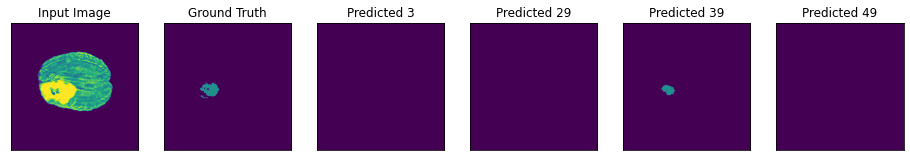

In [64]:
directory_predicted_3 = os.path.join("..","data","test_images","3_Y_predicted.jpg")
directory_predicted_29 = os.path.join("..","data","test_images","29_Y_predicted.jpg")
directory_predicted_39 = os.path.join("..","data","test_images","20_Y_predicted.jpg")
directory_predicted_49 = os.path.join("..","data","test_images","31_Y_predicted.jpg")
directory_y = os.path.join("..","data","test_images","Y_truth.jpg")
directory_X = os.path.join("..","data","test_images","X_input.jpg")

visualize(
    input_image=cv2.imread(directory_X,0).squeeze(),
    ground_truth=cv2.imread(directory_y,0).squeeze(),
    predicted_3=cv2.imread(directory_predicted_3,0),
    predicted_29=cv2.imread(directory_predicted_29,0),
    predicted_39=cv2.imread(directory_predicted_39,0),
    predicted_49=cv2.imread(directory_predicted_49,0),### if putting the whole image, black and white, could it be the reason of the problem??
    
)


In [ ]:
plot_metrics(history)

____